In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

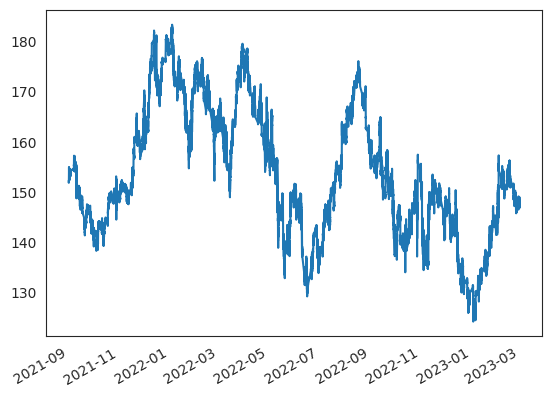

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_3,ema_5,ema_8,ema_9,ema_13,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,152.096413,152.018578,151.964327,151.953148,151.923549,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.31,151.82,0.000000,0.003217,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,84.482759,94.827586,84.482759,94.827586,466.666667,657.602451,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.203206,152.115719,152.041143,152.024518,151.978756,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.31,151.82,0.000000,0.003217,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,84.482759,89.655172,84.482759,89.655172,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.251603,152.177146,152.098667,152.079614,152.024648,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44.722948,76.31

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df = df_inds # SELECT THE CORRECT DATAFRAME
df.close.plot()
plt.show()
df

In [ ]:
{'reset_peak': (0, 0),
 'rsi_min_thresh': (5, 57),
 'rsi_max_thresh': (39, 59),
 'adx_thresh': (48.32875951125419, 50.82172048874581),
 'atr_mult': (3.8518458213801168, 13.146914178619884),
 'vwap_atr_mult': (0.3186644836263577, 6.304855516373642),
 'buy_factor': (-0.1056298180087415, 0.6593298180087415),
 'sell_factor': (-0.2812218420174556, 0.39518184201745554),
 'trailstop_pct': (-3.248385555959201, 31.1429855559592),
 'sign_thresh_pair': {'categorical': ['ema_3|ema_8']}}

In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    reset_peak       = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 1, 50)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 30), 70)
    adx_thresh       = trial.suggest_float("adx_thresh", 40.0, 60.0)
    atr_mult         = trial.suggest_float("atr_mult", 1, 15, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", -3, 10)
    buy_factor       = trial.suggest_float("buy_factor", 0.01, 0.65)
    sell_factor      = trial.suggest_float("sell_factor", 0.01, 0.4)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 0.0, 30.0)
    sign_thresh_pair = trial.suggest_categorical("sign_thresh_pair",[ 
                                                    "ema_3|ema_8",
                                                    # "ema_5|ema_13",
                                                    # "ema_9|ema_21",
                                                    # "ema_21|ema_50",
                                                    # "roc_5|ema_21"
                                                    # "roc_5|0.0"
                                                    # "macd_line_12_26_9|0.0"
                                                    # "macd_diff_6_13_5|0.0"
                                                    # "rsi_14|50.0"
                                                    # "rsi_6|50.0"
                                                ])
    col_signal, sign_thresh = sign_thresh_pair.split("|")
    try: # convert numeric thresholds (only if numeric)
        sign_thresh = float(sign_thresh)
    except ValueError:
        pass
    
    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            col_signal      = col_signal,
            sign_thresh     = sign_thresh,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)


Baseline mean daily B&H: -9.5162


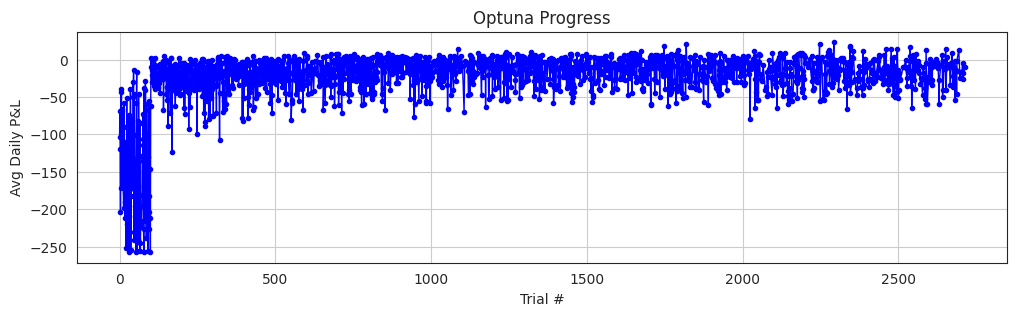

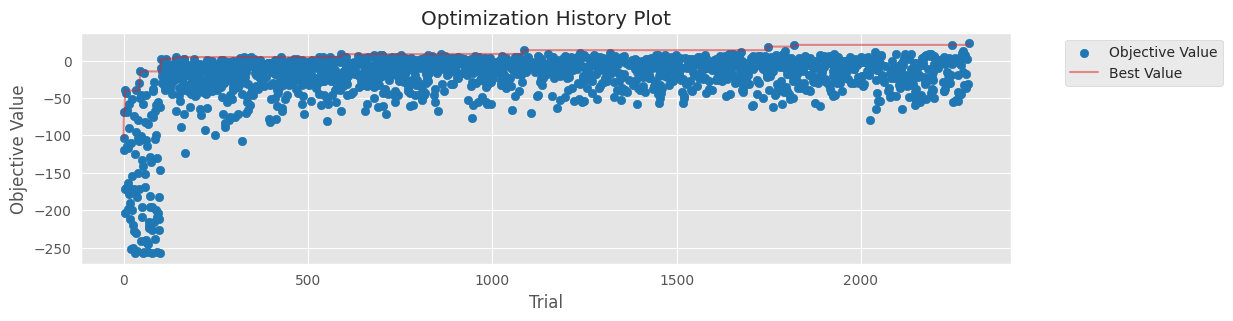

/usr/local/lib/python3.12/dist-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=95; adx_thresh=44.263270162903; atr_mult=0.5518228033578112; vwap_atr_mult=0.1848706265879727; buy_factor=0.6765792015910321; sell_factor=0.3766645928845751; trailstop_pct=10.540101869858807; sign_thresh_pair=ema_9|ema_21


Trial 0: 100%|██████████| 375/375 [00:35<00:00, 10.66it/s]


[Results] mean_pnl:-112.3816 mean_bh:-8.7491 mean_excess:-103.6325 improv_vs_bh:-1184.49%
Action counts: {'Buy': 4074, 'Sell': 8917, 'Hold': 337720}
Best trial is: 0 with best_val: -103.6325
[save_results] wrote optuna_results/AAPL_-103.6325_predicted.csv
[save_best_json] wrote optuna_results/AAPL_-103.6325_predicted.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=49; adx_thresh=46.46168154314735; atr_mult=0.12763652962785388; vwap_atr_mult=-3.4622534658014033; buy_factor=0.33317248047781267; sell_factor=0.6345952691061891; trailstop_pct=19.77295695673268; sign_thresh_pair=ema_9|ema_21


Trial 1: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:-76.9784 mean_bh:-8.7491 mean_excess:-68.2293 improv_vs_bh:-779.84%
Action counts: {'Buy': 5712, 'Sell': 4051, 'Hold': 340948}
Best trial is: 1 with best_val: -68.2293
[save_results] wrote optuna_results/AAPL_-68.2293_predicted.csv
[save_best_json] wrote optuna_results/AAPL_-68.2293_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=76; adx_thresh=32.635500916415346; atr_mult=4.478579555060595; vwap_atr_mult=-7.680914268925168; buy_factor=0.3217647151523013; sell_factor=0.24767795079049384; trailstop_pct=2.6472179582694046; sign_thresh_pair=ema_9|ema_21


Trial 2: 100%|██████████| 375/375 [00:31<00:00, 11.80it/s]


[Results] mean_pnl:-128.8494 mean_bh:-8.7491 mean_excess:-120.1003 improv_vs_bh:-1372.72%
Action counts: {'Buy': 16636, 'Sell': 7252, 'Hold': 326823}
Best trial is: 1 with best_val: -68.2293
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=69; adx_thresh=20.866927451011303; atr_mult=0.20294640716660814; vwap_atr_mult=-0.5570267985543058; buy_factor=0.31059580744496057; sell_factor=0.07493682117190557; trailstop_pct=14.240345587408846; sign_thresh_pair=ema_5|ema_13


Trial 3: 100%|██████████| 375/375 [01:05<00:00,  5.69it/s]


[Results] mean_pnl:-212.5536 mean_bh:-8.7491 mean_excess:-203.8045 improv_vs_bh:-2329.44%
Action counts: {'Buy': 46624, 'Sell': 111331, 'Hold': 192756}
Best trial is: 1 with best_val: -68.2293
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=59; adx_thresh=49.17916658280714; atr_mult=0.7098387922832763; vwap_atr_mult=-6.202122760714664; buy_factor=0.2350727085273303; sell_factor=0.5557227194582066; trailstop_pct=23.108663139499487; sign_thresh_pair=ema_5|ema_13


Trial 4: 100%|██████████| 375/375 [00:33<00:00, 11.28it/s]


[Results] mean_pnl:-48.7065 mean_bh:-8.7491 mean_excess:-39.9575 improv_vs_bh:-456.70%
Action counts: {'Buy': 4923, 'Sell': 4477, 'Hold': 341311}
Best trial is: 4 with best_val: -39.9575
[save_results] wrote optuna_results/AAPL_-39.9575_predicted.csv
[save_best_json] wrote optuna_results/AAPL_-39.9575_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=88; adx_thresh=14.852191245353428; atr_mult=7.114888519851361; vwap_atr_mult=-1.429169859736291; buy_factor=0.8558281213544634; sell_factor=0.03938999283193283; trailstop_pct=17.625916907371085; sign_thresh_pair=ema_3|ema_8


Trial 5: 100%|██████████| 375/375 [00:33<00:00, 11.07it/s]


[Results] mean_pnl:-180.8420 mean_bh:-8.7491 mean_excess:-172.0929 improv_vs_bh:-1966.98%
Action counts: {'Buy': 25299, 'Sell': 80990, 'Hold': 244422}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=56; adx_thresh=49.60545677956314; atr_mult=0.34683561648840816; vwap_atr_mult=-4.154243492580946; buy_factor=0.28741601560670366; sell_factor=0.33750323598525683; trailstop_pct=2.455733992098703; sign_thresh_pair=ema_5|ema_13


Trial 6: 100%|██████████| 375/375 [00:28<00:00, 13.12it/s]


[Results] mean_pnl:-52.0216 mean_bh:-8.7491 mean_excess:-43.2725 improv_vs_bh:-494.59%
Action counts: {'Buy': 4336, 'Sell': 6941, 'Hold': 339434}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=95; adx_thresh=38.032470372807566; atr_mult=0.10842436403518645; vwap_atr_mult=-9.885089566386085; buy_factor=0.7201269432833516; sell_factor=0.29240184593868607; trailstop_pct=24.27619364111372; sign_thresh_pair=ema_5|ema_13


Trial 7: 100%|██████████| 375/375 [00:26<00:00, 14.04it/s]


[Results] mean_pnl:-178.6696 mean_bh:-8.7491 mean_excess:-169.9205 improv_vs_bh:-1942.15%
Action counts: {'Buy': 7933, 'Sell': 26427, 'Hold': 316351}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=37.736383672913085; atr_mult=0.12638617455649434; vwap_atr_mult=4.98252125936231; buy_factor=0.6981526004163323; sell_factor=0.14511791294327273; trailstop_pct=22.320024123191534; sign_thresh_pair=ema_9|ema_21


Trial 8: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:-77.2173 mean_bh:-8.7491 mean_excess:-68.4682 improv_vs_bh:-782.58%
Action counts: {'Buy': 3879, 'Sell': 23519, 'Hold': 323313}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=85; adx_thresh=40.75808785520621; atr_mult=0.870247357168999; vwap_atr_mult=-5.6681211417760995; buy_factor=0.08566142356051283; sell_factor=0.5694735708496764; trailstop_pct=19.12956265520496; sign_thresh_pair=ema_5|ema_13


Trial 9: 100%|██████████| 375/375 [00:21<00:00, 17.61it/s]


[Results] mean_pnl:-75.0509 mean_bh:-8.7491 mean_excess:-66.3018 improv_vs_bh:-757.81%
Action counts: {'Buy': 13541, 'Sell': 9656, 'Hold': 327514}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=86; adx_thresh=43.02267667115336; atr_mult=0.3607970219507551; vwap_atr_mult=-1.9886439283881874; buy_factor=0.37199019190370003; sell_factor=0.23560932319147704; trailstop_pct=13.22531482386859; sign_thresh_pair=ema_3|ema_8


Trial 10: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:-123.4559 mean_bh:-8.7491 mean_excess:-114.7068 improv_vs_bh:-1311.07%
Action counts: {'Buy': 9468, 'Sell': 24856, 'Hold': 316387}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=81; adx_thresh=41.47359505176452; atr_mult=1.6589615316720723; vwap_atr_mult=-0.3165819603014022; buy_factor=0.5428234012186274; sell_factor=0.6903048433408335; trailstop_pct=2.138004957206406; sign_thresh_pair=ema_9|ema_21


Trial 11: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:-125.8945 mean_bh:-8.7491 mean_excess:-117.1455 improv_vs_bh:-1338.94%
Action counts: {'Buy': 6277, 'Sell': 5048, 'Hold': 339386}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=16.883856766574166; atr_mult=3.2351811653084783; vwap_atr_mult=4.960289034824969; buy_factor=0.7831779385807945; sell_factor=0.42943975810185486; trailstop_pct=25.1178395358376; sign_thresh_pair=ema_9|ema_21


Trial 12: 100%|██████████| 375/375 [00:28<00:00, 13.17it/s]


[Results] mean_pnl:-171.8936 mean_bh:-8.7491 mean_excess:-163.1445 improv_vs_bh:-1864.70%
Action counts: {'Buy': 13868, 'Sell': 10855, 'Hold': 325988}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=66; adx_thresh=33.76609220896687; atr_mult=0.4972217107436617; vwap_atr_mult=3.478676214005743; buy_factor=0.8825294908424691; sell_factor=0.20122097172135595; trailstop_pct=3.2497568844648517; sign_thresh_pair=ema_3|ema_8


Trial 13: 100%|██████████| 375/375 [00:30<00:00, 12.35it/s]


[Results] mean_pnl:-206.8025 mean_bh:-8.7491 mean_excess:-198.0534 improv_vs_bh:-2263.70%
Action counts: {'Buy': 9860, 'Sell': 56087, 'Hold': 284764}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=87; adx_thresh=48.431945129179674; atr_mult=6.075196926251969; vwap_atr_mult=-2.8179923695052453; buy_factor=0.6601992831772779; sell_factor=0.4356885226784552; trailstop_pct=15.994635807097168; sign_thresh_pair=ema_5|ema_13


Trial 14: 100%|██████████| 375/375 [00:52<00:00,  7.19it/s]


[Results] mean_pnl:-67.2946 mean_bh:-8.7491 mean_excess:-58.5455 improv_vs_bh:-669.16%
Action counts: {'Buy': 2806, 'Sell': 3708, 'Hold': 344197}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=89; adx_thresh=42.119166067088834; atr_mult=2.956408456215095; vwap_atr_mult=4.053690972931957; buy_factor=0.3343781470127248; sell_factor=0.07787226665145398; trailstop_pct=15.65897843583501; sign_thresh_pair=ema_9|ema_21


Trial 15: 100%|██████████| 375/375 [01:12<00:00,  5.18it/s]


[Results] mean_pnl:-98.5660 mean_bh:-8.7491 mean_excess:-89.8169 improv_vs_bh:-1026.59%
Action counts: {'Buy': 8263, 'Sell': 39206, 'Hold': 303242}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=54; adx_thresh=26.96577862922441; atr_mult=1.8657228747675991; vwap_atr_mult=-1.0397734519837911; buy_factor=0.7280597608149918; sell_factor=0.1309264627969408; trailstop_pct=5.6451263040831705; sign_thresh_pair=ema_9|ema_21


Trial 16: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


[Results] mean_pnl:-187.7255 mean_bh:-8.7491 mean_excess:-178.9764 improv_vs_bh:-2045.66%
Action counts: {'Buy': 11707, 'Sell': 61135, 'Hold': 277869}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=12.158036410573857; atr_mult=0.2114307545312406; vwap_atr_mult=2.065757299827652; buy_factor=0.3662936263287141; sell_factor=0.6378593296741214; trailstop_pct=18.41360757268315; sign_thresh_pair=ema_9|ema_21


Trial 17: 100%|██████████| 375/375 [00:47<00:00,  7.96it/s]


[Results] mean_pnl:-219.9681 mean_bh:-8.7491 mean_excess:-211.2190 improv_vs_bh:-2414.18%
Action counts: {'Buy': 32394, 'Sell': 22885, 'Hold': 295432}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=84; adx_thresh=33.8685607773796; atr_mult=1.8049519121584754; vwap_atr_mult=-7.574841654736654; buy_factor=0.34987684335271474; sell_factor=0.7171052407459456; trailstop_pct=22.561980141406362; sign_thresh_pair=ema_5|ema_13


Trial 18: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:-199.6529 mean_bh:-8.7491 mean_excess:-190.9038 improv_vs_bh:-2181.98%
Action counts: {'Buy': 18399, 'Sell': 10491, 'Hold': 321821}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=74; adx_thresh=44.23076148621577; atr_mult=1.063271297756508; vwap_atr_mult=4.147417525379522; buy_factor=0.3442400415134463; sell_factor=0.7065990802109303; trailstop_pct=8.275877856223449; sign_thresh_pair=ema_3|ema_8


Trial 19: 100%|██████████| 375/375 [00:26<00:00, 14.28it/s]


[Results] mean_pnl:-119.2200 mean_bh:-8.7491 mean_excess:-110.4709 improv_vs_bh:-1262.66%
Action counts: {'Buy': 7490, 'Sell': 7518, 'Hold': 335703}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=90; adx_thresh=24.25199661540454; atr_mult=3.0648836946892057; vwap_atr_mult=-3.3802372261327607; buy_factor=0.48636420447601175; sell_factor=0.8395956600250608; trailstop_pct=7.3061011371516615; sign_thresh_pair=ema_3|ema_8


Trial 20: 100%|██████████| 375/375 [00:32<00:00, 11.56it/s]


[Results] mean_pnl:-260.3384 mean_bh:-8.7491 mean_excess:-251.5894 improv_vs_bh:-2875.61%
Action counts: {'Buy': 36226, 'Sell': 21815, 'Hold': 292670}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=61; adx_thresh=38.511890098984225; atr_mult=0.5390528342193369; vwap_atr_mult=-4.398119848512134; buy_factor=0.4795299715843976; sell_factor=0.5481180822035924; trailstop_pct=9.508392739724986; sign_thresh_pair=ema_3|ema_8


Trial 21: 100%|██████████| 375/375 [00:26<00:00, 14.01it/s]


[Results] mean_pnl:-180.2749 mean_bh:-8.7491 mean_excess:-171.5258 improv_vs_bh:-1960.50%
Action counts: {'Buy': 13013, 'Sell': 17862, 'Hold': 319836}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=55; adx_thresh=19.52721729811937; atr_mult=9.198388486150058; vwap_atr_mult=-9.85895357044734; buy_factor=0.8999244435535505; sell_factor=0.6920443215231639; trailstop_pct=14.7351700148801; sign_thresh_pair=ema_5|ema_13


Trial 22: 100%|██████████| 375/375 [00:21<00:00, 17.75it/s]


[Results] mean_pnl:-162.7276 mean_bh:-8.7491 mean_excess:-153.9786 improv_vs_bh:-1759.94%
Action counts: {'Buy': 6140, 'Sell': 2475, 'Hold': 342096}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=99; adx_thresh=49.800605575441274; atr_mult=1.1552017532699046; vwap_atr_mult=-3.8914446100862827; buy_factor=0.46137889452248326; sell_factor=0.3691100517849686; trailstop_pct=5.160615274643239; sign_thresh_pair=ema_9|ema_21


Trial 23: 100%|██████████| 375/375 [00:19<00:00, 19.33it/s]


[Results] mean_pnl:-60.5349 mean_bh:-8.7491 mean_excess:-51.7858 improv_vs_bh:-591.90%
Action counts: {'Buy': 3415, 'Sell': 5599, 'Hold': 341697}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=77; adx_thresh=30.91850318132503; atr_mult=0.8005404059210188; vwap_atr_mult=-3.70227515052317; buy_factor=0.8130686066690463; sell_factor=0.5330917327134888; trailstop_pct=22.73208644046406; sign_thresh_pair=ema_9|ema_21


Trial 24: 100%|██████████| 375/375 [00:25<00:00, 14.91it/s]


[Results] mean_pnl:-207.8299 mean_bh:-8.7491 mean_excess:-199.0808 improv_vs_bh:-2275.45%
Action counts: {'Buy': 8414, 'Sell': 16911, 'Hold': 325386}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=98; adx_thresh=28.513925709446077; atr_mult=0.20469965157104109; vwap_atr_mult=4.210036401712154; buy_factor=0.7187982415014242; sell_factor=0.14920045134471452; trailstop_pct=14.039484988521506; sign_thresh_pair=ema_5|ema_13


Trial 25: 100%|██████████| 375/375 [00:33<00:00, 11.06it/s]


[Results] mean_pnl:-228.1845 mean_bh:-8.7491 mean_excess:-219.4354 improv_vs_bh:-2508.09%
Action counts: {'Buy': 16489, 'Sell': 74203, 'Hold': 260019}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=64; adx_thresh=22.931573450053886; atr_mult=0.20554061421339306; vwap_atr_mult=3.2400655812086168; buy_factor=0.653292526787216; sell_factor=0.7762807712866572; trailstop_pct=0.09721835200891982; sign_thresh_pair=ema_3|ema_8


Trial 26: 100%|██████████| 375/375 [00:31<00:00, 11.75it/s]


[Results] mean_pnl:-259.3139 mean_bh:-8.7491 mean_excess:-250.5648 improv_vs_bh:-2863.89%
Action counts: {'Buy': 27891, 'Sell': 26743, 'Hold': 296077}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=83; adx_thresh=29.963056482764458; atr_mult=0.48056067361233523; vwap_atr_mult=-9.791012970584584; buy_factor=0.5364799350224959; sell_factor=0.7358031806526462; trailstop_pct=22.770748233312446; sign_thresh_pair=ema_5|ema_13


Trial 27: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:-237.2130 mean_bh:-8.7491 mean_excess:-228.4639 improv_vs_bh:-2611.29%
Action counts: {'Buy': 19341, 'Sell': 15274, 'Hold': 316096}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=60; adx_thresh=35.690380768550156; atr_mult=2.822706139608977; vwap_atr_mult=-1.1388779092504357; buy_factor=0.4801954882768392; sell_factor=0.8365381151965277; trailstop_pct=24.379235463124715; sign_thresh_pair=ema_5|ema_13


Trial 28: 100%|██████████| 375/375 [00:30<00:00, 12.16it/s]


[Results] mean_pnl:-180.3782 mean_bh:-8.7491 mean_excess:-171.6292 improv_vs_bh:-1961.68%
Action counts: {'Buy': 11915, 'Sell': 7489, 'Hold': 331307}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=46.29227859530879; atr_mult=3.337993018403093; vwap_atr_mult=-2.4977058782345454; buy_factor=0.503134619787383; sell_factor=0.4975809535508623; trailstop_pct=7.1378643562188255; sign_thresh_pair=ema_9|ema_21


Trial 29: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:-82.2891 mean_bh:-8.7491 mean_excess:-73.5400 improv_vs_bh:-840.54%
Action counts: {'Buy': 4329, 'Sell': 6100, 'Hold': 340282}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=88; adx_thresh=42.83458561406587; atr_mult=3.509400250173641; vwap_atr_mult=1.2359901507421522; buy_factor=0.7714265523743109; sell_factor=0.4263223583491936; trailstop_pct=3.4143430625918683; sign_thresh_pair=ema_5|ema_13


Trial 30: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:-133.1145 mean_bh:-8.7491 mean_excess:-124.3654 improv_vs_bh:-1421.47%
Action counts: {'Buy': 4450, 'Sell': 12273, 'Hold': 333988}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=82; adx_thresh=17.11294584059239; atr_mult=0.3646483456860777; vwap_atr_mult=2.647479752462907; buy_factor=0.8896194105587665; sell_factor=0.8038777781272493; trailstop_pct=28.73613320274219; sign_thresh_pair=ema_3|ema_8


Trial 31: 100%|██████████| 375/375 [00:28<00:00, 13.07it/s]


[Results] mean_pnl:-266.2372 mean_bh:-8.7491 mean_excess:-257.4881 improv_vs_bh:-2943.03%
Action counts: {'Buy': 24841, 'Sell': 27256, 'Hold': 298614}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=100; adx_thresh=42.25773615607277; atr_mult=1.2620481360782705; vwap_atr_mult=4.749944421538844; buy_factor=0.8111340592748406; sell_factor=0.8247939368503524; trailstop_pct=13.664216676936197; sign_thresh_pair=ema_3|ema_8


Trial 32: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:-181.4153 mean_bh:-8.7491 mean_excess:-172.6662 improv_vs_bh:-1973.53%
Action counts: {'Buy': 6243, 'Sell': 6732, 'Hold': 337736}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=80; adx_thresh=44.29079570006057; atr_mult=5.7853374261889465; vwap_atr_mult=-5.678592674290858; buy_factor=0.7110239131534041; sell_factor=0.0512800955368203; trailstop_pct=26.737275615535033; sign_thresh_pair=ema_3|ema_8


Trial 33: 100%|██████████| 375/375 [00:33<00:00, 11.31it/s]


[Results] mean_pnl:-103.8877 mean_bh:-8.7491 mean_excess:-95.1386 improv_vs_bh:-1087.41%
Action counts: {'Buy': 4915, 'Sell': 56151, 'Hold': 289645}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=95; adx_thresh=24.069677531987118; atr_mult=4.275508274814716; vwap_atr_mult=-4.043020302733739; buy_factor=0.4451944600390373; sell_factor=0.8257187401805086; trailstop_pct=14.595262308049955; sign_thresh_pair=ema_3|ema_8


Trial 34: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:-238.8125 mean_bh:-8.7491 mean_excess:-230.0634 improv_vs_bh:-2629.57%
Action counts: {'Buy': 29840, 'Sell': 7692, 'Hold': 313179}
Best trial is: 4 with best_val: -39.9575
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=94; adx_thresh=49.4104127066462; atr_mult=1.2682226793661464; vwap_atr_mult=2.727294772670156; buy_factor=0.18526464191081857; sell_factor=0.8125925700228767; trailstop_pct=5.984385343255532; sign_thresh_pair=ema_5|ema_13


Trial 35: 100%|██████████| 375/375 [00:21<00:00, 17.06it/s]


[Results] mean_pnl:-48.3354 mean_bh:-8.7491 mean_excess:-39.5863 improv_vs_bh:-452.46%
Action counts: {'Buy': 5030, 'Sell': 2352, 'Hold': 343329}
Best trial is: 35 with best_val: -39.5863
[save_results] wrote optuna_results/AAPL_-39.5863_predicted.csv
[save_best_json] wrote optuna_results/AAPL_-39.5863_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=94; adx_thresh=17.72197715690586; atr_mult=1.3016106720718466; vwap_atr_mult=-3.0286422968502915; buy_factor=0.7265783713196984; sell_factor=0.667704872229878; trailstop_pct=0.084443468958596; sign_thresh_pair=ema_5|ema_13


Trial 36: 100%|██████████| 375/375 [00:32<00:00, 11.42it/s]


[Results] mean_pnl:-263.8755 mean_bh:-8.7491 mean_excess:-255.1264 improv_vs_bh:-2916.03%
Action counts: {'Buy': 27853, 'Sell': 23157, 'Hold': 299701}
Best trial is: 35 with best_val: -39.5863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=61; adx_thresh=35.35741015942201; atr_mult=0.47657883273137597; vwap_atr_mult=-4.126157884643738; buy_factor=0.47838523684587364; sell_factor=0.21343418324903324; trailstop_pct=6.573499814838986; sign_thresh_pair=ema_3|ema_8


Trial 37: 100%|██████████| 375/375 [00:36<00:00, 10.16it/s]


[Results] mean_pnl:-190.9413 mean_bh:-8.7491 mean_excess:-182.1922 improv_vs_bh:-2082.41%
Action counts: {'Buy': 16645, 'Sell': 49824, 'Hold': 284242}
Best trial is: 35 with best_val: -39.5863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=71; adx_thresh=45.14769759039205; atr_mult=6.829229470889753; vwap_atr_mult=4.065608792017592; buy_factor=0.6004257129281639; sell_factor=0.3348759789685195; trailstop_pct=24.932256383517284; sign_thresh_pair=ema_3|ema_8


Trial 38: 100%|██████████| 375/375 [00:27<00:00, 13.73it/s]


[Results] mean_pnl:-88.5798 mean_bh:-8.7491 mean_excess:-79.8307 improv_vs_bh:-912.45%
Action counts: {'Buy': 4209, 'Sell': 3862, 'Hold': 342640}
Best trial is: 35 with best_val: -39.5863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=93; adx_thresh=46.330717840036904; atr_mult=9.02118673457119; vwap_atr_mult=-0.6863964872880643; buy_factor=0.7782909543860068; sell_factor=0.8164431943832824; trailstop_pct=22.233538768352656; sign_thresh_pair=ema_3|ema_8


Trial 39: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:-112.2471 mean_bh:-8.7491 mean_excess:-103.4980 improv_vs_bh:-1182.96%
Action counts: {'Buy': 3064, 'Sell': 2068, 'Hold': 345579}
Best trial is: 35 with best_val: -39.5863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=25.575490565540733; atr_mult=0.4597629954077588; vwap_atr_mult=4.912022966264068; buy_factor=0.587326167982279; sell_factor=0.8483696594035169; trailstop_pct=21.299663424088706; sign_thresh_pair=ema_5|ema_13


Trial 40: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:-158.7703 mean_bh:-8.7491 mean_excess:-150.0212 improv_vs_bh:-1714.71%
Action counts: {'Buy': 11140, 'Sell': 7942, 'Hold': 331629}
Best trial is: 35 with best_val: -39.5863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=99; adx_thresh=46.95082412286565; atr_mult=0.8216423723863998; vwap_atr_mult=-6.918618389259061; buy_factor=0.5873109503530743; sell_factor=0.7678118747756908; trailstop_pct=8.341443136819473; sign_thresh_pair=ema_3|ema_8


Trial 41: 100%|██████████| 375/375 [00:24<00:00, 15.26it/s]


[Results] mean_pnl:-115.9538 mean_bh:-8.7491 mean_excess:-107.2047 improv_vs_bh:-1225.32%
Action counts: {'Buy': 5269, 'Sell': 5483, 'Hold': 339959}
Best trial is: 35 with best_val: -39.5863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=60; adx_thresh=41.173256145488196; atr_mult=0.6302553934803998; vwap_atr_mult=-1.642625514362594; buy_factor=0.6992665959046384; sell_factor=0.8804976042009017; trailstop_pct=26.264381023683832; sign_thresh_pair=ema_3|ema_8


Trial 42: 100%|██████████| 375/375 [00:31<00:00, 11.87it/s]


[Results] mean_pnl:-180.9921 mean_bh:-8.7491 mean_excess:-172.2430 improv_vs_bh:-1968.70%
Action counts: {'Buy': 7433, 'Sell': 6516, 'Hold': 336762}
Best trial is: 35 with best_val: -39.5863
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=43.804551149370916; atr_mult=0.21312186646264397; vwap_atr_mult=-4.3449952688002345; buy_factor=0.03687922727103579; sell_factor=0.688839187058328; trailstop_pct=19.161900115715568; sign_thresh_pair=ema_3|ema_8


Trial 43: 100%|██████████| 375/375 [00:53<00:00,  7.05it/s]


[Results] mean_pnl:-39.1543 mean_bh:-8.7491 mean_excess:-30.4052 improv_vs_bh:-347.52%
Action counts: {'Buy': 10080, 'Sell': 6507, 'Hold': 334124}
Best trial is: 43 with best_val: -30.4052
[save_results] wrote optuna_results/AAPL_-30.4052_predicted.csv
[save_best_json] wrote optuna_results/AAPL_-30.4052_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=54; adx_thresh=49.39367943576845; atr_mult=3.3553934653345268; vwap_atr_mult=-4.140118812317693; buy_factor=0.41973702364541365; sell_factor=0.3253380510298959; trailstop_pct=26.266663301268835; sign_thresh_pair=ema_9|ema_21


Trial 44: 100%|██████████| 375/375 [00:26<00:00, 14.24it/s]


[Results] mean_pnl:-59.1530 mean_bh:-8.7491 mean_excess:-50.4040 improv_vs_bh:-576.11%
Action counts: {'Buy': 3679, 'Sell': 5381, 'Hold': 341651}
Best trial is: 43 with best_val: -30.4052
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=46.94694010560755; atr_mult=2.679089258365957; vwap_atr_mult=4.769955799310823; buy_factor=0.09779056915409388; sell_factor=0.5550867566986656; trailstop_pct=2.431210203459621; sign_thresh_pair=ema_3|ema_8


Trial 45: 100%|██████████| 375/375 [00:49<00:00,  7.61it/s]


[Results] mean_pnl:-23.2081 mean_bh:-8.7491 mean_excess:-14.4590 improv_vs_bh:-165.26%
Action counts: {'Buy': 3445, 'Sell': 3230, 'Hold': 344036}
Best trial is: 45 with best_val: -14.4590
[save_results] wrote optuna_results/AAPL_-14.459_predicted.csv
[save_best_json] wrote optuna_results/AAPL_-14.459_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=23.96813850693578; atr_mult=0.3717372953367123; vwap_atr_mult=-1.4434061565645475; buy_factor=0.672952815294412; sell_factor=0.576780616116865; trailstop_pct=28.407666790287603; sign_thresh_pair=ema_3|ema_8


Trial 46: 100%|██████████| 375/375 [00:37<00:00, 10.07it/s]


[Results] mean_pnl:-250.4584 mean_bh:-8.7491 mean_excess:-241.7093 improv_vs_bh:-2762.68%
Action counts: {'Buy': 23605, 'Sell': 27480, 'Hold': 299626}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=76; adx_thresh=33.13204381079797; atr_mult=5.9004310795253225; vwap_atr_mult=-0.8509918168911099; buy_factor=0.022889282556980597; sell_factor=0.3349082935895997; trailstop_pct=7.8269872160888045; sign_thresh_pair=ema_5|ema_13


Trial 47: 100%|██████████| 375/375 [00:37<00:00,  9.99it/s]


[Results] mean_pnl:-54.3911 mean_bh:-8.7491 mean_excess:-45.6420 improv_vs_bh:-521.68%
Action counts: {'Buy': 26223, 'Sell': 20409, 'Hold': 304079}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=77; adx_thresh=46.93281709347499; atr_mult=0.4371938709857882; vwap_atr_mult=-4.476479500965854; buy_factor=0.8904555243542757; sell_factor=0.3825839356183739; trailstop_pct=17.226400726614536; sign_thresh_pair=ema_3|ema_8


Trial 48: 100%|██████████| 375/375 [00:41<00:00,  8.97it/s]


[Results] mean_pnl:-109.6487 mean_bh:-8.7491 mean_excess:-100.8997 improv_vs_bh:-1153.26%
Action counts: {'Buy': 3255, 'Sell': 13039, 'Hold': 334417}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=50; adx_thresh=21.62718328628039; atr_mult=1.4057845705974354; vwap_atr_mult=0.7879852272149659; buy_factor=0.6091859321088997; sell_factor=0.45476903357862464; trailstop_pct=27.525764362362686; sign_thresh_pair=ema_9|ema_21


Trial 49: 100%|██████████| 375/375 [00:31<00:00, 11.93it/s]


[Results] mean_pnl:-204.3039 mean_bh:-8.7491 mean_excess:-195.5548 improv_vs_bh:-2235.14%
Action counts: {'Buy': 17033, 'Sell': 17016, 'Hold': 316662}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=59; adx_thresh=33.50608609010919; atr_mult=0.7081620660535136; vwap_atr_mult=-7.477290372999592; buy_factor=0.14335479668632567; sell_factor=0.7026761831334236; trailstop_pct=28.052019051293957; sign_thresh_pair=ema_9|ema_21


Trial 50: 100%|██████████| 375/375 [00:35<00:00, 10.49it/s]


[Results] mean_pnl:-141.0586 mean_bh:-8.7491 mean_excess:-132.3095 improv_vs_bh:-1512.27%
Action counts: {'Buy': 23901, 'Sell': 8449, 'Hold': 318361}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=80; adx_thresh=35.52707237944328; atr_mult=4.203022593843983; vwap_atr_mult=3.1862088609489767; buy_factor=0.6841506517052418; sell_factor=0.5946975296545981; trailstop_pct=7.198133750417575; sign_thresh_pair=ema_3|ema_8


Trial 51: 100%|██████████| 375/375 [01:25<00:00,  4.39it/s]


[Results] mean_pnl:-218.3710 mean_bh:-8.7491 mean_excess:-209.6219 improv_vs_bh:-2395.93%
Action counts: {'Buy': 11666, 'Sell': 18328, 'Hold': 320717}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=97; adx_thresh=11.58517671798176; atr_mult=0.26244202036621195; vwap_atr_mult=-4.271539524040992; buy_factor=0.339335690243383; sell_factor=0.667389810601883; trailstop_pct=26.86208940621998; sign_thresh_pair=ema_3|ema_8


Trial 52: 100%|██████████| 375/375 [01:14<00:00,  5.07it/s]


[Results] mean_pnl:-265.9087 mean_bh:-8.7491 mean_excess:-257.1596 improv_vs_bh:-2939.27%
Action counts: {'Buy': 73444, 'Sell': 40436, 'Hold': 236831}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=53; adx_thresh=18.068430597169; atr_mult=5.163951362023454; vwap_atr_mult=3.9570245227377363; buy_factor=0.306551695010986; sell_factor=0.3441536720993348; trailstop_pct=6.912581992306186; sign_thresh_pair=ema_9|ema_21


Trial 53: 100%|██████████| 375/375 [01:15<00:00,  4.94it/s]


[Results] mean_pnl:-149.4866 mean_bh:-8.7491 mean_excess:-140.7375 improv_vs_bh:-1608.60%
Action counts: {'Buy': 23662, 'Sell': 31931, 'Hold': 295118}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=57; adx_thresh=39.46117121403956; atr_mult=0.24528458358877336; vwap_atr_mult=-0.11124388434166832; buy_factor=0.08722425531033545; sell_factor=0.22061881475186398; trailstop_pct=27.677890953090216; sign_thresh_pair=ema_5|ema_13


Trial 54: 100%|██████████| 375/375 [01:15<00:00,  4.98it/s]


[Results] mean_pnl:-66.5698 mean_bh:-8.7491 mean_excess:-57.8207 improv_vs_bh:-660.88%
Action counts: {'Buy': 13220, 'Sell': 20212, 'Hold': 317279}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=82; adx_thresh=48.62086321099684; atr_mult=5.17560875805792; vwap_atr_mult=3.340876293578594; buy_factor=0.11747311721975867; sell_factor=0.08099238865055018; trailstop_pct=8.649271819350151; sign_thresh_pair=ema_3|ema_8


Trial 55: 100%|██████████| 375/375 [01:11<00:00,  5.21it/s]


[Results] mean_pnl:-25.3396 mean_bh:-8.7491 mean_excess:-16.5905 improv_vs_bh:-189.63%
Action counts: {'Buy': 5449, 'Sell': 28547, 'Hold': 316715}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=93; adx_thresh=15.842982208171348; atr_mult=1.2970752438097608; vwap_atr_mult=4.505994934706097; buy_factor=0.2780638565572261; sell_factor=0.8745085583044613; trailstop_pct=2.9856397837246895; sign_thresh_pair=ema_3|ema_8


Trial 56: 100%|██████████| 375/375 [01:19<00:00,  4.74it/s]


[Results] mean_pnl:-265.0379 mean_bh:-8.7491 mean_excess:-256.2888 improv_vs_bh:-2929.32%
Action counts: {'Buy': 75939, 'Sell': 30713, 'Hold': 244059}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=100; adx_thresh=34.82236007371467; atr_mult=2.3182765925261584; vwap_atr_mult=4.953718938688343; buy_factor=0.43214112886394795; sell_factor=0.21897299353834873; trailstop_pct=16.39196317389384; sign_thresh_pair=ema_9|ema_21


Trial 57: 100%|██████████| 375/375 [00:55<00:00,  6.74it/s]


[Results] mean_pnl:-159.9031 mean_bh:-8.7491 mean_excess:-151.1540 improv_vs_bh:-1727.65%
Action counts: {'Buy': 12929, 'Sell': 30296, 'Hold': 307486}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=59; adx_thresh=38.171639105702994; atr_mult=2.5667919576757527; vwap_atr_mult=2.681781722232552; buy_factor=0.1786415626759749; sell_factor=0.3614507225576708; trailstop_pct=2.9357802285055037; sign_thresh_pair=ema_3|ema_8


Trial 58: 100%|██████████| 375/375 [00:41<00:00,  9.02it/s]


[Results] mean_pnl:-91.3502 mean_bh:-8.7491 mean_excess:-82.6011 improv_vs_bh:-944.11%
Action counts: {'Buy': 11754, 'Sell': 21396, 'Hold': 317561}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=100; adx_thresh=21.91040263992223; atr_mult=5.411681796277142; vwap_atr_mult=3.1177643474421366; buy_factor=0.8907894849108855; sell_factor=0.4105408329768966; trailstop_pct=8.296332067668441; sign_thresh_pair=ema_9|ema_21


Trial 59: 100%|██████████| 375/375 [00:41<00:00,  9.05it/s]


[Results] mean_pnl:-177.3626 mean_bh:-8.7491 mean_excess:-168.6135 improv_vs_bh:-1927.21%
Action counts: {'Buy': 8869, 'Sell': 5548, 'Hold': 336294}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=68; adx_thresh=22.775855031238194; atr_mult=1.4448869836869758; vwap_atr_mult=-6.144842303391142; buy_factor=0.22337208931929675; sell_factor=0.514412961255189; trailstop_pct=27.580713994680927; sign_thresh_pair=ema_3|ema_8


Trial 60: 100%|██████████| 375/375 [01:28<00:00,  4.26it/s]


[Results] mean_pnl:-248.0716 mean_bh:-8.7491 mean_excess:-239.3225 improv_vs_bh:-2735.40%
Action counts: {'Buy': 56742, 'Sell': 46712, 'Hold': 247257}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=56; adx_thresh=47.530087719434505; atr_mult=0.5253737284918127; vwap_atr_mult=1.787550511657745; buy_factor=0.2756925860450788; sell_factor=0.49427212157154843; trailstop_pct=21.149524691613497; sign_thresh_pair=ema_9|ema_21


Trial 61: 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]


[Results] mean_pnl:-54.8708 mean_bh:-8.7491 mean_excess:-46.1217 improv_vs_bh:-527.16%
Action counts: {'Buy': 4883, 'Sell': 4800, 'Hold': 341028}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=81; adx_thresh=45.519963968488206; atr_mult=9.288108810572542; vwap_atr_mult=-6.195607070910141; buy_factor=0.7015109036734468; sell_factor=0.6758639438498845; trailstop_pct=14.665268199135614; sign_thresh_pair=ema_5|ema_13


Trial 62: 100%|██████████| 375/375 [00:38<00:00,  9.87it/s]


[Results] mean_pnl:-114.7410 mean_bh:-8.7491 mean_excess:-105.9919 improv_vs_bh:-1211.46%
Action counts: {'Buy': 3295, 'Sell': 4423, 'Hold': 342993}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=54; adx_thresh=33.264922358927095; atr_mult=9.105346234716176; vwap_atr_mult=-1.2381119517433863; buy_factor=0.18852568420358817; sell_factor=0.8760082152628379; trailstop_pct=25.26069435941915; sign_thresh_pair=ema_9|ema_21


Trial 63: 100%|██████████| 375/375 [00:48<00:00,  7.74it/s]


[Results] mean_pnl:-123.3403 mean_bh:-8.7491 mean_excess:-114.5912 improv_vs_bh:-1309.75%
Action counts: {'Buy': 17013, 'Sell': 2098, 'Hold': 331600}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=99; adx_thresh=16.240922042601436; atr_mult=4.929456897115426; vwap_atr_mult=-1.5951837043594566; buy_factor=0.8168877965809317; sell_factor=0.32490520452533833; trailstop_pct=8.955035911576172; sign_thresh_pair=ema_9|ema_21


Trial 64: 100%|██████████| 375/375 [01:19<00:00,  4.71it/s]


[Results] mean_pnl:-252.5471 mean_bh:-8.7491 mean_excess:-243.7980 improv_vs_bh:-2786.55%
Action counts: {'Buy': 17127, 'Sell': 47497, 'Hold': 286087}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=93; adx_thresh=44.208018544341975; atr_mult=6.498970257008066; vwap_atr_mult=-7.381394276581924; buy_factor=0.49308109257392335; sell_factor=0.3660355965309027; trailstop_pct=21.914914955605212; sign_thresh_pair=ema_9|ema_21


Trial 65: 100%|██████████| 375/375 [00:47<00:00,  7.82it/s]


[Results] mean_pnl:-93.2870 mean_bh:-8.7491 mean_excess:-84.5379 improv_vs_bh:-966.25%
Action counts: {'Buy': 5376, 'Sell': 9073, 'Hold': 336262}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=64; adx_thresh=19.463481474252518; atr_mult=0.3359249063847964; vwap_atr_mult=-7.479118556154028; buy_factor=0.5599099694046855; sell_factor=0.5782445142926498; trailstop_pct=18.155361648703902; sign_thresh_pair=ema_3|ema_8


Trial 66: 100%|██████████| 375/375 [00:54<00:00,  6.88it/s]


[Results] mean_pnl:-264.4694 mean_bh:-8.7491 mean_excess:-255.7203 improv_vs_bh:-2922.82%
Action counts: {'Buy': 42604, 'Sell': 45272, 'Hold': 262835}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=67; adx_thresh=20.000331113415342; atr_mult=0.6436911877309577; vwap_atr_mult=-5.629393564156869; buy_factor=0.8439660619580978; sell_factor=0.6856220278987686; trailstop_pct=22.031275884558738; sign_thresh_pair=ema_9|ema_21


Trial 67: 100%|██████████| 375/375 [00:43<00:00,  8.53it/s]


[Results] mean_pnl:-254.1826 mean_bh:-8.7491 mean_excess:-245.4335 improv_vs_bh:-2805.25%
Action counts: {'Buy': 14745, 'Sell': 21463, 'Hold': 314503}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=84; adx_thresh=25.65053727998741; atr_mult=0.2666649092578132; vwap_atr_mult=-8.651537275338503; buy_factor=0.41737796378979625; sell_factor=0.5707657249160183; trailstop_pct=26.594587795438365; sign_thresh_pair=ema_9|ema_21


Trial 68: 100%|██████████| 375/375 [00:44<00:00,  8.41it/s]


[Results] mean_pnl:-229.6903 mean_bh:-8.7491 mean_excess:-220.9412 improv_vs_bh:-2525.30%
Action counts: {'Buy': 25168, 'Sell': 19518, 'Hold': 306025}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=81; adx_thresh=27.75297243987875; atr_mult=2.573219177957365; vwap_atr_mult=-5.7078211211802685; buy_factor=0.6341285488195684; sell_factor=0.3587566795598742; trailstop_pct=29.419531188198945; sign_thresh_pair=ema_9|ema_21


Trial 69: 100%|██████████| 375/375 [00:35<00:00, 10.57it/s]


[Results] mean_pnl:-224.7511 mean_bh:-8.7491 mean_excess:-216.0020 improv_vs_bh:-2468.85%
Action counts: {'Buy': 14528, 'Sell': 29980, 'Hold': 306203}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=98; adx_thresh=32.527700975984146; atr_mult=0.5246613145263058; vwap_atr_mult=-9.658426465741265; buy_factor=0.4488691910494062; sell_factor=0.6644044858269661; trailstop_pct=21.612010027794284; sign_thresh_pair=ema_3|ema_8


Trial 70: 100%|██████████| 375/375 [00:32<00:00, 11.48it/s]


[Results] mean_pnl:-231.9580 mean_bh:-8.7491 mean_excess:-223.2089 improv_vs_bh:-2551.22%
Action counts: {'Buy': 23187, 'Sell': 19906, 'Hold': 307618}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=55; adx_thresh=27.700966584483467; atr_mult=3.2808384791238487; vwap_atr_mult=0.1465908465991017; buy_factor=0.5484953967557925; sell_factor=0.4871886580804758; trailstop_pct=6.219435380748475; sign_thresh_pair=ema_3|ema_8


Trial 71: 100%|██████████| 375/375 [00:32<00:00, 11.52it/s]


[Results] mean_pnl:-204.3193 mean_bh:-8.7491 mean_excess:-195.5702 improv_vs_bh:-2235.32%
Action counts: {'Buy': 16944, 'Sell': 11301, 'Hold': 322466}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=63; adx_thresh=27.96093770844969; atr_mult=0.22028435243282135; vwap_atr_mult=0.30368886551533514; buy_factor=0.5474981270683058; sell_factor=0.14243504678041377; trailstop_pct=18.418642784981; sign_thresh_pair=ema_9|ema_21


Trial 72: 100%|██████████| 375/375 [00:42<00:00,  8.87it/s]


[Results] mean_pnl:-190.2310 mean_bh:-8.7491 mean_excess:-181.4819 improv_vs_bh:-2074.29%
Action counts: {'Buy': 15337, 'Sell': 57999, 'Hold': 277375}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=69; adx_thresh=41.13716141462565; atr_mult=4.827715944884204; vwap_atr_mult=-1.9289111344266328; buy_factor=0.35733403023786003; sell_factor=0.2999809999460445; trailstop_pct=12.712743811840305; sign_thresh_pair=ema_3|ema_8


Trial 73: 100%|██████████| 375/375 [01:07<00:00,  5.57it/s]


[Results] mean_pnl:-137.7443 mean_bh:-8.7491 mean_excess:-128.9952 improv_vs_bh:-1474.38%
Action counts: {'Buy': 10150, 'Sell': 23347, 'Hold': 317214}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=82; adx_thresh=13.373118010209941; atr_mult=4.712354458552681; vwap_atr_mult=-4.683210405181922; buy_factor=0.582077808366385; sell_factor=0.21346130026340732; trailstop_pct=9.298628783201154; sign_thresh_pair=ema_3|ema_8


Trial 74: 100%|██████████| 375/375 [01:11<00:00,  5.22it/s]


[Results] mean_pnl:-144.9939 mean_bh:-8.7491 mean_excess:-136.2448 improv_vs_bh:-1557.25%
Action counts: {'Buy': 26875, 'Sell': 6965, 'Hold': 316871}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=64; adx_thresh=45.14910722289606; atr_mult=2.8669334859539433; vwap_atr_mult=1.9069820477799997; buy_factor=0.6736303835149097; sell_factor=0.08150903163167908; trailstop_pct=24.412317405161023; sign_thresh_pair=ema_3|ema_8


Trial 75: 100%|██████████| 375/375 [01:00<00:00,  6.18it/s]


[Results] mean_pnl:-82.1054 mean_bh:-8.7491 mean_excess:-73.3563 improv_vs_bh:-838.45%
Action counts: {'Buy': 4049, 'Sell': 14118, 'Hold': 332544}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=46; adx_thresh=13.802906191035822; atr_mult=1.1438533479603297; vwap_atr_mult=-0.7027116982831867; buy_factor=0.10280362517093718; sell_factor=0.20968422477796578; trailstop_pct=18.05090467166322; sign_thresh_pair=ema_3|ema_8


Trial 76: 100%|██████████| 375/375 [02:16<00:00,  2.74it/s]


[Results] mean_pnl:-204.6653 mean_bh:-8.7491 mean_excess:-195.9162 improv_vs_bh:-2239.28%
Action counts: {'Buy': 74894, 'Sell': 75193, 'Hold': 200624}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=80; adx_thresh=11.532456695670309; atr_mult=0.5019330835029285; vwap_atr_mult=-6.956524431839475; buy_factor=0.6015087404242185; sell_factor=0.1581701597189783; trailstop_pct=28.44776744936182; sign_thresh_pair=ema_9|ema_21


Trial 77: 100%|██████████| 375/375 [01:09<00:00,  5.43it/s]


[Results] mean_pnl:-235.0943 mean_bh:-8.7491 mean_excess:-226.3453 improv_vs_bh:-2587.07%
Action counts: {'Buy': 31994, 'Sell': 46416, 'Hold': 272301}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=72; adx_thresh=10.07992276053772; atr_mult=0.1790039339484561; vwap_atr_mult=-2.5320958325164504; buy_factor=0.4445414998481963; sell_factor=0.7907665479952168; trailstop_pct=18.484783841194787; sign_thresh_pair=ema_3|ema_8


Trial 78: 100%|██████████| 375/375 [01:15<00:00,  4.99it/s]


[Results] mean_pnl:-266.2745 mean_bh:-8.7491 mean_excess:-257.5254 improv_vs_bh:-2943.45%
Action counts: {'Buy': 61390, 'Sell': 34572, 'Hold': 254749}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=62; adx_thresh=49.995963198147976; atr_mult=0.15769848580528215; vwap_atr_mult=-0.29367777288908314; buy_factor=0.36473839964856636; sell_factor=0.5984571219501734; trailstop_pct=4.698579209707029; sign_thresh_pair=ema_9|ema_21


Trial 79: 100%|██████████| 375/375 [00:44<00:00,  8.34it/s]


[Results] mean_pnl:-46.9150 mean_bh:-8.7491 mean_excess:-38.1659 improv_vs_bh:-436.23%
Action counts: {'Buy': 3716, 'Sell': 3187, 'Hold': 343808}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=67; adx_thresh=49.96021203613311; atr_mult=0.4523365976885234; vwap_atr_mult=-4.922148852881828; buy_factor=0.5323516588814694; sell_factor=0.8114653345887761; trailstop_pct=7.2446815509899265; sign_thresh_pair=ema_3|ema_8


Trial 80: 100%|██████████| 375/375 [00:38<00:00,  9.71it/s]


[Results] mean_pnl:-83.8466 mean_bh:-8.7491 mean_excess:-75.0975 improv_vs_bh:-858.35%
Action counts: {'Buy': 3800, 'Sell': 3404, 'Hold': 343507}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=80; adx_thresh=49.9706317400141; atr_mult=5.261273969123925; vwap_atr_mult=-9.873686213396965; buy_factor=0.6957371151785517; sell_factor=0.8772043937817374; trailstop_pct=18.367391752877747; sign_thresh_pair=ema_9|ema_21


Trial 81: 100%|██████████| 375/375 [00:43<00:00,  8.55it/s]


[Results] mean_pnl:-48.7777 mean_bh:-8.7491 mean_excess:-40.0286 improv_vs_bh:-457.52%
Action counts: {'Buy': 2264, 'Sell': 1433, 'Hold': 347014}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=85; adx_thresh=19.44326718844244; atr_mult=0.2663306250969072; vwap_atr_mult=-8.18003555999257; buy_factor=0.0848138675049085; sell_factor=0.3785199851287061; trailstop_pct=6.09758042673069; sign_thresh_pair=ema_5|ema_13


Trial 82: 100%|██████████| 375/375 [01:13<00:00,  5.10it/s]


[Results] mean_pnl:-224.9387 mean_bh:-8.7491 mean_excess:-216.1896 improv_vs_bh:-2471.00%
Action counts: {'Buy': 79245, 'Sell': 45147, 'Hold': 226319}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=58; adx_thresh=46.227470989599794; atr_mult=0.417377646443836; vwap_atr_mult=1.1703945160218652; buy_factor=0.16417885412769564; sell_factor=0.14801038076402206; trailstop_pct=1.3605408584414935; sign_thresh_pair=ema_5|ema_13


Trial 83: 100%|██████████| 375/375 [00:30<00:00, 12.38it/s]


[Results] mean_pnl:-37.8368 mean_bh:-8.7491 mean_excess:-29.0877 improv_vs_bh:-332.47%
Action counts: {'Buy': 6143, 'Sell': 17623, 'Hold': 326945}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=61; adx_thresh=44.67048182888898; atr_mult=0.15281667910785052; vwap_atr_mult=-4.826937630119762; buy_factor=0.2179272848796503; sell_factor=0.3449798525510716; trailstop_pct=20.182251597805845; sign_thresh_pair=ema_5|ema_13


Trial 84: 100%|██████████| 375/375 [00:29<00:00, 12.66it/s]


[Results] mean_pnl:-75.5833 mean_bh:-8.7491 mean_excess:-66.8342 improv_vs_bh:-763.90%
Action counts: {'Buy': 8051, 'Sell': 11761, 'Hold': 330899}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=60; adx_thresh=41.25198869886187; atr_mult=9.108048243082411; vwap_atr_mult=-0.8336399672160866; buy_factor=0.8705841461174103; sell_factor=0.20724153653014943; trailstop_pct=27.238437330664407; sign_thresh_pair=ema_9|ema_21


Trial 85: 100%|██████████| 375/375 [00:28<00:00, 13.15it/s]


[Results] mean_pnl:-113.0277 mean_bh:-8.7491 mean_excess:-104.2786 improv_vs_bh:-1191.88%
Action counts: {'Buy': 2616, 'Sell': 16025, 'Hold': 332070}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=100; adx_thresh=10.228877816376265; atr_mult=0.19142642486593528; vwap_atr_mult=1.370294019112368; buy_factor=0.47511765959647356; sell_factor=0.23358820387311527; trailstop_pct=29.0529286053286; sign_thresh_pair=ema_9|ema_21


Trial 86: 100%|██████████| 375/375 [01:13<00:00,  5.13it/s]


[Results] mean_pnl:-247.2841 mean_bh:-8.7491 mean_excess:-238.5350 improv_vs_bh:-2726.40%
Action counts: {'Buy': 42965, 'Sell': 52280, 'Hold': 255466}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=40.39077397947058; atr_mult=2.3201726969950722; vwap_atr_mult=-3.4876922104300254; buy_factor=0.0679718637357017; sell_factor=0.5421218753105957; trailstop_pct=27.46641127468674; sign_thresh_pair=ema_9|ema_21


Trial 87: 100%|██████████| 375/375 [01:19<00:00,  4.69it/s]


[Results] mean_pnl:-68.0566 mean_bh:-8.7491 mean_excess:-59.3075 improv_vs_bh:-677.87%
Action counts: {'Buy': 14860, 'Sell': 6139, 'Hold': 329712}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=82; adx_thresh=45.23262262795389; atr_mult=3.3289830725207317; vwap_atr_mult=-3.7359233567127967; buy_factor=0.5312409543043175; sell_factor=0.16545806742803304; trailstop_pct=0.11091092310912098; sign_thresh_pair=ema_3|ema_8


Trial 88: 100%|██████████| 375/375 [01:17<00:00,  4.84it/s]


[Results] mean_pnl:-107.9328 mean_bh:-8.7491 mean_excess:-99.1837 improv_vs_bh:-1133.65%
Action counts: {'Buy': 6379, 'Sell': 30465, 'Hold': 313867}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=47; adx_thresh=29.85676855442418; atr_mult=4.213884317664868; vwap_atr_mult=-0.4451014063927179; buy_factor=0.8208993294776201; sell_factor=0.8489722292667425; trailstop_pct=28.279575128555074; sign_thresh_pair=ema_9|ema_21


Trial 89: 100%|██████████| 375/375 [01:02<00:00,  5.96it/s]


[Results] mean_pnl:-208.2530 mean_bh:-8.7491 mean_excess:-199.5039 improv_vs_bh:-2280.28%
Action counts: {'Buy': 7159, 'Sell': 7065, 'Hold': 336487}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=60; adx_thresh=31.054058294384813; atr_mult=1.9993335598777884; vwap_atr_mult=4.940404838013551; buy_factor=0.41143275442192967; sell_factor=0.2664241868610236; trailstop_pct=10.794741323977375; sign_thresh_pair=ema_5|ema_13


Trial 90: 100%|██████████| 375/375 [01:05<00:00,  5.69it/s]


[Results] mean_pnl:-138.8357 mean_bh:-8.7491 mean_excess:-130.0866 improv_vs_bh:-1486.86%
Action counts: {'Buy': 12655, 'Sell': 33349, 'Hold': 304707}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=88; adx_thresh=17.876474921954465; atr_mult=0.17815646423672268; vwap_atr_mult=-2.3178261697452713; buy_factor=0.7918956326638035; sell_factor=0.6817471157560003; trailstop_pct=20.580308328530283; sign_thresh_pair=ema_5|ema_13


Trial 91: 100%|██████████| 375/375 [01:14<00:00,  5.04it/s]


[Results] mean_pnl:-264.3767 mean_bh:-8.7491 mean_excess:-255.6277 improv_vs_bh:-2921.76%
Action counts: {'Buy': 24541, 'Sell': 27637, 'Hold': 298533}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=76; adx_thresh=18.367670592520604; atr_mult=0.15235523824273814; vwap_atr_mult=-0.7858675684365775; buy_factor=0.1662180804491118; sell_factor=0.1441162326254547; trailstop_pct=26.705712282301945; sign_thresh_pair=ema_9|ema_21


Trial 92: 100%|██████████| 375/375 [02:37<00:00,  2.39it/s]


[Results] mean_pnl:-218.3920 mean_bh:-8.7491 mean_excess:-209.6429 improv_vs_bh:-2396.17%
Action counts: {'Buy': 63078, 'Sell': 81247, 'Hold': 206386}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=53; adx_thresh=16.5502267182746; atr_mult=0.10352305947642305; vwap_atr_mult=0.8192389428396556; buy_factor=0.15442766992173185; sell_factor=0.7933784024818143; trailstop_pct=4.168356013690349; sign_thresh_pair=ema_9|ema_21


Trial 93: 100%|██████████| 375/375 [01:32<00:00,  4.07it/s]


[Results] mean_pnl:-212.7407 mean_bh:-8.7491 mean_excess:-203.9916 improv_vs_bh:-2331.58%
Action counts: {'Buy': 55101, 'Sell': 15777, 'Hold': 279833}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=52; adx_thresh=29.18588152771724; atr_mult=0.2654731777969912; vwap_atr_mult=-8.62171293920968; buy_factor=0.016040961240069086; sell_factor=0.45398307805395816; trailstop_pct=29.017858047516487; sign_thresh_pair=ema_5|ema_13


Trial 94: 100%|██████████| 375/375 [01:00<00:00,  6.18it/s]


[Results] mean_pnl:-63.8234 mean_bh:-8.7491 mean_excess:-55.0743 improv_vs_bh:-629.49%
Action counts: {'Buy': 36672, 'Sell': 21516, 'Hold': 292523}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=66; adx_thresh=24.759456361607484; atr_mult=0.3998762501311405; vwap_atr_mult=1.4855119876562526; buy_factor=0.2976447500884357; sell_factor=0.23652814063588884; trailstop_pct=4.677703450495672; sign_thresh_pair=ema_9|ema_21


Trial 95: 100%|██████████| 375/375 [01:10<00:00,  5.35it/s]


[Results] mean_pnl:-191.6548 mean_bh:-8.7491 mean_excess:-182.9057 improv_vs_bh:-2090.57%
Action counts: {'Buy': 28993, 'Sell': 36304, 'Hold': 285414}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=83; adx_thresh=22.517983478758367; atr_mult=0.2149586610133418; vwap_atr_mult=1.5005428910211904; buy_factor=0.656161625887899; sell_factor=0.3047111770485164; trailstop_pct=3.7953284176084736; sign_thresh_pair=ema_9|ema_21


Trial 96: 100%|██████████| 375/375 [00:41<00:00,  8.94it/s]


[Results] mean_pnl:-235.7031 mean_bh:-8.7491 mean_excess:-226.9540 improv_vs_bh:-2594.03%
Action counts: {'Buy': 19699, 'Sell': 37737, 'Hold': 293275}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=57; adx_thresh=21.529156122369983; atr_mult=0.17837573995641523; vwap_atr_mult=-7.175365052063233; buy_factor=0.13038987300089755; sell_factor=0.29366513823814455; trailstop_pct=6.002703230603714; sign_thresh_pair=ema_5|ema_13


Trial 97: 100%|██████████| 375/375 [00:51<00:00,  7.30it/s]


[Results] mean_pnl:-220.8630 mean_bh:-8.7491 mean_excess:-212.1139 improv_vs_bh:-2424.41%
Action counts: {'Buy': 61472, 'Sell': 49704, 'Hold': 239535}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=88; adx_thresh=36.179486282459195; atr_mult=0.42532931305510896; vwap_atr_mult=-2.0171623185379106; buy_factor=0.7803697706603645; sell_factor=0.04547331087285259; trailstop_pct=20.40833519194197; sign_thresh_pair=ema_3|ema_8


Trial 98: 100%|██████████| 375/375 [01:12<00:00,  5.15it/s]


[Results] mean_pnl:-155.4596 mean_bh:-8.7491 mean_excess:-146.7105 improv_vs_bh:-1676.87%
Action counts: {'Buy': 10486, 'Sell': 63807, 'Hold': 276418}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=90; adx_thresh=12.051095932880273; atr_mult=0.34755606431806974; vwap_atr_mult=-4.742668334013976; buy_factor=0.8043389396257656; sell_factor=0.7127193316006869; trailstop_pct=1.763893171704709; sign_thresh_pair=ema_5|ema_13


Trial 99: 100%|██████████| 375/375 [01:08<00:00,  5.48it/s]


[Results] mean_pnl:-265.7724 mean_bh:-8.7491 mean_excess:-257.0233 improv_vs_bh:-2937.71%
Action counts: {'Buy': 26768, 'Sell': 28148, 'Hold': 295795}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=72; adx_thresh=45.175916166052694; atr_mult=0.2729201281882005; vwap_atr_mult=-3.546733844442905; buy_factor=0.15643133124857433; sell_factor=0.46128497745754216; trailstop_pct=2.668415353306394; sign_thresh_pair=ema_5|ema_13


Trial 100: 100%|██████████| 375/375 [00:31<00:00, 12.03it/s]


[Results] mean_pnl:-70.1454 mean_bh:-8.7491 mean_excess:-61.3963 improv_vs_bh:-701.74%
Action counts: {'Buy': 8218, 'Sell': 8330, 'Hold': 334163}
Best trial is: 45 with best_val: -14.4590
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=54; adx_thresh=47.7925171079991; atr_mult=0.4171285235694869; vwap_atr_mult=2.6225220524772195; buy_factor=0.026615839883408904; sell_factor=0.07740142920057697; trailstop_pct=4.120247602498275; sign_thresh_pair=ema_5|ema_13


Trial 101: 100%|██████████| 375/375 [00:49<00:00,  7.57it/s]


[Results] mean_pnl:-7.1667 mean_bh:-8.7491 mean_excess:1.5824 improv_vs_bh:18.09%
Action counts: {'Buy': 4557, 'Sell': 15094, 'Hold': 331060}
Best trial is: 101 with best_val: 1.5824
[save_results] wrote optuna_results/AAPL_1.5824_predicted.csv
[save_best_json] wrote optuna_results/AAPL_1.5824_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=75; adx_thresh=48.96689903007184; atr_mult=0.3461062845032215; vwap_atr_mult=3.637852174047066; buy_factor=0.0660925570267364; sell_factor=0.0873640069058464; trailstop_pct=3.464995429832472; sign_thresh_pair=ema_5|ema_13


Trial 102: 100%|██████████| 375/375 [01:05<00:00,  5.73it/s]


[Results] mean_pnl:-18.5883 mean_bh:-8.7491 mean_excess:-9.8393 improv_vs_bh:-112.46%
Action counts: {'Buy': 4877, 'Sell': 20361, 'Hold': 325473}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=47; adx_thresh=48.056902752175965; atr_mult=0.5227375605604055; vwap_atr_mult=2.061101572019307; buy_factor=0.10564602511886978; sell_factor=0.02331771523077144; trailstop_pct=2.629465993176999; sign_thresh_pair=ema_5|ema_13


Trial 103: 100%|██████████| 375/375 [00:56<00:00,  6.69it/s]


[Results] mean_pnl:-22.0142 mean_bh:-8.7491 mean_excess:-13.2652 improv_vs_bh:-151.62%
Action counts: {'Buy': 4500, 'Sell': 40074, 'Hold': 306137}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=48; adx_thresh=45.07259373181038; atr_mult=0.9242067333671897; vwap_atr_mult=2.6177618048615585; buy_factor=0.10659277881481115; sell_factor=0.0709741638169394; trailstop_pct=0.8301106857661327; sign_thresh_pair=ema_5|ema_13


Trial 104: 100%|██████████| 375/375 [00:55<00:00,  6.78it/s]


[Results] mean_pnl:-29.8503 mean_bh:-8.7491 mean_excess:-21.1012 improv_vs_bh:-241.18%
Action counts: {'Buy': 5807, 'Sell': 25510, 'Hold': 319394}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; adx_thresh=46.00840248870431; atr_mult=0.5414571337762574; vwap_atr_mult=3.019511696648541; buy_factor=0.19749332572929879; sell_factor=0.15240650743012749; trailstop_pct=1.241924061733393; sign_thresh_pair=ema_5|ema_13


Trial 105: 100%|██████████| 375/375 [00:46<00:00,  8.00it/s]


[Results] mean_pnl:-38.3079 mean_bh:-8.7491 mean_excess:-29.5588 improv_vs_bh:-337.85%
Action counts: {'Buy': 4764, 'Sell': 13776, 'Hold': 332171}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=48.1016164953339; atr_mult=1.2809146478631956; vwap_atr_mult=1.4835731460775015; buy_factor=0.08659669622776169; sell_factor=0.06098514990043197; trailstop_pct=0.7439474352455606; sign_thresh_pair=ema_5|ema_13


Trial 106: 100%|██████████| 375/375 [00:37<00:00, 10.01it/s]


[Results] mean_pnl:-20.2029 mean_bh:-8.7491 mean_excess:-11.4538 improv_vs_bh:-130.91%
Action counts: {'Buy': 4773, 'Sell': 23300, 'Hold': 322638}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=46; adx_thresh=47.467495786631055; atr_mult=0.6765722517803469; vwap_atr_mult=4.651791672918476; buy_factor=0.23508703309437792; sell_factor=0.094176678468198; trailstop_pct=4.736603006734574; sign_thresh_pair=ema_5|ema_13


Trial 107: 100%|██████████| 375/375 [00:28<00:00, 12.97it/s]


[Results] mean_pnl:-22.5673 mean_bh:-8.7491 mean_excess:-13.8182 improv_vs_bh:-157.94%
Action counts: {'Buy': 3291, 'Sell': 15128, 'Hold': 332292}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=46.679669467992206; atr_mult=0.7771876920382296; vwap_atr_mult=4.425927953501816; buy_factor=0.019076850058834943; sell_factor=0.17789983837014156; trailstop_pct=1.3389581483733703; sign_thresh_pair=ema_5|ema_13


Trial 108: 100%|██████████| 375/375 [00:28<00:00, 13.39it/s]


[Results] mean_pnl:-7.5154 mean_bh:-8.7491 mean_excess:1.2337 improv_vs_bh:14.10%
Action counts: {'Buy': 4098, 'Sell': 6915, 'Hold': 339698}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=48.33444161648695; atr_mult=0.7289686029459135; vwap_atr_mult=1.7954466202323442; buy_factor=0.07826428966963238; sell_factor=0.12891530867350043; trailstop_pct=4.057094025387553; sign_thresh_pair=ema_5|ema_13


Trial 109: 100%|██████████| 375/375 [01:58<00:00,  3.15it/s]


[Results] mean_pnl:-17.5523 mean_bh:-8.7491 mean_excess:-8.8032 improv_vs_bh:-100.62%
Action counts: {'Buy': 4535, 'Sell': 12947, 'Hold': 333229}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=46; adx_thresh=48.195737198470916; atr_mult=3.9151203418001703; vwap_atr_mult=0.07938023333327227; buy_factor=0.15109534526688118; sell_factor=0.6401581981135361; trailstop_pct=7.185575647279951; sign_thresh_pair=ema_3|ema_8


Trial 110: 100%|██████████| 375/375 [01:15<00:00,  4.97it/s]


[Results] mean_pnl:-41.9128 mean_bh:-8.7491 mean_excess:-33.1638 improv_vs_bh:-379.05%
Action counts: {'Buy': 4708, 'Sell': 3460, 'Hold': 342543}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=45; adx_thresh=49.65537026323565; atr_mult=0.6164187915921179; vwap_atr_mult=2.3436343250364366; buy_factor=0.031524041226728444; sell_factor=0.20752420763347135; trailstop_pct=1.5260105957275305; sign_thresh_pair=ema_5|ema_13


Trial 111: 100%|██████████| 375/375 [00:41<00:00,  9.11it/s]


[Results] mean_pnl:-8.5495 mean_bh:-8.7491 mean_excess:0.1996 improv_vs_bh:2.28%
Action counts: {'Buy': 3721, 'Sell': 6175, 'Hold': 340815}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=45.692607575991694; atr_mult=9.055587258942072; vwap_atr_mult=4.540894484451119; buy_factor=0.2173811047253599; sell_factor=0.0920107450123583; trailstop_pct=5.175863520796112; sign_thresh_pair=ema_5|ema_13


Trial 112: 100%|██████████| 375/375 [00:34<00:00, 10.74it/s]


[Results] mean_pnl:-44.6615 mean_bh:-8.7491 mean_excess:-35.9125 improv_vs_bh:-410.47%
Action counts: {'Buy': 3793, 'Sell': 14260, 'Hold': 332658}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=48.52111432250911; atr_mult=0.5929547632519888; vwap_atr_mult=-1.0932744160955479; buy_factor=0.17692191143061445; sell_factor=0.17981394597344638; trailstop_pct=8.36037740996089; sign_thresh_pair=ema_9|ema_21


Trial 113: 100%|██████████| 375/375 [00:53<00:00,  6.98it/s]


[Results] mean_pnl:-48.2030 mean_bh:-8.7491 mean_excess:-39.4539 improv_vs_bh:-450.95%
Action counts: {'Buy': 5887, 'Sell': 12420, 'Hold': 332404}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=48.856515962568594; atr_mult=0.538801019836273; vwap_atr_mult=4.709281057538898; buy_factor=0.11028224516846777; sell_factor=0.18094229826160135; trailstop_pct=7.75569868085904; sign_thresh_pair=ema_3|ema_8


Trial 114: 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]


[Results] mean_pnl:-15.9460 mean_bh:-8.7491 mean_excess:-7.1969 improv_vs_bh:-82.26%
Action counts: {'Buy': 2715, 'Sell': 7378, 'Hold': 340618}
Best trial is: 101 with best_val: 1.5824
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=46; adx_thresh=49.070293829369575; atr_mult=1.6562058777026318; vwap_atr_mult=4.333363736982876; buy_factor=0.23863598292639537; sell_factor=0.020428557487560305; trailstop_pct=13.858229632040889; sign_thresh_pair=ema_3|ema_8


Trial 115: 100%|██████████| 375/375 [01:26<00:00,  4.31it/s]


[Results] mean_pnl:-6.2084 mean_bh:-8.7491 mean_excess:2.5407 improv_vs_bh:29.04%
Action counts: {'Buy': 2625, 'Sell': 36499, 'Hold': 311587}
Best trial is: 115 with best_val: 2.5407
[save_results] wrote optuna_results/AAPL_2.5407_predicted.csv
[save_best_json] wrote optuna_results/AAPL_2.5407_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=48.48919933238133; atr_mult=0.3362421919481934; vwap_atr_mult=0.6530166988612098; buy_factor=0.217631069288291; sell_factor=0.1484437310829304; trailstop_pct=9.652053722230395; sign_thresh_pair=ema_3|ema_8


Trial 116: 100%|██████████| 375/375 [01:26<00:00,  4.31it/s]


[Results] mean_pnl:-35.5006 mean_bh:-8.7491 mean_excess:-26.7515 improv_vs_bh:-305.76%
Action counts: {'Buy': 4285, 'Sell': 14901, 'Hold': 331525}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=46; adx_thresh=47.20414597505535; atr_mult=2.5997626831880827; vwap_atr_mult=4.0455560494168585; buy_factor=0.5324166640826469; sell_factor=0.07615773577978796; trailstop_pct=17.264521980007036; sign_thresh_pair=ema_3|ema_8


Trial 117: 100%|██████████| 375/375 [00:54<00:00,  6.93it/s]


[Results] mean_pnl:-29.2897 mean_bh:-8.7491 mean_excess:-20.5406 improv_vs_bh:-234.77%
Action counts: {'Buy': 2359, 'Sell': 19563, 'Hold': 328789}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=46; adx_thresh=40.68866202287703; atr_mult=2.6182861376462627; vwap_atr_mult=4.813260135825638; buy_factor=0.06420516917713355; sell_factor=0.5661890973867122; trailstop_pct=8.189391865691858; sign_thresh_pair=ema_3|ema_8


Trial 118: 100%|██████████| 375/375 [01:47<00:00,  3.48it/s]


[Results] mean_pnl:-26.7214 mean_bh:-8.7491 mean_excess:-17.9723 improv_vs_bh:-205.42%
Action counts: {'Buy': 5939, 'Sell': 4484, 'Hold': 340288}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=46; adx_thresh=47.49092951530454; atr_mult=9.497883638223449; vwap_atr_mult=2.2980824744574093; buy_factor=0.1483053070863392; sell_factor=0.07399600056842666; trailstop_pct=12.838832599187025; sign_thresh_pair=ema_3|ema_8


Trial 119: 100%|██████████| 375/375 [00:54<00:00,  6.86it/s]


[Results] mean_pnl:-18.4544 mean_bh:-8.7491 mean_excess:-9.7053 improv_vs_bh:-110.93%
Action counts: {'Buy': 4017, 'Sell': 16947, 'Hold': 329747}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=46; adx_thresh=46.81865113444173; atr_mult=2.678348683323743; vwap_atr_mult=0.8516892850309106; buy_factor=0.1657694083041596; sell_factor=0.12433356325727582; trailstop_pct=13.137757793625692; sign_thresh_pair=ema_3|ema_8


Trial 120: 100%|██████████| 375/375 [00:47<00:00,  7.81it/s]


[Results] mean_pnl:-35.3422 mean_bh:-8.7491 mean_excess:-26.5931 improv_vs_bh:-303.95%
Action counts: {'Buy': 5092, 'Sell': 11001, 'Hold': 334618}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=45; adx_thresh=46.10374972137294; atr_mult=6.989733337510003; vwap_atr_mult=1.4776303120524008; buy_factor=0.24324683468819724; sell_factor=0.018148234698977098; trailstop_pct=17.255250096631567; sign_thresh_pair=ema_3|ema_8


Trial 121: 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]


[Results] mean_pnl:-31.7454 mean_bh:-8.7491 mean_excess:-22.9963 improv_vs_bh:-262.84%
Action counts: {'Buy': 4524, 'Sell': 45782, 'Hold': 300405}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=46; adx_thresh=40.75213213091004; atr_mult=1.8030491528580155; vwap_atr_mult=4.086920130270662; buy_factor=0.1723199422044072; sell_factor=0.10932646199809973; trailstop_pct=13.217738396203918; sign_thresh_pair=ema_3|ema_8


Trial 122: 100%|██████████| 375/375 [00:54<00:00,  6.94it/s]


[Results] mean_pnl:-41.9615 mean_bh:-8.7491 mean_excess:-33.2124 improv_vs_bh:-379.61%
Action counts: {'Buy': 6345, 'Sell': 23609, 'Hold': 320757}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=41.85010922862189; atr_mult=0.11721986260226055; vwap_atr_mult=0.45240699560718944; buy_factor=0.044463610099239326; sell_factor=0.20521059792981822; trailstop_pct=5.724639727746503; sign_thresh_pair=ema_5|ema_13


Trial 123: 100%|██████████| 375/375 [01:10<00:00,  5.30it/s]


[Results] mean_pnl:-28.0144 mean_bh:-8.7491 mean_excess:-19.2653 improv_vs_bh:-220.20%
Action counts: {'Buy': 9939, 'Sell': 15792, 'Hold': 324980}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=41.67159571853733; atr_mult=2.6235386511263936; vwap_atr_mult=4.471652371257415; buy_factor=0.17627490444635918; sell_factor=0.6170298024758687; trailstop_pct=2.2917232689075666; sign_thresh_pair=ema_3|ema_8


Trial 124: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:-47.1718 mean_bh:-8.7491 mean_excess:-38.4227 improv_vs_bh:-439.16%
Action counts: {'Buy': 5775, 'Sell': 4464, 'Hold': 340472}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=42.11232332940135; atr_mult=0.3393249457860074; vwap_atr_mult=3.640423724161458; buy_factor=0.12845535462550808; sell_factor=0.4880153114826666; trailstop_pct=0.5135848414944282; sign_thresh_pair=ema_3|ema_8


Trial 125: 100%|██████████| 375/375 [00:49<00:00,  7.65it/s]


[Results] mean_pnl:-45.9125 mean_bh:-8.7491 mean_excess:-37.1634 improv_vs_bh:-424.77%
Action counts: {'Buy': 6150, 'Sell': 7455, 'Hold': 337106}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=49.598631723080864; atr_mult=1.2060464855591673; vwap_atr_mult=4.113466558407925; buy_factor=0.09680118819187139; sell_factor=0.01598901813185885; trailstop_pct=11.73494060668515; sign_thresh_pair=ema_9|ema_21


Trial 126: 100%|██████████| 375/375 [01:10<00:00,  5.31it/s]


[Results] mean_pnl:-20.0933 mean_bh:-8.7491 mean_excess:-11.3442 improv_vs_bh:-129.66%
Action counts: {'Buy': 3611, 'Sell': 22530, 'Hold': 324570}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=45; adx_thresh=41.023278605155475; atr_mult=1.595667154487746; vwap_atr_mult=4.453295082435458; buy_factor=0.011006875243018216; sell_factor=0.011607101988450375; trailstop_pct=0.07274620117796182; sign_thresh_pair=ema_9|ema_21


Trial 127: 100%|██████████| 375/375 [01:00<00:00,  6.18it/s]


[Results] mean_pnl:-16.6233 mean_bh:-8.7491 mean_excess:-7.8742 improv_vs_bh:-90.00%
Action counts: {'Buy': 8084, 'Sell': 25495, 'Hold': 317132}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=46; adx_thresh=39.70485934472983; atr_mult=1.420286602138829; vwap_atr_mult=4.148670830082191; buy_factor=0.14903686109268827; sell_factor=0.05057050443095176; trailstop_pct=4.734814307934013; sign_thresh_pair=ema_9|ema_21


Trial 128: 100%|██████████| 375/375 [00:44<00:00,  8.41it/s]


[Results] mean_pnl:-40.5132 mean_bh:-8.7491 mean_excess:-31.7641 improv_vs_bh:-363.06%
Action counts: {'Buy': 8435, 'Sell': 20735, 'Hold': 321541}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=45; adx_thresh=44.38937023608102; atr_mult=2.7193233118819524; vwap_atr_mult=2.098500534216684; buy_factor=0.024548533685462018; sell_factor=0.1471634331824731; trailstop_pct=12.226271842328632; sign_thresh_pair=ema_9|ema_21


Trial 129: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:-14.6020 mean_bh:-8.7491 mean_excess:-5.8529 improv_vs_bh:-66.90%
Action counts: {'Buy': 7784, 'Sell': 8446, 'Hold': 334481}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=49.84827300377071; atr_mult=5.47630804338644; vwap_atr_mult=3.897559613258724; buy_factor=0.17731817366041236; sell_factor=0.24090176673014; trailstop_pct=16.84962878398371; sign_thresh_pair=ema_9|ema_21


Trial 130: 100%|██████████| 375/375 [00:32<00:00, 11.70it/s]


[Results] mean_pnl:-17.3358 mean_bh:-8.7491 mean_excess:-8.5867 improv_vs_bh:-98.14%
Action counts: {'Buy': 3351, 'Sell': 3654, 'Hold': 343706}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=40.208011721145354; atr_mult=7.676931629125952; vwap_atr_mult=4.717582117852449; buy_factor=0.30186843167003974; sell_factor=0.40214585543523573; trailstop_pct=20.208863840852523; sign_thresh_pair=ema_9|ema_21


Trial 131: 100%|██████████| 375/375 [00:32<00:00, 11.54it/s]


[Results] mean_pnl:-52.8624 mean_bh:-8.7491 mean_excess:-44.1133 improv_vs_bh:-504.20%
Action counts: {'Buy': 5381, 'Sell': 2814, 'Hold': 342516}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=47.711014476478006; atr_mult=2.1553057358330587; vwap_atr_mult=4.9455674992972405; buy_factor=0.03262517271675223; sell_factor=0.26945549909039757; trailstop_pct=12.299265131467498; sign_thresh_pair=ema_9|ema_21


Trial 132: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s]


[Results] mean_pnl:-15.6785 mean_bh:-8.7491 mean_excess:-6.9294 improv_vs_bh:-79.20%
Action counts: {'Buy': 4095, 'Sell': 4165, 'Hold': 342451}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=45; adx_thresh=46.86366735556192; atr_mult=2.0524439467639626; vwap_atr_mult=1.9455599186691204; buy_factor=0.020374360535838437; sell_factor=0.036185185544532913; trailstop_pct=9.470778297357144; sign_thresh_pair=ema_9|ema_21


Trial 133: 100%|██████████| 375/375 [00:25<00:00, 14.45it/s]


[Results] mean_pnl:-14.8698 mean_bh:-8.7491 mean_excess:-6.1207 improv_vs_bh:-69.96%
Action counts: {'Buy': 6242, 'Sell': 14496, 'Hold': 329973}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=45; adx_thresh=42.96039427819574; atr_mult=1.5610463746297878; vwap_atr_mult=0.07430670831511943; buy_factor=0.029973777938391587; sell_factor=0.16869833082241098; trailstop_pct=17.727907125445206; sign_thresh_pair=ema_9|ema_21


Trial 134: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


[Results] mean_pnl:-27.3343 mean_bh:-8.7491 mean_excess:-18.5853 improv_vs_bh:-212.43%
Action counts: {'Buy': 10673, 'Sell': 11527, 'Hold': 328511}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=52; adx_thresh=49.164439359891695; atr_mult=0.5645932793916633; vwap_atr_mult=-3.0548687143855107; buy_factor=0.031434414960042595; sell_factor=0.013135405241121334; trailstop_pct=9.911395515363065; sign_thresh_pair=ema_9|ema_21


Trial 135: 100%|██████████| 375/375 [00:33<00:00, 11.28it/s]


[Results] mean_pnl:-24.5908 mean_bh:-8.7491 mean_excess:-15.8417 improv_vs_bh:-181.07%
Action counts: {'Buy': 6144, 'Sell': 33698, 'Hold': 310869}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=45; adx_thresh=37.783583357648595; atr_mult=1.2193116226489307; vwap_atr_mult=3.6269316367162743; buy_factor=0.027751139132777092; sell_factor=0.2652612391896844; trailstop_pct=3.49380528951262; sign_thresh_pair=ema_9|ema_21


Trial 136: 100%|██████████| 375/375 [00:29<00:00, 12.84it/s]


[Results] mean_pnl:-34.5416 mean_bh:-8.7491 mean_excess:-25.7925 improv_vs_bh:-294.80%
Action counts: {'Buy': 11750, 'Sell': 9423, 'Hold': 329538}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=45; adx_thresh=44.453375392782334; atr_mult=4.277484930700401; vwap_atr_mult=3.4486762417936427; buy_factor=0.38389716626226694; sell_factor=0.07659401323849299; trailstop_pct=14.312574250113322; sign_thresh_pair=ema_9|ema_21


Trial 137: 100%|██████████| 375/375 [00:33<00:00, 11.30it/s]


[Results] mean_pnl:-25.6786 mean_bh:-8.7491 mean_excess:-16.9295 improv_vs_bh:-193.50%
Action counts: {'Buy': 3966, 'Sell': 7465, 'Hold': 339280}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=52; adx_thresh=48.078924319803846; atr_mult=3.9279770779552; vwap_atr_mult=3.302739898088987; buy_factor=0.1355905894887593; sell_factor=0.02153123255245523; trailstop_pct=7.6864438339959404; sign_thresh_pair=ema_9|ema_21


Trial 138: 100%|██████████| 375/375 [00:47<00:00,  7.86it/s]


[Results] mean_pnl:-34.3182 mean_bh:-8.7491 mean_excess:-25.5691 improv_vs_bh:-292.25%
Action counts: {'Buy': 4347, 'Sell': 8692, 'Hold': 337672}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=52; adx_thresh=48.35206227485632; atr_mult=1.3070584446271467; vwap_atr_mult=4.137845889721629; buy_factor=0.16334073279926717; sell_factor=0.4379529775160762; trailstop_pct=14.266824027044239; sign_thresh_pair=ema_9|ema_21


Trial 139: 100%|██████████| 375/375 [00:27<00:00, 13.73it/s]


[Results] mean_pnl:-31.0125 mean_bh:-8.7491 mean_excess:-22.2634 improv_vs_bh:-254.47%
Action counts: {'Buy': 4041, 'Sell': 3866, 'Hold': 342804}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=42.838045845151306; atr_mult=3.7157437084827025; vwap_atr_mult=3.606972288978171; buy_factor=0.01253308063349729; sell_factor=0.1439290181265301; trailstop_pct=15.161666908073165; sign_thresh_pair=ema_9|ema_21


Trial 140: 100%|██████████| 375/375 [00:36<00:00, 10.20it/s]


[Results] mean_pnl:-10.0178 mean_bh:-8.7491 mean_excess:-1.2687 improv_vs_bh:-14.50%
Action counts: {'Buy': 7557, 'Sell': 6522, 'Hold': 336632}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=38.061892624176934; atr_mult=3.6711781135779713; vwap_atr_mult=0.06301822415142766; buy_factor=0.14678181227166; sell_factor=0.18209635367545304; trailstop_pct=22.884813865374674; sign_thresh_pair=ema_9|ema_21


Trial 141: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:-75.9616 mean_bh:-8.7491 mean_excess:-67.2125 improv_vs_bh:-768.22%
Action counts: {'Buy': 14319, 'Sell': 8950, 'Hold': 327442}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=45.900021560834944; atr_mult=0.2774422818960392; vwap_atr_mult=3.553220944914961; buy_factor=0.08200298716470375; sell_factor=0.08042584539541313; trailstop_pct=18.50951640415552; sign_thresh_pair=ema_9|ema_21


Trial 142: 100%|██████████| 375/375 [00:30<00:00, 12.48it/s]


[Results] mean_pnl:-33.6020 mean_bh:-8.7491 mean_excess:-24.8529 improv_vs_bh:-284.06%
Action counts: {'Buy': 5685, 'Sell': 17532, 'Hold': 327494}
Best trial is: 115 with best_val: 2.5407
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=52; adx_thresh=49.97140076687442; atr_mult=3.6400162867246166; vwap_atr_mult=4.4173008442142265; buy_factor=0.014485776758894613; sell_factor=0.24450408422958986; trailstop_pct=11.36247437802243; sign_thresh_pair=ema_9|ema_21


Trial 143: 100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


[Results] mean_pnl:-4.0654 mean_bh:-8.7491 mean_excess:4.6837 improv_vs_bh:53.53%
Action counts: {'Buy': 3500, 'Sell': 3491, 'Hold': 343720}
Best trial is: 143 with best_val: 4.6837
[save_results] wrote optuna_results/AAPL_4.6837_predicted.csv
[save_best_json] wrote optuna_results/AAPL_4.6837_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=49.32959737974596; atr_mult=0.9625252136230386; vwap_atr_mult=3.874508725212454; buy_factor=0.26328285139124746; sell_factor=0.026102030545422913; trailstop_pct=18.695203511196517; sign_thresh_pair=ema_3|ema_8


Trial 144: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:-11.6321 mean_bh:-8.7491 mean_excess:-2.8830 improv_vs_bh:-32.95%
Action counts: {'Buy': 2870, 'Sell': 43228, 'Hold': 304613}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=46.30775557048757; atr_mult=9.612752030183175; vwap_atr_mult=3.458693171751575; buy_factor=0.012209677949833568; sell_factor=0.3487962091275322; trailstop_pct=9.135067757122961; sign_thresh_pair=ema_9|ema_21


Trial 145: 100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


[Results] mean_pnl:-19.8228 mean_bh:-8.7491 mean_excess:-11.0738 improv_vs_bh:-126.57%
Action counts: {'Buy': 5786, 'Sell': 1990, 'Hold': 342935}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=52; adx_thresh=44.00993075145247; atr_mult=6.9046691363352615; vwap_atr_mult=2.5047301225141774; buy_factor=0.040169064508418166; sell_factor=0.1445442183035658; trailstop_pct=16.495949414673845; sign_thresh_pair=ema_9|ema_21


Trial 146: 100%|██████████| 375/375 [00:23<00:00, 16.30it/s]


[Results] mean_pnl:-19.3639 mean_bh:-8.7491 mean_excess:-10.6148 improv_vs_bh:-121.32%
Action counts: {'Buy': 7872, 'Sell': 3776, 'Hold': 339063}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=51; adx_thresh=47.5358144263423; atr_mult=4.868021690112324; vwap_atr_mult=4.817048054930095; buy_factor=0.027118207204066005; sell_factor=0.28088084925657514; trailstop_pct=15.98000701755258; sign_thresh_pair=ema_9|ema_21


Trial 147: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:-12.7618 mean_bh:-8.7491 mean_excess:-4.0127 improv_vs_bh:-45.86%
Action counts: {'Buy': 4332, 'Sell': 3492, 'Hold': 342887}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=53; adx_thresh=42.08716666282417; atr_mult=7.122669282545048; vwap_atr_mult=3.1702820238603175; buy_factor=0.16101241247935333; sell_factor=0.21640111557696934; trailstop_pct=16.438976209203613; sign_thresh_pair=ema_9|ema_21


Trial 148: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:-30.8261 mean_bh:-8.7491 mean_excess:-22.0770 improv_vs_bh:-252.33%
Action counts: {'Buy': 7550, 'Sell': 3587, 'Hold': 339574}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=53; adx_thresh=49.66449907637062; atr_mult=0.9818759607284976; vwap_atr_mult=3.794342507008328; buy_factor=0.46087930442558067; sell_factor=0.012030949053219546; trailstop_pct=26.28466375134969; sign_thresh_pair=ema_3|ema_8


Trial 149: 100%|██████████| 375/375 [01:55<00:00,  3.26it/s]


[Results] mean_pnl:-9.8516 mean_bh:-8.7491 mean_excess:-1.1025 improv_vs_bh:-12.60%
Action counts: {'Buy': 2319, 'Sell': 64644, 'Hold': 283748}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=54; adx_thresh=41.85761576110086; atr_mult=2.448626480329373; vwap_atr_mult=2.6107019267409513; buy_factor=0.10203671325310579; sell_factor=0.41341551311042013; trailstop_pct=11.961994239624723; sign_thresh_pair=ema_9|ema_21


Trial 150: 100%|██████████| 375/375 [01:24<00:00,  4.42it/s]


[Results] mean_pnl:-54.7809 mean_bh:-8.7491 mean_excess:-46.0318 improv_vs_bh:-526.13%
Action counts: {'Buy': 9436, 'Sell': 8170, 'Hold': 333105}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=46.658876016174226; atr_mult=1.502648387502363; vwap_atr_mult=3.108687631982555; buy_factor=0.42471083553622146; sell_factor=0.20181354444249594; trailstop_pct=17.83412088241884; sign_thresh_pair=ema_3|ema_8


Trial 151: 100%|██████████| 375/375 [00:49<00:00,  7.58it/s]


[Results] mean_pnl:-46.0333 mean_bh:-8.7491 mean_excess:-37.2842 improv_vs_bh:-426.15%
Action counts: {'Buy': 3702, 'Sell': 14655, 'Hold': 332354}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=48.54668712509321; atr_mult=0.6215690740542104; vwap_atr_mult=1.276835215881095; buy_factor=0.5458233987012443; sell_factor=0.08969957654020633; trailstop_pct=21.53526835563583; sign_thresh_pair=ema_3|ema_8


Trial 152: 100%|██████████| 375/375 [01:01<00:00,  6.09it/s]


[Results] mean_pnl:-45.5410 mean_bh:-8.7491 mean_excess:-36.7919 improv_vs_bh:-420.52%
Action counts: {'Buy': 3211, 'Sell': 26734, 'Hold': 320766}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=52; adx_thresh=45.89620739061522; atr_mult=1.2650519999532204; vwap_atr_mult=3.4032145679566215; buy_factor=0.36121602676116493; sell_factor=0.019272172922899906; trailstop_pct=25.24592992963104; sign_thresh_pair=ema_9|ema_21


Trial 153: 100%|██████████| 375/375 [01:51<00:00,  3.38it/s]


[Results] mean_pnl:-63.2062 mean_bh:-8.7491 mean_excess:-54.4571 improv_vs_bh:-622.43%
Action counts: {'Buy': 4005, 'Sell': 55063, 'Hold': 291643}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=53; adx_thresh=45.19740510938644; atr_mult=2.3661249895610394; vwap_atr_mult=3.2388352058162466; buy_factor=0.05458831958862134; sell_factor=0.3232409633410015; trailstop_pct=12.794755008337523; sign_thresh_pair=ema_9|ema_21


Trial 154: 100%|██████████| 375/375 [01:42<00:00,  3.67it/s]


[Results] mean_pnl:-27.5158 mean_bh:-8.7491 mean_excess:-18.7667 improv_vs_bh:-214.50%
Action counts: {'Buy': 6563, 'Sell': 5774, 'Hold': 338374}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=52; adx_thresh=36.200436449592445; atr_mult=0.5653664558863611; vwap_atr_mult=0.16186992477521; buy_factor=0.2916266066187101; sell_factor=0.02720157555477388; trailstop_pct=22.51557902966551; sign_thresh_pair=ema_3|ema_8


Trial 155: 100%|██████████| 375/375 [00:57<00:00,  6.54it/s]


[Results] mean_pnl:-97.5889 mean_bh:-8.7491 mean_excess:-88.8398 improv_vs_bh:-1015.42%
Action counts: {'Buy': 13591, 'Sell': 96762, 'Hold': 240358}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=45.21641379062891; atr_mult=0.9091832848397554; vwap_atr_mult=0.8550376983086041; buy_factor=0.07590021913537832; sell_factor=0.09149619004783405; trailstop_pct=0.8098990900073726; sign_thresh_pair=ema_3|ema_8


Trial 156: 100%|██████████| 375/375 [00:46<00:00,  8.00it/s]


[Results] mean_pnl:-22.8587 mean_bh:-8.7491 mean_excess:-14.1096 improv_vs_bh:-161.27%
Action counts: {'Buy': 6400, 'Sell': 21673, 'Hold': 322638}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=48.6273532062965; atr_mult=0.9690794292240341; vwap_atr_mult=-1.6242680742965359; buy_factor=0.022913369326611942; sell_factor=0.4700676823071967; trailstop_pct=2.0483823989908245; sign_thresh_pair=ema_5|ema_13


Trial 157: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:-11.6199 mean_bh:-8.7491 mean_excess:-2.8708 improv_vs_bh:-32.81%
Action counts: {'Buy': 5558, 'Sell': 4186, 'Hold': 340967}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=42.66733910808273; atr_mult=1.4070851683369798; vwap_atr_mult=-1.4681570597079954; buy_factor=0.04010993830914242; sell_factor=0.6541180069806771; trailstop_pct=4.3070794834627595; sign_thresh_pair=ema_5|ema_13


Trial 158: 100%|██████████| 375/375 [00:37<00:00, 10.01it/s]


[Results] mean_pnl:-33.0042 mean_bh:-8.7491 mean_excess:-24.2551 improv_vs_bh:-277.23%
Action counts: {'Buy': 10252, 'Sell': 5221, 'Hold': 335238}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=49.06808582352324; atr_mult=0.8404271477025828; vwap_atr_mult=4.062505560810795; buy_factor=0.24272216397271743; sell_factor=0.19688313697666754; trailstop_pct=2.172936479107878; sign_thresh_pair=ema_3|ema_8


Trial 159: 100%|██████████| 375/375 [00:42<00:00,  8.79it/s]


[Results] mean_pnl:-25.1994 mean_bh:-8.7491 mean_excess:-16.4503 improv_vs_bh:-188.02%
Action counts: {'Buy': 3017, 'Sell': 10952, 'Hold': 336742}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=45.21691295401155; atr_mult=1.4371093676893527; vwap_atr_mult=4.515869033422096; buy_factor=0.38660943210962445; sell_factor=0.13547517137796167; trailstop_pct=27.277886278649643; sign_thresh_pair=ema_3|ema_8


Trial 160: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:-40.6274 mean_bh:-8.7491 mean_excess:-31.8783 improv_vs_bh:-364.36%
Action counts: {'Buy': 3679, 'Sell': 19861, 'Hold': 327171}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=46; adx_thresh=41.124696755524916; atr_mult=1.9119986216675442; vwap_atr_mult=-0.15563602497813456; buy_factor=0.014344129510739385; sell_factor=0.08607547630457958; trailstop_pct=5.274683774908951; sign_thresh_pair=ema_9|ema_21


Trial 161: 100%|██████████| 375/375 [00:32<00:00, 11.36it/s]


[Results] mean_pnl:-16.4984 mean_bh:-8.7491 mean_excess:-7.7493 improv_vs_bh:-88.57%
Action counts: {'Buy': 12904, 'Sell': 14695, 'Hold': 323112}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=45; adx_thresh=40.77278994555428; atr_mult=0.7211212775366006; vwap_atr_mult=1.4938754589228185; buy_factor=0.13752022625019344; sell_factor=0.06738615066736456; trailstop_pct=5.82728046988576; sign_thresh_pair=ema_5|ema_13


Trial 162: 100%|██████████| 375/375 [00:30<00:00, 12.47it/s]


[Results] mean_pnl:-48.5782 mean_bh:-8.7491 mean_excess:-39.8291 improv_vs_bh:-455.24%
Action counts: {'Buy': 9597, 'Sell': 28532, 'Hold': 312582}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=51; adx_thresh=39.356093578652946; atr_mult=1.1778182958113923; vwap_atr_mult=-0.7676773908407056; buy_factor=0.1679948294376912; sell_factor=0.06586680819513603; trailstop_pct=4.369076329079259; sign_thresh_pair=ema_9|ema_21


Trial 163: 100%|██████████| 375/375 [00:30<00:00, 12.48it/s]


[Results] mean_pnl:-79.5383 mean_bh:-8.7491 mean_excess:-70.7892 improv_vs_bh:-809.10%
Action counts: {'Buy': 13237, 'Sell': 24792, 'Hold': 312682}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=49.16327569609378; atr_mult=4.341182248389149; vwap_atr_mult=1.1634253906003593; buy_factor=0.02459459889725818; sell_factor=0.12368005610439699; trailstop_pct=1.060142037000353; sign_thresh_pair=ema_9|ema_21


Trial 164: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:-6.8849 mean_bh:-8.7491 mean_excess:1.8641 improv_vs_bh:21.31%
Action counts: {'Buy': 5234, 'Sell': 10494, 'Hold': 334983}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=49.752205901407166; atr_mult=8.824298283863921; vwap_atr_mult=3.080926467312332; buy_factor=0.02783040898913447; sell_factor=0.23314725250651525; trailstop_pct=7.943158378122284; sign_thresh_pair=ema_9|ema_21


Trial 165: 100%|██████████| 375/375 [00:25<00:00, 14.42it/s]


[Results] mean_pnl:-6.9060 mean_bh:-8.7491 mean_excess:1.8431 improv_vs_bh:21.07%
Action counts: {'Buy': 4125, 'Sell': 5036, 'Hold': 341550}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=48.60322735428712; atr_mult=6.384595761257929; vwap_atr_mult=1.6519849005136313; buy_factor=0.21442884371089582; sell_factor=0.2916842342050194; trailstop_pct=3.047551674939247; sign_thresh_pair=ema_9|ema_21


Trial 166: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:-25.5333 mean_bh:-8.7491 mean_excess:-16.7842 improv_vs_bh:-191.84%
Action counts: {'Buy': 4641, 'Sell': 6853, 'Hold': 339217}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=43.76660140437489; atr_mult=4.30247631067248; vwap_atr_mult=3.3840373172852947; buy_factor=0.05729672397401753; sell_factor=0.06474481098681154; trailstop_pct=3.6496144678389557; sign_thresh_pair=ema_9|ema_21


Trial 167: 100%|██████████| 375/375 [00:28<00:00, 13.09it/s]


[Results] mean_pnl:-28.8101 mean_bh:-8.7491 mean_excess:-20.0610 improv_vs_bh:-229.29%
Action counts: {'Buy': 7488, 'Sell': 25970, 'Hold': 317253}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=30.23787843599788; atr_mult=2.2977924818614364; vwap_atr_mult=-3.349201820646966; buy_factor=0.08971692099653011; sell_factor=0.24205997737611268; trailstop_pct=2.395623472693652; sign_thresh_pair=ema_9|ema_21


Trial 168: 100%|██████████| 375/375 [00:34<00:00, 10.76it/s]


[Results] mean_pnl:-132.4807 mean_bh:-8.7491 mean_excess:-123.7316 improv_vs_bh:-1414.22%
Action counts: {'Buy': 32687, 'Sell': 33258, 'Hold': 284766}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=52; adx_thresh=40.9395315139752; atr_mult=2.8859959409287295; vwap_atr_mult=-2.9278135235880915; buy_factor=0.04714960863110172; sell_factor=0.11636564997712395; trailstop_pct=9.979348162861484; sign_thresh_pair=ema_9|ema_21


Trial 169: 100%|██████████| 375/375 [00:26<00:00, 14.00it/s]


[Results] mean_pnl:-42.8307 mean_bh:-8.7491 mean_excess:-34.0816 improv_vs_bh:-389.54%
Action counts: {'Buy': 14111, 'Sell': 11625, 'Hold': 324975}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=45.79221125549674; atr_mult=0.39982508660899335; vwap_atr_mult=-5.766353962998928; buy_factor=0.03830133968313236; sell_factor=0.45983371654533717; trailstop_pct=3.054228586651057; sign_thresh_pair=ema_5|ema_13


Trial 170: 100%|██████████| 375/375 [00:27<00:00, 13.59it/s]


[Results] mean_pnl:-24.4322 mean_bh:-8.7491 mean_excess:-15.6831 improv_vs_bh:-179.25%
Action counts: {'Buy': 7892, 'Sell': 6580, 'Hold': 336239}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=45; adx_thresh=49.59900203293453; atr_mult=0.5913634450400087; vwap_atr_mult=3.3744731865379665; buy_factor=0.16349278684957036; sell_factor=0.1586643270284922; trailstop_pct=19.921144421152977; sign_thresh_pair=ema_3|ema_8


Trial 171: 100%|██████████| 375/375 [00:29<00:00, 12.69it/s]


[Results] mean_pnl:-19.5523 mean_bh:-8.7491 mean_excess:-10.8032 improv_vs_bh:-123.48%
Action counts: {'Buy': 2871, 'Sell': 9129, 'Hold': 338711}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=45; adx_thresh=43.670627071018; atr_mult=2.6708686760035905; vwap_atr_mult=3.874126155349355; buy_factor=0.15698671330509317; sell_factor=0.2709470646077851; trailstop_pct=17.86422324272211; sign_thresh_pair=ema_3|ema_8


Trial 172: 100%|██████████| 375/375 [00:22<00:00, 16.52it/s]


[Results] mean_pnl:-40.7893 mean_bh:-8.7491 mean_excess:-32.0402 improv_vs_bh:-366.21%
Action counts: {'Buy': 4917, 'Sell': 6682, 'Hold': 339112}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=49.429670146184684; atr_mult=7.421926104868533; vwap_atr_mult=0.06747673890236916; buy_factor=0.10730823731813721; sell_factor=0.050885869199681966; trailstop_pct=7.474317286967071; sign_thresh_pair=ema_9|ema_21


Trial 173: 100%|██████████| 375/375 [00:35<00:00, 10.70it/s]


[Results] mean_pnl:-27.4398 mean_bh:-8.7491 mean_excess:-18.6907 improv_vs_bh:-213.63%
Action counts: {'Buy': 5336, 'Sell': 23234, 'Hold': 322141}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=51; adx_thresh=49.41859508772293; atr_mult=1.8999882525243013; vwap_atr_mult=-1.7474397501255492; buy_factor=0.07186265246887755; sell_factor=0.27925894201191703; trailstop_pct=3.3856638615927435; sign_thresh_pair=ema_5|ema_13


Trial 174: 100%|██████████| 375/375 [00:35<00:00, 10.66it/s]


[Results] mean_pnl:-24.0314 mean_bh:-8.7491 mean_excess:-15.2823 improv_vs_bh:-174.67%
Action counts: {'Buy': 5055, 'Sell': 7553, 'Hold': 338103}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=44.79290412979526; atr_mult=1.067125200008087; vwap_atr_mult=3.8937404361678998; buy_factor=0.5140406906127178; sell_factor=0.03211914685922054; trailstop_pct=26.15577708458756; sign_thresh_pair=ema_3|ema_8


Trial 175: 100%|██████████| 375/375 [01:25<00:00,  4.39it/s]


[Results] mean_pnl:-49.5279 mean_bh:-8.7491 mean_excess:-40.7788 improv_vs_bh:-466.09%
Action counts: {'Buy': 3146, 'Sell': 42250, 'Hold': 305315}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=37.260733179036045; atr_mult=4.638845531632738; vwap_atr_mult=4.8148763243283295; buy_factor=0.06326748395584567; sell_factor=0.27445817029846126; trailstop_pct=11.17796755280606; sign_thresh_pair=ema_9|ema_21


Trial 176: 100%|██████████| 375/375 [01:12<00:00,  5.20it/s]


[Results] mean_pnl:-46.5868 mean_bh:-8.7491 mean_excess:-37.8377 improv_vs_bh:-432.48%
Action counts: {'Buy': 10903, 'Sell': 12174, 'Hold': 327634}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=51; adx_thresh=44.3490688452156; atr_mult=0.7551951597151771; vwap_atr_mult=0.8181068244170357; buy_factor=0.10993201353266663; sell_factor=0.5190166042629163; trailstop_pct=4.934183429769149; sign_thresh_pair=ema_5|ema_13


Trial 177: 100%|██████████| 375/375 [00:55<00:00,  6.75it/s]


[Results] mean_pnl:-43.3922 mean_bh:-8.7491 mean_excess:-34.6431 improv_vs_bh:-395.96%
Action counts: {'Buy': 7552, 'Sell': 5743, 'Hold': 337416}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=42.799889722682586; atr_mult=3.225294827522937; vwap_atr_mult=3.4404008354603457; buy_factor=0.019454670306070107; sell_factor=0.10992766078026671; trailstop_pct=0.08163478055784529; sign_thresh_pair=ema_9|ema_21


Trial 178: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:-15.0531 mean_bh:-8.7491 mean_excess:-6.3040 improv_vs_bh:-72.05%
Action counts: {'Buy': 7748, 'Sell': 11348, 'Hold': 331615}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=38.85875407405391; atr_mult=2.0476062792490692; vwap_atr_mult=-2.510796796884945; buy_factor=0.06293729598615; sell_factor=0.2644225959444818; trailstop_pct=6.962247678278974; sign_thresh_pair=ema_9|ema_21


Trial 179: 100%|██████████| 375/375 [00:31<00:00, 11.79it/s]


[Results] mean_pnl:-71.2191 mean_bh:-8.7491 mean_excess:-62.4700 improv_vs_bh:-714.02%
Action counts: {'Buy': 16784, 'Sell': 11356, 'Hold': 322571}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=42.20278227279158; atr_mult=3.729088492432074; vwap_atr_mult=2.4336314767204033; buy_factor=0.05686532178426063; sell_factor=0.1389634062297436; trailstop_pct=7.882798753239059; sign_thresh_pair=ema_9|ema_21


Trial 180: 100%|██████████| 375/375 [00:45<00:00,  8.27it/s]


[Results] mean_pnl:-26.0690 mean_bh:-8.7491 mean_excess:-17.3199 improv_vs_bh:-197.96%
Action counts: {'Buy': 9182, 'Sell': 8031, 'Hold': 333498}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=47.67489623048945; atr_mult=1.4763541381934104; vwap_atr_mult=2.0477642422289404; buy_factor=0.0487856919535948; sell_factor=0.035225865523156236; trailstop_pct=8.66094688790546; sign_thresh_pair=ema_9|ema_21


Trial 181: 100%|██████████| 375/375 [00:49<00:00,  7.56it/s]


[Results] mean_pnl:-22.2157 mean_bh:-8.7491 mean_excess:-13.4666 improv_vs_bh:-153.92%
Action counts: {'Buy': 5656, 'Sell': 17941, 'Hold': 327114}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=50; adx_thresh=40.2940075262737; atr_mult=2.9735350893415786; vwap_atr_mult=1.669260816085963; buy_factor=0.10861206078399824; sell_factor=0.42460506858194846; trailstop_pct=10.834379841015794; sign_thresh_pair=ema_5|ema_13


Trial 182: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:-53.1680 mean_bh:-8.7491 mean_excess:-44.4189 improv_vs_bh:-507.70%
Action counts: {'Buy': 10056, 'Sell': 6687, 'Hold': 333968}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=45; adx_thresh=40.57716169288075; atr_mult=0.3121898512759653; vwap_atr_mult=3.7532712340198913; buy_factor=0.10159857484913017; sell_factor=0.09643588831058568; trailstop_pct=1.4819988106579232; sign_thresh_pair=ema_9|ema_21


Trial 183: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:-52.6308 mean_bh:-8.7491 mean_excess:-43.8817 improv_vs_bh:-501.56%
Action counts: {'Buy': 8969, 'Sell': 21425, 'Hold': 320317}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=33.67623169133126; atr_mult=7.444532282073146; vwap_atr_mult=4.1223261053466835; buy_factor=0.0682064932374174; sell_factor=0.014692995769333332; trailstop_pct=0.40453330662995873; sign_thresh_pair=ema_9|ema_21


Trial 184: 100%|██████████| 375/375 [00:46<00:00,  7.99it/s]


[Results] mean_pnl:-43.1283 mean_bh:-8.7491 mean_excess:-34.3792 improv_vs_bh:-392.95%
Action counts: {'Buy': 14679, 'Sell': 68376, 'Hold': 267656}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=44.75221581986699; atr_mult=1.7677390970990612; vwap_atr_mult=2.886761416206217; buy_factor=0.10345541443119892; sell_factor=0.2000898033130833; trailstop_pct=0.3318900102276776; sign_thresh_pair=ema_9|ema_21


Trial 185: 100%|██████████| 375/375 [00:49<00:00,  7.65it/s]


[Results] mean_pnl:-46.0675 mean_bh:-8.7491 mean_excess:-37.3184 improv_vs_bh:-426.54%
Action counts: {'Buy': 7239, 'Sell': 9795, 'Hold': 333677}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=47.088787096165625; atr_mult=0.21127423043508478; vwap_atr_mult=2.1631558505977484; buy_factor=0.34510941650015114; sell_factor=0.07795776917344435; trailstop_pct=28.88857655333377; sign_thresh_pair=ema_3|ema_8


Trial 186: 100%|██████████| 375/375 [00:56<00:00,  6.60it/s]


[Results] mean_pnl:-35.4577 mean_bh:-8.7491 mean_excess:-26.7087 improv_vs_bh:-305.27%
Action counts: {'Buy': 4033, 'Sell': 27834, 'Hold': 318844}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=44.725209351004956; atr_mult=0.28279890612603087; vwap_atr_mult=4.775090421635442; buy_factor=0.164573299129821; sell_factor=0.04239068657301434; trailstop_pct=11.057986628986814; sign_thresh_pair=ema_3|ema_8


Trial 187: 100%|██████████| 375/375 [00:32<00:00, 11.58it/s]


[Results] mean_pnl:-25.6894 mean_bh:-8.7491 mean_excess:-16.9403 improv_vs_bh:-193.62%
Action counts: {'Buy': 4268, 'Sell': 36725, 'Hold': 309718}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=45; adx_thresh=38.55429144709532; atr_mult=6.050786699510795; vwap_atr_mult=2.3817505214994945; buy_factor=0.014101889547119672; sell_factor=0.029765824672685046; trailstop_pct=2.9711589678733685; sign_thresh_pair=ema_3|ema_8


Trial 188: 100%|██████████| 375/375 [00:35<00:00, 10.59it/s]


[Results] mean_pnl:-17.2618 mean_bh:-8.7491 mean_excess:-8.5127 improv_vs_bh:-97.30%
Action counts: {'Buy': 9534, 'Sell': 4686, 'Hold': 336491}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=44.109465473325265; atr_mult=2.1058625775273017; vwap_atr_mult=4.5047714477270455; buy_factor=0.09452744096770993; sell_factor=0.047027447353867394; trailstop_pct=1.4870768857082106; sign_thresh_pair=ema_9|ema_21


Trial 189: 100%|██████████| 375/375 [00:41<00:00,  8.97it/s]


[Results] mean_pnl:-32.9110 mean_bh:-8.7491 mean_excess:-24.1619 improv_vs_bh:-276.16%
Action counts: {'Buy': 5962, 'Sell': 14640, 'Hold': 330109}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=57; adx_thresh=49.800116557529215; atr_mult=6.239331297868762; vwap_atr_mult=4.460324553098555; buy_factor=0.13089892852157128; sell_factor=0.24894462449976487; trailstop_pct=17.969013529175623; sign_thresh_pair=ema_9|ema_21


Trial 190: 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]


[Results] mean_pnl:-6.9648 mean_bh:-8.7491 mean_excess:1.7843 improv_vs_bh:20.39%
Action counts: {'Buy': 3674, 'Sell': 6498, 'Hold': 340539}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=56; adx_thresh=44.466433031338084; atr_mult=5.322688855406241; vwap_atr_mult=4.544037233072367; buy_factor=0.04470420582045351; sell_factor=0.4602231426396045; trailstop_pct=21.44241456806333; sign_thresh_pair=ema_9|ema_21


Trial 191: 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]


[Results] mean_pnl:-25.1963 mean_bh:-8.7491 mean_excess:-16.4472 improv_vs_bh:-187.99%
Action counts: {'Buy': 6383, 'Sell': 4801, 'Hold': 339527}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=56; adx_thresh=49.803344251122056; atr_mult=0.7529036639022377; vwap_atr_mult=3.0466424214452212; buy_factor=0.0742466622106815; sell_factor=0.3307050215609446; trailstop_pct=3.465338950835127; sign_thresh_pair=ema_5|ema_13


Trial 192: 100%|██████████| 375/375 [00:42<00:00,  8.80it/s]


[Results] mean_pnl:-16.3668 mean_bh:-8.7491 mean_excess:-7.6177 improv_vs_bh:-87.07%
Action counts: {'Buy': 3524, 'Sell': 4977, 'Hold': 342210}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=59; adx_thresh=42.62938401403408; atr_mult=0.2533833879282676; vwap_atr_mult=4.937999741903689; buy_factor=0.1623624096192547; sell_factor=0.3407877775831011; trailstop_pct=9.546247164456922; sign_thresh_pair=ema_3|ema_8


Trial 193: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:-56.4332 mean_bh:-8.7491 mean_excess:-47.6841 improv_vs_bh:-545.02%
Action counts: {'Buy': 6625, 'Sell': 14881, 'Hold': 329205}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=47.42890706039309; atr_mult=7.661889071994672; vwap_atr_mult=4.782066180080291; buy_factor=0.14343744593396357; sell_factor=0.22668350910564317; trailstop_pct=14.952402879037429; sign_thresh_pair=ema_9|ema_21


Trial 194: 100%|██████████| 375/375 [00:35<00:00, 10.68it/s]


[Results] mean_pnl:-29.6379 mean_bh:-8.7491 mean_excess:-20.8888 improv_vs_bh:-238.75%
Action counts: {'Buy': 4620, 'Sell': 8124, 'Hold': 337967}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=58; adx_thresh=34.938170708999436; atr_mult=1.9079355807901728; vwap_atr_mult=4.284569043906648; buy_factor=0.052488441068624984; sell_factor=0.17308621396610058; trailstop_pct=11.43863140905717; sign_thresh_pair=ema_5|ema_13


Trial 195: 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]


[Results] mean_pnl:-47.1318 mean_bh:-8.7491 mean_excess:-38.3828 improv_vs_bh:-438.71%
Action counts: {'Buy': 13191, 'Sell': 16715, 'Hold': 320805}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=57; adx_thresh=34.031149545827816; atr_mult=0.6241131772850191; vwap_atr_mult=2.450477102490141; buy_factor=0.04447581962602857; sell_factor=0.3489652777483993; trailstop_pct=8.997065637153986; sign_thresh_pair=ema_5|ema_13


Trial 196: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:-54.6036 mean_bh:-8.7491 mean_excess:-45.8545 improv_vs_bh:-524.11%
Action counts: {'Buy': 16712, 'Sell': 17487, 'Hold': 316512}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=53; adx_thresh=40.90874381957893; atr_mult=3.439258240087728; vwap_atr_mult=4.790815369031466; buy_factor=0.06053464255130799; sell_factor=0.2305004243041903; trailstop_pct=16.945133947958137; sign_thresh_pair=ema_9|ema_21


Trial 197: 100%|██████████| 375/375 [00:27<00:00, 13.49it/s]


[Results] mean_pnl:-36.5554 mean_bh:-8.7491 mean_excess:-27.8063 improv_vs_bh:-317.82%
Action counts: {'Buy': 8297, 'Sell': 7255, 'Hold': 335159}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=44.07709003176382; atr_mult=0.7952286733096934; vwap_atr_mult=3.48157109006406; buy_factor=0.029084089421742475; sell_factor=0.15980088500628056; trailstop_pct=11.66402973113062; sign_thresh_pair=ema_5|ema_13


Trial 198: 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]


[Results] mean_pnl:-13.9659 mean_bh:-8.7491 mean_excess:-5.2168 improv_vs_bh:-59.63%
Action counts: {'Buy': 5906, 'Sell': 11706, 'Hold': 333099}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=59; adx_thresh=48.021779283142926; atr_mult=3.115602566740861; vwap_atr_mult=2.0953419696849034; buy_factor=0.07446552017231799; sell_factor=0.3984184127229528; trailstop_pct=13.261444606024893; sign_thresh_pair=ema_5|ema_13


Trial 199: 100%|██████████| 375/375 [00:32<00:00, 11.50it/s]


[Results] mean_pnl:-19.0574 mean_bh:-8.7491 mean_excess:-10.3083 improv_vs_bh:-117.82%
Action counts: {'Buy': 4837, 'Sell': 5279, 'Hold': 340595}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=56; adx_thresh=48.305180672373325; atr_mult=0.8228824393571829; vwap_atr_mult=2.3758462327680876; buy_factor=0.31623556708786044; sell_factor=0.03218687258802779; trailstop_pct=17.477525448354072; sign_thresh_pair=ema_5|ema_13


Trial 200: 100%|██████████| 375/375 [00:34<00:00, 10.85it/s]


[Results] mean_pnl:-39.7590 mean_bh:-8.7491 mean_excess:-31.0099 improv_vs_bh:-354.44%
Action counts: {'Buy': 3667, 'Sell': 40378, 'Hold': 306666}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=48.18782650881444; atr_mult=0.44311126481303204; vwap_atr_mult=2.9661566125569143; buy_factor=0.12463257379537634; sell_factor=0.5110285119302513; trailstop_pct=6.547833143125901; sign_thresh_pair=ema_5|ema_13


Trial 201: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:-27.3608 mean_bh:-8.7491 mean_excess:-18.6117 improv_vs_bh:-212.73%
Action counts: {'Buy': 4059, 'Sell': 3383, 'Hold': 343269}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=46.326244231064734; atr_mult=0.5932771037349465; vwap_atr_mult=2.7952147288117866; buy_factor=0.1070824638084714; sell_factor=0.10707932696796614; trailstop_pct=12.42365430551413; sign_thresh_pair=ema_5|ema_13


Trial 202: 100%|██████████| 375/375 [00:26<00:00, 14.17it/s]


[Results] mean_pnl:-26.2156 mean_bh:-8.7491 mean_excess:-17.4665 improv_vs_bh:-199.64%
Action counts: {'Buy': 5098, 'Sell': 17508, 'Hold': 328105}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=41.99112828589981; atr_mult=1.5062754472022402; vwap_atr_mult=2.478130502345841; buy_factor=0.19045839620976635; sell_factor=0.04540354090331168; trailstop_pct=11.786736267916151; sign_thresh_pair=ema_3|ema_8


Trial 203: 100%|██████████| 375/375 [00:27<00:00, 13.72it/s]


[Results] mean_pnl:-43.6763 mean_bh:-8.7491 mean_excess:-34.9272 improv_vs_bh:-399.21%
Action counts: {'Buy': 7136, 'Sell': 52336, 'Hold': 291239}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=51; adx_thresh=49.362239956327784; atr_mult=0.420104967713838; vwap_atr_mult=4.144208523706201; buy_factor=0.06979310674356747; sell_factor=0.4964015589089724; trailstop_pct=11.025342211983917; sign_thresh_pair=ema_5|ema_13


Trial 204: 100%|██████████| 375/375 [00:21<00:00, 17.13it/s]


[Results] mean_pnl:-15.1870 mean_bh:-8.7491 mean_excess:-6.4379 improv_vs_bh:-73.58%
Action counts: {'Buy': 3204, 'Sell': 2901, 'Hold': 344606}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=57; adx_thresh=40.714034584613884; atr_mult=0.1207256657557765; vwap_atr_mult=4.437481587427127; buy_factor=0.045409224689735614; sell_factor=0.41623765288104164; trailstop_pct=18.498586025664668; sign_thresh_pair=ema_5|ema_13


Trial 205: 100%|██████████| 375/375 [00:32<00:00, 11.66it/s]


[Results] mean_pnl:-24.5689 mean_bh:-8.7491 mean_excess:-15.8199 improv_vs_bh:-180.82%
Action counts: {'Buy': 7888, 'Sell': 8267, 'Hold': 334556}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=36.88431678663039; atr_mult=1.1174513216554045; vwap_atr_mult=4.455797445717109; buy_factor=0.1396107633322518; sell_factor=0.2622517169168841; trailstop_pct=13.122602127105793; sign_thresh_pair=ema_9|ema_21


Trial 206: 100%|██████████| 375/375 [00:33<00:00, 11.14it/s]


[Results] mean_pnl:-73.3744 mean_bh:-8.7491 mean_excess:-64.6253 improv_vs_bh:-738.65%
Action counts: {'Buy': 10902, 'Sell': 12601, 'Hold': 327208}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=48.35978293270007; atr_mult=1.3868218447750866; vwap_atr_mult=4.279966729882638; buy_factor=0.0961326878524092; sell_factor=0.2814092406911911; trailstop_pct=5.007306161460755; sign_thresh_pair=ema_5|ema_13


Trial 207: 100%|██████████| 375/375 [00:28<00:00, 13.17it/s]


[Results] mean_pnl:-14.9961 mean_bh:-8.7491 mean_excess:-6.2470 improv_vs_bh:-71.40%
Action counts: {'Buy': 3518, 'Sell': 5799, 'Hold': 341394}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=52; adx_thresh=45.29911674111499; atr_mult=0.8100331418115334; vwap_atr_mult=-0.05497898690096359; buy_factor=0.013776145489967563; sell_factor=0.36773477190509163; trailstop_pct=0.46973281420201074; sign_thresh_pair=ema_9|ema_21


Trial 208: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


[Results] mean_pnl:-13.5929 mean_bh:-8.7491 mean_excess:-4.8438 improv_vs_bh:-55.36%
Action counts: {'Buy': 8701, 'Sell': 5668, 'Hold': 336342}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=44.209141364887664; atr_mult=0.42310908394880414; vwap_atr_mult=-0.5343810245933632; buy_factor=0.2681259596647439; sell_factor=0.3052729726551561; trailstop_pct=1.2614011310653601; sign_thresh_pair=ema_9|ema_21


Trial 209: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:-81.0688 mean_bh:-8.7491 mean_excess:-72.3197 improv_vs_bh:-826.60%
Action counts: {'Buy': 7596, 'Sell': 11083, 'Hold': 332032}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=52; adx_thresh=46.79505090700284; atr_mult=0.5334231007664676; vwap_atr_mult=0.519675293933017; buy_factor=0.13638690716414276; sell_factor=0.22897403253406004; trailstop_pct=7.246844573240097; sign_thresh_pair=ema_9|ema_21


Trial 210: 100%|██████████| 375/375 [01:00<00:00,  6.17it/s]


[Results] mean_pnl:-48.0250 mean_bh:-8.7491 mean_excess:-39.2760 improv_vs_bh:-448.91%
Action counts: {'Buy': 6790, 'Sell': 10739, 'Hold': 333182}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=51; adx_thresh=43.612733905339425; atr_mult=0.10414886988671186; vwap_atr_mult=4.077680563271697; buy_factor=0.0636005026335009; sell_factor=0.49801420999038787; trailstop_pct=6.309757524067982; sign_thresh_pair=ema_5|ema_13


Trial 211: 100%|██████████| 375/375 [00:45<00:00,  8.16it/s]


[Results] mean_pnl:-23.7690 mean_bh:-8.7491 mean_excess:-15.0199 improv_vs_bh:-171.67%
Action counts: {'Buy': 5777, 'Sell': 4995, 'Hold': 339939}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=48.784557699023175; atr_mult=0.4422995935481398; vwap_atr_mult=3.8008681778769446; buy_factor=0.07272012630273773; sell_factor=0.5367761408295041; trailstop_pct=5.143938773257592; sign_thresh_pair=ema_9|ema_21


Trial 212: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:-22.9990 mean_bh:-8.7491 mean_excess:-14.2499 improv_vs_bh:-162.87%
Action counts: {'Buy': 4172, 'Sell': 2719, 'Hold': 343820}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=51; adx_thresh=49.15607292847643; atr_mult=1.2116987893895028; vwap_atr_mult=3.149613230828071; buy_factor=0.3032326552792191; sell_factor=0.06577878978173016; trailstop_pct=15.155707851894332; sign_thresh_pair=ema_3|ema_8


Trial 213: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:-20.3338 mean_bh:-8.7491 mean_excess:-11.5847 improv_vs_bh:-132.41%
Action counts: {'Buy': 3003, 'Sell': 24704, 'Hold': 323004}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=46.038157707633914; atr_mult=1.5912179150698882; vwap_atr_mult=-0.9359077185787298; buy_factor=0.06909213391671919; sell_factor=0.3167828960903706; trailstop_pct=1.6613336950739883; sign_thresh_pair=ema_9|ema_21


Trial 214: 100%|██████████| 375/375 [00:44<00:00,  8.40it/s]


[Results] mean_pnl:-39.2194 mean_bh:-8.7491 mean_excess:-30.4703 improv_vs_bh:-348.27%
Action counts: {'Buy': 8340, 'Sell': 8382, 'Hold': 333989}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=50; adx_thresh=35.70009215198353; atr_mult=0.264245061844181; vwap_atr_mult=4.072523495409625; buy_factor=0.012688938750084939; sell_factor=0.139691665201645; trailstop_pct=10.751604436757418; sign_thresh_pair=ema_5|ema_13


Trial 215: 100%|██████████| 375/375 [01:14<00:00,  5.02it/s]


[Results] mean_pnl:-16.1411 mean_bh:-8.7491 mean_excess:-7.3920 improv_vs_bh:-84.49%
Action counts: {'Buy': 11303, 'Sell': 16804, 'Hold': 322604}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=45; adx_thresh=44.76069364057109; atr_mult=1.8128989959607056; vwap_atr_mult=2.3968762843654856; buy_factor=0.1475723088406532; sell_factor=0.20173748914632672; trailstop_pct=4.20576399501383; sign_thresh_pair=ema_9|ema_21


Trial 216: 100%|██████████| 375/375 [00:43<00:00,  8.64it/s]


[Results] mean_pnl:-51.2823 mean_bh:-8.7491 mean_excess:-42.5333 improv_vs_bh:-486.14%
Action counts: {'Buy': 6791, 'Sell': 12139, 'Hold': 331781}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=51; adx_thresh=49.47576192115796; atr_mult=1.3716305932351995; vwap_atr_mult=3.681242858313697; buy_factor=0.09889014068181351; sell_factor=0.6970835639701862; trailstop_pct=14.245176069967972; sign_thresh_pair=ema_5|ema_13


Trial 217: 100%|██████████| 375/375 [00:29<00:00, 12.77it/s]


[Results] mean_pnl:-19.2531 mean_bh:-8.7491 mean_excess:-10.5040 improv_vs_bh:-120.06%
Action counts: {'Buy': 3299, 'Sell': 1855, 'Hold': 345557}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=51; adx_thresh=46.39247427849421; atr_mult=2.578265754830876; vwap_atr_mult=1.9222481730338448; buy_factor=0.08774612564417447; sell_factor=0.2668941560188588; trailstop_pct=16.058559811697318; sign_thresh_pair=ema_9|ema_21


Trial 218: 100%|██████████| 375/375 [00:32<00:00, 11.67it/s]


[Results] mean_pnl:-36.7702 mean_bh:-8.7491 mean_excess:-28.0211 improv_vs_bh:-320.27%
Action counts: {'Buy': 6541, 'Sell': 6443, 'Hold': 337727}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=58; adx_thresh=40.36589778110263; atr_mult=0.8733350699985565; vwap_atr_mult=0.07222674132836193; buy_factor=0.02860614270906566; sell_factor=0.4420978685417434; trailstop_pct=8.087757466945453; sign_thresh_pair=ema_9|ema_21


Trial 219: 100%|██████████| 375/375 [00:51<00:00,  7.29it/s]


[Results] mean_pnl:-34.9401 mean_bh:-8.7491 mean_excess:-26.1910 improv_vs_bh:-299.36%
Action counts: {'Buy': 14045, 'Sell': 8518, 'Hold': 328148}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=48.189789996503315; atr_mult=0.4729306510030292; vwap_atr_mult=4.158749408302211; buy_factor=0.18532272251064658; sell_factor=0.5355112435565723; trailstop_pct=14.485808517860999; sign_thresh_pair=ema_5|ema_13


Trial 220: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:-22.8982 mean_bh:-8.7491 mean_excess:-14.1491 improv_vs_bh:-161.72%
Action counts: {'Buy': 3389, 'Sell': 2860, 'Hold': 344462}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=51; adx_thresh=48.42045763088092; atr_mult=0.23652645094621902; vwap_atr_mult=3.6900454908530826; buy_factor=0.09465371361144767; sell_factor=0.15481978706875196; trailstop_pct=8.193683946286797; sign_thresh_pair=ema_5|ema_13


Trial 221: 100%|██████████| 375/375 [00:31<00:00, 11.85it/s]


[Results] mean_pnl:-18.9131 mean_bh:-8.7491 mean_excess:-10.1640 improv_vs_bh:-116.17%
Action counts: {'Buy': 3684, 'Sell': 9631, 'Hold': 337396}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=32.957818601629604; atr_mult=0.24537504340058222; vwap_atr_mult=2.799100508977472; buy_factor=0.14729101386698865; sell_factor=0.13742961592231323; trailstop_pct=6.612524065328615; sign_thresh_pair=ema_5|ema_13


Trial 222: 100%|██████████| 375/375 [00:36<00:00, 10.17it/s]


[Results] mean_pnl:-101.3537 mean_bh:-8.7491 mean_excess:-92.6046 improv_vs_bh:-1058.45%
Action counts: {'Buy': 15553, 'Sell': 31692, 'Hold': 303466}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=50; adx_thresh=41.05277288303167; atr_mult=0.8558523472216231; vwap_atr_mult=0.9245763978110944; buy_factor=0.10348867243659535; sell_factor=0.17254241797615477; trailstop_pct=0.28369413762026063; sign_thresh_pair=ema_5|ema_13


Trial 223: 100%|██████████| 375/375 [00:33<00:00, 11.27it/s]


[Results] mean_pnl:-53.4884 mean_bh:-8.7491 mean_excess:-44.7393 improv_vs_bh:-511.36%
Action counts: {'Buy': 10186, 'Sell': 17085, 'Hold': 323440}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=45; adx_thresh=41.2641139813745; atr_mult=1.428525535080222; vwap_atr_mult=4.231078511601987; buy_factor=0.14788313437292946; sell_factor=0.22447531804965304; trailstop_pct=1.2589709529612456; sign_thresh_pair=ema_5|ema_13


Trial 224: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s]


[Results] mean_pnl:-42.7911 mean_bh:-8.7491 mean_excess:-34.0420 improv_vs_bh:-389.09%
Action counts: {'Buy': 6663, 'Sell': 12286, 'Hold': 331762}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=44.24485361706735; atr_mult=0.873816496810219; vwap_atr_mult=-1.467388769491936; buy_factor=0.09352987138866739; sell_factor=0.23888665028050737; trailstop_pct=3.730768115638441; sign_thresh_pair=ema_5|ema_13


Trial 225: 100%|██████████| 375/375 [00:26<00:00, 14.20it/s]


[Results] mean_pnl:-45.3900 mean_bh:-8.7491 mean_excess:-36.6409 improv_vs_bh:-418.80%
Action counts: {'Buy': 8713, 'Sell': 14547, 'Hold': 327451}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=56; adx_thresh=29.90884547980923; atr_mult=0.2848786195024901; vwap_atr_mult=1.8670851231070542; buy_factor=0.03533146874477991; sell_factor=0.42766374121890466; trailstop_pct=10.84328022092751; sign_thresh_pair=ema_5|ema_13


Trial 226: 100%|██████████| 375/375 [00:26<00:00, 14.02it/s]


[Results] mean_pnl:-71.9120 mean_bh:-8.7491 mean_excess:-63.1629 improv_vs_bh:-721.94%
Action counts: {'Buy': 24115, 'Sell': 17897, 'Hold': 308699}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=56; adx_thresh=43.56597370427441; atr_mult=1.3012579460346554; vwap_atr_mult=4.391468702520216; buy_factor=0.013676859800157159; sell_factor=0.12243591942922097; trailstop_pct=15.296094816624233; sign_thresh_pair=ema_5|ema_13


Trial 227: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:-7.5805 mean_bh:-8.7491 mean_excess:1.1686 improv_vs_bh:13.36%
Action counts: {'Buy': 5927, 'Sell': 12504, 'Hold': 332280}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=46.865106254648154; atr_mult=4.434650820083516; vwap_atr_mult=-0.3342243854525362; buy_factor=0.10190078287872319; sell_factor=0.04377137573828083; trailstop_pct=1.6189333721433379; sign_thresh_pair=ema_9|ema_21


Trial 228: 100%|██████████| 375/375 [00:28<00:00, 13.24it/s]


[Results] mean_pnl:-47.7498 mean_bh:-8.7491 mean_excess:-39.0007 improv_vs_bh:-445.77%
Action counts: {'Buy': 7381, 'Sell': 34250, 'Hold': 309080}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=59; adx_thresh=49.28893964509144; atr_mult=1.8195565198647996; vwap_atr_mult=-4.4199185396385126; buy_factor=0.03442453256213702; sell_factor=0.32010033963193263; trailstop_pct=3.9813853032997644; sign_thresh_pair=ema_5|ema_13


Trial 229: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:-15.3777 mean_bh:-8.7491 mean_excess:-6.6286 improv_vs_bh:-75.76%
Action counts: {'Buy': 5307, 'Sell': 6420, 'Hold': 338984}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=60; adx_thresh=41.52838664899316; atr_mult=1.125881860745325; vwap_atr_mult=1.6904047136546707; buy_factor=0.038295471812444415; sell_factor=0.173141672134539; trailstop_pct=13.671622897613908; sign_thresh_pair=ema_5|ema_13


Trial 230: 100%|██████████| 375/375 [00:31<00:00, 11.93it/s]


[Results] mean_pnl:-23.4003 mean_bh:-8.7491 mean_excess:-14.6512 improv_vs_bh:-167.46%
Action counts: {'Buy': 9834, 'Sell': 18880, 'Hold': 321997}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=61; adx_thresh=48.67321255790747; atr_mult=1.1753566153789041; vwap_atr_mult=4.190715823536288; buy_factor=0.036744307996200765; sell_factor=0.4406824112766886; trailstop_pct=3.1846918516142395; sign_thresh_pair=ema_5|ema_13


Trial 231: 100%|██████████| 375/375 [00:31<00:00, 12.09it/s]


[Results] mean_pnl:-10.7357 mean_bh:-8.7491 mean_excess:-1.9866 improv_vs_bh:-22.71%
Action counts: {'Buy': 3898, 'Sell': 3810, 'Hold': 343003}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=62; adx_thresh=49.69677895504046; atr_mult=5.7756978324350845; vwap_atr_mult=-5.139573107963721; buy_factor=0.16732502560372586; sell_factor=0.1283261434326003; trailstop_pct=3.8094669791639784; sign_thresh_pair=ema_5|ema_13


Trial 232: 100%|██████████| 375/375 [00:35<00:00, 10.54it/s]


[Results] mean_pnl:-27.6850 mean_bh:-8.7491 mean_excess:-18.9359 improv_vs_bh:-216.43%
Action counts: {'Buy': 4812, 'Sell': 15433, 'Hold': 330466}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=62; adx_thresh=47.028180937184146; atr_mult=2.5510601660882113; vwap_atr_mult=-4.086368311966563; buy_factor=0.09030055709064733; sell_factor=0.47632283357369176; trailstop_pct=6.062827278329689; sign_thresh_pair=ema_5|ema_13


Trial 233: 100%|██████████| 375/375 [00:31<00:00, 11.73it/s]


[Results] mean_pnl:-41.9958 mean_bh:-8.7491 mean_excess:-33.2468 improv_vs_bh:-380.00%
Action counts: {'Buy': 6857, 'Sell': 6268, 'Hold': 337586}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=64; adx_thresh=45.45305469541663; atr_mult=2.2958139036558296; vwap_atr_mult=3.925297349679934; buy_factor=0.13493211105028569; sell_factor=0.39052914415837237; trailstop_pct=5.350956572541078; sign_thresh_pair=ema_5|ema_13


Trial 234: 100%|██████████| 375/375 [00:28<00:00, 13.26it/s]


[Results] mean_pnl:-41.1642 mean_bh:-8.7491 mean_excess:-32.4151 improv_vs_bh:-370.50%
Action counts: {'Buy': 5834, 'Sell': 7666, 'Hold': 337211}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=58; adx_thresh=39.229148036921345; atr_mult=1.6110876619360752; vwap_atr_mult=4.660784000092191; buy_factor=0.04777105606669343; sell_factor=0.3314968807637068; trailstop_pct=8.39435812553849; sign_thresh_pair=ema_5|ema_13


Trial 235: 100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


[Results] mean_pnl:-27.2291 mean_bh:-8.7491 mean_excess:-18.4800 improv_vs_bh:-211.22%
Action counts: {'Buy': 8918, 'Sell': 12100, 'Hold': 329693}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=59; adx_thresh=47.926095867980614; atr_mult=4.197866887807321; vwap_atr_mult=2.090111629022006; buy_factor=0.061028202312160065; sell_factor=0.18377461134943454; trailstop_pct=17.566551205891848; sign_thresh_pair=ema_9|ema_21


Trial 236: 100%|██████████| 375/375 [00:29<00:00, 12.81it/s]


[Results] mean_pnl:-22.8417 mean_bh:-8.7491 mean_excess:-14.0926 improv_vs_bh:-161.07%
Action counts: {'Buy': 5828, 'Sell': 10224, 'Hold': 334659}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=57; adx_thresh=43.840600676775324; atr_mult=3.9531465034045254; vwap_atr_mult=2.827021629617757; buy_factor=0.1155013575846522; sell_factor=0.1418276896780849; trailstop_pct=21.515149714569088; sign_thresh_pair=ema_5|ema_13


Trial 237: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:-35.1432 mean_bh:-8.7491 mean_excess:-26.3941 improv_vs_bh:-301.68%
Action counts: {'Buy': 6771, 'Sell': 18392, 'Hold': 325548}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=58; adx_thresh=49.95600015376588; atr_mult=0.5861826579106983; vwap_atr_mult=4.96744914699936; buy_factor=0.35655763351967185; sell_factor=0.1316504259016714; trailstop_pct=23.844088857441953; sign_thresh_pair=ema_3|ema_8


Trial 238: 100%|██████████| 375/375 [00:33<00:00, 11.25it/s]


[Results] mean_pnl:-29.1546 mean_bh:-8.7491 mean_excess:-20.4055 improv_vs_bh:-233.23%
Action counts: {'Buy': 2647, 'Sell': 17012, 'Hold': 331052}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=57; adx_thresh=49.0252055783059; atr_mult=2.7483954441683967; vwap_atr_mult=4.444361893307023; buy_factor=0.14341662882572742; sell_factor=0.5107387749191458; trailstop_pct=4.821381140271553; sign_thresh_pair=ema_5|ema_13


Trial 239: 100%|██████████| 375/375 [00:28<00:00, 13.05it/s]


[Results] mean_pnl:-24.9045 mean_bh:-8.7491 mean_excess:-16.1554 improv_vs_bh:-184.65%
Action counts: {'Buy': 3327, 'Sell': 3166, 'Hold': 344218}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=55; adx_thresh=32.444347645305704; atr_mult=0.2526321328148984; vwap_atr_mult=4.181115952296814; buy_factor=0.1228104304792805; sell_factor=0.010871375571998326; trailstop_pct=0.637635229367433; sign_thresh_pair=ema_5|ema_13


Trial 240: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:-49.8594 mean_bh:-8.7491 mean_excess:-41.1103 improv_vs_bh:-469.88%
Action counts: {'Buy': 14474, 'Sell': 104503, 'Hold': 231734}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=49.36775515234135; atr_mult=3.6813377072684808; vwap_atr_mult=3.2319656049588597; buy_factor=0.043601995215804865; sell_factor=0.20325685620499323; trailstop_pct=27.85508719790699; sign_thresh_pair=ema_9|ema_21


Trial 241: 100%|██████████| 375/375 [00:26<00:00, 14.41it/s]


[Results] mean_pnl:-9.3227 mean_bh:-8.7491 mean_excess:-0.5736 improv_vs_bh:-6.56%
Action counts: {'Buy': 4152, 'Sell': 6426, 'Hold': 340133}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=50; adx_thresh=46.73128583152848; atr_mult=0.2906604737220771; vwap_atr_mult=4.684559985734263; buy_factor=0.6768052004569486; sell_factor=0.07646016198651717; trailstop_pct=28.778583563520137; sign_thresh_pair=ema_3|ema_8


Trial 242: 100%|██████████| 375/375 [00:27<00:00, 13.44it/s]


[Results] mean_pnl:-31.2854 mean_bh:-8.7491 mean_excess:-22.5363 improv_vs_bh:-257.58%
Action counts: {'Buy': 2174, 'Sell': 24009, 'Hold': 324528}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=43.06604031143508; atr_mult=2.504962987397538; vwap_atr_mult=2.0431324383658516; buy_factor=0.028765535794194975; sell_factor=0.3529419714840145; trailstop_pct=25.439766968688375; sign_thresh_pair=ema_9|ema_21


Trial 243: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:-23.0230 mean_bh:-8.7491 mean_excess:-14.2739 improv_vs_bh:-163.15%
Action counts: {'Buy': 8884, 'Sell': 6862, 'Hold': 334965}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=49.580129468113626; atr_mult=2.1559467858244505; vwap_atr_mult=4.2792435873454; buy_factor=0.09491758372552125; sell_factor=0.1458771807339263; trailstop_pct=23.44516148984698; sign_thresh_pair=ema_9|ema_21


Trial 244: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:-16.2926 mean_bh:-8.7491 mean_excess:-7.5435 improv_vs_bh:-86.22%
Action counts: {'Buy': 3656, 'Sell': 9074, 'Hold': 337981}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=50; adx_thresh=38.36767198164745; atr_mult=5.599331440322929; vwap_atr_mult=2.7774465018201786; buy_factor=0.047734656866599195; sell_factor=0.0550125531427231; trailstop_pct=27.42577994631004; sign_thresh_pair=ema_9|ema_21


Trial 245: 100%|██████████| 375/375 [00:27<00:00, 13.42it/s]


[Results] mean_pnl:-45.8931 mean_bh:-8.7491 mean_excess:-37.1440 improv_vs_bh:-424.55%
Action counts: {'Buy': 12513, 'Sell': 36174, 'Hold': 302024}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=46.6651246585664; atr_mult=4.828752005396389; vwap_atr_mult=4.712216918467709; buy_factor=0.03937746690273024; sell_factor=0.28783938148078386; trailstop_pct=6.504425049594693; sign_thresh_pair=ema_9|ema_21


Trial 246: 100%|██████████| 375/375 [00:28<00:00, 13.16it/s]


[Results] mean_pnl:-15.4705 mean_bh:-8.7491 mean_excess:-6.7214 improv_vs_bh:-76.82%
Action counts: {'Buy': 4769, 'Sell': 5350, 'Hold': 340592}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=56; adx_thresh=49.146527748307804; atr_mult=1.0875385858117625; vwap_atr_mult=4.6306727584908804; buy_factor=0.1389721755329375; sell_factor=0.22898617973497767; trailstop_pct=11.658310879634417; sign_thresh_pair=ema_5|ema_13


Trial 247: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:-17.3754 mean_bh:-8.7491 mean_excess:-8.6263 improv_vs_bh:-98.60%
Action counts: {'Buy': 3187, 'Sell': 7119, 'Hold': 340405}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=46.91866114198093; atr_mult=3.3085105180954906; vwap_atr_mult=3.6726970770603464; buy_factor=0.14068465872168812; sell_factor=0.34013263211186917; trailstop_pct=2.7330989362879716; sign_thresh_pair=ema_9|ema_21


Trial 248: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:-34.9183 mean_bh:-8.7491 mean_excess:-26.1692 improv_vs_bh:-299.11%
Action counts: {'Buy': 5058, 'Sell': 6040, 'Hold': 339613}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=38.97338745277145; atr_mult=6.929429933551655; vwap_atr_mult=0.04648879839942843; buy_factor=0.32623325190399516; sell_factor=0.07728856216082342; trailstop_pct=18.187355745367277; sign_thresh_pair=ema_9|ema_21


Trial 249: 100%|██████████| 375/375 [00:28<00:00, 12.99it/s]


[Results] mean_pnl:-108.2897 mean_bh:-8.7491 mean_excess:-99.5406 improv_vs_bh:-1137.73%
Action counts: {'Buy': 9197, 'Sell': 36644, 'Hold': 304870}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=59; adx_thresh=49.96375523734563; atr_mult=1.2323956332557968; vwap_atr_mult=-3.21387323616349; buy_factor=0.1689158251850169; sell_factor=0.24288477506926948; trailstop_pct=4.094538311973389; sign_thresh_pair=ema_5|ema_13


Trial 250: 100%|██████████| 375/375 [00:22<00:00, 16.80it/s]


[Results] mean_pnl:-33.6529 mean_bh:-8.7491 mean_excess:-24.9038 improv_vs_bh:-284.64%
Action counts: {'Buy': 4654, 'Sell': 9426, 'Hold': 336631}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=51; adx_thresh=49.74574545006534; atr_mult=0.9740061959031318; vwap_atr_mult=-1.5667274370574382; buy_factor=0.060071999222201605; sell_factor=0.4165676613964718; trailstop_pct=0.14063358770036882; sign_thresh_pair=ema_5|ema_13


Trial 251: 100%|██████████| 375/375 [00:28<00:00, 12.97it/s]


[Results] mean_pnl:-21.0443 mean_bh:-8.7491 mean_excess:-12.2952 improv_vs_bh:-140.53%
Action counts: {'Buy': 4878, 'Sell': 4817, 'Hold': 341016}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=51; adx_thresh=45.31836362921161; atr_mult=6.470625574128075; vwap_atr_mult=4.789912463145483; buy_factor=0.045469959837277224; sell_factor=0.33202600952334815; trailstop_pct=10.467783635333094; sign_thresh_pair=ema_9|ema_21


Trial 252: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:-30.5711 mean_bh:-8.7491 mean_excess:-21.8220 improv_vs_bh:-249.42%
Action counts: {'Buy': 5381, 'Sell': 3155, 'Hold': 342175}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=46.53729667181962; atr_mult=0.8875045023100484; vwap_atr_mult=4.521175780001788; buy_factor=0.11062897663786077; sell_factor=0.4338699109778384; trailstop_pct=2.913173487712549; sign_thresh_pair=ema_5|ema_13


Trial 253: 100%|██████████| 375/375 [00:26<00:00, 14.38it/s]


[Results] mean_pnl:-20.6349 mean_bh:-8.7491 mean_excess:-11.8859 improv_vs_bh:-135.85%
Action counts: {'Buy': 4087, 'Sell': 4162, 'Hold': 342462}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=58; adx_thresh=41.93185744275932; atr_mult=0.44668475401660745; vwap_atr_mult=-4.722624431720028; buy_factor=0.04798077865867866; sell_factor=0.33389710505019066; trailstop_pct=1.0462007549384382; sign_thresh_pair=ema_9|ema_21


Trial 254: 100%|██████████| 375/375 [00:27<00:00, 13.85it/s]


[Results] mean_pnl:-47.8823 mean_bh:-8.7491 mean_excess:-39.1332 improv_vs_bh:-447.28%
Action counts: {'Buy': 12991, 'Sell': 10673, 'Hold': 327047}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=48.14664351639827; atr_mult=3.6723641041722423; vwap_atr_mult=0.8359817693700489; buy_factor=0.11884228110977524; sell_factor=0.10069097266133713; trailstop_pct=29.54853864176326; sign_thresh_pair=ema_9|ema_21


Trial 255: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:-35.8048 mean_bh:-8.7491 mean_excess:-27.0557 improv_vs_bh:-309.24%
Action counts: {'Buy': 5779, 'Sell': 17435, 'Hold': 327497}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=55; adx_thresh=20.76073083210542; atr_mult=4.194323377418043; vwap_atr_mult=-3.149948049057792; buy_factor=0.4494991222759176; sell_factor=0.7027623895079899; trailstop_pct=16.345267195079863; sign_thresh_pair=ema_5|ema_13


Trial 256:  40%|███▉      | 149/375 [00:10<00:16, 13.69it/s]


[PRUNE] value=-550.810553 thr=-114.339007
[Results] mean_pnl:-452.0498 mean_bh:98.7608 mean_excess:-550.8106 improv_vs_bh:-557.72%
Action counts: {'Buy': 13834, 'Sell': 10190, 'Hold': 116289}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=65; adx_thresh=49.43354680671871; atr_mult=5.833324606313201; vwap_atr_mult=1.9392476646147596; buy_factor=0.31549368719619647; sell_factor=0.3453282819464859; trailstop_pct=19.052373662859495; sign_thresh_pair=ema_9|ema_21


Trial 257: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:-25.2932 mean_bh:-8.7491 mean_excess:-16.5441 improv_vs_bh:-189.10%
Action counts: {'Buy': 3968, 'Sell': 5954, 'Hold': 340789}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=41.840360158942; atr_mult=2.716466316302676; vwap_atr_mult=4.133618544847772; buy_factor=0.09927947836369229; sell_factor=0.03369152656742924; trailstop_pct=29.469350886433197; sign_thresh_pair=ema_3|ema_8


Trial 258: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


[Results] mean_pnl:-25.4430 mean_bh:-8.7491 mean_excess:-16.6939 improv_vs_bh:-190.81%
Action counts: {'Buy': 5941, 'Sell': 43778, 'Hold': 300992}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=48.32193259582181; atr_mult=4.14121266628357; vwap_atr_mult=4.032021151030313; buy_factor=0.036130860270889714; sell_factor=0.18834864771124266; trailstop_pct=9.654835088590623; sign_thresh_pair=ema_9|ema_21


Trial 259: 100%|██████████| 375/375 [00:18<00:00, 19.96it/s]


[Results] mean_pnl:-13.9085 mean_bh:-8.7491 mean_excess:-5.1594 improv_vs_bh:-58.97%
Action counts: {'Buy': 4267, 'Sell': 4859, 'Hold': 341585}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=48.344153320873275; atr_mult=3.3475302500253643; vwap_atr_mult=3.0141991726449944; buy_factor=0.21221380178037097; sell_factor=0.2559554569153236; trailstop_pct=11.10202434265804; sign_thresh_pair=ema_9|ema_21


Trial 260: 100%|██████████| 375/375 [00:18<00:00, 20.78it/s]


[Results] mean_pnl:-40.3872 mean_bh:-8.7491 mean_excess:-31.6382 improv_vs_bh:-361.62%
Action counts: {'Buy': 4083, 'Sell': 5143, 'Hold': 341485}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=51; adx_thresh=49.040657711474076; atr_mult=4.385651016332925; vwap_atr_mult=2.6411468177359545; buy_factor=0.26042554242931; sell_factor=0.07525540255398314; trailstop_pct=28.508989209625213; sign_thresh_pair=ema_5|ema_13


Trial 261: 100%|██████████| 375/375 [00:24<00:00, 15.35it/s]


[Results] mean_pnl:-21.9689 mean_bh:-8.7491 mean_excess:-13.2198 improv_vs_bh:-151.10%
Action counts: {'Buy': 3380, 'Sell': 18925, 'Hold': 328406}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=58; adx_thresh=49.65893148326749; atr_mult=2.3057796693578245; vwap_atr_mult=2.8647575495099122; buy_factor=0.2739850045417533; sell_factor=0.2204626890858836; trailstop_pct=13.343666736001836; sign_thresh_pair=ema_5|ema_13


Trial 262: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:-29.1981 mean_bh:-8.7491 mean_excess:-20.4490 improv_vs_bh:-233.73%
Action counts: {'Buy': 3260, 'Sell': 6980, 'Hold': 340471}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=45.29886742087671; atr_mult=0.6130689727572307; vwap_atr_mult=3.275902116597087; buy_factor=0.3762018680994578; sell_factor=0.07923803856530912; trailstop_pct=18.975692731303706; sign_thresh_pair=ema_3|ema_8


Trial 263: 100%|██████████| 375/375 [00:23<00:00, 16.19it/s]


[Results] mean_pnl:-44.0722 mean_bh:-8.7491 mean_excess:-35.3231 improv_vs_bh:-403.73%
Action counts: {'Buy': 3882, 'Sell': 20856, 'Hold': 325973}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=44.74629890932646; atr_mult=2.7580655114365467; vwap_atr_mult=2.6789087024053306; buy_factor=0.015513144572133925; sell_factor=0.1343335556545327; trailstop_pct=10.010049132625015; sign_thresh_pair=ema_9|ema_21


Trial 264: 100%|██████████| 375/375 [00:20<00:00, 18.65it/s]


[Results] mean_pnl:-9.5065 mean_bh:-8.7491 mean_excess:-0.7574 improv_vs_bh:-8.66%
Action counts: {'Buy': 7168, 'Sell': 8149, 'Hold': 335394}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=50; adx_thresh=44.09752730909117; atr_mult=2.313448125701526; vwap_atr_mult=0.8685110106734502; buy_factor=0.08848880904414869; sell_factor=0.02429144590374159; trailstop_pct=11.16361830395792; sign_thresh_pair=ema_9|ema_21


Trial 265: 100%|██████████| 375/375 [00:26<00:00, 14.01it/s]


[Results] mean_pnl:-7.6311 mean_bh:-8.7491 mean_excess:1.1179 improv_vs_bh:12.78%
Action counts: {'Buy': 8687, 'Sell': 15632, 'Hold': 326392}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=50; adx_thresh=30.60154566804345; atr_mult=1.3076254405118537; vwap_atr_mult=4.790308116998862; buy_factor=0.11570526855347743; sell_factor=0.04333998155828167; trailstop_pct=8.12190000384656; sign_thresh_pair=ema_9|ema_21


Trial 266: 100%|██████████| 375/375 [00:34<00:00, 10.94it/s]


[Results] mean_pnl:-57.5135 mean_bh:-8.7491 mean_excess:-48.7644 improv_vs_bh:-557.37%
Action counts: {'Buy': 15816, 'Sell': 25299, 'Hold': 309596}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=49.93728438504765; atr_mult=2.668352797244594; vwap_atr_mult=4.781716725660448; buy_factor=0.10629635910992483; sell_factor=0.5314540125044293; trailstop_pct=15.562243077400982; sign_thresh_pair=ema_9|ema_21


Trial 267: 100%|██████████| 375/375 [00:25<00:00, 14.64it/s]


[Results] mean_pnl:-22.2901 mean_bh:-8.7491 mean_excess:-13.5410 improv_vs_bh:-154.77%
Action counts: {'Buy': 3343, 'Sell': 2215, 'Hold': 345153}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=39.307731563946106; atr_mult=7.09753585995487; vwap_atr_mult=4.907913705988416; buy_factor=0.054590607902425696; sell_factor=0.2626945016342881; trailstop_pct=10.114921062223393; sign_thresh_pair=ema_9|ema_21


Trial 268: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:-37.5014 mean_bh:-8.7491 mean_excess:-28.7523 improv_vs_bh:-328.63%
Action counts: {'Buy': 8879, 'Sell': 3406, 'Hold': 338426}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=48.53527835466884; atr_mult=6.083372858759763; vwap_atr_mult=3.781393688718046; buy_factor=0.27216933017872996; sell_factor=0.4504374009084196; trailstop_pct=19.093037140179536; sign_thresh_pair=ema_3|ema_8


Trial 269: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:-8.0409 mean_bh:-8.7491 mean_excess:0.7082 improv_vs_bh:8.09%
Action counts: {'Buy': 2896, 'Sell': 4222, 'Hold': 343593}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=43.164029454378294; atr_mult=2.115642915949578; vwap_atr_mult=2.3723633690011354; buy_factor=0.33776232328320616; sell_factor=0.5701582943313476; trailstop_pct=16.705671898208468; sign_thresh_pair=ema_3|ema_8


Trial 270: 100%|██████████| 375/375 [00:29<00:00, 12.87it/s]


[Results] mean_pnl:-79.5233 mean_bh:-8.7491 mean_excess:-70.7742 improv_vs_bh:-808.93%
Action counts: {'Buy': 5830, 'Sell': 7077, 'Hold': 337804}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=45.27301024920654; atr_mult=0.24507148699725306; vwap_atr_mult=2.7184430398333532; buy_factor=0.05560764134530487; sell_factor=0.3261426038680408; trailstop_pct=0.31157607680657606; sign_thresh_pair=ema_5|ema_13


Trial 271: 100%|██████████| 375/375 [00:26<00:00, 13.93it/s]


[Results] mean_pnl:-21.0252 mean_bh:-8.7491 mean_excess:-12.2761 improv_vs_bh:-140.31%
Action counts: {'Buy': 5762, 'Sell': 7304, 'Hold': 337645}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=51; adx_thresh=49.52298804150534; atr_mult=1.981013230135698; vwap_atr_mult=1.086180926320806; buy_factor=0.017522703782627283; sell_factor=0.035440659556059954; trailstop_pct=15.001220840029944; sign_thresh_pair=ema_9|ema_21


Trial 272: 100%|██████████| 375/375 [00:28<00:00, 13.16it/s]


[Results] mean_pnl:-10.7019 mean_bh:-8.7491 mean_excess:-1.9528 improv_vs_bh:-22.32%
Action counts: {'Buy': 5096, 'Sell': 13670, 'Hold': 331945}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=51; adx_thresh=43.82557470239629; atr_mult=0.4429871767226777; vwap_atr_mult=1.7516762530274674; buy_factor=0.07993274160761409; sell_factor=0.06667397297053243; trailstop_pct=13.110139015597907; sign_thresh_pair=ema_9|ema_21


Trial 273: 100%|██████████| 375/375 [00:29<00:00, 12.72it/s]


[Results] mean_pnl:-38.8470 mean_bh:-8.7491 mean_excess:-30.0979 improv_vs_bh:-344.01%
Action counts: {'Buy': 8517, 'Sell': 24329, 'Hold': 317865}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=35.575751852004615; atr_mult=8.005189752949773; vwap_atr_mult=2.728510682473597; buy_factor=0.26934172087936364; sell_factor=0.4831553943305581; trailstop_pct=17.664813942871785; sign_thresh_pair=ema_3|ema_8


Trial 274: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:-92.5746 mean_bh:-8.7491 mean_excess:-83.8255 improv_vs_bh:-958.11%
Action counts: {'Buy': 9239, 'Sell': 10392, 'Hold': 331080}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=50; adx_thresh=32.14031875122005; atr_mult=2.348073383820093; vwap_atr_mult=-0.2637620896186017; buy_factor=0.3469531012403386; sell_factor=0.0724643349664904; trailstop_pct=18.93886112124313; sign_thresh_pair=ema_5|ema_13


Trial 275: 100%|██████████| 375/375 [00:30<00:00, 12.48it/s]


[Results] mean_pnl:-97.8488 mean_bh:-8.7491 mean_excess:-89.0997 improv_vs_bh:-1018.39%
Action counts: {'Buy': 15087, 'Sell': 17524, 'Hold': 318100}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=56; adx_thresh=44.88705430456196; atr_mult=2.9935913872847455; vwap_atr_mult=-0.510514379931382; buy_factor=0.03917834174445575; sell_factor=0.04426786337838369; trailstop_pct=12.52060974689319; sign_thresh_pair=ema_9|ema_21


Trial 276: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:-21.6756 mean_bh:-8.7491 mean_excess:-12.9265 improv_vs_bh:-147.75%
Action counts: {'Buy': 9311, 'Sell': 11766, 'Hold': 329634}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=46.33184776258731; atr_mult=2.3772757485680134; vwap_atr_mult=4.791318066860202; buy_factor=0.03609434064920626; sell_factor=0.24970910546725358; trailstop_pct=7.573817171512422; sign_thresh_pair=ema_9|ema_21


Trial 277: 100%|██████████| 375/375 [00:22<00:00, 16.84it/s]


[Results] mean_pnl:-18.9896 mean_bh:-8.7491 mean_excess:-10.2405 improv_vs_bh:-117.05%
Action counts: {'Buy': 4865, 'Sell': 5209, 'Hold': 340637}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=43.47812701128933; atr_mult=2.7615197032879895; vwap_atr_mult=2.9113105722648056; buy_factor=0.05450224763245372; sell_factor=0.13895420879012893; trailstop_pct=13.735880425144831; sign_thresh_pair=ema_9|ema_21


Trial 278: 100%|██████████| 375/375 [00:24<00:00, 15.62it/s]


[Results] mean_pnl:-26.9224 mean_bh:-8.7491 mean_excess:-18.1733 improv_vs_bh:-207.72%
Action counts: {'Buy': 7748, 'Sell': 9283, 'Hold': 333680}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=57; adx_thresh=47.21050290322349; atr_mult=8.484020380476874; vwap_atr_mult=3.1034680151042324; buy_factor=0.2076004012262368; sell_factor=0.6572871407559016; trailstop_pct=23.986267205241262; sign_thresh_pair=ema_3|ema_8


Trial 279: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:-32.6467 mean_bh:-8.7491 mean_excess:-23.8976 improv_vs_bh:-273.14%
Action counts: {'Buy': 4287, 'Sell': 3931, 'Hold': 342493}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=50; adx_thresh=47.72070693883425; atr_mult=1.6120204267815144; vwap_atr_mult=1.0331545990926747; buy_factor=0.04754467785039271; sell_factor=0.16795207441138554; trailstop_pct=11.711628483915074; sign_thresh_pair=ema_3|ema_8


Trial 280: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:-11.7840 mean_bh:-8.7491 mean_excess:-3.0349 improv_vs_bh:-34.69%
Action counts: {'Buy': 4755, 'Sell': 9941, 'Hold': 336015}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=55; adx_thresh=42.95515313343829; atr_mult=1.2130987261242119; vwap_atr_mult=4.231671978008647; buy_factor=0.24610489340742275; sell_factor=0.1414833184323937; trailstop_pct=13.845475888646115; sign_thresh_pair=ema_9|ema_21


Trial 281: 100%|██████████| 375/375 [00:28<00:00, 13.00it/s]


[Results] mean_pnl:-63.4872 mean_bh:-8.7491 mean_excess:-54.7381 improv_vs_bh:-625.64%
Action counts: {'Buy': 6192, 'Sell': 19834, 'Hold': 324685}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=55; adx_thresh=47.363772387626355; atr_mult=0.518502590743956; vwap_atr_mult=-0.16445611786778436; buy_factor=0.03067434184507873; sell_factor=0.31185941800054645; trailstop_pct=0.12462087205540195; sign_thresh_pair=ema_9|ema_21


Trial 282: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:-19.6398 mean_bh:-8.7491 mean_excess:-10.8907 improv_vs_bh:-124.48%
Action counts: {'Buy': 7151, 'Sell': 6676, 'Hold': 336884}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=51; adx_thresh=40.59871878917617; atr_mult=1.160346705356473; vwap_atr_mult=3.8659677279423703; buy_factor=0.01496949917922815; sell_factor=0.17493311255284347; trailstop_pct=13.842187768697782; sign_thresh_pair=ema_3|ema_8


Trial 283: 100%|██████████| 375/375 [00:26<00:00, 13.91it/s]


[Results] mean_pnl:-10.1367 mean_bh:-8.7491 mean_excess:-1.3876 improv_vs_bh:-15.86%
Action counts: {'Buy': 7064, 'Sell': 11510, 'Hold': 332137}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=56; adx_thresh=37.92008393062622; atr_mult=0.6383227842721344; vwap_atr_mult=4.945210395994394; buy_factor=0.014552558990096939; sell_factor=0.1826514159688601; trailstop_pct=11.9050661157667; sign_thresh_pair=ema_3|ema_8


Trial 284: 100%|██████████| 375/375 [00:27<00:00, 13.72it/s]


[Results] mean_pnl:-14.1804 mean_bh:-8.7491 mean_excess:-5.4313 improv_vs_bh:-62.08%
Action counts: {'Buy': 9237, 'Sell': 17362, 'Hold': 324112}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=55; adx_thresh=49.25575974237811; atr_mult=7.554334701604301; vwap_atr_mult=3.907596859692339; buy_factor=0.03926789207464254; sell_factor=0.4628652535885899; trailstop_pct=18.237202203395103; sign_thresh_pair=ema_9|ema_21


Trial 285: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:-11.5148 mean_bh:-8.7491 mean_excess:-2.7657 improv_vs_bh:-31.61%
Action counts: {'Buy': 4081, 'Sell': 2065, 'Hold': 344565}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=57; adx_thresh=42.64949041999134; atr_mult=3.853072741050315; vwap_atr_mult=-2.8601963072502303; buy_factor=0.2653519431697715; sell_factor=0.15052740836005743; trailstop_pct=13.1795216673886; sign_thresh_pair=ema_3|ema_8


Trial 286: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:-87.5627 mean_bh:-8.7491 mean_excess:-78.8136 improv_vs_bh:-900.82%
Action counts: {'Buy': 8710, 'Sell': 9388, 'Hold': 332613}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=56; adx_thresh=49.26656904792997; atr_mult=1.8004969202263563; vwap_atr_mult=0.48463539578873904; buy_factor=0.1049940491103947; sell_factor=0.1120202141578617; trailstop_pct=16.331687482838827; sign_thresh_pair=ema_3|ema_8


Trial 287: 100%|██████████| 375/375 [00:28<00:00, 13.30it/s]


[Results] mean_pnl:-24.2169 mean_bh:-8.7491 mean_excess:-15.4678 improv_vs_bh:-176.79%
Action counts: {'Buy': 4450, 'Sell': 14363, 'Hold': 331898}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=54; adx_thresh=46.13785106075619; atr_mult=7.187084072615172; vwap_atr_mult=3.95105058274496; buy_factor=0.07257184664330317; sell_factor=0.2644285371718569; trailstop_pct=20.018887924306508; sign_thresh_pair=ema_5|ema_13


Trial 288: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:-22.7751 mean_bh:-8.7491 mean_excess:-14.0261 improv_vs_bh:-160.31%
Action counts: {'Buy': 4695, 'Sell': 3197, 'Hold': 342819}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=52; adx_thresh=42.13299423114177; atr_mult=1.4870187875823941; vwap_atr_mult=4.517421830829279; buy_factor=0.15151020271808546; sell_factor=0.18473040746927846; trailstop_pct=26.95333769405972; sign_thresh_pair=ema_9|ema_21


Trial 289: 100%|██████████| 375/375 [00:27<00:00, 13.81it/s]


[Results] mean_pnl:-54.9932 mean_bh:-8.7491 mean_excess:-46.2442 improv_vs_bh:-528.56%
Action counts: {'Buy': 6987, 'Sell': 11148, 'Hold': 332576}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=65; adx_thresh=42.28242772136344; atr_mult=2.7716097901202774; vwap_atr_mult=1.7798973929779858; buy_factor=0.17063556064215865; sell_factor=0.24671661016511115; trailstop_pct=2.9532480275910533; sign_thresh_pair=ema_3|ema_8


Trial 290: 100%|██████████| 375/375 [00:27<00:00, 13.47it/s]


[Results] mean_pnl:-84.3940 mean_bh:-8.7491 mean_excess:-75.6449 improv_vs_bh:-864.60%
Action counts: {'Buy': 9572, 'Sell': 12769, 'Hold': 328370}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=47.82565244897024; atr_mult=1.3241862427552962; vwap_atr_mult=4.726785180006424; buy_factor=0.24675207419693984; sell_factor=0.02724150127008673; trailstop_pct=16.074009927269564; sign_thresh_pair=ema_3|ema_8


Trial 291: 100%|██████████| 375/375 [00:31<00:00, 11.78it/s]


[Results] mean_pnl:-10.7154 mean_bh:-8.7491 mean_excess:-1.9663 improv_vs_bh:-22.47%
Action counts: {'Buy': 3135, 'Sell': 42665, 'Hold': 304911}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=58; adx_thresh=49.03430146096407; atr_mult=0.5694784413515889; vwap_atr_mult=2.691817190349047; buy_factor=0.32905394932983084; sell_factor=0.02415053180017048; trailstop_pct=23.511527311420647; sign_thresh_pair=ema_3|ema_8


Trial 292: 100%|██████████| 375/375 [00:32<00:00, 11.69it/s]


[Results] mean_pnl:-36.4255 mean_bh:-8.7491 mean_excess:-27.6764 improv_vs_bh:-316.33%
Action counts: {'Buy': 3531, 'Sell': 43488, 'Hold': 303692}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=56; adx_thresh=48.623801319388924; atr_mult=6.983350163567925; vwap_atr_mult=1.1317726577717278; buy_factor=0.07244590981555553; sell_factor=0.2360742346668671; trailstop_pct=10.71874497123969; sign_thresh_pair=ema_3|ema_8


Trial 293: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:-26.0398 mean_bh:-8.7491 mean_excess:-17.2907 improv_vs_bh:-197.63%
Action counts: {'Buy': 4584, 'Sell': 3580, 'Hold': 342547}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=40.26473667204526; atr_mult=6.30055131625781; vwap_atr_mult=1.9790224153943787; buy_factor=0.1257153826232059; sell_factor=0.6584651592991633; trailstop_pct=14.54041048206311; sign_thresh_pair=ema_9|ema_21


Trial 294: 100%|██████████| 375/375 [00:26<00:00, 14.30it/s]


[Results] mean_pnl:-60.3691 mean_bh:-8.7491 mean_excess:-51.6200 improv_vs_bh:-590.00%
Action counts: {'Buy': 10736, 'Sell': 2954, 'Hold': 337021}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=52; adx_thresh=33.14615446811534; atr_mult=5.479139291968826; vwap_atr_mult=3.3091169228700426; buy_factor=0.022312827386786714; sell_factor=0.05636097931965525; trailstop_pct=9.33038529668191; sign_thresh_pair=ema_3|ema_8


Trial 295: 100%|██████████| 375/375 [00:23<00:00, 15.68it/s]


[Results] mean_pnl:-20.9899 mean_bh:-8.7491 mean_excess:-12.2408 improv_vs_bh:-139.91%
Action counts: {'Buy': 14171, 'Sell': 5495, 'Hold': 331045}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=61; adx_thresh=36.0968187495505; atr_mult=6.0461481833526864; vwap_atr_mult=4.372993302864367; buy_factor=0.056028906556875285; sell_factor=0.6541264884415483; trailstop_pct=24.819117511672616; sign_thresh_pair=ema_5|ema_13


Trial 296: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:-44.5341 mean_bh:-8.7491 mean_excess:-35.7850 improv_vs_bh:-409.01%
Action counts: {'Buy': 12802, 'Sell': 3779, 'Hold': 334130}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=47.07676471174192; atr_mult=6.4622058118292784; vwap_atr_mult=1.2777247455913243; buy_factor=0.031353005908514364; sell_factor=0.5310512122661992; trailstop_pct=23.255075563773985; sign_thresh_pair=ema_3|ema_8


Trial 297: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:-8.7560 mean_bh:-8.7491 mean_excess:-0.0069 improv_vs_bh:-0.08%
Action counts: {'Buy': 5029, 'Sell': 2433, 'Hold': 343249}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=51; adx_thresh=46.25119192057284; atr_mult=4.954552272856447; vwap_atr_mult=-0.6959639178482588; buy_factor=0.23083879769636878; sell_factor=0.6506874612581163; trailstop_pct=23.94533616672797; sign_thresh_pair=ema_3|ema_8


Trial 298: 100%|██████████| 375/375 [00:27<00:00, 13.66it/s]


[Results] mean_pnl:-48.2732 mean_bh:-8.7491 mean_excess:-39.5241 improv_vs_bh:-451.75%
Action counts: {'Buy': 5808, 'Sell': 3353, 'Hold': 341550}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=49.50702061182617; atr_mult=9.555943225391955; vwap_atr_mult=-1.7572987986560467; buy_factor=0.014816079029220833; sell_factor=0.321282346910436; trailstop_pct=27.88725338683885; sign_thresh_pair=ema_3|ema_8


Trial 299: 100%|██████████| 375/375 [00:29<00:00, 12.84it/s]


[Results] mean_pnl:-17.4062 mean_bh:-8.7491 mean_excess:-8.6571 improv_vs_bh:-98.95%
Action counts: {'Buy': 4607, 'Sell': 2139, 'Hold': 343965}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=57; adx_thresh=47.663538869069164; atr_mult=2.288518173153977; vwap_atr_mult=4.1561129950763736; buy_factor=0.13517767651996818; sell_factor=0.5835151847670764; trailstop_pct=25.06509443377678; sign_thresh_pair=ema_3|ema_8


Trial 300: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:-27.3787 mean_bh:-8.7491 mean_excess:-18.6296 improv_vs_bh:-212.93%
Action counts: {'Buy': 3980, 'Sell': 4002, 'Hold': 342729}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=50; adx_thresh=40.96003051415631; atr_mult=0.873238349566895; vwap_atr_mult=-2.1283145449094265; buy_factor=0.27579238773499537; sell_factor=0.052347988921241956; trailstop_pct=17.10224483712267; sign_thresh_pair=ema_3|ema_8


Trial 301: 100%|██████████| 375/375 [00:31<00:00, 11.96it/s]


[Results] mean_pnl:-83.8444 mean_bh:-8.7491 mean_excess:-75.0953 improv_vs_bh:-858.32%
Action counts: {'Buy': 10259, 'Sell': 39523, 'Hold': 300929}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=50; adx_thresh=48.88176315584787; atr_mult=3.7256427905657126; vwap_atr_mult=4.500535114025432; buy_factor=0.23507533328877683; sell_factor=0.10063342657849988; trailstop_pct=22.683793841037676; sign_thresh_pair=ema_9|ema_21


Trial 302: 100%|██████████| 375/375 [00:30<00:00, 12.44it/s]


[Results] mean_pnl:-26.8751 mean_bh:-8.7491 mean_excess:-18.1260 improv_vs_bh:-207.18%
Action counts: {'Buy': 3258, 'Sell': 13724, 'Hold': 333729}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=57; adx_thresh=37.158906166176; atr_mult=7.436216550774607; vwap_atr_mult=1.881561814082612; buy_factor=0.027035515983338004; sell_factor=0.31647320215739916; trailstop_pct=26.855289215286664; sign_thresh_pair=ema_3|ema_8


Trial 303: 100%|██████████| 375/375 [00:28<00:00, 13.22it/s]


[Results] mean_pnl:-21.5562 mean_bh:-8.7491 mean_excess:-12.8071 improv_vs_bh:-146.38%
Action counts: {'Buy': 13437, 'Sell': 3388, 'Hold': 333886}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=49; adx_thresh=44.949912841949256; atr_mult=8.397373762505946; vwap_atr_mult=0.4908956109568221; buy_factor=0.2675777208598327; sell_factor=0.5022374582441469; trailstop_pct=29.934233528404732; sign_thresh_pair=ema_9|ema_21


Trial 304: 100%|██████████| 375/375 [00:26<00:00, 14.16it/s]


[Results] mean_pnl:-44.6204 mean_bh:-8.7491 mean_excess:-35.8713 improv_vs_bh:-410.00%
Action counts: {'Buy': 6024, 'Sell': 2377, 'Hold': 342310}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=49.5264778586216; atr_mult=8.566553055262695; vwap_atr_mult=1.3790627346258328; buy_factor=0.07667010506516964; sell_factor=0.5106840321735503; trailstop_pct=22.69020154532889; sign_thresh_pair=ema_9|ema_21


Trial 305: 100%|██████████| 375/375 [00:27<00:00, 13.84it/s]


[Results] mean_pnl:-20.9761 mean_bh:-8.7491 mean_excess:-12.2270 improv_vs_bh:-139.75%
Action counts: {'Buy': 4876, 'Sell': 1849, 'Hold': 343986}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=57; adx_thresh=47.75625061591796; atr_mult=1.5199786475411632; vwap_atr_mult=3.6004658199080746; buy_factor=0.3560184189732773; sell_factor=0.03149514621059771; trailstop_pct=23.983620663304137; sign_thresh_pair=ema_3|ema_8


Trial 306: 100%|██████████| 375/375 [00:44<00:00,  8.33it/s]


[Results] mean_pnl:-33.5183 mean_bh:-8.7491 mean_excess:-24.7692 improv_vs_bh:-283.11%
Action counts: {'Buy': 3561, 'Sell': 52589, 'Hold': 294561}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=50; adx_thresh=46.26204745956908; atr_mult=8.480715617175498; vwap_atr_mult=2.2832311341363063; buy_factor=0.10872101328794302; sell_factor=0.6023026954263614; trailstop_pct=18.819842904074907; sign_thresh_pair=ema_3|ema_8


Trial 307: 100%|██████████| 375/375 [00:25<00:00, 14.88it/s]


[Results] mean_pnl:-22.8187 mean_bh:-8.7491 mean_excess:-14.0697 improv_vs_bh:-160.81%
Action counts: {'Buy': 4788, 'Sell': 1975, 'Hold': 343948}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=63; adx_thresh=45.62019156253031; atr_mult=6.091059630451634; vwap_atr_mult=4.785287834681063; buy_factor=0.03337665016067759; sell_factor=0.4405804312309047; trailstop_pct=18.371656714758817; sign_thresh_pair=ema_9|ema_21


Trial 308: 100%|██████████| 375/375 [00:25<00:00, 14.75it/s]


[Results] mean_pnl:-24.1029 mean_bh:-8.7491 mean_excess:-15.3538 improv_vs_bh:-175.49%
Action counts: {'Buy': 6451, 'Sell': 3063, 'Hold': 341197}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=50; adx_thresh=45.75980433485128; atr_mult=1.22662536071573; vwap_atr_mult=3.026067929534972; buy_factor=0.16500404680864075; sell_factor=0.16287848199799326; trailstop_pct=9.335776663166042; sign_thresh_pair=ema_3|ema_8


Trial 309: 100%|██████████| 375/375 [00:34<00:00, 10.98it/s]


[Results] mean_pnl:-32.2055 mean_bh:-8.7491 mean_excess:-23.4564 improv_vs_bh:-268.10%
Action counts: {'Buy': 4632, 'Sell': 12718, 'Hold': 333361}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=56; adx_thresh=45.16658449681483; atr_mult=5.067447286196768; vwap_atr_mult=2.4970229304891127; buy_factor=0.15291582749456287; sell_factor=0.33433428262383136; trailstop_pct=25.72699004646791; sign_thresh_pair=ema_9|ema_21


Trial 310: 100%|██████████| 375/375 [00:32<00:00, 11.55it/s]


[Results] mean_pnl:-43.5751 mean_bh:-8.7491 mean_excess:-34.8261 improv_vs_bh:-398.05%
Action counts: {'Buy': 6832, 'Sell': 7645, 'Hold': 336234}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=49; adx_thresh=44.9322747300412; atr_mult=0.7063429192088027; vwap_atr_mult=-2.2802418458432454; buy_factor=0.24011768321028468; sell_factor=0.44687687093486506; trailstop_pct=10.527432344011094; sign_thresh_pair=ema_3|ema_8


Trial 311: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:-80.6778 mean_bh:-8.7491 mean_excess:-71.9287 improv_vs_bh:-822.13%
Action counts: {'Buy': 7365, 'Sell': 8921, 'Hold': 334425}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=55; adx_thresh=48.02376773679034; atr_mult=4.500935395521416; vwap_atr_mult=4.921790367296994; buy_factor=0.04712750894669533; sell_factor=0.24455780005423747; trailstop_pct=2.932312676814661; sign_thresh_pair=ema_5|ema_13


Trial 312: 100%|██████████| 375/375 [00:25<00:00, 14.87it/s]


[Results] mean_pnl:-14.3760 mean_bh:-8.7491 mean_excess:-5.6269 improv_vs_bh:-64.31%
Action counts: {'Buy': 3549, 'Sell': 4312, 'Hold': 342850}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=43.06302529136792; atr_mult=8.791699510149313; vwap_atr_mult=2.423454336341163; buy_factor=0.1595618983283316; sell_factor=0.32637179306004604; trailstop_pct=17.396739194032705; sign_thresh_pair=ema_3|ema_8


Trial 313: 100%|██████████| 375/375 [00:30<00:00, 12.33it/s]


[Results] mean_pnl:-41.7594 mean_bh:-8.7491 mean_excess:-33.0103 improv_vs_bh:-377.30%
Action counts: {'Buy': 5977, 'Sell': 7695, 'Hold': 337039}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=51; adx_thresh=45.928558900351725; atr_mult=5.828624089068517; vwap_atr_mult=4.2441872431714796; buy_factor=0.2207758615770436; sell_factor=0.3101004925587505; trailstop_pct=16.977495256479557; sign_thresh_pair=ema_3|ema_8


Trial 314: 100%|██████████| 375/375 [00:34<00:00, 10.96it/s]


[Results] mean_pnl:-26.0091 mean_bh:-8.7491 mean_excess:-17.2600 improv_vs_bh:-197.28%
Action counts: {'Buy': 3829, 'Sell': 7560, 'Hold': 339322}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=56; adx_thresh=49.63580732347717; atr_mult=5.28325425693538; vwap_atr_mult=4.070097798290057; buy_factor=0.012602112017196146; sell_factor=0.25311581073624934; trailstop_pct=22.816471309463026; sign_thresh_pair=ema_9|ema_21


Trial 315: 100%|██████████| 375/375 [00:47<00:00,  7.86it/s]


[Results] mean_pnl:-5.2586 mean_bh:-8.7491 mean_excess:3.4905 improv_vs_bh:39.90%
Action counts: {'Buy': 3932, 'Sell': 3121, 'Hold': 343658}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=63; adx_thresh=49.94239551604066; atr_mult=2.9327607388148635; vwap_atr_mult=3.1216815952310055; buy_factor=0.025615464123683394; sell_factor=0.27606119488344943; trailstop_pct=23.09793554605052; sign_thresh_pair=ema_9|ema_21


Trial 316: 100%|██████████| 375/375 [00:57<00:00,  6.57it/s]


[Results] mean_pnl:-8.8201 mean_bh:-8.7491 mean_excess:-0.0711 improv_vs_bh:-0.81%
Action counts: {'Buy': 4523, 'Sell': 4447, 'Hold': 341741}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=63; adx_thresh=48.28140614897213; atr_mult=1.6253411617571039; vwap_atr_mult=3.3163502598517027; buy_factor=0.01172517884239207; sell_factor=0.30803411733982217; trailstop_pct=24.640385217044386; sign_thresh_pair=ema_9|ema_21


Trial 317: 100%|██████████| 375/375 [00:55<00:00,  6.78it/s]


[Results] mean_pnl:-7.2028 mean_bh:-8.7491 mean_excess:1.5463 improv_vs_bh:17.67%
Action counts: {'Buy': 5402, 'Sell': 4367, 'Hold': 340942}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=64; adx_thresh=49.9753528262377; atr_mult=0.8410204166341956; vwap_atr_mult=3.609266357260692; buy_factor=0.1799738652863452; sell_factor=0.6086793642627333; trailstop_pct=20.273326793879978; sign_thresh_pair=ema_9|ema_21


Trial 318: 100%|██████████| 375/375 [00:47<00:00,  7.88it/s]


[Results] mean_pnl:-33.0996 mean_bh:-8.7491 mean_excess:-24.3505 improv_vs_bh:-278.32%
Action counts: {'Buy': 4111, 'Sell': 2757, 'Hold': 343843}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=67; adx_thresh=43.70613979198126; atr_mult=3.5512985011349003; vwap_atr_mult=2.977639517982576; buy_factor=0.025795560067843705; sell_factor=0.2308699846476488; trailstop_pct=28.77577641559646; sign_thresh_pair=ema_9|ema_21


Trial 319: 100%|██████████| 375/375 [00:48<00:00,  7.76it/s]


[Results] mean_pnl:-20.3662 mean_bh:-8.7491 mean_excess:-11.6171 improv_vs_bh:-132.78%
Action counts: {'Buy': 9320, 'Sell': 6989, 'Hold': 334402}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=70; adx_thresh=16.788591850514013; atr_mult=1.496582895888732; vwap_atr_mult=-7.760157321964759; buy_factor=0.2591002110372295; sell_factor=0.5770842119198552; trailstop_pct=20.302376884905172; sign_thresh_pair=ema_5|ema_13


Trial 320:  40%|███▉      | 149/375 [00:29<00:45,  4.99it/s]


[PRUNE] value=-601.178913 thr=-113.305433
[Results] mean_pnl:-502.4181 mean_bh:98.7608 mean_excess:-601.1789 improv_vs_bh:-608.72%
Action counts: {'Buy': 29190, 'Sell': 19049, 'Hold': 92074}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=68; adx_thresh=35.657605295772505; atr_mult=1.1686058141089406; vwap_atr_mult=-2.4144590911274015; buy_factor=0.11391711020161402; sell_factor=0.36004192383987027; trailstop_pct=27.19617032078713; sign_thresh_pair=ema_9|ema_21


Trial 321: 100%|██████████| 375/375 [00:50<00:00,  7.38it/s]


[Results] mean_pnl:-116.6074 mean_bh:-8.7491 mean_excess:-107.8583 improv_vs_bh:-1232.79%
Action counts: {'Buy': 21107, 'Sell': 13646, 'Hold': 315958}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=63; adx_thresh=46.59558048642134; atr_mult=1.0375363540205158; vwap_atr_mult=1.655949320198017; buy_factor=0.12811902677058634; sell_factor=0.20115737707537162; trailstop_pct=20.339985792185743; sign_thresh_pair=ema_9|ema_21


Trial 322: 100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


[Results] mean_pnl:-53.2422 mean_bh:-8.7491 mean_excess:-44.4931 improv_vs_bh:-508.55%
Action counts: {'Buy': 6914, 'Sell': 10544, 'Hold': 333253}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=64; adx_thresh=40.69633177948353; atr_mult=5.610646008492582; vwap_atr_mult=-0.9254314215023767; buy_factor=0.030504518399761968; sell_factor=0.15379578566284596; trailstop_pct=26.345225779863615; sign_thresh_pair=ema_9|ema_21


Trial 323: 100%|██████████| 375/375 [00:45<00:00,  8.18it/s]


[Results] mean_pnl:-26.5124 mean_bh:-8.7491 mean_excess:-17.7633 improv_vs_bh:-203.03%
Action counts: {'Buy': 14462, 'Sell': 5188, 'Hold': 331061}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=64; adx_thresh=49.017197522576566; atr_mult=7.293088999821128; vwap_atr_mult=4.096592862378624; buy_factor=0.034317227330815755; sell_factor=0.29159533687099676; trailstop_pct=27.70564129970234; sign_thresh_pair=ema_9|ema_21


Trial 324: 100%|██████████| 375/375 [00:45<00:00,  8.28it/s]


[Results] mean_pnl:-17.9523 mean_bh:-8.7491 mean_excess:-9.2032 improv_vs_bh:-105.19%
Action counts: {'Buy': 4775, 'Sell': 2869, 'Hold': 343067}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=62; adx_thresh=15.593307379614142; atr_mult=0.13782867726192163; vwap_atr_mult=-8.204041249609762; buy_factor=0.5472353416307005; sell_factor=0.3354605902066149; trailstop_pct=13.242776682973775; sign_thresh_pair=ema_9|ema_21


Trial 325:  39%|███▉      | 148/375 [00:29<00:45,  4.98it/s]

[PRUNE] value=-541.574827 thr=-113.366905


[Results] mean_pnl:-442.8141 mean_bh:98.7608 mean_excess:-541.5748 improv_vs_bh:-548.37%
Action counts: {'Buy': 14332, 'Sell': 23011, 'Hold': 102970}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=61; adx_thresh=48.15213189903874; atr_mult=0.7345996218082737; vwap_atr_mult=3.90571512132108; buy_factor=0.012453216440822647; sell_factor=0.15156748337644252; trailstop_pct=1.3481023176450015; sign_thresh_pair=ema_5|ema_13


Trial 326: 100%|██████████| 375/375 [00:50<00:00,  7.47it/s]


[Results] mean_pnl:-4.0700 mean_bh:-8.7491 mean_excess:4.6790 improv_vs_bh:53.48%
Action counts: {'Buy': 4192, 'Sell': 7768, 'Hold': 338751}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=64; adx_thresh=49.198518144029954; atr_mult=1.9865180797926594; vwap_atr_mult=3.700211524429221; buy_factor=0.03127243792662956; sell_factor=0.40178818767851116; trailstop_pct=20.86436437686087; sign_thresh_pair=ema_9|ema_21


Trial 327: 100%|██████████| 375/375 [00:47<00:00,  7.91it/s]


[Results] mean_pnl:-13.9446 mean_bh:-8.7491 mean_excess:-5.1956 improv_vs_bh:-59.38%
Action counts: {'Buy': 4795, 'Sell': 3715, 'Hold': 342201}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=62; adx_thresh=48.47585861433802; atr_mult=2.0069810021534904; vwap_atr_mult=4.607090307352742; buy_factor=0.0807753534884957; sell_factor=0.17874347335156937; trailstop_pct=24.398991044001612; sign_thresh_pair=ema_9|ema_21


Trial 328: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]


[Results] mean_pnl:-29.0721 mean_bh:-8.7491 mean_excess:-20.3230 improv_vs_bh:-232.29%
Action counts: {'Buy': 4720, 'Sell': 8064, 'Hold': 337927}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=69; adx_thresh=47.42330444196278; atr_mult=2.693663177778603; vwap_atr_mult=2.5884268820727; buy_factor=0.02680830073580686; sell_factor=0.24935421720702133; trailstop_pct=25.554461872360587; sign_thresh_pair=ema_5|ema_13


Trial 329: 100%|██████████| 375/375 [00:36<00:00, 10.14it/s]


[Results] mean_pnl:-12.6695 mean_bh:-8.7491 mean_excess:-3.9204 improv_vs_bh:-44.81%
Action counts: {'Buy': 5722, 'Sell': 6814, 'Hold': 338175}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=62; adx_thresh=40.1712173245355; atr_mult=1.0301893227218817; vwap_atr_mult=4.841988016569506; buy_factor=0.06343795426916185; sell_factor=0.19339645986101098; trailstop_pct=4.593764468286215; sign_thresh_pair=ema_5|ema_13


Trial 330: 100%|██████████| 375/375 [00:52<00:00,  7.09it/s]


[Results] mean_pnl:-30.5313 mean_bh:-8.7491 mean_excess:-21.7822 improv_vs_bh:-248.97%
Action counts: {'Buy': 8954, 'Sell': 19982, 'Hold': 321775}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=61; adx_thresh=41.68669249930006; atr_mult=3.940422484838137; vwap_atr_mult=1.3253905781564348; buy_factor=0.136202344598697; sell_factor=0.6197072200300592; trailstop_pct=15.464085023341681; sign_thresh_pair=ema_9|ema_21


Trial 331: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:-78.5263 mean_bh:-8.7491 mean_excess:-69.7772 improv_vs_bh:-797.54%
Action counts: {'Buy': 10902, 'Sell': 4309, 'Hold': 335500}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=60; adx_thresh=48.02321577877365; atr_mult=6.681496622964967; vwap_atr_mult=4.427726619566095; buy_factor=0.47805146091041445; sell_factor=0.012097129962478534; trailstop_pct=4.142924829241718; sign_thresh_pair=ema_3|ema_8


Trial 332: 100%|██████████| 375/375 [01:00<00:00,  6.24it/s]


[Results] mean_pnl:-24.1795 mean_bh:-8.7491 mean_excess:-15.4304 improv_vs_bh:-176.37%
Action counts: {'Buy': 2894, 'Sell': 65969, 'Hold': 281848}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=60; adx_thresh=30.856138888307058; atr_mult=4.379075154328359; vwap_atr_mult=3.9350202198083397; buy_factor=0.022127625211291677; sell_factor=0.10813137619870203; trailstop_pct=19.341877894518934; sign_thresh_pair=ema_5|ema_13


Trial 333: 100%|██████████| 375/375 [01:01<00:00,  6.07it/s]


[Results] mean_pnl:-38.5517 mean_bh:-8.7491 mean_excess:-29.8026 improv_vs_bh:-340.64%
Action counts: {'Buy': 19540, 'Sell': 39555, 'Hold': 291616}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=60; adx_thresh=42.974113884873425; atr_mult=1.772574773236697; vwap_atr_mult=4.257630262609547; buy_factor=0.28234988787752535; sell_factor=0.028348076298947273; trailstop_pct=13.77836017348801; sign_thresh_pair=ema_3|ema_8


Trial 334: 100%|██████████| 375/375 [01:18<00:00,  4.80it/s]


[Results] mean_pnl:-63.8577 mean_bh:-8.7491 mean_excess:-55.1086 improv_vs_bh:-629.88%
Action counts: {'Buy': 6383, 'Sell': 77628, 'Hold': 266700}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=58; adx_thresh=47.88697217865364; atr_mult=1.5626517314624637; vwap_atr_mult=1.258830015367495; buy_factor=0.23740767860217904; sell_factor=0.43971697999258563; trailstop_pct=27.669949141600156; sign_thresh_pair=ema_9|ema_21


Trial 335: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:-56.8245 mean_bh:-8.7491 mean_excess:-48.0754 improv_vs_bh:-549.49%
Action counts: {'Buy': 5225, 'Sell': 4900, 'Hold': 340586}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=59; adx_thresh=30.71189665991213; atr_mult=3.043671382748841; vwap_atr_mult=-8.019724844734426; buy_factor=0.7621799863168668; sell_factor=0.13956233450517785; trailstop_pct=14.01463058642439; sign_thresh_pair=ema_5|ema_13


Trial 336:  40%|███▉      | 149/375 [00:26<00:40,  5.64it/s]

[PRUNE] value=-376.968827 thr=-113.366905


[Results] mean_pnl:-278.2081 mean_bh:98.7608 mean_excess:-376.9688 improv_vs_bh:-381.70%
Action counts: {'Buy': 4824, 'Sell': 26747, 'Hold': 108742}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=58; adx_thresh=42.45972320563066; atr_mult=6.752164874867648; vwap_atr_mult=3.3105711390249644; buy_factor=0.4613241993125221; sell_factor=0.6218627314051919; trailstop_pct=22.396820008312442; sign_thresh_pair=ema_5|ema_13


Trial 337: 100%|██████████| 375/375 [00:56<00:00,  6.62it/s]


[Results] mean_pnl:-74.1863 mean_bh:-8.7491 mean_excess:-65.4372 improv_vs_bh:-747.93%
Action counts: {'Buy': 4674, 'Sell': 5282, 'Hold': 340755}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=56; adx_thresh=48.150599555985764; atr_mult=4.027485276131024; vwap_atr_mult=1.2785955706101766; buy_factor=0.09688373208354244; sell_factor=0.21587683672257307; trailstop_pct=22.674501504581094; sign_thresh_pair=ema_9|ema_21


Trial 338: 100%|██████████| 375/375 [00:47<00:00,  7.83it/s]


[Results] mean_pnl:-39.7492 mean_bh:-8.7491 mean_excess:-31.0001 improv_vs_bh:-354.32%
Action counts: {'Buy': 5810, 'Sell': 5729, 'Hold': 339172}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=68; adx_thresh=49.74849645459404; atr_mult=0.419831759230369; vwap_atr_mult=-0.737177438001809; buy_factor=0.03165094350842424; sell_factor=0.23621614083100326; trailstop_pct=3.3369110983400603; sign_thresh_pair=ema_5|ema_13


Trial 339: 100%|██████████| 375/375 [00:52<00:00,  7.18it/s]


[Results] mean_pnl:-12.7825 mean_bh:-8.7491 mean_excess:-4.0334 improv_vs_bh:-46.10%
Action counts: {'Buy': 4957, 'Sell': 7832, 'Hold': 337922}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=48.10704488707261; atr_mult=3.0044307793025213; vwap_atr_mult=1.3206126914776348; buy_factor=0.025287293323365954; sell_factor=0.3760896501259152; trailstop_pct=21.18951090846324; sign_thresh_pair=ema_3|ema_8


Trial 340: 100%|██████████| 375/375 [00:41<00:00,  8.96it/s]


[Results] mean_pnl:-5.6580 mean_bh:-8.7491 mean_excess:3.0911 improv_vs_bh:35.33%
Action counts: {'Buy': 4293, 'Sell': 3691, 'Hold': 342727}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=47.526024497674996; atr_mult=1.6234923471415525; vwap_atr_mult=4.6673901597080905; buy_factor=0.03698751247951816; sell_factor=0.16078015473777052; trailstop_pct=0.2525315203626932; sign_thresh_pair=ema_5|ema_13


Trial 341: 100%|██████████| 375/375 [00:44<00:00,  8.43it/s]


[Results] mean_pnl:-9.9402 mean_bh:-8.7491 mean_excess:-1.1911 improv_vs_bh:-13.61%
Action counts: {'Buy': 3619, 'Sell': 7633, 'Hold': 339459}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=49.21915212746553; atr_mult=3.172420102384365; vwap_atr_mult=0.9366445301328986; buy_factor=0.029311809730856928; sell_factor=0.3234778630347677; trailstop_pct=27.409610067008227; sign_thresh_pair=ema_3|ema_8


Trial 342: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:-5.8417 mean_bh:-8.7491 mean_excess:2.9074 improv_vs_bh:33.23%
Action counts: {'Buy': 3943, 'Sell': 4199, 'Hold': 342569}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=43.05971053487672; atr_mult=1.7422633604725306; vwap_atr_mult=-0.13328932280384298; buy_factor=0.17148239463418774; sell_factor=0.30601087731187165; trailstop_pct=29.24917376727658; sign_thresh_pair=ema_3|ema_8


Trial 343: 100%|██████████| 375/375 [00:42<00:00,  8.83it/s]


[Results] mean_pnl:-68.5835 mean_bh:-8.7491 mean_excess:-59.8344 improv_vs_bh:-683.89%
Action counts: {'Buy': 8165, 'Sell': 10494, 'Hold': 332052}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=46; adx_thresh=45.99050809361786; atr_mult=1.573107240174205; vwap_atr_mult=0.5486357901023087; buy_factor=0.2574782384372284; sell_factor=0.15089864054499078; trailstop_pct=28.974499406718948; sign_thresh_pair=ema_3|ema_8


Trial 344: 100%|██████████| 375/375 [00:48<00:00,  7.74it/s]


[Results] mean_pnl:-54.0058 mean_bh:-8.7491 mean_excess:-45.2567 improv_vs_bh:-517.27%
Action counts: {'Buy': 5412, 'Sell': 14042, 'Hold': 331257}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=47.066293069279965; atr_mult=4.837067087702116; vwap_atr_mult=2.689762598740747; buy_factor=0.022740927111786984; sell_factor=0.20050254408809579; trailstop_pct=0.9636148341614696; sign_thresh_pair=ema_5|ema_13


Trial 345: 100%|██████████| 375/375 [00:45<00:00,  8.17it/s]


[Results] mean_pnl:-6.4887 mean_bh:-8.7491 mean_excess:2.2604 improv_vs_bh:25.84%
Action counts: {'Buy': 4756, 'Sell': 6876, 'Hold': 339079}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=46; adx_thresh=49.45634215626205; atr_mult=4.624943859976928; vwap_atr_mult=0.5468198305691467; buy_factor=0.011971623683966339; sell_factor=0.3788558681845555; trailstop_pct=7.7020969596627005; sign_thresh_pair=ema_9|ema_21


Trial 346: 100%|██████████| 375/375 [00:45<00:00,  8.19it/s]


[Results] mean_pnl:-4.2429 mean_bh:-8.7491 mean_excess:4.5062 improv_vs_bh:51.51%
Action counts: {'Buy': 5304, 'Sell': 3436, 'Hold': 341971}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=45; adx_thresh=44.98231643287955; atr_mult=5.202425714635393; vwap_atr_mult=1.3820039584579216; buy_factor=0.04805191876782679; sell_factor=0.235445299484634; trailstop_pct=5.162997354845219; sign_thresh_pair=ema_5|ema_13


Trial 347: 100%|██████████| 375/375 [00:49<00:00,  7.55it/s]


[Results] mean_pnl:-15.4735 mean_bh:-8.7491 mean_excess:-6.7244 improv_vs_bh:-76.86%
Action counts: {'Buy': 6717, 'Sell': 9462, 'Hold': 334532}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=42.80957806939572; atr_mult=7.696337577420063; vwap_atr_mult=1.6626540224096158; buy_factor=0.11403356077077845; sell_factor=0.2192127946208741; trailstop_pct=14.647269013662537; sign_thresh_pair=ema_9|ema_21


Trial 348: 100%|██████████| 375/375 [00:50<00:00,  7.46it/s]


[Results] mean_pnl:-49.1138 mean_bh:-8.7491 mean_excess:-40.3648 improv_vs_bh:-461.36%
Action counts: {'Buy': 8885, 'Sell': 11561, 'Hold': 330265}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=46.357738934817185; atr_mult=4.5641108794839464; vwap_atr_mult=-0.24037793520496054; buy_factor=0.09096489819186673; sell_factor=0.5276325872149282; trailstop_pct=8.907360240050984; sign_thresh_pair=ema_9|ema_21


Trial 349: 100%|██████████| 375/375 [00:47<00:00,  7.94it/s]


[Results] mean_pnl:-45.0475 mean_bh:-8.7491 mean_excess:-36.2984 improv_vs_bh:-414.88%
Action counts: {'Buy': 7729, 'Sell': 4407, 'Hold': 338575}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=45; adx_thresh=49.24642502319386; atr_mult=6.154633593457707; vwap_atr_mult=2.99768316131187; buy_factor=0.09483108399430665; sell_factor=0.36179495368617237; trailstop_pct=29.666738097320113; sign_thresh_pair=ema_3|ema_8


Trial 350: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:-8.7804 mean_bh:-8.7491 mean_excess:-0.0313 improv_vs_bh:-0.36%
Action counts: {'Buy': 3131, 'Sell': 2664, 'Hold': 344916}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=45; adx_thresh=40.978024371200775; atr_mult=5.996377260306379; vwap_atr_mult=3.7100516924664997; buy_factor=0.3527151271944854; sell_factor=0.4197568821276246; trailstop_pct=28.120603266578744; sign_thresh_pair=ema_3|ema_8


Trial 351: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:-54.8297 mean_bh:-8.7491 mean_excess:-46.0806 improv_vs_bh:-526.69%
Action counts: {'Buy': 4769, 'Sell': 3616, 'Hold': 342326}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=46; adx_thresh=46.58223510726198; atr_mult=2.2526129017462577; vwap_atr_mult=3.375405870301914; buy_factor=0.044807875919804396; sell_factor=0.2669258998385867; trailstop_pct=0.3742117023829461; sign_thresh_pair=ema_5|ema_13


Trial 352: 100%|██████████| 375/375 [00:49<00:00,  7.64it/s]


[Results] mean_pnl:-15.5793 mean_bh:-8.7491 mean_excess:-6.8302 improv_vs_bh:-78.07%
Action counts: {'Buy': 4605, 'Sell': 6296, 'Hold': 339810}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=45; adx_thresh=46.21645181803281; atr_mult=0.440015692983562; vwap_atr_mult=4.545171830459111; buy_factor=0.0414778324401031; sell_factor=0.09631152843040194; trailstop_pct=1.4516672569545803; sign_thresh_pair=ema_5|ema_13


Trial 353: 100%|██████████| 375/375 [00:48<00:00,  7.73it/s]


[Results] mean_pnl:-13.7405 mean_bh:-8.7491 mean_excess:-4.9914 improv_vs_bh:-57.05%
Action counts: {'Buy': 4168, 'Sell': 12834, 'Hold': 333709}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=48.4505299739284; atr_mult=4.925067571549374; vwap_atr_mult=0.48795491382108225; buy_factor=0.03160290632423007; sell_factor=0.25367999208746944; trailstop_pct=5.88362488130563; sign_thresh_pair=ema_9|ema_21


Trial 354: 100%|██████████| 375/375 [00:49<00:00,  7.59it/s]


[Results] mean_pnl:-11.4204 mean_bh:-8.7491 mean_excess:-2.6713 improv_vs_bh:-30.53%
Action counts: {'Buy': 5971, 'Sell': 6680, 'Hold': 338060}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=49.30362875869818; atr_mult=3.5467677543312637; vwap_atr_mult=1.1108706988482717; buy_factor=0.05397823238659506; sell_factor=0.38220009193320464; trailstop_pct=25.789561803286023; sign_thresh_pair=ema_3|ema_8


Trial 355: 100%|██████████| 375/375 [00:51<00:00,  7.23it/s]


[Results] mean_pnl:-6.5060 mean_bh:-8.7491 mean_excess:2.2431 improv_vs_bh:25.64%
Action counts: {'Buy': 3834, 'Sell': 3671, 'Hold': 343206}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=45; adx_thresh=47.22978415330267; atr_mult=2.160166899313091; vwap_atr_mult=0.5624467330845206; buy_factor=0.07653504076601156; sell_factor=0.4911848848409139; trailstop_pct=22.064865853520473; sign_thresh_pair=ema_3|ema_8


Trial 356: 100%|██████████| 375/375 [01:02<00:00,  6.03it/s]


[Results] mean_pnl:-25.6802 mean_bh:-8.7491 mean_excess:-16.9311 improv_vs_bh:-193.52%
Action counts: {'Buy': 5129, 'Sell': 4519, 'Hold': 341063}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=46; adx_thresh=46.99200822355099; atr_mult=1.231479211341545; vwap_atr_mult=0.12943898130576104; buy_factor=0.020325668858192536; sell_factor=0.3845509385144865; trailstop_pct=28.286223720333464; sign_thresh_pair=ema_3|ema_8


Trial 357: 100%|██████████| 375/375 [00:50<00:00,  7.37it/s]


[Results] mean_pnl:-10.9549 mean_bh:-8.7491 mean_excess:-2.2058 improv_vs_bh:-25.21%
Action counts: {'Buy': 5492, 'Sell': 5074, 'Hold': 340145}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=45; adx_thresh=45.618546923994025; atr_mult=6.74131068515986; vwap_atr_mult=2.6816991925427818; buy_factor=0.05623716521748272; sell_factor=0.30671406177352617; trailstop_pct=29.127896594021127; sign_thresh_pair=ema_3|ema_8


Trial 358: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:-19.0114 mean_bh:-8.7491 mean_excess:-10.2623 improv_vs_bh:-117.30%
Action counts: {'Buy': 4775, 'Sell': 3177, 'Hold': 342759}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=49.84321117828671; atr_mult=9.459553624846174; vwap_atr_mult=4.028693569859885; buy_factor=0.2040284171864641; sell_factor=0.41101695854212233; trailstop_pct=23.36634830183765; sign_thresh_pair=ema_3|ema_8


Trial 359: 100%|██████████| 375/375 [00:41<00:00,  9.09it/s]


[Results] mean_pnl:-27.6118 mean_bh:-8.7491 mean_excess:-18.8627 improv_vs_bh:-215.60%
Action counts: {'Buy': 2449, 'Sell': 1776, 'Hold': 346486}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=45; adx_thresh=46.346463816031374; atr_mult=3.9203831478285127; vwap_atr_mult=1.0662998232799485; buy_factor=0.19368037618281397; sell_factor=0.47958504576041583; trailstop_pct=28.65469644798342; sign_thresh_pair=ema_3|ema_8


Trial 360: 100%|██████████| 375/375 [00:45<00:00,  8.29it/s]


[Results] mean_pnl:-42.5256 mean_bh:-8.7491 mean_excess:-33.7765 improv_vs_bh:-386.06%
Action counts: {'Buy': 5129, 'Sell': 4159, 'Hold': 341423}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=47.98596284587916; atr_mult=8.253230626768438; vwap_atr_mult=2.999508934867746; buy_factor=0.08240364403923697; sell_factor=0.10703372764958899; trailstop_pct=8.162759433719629; sign_thresh_pair=ema_9|ema_21


Trial 361: 100%|██████████| 375/375 [00:47<00:00,  7.88it/s]


[Results] mean_pnl:-21.2192 mean_bh:-8.7491 mean_excess:-12.4701 improv_vs_bh:-142.53%
Action counts: {'Buy': 4883, 'Sell': 12255, 'Hold': 333573}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=46.472418549626894; atr_mult=3.7272292308075774; vwap_atr_mult=3.542353361325728; buy_factor=0.3585672436390548; sell_factor=0.4650754996599171; trailstop_pct=22.845358474890173; sign_thresh_pair=ema_3|ema_8


Trial 362: 100%|██████████| 375/375 [00:55<00:00,  6.76it/s]


[Results] mean_pnl:-44.9657 mean_bh:-8.7491 mean_excess:-36.2166 improv_vs_bh:-413.95%
Action counts: {'Buy': 3248, 'Sell': 4540, 'Hold': 342923}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=48.177981480808306; atr_mult=0.7877720124922999; vwap_atr_mult=4.336696367689008; buy_factor=0.0418191945389433; sell_factor=0.08914540536757934; trailstop_pct=0.5894001834352137; sign_thresh_pair=ema_5|ema_13


Trial 363: 100%|██████████| 375/375 [00:52<00:00,  7.10it/s]


[Results] mean_pnl:-9.7740 mean_bh:-8.7491 mean_excess:-1.0249 improv_vs_bh:-11.71%
Action counts: {'Buy': 3493, 'Sell': 11831, 'Hold': 335387}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=46; adx_thresh=49.607163920259694; atr_mult=8.872298462862359; vwap_atr_mult=4.294362815911652; buy_factor=0.18461554434670407; sell_factor=0.3903415772550751; trailstop_pct=23.564876199652907; sign_thresh_pair=ema_3|ema_8


Trial 364: 100%|██████████| 375/375 [00:49<00:00,  7.52it/s]


[Results] mean_pnl:-22.3839 mean_bh:-8.7491 mean_excess:-13.6348 improv_vs_bh:-155.84%
Action counts: {'Buy': 2497, 'Sell': 1882, 'Hold': 346332}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=40.79214675280078; atr_mult=8.133362397406787; vwap_atr_mult=1.587402255102682; buy_factor=0.09456050655416423; sell_factor=0.08169708073846302; trailstop_pct=3.973212601363378; sign_thresh_pair=ema_5|ema_13


Trial 365: 100%|██████████| 375/375 [00:57<00:00,  6.51it/s]


[Results] mean_pnl:-46.7230 mean_bh:-8.7491 mean_excess:-37.9740 improv_vs_bh:-434.03%
Action counts: {'Buy': 9465, 'Sell': 25309, 'Hold': 315937}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=46; adx_thresh=48.37967476039826; atr_mult=4.1015757484304896; vwap_atr_mult=2.5610511800193345; buy_factor=0.0730422913911655; sell_factor=0.38394250699986043; trailstop_pct=7.079230182397018; sign_thresh_pair=ema_9|ema_21


Trial 366: 100%|██████████| 375/375 [00:54<00:00,  6.93it/s]


[Results] mean_pnl:-23.3476 mean_bh:-8.7491 mean_excess:-14.5985 improv_vs_bh:-166.86%
Action counts: {'Buy': 4930, 'Sell': 4409, 'Hold': 341372}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=44.341626783943525; atr_mult=3.592210984976969; vwap_atr_mult=4.1321425665286515; buy_factor=0.05514054932533792; sell_factor=0.2623091101130892; trailstop_pct=21.991337041256344; sign_thresh_pair=ema_3|ema_8


Trial 367: 100%|██████████| 375/375 [00:53<00:00,  6.98it/s]


[Results] mean_pnl:-16.8211 mean_bh:-8.7491 mean_excess:-8.0720 improv_vs_bh:-92.26%
Action counts: {'Buy': 4550, 'Sell': 5152, 'Hold': 341009}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=45.8194608171444; atr_mult=0.24390662711373076; vwap_atr_mult=0.5987941998287951; buy_factor=0.11188359049122219; sell_factor=0.12500066406120622; trailstop_pct=0.2010057128017939; sign_thresh_pair=ema_3|ema_8


Trial 368: 100%|██████████| 375/375 [01:00<00:00,  6.22it/s]


[Results] mean_pnl:-30.5545 mean_bh:-8.7491 mean_excess:-21.8054 improv_vs_bh:-249.23%
Action counts: {'Buy': 5914, 'Sell': 19704, 'Hold': 325093}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=49.92405838413421; atr_mult=2.2747529086667275; vwap_atr_mult=2.607946834528385; buy_factor=0.07813922552040235; sell_factor=0.2022279661600085; trailstop_pct=29.262640791575343; sign_thresh_pair=ema_3|ema_8


Trial 369: 100%|██████████| 375/375 [00:47<00:00,  7.96it/s]


[Results] mean_pnl:-8.4840 mean_bh:-8.7491 mean_excess:0.2651 improv_vs_bh:3.03%
Action counts: {'Buy': 3037, 'Sell': 5928, 'Hold': 341746}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=46.98500817915476; atr_mult=3.226196113104734; vwap_atr_mult=1.1786020379572872; buy_factor=0.032343427528804224; sell_factor=0.31511426074655613; trailstop_pct=26.079185141674287; sign_thresh_pair=ema_3|ema_8


Trial 370: 100%|██████████| 375/375 [00:41<00:00,  8.94it/s]


[Results] mean_pnl:-8.9784 mean_bh:-8.7491 mean_excess:-0.2294 improv_vs_bh:-2.62%
Action counts: {'Buy': 4970, 'Sell': 4919, 'Hold': 340822}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=45.8543880500389; atr_mult=2.9246007572149173; vwap_atr_mult=1.6750815915471504; buy_factor=0.1441521475590336; sell_factor=0.08045144125974801; trailstop_pct=25.347326154844414; sign_thresh_pair=ema_3|ema_8


Trial 371: 100%|██████████| 375/375 [00:50<00:00,  7.40it/s]


[Results] mean_pnl:-25.4038 mean_bh:-8.7491 mean_excess:-16.6547 improv_vs_bh:-190.36%
Action counts: {'Buy': 5145, 'Sell': 11662, 'Hold': 333904}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=46; adx_thresh=43.021762731742086; atr_mult=5.766466719975891; vwap_atr_mult=4.487646471389805; buy_factor=0.19161375370003636; sell_factor=0.10149467007525181; trailstop_pct=29.98811216094044; sign_thresh_pair=ema_3|ema_8


Trial 372: 100%|██████████| 375/375 [00:45<00:00,  8.16it/s]


[Results] mean_pnl:-29.9126 mean_bh:-8.7491 mean_excess:-21.1635 improv_vs_bh:-241.89%
Action counts: {'Buy': 4545, 'Sell': 5004, 'Hold': 341162}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=47.599231411933744; atr_mult=2.713381273292948; vwap_atr_mult=2.6951751663459302; buy_factor=0.07371858251706118; sell_factor=0.2844636564764996; trailstop_pct=21.307321661142236; sign_thresh_pair=ema_3|ema_8


Trial 373: 100%|██████████| 375/375 [00:47<00:00,  7.93it/s]


[Results] mean_pnl:-15.8072 mean_bh:-8.7491 mean_excess:-7.0581 improv_vs_bh:-80.67%
Action counts: {'Buy': 3898, 'Sell': 5247, 'Hold': 341566}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=45; adx_thresh=49.30649072366742; atr_mult=5.0500404369243155; vwap_atr_mult=-4.51914461414826; buy_factor=0.18913761413798524; sell_factor=0.30774907705069604; trailstop_pct=29.55977500065807; sign_thresh_pair=ema_3|ema_8


Trial 374: 100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


[Results] mean_pnl:-34.0696 mean_bh:-8.7491 mean_excess:-25.3205 improv_vs_bh:-289.41%
Action counts: {'Buy': 4729, 'Sell': 4835, 'Hold': 341147}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=48.04563484408802; atr_mult=3.701208489178703; vwap_atr_mult=4.283550405596826; buy_factor=0.4309180834443179; sell_factor=0.5905918735053606; trailstop_pct=19.447763309320216; sign_thresh_pair=ema_3|ema_8


Trial 375: 100%|██████████| 375/375 [00:49<00:00,  7.58it/s]


[Results] mean_pnl:-31.7126 mean_bh:-8.7491 mean_excess:-22.9635 improv_vs_bh:-262.47%
Action counts: {'Buy': 2543, 'Sell': 3302, 'Hold': 344866}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=45; adx_thresh=43.89905113974576; atr_mult=1.5355175878810023; vwap_atr_mult=0.8990587384015476; buy_factor=0.03345770219700324; sell_factor=0.49530479126593424; trailstop_pct=15.198369833021072; sign_thresh_pair=ema_3|ema_8


Trial 376: 100%|██████████| 375/375 [00:47<00:00,  7.90it/s]


[Results] mean_pnl:-21.0389 mean_bh:-8.7491 mean_excess:-12.2898 improv_vs_bh:-140.47%
Action counts: {'Buy': 6957, 'Sell': 5368, 'Hold': 338386}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=45; adx_thresh=47.895594463121455; atr_mult=3.8484456478885525; vwap_atr_mult=1.7690948187810962; buy_factor=0.07952692230320028; sell_factor=0.25475302559198243; trailstop_pct=27.037891620542506; sign_thresh_pair=ema_3|ema_8


Trial 377: 100%|██████████| 375/375 [00:48<00:00,  7.81it/s]


[Results] mean_pnl:-19.1374 mean_bh:-8.7491 mean_excess:-10.3883 improv_vs_bh:-118.74%
Action counts: {'Buy': 4201, 'Sell': 5130, 'Hold': 341380}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=50; adx_thresh=41.46798012660378; atr_mult=1.1420075629546715; vwap_atr_mult=4.782598683448349; buy_factor=0.1164552382373713; sell_factor=0.07921307025878044; trailstop_pct=19.36354293169849; sign_thresh_pair=ema_5|ema_13


Trial 378: 100%|██████████| 375/375 [00:57<00:00,  6.55it/s]


[Results] mean_pnl:-33.4226 mean_bh:-8.7491 mean_excess:-24.6735 improv_vs_bh:-282.01%
Action counts: {'Buy': 6335, 'Sell': 25498, 'Hold': 318878}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=50; adx_thresh=49.08107265933529; atr_mult=2.6459263649460465; vwap_atr_mult=3.730548442465374; buy_factor=0.22212607263037093; sell_factor=0.2834726308101956; trailstop_pct=26.862634512025327; sign_thresh_pair=ema_3|ema_8


Trial 379: 100%|██████████| 375/375 [00:51<00:00,  7.22it/s]


[Results] mean_pnl:-20.3518 mean_bh:-8.7491 mean_excess:-11.6027 improv_vs_bh:-132.62%
Action counts: {'Buy': 2920, 'Sell': 5554, 'Hold': 342237}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=49.201327563473775; atr_mult=4.942512447745593; vwap_atr_mult=0.18475166271974608; buy_factor=0.12119121921842659; sell_factor=0.23662587453447817; trailstop_pct=21.95924675344576; sign_thresh_pair=ema_3|ema_8


Trial 380: 100%|██████████| 375/375 [00:47<00:00,  7.91it/s]


[Results] mean_pnl:-24.4734 mean_bh:-8.7491 mean_excess:-15.7243 improv_vs_bh:-179.72%
Action counts: {'Buy': 4176, 'Sell': 4880, 'Hold': 341655}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=48.871908284606775; atr_mult=2.3148153958944766; vwap_atr_mult=4.133467740431119; buy_factor=0.13314656764375268; sell_factor=0.4928317667394417; trailstop_pct=17.10017108877149; sign_thresh_pair=ema_3|ema_8


Trial 381: 100%|██████████| 375/375 [00:53<00:00,  7.07it/s]


[Results] mean_pnl:-25.4207 mean_bh:-8.7491 mean_excess:-16.6716 improv_vs_bh:-190.55%
Action counts: {'Buy': 2996, 'Sell': 3712, 'Hold': 344003}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=50; adx_thresh=43.48763770411766; atr_mult=5.3559354333668665; vwap_atr_mult=-0.09663321359957466; buy_factor=0.07630933037878321; sell_factor=0.47737852653040225; trailstop_pct=23.349960721717416; sign_thresh_pair=ema_5|ema_13


Trial 382: 100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


[Results] mean_pnl:-42.9096 mean_bh:-8.7491 mean_excess:-34.1605 improv_vs_bh:-390.45%
Action counts: {'Buy': 8891, 'Sell': 6719, 'Hold': 335101}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=45; adx_thresh=42.10117796080162; atr_mult=2.2723942858792108; vwap_atr_mult=3.935595942205909; buy_factor=0.025218772958849105; sell_factor=0.4992925168135739; trailstop_pct=29.55872334178817; sign_thresh_pair=ema_3|ema_8


Trial 383: 100%|██████████| 375/375 [00:54<00:00,  6.85it/s]


[Results] mean_pnl:-15.1616 mean_bh:-8.7491 mean_excess:-6.4125 improv_vs_bh:-73.29%
Action counts: {'Buy': 5743, 'Sell': 4002, 'Hold': 340966}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=50; adx_thresh=46.13761459910131; atr_mult=4.942724491444296; vwap_atr_mult=-1.3914318000296486; buy_factor=0.060003797858822504; sell_factor=0.4257287826978515; trailstop_pct=29.650132229142542; sign_thresh_pair=ema_3|ema_8


Trial 384: 100%|██████████| 375/375 [00:53<00:00,  7.05it/s]


[Results] mean_pnl:-25.0483 mean_bh:-8.7491 mean_excess:-16.2993 improv_vs_bh:-186.30%
Action counts: {'Buy': 6654, 'Sell': 7004, 'Hold': 337053}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=40.1066456815073; atr_mult=5.314853322478335; vwap_atr_mult=3.096527058824101; buy_factor=0.060382426401839356; sell_factor=0.48074778540341145; trailstop_pct=28.425706882087404; sign_thresh_pair=ema_3|ema_8


Trial 385: 100%|██████████| 375/375 [00:51<00:00,  7.27it/s]


[Results] mean_pnl:-30.2035 mean_bh:-8.7491 mean_excess:-21.4544 improv_vs_bh:-245.22%
Action counts: {'Buy': 7913, 'Sell': 4106, 'Hold': 338692}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=25.69346571614542; atr_mult=3.9813829154230778; vwap_atr_mult=-1.605470942452393; buy_factor=0.568093976572168; sell_factor=0.07750478270435318; trailstop_pct=15.97572151967698; sign_thresh_pair=ema_9|ema_21


Trial 386:  53%|█████▎    | 198/375 [00:27<00:24,  7.16it/s]

[PRUNE] value=-68.919410 thr=49.656719


[Results] mean_pnl:-141.8256 mean_bh:-72.9061 mean_excess:-68.9194 improv_vs_bh:-94.53%
Action counts: {'Buy': 6665, 'Sell': 4545, 'Hold': 176020}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=51; adx_thresh=15.550651734169808; atr_mult=0.21895031347104127; vwap_atr_mult=2.4244655887619597; buy_factor=0.09782524862608494; sell_factor=0.7243586758910278; trailstop_pct=27.607730970448518; sign_thresh_pair=ema_3|ema_8


Trial 387:  40%|███▉      | 149/375 [00:29<00:44,  5.05it/s]


[PRUNE] value=-355.074400 thr=-112.654455
[Results] mean_pnl:-256.3136 mean_bh:98.7608 mean_excess:-355.0744 improv_vs_bh:-359.53%
Action counts: {'Buy': 19750, 'Sell': 10488, 'Hold': 110075}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=36.9689631950675; atr_mult=2.4777402402157738; vwap_atr_mult=3.362579891341097; buy_factor=0.02633076648872077; sell_factor=0.24950002542833263; trailstop_pct=16.832936693324612; sign_thresh_pair=ema_5|ema_13


Trial 388: 100%|██████████| 375/375 [00:44<00:00,  8.43it/s]


[Results] mean_pnl:-24.9194 mean_bh:-8.7491 mean_excess:-16.1703 improv_vs_bh:-184.82%
Action counts: {'Buy': 11227, 'Sell': 9652, 'Hold': 329832}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=10.716878859768034; atr_mult=0.11453245917576646; vwap_atr_mult=3.815118482743719; buy_factor=0.3970621714552346; sell_factor=0.3470959602298056; trailstop_pct=0.5214383873804298; sign_thresh_pair=ema_3|ema_8


Trial 389:  40%|███▉      | 149/375 [00:28<00:42,  5.31it/s]


[PRUNE] value=-428.256933 thr=-112.678023
[Results] mean_pnl:-329.4962 mean_bh:98.7608 mean_excess:-428.2569 improv_vs_bh:-433.63%
Action counts: {'Buy': 15045, 'Sell': 21283, 'Hold': 103985}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=19.319286639158033; atr_mult=1.5220224031013485; vwap_atr_mult=-7.038229597500452; buy_factor=0.6945872521079892; sell_factor=0.7510782317541036; trailstop_pct=29.44306917327706; sign_thresh_pair=ema_3|ema_8


Trial 390:  40%|███▉      | 149/375 [00:18<00:28,  7.86it/s]


[PRUNE] value=-665.864320 thr=-112.678023
[Results] mean_pnl:-567.1036 mean_bh:98.7608 mean_excess:-665.8643 improv_vs_bh:-674.22%
Action counts: {'Buy': 14741, 'Sell': 9263, 'Hold': 116309}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=14.542530655550522; atr_mult=5.7970050712512595; vwap_atr_mult=-4.744797846875526; buy_factor=0.8169720609639469; sell_factor=0.3322248157118133; trailstop_pct=25.718894294602784; sign_thresh_pair=ema_5|ema_13


Trial 391:  40%|███▉      | 149/375 [00:20<00:31,  7.22it/s]

[PRUNE] value=-238.788213 thr=-112.678023
[Results] mean_pnl:-140.0274 mean_bh:98.7608 mean_excess:-238.7882 improv_vs_bh:-241.78%
Action counts: {'Buy': 4573, 'Sell': 1975, 'Hold': 133765}
Best trial is: 143 with best_val: 4.6837


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=45; adx_thresh=45.069589283875516; atr_mult=3.8341308354659778; vwap_atr_mult=3.8091787133084622; buy_factor=0.0316565183477458; sell_factor=0.36326640967043156; trailstop_pct=26.474181211775104; sign_thresh_pair=ema_3|ema_8


Trial 392: 100%|██████████| 375/375 [00:37<00:00, 10.07it/s]


[Results] mean_pnl:-11.4402 mean_bh:-8.7491 mean_excess:-2.6911 improv_vs_bh:-30.76%
Action counts: {'Buy': 4376, 'Sell': 3614, 'Hold': 342721}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=46.62261284495727; atr_mult=7.34007477942009; vwap_atr_mult=-2.400508044495348; buy_factor=0.01183092314040517; sell_factor=0.4364457131383622; trailstop_pct=24.093928398166117; sign_thresh_pair=ema_5|ema_13


Trial 393: 100%|██████████| 375/375 [00:46<00:00,  8.03it/s]


[Results] mean_pnl:-12.4935 mean_bh:-8.7491 mean_excess:-3.7444 improv_vs_bh:-42.80%
Action counts: {'Buy': 7035, 'Sell': 2579, 'Hold': 341097}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=45; adx_thresh=39.6890547965528; atr_mult=3.831138621216495; vwap_atr_mult=-1.8273376564135928; buy_factor=0.14936992405671565; sell_factor=0.3687780134278914; trailstop_pct=22.587688454298785; sign_thresh_pair=ema_3|ema_8


Trial 394: 100%|██████████| 375/375 [00:41<00:00,  9.00it/s]


[Results] mean_pnl:-86.6423 mean_bh:-8.7491 mean_excess:-77.8932 improv_vs_bh:-890.30%
Action counts: {'Buy': 12071, 'Sell': 7572, 'Hold': 331068}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=55; adx_thresh=45.20926592956921; atr_mult=4.838244382613107; vwap_atr_mult=4.418331723098588; buy_factor=0.04555128182376124; sell_factor=0.17147036048733183; trailstop_pct=29.05054419524535; sign_thresh_pair=ema_9|ema_21


Trial 395: 100%|██████████| 375/375 [00:58<00:00,  6.36it/s]


[Results] mean_pnl:-20.4186 mean_bh:-8.7491 mean_excess:-11.6695 improv_vs_bh:-133.38%
Action counts: {'Buy': 5934, 'Sell': 10826, 'Hold': 333951}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=67; adx_thresh=46.63906121194652; atr_mult=0.41571835192969786; vwap_atr_mult=-0.6466433306515109; buy_factor=0.536604273648183; sell_factor=0.8469357494471552; trailstop_pct=12.593618760439611; sign_thresh_pair=ema_5|ema_13


Trial 396: 100%|██████████| 375/375 [00:51<00:00,  7.26it/s]


[Results] mean_pnl:-90.3938 mean_bh:-8.7491 mean_excess:-81.6447 improv_vs_bh:-933.18%
Action counts: {'Buy': 4281, 'Sell': 3045, 'Hold': 343385}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=46.19781644881189; atr_mult=5.923999910728146; vwap_atr_mult=-0.6662113513708449; buy_factor=0.029389819027631787; sell_factor=0.49845465680410617; trailstop_pct=26.545195108201202; sign_thresh_pair=ema_3|ema_8


Trial 397: 100%|██████████| 375/375 [00:48<00:00,  7.74it/s]


[Results] mean_pnl:-13.8964 mean_bh:-8.7491 mean_excess:-5.1473 improv_vs_bh:-58.83%
Action counts: {'Buy': 6389, 'Sell': 3259, 'Hold': 341063}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=45; adx_thresh=40.12445481671819; atr_mult=1.135057752020199; vwap_atr_mult=3.7437837552461772; buy_factor=0.09194205285733001; sell_factor=0.34444198638833246; trailstop_pct=25.19351618153594; sign_thresh_pair=ema_3|ema_8


Trial 398: 100%|██████████| 375/375 [00:49<00:00,  7.53it/s]


[Results] mean_pnl:-41.0156 mean_bh:-8.7491 mean_excess:-32.2665 improv_vs_bh:-368.80%
Action counts: {'Buy': 7078, 'Sell': 8280, 'Hold': 335353}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=56; adx_thresh=46.525159000956954; atr_mult=6.520214972085621; vwap_atr_mult=-3.7112462145233227; buy_factor=0.01904568793000969; sell_factor=0.415509852455389; trailstop_pct=1.702902011985958; sign_thresh_pair=ema_9|ema_21


Trial 399: 100%|██████████| 375/375 [00:46<00:00,  8.14it/s]


[Results] mean_pnl:-11.3302 mean_bh:-8.7491 mean_excess:-2.5811 improv_vs_bh:-29.50%
Action counts: {'Buy': 8256, 'Sell': 4988, 'Hold': 337467}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=44.20369278627789; atr_mult=7.663106346417164; vwap_atr_mult=4.329970051147275; buy_factor=0.3270961187283914; sell_factor=0.37710987098621274; trailstop_pct=17.500003764990925; sign_thresh_pair=ema_9|ema_21


Trial 400: 100%|██████████| 375/375 [00:44<00:00,  8.41it/s]


[Results] mean_pnl:-60.0788 mean_bh:-8.7491 mean_excess:-51.3297 improv_vs_bh:-586.69%
Action counts: {'Buy': 4285, 'Sell': 5760, 'Hold': 340666}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=34.48483653106739; atr_mult=0.19104664896471554; vwap_atr_mult=-1.0803742198890407; buy_factor=0.20876479966819578; sell_factor=0.8843122634656132; trailstop_pct=20.637605932043584; sign_thresh_pair=ema_5|ema_13


Trial 401:  53%|█████▎    | 199/375 [00:32<00:28,  6.16it/s]


[PRUNE] value=-106.770450 thr=50.141694
[Results] mean_pnl:-179.6766 mean_bh:-72.9061 mean_excess:-106.7705 improv_vs_bh:-146.45%
Action counts: {'Buy': 9556, 'Sell': 3207, 'Hold': 174467}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=64; adx_thresh=47.413230888010794; atr_mult=2.9103700194636684; vwap_atr_mult=2.4603865636006956; buy_factor=0.03522766957885039; sell_factor=0.1682049052647463; trailstop_pct=4.990647019341394; sign_thresh_pair=ema_9|ema_21


Trial 402: 100%|██████████| 375/375 [00:49<00:00,  7.65it/s]


[Results] mean_pnl:-15.7654 mean_bh:-8.7491 mean_excess:-7.0163 improv_vs_bh:-80.19%
Action counts: {'Buy': 6398, 'Sell': 10882, 'Hold': 333431}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=45; adx_thresh=43.99494089718554; atr_mult=1.7628063695389626; vwap_atr_mult=4.07939975558325; buy_factor=0.023363989600331897; sell_factor=0.2876852919178702; trailstop_pct=28.831711059838167; sign_thresh_pair=ema_9|ema_21


Trial 403: 100%|██████████| 375/375 [00:41<00:00,  9.07it/s]


[Results] mean_pnl:-18.9493 mean_bh:-8.7491 mean_excess:-10.2002 improv_vs_bh:-116.59%
Action counts: {'Buy': 6425, 'Sell': 5376, 'Hold': 338910}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=56; adx_thresh=15.403177756764528; atr_mult=3.620473206729885; vwap_atr_mult=-1.1023669077253229; buy_factor=0.42517863352298263; sell_factor=0.508869752066379; trailstop_pct=2.156004706923863; sign_thresh_pair=ema_5|ema_13


Trial 404:  40%|███▉      | 149/375 [00:19<00:29,  7.54it/s]


[PRUNE] value=-552.352300 thr=-112.358115
[Results] mean_pnl:-453.5915 mean_bh:98.7608 mean_excess:-552.3523 improv_vs_bh:-559.28%
Action counts: {'Buy': 18006, 'Sell': 17414, 'Hold': 104893}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=51; adx_thresh=44.283942732950074; atr_mult=1.4204269805442087; vwap_atr_mult=4.524150508769427; buy_factor=0.2147938182653965; sell_factor=0.4680899791274906; trailstop_pct=28.487273151970793; sign_thresh_pair=ema_5|ema_13


Trial 405: 100%|██████████| 375/375 [00:29<00:00, 12.58it/s]


[Results] mean_pnl:-39.9366 mean_bh:-8.7491 mean_excess:-31.1875 improv_vs_bh:-356.47%
Action counts: {'Buy': 4700, 'Sell': 4806, 'Hold': 341205}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=45; adx_thresh=46.56070804551718; atr_mult=3.6391340701208863; vwap_atr_mult=-0.7509396128136488; buy_factor=0.10554672738946806; sell_factor=0.2696815588759959; trailstop_pct=26.46875648737043; sign_thresh_pair=ema_3|ema_8


Trial 406: 100%|██████████| 375/375 [00:27<00:00, 13.81it/s]


[Results] mean_pnl:-39.1647 mean_bh:-8.7491 mean_excess:-30.4156 improv_vs_bh:-347.64%
Action counts: {'Buy': 6087, 'Sell': 6722, 'Hold': 337902}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=56; adx_thresh=47.519750845426955; atr_mult=3.604654721042792; vwap_atr_mult=4.5761115958125425; buy_factor=0.07269730046365225; sell_factor=0.1882421967492055; trailstop_pct=22.052591964836324; sign_thresh_pair=ema_9|ema_21


Trial 407: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:-25.7864 mean_bh:-8.7491 mean_excess:-17.0373 improv_vs_bh:-194.73%
Action counts: {'Buy': 4720, 'Sell': 6214, 'Hold': 339777}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=45.38370294204114; atr_mult=0.5761073991033403; vwap_atr_mult=4.437745383400031; buy_factor=0.039525267492961536; sell_factor=0.20558268389878925; trailstop_pct=0.4498891193982769; sign_thresh_pair=ema_5|ema_13


Trial 408: 100%|██████████| 375/375 [00:31<00:00, 11.75it/s]


[Results] mean_pnl:-15.7387 mean_bh:-8.7491 mean_excess:-6.9896 improv_vs_bh:-79.89%
Action counts: {'Buy': 4660, 'Sell': 7752, 'Hold': 338299}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=35.51290703576409; atr_mult=2.5965793745493237; vwap_atr_mult=-1.7174031130238034; buy_factor=0.1195873200094684; sell_factor=0.06227881309824887; trailstop_pct=11.864707534691078; sign_thresh_pair=ema_9|ema_21


Trial 409:  53%|█████▎    | 199/375 [00:18<00:16, 10.83it/s]


[PRUNE] value=-54.715090 thr=50.405086
[Results] mean_pnl:-127.6212 mean_bh:-72.9061 mean_excess:-54.7151 improv_vs_bh:-75.05%
Action counts: {'Buy': 10085, 'Sell': 7523, 'Hold': 169622}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=51; adx_thresh=49.48809547330339; atr_mult=5.076111646137406; vwap_atr_mult=-4.012035021542438; buy_factor=0.019155268663680138; sell_factor=0.4222280733641012; trailstop_pct=13.513625580184845; sign_thresh_pair=ema_9|ema_21


Trial 410: 100%|██████████| 375/375 [00:36<00:00, 10.41it/s]


[Results] mean_pnl:-8.4908 mean_bh:-8.7491 mean_excess:0.2583 improv_vs_bh:2.95%
Action counts: {'Buy': 5936, 'Sell': 3812, 'Hold': 340963}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=56; adx_thresh=49.02179685610896; atr_mult=6.387561899876478; vwap_atr_mult=0.6816858349735497; buy_factor=0.2150421049786972; sell_factor=0.22792756090886798; trailstop_pct=8.446390106093473; sign_thresh_pair=ema_9|ema_21


Trial 411: 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]


[Results] mean_pnl:-26.5615 mean_bh:-8.7491 mean_excess:-17.8124 improv_vs_bh:-203.59%
Action counts: {'Buy': 4828, 'Sell': 8858, 'Hold': 337025}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=56; adx_thresh=44.99977797326707; atr_mult=2.9684703124657013; vwap_atr_mult=-3.285206084599221; buy_factor=0.10746361641883548; sell_factor=0.4541527916843143; trailstop_pct=8.154990909386543; sign_thresh_pair=ema_9|ema_21


Trial 412: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:-58.1239 mean_bh:-8.7491 mean_excess:-49.3749 improv_vs_bh:-564.34%
Action counts: {'Buy': 9232, 'Sell': 6861, 'Hold': 334618}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=63; adx_thresh=43.26375996018698; atr_mult=7.529192154238994; vwap_atr_mult=-7.983274138530533; buy_factor=0.24148844741689385; sell_factor=0.3717249445774742; trailstop_pct=14.855988583690285; sign_thresh_pair=ema_9|ema_21


Trial 413: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:-86.8286 mean_bh:-8.7491 mean_excess:-78.0795 improv_vs_bh:-892.43%
Action counts: {'Buy': 8643, 'Sell': 8996, 'Hold': 333072}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=55; adx_thresh=49.430368924615266; atr_mult=5.113728859806384; vwap_atr_mult=-7.250810458268237; buy_factor=0.09931825844416314; sell_factor=0.4700649202534956; trailstop_pct=11.767676576275674; sign_thresh_pair=ema_9|ema_21


Trial 414: 100%|██████████| 375/375 [00:27<00:00, 13.60it/s]


[Results] mean_pnl:-26.9840 mean_bh:-8.7491 mean_excess:-18.2349 improv_vs_bh:-208.42%
Action counts: {'Buy': 5852, 'Sell': 4361, 'Hold': 340498}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=51; adx_thresh=49.186126670645386; atr_mult=2.9004764288942093; vwap_atr_mult=-3.5987481500394036; buy_factor=0.20319790235633153; sell_factor=0.5791086761580098; trailstop_pct=17.90747403727297; sign_thresh_pair=ema_9|ema_21


Trial 415: 100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


[Results] mean_pnl:-48.3856 mean_bh:-8.7491 mean_excess:-39.6365 improv_vs_bh:-453.04%
Action counts: {'Buy': 5354, 'Sell': 3475, 'Hold': 341882}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=52; adx_thresh=15.966747448207252; atr_mult=0.2250377491870634; vwap_atr_mult=-0.11948767967549845; buy_factor=0.8386302795984643; sell_factor=0.47700008127476645; trailstop_pct=11.891784591812195; sign_thresh_pair=ema_5|ema_13


Trial 416:  40%|███▉      | 149/375 [00:13<00:19, 11.33it/s]


[PRUNE] value=-568.948507 thr=-112.326783
[Results] mean_pnl:-470.1877 mean_bh:98.7608 mean_excess:-568.9485 improv_vs_bh:-576.09%
Action counts: {'Buy': 8712, 'Sell': 19465, 'Hold': 112136}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=62; adx_thresh=44.85699053898594; atr_mult=4.327115283598081; vwap_atr_mult=-3.0538421618275664; buy_factor=0.1739494777197723; sell_factor=0.23230246362772164; trailstop_pct=19.523881251616935; sign_thresh_pair=ema_9|ema_21


Trial 417: 100%|██████████| 375/375 [00:30<00:00, 12.38it/s]


[Results] mean_pnl:-70.1141 mean_bh:-8.7491 mean_excess:-61.3650 improv_vs_bh:-701.39%
Action counts: {'Buy': 8683, 'Sell': 13322, 'Hold': 328706}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=42.99610487751653; atr_mult=9.445747166430108; vwap_atr_mult=0.3586718351646736; buy_factor=0.13197038657832902; sell_factor=0.2699592130474578; trailstop_pct=0.019081034827965082; sign_thresh_pair=ema_5|ema_13


Trial 418: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:-52.3957 mean_bh:-8.7491 mean_excess:-43.6466 improv_vs_bh:-498.87%
Action counts: {'Buy': 8825, 'Sell': 13634, 'Hold': 328252}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=57; adx_thresh=45.67272696975164; atr_mult=9.592946691010745; vwap_atr_mult=-0.519417977062423; buy_factor=0.010772327693756637; sell_factor=0.3042740945470084; trailstop_pct=8.64666207715062; sign_thresh_pair=ema_9|ema_21


Trial 419: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:-11.9321 mean_bh:-8.7491 mean_excess:-3.1831 improv_vs_bh:-36.38%
Action counts: {'Buy': 8675, 'Sell': 5626, 'Hold': 336410}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=73; adx_thresh=47.20320326202937; atr_mult=1.6198080226115628; vwap_atr_mult=1.153771025713878; buy_factor=0.03853591168477044; sell_factor=0.3961049690912287; trailstop_pct=22.865787606625545; sign_thresh_pair=ema_9|ema_21


Trial 420: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:-25.0903 mean_bh:-8.7491 mean_excess:-16.3412 improv_vs_bh:-186.78%
Action counts: {'Buy': 7384, 'Sell': 5152, 'Hold': 338175}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=51; adx_thresh=41.43272332295724; atr_mult=0.1365257559149438; vwap_atr_mult=1.0736517803290249; buy_factor=0.09263767305526922; sell_factor=0.019003875602962496; trailstop_pct=8.431484291131282; sign_thresh_pair=ema_9|ema_21


Trial 421: 100%|██████████| 375/375 [00:33<00:00, 11.07it/s]


[Results] mean_pnl:-45.2000 mean_bh:-8.7491 mean_excess:-36.4509 improv_vs_bh:-416.62%
Action counts: {'Buy': 11157, 'Sell': 68491, 'Hold': 271063}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=51; adx_thresh=44.87304103299705; atr_mult=5.80629139315531; vwap_atr_mult=3.1072386407398946; buy_factor=0.11668318886915352; sell_factor=0.05972492125279788; trailstop_pct=2.741845318105259; sign_thresh_pair=ema_5|ema_13


Trial 422: 100%|██████████| 375/375 [00:26<00:00, 14.18it/s]


[Results] mean_pnl:-26.8393 mean_bh:-8.7491 mean_excess:-18.0902 improv_vs_bh:-206.77%
Action counts: {'Buy': 5579, 'Sell': 25220, 'Hold': 319912}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=48.51874651491242; atr_mult=9.017367973701486; vwap_atr_mult=4.51124149972524; buy_factor=0.39496547133773674; sell_factor=0.5558756669072791; trailstop_pct=16.359807987156557; sign_thresh_pair=ema_3|ema_8


Trial 423: 100%|██████████| 375/375 [00:22<00:00, 16.87it/s]


[Results] mean_pnl:-32.5926 mean_bh:-8.7491 mean_excess:-23.8435 improv_vs_bh:-272.53%
Action counts: {'Buy': 2324, 'Sell': 3134, 'Hold': 345253}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=17.86207757327068; atr_mult=5.331725396969268; vwap_atr_mult=-0.38655292632632143; buy_factor=0.44587291114928346; sell_factor=0.31294616475060094; trailstop_pct=21.672365452577964; sign_thresh_pair=ema_3|ema_8


Trial 424:  40%|███▉      | 149/375 [00:16<00:24,  9.06it/s]


[PRUNE] value=-523.869220 thr=-112.383527
[Results] mean_pnl:-425.1085 mean_bh:98.7608 mean_excess:-523.8692 improv_vs_bh:-530.44%
Action counts: {'Buy': 16138, 'Sell': 26921, 'Hold': 97254}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=51; adx_thresh=48.05734996079745; atr_mult=5.0698933484278585; vwap_atr_mult=-3.977504800724133; buy_factor=0.1251522728045994; sell_factor=0.33336104283398216; trailstop_pct=7.939398686320917; sign_thresh_pair=ema_9|ema_21


Trial 425: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:-37.0487 mean_bh:-8.7491 mean_excess:-28.2996 improv_vs_bh:-323.46%
Action counts: {'Buy': 6658, 'Sell': 6748, 'Hold': 337305}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=45; adx_thresh=46.63445597780066; atr_mult=1.4510591719390311; vwap_atr_mult=2.2377118823496778; buy_factor=0.08972073358303381; sell_factor=0.21964667063583346; trailstop_pct=22.822089195023572; sign_thresh_pair=ema_9|ema_21


Trial 426: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:-38.8488 mean_bh:-8.7491 mean_excess:-30.0997 improv_vs_bh:-344.03%
Action counts: {'Buy': 6098, 'Sell': 7903, 'Hold': 336710}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=56; adx_thresh=49.51807010422912; atr_mult=0.5302441646363841; vwap_atr_mult=0.9111982255168325; buy_factor=0.013410796864250209; sell_factor=0.19641321236124135; trailstop_pct=0.5698207932694226; sign_thresh_pair=ema_5|ema_13


Trial 427: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:-4.1982 mean_bh:-8.7491 mean_excess:4.5509 improv_vs_bh:52.02%
Action counts: {'Buy': 4434, 'Sell': 6606, 'Hold': 339671}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=62; adx_thresh=49.980227694590866; atr_mult=0.3102667608586292; vwap_atr_mult=-0.5807569251018561; buy_factor=0.05564253054783944; sell_factor=0.07992502025677262; trailstop_pct=10.479349923998793; sign_thresh_pair=ema_5|ema_13


Trial 428: 100%|██████████| 375/375 [00:27<00:00, 13.77it/s]


[Results] mean_pnl:-16.3194 mean_bh:-8.7491 mean_excess:-7.5703 improv_vs_bh:-86.53%
Action counts: {'Buy': 4698, 'Sell': 18261, 'Hold': 327752}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=59; adx_thresh=28.161778370739754; atr_mult=1.4420124207003775; vwap_atr_mult=4.434735096161699; buy_factor=0.283813731938781; sell_factor=0.020362659656641066; trailstop_pct=12.091909648382197; sign_thresh_pair=ema_5|ema_13


Trial 429: 100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


[Results] mean_pnl:-76.7832 mean_bh:-8.7491 mean_excess:-68.0341 improv_vs_bh:-777.61%
Action counts: {'Buy': 17579, 'Sell': 111237, 'Hold': 221895}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=57; adx_thresh=38.009608210033015; atr_mult=0.6153948948956207; vwap_atr_mult=-0.5339053165666885; buy_factor=0.09970099909521318; sell_factor=0.052757011418463284; trailstop_pct=2.2789011897980638; sign_thresh_pair=ema_5|ema_13


Trial 430: 100%|██████████| 375/375 [00:34<00:00, 10.90it/s]


[Results] mean_pnl:-71.9697 mean_bh:-8.7491 mean_excess:-63.2206 improv_vs_bh:-722.60%
Action counts: {'Buy': 15202, 'Sell': 61713, 'Hold': 273796}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=57; adx_thresh=24.201238070776423; atr_mult=0.2086140051436734; vwap_atr_mult=-5.6132002460648565; buy_factor=0.30160778102550406; sell_factor=0.493254613184081; trailstop_pct=15.04909242420078; sign_thresh_pair=ema_9|ema_21


Trial 431:  40%|███▉      | 149/375 [00:15<00:23,  9.76it/s]


[PRUNE] value=-391.391800 thr=-112.393971
[Results] mean_pnl:-292.6310 mean_bh:98.7608 mean_excess:-391.3918 improv_vs_bh:-396.30%
Action counts: {'Buy': 13441, 'Sell': 10294, 'Hold': 116578}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=65; adx_thresh=36.438850053653695; atr_mult=4.958326132011287; vwap_atr_mult=-3.044235198321857; buy_factor=0.021725887638881804; sell_factor=0.4831627852966977; trailstop_pct=10.753681950496134; sign_thresh_pair=ema_5|ema_13


Trial 432: 100%|██████████| 375/375 [00:34<00:00, 10.90it/s]


[Results] mean_pnl:-41.3592 mean_bh:-8.7491 mean_excess:-32.6101 improv_vs_bh:-372.73%
Action counts: {'Buy': 19302, 'Sell': 12074, 'Hold': 319335}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=57; adx_thresh=41.7680878147599; atr_mult=3.2779193548159284; vwap_atr_mult=-2.158811109215841; buy_factor=0.0171251631701847; sell_factor=0.34390071260586297; trailstop_pct=14.569978004623673; sign_thresh_pair=ema_9|ema_21


Trial 433: 100%|██████████| 375/375 [00:32<00:00, 11.37it/s]


[Results] mean_pnl:-22.1044 mean_bh:-8.7491 mean_excess:-13.3554 improv_vs_bh:-152.65%
Action counts: {'Buy': 13050, 'Sell': 8733, 'Hold': 328928}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=55; adx_thresh=27.039128621644473; atr_mult=4.540722527408571; vwap_atr_mult=1.6216571637931922; buy_factor=0.6341165394329329; sell_factor=0.756097572636089; trailstop_pct=1.1217014545286492; sign_thresh_pair=ema_3|ema_8


Trial 434:  40%|███▉      | 149/375 [00:11<00:17, 12.69it/s]


[PRUNE] value=-323.788493 thr=-112.414859
[Results] mean_pnl:-225.0277 mean_bh:98.7608 mean_excess:-323.7885 improv_vs_bh:-327.85%
Action counts: {'Buy': 4955, 'Sell': 2648, 'Hold': 132710}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=56; adx_thresh=49.430053164283; atr_mult=0.19181022626086242; vwap_atr_mult=3.0215703274572356; buy_factor=0.058331225539573525; sell_factor=0.04744570094744989; trailstop_pct=8.618248025662641; sign_thresh_pair=ema_5|ema_13


Trial 435: 100%|██████████| 375/375 [00:28<00:00, 13.27it/s]


[Results] mean_pnl:-10.6929 mean_bh:-8.7491 mean_excess:-1.9438 improv_vs_bh:-22.22%
Action counts: {'Buy': 3681, 'Sell': 21601, 'Hold': 325429}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=55; adx_thresh=16.798778445023533; atr_mult=0.13486141079822264; vwap_atr_mult=-5.3002016544856305; buy_factor=0.7096840640936783; sell_factor=0.13449664201954192; trailstop_pct=11.023660449968734; sign_thresh_pair=ema_5|ema_13


Trial 436:  40%|███▉      | 149/375 [00:13<00:21, 10.73it/s]


[PRUNE] value=-493.679027 thr=-112.425303
[Results] mean_pnl:-394.9183 mean_bh:98.7608 mean_excess:-493.6790 improv_vs_bh:-499.87%
Action counts: {'Buy': 12841, 'Sell': 28643, 'Hold': 98829}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=63; adx_thresh=49.50980922105171; atr_mult=0.2848424172006552; vwap_atr_mult=-6.514967598257536; buy_factor=0.6335267439464749; sell_factor=0.4125994216624287; trailstop_pct=13.425942594329477; sign_thresh_pair=ema_9|ema_21


Trial 437: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:-59.7279 mean_bh:-8.7491 mean_excess:-50.9788 improv_vs_bh:-582.68%
Action counts: {'Buy': 2703, 'Sell': 5753, 'Hold': 342255}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=51; adx_thresh=49.29926857091483; atr_mult=4.273261592478131; vwap_atr_mult=-7.258878226500784; buy_factor=0.032353044323655857; sell_factor=0.3549491163031664; trailstop_pct=13.588289228992208; sign_thresh_pair=ema_9|ema_21


Trial 438: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:-19.6326 mean_bh:-8.7491 mean_excess:-10.8835 improv_vs_bh:-124.40%
Action counts: {'Buy': 6100, 'Sell': 3839, 'Hold': 340772}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=46.22883497223259; atr_mult=0.5501563524278841; vwap_atr_mult=4.38860026416231; buy_factor=0.043195616525133936; sell_factor=0.10820287109567146; trailstop_pct=27.31926724280166; sign_thresh_pair=ema_3|ema_8


Trial 439: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:-10.3692 mean_bh:-8.7491 mean_excess:-1.6201 improv_vs_bh:-18.52%
Action counts: {'Buy': 3913, 'Sell': 13247, 'Hold': 333551}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=51; adx_thresh=47.12733511590869; atr_mult=1.0844286469781212; vwap_atr_mult=-1.8734585867871596; buy_factor=0.12172442177496832; sell_factor=0.3230063298285536; trailstop_pct=22.86469716098098; sign_thresh_pair=ema_5|ema_13


Trial 440: 100%|██████████| 375/375 [00:25<00:00, 14.66it/s]


[Results] mean_pnl:-38.4234 mean_bh:-8.7491 mean_excess:-29.6743 improv_vs_bh:-339.17%
Action counts: {'Buy': 6497, 'Sell': 8993, 'Hold': 335221}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=69; adx_thresh=19.163281186010778; atr_mult=4.365838648372621; vwap_atr_mult=-5.882246462874116; buy_factor=0.11457149767555219; sell_factor=0.8411066177353697; trailstop_pct=6.446012891565134; sign_thresh_pair=ema_9|ema_21


Trial 441:  40%|███▉      | 149/375 [00:12<00:18, 12.10it/s]


[PRUNE] value=-375.730533 thr=-112.414859
[Results] mean_pnl:-276.9698 mean_bh:98.7608 mean_excess:-375.7305 improv_vs_bh:-380.45%
Action counts: {'Buy': 26096, 'Sell': 2752, 'Hold': 111465}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=60; adx_thresh=49.731693796166596; atr_mult=1.1194778111364507; vwap_atr_mult=-0.5438510541397141; buy_factor=0.10997758790973028; sell_factor=0.10020303617895739; trailstop_pct=5.07125598084818; sign_thresh_pair=ema_5|ema_13


Trial 442: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


[Results] mean_pnl:-25.3502 mean_bh:-8.7491 mean_excess:-16.6011 improv_vs_bh:-189.75%
Action counts: {'Buy': 4724, 'Sell': 17580, 'Hold': 328407}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=51; adx_thresh=42.69571786299434; atr_mult=6.376137612352855; vwap_atr_mult=-3.8437511200047147; buy_factor=0.09950732915779513; sell_factor=0.5047307335182529; trailstop_pct=13.81403828173963; sign_thresh_pair=ema_9|ema_21


Trial 443: 100%|██████████| 375/375 [00:28<00:00, 13.21it/s]


[Results] mean_pnl:-54.1679 mean_bh:-8.7491 mean_excess:-45.4188 improv_vs_bh:-519.13%
Action counts: {'Buy': 11495, 'Sell': 6242, 'Hold': 332974}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=55; adx_thresh=49.488129067435786; atr_mult=2.3019833634447537; vwap_atr_mult=3.2476611690684463; buy_factor=0.1219628007205516; sell_factor=0.2807367585531609; trailstop_pct=28.20131675316753; sign_thresh_pair=ema_3|ema_8


Trial 444: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:-22.0050 mean_bh:-8.7491 mean_excess:-13.2559 improv_vs_bh:-151.51%
Action counts: {'Buy': 3338, 'Sell': 7981, 'Hold': 339392}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=50; adx_thresh=45.161673786223055; atr_mult=0.5106546560812396; vwap_atr_mult=0.14852142955584924; buy_factor=0.06939045165854911; sell_factor=0.16182860686130784; trailstop_pct=1.5903399222955792; sign_thresh_pair=ema_5|ema_13


Trial 445: 100%|██████████| 375/375 [00:29<00:00, 12.75it/s]


[Results] mean_pnl:-29.8015 mean_bh:-8.7491 mean_excess:-21.0524 improv_vs_bh:-240.62%
Action counts: {'Buy': 7445, 'Sell': 16516, 'Hold': 326750}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=48.66048041293422; atr_mult=1.7343253902579736; vwap_atr_mult=-0.3746525690498983; buy_factor=0.08306066366606152; sell_factor=0.4055779300815006; trailstop_pct=23.029513372463377; sign_thresh_pair=ema_3|ema_8


Trial 446: 100%|██████████| 375/375 [00:21<00:00, 17.06it/s]


[Results] mean_pnl:-29.3218 mean_bh:-8.7491 mean_excess:-20.5727 improv_vs_bh:-235.14%
Action counts: {'Buy': 4780, 'Sell': 5563, 'Hold': 340368}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=61; adx_thresh=21.711769118397676; atr_mult=1.6760518851716582; vwap_atr_mult=-6.0416458521873135; buy_factor=0.14465286090344587; sell_factor=0.109725891419582; trailstop_pct=29.74206543380358; sign_thresh_pair=ema_5|ema_13


Trial 447:  40%|███▉      | 149/375 [00:21<00:32,  6.87it/s]


[PRUNE] value=-370.693087 thr=-112.481891
[Results] mean_pnl:-271.9323 mean_bh:98.7608 mean_excess:-370.6931 improv_vs_bh:-375.34%
Action counts: {'Buy': 23704, 'Sell': 40362, 'Hold': 76247}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=40.19145906995234; atr_mult=3.043737050339319; vwap_atr_mult=1.7402036318309047; buy_factor=0.06538400630310146; sell_factor=0.6947041339532899; trailstop_pct=24.979199576996827; sign_thresh_pair=ema_3|ema_8


Trial 448: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


[Results] mean_pnl:-41.1244 mean_bh:-8.7491 mean_excess:-32.3753 improv_vs_bh:-370.04%
Action counts: {'Buy': 9200, 'Sell': 4217, 'Hold': 337294}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=55; adx_thresh=49.27817847877503; atr_mult=6.194403405392786; vwap_atr_mult=1.9018579972555563; buy_factor=0.05052320079657734; sell_factor=0.39104028050053025; trailstop_pct=22.533845461980672; sign_thresh_pair=ema_3|ema_8


Trial 449: 100%|██████████| 375/375 [00:20<00:00, 18.13it/s]


[Results] mean_pnl:-9.9740 mean_bh:-8.7491 mean_excess:-1.2249 improv_vs_bh:-14.00%
Action counts: {'Buy': 3900, 'Sell': 3141, 'Hold': 343670}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=45; adx_thresh=47.8692508520685; atr_mult=1.613666766330003; vwap_atr_mult=4.809628971258104; buy_factor=0.3345226311119891; sell_factor=0.3643798065200172; trailstop_pct=26.045541596475797; sign_thresh_pair=ema_9|ema_21


Trial 450: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:-37.0794 mean_bh:-8.7491 mean_excess:-28.3303 improv_vs_bh:-323.81%
Action counts: {'Buy': 2891, 'Sell': 4112, 'Hold': 343708}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=47.788051195317834; atr_mult=3.2357440547115157; vwap_atr_mult=1.0737207425806963; buy_factor=0.05796483634257392; sell_factor=0.061698226349923994; trailstop_pct=15.255799989122186; sign_thresh_pair=ema_5|ema_13


Trial 451: 100%|██████████| 375/375 [00:27<00:00, 13.84it/s]


[Results] mean_pnl:-12.6767 mean_bh:-8.7491 mean_excess:-3.9276 improv_vs_bh:-44.89%
Action counts: {'Buy': 5256, 'Sell': 22893, 'Hold': 322562}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=57; adx_thresh=27.26808849159555; atr_mult=5.029835137438407; vwap_atr_mult=-3.896948868657706; buy_factor=0.548617593326803; sell_factor=0.5052847259999983; trailstop_pct=16.764511105221445; sign_thresh_pair=ema_5|ema_13


Trial 452:  40%|███▉      | 149/375 [00:11<00:17, 12.93it/s]


[PRUNE] value=-304.919847 thr=-112.466509
[Results] mean_pnl:-206.1591 mean_bh:98.7608 mean_excess:-304.9198 improv_vs_bh:-308.75%
Action counts: {'Buy': 6240, 'Sell': 2470, 'Hold': 131603}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=50; adx_thresh=35.07207119262174; atr_mult=0.2008468616311352; vwap_atr_mult=2.83990973720739; buy_factor=0.7183626679116599; sell_factor=0.7950408542401945; trailstop_pct=17.050601563129483; sign_thresh_pair=ema_5|ema_13


Trial 453:  53%|█████▎    | 199/375 [00:14<00:12, 13.54it/s]


[PRUNE] value=-104.360255 thr=50.103778
[Results] mean_pnl:-177.2664 mean_bh:-72.9061 mean_excess:-104.3603 improv_vs_bh:-143.14%
Action counts: {'Buy': 2972, 'Sell': 3155, 'Hold': 181103}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=48.19295314745084; atr_mult=2.959159471953574; vwap_atr_mult=3.3201767168802663; buy_factor=0.04147942527230396; sell_factor=0.5348563283334746; trailstop_pct=15.224993051019359; sign_thresh_pair=ema_3|ema_8


Trial 454: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:-9.9897 mean_bh:-8.7491 mean_excess:-1.2406 improv_vs_bh:-14.18%
Action counts: {'Buy': 3384, 'Sell': 2314, 'Hold': 345013}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=65; adx_thresh=49.50955829354147; atr_mult=6.305159853964449; vwap_atr_mult=3.8993912846158283; buy_factor=0.17796285449757498; sell_factor=0.2785702310107812; trailstop_pct=0.18593877765137867; sign_thresh_pair=ema_9|ema_21


Trial 455: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:-26.4304 mean_bh:-8.7491 mean_excess:-17.6813 improv_vs_bh:-202.09%
Action counts: {'Buy': 4313, 'Sell': 7109, 'Hold': 339289}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=43.5538750504437; atr_mult=0.6429548777356897; vwap_atr_mult=3.4145302359389706; buy_factor=0.051405454800444714; sell_factor=0.23886154196240458; trailstop_pct=1.2612774962848827; sign_thresh_pair=ema_5|ema_13


Trial 456: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:-22.1821 mean_bh:-8.7491 mean_excess:-13.4330 improv_vs_bh:-153.54%
Action counts: {'Buy': 6254, 'Sell': 9923, 'Hold': 334534}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=57; adx_thresh=34.053583202418665; atr_mult=0.3350581823629703; vwap_atr_mult=3.5647538876903715; buy_factor=0.023078640315495405; sell_factor=0.20636367251436621; trailstop_pct=24.8424068391967; sign_thresh_pair=ema_9|ema_21


Trial 457: 100%|██████████| 375/375 [00:28<00:00, 13.36it/s]


[Results] mean_pnl:-40.1235 mean_bh:-8.7491 mean_excess:-31.3744 improv_vs_bh:-358.60%
Action counts: {'Buy': 17537, 'Sell': 18485, 'Hold': 314689}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=45.430497539118335; atr_mult=1.3001475113465757; vwap_atr_mult=0.6713938518035618; buy_factor=0.055997303084707344; sell_factor=0.04486930455456438; trailstop_pct=5.051307176349033; sign_thresh_pair=ema_9|ema_21


Trial 458: 100%|██████████| 375/375 [00:31<00:00, 11.97it/s]


[Results] mean_pnl:-30.4137 mean_bh:-8.7491 mean_excess:-21.6646 improv_vs_bh:-247.62%
Action counts: {'Buy': 8062, 'Sell': 34087, 'Hold': 308562}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=47.8756898757322; atr_mult=0.9826295181994001; vwap_atr_mult=2.7755991859452505; buy_factor=0.04348615076171507; sell_factor=0.015562985927171313; trailstop_pct=9.765979642179454; sign_thresh_pair=ema_5|ema_13


Trial 459: 100%|██████████| 375/375 [00:29<00:00, 12.71it/s]


[Results] mean_pnl:-11.3284 mean_bh:-8.7491 mean_excess:-2.5793 improv_vs_bh:-29.48%
Action counts: {'Buy': 4350, 'Sell': 39099, 'Hold': 307262}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=45.967421683779804; atr_mult=0.4865277557258742; vwap_atr_mult=1.5038747458607093; buy_factor=0.021432512680646748; sell_factor=0.26874411494012374; trailstop_pct=1.4156886606348982; sign_thresh_pair=ema_5|ema_13


Trial 460: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:-9.9617 mean_bh:-8.7491 mean_excess:-1.2126 improv_vs_bh:-13.86%
Action counts: {'Buy': 6051, 'Sell': 7196, 'Hold': 337464}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=61; adx_thresh=47.63377621494076; atr_mult=2.79348562415645; vwap_atr_mult=0.9585263234688697; buy_factor=0.17937293368036555; sell_factor=0.03244826734284495; trailstop_pct=28.97787949052739; sign_thresh_pair=ema_3|ema_8


Trial 461: 100%|██████████| 375/375 [00:22<00:00, 16.93it/s]


[Results] mean_pnl:-35.4129 mean_bh:-8.7491 mean_excess:-26.6638 improv_vs_bh:-304.76%
Action counts: {'Buy': 5336, 'Sell': 14769, 'Hold': 330606}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=47.168577485341; atr_mult=2.674922644320259; vwap_atr_mult=2.8636423652032956; buy_factor=0.04236889911614771; sell_factor=0.4139581172289946; trailstop_pct=29.825448624985032; sign_thresh_pair=ema_3|ema_8


Trial 462: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:-15.5898 mean_bh:-8.7491 mean_excess:-6.8407 improv_vs_bh:-78.19%
Action counts: {'Buy': 4613, 'Sell': 5195, 'Hold': 340903}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; adx_thresh=45.451502281052704; atr_mult=2.452221856146987; vwap_atr_mult=4.107564133265035; buy_factor=0.021692761604267724; sell_factor=0.1323523372486591; trailstop_pct=13.697067408728579; sign_thresh_pair=ema_3|ema_8


Trial 463: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:-6.9676 mean_bh:-8.7491 mean_excess:1.7815 improv_vs_bh:20.36%
Action counts: {'Buy': 4102, 'Sell': 9538, 'Hold': 337071}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=46.18537566305883; atr_mult=1.125004645767361; vwap_atr_mult=-1.2183076795231464; buy_factor=0.0254390925128532; sell_factor=0.1874148556757969; trailstop_pct=11.58014330475455; sign_thresh_pair=ema_3|ema_8


Trial 464: 100%|██████████| 375/375 [00:26<00:00, 14.28it/s]


[Results] mean_pnl:-13.3416 mean_bh:-8.7491 mean_excess:-4.5925 improv_vs_bh:-52.49%
Action counts: {'Buy': 6494, 'Sell': 12561, 'Hold': 331656}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=45; adx_thresh=47.46178737399616; atr_mult=3.7496309155512297; vwap_atr_mult=-4.069852469091024; buy_factor=0.05022682474558693; sell_factor=0.5169781140279439; trailstop_pct=12.550779572987581; sign_thresh_pair=ema_3|ema_8


Trial 465: 100%|██████████| 375/375 [00:28<00:00, 13.36it/s]


[Results] mean_pnl:-24.9743 mean_bh:-8.7491 mean_excess:-16.2252 improv_vs_bh:-185.45%
Action counts: {'Buy': 6157, 'Sell': 5174, 'Hold': 339380}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=33.20601884135275; atr_mult=0.20922348181162964; vwap_atr_mult=-2.309987091431515; buy_factor=0.7608352831408631; sell_factor=0.43532107145075877; trailstop_pct=25.470385379847226; sign_thresh_pair=ema_5|ema_13


Trial 466:  40%|███▉      | 149/375 [00:10<00:15, 14.15it/s]


[PRUNE] value=-367.555073 thr=-112.355155
[Results] mean_pnl:-268.7943 mean_bh:98.7608 mean_excess:-367.5551 improv_vs_bh:-372.17%
Action counts: {'Buy': 3745, 'Sell': 7943, 'Hold': 128625}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=48.350530139309264; atr_mult=1.9694098228475339; vwap_atr_mult=3.466888600238111; buy_factor=0.19962194300286196; sell_factor=0.3087314371233203; trailstop_pct=22.19045394666455; sign_thresh_pair=ema_3|ema_8


Trial 467: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:-29.4507 mean_bh:-8.7491 mean_excess:-20.7016 improv_vs_bh:-236.61%
Action counts: {'Buy': 3224, 'Sell': 5851, 'Hold': 341636}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=50; adx_thresh=47.72491859689987; atr_mult=2.0198990897524665; vwap_atr_mult=2.7291672173130017; buy_factor=0.8825905673837003; sell_factor=0.5970429055824715; trailstop_pct=16.80509829268525; sign_thresh_pair=ema_5|ema_13


Trial 468: 100%|██████████| 375/375 [00:40<00:00,  9.27it/s]


[Results] mean_pnl:-47.1482 mean_bh:-8.7491 mean_excess:-38.3991 improv_vs_bh:-438.89%
Action counts: {'Buy': 1350, 'Sell': 3341, 'Hold': 346020}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=50; adx_thresh=43.926707086865875; atr_mult=0.23798574814554457; vwap_atr_mult=0.9766698955608367; buy_factor=0.028227909832696955; sell_factor=0.013637065145592764; trailstop_pct=3.585560290786257; sign_thresh_pair=ema_5|ema_13


Trial 469: 100%|██████████| 375/375 [00:45<00:00,  8.24it/s]


[Results] mean_pnl:-12.2022 mean_bh:-8.7491 mean_excess:-3.4531 improv_vs_bh:-39.47%
Action counts: {'Buy': 7833, 'Sell': 54641, 'Hold': 288237}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=50; adx_thresh=48.941240825656635; atr_mult=2.6300021817622996; vwap_atr_mult=-3.444158579187353; buy_factor=0.012404736679883201; sell_factor=0.38494723417819643; trailstop_pct=11.959077960984748; sign_thresh_pair=ema_9|ema_21


Trial 470: 100%|██████████| 375/375 [00:36<00:00, 10.17it/s]


[Results] mean_pnl:-6.8256 mean_bh:-8.7491 mean_excess:1.9235 improv_vs_bh:21.99%
Action counts: {'Buy': 6304, 'Sell': 4075, 'Hold': 340332}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=40.35366548254006; atr_mult=8.121142243145053; vwap_atr_mult=1.0136132877757449; buy_factor=0.04100276910213645; sell_factor=0.1196501323708273; trailstop_pct=5.479609567318473; sign_thresh_pair=ema_3|ema_8


Trial 471: 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]


[Results] mean_pnl:-25.0471 mean_bh:-8.7491 mean_excess:-16.2981 improv_vs_bh:-186.28%
Action counts: {'Buy': 10230, 'Sell': 23198, 'Hold': 317283}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=52; adx_thresh=47.46338719722133; atr_mult=1.2246449924054426; vwap_atr_mult=-3.6682579844318073; buy_factor=0.16146607762138193; sell_factor=0.31287775340795215; trailstop_pct=13.245776864919062; sign_thresh_pair=ema_9|ema_21


Trial 472: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


[Results] mean_pnl:-51.4746 mean_bh:-8.7491 mean_excess:-42.7255 improv_vs_bh:-488.34%
Action counts: {'Buy': 6853, 'Sell': 8326, 'Hold': 335532}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=52; adx_thresh=45.08922715288328; atr_mult=0.9100515891949409; vwap_atr_mult=3.352972900171573; buy_factor=0.02729113510412732; sell_factor=0.1749846473905009; trailstop_pct=10.817375866700859; sign_thresh_pair=ema_3|ema_8


Trial 473: 100%|██████████| 375/375 [00:28<00:00, 13.19it/s]


[Results] mean_pnl:-10.6496 mean_bh:-8.7491 mean_excess:-1.9006 improv_vs_bh:-21.72%
Action counts: {'Buy': 4968, 'Sell': 11705, 'Hold': 334038}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=51; adx_thresh=47.17607776720135; atr_mult=1.3724667298978008; vwap_atr_mult=-6.436704850815347; buy_factor=0.040387407305461406; sell_factor=0.31573444036201137; trailstop_pct=16.503480361837134; sign_thresh_pair=ema_9|ema_21


Trial 474: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:-23.4138 mean_bh:-8.7491 mean_excess:-14.6648 improv_vs_bh:-167.61%
Action counts: {'Buy': 7757, 'Sell': 7327, 'Hold': 335627}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=48.46867912896653; atr_mult=2.0730549539381347; vwap_atr_mult=1.282042272138424; buy_factor=0.16383129539267005; sell_factor=0.15865405829137424; trailstop_pct=19.215340343541683; sign_thresh_pair=ema_3|ema_8


Trial 475: 100%|██████████| 375/375 [00:25<00:00, 14.57it/s]


[Results] mean_pnl:-28.0810 mean_bh:-8.7491 mean_excess:-19.3319 improv_vs_bh:-220.96%
Action counts: {'Buy': 4216, 'Sell': 13947, 'Hold': 332548}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=56; adx_thresh=49.162386366672294; atr_mult=0.5997932529653497; vwap_atr_mult=2.849836771813506; buy_factor=0.18932929204587431; sell_factor=0.18801806402064006; trailstop_pct=3.302733022395901; sign_thresh_pair=ema_5|ema_13


Trial 476: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:-24.1328 mean_bh:-8.7491 mean_excess:-15.3837 improv_vs_bh:-175.83%
Action counts: {'Buy': 3673, 'Sell': 9827, 'Hold': 337211}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=49.11211731182493; atr_mult=3.6929296228606896; vwap_atr_mult=4.76813392135965; buy_factor=0.13437716621024245; sell_factor=0.06979355993199976; trailstop_pct=12.672547760627088; sign_thresh_pair=ema_3|ema_8


Trial 477: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:-11.4666 mean_bh:-8.7491 mean_excess:-2.7175 improv_vs_bh:-31.06%
Action counts: {'Buy': 2733, 'Sell': 16907, 'Hold': 331071}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=50; adx_thresh=49.853597064596975; atr_mult=1.6925814540467659; vwap_atr_mult=-2.1381661953403275; buy_factor=0.08998571785029874; sell_factor=0.34973878580759205; trailstop_pct=10.643993394845838; sign_thresh_pair=ema_9|ema_21


Trial 478: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:-34.1765 mean_bh:-8.7491 mean_excess:-25.4274 improv_vs_bh:-290.63%
Action counts: {'Buy': 5540, 'Sell': 4992, 'Hold': 340179}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=55; adx_thresh=42.3589716735823; atr_mult=0.13365250729563502; vwap_atr_mult=4.450920543042442; buy_factor=0.04767846527492753; sell_factor=0.8677401807531117; trailstop_pct=25.87770554236414; sign_thresh_pair=ema_9|ema_21


Trial 479: 100%|██████████| 375/375 [00:26<00:00, 13.99it/s]


[Results] mean_pnl:-33.1984 mean_bh:-8.7491 mean_excess:-24.4493 improv_vs_bh:-279.45%
Action counts: {'Buy': 7764, 'Sell': 2215, 'Hold': 340732}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=50; adx_thresh=49.58066266288131; atr_mult=5.408150316746683; vwap_atr_mult=-1.7033569248317089; buy_factor=0.20361911896066792; sell_factor=0.34540441291826374; trailstop_pct=17.240380692517316; sign_thresh_pair=ema_9|ema_21


Trial 480: 100%|██████████| 375/375 [00:26<00:00, 14.37it/s]


[Results] mean_pnl:-34.9375 mean_bh:-8.7491 mean_excess:-26.1884 improv_vs_bh:-299.33%
Action counts: {'Buy': 5063, 'Sell': 5948, 'Hold': 339700}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=47.99675081632682; atr_mult=9.440037576706898; vwap_atr_mult=4.437027975211444; buy_factor=0.11042871905649086; sell_factor=0.2687546472098602; trailstop_pct=21.903156906916; sign_thresh_pair=ema_9|ema_21


Trial 481: 100%|██████████| 375/375 [00:22<00:00, 16.76it/s]


[Results] mean_pnl:-26.9312 mean_bh:-8.7491 mean_excess:-18.1821 improv_vs_bh:-207.82%
Action counts: {'Buy': 4130, 'Sell': 5116, 'Hold': 341465}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=55; adx_thresh=46.27686995049187; atr_mult=3.2551977210213807; vwap_atr_mult=4.305638786254162; buy_factor=0.05005321074455949; sell_factor=0.0899140215585568; trailstop_pct=16.701334034384928; sign_thresh_pair=ema_5|ema_13


Trial 482: 100%|██████████| 375/375 [00:27<00:00, 13.69it/s]


[Results] mean_pnl:-13.5657 mean_bh:-8.7491 mean_excess:-4.8166 improv_vs_bh:-55.05%
Action counts: {'Buy': 4531, 'Sell': 16172, 'Hold': 330008}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=51; adx_thresh=47.103790004567614; atr_mult=2.607071625769892; vwap_atr_mult=-1.3696978365193395; buy_factor=0.09927087019820548; sell_factor=0.2895573091185566; trailstop_pct=14.795987426655106; sign_thresh_pair=ema_9|ema_21


Trial 483: 100%|██████████| 375/375 [00:27<00:00, 13.53it/s]


[Results] mean_pnl:-41.3733 mean_bh:-8.7491 mean_excess:-32.6242 improv_vs_bh:-372.89%
Action counts: {'Buy': 7423, 'Sell': 8562, 'Hold': 334726}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=50; adx_thresh=44.19041801860643; atr_mult=1.403830742956892; vwap_atr_mult=-3.460383433220128; buy_factor=0.7682168802402503; sell_factor=0.01605765066656667; trailstop_pct=14.271201122784818; sign_thresh_pair=ema_3|ema_8


Trial 484: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:-66.8398 mean_bh:-8.7491 mean_excess:-58.0907 improv_vs_bh:-663.96%
Action counts: {'Buy': 4240, 'Sell': 91127, 'Hold': 255344}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=49.116607071327344; atr_mult=4.931084290466202; vwap_atr_mult=3.968182687971405; buy_factor=0.0449243337555149; sell_factor=0.11895426938883114; trailstop_pct=1.454002174954282; sign_thresh_pair=ema_9|ema_21


Trial 485: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:-8.3310 mean_bh:-8.7491 mean_excess:0.4180 improv_vs_bh:4.78%
Action counts: {'Buy': 3895, 'Sell': 9354, 'Hold': 337462}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=45; adx_thresh=16.53511615506371; atr_mult=0.27103076303996787; vwap_atr_mult=-7.054282722014223; buy_factor=0.3883343530041533; sell_factor=0.49786516296744016; trailstop_pct=6.043317401994351; sign_thresh_pair=ema_9|ema_21


Trial 486:  39%|███▉      | 148/375 [00:13<00:20, 11.05it/s]


[PRUNE] value=-511.001100 thr=-111.996980
[Results] mean_pnl:-412.2403 mean_bh:98.7608 mean_excess:-511.0011 improv_vs_bh:-517.41%
Action counts: {'Buy': 17619, 'Sell': 13137, 'Hold': 109557}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=46; adx_thresh=47.19251941055302; atr_mult=7.88790436263878; vwap_atr_mult=-4.526141362000488; buy_factor=0.4455307675728469; sell_factor=0.02410611032731116; trailstop_pct=13.200030072735862; sign_thresh_pair=ema_9|ema_21


Trial 487: 100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


[Results] mean_pnl:-18.2013 mean_bh:-8.7491 mean_excess:-9.4522 improv_vs_bh:-108.04%
Action counts: {'Buy': 3092, 'Sell': 3090, 'Hold': 344529}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=46; adx_thresh=49.8872633836219; atr_mult=0.14244393025000185; vwap_atr_mult=-6.440795903983325; buy_factor=0.7800685500266594; sell_factor=0.07134467287638424; trailstop_pct=0.32102654528137364; sign_thresh_pair=ema_9|ema_21


Trial 488: 100%|██████████| 375/375 [00:27<00:00, 13.55it/s]


[Results] mean_pnl:-55.6988 mean_bh:-8.7491 mean_excess:-46.9498 improv_vs_bh:-536.62%
Action counts: {'Buy': 2004, 'Sell': 24648, 'Hold': 324059}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=41.940402939527225; atr_mult=7.004245296784228; vwap_atr_mult=-2.2921256372131253; buy_factor=0.1848694545017222; sell_factor=0.14043280936667496; trailstop_pct=0.5180387192872311; sign_thresh_pair=ema_9|ema_21


Trial 489: 100%|██████████| 375/375 [00:29<00:00, 12.54it/s]


[Results] mean_pnl:-80.0269 mean_bh:-8.7491 mean_excess:-71.2778 improv_vs_bh:-814.69%
Action counts: {'Buy': 10585, 'Sell': 22392, 'Hold': 317734}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=42.85668617239354; atr_mult=4.45626610324799; vwap_atr_mult=3.291275473657328; buy_factor=0.031214651988384932; sell_factor=0.05198713570038534; trailstop_pct=3.656978878837518; sign_thresh_pair=ema_9|ema_21


Trial 490: 100%|██████████| 375/375 [00:29<00:00, 12.92it/s]


[Results] mean_pnl:-19.5184 mean_bh:-8.7491 mean_excess:-10.7693 improv_vs_bh:-123.09%
Action counts: {'Buy': 7845, 'Sell': 25815, 'Hold': 317051}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=45; adx_thresh=48.03384772158347; atr_mult=5.296971288070126; vwap_atr_mult=1.2720545622160295; buy_factor=0.09899430059980922; sell_factor=0.22362885047105738; trailstop_pct=9.48886462082369; sign_thresh_pair=ema_3|ema_8


Trial 491: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:-10.4728 mean_bh:-8.7491 mean_excess:-1.7237 improv_vs_bh:-19.70%
Action counts: {'Buy': 4338, 'Sell': 8561, 'Hold': 337812}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=50; adx_thresh=44.84584891200206; atr_mult=0.8735834245639704; vwap_atr_mult=2.1700377220798863; buy_factor=0.0406073803250063; sell_factor=0.11482425501017844; trailstop_pct=20.448602421613963; sign_thresh_pair=ema_5|ema_13


Trial 492: 100%|██████████| 375/375 [00:23<00:00, 15.97it/s]


[Results] mean_pnl:-17.2329 mean_bh:-8.7491 mean_excess:-8.4838 improv_vs_bh:-96.97%
Action counts: {'Buy': 6319, 'Sell': 14213, 'Hold': 330179}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=45; adx_thresh=39.99452954237782; atr_mult=0.3154669697474372; vwap_atr_mult=-8.5700265413934; buy_factor=0.2728648463781347; sell_factor=0.6654015903522494; trailstop_pct=7.804451904876962; sign_thresh_pair=ema_5|ema_13


Trial 493:  53%|█████▎    | 199/375 [00:13<00:11, 14.87it/s]


[PRUNE] value=-78.010525 thr=51.220108
[Results] mean_pnl:-150.9167 mean_bh:-72.9061 mean_excess:-78.0105 improv_vs_bh:-107.00%
Action counts: {'Buy': 6433, 'Sell': 4442, 'Hold': 176355}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=56; adx_thresh=41.28609880194294; atr_mult=0.10158164864483481; vwap_atr_mult=-9.674112378276483; buy_factor=0.8562449504523024; sell_factor=0.2710898058694777; trailstop_pct=6.926129954124324; sign_thresh_pair=ema_9|ema_21


Trial 494:  53%|█████▎    | 199/375 [00:14<00:12, 13.78it/s]


[PRUNE] value=-88.998740 thr=51.220108
[Results] mean_pnl:-161.9049 mean_bh:-72.9061 mean_excess:-88.9987 improv_vs_bh:-122.07%
Action counts: {'Buy': 1995, 'Sell': 8443, 'Hold': 176792}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=47.44688723139026; atr_mult=0.12765399300141242; vwap_atr_mult=-1.4740962363857277; buy_factor=0.14431258181383122; sell_factor=0.16733100659574016; trailstop_pct=0.09481284885867103; sign_thresh_pair=ema_5|ema_13


Trial 495: 100%|██████████| 375/375 [00:25<00:00, 14.48it/s]


[Results] mean_pnl:-38.9260 mean_bh:-8.7491 mean_excess:-30.1769 improv_vs_bh:-344.91%
Action counts: {'Buy': 6140, 'Sell': 15202, 'Hold': 329369}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=55; adx_thresh=47.71115449860763; atr_mult=4.091162517436117; vwap_atr_mult=-4.419314543326475; buy_factor=0.04537873346404246; sell_factor=0.6349395048839227; trailstop_pct=13.362438399428795; sign_thresh_pair=ema_9|ema_21


Trial 496: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:-25.4933 mean_bh:-8.7491 mean_excess:-16.7442 improv_vs_bh:-191.38%
Action counts: {'Buy': 7286, 'Sell': 3120, 'Hold': 340305}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=45; adx_thresh=47.46388299766401; atr_mult=5.368894325719822; vwap_atr_mult=4.086605901981171; buy_factor=0.3221996219295533; sell_factor=0.059108116710545305; trailstop_pct=3.855086696465994; sign_thresh_pair=ema_9|ema_21


Trial 497: 100%|██████████| 375/375 [00:27<00:00, 13.48it/s]


[Results] mean_pnl:-39.3484 mean_bh:-8.7491 mean_excess:-30.5993 improv_vs_bh:-349.74%
Action counts: {'Buy': 3323, 'Sell': 21263, 'Hold': 326125}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=42.208699157179986; atr_mult=4.667238761095838; vwap_atr_mult=4.722015031700067; buy_factor=0.1620252786483221; sell_factor=0.08259909511718169; trailstop_pct=17.32507524531001; sign_thresh_pair=ema_3|ema_8


Trial 498: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:-36.6568 mean_bh:-8.7491 mean_excess:-27.9077 improv_vs_bh:-318.98%
Action counts: {'Buy': 5254, 'Sell': 24860, 'Hold': 320597}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=56; adx_thresh=28.116918531631732; atr_mult=0.1259136400295401; vwap_atr_mult=1.9591464814722324; buy_factor=0.4247673666707321; sell_factor=0.7630514797712298; trailstop_pct=22.98037073180005; sign_thresh_pair=ema_5|ema_13


Trial 499:  39%|███▉      | 148/375 [00:12<00:19, 11.94it/s]


[PRUNE] value=-361.381027 thr=-111.713260
[Results] mean_pnl:-262.6203 mean_bh:98.7608 mean_excess:-361.3810 improv_vs_bh:-365.92%
Action counts: {'Buy': 7213, 'Sell': 5383, 'Hold': 127717}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=50; adx_thresh=48.66725387711311; atr_mult=2.774844413906727; vwap_atr_mult=4.680652419217307; buy_factor=0.11931439347026371; sell_factor=0.32057068594443683; trailstop_pct=14.119538950698853; sign_thresh_pair=ema_9|ema_21


Trial 500: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:-21.8519 mean_bh:-8.7491 mean_excess:-13.1028 improv_vs_bh:-149.76%
Action counts: {'Buy': 3768, 'Sell': 4888, 'Hold': 342055}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=46.48558519145832; atr_mult=0.9947110127409409; vwap_atr_mult=0.37911446109610614; buy_factor=0.023613286689897615; sell_factor=0.1775778416027718; trailstop_pct=3.2909732224092942; sign_thresh_pair=ema_5|ema_13


Trial 501: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:-10.9464 mean_bh:-8.7491 mean_excess:-2.1973 improv_vs_bh:-25.11%
Action counts: {'Buy': 6396, 'Sell': 10907, 'Hold': 333408}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=44.95778547715264; atr_mult=8.302213526763108; vwap_atr_mult=1.226317035521973; buy_factor=0.1043209088811217; sell_factor=0.19104972315567065; trailstop_pct=0.9230231234024019; sign_thresh_pair=ema_9|ema_21


Trial 502: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


[Results] mean_pnl:-41.4698 mean_bh:-8.7491 mean_excess:-32.7207 improv_vs_bh:-373.99%
Action counts: {'Buy': 7736, 'Sell': 11632, 'Hold': 331343}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=57; adx_thresh=44.7272723395165; atr_mult=0.15354715307442485; vwap_atr_mult=-9.031829590458944; buy_factor=0.8059922998116049; sell_factor=0.5224805309633745; trailstop_pct=6.73269820221787; sign_thresh_pair=ema_3|ema_8


Trial 503:  53%|█████▎    | 198/375 [00:19<00:17, 10.11it/s]


[PRUNE] value=-109.299645 thr=51.159324
[Results] mean_pnl:-182.2058 mean_bh:-72.9061 mean_excess:-109.2996 improv_vs_bh:-149.92%
Action counts: {'Buy': 2538, 'Sell': 5633, 'Hold': 179059}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=48.87555434029728; atr_mult=0.9898669207475335; vwap_atr_mult=-4.470744644622639; buy_factor=0.030754198301678113; sell_factor=0.5738265920939283; trailstop_pct=10.013147356787305; sign_thresh_pair=ema_9|ema_21


Trial 504: 100%|██████████| 375/375 [00:34<00:00, 11.00it/s]


[Results] mean_pnl:-17.4483 mean_bh:-8.7491 mean_excess:-8.6992 improv_vs_bh:-99.43%
Action counts: {'Buy': 6375, 'Sell': 3031, 'Hold': 341305}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=37.36074349161876; atr_mult=1.7970596803736323; vwap_atr_mult=-8.706745041089526; buy_factor=0.39899314393257046; sell_factor=0.6566284984532293; trailstop_pct=28.724800922019337; sign_thresh_pair=ema_3|ema_8


Trial 505:  39%|███▉      | 148/375 [00:09<00:13, 16.33it/s]


[PRUNE] value=-337.273987 thr=-111.772484
[Results] mean_pnl:-238.5132 mean_bh:98.7608 mean_excess:-337.2740 improv_vs_bh:-341.51%
Action counts: {'Buy': 5857, 'Sell': 5944, 'Hold': 128512}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=55; adx_thresh=37.4817345178325; atr_mult=0.1759784583354209; vwap_atr_mult=-2.1851281127880324; buy_factor=0.8430446754463323; sell_factor=0.5849111762403644; trailstop_pct=10.784711679367941; sign_thresh_pair=ema_9|ema_21


Trial 506:  53%|█████▎    | 198/375 [00:10<00:09, 18.88it/s]


[PRUNE] value=-108.577260 thr=51.102993
[Results] mean_pnl:-181.4834 mean_bh:-72.9061 mean_excess:-108.5773 improv_vs_bh:-148.93%
Action counts: {'Buy': 2545, 'Sell': 4627, 'Hold': 180058}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=51; adx_thresh=48.9657284216287; atr_mult=4.47159253620677; vwap_atr_mult=4.492804376340738; buy_factor=0.12356319544583497; sell_factor=0.5786875323970693; trailstop_pct=10.413626282799278; sign_thresh_pair=ema_9|ema_21


Trial 507: 100%|██████████| 375/375 [00:19<00:00, 19.28it/s]


[Results] mean_pnl:-18.9871 mean_bh:-8.7491 mean_excess:-10.2380 improv_vs_bh:-117.02%
Action counts: {'Buy': 3746, 'Sell': 2391, 'Hold': 344574}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=49.660893359560134; atr_mult=5.442206342329396; vwap_atr_mult=4.679619827835258; buy_factor=0.030348890634777803; sell_factor=0.2745723425783972; trailstop_pct=13.880299401438123; sign_thresh_pair=ema_9|ema_21


Trial 508: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:-9.6706 mean_bh:-8.7491 mean_excess:-0.9215 improv_vs_bh:-10.53%
Action counts: {'Buy': 3424, 'Sell': 3884, 'Hold': 343403}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=57; adx_thresh=45.78587981080868; atr_mult=9.30497001398998; vwap_atr_mult=3.3860913969128985; buy_factor=0.24798081086422968; sell_factor=0.3282277353101474; trailstop_pct=17.90630946421529; sign_thresh_pair=ema_3|ema_8


Trial 509: 100%|██████████| 375/375 [00:29<00:00, 12.72it/s]


[Results] mean_pnl:-62.6153 mean_bh:-8.7491 mean_excess:-53.8663 improv_vs_bh:-615.68%
Action counts: {'Buy': 4638, 'Sell': 9781, 'Hold': 336292}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=49.36090368006715; atr_mult=7.441623015658819; vwap_atr_mult=3.543070053260941; buy_factor=0.050187728486647126; sell_factor=0.19785185482301082; trailstop_pct=0.2950100813592398; sign_thresh_pair=ema_9|ema_21


Trial 510: 100%|██████████| 375/375 [00:51<00:00,  7.22it/s]


[Results] mean_pnl:-7.3214 mean_bh:-8.7491 mean_excess:1.4277 improv_vs_bh:16.32%
Action counts: {'Buy': 4059, 'Sell': 6913, 'Hold': 339739}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=57; adx_thresh=47.11974681492467; atr_mult=9.383224473871874; vwap_atr_mult=4.209912871187528; buy_factor=0.0975211738126169; sell_factor=0.2395321488716922; trailstop_pct=4.528024269316114; sign_thresh_pair=ema_9|ema_21


Trial 511: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]


[Results] mean_pnl:-33.1729 mean_bh:-8.7491 mean_excess:-24.4238 improv_vs_bh:-279.16%
Action counts: {'Buy': 5130, 'Sell': 7379, 'Hold': 338202}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=55; adx_thresh=47.004424188017566; atr_mult=5.464652724489579; vwap_atr_mult=-3.4505301231295866; buy_factor=0.057793723769643895; sell_factor=0.47169174106447653; trailstop_pct=9.941505611621315; sign_thresh_pair=ema_9|ema_21


Trial 512: 100%|██████████| 375/375 [00:56<00:00,  6.67it/s]


[Results] mean_pnl:-29.0120 mean_bh:-8.7491 mean_excess:-20.2629 improv_vs_bh:-231.60%
Action counts: {'Buy': 7805, 'Sell': 5014, 'Hold': 337892}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=55; adx_thresh=48.77024541737058; atr_mult=0.40075242931556365; vwap_atr_mult=0.2313901605612836; buy_factor=0.02392780637824455; sell_factor=0.01916054918197857; trailstop_pct=25.944266143913598; sign_thresh_pair=ema_9|ema_21


Trial 513: 100%|██████████| 375/375 [01:00<00:00,  6.24it/s]


[Results] mean_pnl:-16.8982 mean_bh:-8.7491 mean_excess:-8.1492 improv_vs_bh:-93.14%
Action counts: {'Buy': 5951, 'Sell': 29392, 'Hold': 315368}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=51; adx_thresh=13.592951683931904; atr_mult=3.4893456715503515; vwap_atr_mult=2.4801393435333; buy_factor=0.33579004359648484; sell_factor=0.6587040024875475; trailstop_pct=7.526320782825686; sign_thresh_pair=ema_5|ema_13


Trial 514:  40%|███▉      | 149/375 [00:27<00:41,  5.44it/s]


[PRUNE] value=-361.802847 thr=-111.725433
[Results] mean_pnl:-263.0421 mean_bh:98.7608 mean_excess:-361.8028 improv_vs_bh:-366.34%
Action counts: {'Buy': 12581, 'Sell': 3735, 'Hold': 123997}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=60; adx_thresh=44.750772064009475; atr_mult=6.729393075512976; vwap_atr_mult=4.253931904671146; buy_factor=0.09689478410065386; sell_factor=0.24516449334990903; trailstop_pct=4.051921178721376; sign_thresh_pair=ema_5|ema_13


Trial 515: 100%|██████████| 375/375 [01:02<00:00,  6.04it/s]


[Results] mean_pnl:-31.5782 mean_bh:-8.7491 mean_excess:-22.8291 improv_vs_bh:-260.93%
Action counts: {'Buy': 5714, 'Sell': 10195, 'Hold': 334802}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=51; adx_thresh=18.381581783725537; atr_mult=0.13930958208058666; vwap_atr_mult=-7.300736012516541; buy_factor=0.11397978280987842; sell_factor=0.052847423033811514; trailstop_pct=8.35954164739464; sign_thresh_pair=ema_9|ema_21


Trial 516:  40%|███▉      | 149/375 [00:32<00:49,  4.61it/s]

[PRUNE] value=-258.003373 thr=-111.737607


[Results] mean_pnl:-159.2426 mean_bh:98.7608 mean_excess:-258.0034 improv_vs_bh:-261.24%
Action counts: {'Buy': 27442, 'Sell': 26831, 'Hold': 86040}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=51; adx_thresh=44.16343616132653; atr_mult=6.505766726427053; vwap_atr_mult=-4.506706737486763; buy_factor=0.024034184172043165; sell_factor=0.21776180603771955; trailstop_pct=3.3288580411757973; sign_thresh_pair=ema_9|ema_21


Trial 517: 100%|██████████| 375/375 [00:48<00:00,  7.68it/s]


[Results] mean_pnl:-18.8642 mean_bh:-8.7491 mean_excess:-10.1151 improv_vs_bh:-115.61%
Action counts: {'Buy': 10449, 'Sell': 10728, 'Hold': 329534}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=50; adx_thresh=39.21582110978196; atr_mult=4.053347390687394; vwap_atr_mult=0.9364853725469766; buy_factor=0.6549168738106161; sell_factor=0.6027863371878645; trailstop_pct=20.203730798947962; sign_thresh_pair=ema_9|ema_21


Trial 518:  53%|█████▎    | 199/375 [00:24<00:21,  8.06it/s]


[PRUNE] value=-72.420970 thr=51.233467
[Results] mean_pnl:-145.3271 mean_bh:-72.9061 mean_excess:-72.4210 improv_vs_bh:-99.33%
Action counts: {'Buy': 2685, 'Sell': 3624, 'Hold': 180921}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=61; adx_thresh=46.1255322953282; atr_mult=8.885293625150286; vwap_atr_mult=0.5906722522363498; buy_factor=0.05211284739492124; sell_factor=0.14645187662709702; trailstop_pct=1.0520487007837847; sign_thresh_pair=ema_9|ema_21


Trial 519: 100%|██████████| 375/375 [00:44<00:00,  8.36it/s]


[Results] mean_pnl:-37.3399 mean_bh:-8.7491 mean_excess:-28.5909 improv_vs_bh:-326.79%
Action counts: {'Buy': 7919, 'Sell': 12951, 'Hold': 329841}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=55; adx_thresh=46.59211458644259; atr_mult=9.54430764254483; vwap_atr_mult=2.760110385886696; buy_factor=0.019347133878013765; sell_factor=0.051027160142016054; trailstop_pct=0.3189911467431402; sign_thresh_pair=ema_9|ema_21


Trial 520: 100%|██████████| 375/375 [00:40<00:00,  9.35it/s]


[Results] mean_pnl:-12.7793 mean_bh:-8.7491 mean_excess:-4.0302 improv_vs_bh:-46.06%
Action counts: {'Buy': 6101, 'Sell': 19559, 'Hold': 325051}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=51; adx_thresh=45.228545502799776; atr_mult=1.792410364116029; vwap_atr_mult=4.695372771428156; buy_factor=0.18397401839473715; sell_factor=0.011583427563268689; trailstop_pct=1.7709051066816484; sign_thresh_pair=ema_9|ema_21


Trial 521: 100%|██████████| 375/375 [00:50<00:00,  7.45it/s]


[Results] mean_pnl:-44.9060 mean_bh:-8.7491 mean_excess:-36.1569 improv_vs_bh:-413.26%
Action counts: {'Buy': 4828, 'Sell': 62152, 'Hold': 283731}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=50; adx_thresh=16.651264058280542; atr_mult=7.575202075912904; vwap_atr_mult=-9.36761499425992; buy_factor=0.2102715832376626; sell_factor=0.47869215112668756; trailstop_pct=13.204791235487255; sign_thresh_pair=ema_3|ema_8


Trial 522:  39%|███▉      | 148/375 [00:38<00:58,  3.87it/s]

[PRUNE] value=-187.657393 thr=-111.725433
[Results] mean_pnl:-88.8966 mean_bh:98.7608 mean_excess:-187.6574 improv_vs_bh:-190.01%
Action counts: {'Buy': 16393, 'Sell': 1301, 'Hold': 122619}
Best trial is: 143 with best_val: 4.6837


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=50; adx_thresh=48.846130741612086; atr_mult=5.71643191594907; vwap_atr_mult=1.2895753355262656; buy_factor=0.05210463612496708; sell_factor=0.43455771777067387; trailstop_pct=2.166395746689836; sign_thresh_pair=ema_9|ema_21


Trial 523: 100%|██████████| 375/375 [00:44<00:00,  8.38it/s]


[Results] mean_pnl:-12.0087 mean_bh:-8.7491 mean_excess:-3.2596 improv_vs_bh:-37.26%
Action counts: {'Buy': 5373, 'Sell': 3967, 'Hold': 341371}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=60; adx_thresh=27.422132097191632; atr_mult=1.3913089433774082; vwap_atr_mult=2.5119776128972093; buy_factor=0.691511412085284; sell_factor=0.1766859578641391; trailstop_pct=25.414513046217728; sign_thresh_pair=ema_3|ema_8


Trial 524:  40%|███▉      | 149/375 [00:21<00:32,  7.01it/s]

[PRUNE] value=-355.254207 thr=-111.676740


[Results] mean_pnl:-256.4934 mean_bh:98.7608 mean_excess:-355.2542 improv_vs_bh:-359.71%
Action counts: {'Buy': 6885, 'Sell': 12680, 'Hold': 120748}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=45.06994703439747; atr_mult=6.933570583643781; vwap_atr_mult=-1.151777610735468; buy_factor=0.10366400794464173; sell_factor=0.49692897710808037; trailstop_pct=22.841604096669887; sign_thresh_pair=ema_3|ema_8


Trial 525: 100%|██████████| 375/375 [00:43<00:00,  8.56it/s]


[Results] mean_pnl:-34.1907 mean_bh:-8.7491 mean_excess:-25.4416 improv_vs_bh:-290.79%
Action counts: {'Buy': 7162, 'Sell': 6331, 'Hold': 337218}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=55; adx_thresh=48.036872494369504; atr_mult=0.8480421408074087; vwap_atr_mult=3.9476682499492863; buy_factor=0.034706415536904456; sell_factor=0.18690767817207105; trailstop_pct=14.321129186332424; sign_thresh_pair=ema_3|ema_8


Trial 526: 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]


[Results] mean_pnl:-9.4551 mean_bh:-8.7491 mean_excess:-0.7060 improv_vs_bh:-8.07%
Action counts: {'Buy': 3668, 'Sell': 9689, 'Hold': 337354}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=37.767083575535494; atr_mult=5.646816211313309; vwap_atr_mult=3.40232621182174; buy_factor=0.13050933377951557; sell_factor=0.0300135962956746; trailstop_pct=1.520200635238611; sign_thresh_pair=ema_3|ema_8


Trial 527: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:-38.7995 mean_bh:-8.7491 mean_excess:-30.0504 improv_vs_bh:-343.47%
Action counts: {'Buy': 8968, 'Sell': 54000, 'Hold': 287743}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=56; adx_thresh=25.099891940037264; atr_mult=0.7470006010308815; vwap_atr_mult=-2.3740469409761533; buy_factor=0.105530630289417; sell_factor=0.2449618670157496; trailstop_pct=14.693953059038186; sign_thresh_pair=ema_3|ema_8


Trial 528:  40%|███▉      | 149/375 [00:23<00:36,  6.22it/s]


[PRUNE] value=-325.320433 thr=-111.605517
[Results] mean_pnl:-226.5597 mean_bh:98.7608 mean_excess:-325.3204 improv_vs_bh:-329.40%
Action counts: {'Buy': 17737, 'Sell': 17528, 'Hold': 105048}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=49.70223539005578; atr_mult=7.170329834796958; vwap_atr_mult=0.6263046530940322; buy_factor=0.0454044012500808; sell_factor=0.3958803351111155; trailstop_pct=7.792890359377126; sign_thresh_pair=ema_9|ema_21


Trial 529: 100%|██████████| 375/375 [00:31<00:00, 12.06it/s]


[Results] mean_pnl:-4.5459 mean_bh:-8.7491 mean_excess:4.2032 improv_vs_bh:48.04%
Action counts: {'Buy': 5151, 'Sell': 4000, 'Hold': 341560}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=92; adx_thresh=48.42922143528683; atr_mult=0.6160159939120934; vwap_atr_mult=4.983510921603761; buy_factor=0.2307473357851857; sell_factor=0.08980957086455997; trailstop_pct=27.71908579715875; sign_thresh_pair=ema_3|ema_8


Trial 530: 100%|██████████| 375/375 [00:41<00:00,  9.01it/s]


[Results] mean_pnl:-53.4296 mean_bh:-8.7491 mean_excess:-44.6805 improv_vs_bh:-510.69%
Action counts: {'Buy': 5665, 'Sell': 27574, 'Hold': 317472}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=48.656657379210635; atr_mult=2.085127639188176; vwap_atr_mult=1.2991720616360185; buy_factor=0.10806902214389108; sell_factor=0.21917519793401544; trailstop_pct=0.595413349844342; sign_thresh_pair=ema_9|ema_21


Trial 531: 100%|██████████| 375/375 [00:34<00:00, 10.88it/s]


[Results] mean_pnl:-30.4102 mean_bh:-8.7491 mean_excess:-21.6611 improv_vs_bh:-247.58%
Action counts: {'Buy': 5348, 'Sell': 8841, 'Hold': 336522}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=49; adx_thresh=11.199603270072863; atr_mult=8.727789368381965; vwap_atr_mult=-6.181384454560298; buy_factor=0.7592698684028791; sell_factor=0.6958473018096869; trailstop_pct=29.236902393678655; sign_thresh_pair=ema_5|ema_13


Trial 532:  40%|███▉      | 149/375 [00:21<00:32,  6.90it/s]


[PRUNE] value=-565.192753 thr=-111.588661
[Results] mean_pnl:-466.4320 mean_bh:98.7608 mean_excess:-565.1928 improv_vs_bh:-572.28%
Action counts: {'Buy': 8976, 'Sell': 10227, 'Hold': 121110}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=43.94225004473734; atr_mult=6.195792066031264; vwap_atr_mult=4.197673796464272; buy_factor=0.06282284957441334; sell_factor=0.6236058011754654; trailstop_pct=2.4856602851473513; sign_thresh_pair=ema_9|ema_21


Trial 533: 100%|██████████| 375/375 [00:32<00:00, 11.45it/s]


[Results] mean_pnl:-21.5773 mean_bh:-8.7491 mean_excess:-12.8282 improv_vs_bh:-146.62%
Action counts: {'Buy': 6368, 'Sell': 2891, 'Hold': 341452}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=17.69105668016801; atr_mult=0.26708158347335365; vwap_atr_mult=-7.0950549583275455; buy_factor=0.47816825693254794; sell_factor=0.7390418750477202; trailstop_pct=28.024632385264308; sign_thresh_pair=ema_9|ema_21


Trial 534:  39%|███▉      | 148/375 [00:16<00:25,  8.84it/s]

[PRUNE] value=-543.592187 thr=-111.522909


[Results] mean_pnl:-444.8314 mean_bh:98.7608 mean_excess:-543.5922 improv_vs_bh:-550.41%
Action counts: {'Buy': 14640, 'Sell': 9230, 'Hold': 116443}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=56; adx_thresh=38.77736156401806; atr_mult=1.9043435345261968; vwap_atr_mult=3.215823531557672; buy_factor=0.14796954420796757; sell_factor=0.24966644726295648; trailstop_pct=8.182165561712111; sign_thresh_pair=ema_3|ema_8


Trial 535: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:-68.3772 mean_bh:-8.7491 mean_excess:-59.6281 improv_vs_bh:-681.53%
Action counts: {'Buy': 9995, 'Sell': 25612, 'Hold': 315104}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=49.95781732880391; atr_mult=1.5269450823085176; vwap_atr_mult=2.1009137729038505; buy_factor=0.17133946504061898; sell_factor=0.2941271394665135; trailstop_pct=29.959859372382763; sign_thresh_pair=ema_3|ema_8


Trial 536: 100%|██████████| 375/375 [00:20<00:00, 17.90it/s]


[Results] mean_pnl:-23.3651 mean_bh:-8.7491 mean_excess:-14.6160 improv_vs_bh:-167.06%
Action counts: {'Buy': 3265, 'Sell': 5913, 'Hold': 341533}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=48.6354082553845; atr_mult=3.9170798121349404; vwap_atr_mult=-0.06315366771479591; buy_factor=0.10948070050551656; sell_factor=0.416614046451836; trailstop_pct=16.145674297370572; sign_thresh_pair=ema_9|ema_21


Trial 537: 100%|██████████| 375/375 [00:29<00:00, 12.72it/s]


[Results] mean_pnl:-35.3045 mean_bh:-8.7491 mean_excess:-26.5554 improv_vs_bh:-303.52%
Action counts: {'Buy': 5925, 'Sell': 5037, 'Hold': 339749}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=55; adx_thresh=31.598552302874758; atr_mult=3.421218005620246; vwap_atr_mult=-6.423947722909096; buy_factor=0.3999325428568459; sell_factor=0.6262171815622994; trailstop_pct=12.142879860554253; sign_thresh_pair=ema_9|ema_21


Trial 538:  39%|███▉      | 148/375 [00:09<00:13, 16.23it/s]


[PRUNE] value=-313.119927 thr=-111.580233
[Results] mean_pnl:-214.3592 mean_bh:98.7608 mean_excess:-313.1199 improv_vs_bh:-317.05%
Action counts: {'Buy': 6345, 'Sell': 3049, 'Hold': 130919}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=43.60276667269062; atr_mult=5.791009900924052; vwap_atr_mult=1.3240213222290385; buy_factor=0.055390312599601046; sell_factor=0.31987658427767485; trailstop_pct=6.362730610240085; sign_thresh_pair=ema_9|ema_21


Trial 539: 100%|██████████| 375/375 [00:30<00:00, 12.39it/s]


[Results] mean_pnl:-20.6502 mean_bh:-8.7491 mean_excess:-11.9011 improv_vs_bh:-136.03%
Action counts: {'Buy': 9117, 'Sell': 8294, 'Hold': 333300}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=62; adx_thresh=49.8654748620299; atr_mult=0.48744530648290585; vwap_atr_mult=-7.0577494749730825; buy_factor=0.14891259390312914; sell_factor=0.3556963787156582; trailstop_pct=6.892888971592747; sign_thresh_pair=ema_5|ema_13


Trial 540: 100%|██████████| 375/375 [00:25<00:00, 14.91it/s]


[Results] mean_pnl:-36.2127 mean_bh:-8.7491 mean_excess:-27.4636 improv_vs_bh:-313.90%
Action counts: {'Buy': 4869, 'Sell': 6602, 'Hold': 339240}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=49.89208813673005; atr_mult=6.426419633502712; vwap_atr_mult=3.409152223149844; buy_factor=0.12039013903661633; sell_factor=0.20877358463922044; trailstop_pct=7.36925039840302; sign_thresh_pair=ema_9|ema_21


Trial 541: 100%|██████████| 375/375 [00:18<00:00, 19.82it/s]


[Results] mean_pnl:-12.9476 mean_bh:-8.7491 mean_excess:-4.1986 improv_vs_bh:-47.99%
Action counts: {'Buy': 3743, 'Sell': 3449, 'Hold': 343519}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=54; adx_thresh=49.26639626457251; atr_mult=9.677402828212355; vwap_atr_mult=3.1675871132817273; buy_factor=0.016541720092640932; sell_factor=0.2494150004820284; trailstop_pct=2.5813558608458043; sign_thresh_pair=ema_9|ema_21


Trial 542: 100%|██████████| 375/375 [00:22<00:00, 17.02it/s]


[Results] mean_pnl:-4.0983 mean_bh:-8.7491 mean_excess:4.6507 improv_vs_bh:53.16%
Action counts: {'Buy': 4360, 'Sell': 4626, 'Hold': 341725}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=60; adx_thresh=44.01995091476125; atr_mult=8.87614152227322; vwap_atr_mult=2.9268888262679784; buy_factor=0.049931223287428925; sell_factor=0.3698551660545078; trailstop_pct=5.140381852365229; sign_thresh_pair=ema_9|ema_21


Trial 543: 100%|██████████| 375/375 [00:23<00:00, 15.68it/s]


[Results] mean_pnl:-35.7148 mean_bh:-8.7491 mean_excess:-26.9657 improv_vs_bh:-308.21%
Action counts: {'Buy': 8216, 'Sell': 6085, 'Hold': 336410}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=58; adx_thresh=34.861851166873564; atr_mult=0.22782574629006114; vwap_atr_mult=4.582351567122601; buy_factor=0.7948645217776795; sell_factor=0.5609268709751591; trailstop_pct=18.633645686364314; sign_thresh_pair=ema_3|ema_8


Trial 544:  40%|███▉      | 149/375 [00:11<00:16, 13.39it/s]


[PRUNE] value=-343.466560 thr=-111.580233
[Results] mean_pnl:-244.7058 mean_bh:98.7608 mean_excess:-343.4666 improv_vs_bh:-347.78%
Action counts: {'Buy': 2954, 'Sell': 6782, 'Hold': 130577}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=55; adx_thresh=43.5964825305292; atr_mult=5.310835500902663; vwap_atr_mult=4.085355838413546; buy_factor=0.2217936344393311; sell_factor=0.20998472601167584; trailstop_pct=1.41242608139781; sign_thresh_pair=ema_9|ema_21


Trial 545: 100%|██████████| 375/375 [00:51<00:00,  7.28it/s]


[Results] mean_pnl:-54.4039 mean_bh:-8.7491 mean_excess:-45.6548 improv_vs_bh:-521.82%
Action counts: {'Buy': 5978, 'Sell': 12671, 'Hold': 332062}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=61; adx_thresh=43.439357211089; atr_mult=8.123357601495805; vwap_atr_mult=0.36411560495600526; buy_factor=0.04966989845746765; sell_factor=0.2983822601944392; trailstop_pct=1.5178302840103406; sign_thresh_pair=ema_9|ema_21


Trial 546: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:-26.2456 mean_bh:-8.7491 mean_excess:-17.4965 improv_vs_bh:-199.98%
Action counts: {'Buy': 10445, 'Sell': 2905, 'Hold': 337361}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=56; adx_thresh=47.60117267587775; atr_mult=4.261393833875137; vwap_atr_mult=3.5399793797352546; buy_factor=0.024171132430850777; sell_factor=0.1666581527121712; trailstop_pct=1.1242572978055319; sign_thresh_pair=ema_9|ema_21


Trial 547: 100%|██████████| 375/375 [00:41<00:00,  9.08it/s]


[Results] mean_pnl:-9.5638 mean_bh:-8.7491 mean_excess:-0.8147 improv_vs_bh:-9.31%
Action counts: {'Buy': 5177, 'Sell': 8516, 'Hold': 337018}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=69; adx_thresh=45.521082969389155; atr_mult=8.984670370286947; vwap_atr_mult=-2.5605834072919222; buy_factor=0.26007386502325347; sell_factor=0.5646229007829775; trailstop_pct=6.790053978904641; sign_thresh_pair=ema_9|ema_21


Trial 548:  53%|█████▎    | 198/375 [00:34<00:31,  5.69it/s]

[PRUNE] value=-46.078530 thr=51.298936


[Results] mean_pnl:-118.9847 mean_bh:-72.9061 mean_excess:-46.0785 improv_vs_bh:-63.20%
Action counts: {'Buy': 3659, 'Sell': 2497, 'Hold': 181074}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=54; adx_thresh=48.652636297773334; atr_mult=3.2590697895505065; vwap_atr_mult=2.2374260712947454; buy_factor=0.05005493477739404; sell_factor=0.12384367356387231; trailstop_pct=0.4213675482951108; sign_thresh_pair=ema_5|ema_13


Trial 549: 100%|██████████| 375/375 [00:52<00:00,  7.20it/s]


[Results] mean_pnl:-8.9610 mean_bh:-8.7491 mean_excess:-0.2119 improv_vs_bh:-2.42%
Action counts: {'Buy': 4296, 'Sell': 12132, 'Hold': 334283}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=55; adx_thresh=19.633106695543084; atr_mult=9.00015775625365; vwap_atr_mult=-8.559304516915246; buy_factor=0.2633771285259255; sell_factor=0.3693314211165077; trailstop_pct=25.343901387978484; sign_thresh_pair=ema_3|ema_8


Trial 550:  53%|█████▎    | 199/375 [00:27<00:24,  7.29it/s]


[PRUNE] value=-86.355395 thr=51.334337
[Results] mean_pnl:-159.2615 mean_bh:-72.9061 mean_excess:-86.3554 improv_vs_bh:-118.45%
Action counts: {'Buy': 14662, 'Sell': 1336, 'Hold': 171232}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=55; adx_thresh=40.78398608886575; atr_mult=0.1880651550949673; vwap_atr_mult=4.019922051976149; buy_factor=0.74428238806881; sell_factor=0.14207521750014962; trailstop_pct=12.922878252658165; sign_thresh_pair=ema_5|ema_13


Trial 551: 100%|██████████| 375/375 [00:53<00:00,  6.97it/s]


[Results] mean_pnl:-88.9225 mean_bh:-8.7491 mean_excess:-80.1734 improv_vs_bh:-916.36%
Action counts: {'Buy': 3484, 'Sell': 23471, 'Hold': 323756}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=14.840877535062965; atr_mult=0.7425039533958507; vwap_atr_mult=-2.471028594125732; buy_factor=0.6627510641455792; sell_factor=0.01906139067337742; trailstop_pct=29.823805264508422; sign_thresh_pair=ema_5|ema_13


Trial 552:  53%|█████▎    | 199/375 [00:35<00:31,  5.55it/s]


[PRUNE] value=-65.685510 thr=51.328825
[Results] mean_pnl:-138.5917 mean_bh:-72.9061 mean_excess:-65.6855 improv_vs_bh:-90.10%
Action counts: {'Buy': 14723, 'Sell': 23802, 'Hold': 148705}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=49.15807917218203; atr_mult=0.8354232252887385; vwap_atr_mult=0.011952162440433622; buy_factor=0.47244883285186373; sell_factor=0.09180262007837897; trailstop_pct=11.310428052547671; sign_thresh_pair=ema_9|ema_21


Trial 553: 100%|██████████| 375/375 [00:28<00:00, 13.32it/s]


[Results] mean_pnl:-62.3247 mean_bh:-8.7491 mean_excess:-53.5756 improv_vs_bh:-612.36%
Action counts: {'Buy': 3321, 'Sell': 16195, 'Hold': 331195}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=62; adx_thresh=35.25296357237119; atr_mult=0.6998177362800917; vwap_atr_mult=0.2326035832328176; buy_factor=0.04273374272451797; sell_factor=0.48526855978549227; trailstop_pct=21.682947071199692; sign_thresh_pair=ema_3|ema_8


Trial 554: 100%|██████████| 375/375 [00:46<00:00,  8.09it/s]


[Results] mean_pnl:-67.2516 mean_bh:-8.7491 mean_excess:-58.5025 improv_vs_bh:-668.67%
Action counts: {'Buy': 19520, 'Sell': 21222, 'Hold': 309969}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=51; adx_thresh=29.037958829909183; atr_mult=1.349447118963227; vwap_atr_mult=1.3400789238818867; buy_factor=0.6090365263124895; sell_factor=0.5697347413525057; trailstop_pct=5.450033553083831; sign_thresh_pair=ema_3|ema_8


Trial 555:  39%|███▉      | 148/375 [00:10<00:16, 13.49it/s]


[PRUNE] value=-382.605667 thr=-111.522909
[Results] mean_pnl:-283.8449 mean_bh:98.7608 mean_excess:-382.6057 improv_vs_bh:-387.41%
Action counts: {'Buy': 6208, 'Sell': 9115, 'Hold': 124990}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=60; adx_thresh=49.2596219199866; atr_mult=9.444651859891625; vwap_atr_mult=1.5428550118272022; buy_factor=0.09855077721707117; sell_factor=0.4061842556814038; trailstop_pct=8.761086905436683; sign_thresh_pair=ema_9|ema_21


Trial 556: 100%|██████████| 375/375 [00:34<00:00, 10.94it/s]


[Results] mean_pnl:-26.8894 mean_bh:-8.7491 mean_excess:-18.1403 improv_vs_bh:-207.34%
Action counts: {'Buy': 5162, 'Sell': 4325, 'Hold': 341224}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=48.67202848774912; atr_mult=0.6902154822988621; vwap_atr_mult=4.922093718953219; buy_factor=0.04177442431508696; sell_factor=0.24098007573957528; trailstop_pct=3.3916541294192273; sign_thresh_pair=ema_5|ema_13


Trial 557: 100%|██████████| 375/375 [00:24<00:00, 15.00it/s]


[Results] mean_pnl:-11.4958 mean_bh:-8.7491 mean_excess:-2.7467 improv_vs_bh:-31.39%
Action counts: {'Buy': 3182, 'Sell': 5322, 'Hold': 342207}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=55; adx_thresh=48.232537973314955; atr_mult=6.6316706775295655; vwap_atr_mult=0.24978307086052087; buy_factor=0.051610592398905614; sell_factor=0.045930143799654655; trailstop_pct=3.9446309793789225; sign_thresh_pair=ema_9|ema_21


Trial 558: 100%|██████████| 375/375 [00:26<00:00, 13.97it/s]


[Results] mean_pnl:-27.4986 mean_bh:-8.7491 mean_excess:-18.7495 improv_vs_bh:-214.30%
Action counts: {'Buy': 6279, 'Sell': 25318, 'Hold': 319114}
Best trial is: 143 with best_val: 4.6837
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=49.432288138891266; atr_mult=5.120482854957225; vwap_atr_mult=3.9139376937905905; buy_factor=0.01533698068047784; sell_factor=0.35284370410263566; trailstop_pct=14.733922508888645; sign_thresh_pair=ema_3|ema_8


Trial 559: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


[Results] mean_pnl:-3.7025 mean_bh:-8.7491 mean_excess:5.0466 improv_vs_bh:57.68%
Action counts: {'Buy': 2870, 'Sell': 2986, 'Hold': 344855}
Best trial is: 559 with best_val: 5.0466
[save_results] wrote optuna_results/AAPL_5.0466_predicted.csv
[save_best_json] wrote optuna_results/AAPL_5.0466_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=55; adx_thresh=40.11730267191163; atr_mult=6.805201319103195; vwap_atr_mult=0.3497756161200778; buy_factor=0.06855859160644259; sell_factor=0.17975164330672222; trailstop_pct=5.81095505248434; sign_thresh_pair=ema_5|ema_13


Trial 560: 100%|██████████| 375/375 [01:01<00:00,  6.07it/s]


[Results] mean_pnl:-24.3505 mean_bh:-8.7491 mean_excess:-15.6014 improv_vs_bh:-178.32%
Action counts: {'Buy': 11790, 'Sell': 3936, 'Hold': 334985}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=56; adx_thresh=42.53049968343042; atr_mult=2.2634743386224154; vwap_atr_mult=4.598822270120683; buy_factor=0.03377459484133931; sell_factor=0.1901751904780951; trailstop_pct=19.26549761113266; sign_thresh_pair=ema_3|ema_8


Trial 561: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s]


[Results] mean_pnl:-17.0348 mean_bh:-8.7491 mean_excess:-8.2857 improv_vs_bh:-94.70%
Action counts: {'Buy': 6244, 'Sell': 16358, 'Hold': 328109}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=64; adx_thresh=49.82410127387136; atr_mult=9.094886046382504; vwap_atr_mult=3.974094259372728; buy_factor=0.2364249288137179; sell_factor=0.192860660714316; trailstop_pct=24.34893694472746; sign_thresh_pair=ema_9|ema_21


Trial 562: 100%|██████████| 375/375 [00:28<00:00, 12.94it/s]


[Results] mean_pnl:-31.8697 mean_bh:-8.7491 mean_excess:-23.1206 improv_vs_bh:-264.26%
Action counts: {'Buy': 3547, 'Sell': 2479, 'Hold': 344685}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=54; adx_thresh=35.12328093813248; atr_mult=7.5167417743862455; vwap_atr_mult=4.659770535280847; buy_factor=0.027505286565141306; sell_factor=0.3904124643068935; trailstop_pct=1.0224180238214893; sign_thresh_pair=ema_9|ema_21


Trial 563: 100%|██████████| 375/375 [00:25<00:00, 14.64it/s]


[Results] mean_pnl:-35.4033 mean_bh:-8.7491 mean_excess:-26.6542 improv_vs_bh:-304.65%
Action counts: {'Buy': 13628, 'Sell': 8527, 'Hold': 328556}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=47.97698690482743; atr_mult=7.549732196197865; vwap_atr_mult=2.6890511163527426; buy_factor=0.06290500796134099; sell_factor=0.48786387160818306; trailstop_pct=11.589961668125193; sign_thresh_pair=ema_9|ema_21


Trial 564: 100%|██████████| 375/375 [00:39<00:00,  9.51it/s]


[Results] mean_pnl:-7.9103 mean_bh:-8.7491 mean_excess:0.8388 improv_vs_bh:9.59%
Action counts: {'Buy': 5159, 'Sell': 3516, 'Hold': 342036}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=60; adx_thresh=40.60862850527311; atr_mult=0.46593595307585123; vwap_atr_mult=-8.188817627029145; buy_factor=0.33901938259061287; sell_factor=0.3273004069626595; trailstop_pct=17.97869995703017; sign_thresh_pair=ema_3|ema_8


Trial 565:  53%|█████▎    | 199/375 [00:26<00:23,  7.59it/s]


[PRUNE] value=-104.634625 thr=51.350873
[Results] mean_pnl:-177.5408 mean_bh:-72.9061 mean_excess:-104.6346 improv_vs_bh:-143.52%
Action counts: {'Buy': 6478, 'Sell': 13762, 'Hold': 166990}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=55; adx_thresh=40.499739284649344; atr_mult=7.2325515913923395; vwap_atr_mult=2.098525522063541; buy_factor=0.09742920322192888; sell_factor=0.5670009268921415; trailstop_pct=12.838727379510471; sign_thresh_pair=ema_9|ema_21


Trial 566: 100%|██████████| 375/375 [00:30<00:00, 12.33it/s]


[Results] mean_pnl:-54.3808 mean_bh:-8.7491 mean_excess:-45.6317 improv_vs_bh:-521.56%
Action counts: {'Buy': 11136, 'Sell': 5567, 'Hold': 334008}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=51; adx_thresh=47.956402127575224; atr_mult=0.48372514812184947; vwap_atr_mult=4.955005754046842; buy_factor=0.07058036835719372; sell_factor=0.07817543974991643; trailstop_pct=0.3140278107145056; sign_thresh_pair=ema_9|ema_21


Trial 567: 100%|██████████| 375/375 [00:26<00:00, 14.15it/s]


[Results] mean_pnl:-23.0026 mean_bh:-8.7491 mean_excess:-14.2535 improv_vs_bh:-162.91%
Action counts: {'Buy': 4091, 'Sell': 15472, 'Hold': 331148}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=54; adx_thresh=48.03266014508628; atr_mult=7.068384445517383; vwap_atr_mult=0.5427908351699977; buy_factor=0.19430872708233468; sell_factor=0.24642392016705617; trailstop_pct=12.701843634194459; sign_thresh_pair=ema_9|ema_21


Trial 568: 100%|██████████| 375/375 [00:27<00:00, 13.41it/s]


[Results] mean_pnl:-34.4395 mean_bh:-8.7491 mean_excess:-25.6905 improv_vs_bh:-293.64%
Action counts: {'Buy': 5527, 'Sell': 8892, 'Hold': 336292}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=51; adx_thresh=31.632026706619296; atr_mult=1.1324952480633823; vwap_atr_mult=-7.704493044816284; buy_factor=0.6539897378794632; sell_factor=0.11015176766995993; trailstop_pct=27.643158282250198; sign_thresh_pair=ema_9|ema_21


Trial 569:  40%|███▉      | 149/375 [00:14<00:22, 10.20it/s]


[PRUNE] value=-296.122007 thr=-111.484465
[Results] mean_pnl:-197.3612 mean_bh:98.7608 mean_excess:-296.1220 improv_vs_bh:-299.84%
Action counts: {'Buy': 4145, 'Sell': 23907, 'Hold': 112261}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=60; adx_thresh=17.010372671717917; atr_mult=0.8575111102113047; vwap_atr_mult=-3.5333080998470088; buy_factor=0.6178729301572985; sell_factor=0.1421677139294243; trailstop_pct=7.447537714911899; sign_thresh_pair=ema_9|ema_21


Trial 570:  40%|███▉      | 149/375 [00:13<00:20, 10.82it/s]


[PRUNE] value=-359.836140 thr=-111.484465
[Results] mean_pnl:-261.0754 mean_bh:98.7608 mean_excess:-359.8361 improv_vs_bh:-364.35%
Action counts: {'Buy': 10798, 'Sell': 14076, 'Hold': 115439}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=51; adx_thresh=49.95979057284198; atr_mult=8.445480632773952; vwap_atr_mult=-2.8351055222962573; buy_factor=0.05266870983859639; sell_factor=0.3342953771384111; trailstop_pct=8.798313301387878; sign_thresh_pair=ema_5|ema_13


Trial 571: 100%|██████████| 375/375 [00:32<00:00, 11.40it/s]


[Results] mean_pnl:-12.2910 mean_bh:-8.7491 mean_excess:-3.5419 improv_vs_bh:-40.48%
Action counts: {'Buy': 4829, 'Sell': 4954, 'Hold': 340928}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=51; adx_thresh=48.31829855562283; atr_mult=8.459899744890066; vwap_atr_mult=1.633612106973738; buy_factor=0.1844334730032785; sell_factor=0.22784846598449301; trailstop_pct=4.733458909193562; sign_thresh_pair=ema_3|ema_8


Trial 572: 100%|██████████| 375/375 [00:24<00:00, 15.10it/s]


[Results] mean_pnl:-27.6182 mean_bh:-8.7491 mean_excess:-18.8691 improv_vs_bh:-215.67%
Action counts: {'Buy': 3983, 'Sell': 8995, 'Hold': 337733}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=58; adx_thresh=43.52894240448983; atr_mult=2.668829193659942; vwap_atr_mult=2.6719875661642494; buy_factor=0.09639352459055717; sell_factor=0.6202934175381205; trailstop_pct=18.822614148804057; sign_thresh_pair=ema_3|ema_8


Trial 573: 100%|██████████| 375/375 [00:30<00:00, 12.46it/s]


[Results] mean_pnl:-47.8494 mean_bh:-8.7491 mean_excess:-39.1003 improv_vs_bh:-446.91%
Action counts: {'Buy': 7136, 'Sell': 6868, 'Hold': 336707}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=40.60100694445937; atr_mult=3.9097018877448826; vwap_atr_mult=0.25308731555577024; buy_factor=0.025933811997135407; sell_factor=0.3901965789905832; trailstop_pct=14.18956618813639; sign_thresh_pair=ema_3|ema_8


Trial 574: 100%|██████████| 375/375 [00:27<00:00, 13.47it/s]


[Results] mean_pnl:-21.3495 mean_bh:-8.7491 mean_excess:-12.6004 improv_vs_bh:-144.02%
Action counts: {'Buy': 10398, 'Sell': 9840, 'Hold': 330473}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=50; adx_thresh=36.60745242119558; atr_mult=1.4326659069105996; vwap_atr_mult=3.6007918322918977; buy_factor=0.1292559534381022; sell_factor=0.27914937077030505; trailstop_pct=14.799169970497076; sign_thresh_pair=ema_5|ema_13


Trial 575: 100%|██████████| 375/375 [00:58<00:00,  6.36it/s]


[Results] mean_pnl:-64.4370 mean_bh:-8.7491 mean_excess:-55.6879 improv_vs_bh:-636.50%
Action counts: {'Buy': 10825, 'Sell': 15883, 'Hold': 324003}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=66; adx_thresh=48.30246607582117; atr_mult=4.749307176232976; vwap_atr_mult=3.4144940273458815; buy_factor=0.023032933637859482; sell_factor=0.34645743925744577; trailstop_pct=0.6977262454435598; sign_thresh_pair=ema_9|ema_21


Trial 576: 100%|██████████| 375/375 [00:52<00:00,  7.19it/s]


[Results] mean_pnl:-8.2621 mean_bh:-8.7491 mean_excess:0.4870 improv_vs_bh:5.57%
Action counts: {'Buy': 5564, 'Sell': 4762, 'Hold': 340385}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=56; adx_thresh=47.50987958155034; atr_mult=9.577265785462073; vwap_atr_mult=2.919961675677051; buy_factor=0.07623075346146814; sell_factor=0.41053462780965944; trailstop_pct=10.856946944940681; sign_thresh_pair=ema_9|ema_21


Trial 577: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s]


[Results] mean_pnl:-24.6186 mean_bh:-8.7491 mean_excess:-15.8695 improv_vs_bh:-181.38%
Action counts: {'Buy': 5497, 'Sell': 4309, 'Hold': 340905}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=75; adx_thresh=38.7073412826274; atr_mult=8.631780074103082; vwap_atr_mult=1.672149954729442; buy_factor=0.029962693198409947; sell_factor=0.5558326820182821; trailstop_pct=15.566078395942125; sign_thresh_pair=ema_9|ema_21


Trial 578: 100%|██████████| 375/375 [00:29<00:00, 12.83it/s]


[Results] mean_pnl:-45.7186 mean_bh:-8.7491 mean_excess:-36.9695 improv_vs_bh:-422.55%
Action counts: {'Buy': 16699, 'Sell': 6202, 'Hold': 327810}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=50; adx_thresh=47.55074102105679; atr_mult=5.5223525218077265; vwap_atr_mult=-0.5196748578780066; buy_factor=0.030517360825220653; sell_factor=0.23162192624678346; trailstop_pct=15.589237763213566; sign_thresh_pair=ema_3|ema_8


Trial 579: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:-8.6815 mean_bh:-8.7491 mean_excess:0.0676 improv_vs_bh:0.77%
Action counts: {'Buy': 5495, 'Sell': 8864, 'Hold': 336352}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=56; adx_thresh=48.335373076055724; atr_mult=3.004631313718422; vwap_atr_mult=4.875793894079091; buy_factor=0.24282151383304956; sell_factor=0.37308237349233997; trailstop_pct=11.79152851196167; sign_thresh_pair=ema_9|ema_21


Trial 580: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:-40.8181 mean_bh:-8.7491 mean_excess:-32.0690 improv_vs_bh:-366.54%
Action counts: {'Buy': 3540, 'Sell': 4271, 'Hold': 342900}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=47.557730250059876; atr_mult=3.0061350867546466; vwap_atr_mult=4.010560874313252; buy_factor=0.09139828013593446; sell_factor=0.2449612811338214; trailstop_pct=10.801564801477868; sign_thresh_pair=ema_9|ema_21


Trial 581: 100%|██████████| 375/375 [00:30<00:00, 12.30it/s]


[Results] mean_pnl:-25.6662 mean_bh:-8.7491 mean_excess:-16.9171 improv_vs_bh:-193.36%
Action counts: {'Buy': 4662, 'Sell': 5525, 'Hold': 340524}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=32.95976656002958; atr_mult=7.441885889274786; vwap_atr_mult=-8.47741660990815; buy_factor=0.0884068759995002; sell_factor=0.3902484660064242; trailstop_pct=16.783488926173252; sign_thresh_pair=ema_3|ema_8


Trial 582:  53%|█████▎    | 199/375 [00:19<00:17, 10.35it/s]


[PRUNE] value=-91.326935 thr=51.328825
[Results] mean_pnl:-164.2331 mean_bh:-72.9061 mean_excess:-91.3269 improv_vs_bh:-125.27%
Action counts: {'Buy': 13712, 'Sell': 12907, 'Hold': 160611}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=60; adx_thresh=34.00313138406677; atr_mult=3.4030607957404677; vwap_atr_mult=-4.516728805566742; buy_factor=0.44357729476599234; sell_factor=0.5851368482368838; trailstop_pct=24.95780418239485; sign_thresh_pair=ema_3|ema_8


Trial 583:  40%|███▉      | 149/375 [00:10<00:16, 14.00it/s]


[PRUNE] value=-362.512233 thr=-111.484693
[Results] mean_pnl:-263.7515 mean_bh:98.7608 mean_excess:-362.5122 improv_vs_bh:-367.06%
Action counts: {'Buy': 6259, 'Sell': 3897, 'Hold': 130157}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=49; adx_thresh=45.37770515658443; atr_mult=2.554033629795635; vwap_atr_mult=4.221249706811293; buy_factor=0.14933097196258638; sell_factor=0.42173838127305086; trailstop_pct=12.960862711349952; sign_thresh_pair=ema_3|ema_8


Trial 584: 100%|██████████| 375/375 [00:28<00:00, 13.28it/s]


[Results] mean_pnl:-31.0393 mean_bh:-8.7491 mean_excess:-22.2902 improv_vs_bh:-254.77%
Action counts: {'Buy': 4123, 'Sell': 5392, 'Hold': 341196}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=57; adx_thresh=39.83713864580711; atr_mult=3.006012123692031; vwap_atr_mult=4.2737143543117; buy_factor=0.06569454163806597; sell_factor=0.1708066523990168; trailstop_pct=14.038556659749384; sign_thresh_pair=ema_3|ema_8


Trial 585: 100%|██████████| 375/375 [00:29<00:00, 12.86it/s]


[Results] mean_pnl:-32.9193 mean_bh:-8.7491 mean_excess:-24.1702 improv_vs_bh:-276.26%
Action counts: {'Buy': 8608, 'Sell': 26486, 'Hold': 315617}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=46.1342094658591; atr_mult=2.192880150539845; vwap_atr_mult=2.953347273135946; buy_factor=0.41299875513754986; sell_factor=0.08841141122364862; trailstop_pct=16.196890574381037; sign_thresh_pair=ema_5|ema_13


Trial 586: 100%|██████████| 375/375 [00:29<00:00, 12.73it/s]


[Results] mean_pnl:-45.8271 mean_bh:-8.7491 mean_excess:-37.0780 improv_vs_bh:-423.79%
Action counts: {'Buy': 3823, 'Sell': 23765, 'Hold': 323123}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=47.927475844363336; atr_mult=2.6476599525468507; vwap_atr_mult=-2.1590774336995135; buy_factor=0.1550360496674923; sell_factor=0.2751266364676296; trailstop_pct=5.2256102065286445; sign_thresh_pair=ema_9|ema_21


Trial 587: 100%|██████████| 375/375 [00:27<00:00, 13.43it/s]


[Results] mean_pnl:-47.7270 mean_bh:-8.7491 mean_excess:-38.9779 improv_vs_bh:-445.51%
Action counts: {'Buy': 6529, 'Sell': 8954, 'Hold': 335228}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=49.23696680172723; atr_mult=3.2679739897017757; vwap_atr_mult=1.1624679617557145; buy_factor=0.033373527792355945; sell_factor=0.3785885562360609; trailstop_pct=11.324612773646326; sign_thresh_pair=ema_9|ema_21


Trial 588: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s]


[Results] mean_pnl:-10.1270 mean_bh:-8.7491 mean_excess:-1.3780 improv_vs_bh:-15.75%
Action counts: {'Buy': 5219, 'Sell': 4234, 'Hold': 341258}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=63; adx_thresh=41.10731552111514; atr_mult=7.731303296122308; vwap_atr_mult=4.6935316251530175; buy_factor=0.12419802868291946; sell_factor=0.33454875981925136; trailstop_pct=7.202177428023174; sign_thresh_pair=ema_3|ema_8


Trial 589: 100%|██████████| 375/375 [00:49<00:00,  7.61it/s]


[Results] mean_pnl:-76.3668 mean_bh:-8.7491 mean_excess:-67.6177 improv_vs_bh:-772.85%
Action counts: {'Buy': 8719, 'Sell': 14928, 'Hold': 327064}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=18.06544919159667; atr_mult=7.011588689772577; vwap_atr_mult=4.16641208192736; buy_factor=0.2691632758507283; sell_factor=0.371235814672306; trailstop_pct=7.245130148393491; sign_thresh_pair=ema_3|ema_8


Trial 590:  53%|█████▎    | 199/375 [00:18<00:15, 11.04it/s]


[PRUNE] value=-49.652580 thr=51.318862
[Results] mean_pnl:-122.5587 mean_bh:-72.9061 mean_excess:-49.6526 improv_vs_bh:-68.10%
Action counts: {'Buy': 8911, 'Sell': 2007, 'Hold': 176312}
Best trial is: 559 with best_val: 5.0466
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=56; adx_thresh=49.440894761251435; atr_mult=7.4902261308176525; vwap_atr_mult=3.0277550184770208; buy_factor=0.01309006292451887; sell_factor=0.5032333939826017; trailstop_pct=11.563723708076836; sign_thresh_pair=ema_9|ema_21


Trial 591: 100%|██████████| 375/375 [00:50<00:00,  7.38it/s]


[Results] mean_pnl:-0.1538 mean_bh:-8.7491 mean_excess:8.5953 improv_vs_bh:98.24%
Action counts: {'Buy': 4429, 'Sell': 2169, 'Hold': 344113}
Best trial is: 591 with best_val: 8.5953
[save_results] wrote optuna_results/AAPL_8.5953_predicted.csv
[save_best_json] wrote optuna_results/AAPL_8.5953_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=61; adx_thresh=49.82639294140151; atr_mult=4.6969087660610604; vwap_atr_mult=-0.24085272232434496; buy_factor=0.21935164602246182; sell_factor=0.46503842501636883; trailstop_pct=2.6127914275983573; sign_thresh_pair=ema_9|ema_21


Trial 592: 100%|██████████| 375/375 [00:46<00:00,  8.00it/s]


[Results] mean_pnl:-43.2226 mean_bh:-8.7491 mean_excess:-34.4735 improv_vs_bh:-394.02%
Action counts: {'Buy': 4717, 'Sell': 3341, 'Hold': 342653}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=60; adx_thresh=17.366866483586605; atr_mult=0.10913982375048524; vwap_atr_mult=-8.50347004730239; buy_factor=0.7673484661732574; sell_factor=0.36398832373251977; trailstop_pct=29.585470674755598; sign_thresh_pair=ema_3|ema_8


Trial 593:  40%|███▉      | 149/375 [00:19<00:28,  7.83it/s]


[PRUNE] value=-673.074447 thr=-111.484237
[Results] mean_pnl:-574.3137 mean_bh:98.7608 mean_excess:-673.0744 improv_vs_bh:-681.52%
Action counts: {'Buy': 16611, 'Sell': 27848, 'Hold': 95854}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=58; adx_thresh=46.328901394945014; atr_mult=0.37465796041670824; vwap_atr_mult=2.896043277511118; buy_factor=0.34093721808203326; sell_factor=0.09546155790674113; trailstop_pct=1.1120083233029896; sign_thresh_pair=ema_5|ema_13


Trial 594: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:-42.3542 mean_bh:-8.7491 mean_excess:-33.6051 improv_vs_bh:-384.10%
Action counts: {'Buy': 4300, 'Sell': 23847, 'Hold': 322564}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=57; adx_thresh=31.06071419255876; atr_mult=1.445006764195149; vwap_atr_mult=1.6852652206096816; buy_factor=0.24255964603154193; sell_factor=0.3727175718330807; trailstop_pct=0.23348174173294378; sign_thresh_pair=ema_5|ema_13


Trial 595:  39%|███▉      | 148/375 [00:11<00:17, 13.30it/s]


[PRUNE] value=-266.524387 thr=-111.481636
[Results] mean_pnl:-167.7636 mean_bh:98.7608 mean_excess:-266.5244 improv_vs_bh:-269.87%
Action counts: {'Buy': 7564, 'Sell': 9837, 'Hold': 122912}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=68; adx_thresh=21.56953817638981; atr_mult=3.246695765798518; vwap_atr_mult=-4.210073682221897; buy_factor=0.6874075367776356; sell_factor=0.375659406205329; trailstop_pct=16.82645969939976; sign_thresh_pair=ema_5|ema_13


Trial 596:  40%|███▉      | 149/375 [00:16<00:24,  9.17it/s]


[PRUNE] value=-572.964187 thr=-111.481636
[Results] mean_pnl:-474.2034 mean_bh:98.7608 mean_excess:-572.9642 improv_vs_bh:-580.15%
Action counts: {'Buy': 10618, 'Sell': 21538, 'Hold': 108157}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=56; adx_thresh=47.2103938494605; atr_mult=3.280635503667985; vwap_atr_mult=1.281271712004518; buy_factor=0.06760607618596481; sell_factor=0.576921107562836; trailstop_pct=6.004034712516706; sign_thresh_pair=ema_3|ema_8


Trial 597: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:-23.3297 mean_bh:-8.7491 mean_excess:-14.5806 improv_vs_bh:-166.65%
Action counts: {'Buy': 5311, 'Sell': 4781, 'Hold': 340619}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=61; adx_thresh=21.258324259532102; atr_mult=6.526030972952239; vwap_atr_mult=-1.8189691024376267; buy_factor=0.3920587857038206; sell_factor=0.8738859411188709; trailstop_pct=25.559466098180103; sign_thresh_pair=ema_3|ema_8


Trial 598:  40%|███▉      | 149/375 [00:12<00:19, 11.51it/s]


[PRUNE] value=-545.302180 thr=-111.483553
[Results] mean_pnl:-446.5414 mean_bh:98.7608 mean_excess:-545.3022 improv_vs_bh:-552.14%
Action counts: {'Buy': 14668, 'Sell': 8450, 'Hold': 117195}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=56; adx_thresh=49.55679404603816; atr_mult=7.632665787338229; vwap_atr_mult=4.325873593297322; buy_factor=0.31322612297386637; sell_factor=0.2146984283350006; trailstop_pct=0.31316575264833446; sign_thresh_pair=ema_9|ema_21


Trial 599: 100%|██████████| 375/375 [00:27<00:00, 13.54it/s]


[Results] mean_pnl:-23.3299 mean_bh:-8.7491 mean_excess:-14.5808 improv_vs_bh:-166.66%
Action counts: {'Buy': 2950, 'Sell': 7860, 'Hold': 339901}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=25.458534509788482; atr_mult=0.7481929829181712; vwap_atr_mult=-7.825208641308826; buy_factor=0.7834501924901575; sell_factor=0.6713391744866896; trailstop_pct=11.571321601024902; sign_thresh_pair=ema_3|ema_8


Trial 600:  40%|███▉      | 149/375 [00:12<00:19, 11.65it/s]


[PRUNE] value=-607.865120 thr=-111.483781
[Results] mean_pnl:-509.1044 mean_bh:98.7608 mean_excess:-607.8651 improv_vs_bh:-615.49%
Action counts: {'Buy': 9838, 'Sell': 13448, 'Hold': 117027}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=56; adx_thresh=49.8579414649204; atr_mult=8.30400432711066; vwap_atr_mult=1.244940568556943; buy_factor=0.05066327887623174; sell_factor=0.32582386364318106; trailstop_pct=8.112983297895465; sign_thresh_pair=ema_9|ema_21


Trial 601: 100%|██████████| 375/375 [00:19<00:00, 19.67it/s]


[Results] mean_pnl:-6.7323 mean_bh:-8.7491 mean_excess:2.0168 improv_vs_bh:23.05%
Action counts: {'Buy': 4936, 'Sell': 4867, 'Hold': 340908}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=64; adx_thresh=48.186872433022195; atr_mult=9.184916478843524; vwap_atr_mult=3.7422683563038412; buy_factor=0.1293792545665218; sell_factor=0.832457812303337; trailstop_pct=9.703139796523045; sign_thresh_pair=ema_9|ema_21


Trial 602: 100%|██████████| 375/375 [00:21<00:00, 17.45it/s]


[Results] mean_pnl:-36.1118 mean_bh:-8.7491 mean_excess:-27.3627 improv_vs_bh:-312.75%
Action counts: {'Buy': 5126, 'Sell': 1733, 'Hold': 343852}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=58; adx_thresh=49.83969837044; atr_mult=7.369442947678307; vwap_atr_mult=3.87040248144923; buy_factor=0.0119911552059919; sell_factor=0.04342305944908423; trailstop_pct=1.7848731485270135; sign_thresh_pair=ema_9|ema_21


Trial 603: 100%|██████████| 375/375 [00:21<00:00, 17.32it/s]


[Results] mean_pnl:-3.7188 mean_bh:-8.7491 mean_excess:5.0303 improv_vs_bh:57.50%
Action counts: {'Buy': 4014, 'Sell': 13044, 'Hold': 333653}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=65; adx_thresh=49.43308609800974; atr_mult=5.139865007458577; vwap_atr_mult=3.315765239300864; buy_factor=0.09971262850528101; sell_factor=0.3043005290401621; trailstop_pct=2.9693697788824487; sign_thresh_pair=ema_5|ema_13


Trial 604: 100%|██████████| 375/375 [00:21<00:00, 17.74it/s]


[Results] mean_pnl:-17.6287 mean_bh:-8.7491 mean_excess:-8.8796 improv_vs_bh:-101.49%
Action counts: {'Buy': 4039, 'Sell': 6379, 'Hold': 340293}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=61; adx_thresh=43.215208798144424; atr_mult=8.096966416368234; vwap_atr_mult=3.3765972451733814; buy_factor=0.0886341136368467; sell_factor=0.10377379544982673; trailstop_pct=1.3442841096420546; sign_thresh_pair=ema_9|ema_21


Trial 605: 100%|██████████| 375/375 [00:27<00:00, 13.44it/s]


[Results] mean_pnl:-54.3204 mean_bh:-8.7491 mean_excess:-45.5713 improv_vs_bh:-520.87%
Action counts: {'Buy': 8553, 'Sell': 20799, 'Hold': 321359}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=58; adx_thresh=39.10679337255857; atr_mult=0.7234489896299178; vwap_atr_mult=4.828365939397097; buy_factor=0.1070158815575657; sell_factor=0.06455181808623843; trailstop_pct=2.271715501169558; sign_thresh_pair=ema_5|ema_13


Trial 606: 100%|██████████| 375/375 [00:30<00:00, 12.40it/s]


[Results] mean_pnl:-40.4602 mean_bh:-8.7491 mean_excess:-31.7112 improv_vs_bh:-362.45%
Action counts: {'Buy': 8831, 'Sell': 43009, 'Hold': 298871}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; adx_thresh=47.61226213909404; atr_mult=3.793618688743589; vwap_atr_mult=4.513330132039732; buy_factor=0.1486723949661361; sell_factor=0.1481283074431559; trailstop_pct=10.63533807691723; sign_thresh_pair=ema_9|ema_21


Trial 607: 100%|██████████| 375/375 [00:26<00:00, 14.29it/s]


[Results] mean_pnl:-27.9082 mean_bh:-8.7491 mean_excess:-19.1591 improv_vs_bh:-218.98%
Action counts: {'Buy': 4651, 'Sell': 12697, 'Hold': 333363}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=86; adx_thresh=49.81921119858494; atr_mult=8.311472749644928; vwap_atr_mult=2.7116074324106094; buy_factor=0.10510767561748516; sell_factor=0.3277467609996768; trailstop_pct=0.8369707527638196; sign_thresh_pair=ema_9|ema_21


Trial 608: 100%|██████████| 375/375 [00:21<00:00, 17.81it/s]


[Results] mean_pnl:-29.7654 mean_bh:-8.7491 mean_excess:-21.0163 improv_vs_bh:-240.21%
Action counts: {'Buy': 5385, 'Sell': 5895, 'Hold': 339431}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=62; adx_thresh=48.112849507169415; atr_mult=6.543639153841681; vwap_atr_mult=2.385954679238961; buy_factor=0.05280027035764883; sell_factor=0.507151163579535; trailstop_pct=10.927920314625057; sign_thresh_pair=ema_3|ema_8


Trial 609: 100%|██████████| 375/375 [00:19<00:00, 18.95it/s]


[Results] mean_pnl:-16.6997 mean_bh:-8.7491 mean_excess:-7.9507 improv_vs_bh:-90.87%
Action counts: {'Buy': 4848, 'Sell': 2971, 'Hold': 342892}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=57; adx_thresh=15.46113785169057; atr_mult=1.4804819373020714; vwap_atr_mult=-0.26272663587433076; buy_factor=0.8039331118739201; sell_factor=0.46644820893668704; trailstop_pct=7.243255992848564; sign_thresh_pair=ema_3|ema_8


Trial 610:  40%|███▉      | 149/375 [00:26<00:39,  5.71it/s]


[PRUNE] value=-664.582407 thr=-111.484693
[Results] mean_pnl:-565.8216 mean_bh:98.7608 mean_excess:-664.5824 improv_vs_bh:-672.92%
Action counts: {'Buy': 14005, 'Sell': 29041, 'Hold': 97267}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=56; adx_thresh=48.5640452240245; atr_mult=0.3087395005148574; vwap_atr_mult=3.072271108240069; buy_factor=0.07200875726929121; sell_factor=0.5231246356697971; trailstop_pct=26.764704952695794; sign_thresh_pair=ema_9|ema_21


Trial 611: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:-24.8333 mean_bh:-8.7491 mean_excess:-16.0843 improv_vs_bh:-183.84%
Action counts: {'Buy': 4849, 'Sell': 3196, 'Hold': 342666}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=65; adx_thresh=13.203297100666159; atr_mult=0.2280864995477258; vwap_atr_mult=-0.3322398274122076; buy_factor=0.5962695973992002; sell_factor=0.559949170688968; trailstop_pct=23.54682603562248; sign_thresh_pair=ema_3|ema_8


Trial 612:  40%|███▉      | 149/375 [00:17<00:27,  8.32it/s]


[PRUNE] value=-701.910407 thr=-111.503801
[Results] mean_pnl:-603.1496 mean_bh:98.7608 mean_excess:-701.9104 improv_vs_bh:-710.72%
Action counts: {'Buy': 23867, 'Sell': 27891, 'Hold': 88555}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=55; adx_thresh=48.086428411061135; atr_mult=7.265739666284358; vwap_atr_mult=2.304345596250661; buy_factor=0.04755925931184851; sell_factor=0.024437232622038334; trailstop_pct=2.5251401236651674; sign_thresh_pair=ema_9|ema_21


Trial 613: 100%|██████████| 375/375 [00:28<00:00, 13.19it/s]


[Results] mean_pnl:-23.3097 mean_bh:-8.7491 mean_excess:-14.5607 improv_vs_bh:-166.42%
Action counts: {'Buy': 5438, 'Sell': 31152, 'Hold': 314121}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=60; adx_thresh=31.73739132630626; atr_mult=0.9340683484750816; vwap_atr_mult=-7.787648672967185; buy_factor=0.2696484881135801; sell_factor=0.7704817735218965; trailstop_pct=8.883394319160292; sign_thresh_pair=ema_9|ema_21


Trial 614:  39%|███▉      | 148/375 [00:08<00:12, 17.87it/s]


[PRUNE] value=-309.056387 thr=-111.522909
[Results] mean_pnl:-210.2956 mean_bh:98.7608 mean_excess:-309.0564 improv_vs_bh:-312.93%
Action counts: {'Buy': 8528, 'Sell': 3452, 'Hold': 128333}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=55; adx_thresh=10.808836466049332; atr_mult=0.8832411946681773; vwap_atr_mult=3.08222861707746; buy_factor=0.5651663868204091; sell_factor=0.6831661240799226; trailstop_pct=23.882382165127527; sign_thresh_pair=ema_3|ema_8


Trial 615:  40%|███▉      | 149/375 [00:12<00:18, 12.32it/s]


[PRUNE] value=-576.226433 thr=-111.522909
[Results] mean_pnl:-477.4657 mean_bh:98.7608 mean_excess:-576.2264 improv_vs_bh:-583.46%
Action counts: {'Buy': 15679, 'Sell': 13192, 'Hold': 111442}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=49; adx_thresh=46.1249555156644; atr_mult=6.47997125113722; vwap_atr_mult=0.45771040565909527; buy_factor=0.3166699383274844; sell_factor=0.03462881719933272; trailstop_pct=4.115970592492577; sign_thresh_pair=ema_5|ema_13


Trial 616: 100%|██████████| 375/375 [00:31<00:00, 11.84it/s]


[Results] mean_pnl:-54.0694 mean_bh:-8.7491 mean_excess:-45.3203 improv_vs_bh:-518.00%
Action counts: {'Buy': 4856, 'Sell': 39021, 'Hold': 306834}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=45; adx_thresh=46.2236003990066; atr_mult=8.088668559798444; vwap_atr_mult=4.08060880685262; buy_factor=0.03381984508589343; sell_factor=0.030509248459608715; trailstop_pct=3.3659516542396464; sign_thresh_pair=ema_9|ema_21


Trial 617: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:-21.5035 mean_bh:-8.7491 mean_excess:-12.7544 improv_vs_bh:-145.78%
Action counts: {'Buy': 5230, 'Sell': 23361, 'Hold': 322120}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=55; adx_thresh=47.189133689413254; atr_mult=8.350136467864706; vwap_atr_mult=2.556700619967221; buy_factor=0.06157748683440802; sell_factor=0.3097598175167623; trailstop_pct=13.00262194836897; sign_thresh_pair=ema_3|ema_8


Trial 618: 100%|██████████| 375/375 [00:21<00:00, 17.57it/s]


[Results] mean_pnl:-11.9218 mean_bh:-8.7491 mean_excess:-3.1727 improv_vs_bh:-36.26%
Action counts: {'Buy': 4636, 'Sell': 7207, 'Hold': 338868}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=50; adx_thresh=17.202202382137337; atr_mult=0.15066700491353752; vwap_atr_mult=-9.170181414255662; buy_factor=0.20850254082360803; sell_factor=0.8819219840323507; trailstop_pct=9.359539353967445; sign_thresh_pair=ema_9|ema_21


Trial 619:  39%|███▉      | 148/375 [00:13<00:20, 11.03it/s]


[PRUNE] value=-502.339993 thr=-111.528933
[Results] mean_pnl:-403.5792 mean_bh:98.7608 mean_excess:-502.3400 improv_vs_bh:-508.64%
Action counts: {'Buy': 25287, 'Sell': 6464, 'Hold': 108562}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=55; adx_thresh=35.37221337065909; atr_mult=0.15568886467019943; vwap_atr_mult=1.1426308482633711; buy_factor=0.8970987206909866; sell_factor=0.6158249465671399; trailstop_pct=8.392007934784509; sign_thresh_pair=ema_3|ema_8


Trial 620:  40%|███▉      | 149/375 [00:11<00:18, 12.53it/s]


[PRUNE] value=-362.996580 thr=-111.528933
[Results] mean_pnl:-264.2358 mean_bh:98.7608 mean_excess:-362.9966 improv_vs_bh:-367.55%
Action counts: {'Buy': 2687, 'Sell': 6664, 'Hold': 130962}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=37.580964244078984; atr_mult=0.23636289640151933; vwap_atr_mult=-4.018417538800117; buy_factor=0.6423559738673134; sell_factor=0.8841759878148516; trailstop_pct=24.89037015034868; sign_thresh_pair=ema_3|ema_8


Trial 621:  40%|███▉      | 149/375 [00:13<00:19, 11.35it/s]


[PRUNE] value=-339.439267 thr=-111.528933
[Results] mean_pnl:-240.6785 mean_bh:98.7608 mean_excess:-339.4393 improv_vs_bh:-343.70%
Action counts: {'Buy': 4073, 'Sell': 2872, 'Hold': 133368}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=61; adx_thresh=42.36481690969057; atr_mult=4.627161633293296; vwap_atr_mult=4.980376774097508; buy_factor=0.3971566673324088; sell_factor=0.06362223425503573; trailstop_pct=17.1643275612061; sign_thresh_pair=ema_3|ema_8


Trial 622:  53%|█████▎    | 198/375 [00:15<00:14, 12.38it/s]


[PRUNE] value=-53.437570 thr=51.237920
[Results] mean_pnl:-126.3437 mean_bh:-72.9061 mean_excess:-53.4376 improv_vs_bh:-73.30%
Action counts: {'Buy': 2709, 'Sell': 3786, 'Hold': 180735}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=45.801629352144914; atr_mult=1.701643453136897; vwap_atr_mult=1.8863467196519332; buy_factor=0.37282633620271644; sell_factor=0.13928454917211314; trailstop_pct=11.544128301348742; sign_thresh_pair=ema_3|ema_8


Trial 623: 100%|██████████| 375/375 [00:26<00:00, 14.41it/s]


[Results] mean_pnl:-50.8254 mean_bh:-8.7491 mean_excess:-42.0763 improv_vs_bh:-480.92%
Action counts: {'Buy': 4712, 'Sell': 22455, 'Hold': 323544}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=69; adx_thresh=43.45122888346448; atr_mult=2.7366035740773653; vwap_atr_mult=-5.5020848389837; buy_factor=0.8919726717610355; sell_factor=0.8424855736013345; trailstop_pct=20.77489727160578; sign_thresh_pair=ema_9|ema_21


Trial 624:  53%|█████▎    | 199/375 [00:10<00:09, 18.43it/s]


[PRUNE] value=-78.708080 thr=51.233467
[Results] mean_pnl:-151.6142 mean_bh:-72.9061 mean_excess:-78.7081 improv_vs_bh:-107.96%
Action counts: {'Buy': 1306, 'Sell': 1695, 'Hold': 184229}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=17.519903486870657; atr_mult=2.9604772858285986; vwap_atr_mult=-3.9482106620054322; buy_factor=0.7740033488315188; sell_factor=0.725955955909178; trailstop_pct=0.7027349119023132; sign_thresh_pair=ema_5|ema_13


Trial 625:  40%|███▉      | 149/375 [00:12<00:18, 12.42it/s]


[PRUNE] value=-632.640467 thr=-111.539193
[Results] mean_pnl:-533.8797 mean_bh:98.7608 mean_excess:-632.6405 improv_vs_bh:-640.58%
Action counts: {'Buy': 10594, 'Sell': 12354, 'Hold': 117365}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=47.43212527902846; atr_mult=2.524788506775648; vwap_atr_mult=4.659881821477857; buy_factor=0.13483738748048013; sell_factor=0.048557175175679354; trailstop_pct=6.211330962301433; sign_thresh_pair=ema_3|ema_8


Trial 626: 100%|██████████| 375/375 [00:26<00:00, 14.18it/s]


[Results] mean_pnl:-10.5127 mean_bh:-8.7491 mean_excess:-1.7636 improv_vs_bh:-20.16%
Action counts: {'Buy': 3252, 'Sell': 24028, 'Hold': 323431}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=49.03753349610986; atr_mult=7.490108980110325; vwap_atr_mult=-0.5012082855349727; buy_factor=0.09201261850169096; sell_factor=0.3209775671634952; trailstop_pct=8.837184407065422; sign_thresh_pair=ema_9|ema_21


Trial 627: 100%|██████████| 375/375 [00:26<00:00, 14.35it/s]


[Results] mean_pnl:-20.4449 mean_bh:-8.7491 mean_excess:-11.6958 improv_vs_bh:-133.68%
Action counts: {'Buy': 5819, 'Sell': 6052, 'Hold': 338840}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=61; adx_thresh=25.807231628186; atr_mult=0.4338752033477948; vwap_atr_mult=-5.309326652227007; buy_factor=0.8363075941934925; sell_factor=0.04611988049695431; trailstop_pct=3.162239263009832; sign_thresh_pair=ema_3|ema_8


Trial 628:  40%|███▉      | 149/375 [00:19<00:28,  7.80it/s]


[PRUNE] value=-382.574833 thr=-111.511237
[Results] mean_pnl:-283.8141 mean_bh:98.7608 mean_excess:-382.5748 improv_vs_bh:-387.38%
Action counts: {'Buy': 8137, 'Sell': 47403, 'Hold': 84773}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=100; adx_thresh=47.67975572706271; atr_mult=0.21000870615130535; vwap_atr_mult=2.3600118340152494; buy_factor=0.051605275526422904; sell_factor=0.017505676571358486; trailstop_pct=0.652682957217996; sign_thresh_pair=ema_5|ema_13


Trial 629: 100%|██████████| 375/375 [00:25<00:00, 14.87it/s]


[Results] mean_pnl:-26.8598 mean_bh:-8.7491 mean_excess:-18.1107 improv_vs_bh:-207.00%
Action counts: {'Buy': 6670, 'Sell': 55677, 'Hold': 288364}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=33.0897258162638; atr_mult=6.118012339649636; vwap_atr_mult=-0.9725102736236602; buy_factor=0.08441004602572129; sell_factor=0.3163142836620211; trailstop_pct=20.95372385538174; sign_thresh_pair=ema_3|ema_8


Trial 630:  53%|█████▎    | 198/375 [00:13<00:11, 15.04it/s]


[PRUNE] value=-52.693590 thr=51.246138
[Results] mean_pnl:-125.5997 mean_bh:-72.9061 mean_excess:-52.6936 improv_vs_bh:-72.28%
Action counts: {'Buy': 10830, 'Sell': 2447, 'Hold': 173953}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=50; adx_thresh=45.20824653624878; atr_mult=1.5763550142195129; vwap_atr_mult=3.6982992970676896; buy_factor=0.05175975224092447; sell_factor=0.49113954088503403; trailstop_pct=28.1257161125982; sign_thresh_pair=ema_9|ema_21


Trial 631: 100%|██████████| 375/375 [00:23<00:00, 16.27it/s]


[Results] mean_pnl:-26.6464 mean_bh:-8.7491 mean_excess:-17.8974 improv_vs_bh:-204.56%
Action counts: {'Buy': 6075, 'Sell': 3945, 'Hold': 340691}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=55; adx_thresh=48.97419013316743; atr_mult=8.044279689632333; vwap_atr_mult=-0.8989388552138224; buy_factor=0.13786427565360176; sell_factor=0.4549092289559793; trailstop_pct=6.175086290960977; sign_thresh_pair=ema_9|ema_21


Trial 632: 100%|██████████| 375/375 [00:24<00:00, 15.18it/s]


[Results] mean_pnl:-26.7010 mean_bh:-8.7491 mean_excess:-17.9519 improv_vs_bh:-205.19%
Action counts: {'Buy': 5759, 'Sell': 4435, 'Hold': 340517}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=45; adx_thresh=37.283685766023304; atr_mult=0.1256980936487495; vwap_atr_mult=2.9500750325483036; buy_factor=0.8303089206131633; sell_factor=0.7191707677469419; trailstop_pct=1.2936083313870377; sign_thresh_pair=ema_9|ema_21


Trial 633:  53%|█████▎    | 199/375 [00:18<00:16, 10.85it/s]


[PRUNE] value=-59.413485 thr=51.233467
[Results] mean_pnl:-132.3196 mean_bh:-72.9061 mean_excess:-59.4135 improv_vs_bh:-81.49%
Action counts: {'Buy': 1823, 'Sell': 2495, 'Hold': 182912}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=61; adx_thresh=32.718051252094575; atr_mult=2.151030211470324; vwap_atr_mult=-2.0784842237914027; buy_factor=0.7539851369648451; sell_factor=0.08522701689583334; trailstop_pct=0.06941318379843509; sign_thresh_pair=ema_5|ema_13


Trial 634:  40%|███▉      | 149/375 [00:24<00:37,  6.06it/s]


[PRUNE] value=-336.473507 thr=-111.539193
[Results] mean_pnl:-237.7127 mean_bh:98.7608 mean_excess:-336.4735 improv_vs_bh:-340.70%
Action counts: {'Buy': 4015, 'Sell': 30419, 'Hold': 105879}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=48.86706691097775; atr_mult=5.704462788437835; vwap_atr_mult=2.427483196743528; buy_factor=0.015812475629806384; sell_factor=0.34319377617438973; trailstop_pct=9.598627474990943; sign_thresh_pair=ema_9|ema_21


Trial 635: 100%|██████████| 375/375 [00:48<00:00,  7.66it/s]


[Results] mean_pnl:-2.6115 mean_bh:-8.7491 mean_excess:6.1376 improv_vs_bh:70.15%
Action counts: {'Buy': 4814, 'Sell': 3648, 'Hold': 342249}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=55; adx_thresh=30.400233762901497; atr_mult=2.3938977485462383; vwap_atr_mult=1.624730717106007; buy_factor=0.5026246387638704; sell_factor=0.8015357759306001; trailstop_pct=0.052541449819949904; sign_thresh_pair=ema_9|ema_21


Trial 636:  40%|███▉      | 149/375 [00:16<00:24,  9.31it/s]


[PRUNE] value=-306.608147 thr=-111.502389
[Results] mean_pnl:-207.8474 mean_bh:98.7608 mean_excess:-306.6081 improv_vs_bh:-310.46%
Action counts: {'Buy': 4760, 'Sell': 3182, 'Hold': 132371}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=50; adx_thresh=41.06189629860336; atr_mult=6.596093210936555; vwap_atr_mult=1.051948664942055; buy_factor=0.012963229422916563; sell_factor=0.4036156160766615; trailstop_pct=11.576326332337732; sign_thresh_pair=ema_9|ema_21


Trial 637: 100%|██████████| 375/375 [00:33<00:00, 11.03it/s]


[Results] mean_pnl:-11.5716 mean_bh:-8.7491 mean_excess:-2.8225 improv_vs_bh:-32.26%
Action counts: {'Buy': 11899, 'Sell': 6194, 'Hold': 332618}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=50; adx_thresh=48.17256412449121; atr_mult=7.769407104904138; vwap_atr_mult=4.739514117226221; buy_factor=0.22138533482599954; sell_factor=0.10099995035080028; trailstop_pct=0.29052005194581976; sign_thresh_pair=ema_9|ema_21


Trial 638: 100%|██████████| 375/375 [00:33<00:00, 11.31it/s]


[Results] mean_pnl:-29.8336 mean_bh:-8.7491 mean_excess:-21.0845 improv_vs_bh:-240.99%
Action counts: {'Buy': 3442, 'Sell': 13839, 'Hold': 333430}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=45; adx_thresh=49.42752481318089; atr_mult=9.438335687607308; vwap_atr_mult=-1.031755582915079; buy_factor=0.18115016142942506; sell_factor=0.6738350515866139; trailstop_pct=10.416751297050347; sign_thresh_pair=ema_5|ema_13


Trial 639: 100%|██████████| 375/375 [00:19<00:00, 19.26it/s]


[Results] mean_pnl:-43.8101 mean_bh:-8.7491 mean_excess:-35.0610 improv_vs_bh:-400.74%
Action counts: {'Buy': 4545, 'Sell': 2477, 'Hold': 343689}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=59; adx_thresh=17.727467260499274; atr_mult=0.15612289520850717; vwap_atr_mult=-5.461951446372035; buy_factor=0.525810068516218; sell_factor=0.3503655725136172; trailstop_pct=2.257211950125468; sign_thresh_pair=ema_5|ema_13


Trial 640:  39%|███▉      | 148/375 [00:13<00:20, 11.00it/s]


[PRUNE] value=-584.280927 thr=-111.484693
[Results] mean_pnl:-485.5202 mean_bh:98.7608 mean_excess:-584.2809 improv_vs_bh:-591.61%
Action counts: {'Buy': 17129, 'Sell': 21880, 'Hold': 101304}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=55; adx_thresh=33.25891583297958; atr_mult=6.1884117966963545; vwap_atr_mult=3.051590120919953; buy_factor=0.5949288386514249; sell_factor=0.4861883668941746; trailstop_pct=3.99651120080512; sign_thresh_pair=ema_5|ema_13


Trial 641:  53%|█████▎    | 198/375 [00:11<00:10, 16.92it/s]


[PRUNE] value=-93.133080 thr=51.279010
[Results] mean_pnl:-166.0392 mean_bh:-72.9061 mean_excess:-93.1331 improv_vs_bh:-127.74%
Action counts: {'Buy': 3240, 'Sell': 2319, 'Hold': 181671}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=50; adx_thresh=16.882569439729018; atr_mult=1.3032915917145949; vwap_atr_mult=-5.46573593301175; buy_factor=0.5950737251867143; sell_factor=0.7327518174209193; trailstop_pct=6.4325302919087015; sign_thresh_pair=ema_5|ema_13


Trial 642:  40%|███▉      | 149/375 [00:12<00:19, 11.80it/s]


[PRUNE] value=-645.405733 thr=-111.484693
[Results] mean_pnl:-546.6450 mean_bh:98.7608 mean_excess:-645.4057 improv_vs_bh:-653.50%
Action counts: {'Buy': 15859, 'Sell': 13432, 'Hold': 111022}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=65; adx_thresh=46.742907227072436; atr_mult=2.3500174580030504; vwap_atr_mult=2.157855345156297; buy_factor=0.08544180137852402; sell_factor=0.3134366392963197; trailstop_pct=9.819596230634353; sign_thresh_pair=ema_9|ema_21


Trial 643: 100%|██████████| 375/375 [00:20<00:00, 18.05it/s]


[Results] mean_pnl:-36.6595 mean_bh:-8.7491 mean_excess:-27.9105 improv_vs_bh:-319.01%
Action counts: {'Buy': 6919, 'Sell': 7818, 'Hold': 335974}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=43.92207427116688; atr_mult=3.007765878887367; vwap_atr_mult=0.9900700165367888; buy_factor=0.0161477792951163; sell_factor=0.3624321020687779; trailstop_pct=4.490724911663808; sign_thresh_pair=ema_9|ema_21


Trial 644: 100%|██████████| 375/375 [00:28<00:00, 13.32it/s]


[Results] mean_pnl:-13.9625 mean_bh:-8.7491 mean_excess:-5.2134 improv_vs_bh:-59.59%
Action counts: {'Buy': 9141, 'Sell': 6164, 'Hold': 335406}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=45; adx_thresh=22.847658814266048; atr_mult=0.15808245049809969; vwap_atr_mult=-5.671906172420709; buy_factor=0.07795260035503676; sell_factor=0.6713908713119364; trailstop_pct=25.648785897408803; sign_thresh_pair=ema_3|ema_8


Trial 645:  40%|███▉      | 149/375 [00:13<00:20, 10.94it/s]


[PRUNE] value=-372.651607 thr=-111.502389
[Results] mean_pnl:-273.8908 mean_bh:98.7608 mean_excess:-372.6516 improv_vs_bh:-377.33%
Action counts: {'Buy': 22483, 'Sell': 13288, 'Hold': 104542}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=55; adx_thresh=13.395830125448384; atr_mult=0.6279696812084317; vwap_atr_mult=4.196864739490729; buy_factor=0.20345135547743992; sell_factor=0.5169162432836147; trailstop_pct=24.81801464429287; sign_thresh_pair=ema_3|ema_8


Trial 646:  40%|███▉      | 149/375 [00:13<00:20, 10.89it/s]


[PRUNE] value=-405.314940 thr=-111.502389
[Results] mean_pnl:-306.5542 mean_bh:98.7608 mean_excess:-405.3149 improv_vs_bh:-410.40%
Action counts: {'Buy': 18598, 'Sell': 21362, 'Hold': 100353}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=60; adx_thresh=46.58307294642764; atr_mult=1.3070536181996728; vwap_atr_mult=-1.5503971154617606; buy_factor=0.04645177676975157; sell_factor=0.22659860634463172; trailstop_pct=10.376414549746842; sign_thresh_pair=ema_9|ema_21


Trial 647: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:-28.9656 mean_bh:-8.7491 mean_excess:-20.2165 improv_vs_bh:-231.07%
Action counts: {'Buy': 8101, 'Sell': 10492, 'Hold': 332118}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=50; adx_thresh=48.486114468530005; atr_mult=4.180529415222244; vwap_atr_mult=2.159718936248872; buy_factor=0.03571025202235785; sell_factor=0.1753690167456986; trailstop_pct=7.225062698920247; sign_thresh_pair=ema_9|ema_21


Trial 648: 100%|██████████| 375/375 [00:21<00:00, 17.78it/s]


[Results] mean_pnl:-11.9472 mean_bh:-8.7491 mean_excess:-3.1981 improv_vs_bh:-36.55%
Action counts: {'Buy': 5178, 'Sell': 8651, 'Hold': 336882}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=54; adx_thresh=47.025063824913666; atr_mult=1.4745021212478622; vwap_atr_mult=-1.590526024797632; buy_factor=0.06581520184711122; sell_factor=0.16399725836829304; trailstop_pct=5.549313627106226; sign_thresh_pair=ema_5|ema_13


Trial 649: 100%|██████████| 375/375 [00:19<00:00, 19.59it/s]


[Results] mean_pnl:-31.4443 mean_bh:-8.7491 mean_excess:-22.6952 improv_vs_bh:-259.40%
Action counts: {'Buy': 6673, 'Sell': 12056, 'Hold': 331982}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=49; adx_thresh=45.00401219860085; atr_mult=8.297878520079031; vwap_atr_mult=4.877507308865001; buy_factor=0.13292853537558474; sell_factor=0.35134437513423294; trailstop_pct=7.312512566305937; sign_thresh_pair=ema_9|ema_21


Trial 650: 100%|██████████| 375/375 [00:27<00:00, 13.85it/s]


[Results] mean_pnl:-41.6910 mean_bh:-8.7491 mean_excess:-32.9419 improv_vs_bh:-376.52%
Action counts: {'Buy': 5179, 'Sell': 5176, 'Hold': 340356}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=45; adx_thresh=48.52369342853961; atr_mult=9.607170039687905; vwap_atr_mult=1.4514223034447127; buy_factor=0.054578509540427846; sell_factor=0.0924097739935181; trailstop_pct=13.138068615329995; sign_thresh_pair=ema_9|ema_21


Trial 651: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:-22.1685 mean_bh:-8.7491 mean_excess:-13.4194 improv_vs_bh:-153.38%
Action counts: {'Buy': 5456, 'Sell': 13317, 'Hold': 331938}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=55; adx_thresh=46.57809039779388; atr_mult=1.6855317692125251; vwap_atr_mult=1.924465613989143; buy_factor=0.0683007889163016; sell_factor=0.03629350430076942; trailstop_pct=0.26225615201886; sign_thresh_pair=ema_9|ema_21


Trial 652: 100%|██████████| 375/375 [00:31<00:00, 11.89it/s]


[Results] mean_pnl:-31.8758 mean_bh:-8.7491 mean_excess:-23.1267 improv_vs_bh:-264.33%
Action counts: {'Buy': 6589, 'Sell': 35448, 'Hold': 308674}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=61; adx_thresh=49.96685713016883; atr_mult=1.2008578932187637; vwap_atr_mult=-6.6653034990503865; buy_factor=0.012486321281214591; sell_factor=0.07018086828765613; trailstop_pct=5.143613522345329; sign_thresh_pair=ema_9|ema_21


Trial 653: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


[Results] mean_pnl:-5.9107 mean_bh:-8.7491 mean_excess:2.8384 improv_vs_bh:32.44%
Action counts: {'Buy': 5656, 'Sell': 13921, 'Hold': 331134}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=68; adx_thresh=43.95072280460903; atr_mult=0.4360595104606366; vwap_atr_mult=-8.88875348783584; buy_factor=0.15215101244183107; sell_factor=0.13464119277983633; trailstop_pct=0.007878671501325485; sign_thresh_pair=ema_9|ema_21


Trial 654: 100%|██████████| 375/375 [00:33<00:00, 11.31it/s]


[Results] mean_pnl:-75.9506 mean_bh:-8.7491 mean_excess:-67.2015 improv_vs_bh:-768.10%
Action counts: {'Buy': 9911, 'Sell': 20773, 'Hold': 320027}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=68; adx_thresh=24.154507121474072; atr_mult=6.347051258227487; vwap_atr_mult=-3.698067548020017; buy_factor=0.7411622559212474; sell_factor=0.6998403047974999; trailstop_pct=8.539273264669443; sign_thresh_pair=ema_9|ema_21


Trial 655:  40%|███▉      | 149/375 [00:08<00:12, 17.55it/s]


[PRUNE] value=-301.012980 thr=-111.528933
[Results] mean_pnl:-202.2522 mean_bh:98.7608 mean_excess:-301.0130 improv_vs_bh:-304.79%
Action counts: {'Buy': 4287, 'Sell': 1689, 'Hold': 134337}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=64; adx_thresh=45.40939504710716; atr_mult=2.186291160229972; vwap_atr_mult=-6.463487205297502; buy_factor=0.034967908408794185; sell_factor=0.029878496908327196; trailstop_pct=3.9810308637693237; sign_thresh_pair=ema_9|ema_21


Trial 656: 100%|██████████| 375/375 [00:31<00:00, 12.04it/s]


[Results] mean_pnl:-29.3771 mean_bh:-8.7491 mean_excess:-20.6280 improv_vs_bh:-235.77%
Action counts: {'Buy': 9361, 'Sell': 43325, 'Hold': 298025}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=62; adx_thresh=49.63305505836021; atr_mult=0.8973336071233302; vwap_atr_mult=-4.347759459696617; buy_factor=0.041011105148050744; sell_factor=0.15368397479137447; trailstop_pct=3.1351481366411407; sign_thresh_pair=ema_9|ema_21


Trial 657: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:-18.5194 mean_bh:-8.7491 mean_excess:-9.7703 improv_vs_bh:-111.67%
Action counts: {'Buy': 5873, 'Sell': 10943, 'Hold': 333895}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=63; adx_thresh=41.11526607668257; atr_mult=1.29784481836937; vwap_atr_mult=-6.98799690119073; buy_factor=0.8346693706347206; sell_factor=0.39315951370573665; trailstop_pct=11.710953451504517; sign_thresh_pair=ema_5|ema_13


Trial 658:  53%|█████▎    | 198/375 [00:12<00:11, 16.02it/s]


[PRUNE] value=-116.575690 thr=51.308899
[Results] mean_pnl:-189.4818 mean_bh:-72.9061 mean_excess:-116.5757 improv_vs_bh:-159.90%
Action counts: {'Buy': 2514, 'Sell': 6791, 'Hold': 177925}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=64; adx_thresh=38.427425723761075; atr_mult=1.8197419444606806; vwap_atr_mult=-9.743963178648377; buy_factor=0.21706138669162361; sell_factor=0.2655984716709029; trailstop_pct=0.0034936593458390064; sign_thresh_pair=ema_9|ema_21


Trial 659:  53%|█████▎    | 199/375 [00:17<00:15, 11.35it/s]


[PRUNE] value=-64.395610 thr=51.308899
[Results] mean_pnl:-137.3018 mean_bh:-72.9061 mean_excess:-64.3956 improv_vs_bh:-88.33%
Action counts: {'Buy': 7624, 'Sell': 10797, 'Hold': 168809}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=59; adx_thresh=42.92755940301298; atr_mult=0.8377768488624814; vwap_atr_mult=-4.217189357161326; buy_factor=0.11037699850375647; sell_factor=0.1771692367964068; trailstop_pct=9.407443831075419; sign_thresh_pair=ema_9|ema_21


Trial 660: 100%|██████████| 375/375 [00:34<00:00, 10.81it/s]


[Results] mean_pnl:-66.6732 mean_bh:-8.7491 mean_excess:-57.9241 improv_vs_bh:-662.06%
Action counts: {'Buy': 11339, 'Sell': 19545, 'Hold': 319827}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=60; adx_thresh=49.046534047981716; atr_mult=1.322544248620251; vwap_atr_mult=-4.093288705002131; buy_factor=0.11090874381351519; sell_factor=0.010053419356059703; trailstop_pct=13.168888029119884; sign_thresh_pair=ema_9|ema_21


Trial 661: 100%|██████████| 375/375 [00:31<00:00, 11.88it/s]


[Results] mean_pnl:-42.9884 mean_bh:-8.7491 mean_excess:-34.2393 improv_vs_bh:-391.35%
Action counts: {'Buy': 6014, 'Sell': 65751, 'Hold': 278946}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=60; adx_thresh=49.696865911587366; atr_mult=3.8276288281755257; vwap_atr_mult=-0.9522693346306497; buy_factor=0.0714106261850805; sell_factor=0.33292512677921965; trailstop_pct=6.867389810109345; sign_thresh_pair=ema_9|ema_21


Trial 662: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:-21.7058 mean_bh:-8.7491 mean_excess:-12.9567 improv_vs_bh:-148.09%
Action counts: {'Buy': 5645, 'Sell': 5894, 'Hold': 339172}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=60; adx_thresh=49.16336691644218; atr_mult=7.5167149839561525; vwap_atr_mult=3.3586422867514703; buy_factor=0.04891310746268203; sell_factor=0.22161796061153616; trailstop_pct=8.788645003336912; sign_thresh_pair=ema_5|ema_13


Trial 663: 100%|██████████| 375/375 [00:21<00:00, 17.33it/s]


[Results] mean_pnl:-4.4695 mean_bh:-8.7491 mean_excess:4.2796 improv_vs_bh:48.91%
Action counts: {'Buy': 3878, 'Sell': 6591, 'Hold': 340242}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=59; adx_thresh=48.01248994200396; atr_mult=0.3126547325107182; vwap_atr_mult=-7.231341699941045; buy_factor=0.08352420778923571; sell_factor=0.10705151680927721; trailstop_pct=7.686157830957493; sign_thresh_pair=ema_9|ema_21


Trial 664: 100%|██████████| 375/375 [00:30<00:00, 12.18it/s]


[Results] mean_pnl:-36.1617 mean_bh:-8.7491 mean_excess:-27.4126 improv_vs_bh:-313.32%
Action counts: {'Buy': 6964, 'Sell': 18519, 'Hold': 325228}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=55; adx_thresh=48.18500940922783; atr_mult=5.60070411162501; vwap_atr_mult=3.214709461721675; buy_factor=0.14767165068680815; sell_factor=0.2448543946998572; trailstop_pct=6.297254973230725; sign_thresh_pair=ema_5|ema_13


Trial 665: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:-14.7548 mean_bh:-8.7491 mean_excess:-6.0057 improv_vs_bh:-68.64%
Action counts: {'Buy': 3960, 'Sell': 7721, 'Hold': 339030}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=58; adx_thresh=27.00525133308654; atr_mult=0.24679638529631684; vwap_atr_mult=-1.1860332515981407; buy_factor=0.17529218759288; sell_factor=0.3486476410205709; trailstop_pct=21.441808608364674; sign_thresh_pair=ema_5|ema_13


Trial 666:  40%|███▉      | 149/375 [00:14<00:22, 10.13it/s]


[PRUNE] value=-340.610520 thr=-111.594973
[Results] mean_pnl:-241.8498 mean_bh:98.7608 mean_excess:-340.6105 improv_vs_bh:-344.88%
Action counts: {'Buy': 13894, 'Sell': 15494, 'Hold': 110925}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=57; adx_thresh=33.49854919931614; atr_mult=0.10908522081176672; vwap_atr_mult=0.9303356157715998; buy_factor=0.5414505918436961; sell_factor=0.10557994595166459; trailstop_pct=0.7500046399997782; sign_thresh_pair=ema_5|ema_13


Trial 667:  53%|█████▎    | 199/375 [00:18<00:16, 10.60it/s]


[PRUNE] value=-119.490960 thr=51.254356
[Results] mean_pnl:-192.3971 mean_bh:-72.9061 mean_excess:-119.4910 improv_vs_bh:-163.90%
Action counts: {'Buy': 5837, 'Sell': 31204, 'Hold': 150189}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=56; adx_thresh=46.17449175423783; atr_mult=7.96901142940003; vwap_atr_mult=0.6534389427153684; buy_factor=0.2379585542392071; sell_factor=0.29830873647089673; trailstop_pct=5.492431090981633; sign_thresh_pair=ema_5|ema_13


Trial 668: 100%|██████████| 375/375 [00:21<00:00, 17.59it/s]


[Results] mean_pnl:-27.4668 mean_bh:-8.7491 mean_excess:-18.7177 improv_vs_bh:-213.94%
Action counts: {'Buy': 5283, 'Sell': 2899, 'Hold': 342529}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=55; adx_thresh=48.84696647363369; atr_mult=5.947846465779121; vwap_atr_mult=0.785518280828644; buy_factor=0.11682257433328125; sell_factor=0.6489615764493907; trailstop_pct=16.827363209805956; sign_thresh_pair=ema_9|ema_21


Trial 669: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:-16.9288 mean_bh:-8.7491 mean_excess:-8.1797 improv_vs_bh:-93.49%
Action counts: {'Buy': 5495, 'Sell': 2720, 'Hold': 342496}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=33.12401752910629; atr_mult=0.14973489145061156; vwap_atr_mult=-3.501312259185565; buy_factor=0.012906997792504538; sell_factor=0.5815494159687546; trailstop_pct=24.492877105722545; sign_thresh_pair=ema_9|ema_21


Trial 670: 100%|██████████| 375/375 [01:30<00:00,  4.15it/s]


[Results] mean_pnl:-41.2896 mean_bh:-8.7491 mean_excess:-32.5405 improv_vs_bh:-371.93%
Action counts: {'Buy': 27287, 'Sell': 9023, 'Hold': 314401}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=60; adx_thresh=42.17495082044462; atr_mult=5.391149308842849; vwap_atr_mult=4.491995935259635; buy_factor=0.09654695806207954; sell_factor=0.23451124503210397; trailstop_pct=13.328477955168221; sign_thresh_pair=ema_5|ema_13


Trial 671: 100%|██████████| 375/375 [01:06<00:00,  5.64it/s]


[Results] mean_pnl:-37.5111 mean_bh:-8.7491 mean_excess:-28.7620 improv_vs_bh:-328.74%
Action counts: {'Buy': 7205, 'Sell': 13270, 'Hold': 330236}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=55; adx_thresh=25.3665959856162; atr_mult=1.2552323474631866; vwap_atr_mult=-8.322009246588184; buy_factor=0.7460773616121287; sell_factor=0.10741974855642561; trailstop_pct=10.493839797298799; sign_thresh_pair=ema_3|ema_8


Trial 672:  40%|███▉      | 149/375 [00:27<00:41,  5.46it/s]


[PRUNE] value=-474.519933 thr=-111.611829
[Results] mean_pnl:-375.7592 mean_bh:98.7608 mean_excess:-474.5199 improv_vs_bh:-480.47%
Action counts: {'Buy': 10287, 'Sell': 42289, 'Hold': 87737}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=50; adx_thresh=13.280412394794332; atr_mult=3.126515038150866; vwap_atr_mult=4.9684703656786615; buy_factor=0.5529935816898125; sell_factor=0.6161910203216453; trailstop_pct=25.51144073340408; sign_thresh_pair=ema_9|ema_21


Trial 673:  40%|███▉      | 149/375 [00:14<00:22, 10.09it/s]


[PRUNE] value=-298.364807 thr=-111.611829
[Results] mean_pnl:-199.6040 mean_bh:98.7608 mean_excess:-298.3648 improv_vs_bh:-302.11%
Action counts: {'Buy': 6966, 'Sell': 8730, 'Hold': 124617}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=45; adx_thresh=46.67778289849789; atr_mult=4.074859421065399; vwap_atr_mult=1.955217766106216; buy_factor=0.0873393224982757; sell_factor=0.057807379203249826; trailstop_pct=10.305371695332596; sign_thresh_pair=ema_5|ema_13


Trial 674: 100%|██████████| 375/375 [00:43<00:00,  8.62it/s]


[Results] mean_pnl:-20.5532 mean_bh:-8.7491 mean_excess:-11.8041 improv_vs_bh:-134.92%
Action counts: {'Buy': 5326, 'Sell': 24632, 'Hold': 320753}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=54; adx_thresh=36.54870839431685; atr_mult=1.894235000479041; vwap_atr_mult=-6.817244405647227; buy_factor=0.06397522019694445; sell_factor=0.21212362775239713; trailstop_pct=6.512028603467679; sign_thresh_pair=ema_9|ema_21


Trial 675:  53%|█████▎    | 199/375 [00:23<00:20,  8.59it/s]


[PRUNE] value=-24.610500 thr=51.224561
[Results] mean_pnl:-97.5166 mean_bh:-72.9061 mean_excess:-24.6105 improv_vs_bh:-33.76%
Action counts: {'Buy': 10971, 'Sell': 12828, 'Hold': 163431}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=61; adx_thresh=43.211688190686665; atr_mult=0.8965999366646935; vwap_atr_mult=-7.1568483054784275; buy_factor=0.04788530162013836; sell_factor=0.029797939082344606; trailstop_pct=5.194084593614978; sign_thresh_pair=ema_9|ema_21


Trial 676: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:-41.9630 mean_bh:-8.7491 mean_excess:-33.2139 improv_vs_bh:-379.63%
Action counts: {'Buy': 11593, 'Sell': 53390, 'Hold': 285728}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=49; adx_thresh=49.57939666970996; atr_mult=7.09309757672127; vwap_atr_mult=3.8518282970534248; buy_factor=0.04230635872358404; sell_factor=0.24592081192094456; trailstop_pct=8.626859830644753; sign_thresh_pair=ema_9|ema_21


Trial 677: 100%|██████████| 375/375 [00:30<00:00, 12.32it/s]


[Results] mean_pnl:-4.3906 mean_bh:-8.7491 mean_excess:4.3585 improv_vs_bh:49.82%
Action counts: {'Buy': 3789, 'Sell': 5127, 'Hold': 341795}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=42.68061778894073; atr_mult=0.5761894146279449; vwap_atr_mult=-5.758832300181177; buy_factor=0.07139924452691776; sell_factor=0.6647794961088039; trailstop_pct=18.648030199823857; sign_thresh_pair=ema_3|ema_8


Trial 678: 100%|██████████| 375/375 [00:35<00:00, 10.57it/s]


[Results] mean_pnl:-58.7331 mean_bh:-8.7491 mean_excess:-49.9840 improv_vs_bh:-571.30%
Action counts: {'Buy': 10368, 'Sell': 7157, 'Hold': 333186}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=47.77198548115095; atr_mult=6.857753866760303; vwap_atr_mult=3.0262649915261433; buy_factor=0.01637596551556251; sell_factor=0.20126283700026953; trailstop_pct=14.382091813605726; sign_thresh_pair=ema_9|ema_21


Trial 679: 100%|██████████| 375/375 [00:32<00:00, 11.67it/s]


[Results] mean_pnl:-1.8476 mean_bh:-8.7491 mean_excess:6.9015 improv_vs_bh:78.88%
Action counts: {'Buy': 5026, 'Sell': 5846, 'Hold': 339839}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=49; adx_thresh=48.39808057762616; atr_mult=8.938225430305936; vwap_atr_mult=1.7965733636950052; buy_factor=0.20273259806832705; sell_factor=0.2320677183435581; trailstop_pct=14.376531129676394; sign_thresh_pair=ema_9|ema_21


Trial 680: 100%|██████████| 375/375 [00:22<00:00, 16.67it/s]


[Results] mean_pnl:-44.5682 mean_bh:-8.7491 mean_excess:-35.8191 improv_vs_bh:-409.40%
Action counts: {'Buy': 4613, 'Sell': 7775, 'Hold': 338323}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=49; adx_thresh=49.59713511519427; atr_mult=0.637324889011258; vwap_atr_mult=-7.476519080195328; buy_factor=0.09969971324474276; sell_factor=0.14998759041070014; trailstop_pct=0.6717272529666962; sign_thresh_pair=ema_9|ema_21


Trial 681: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:-31.9623 mean_bh:-8.7491 mean_excess:-23.2132 improv_vs_bh:-265.32%
Action counts: {'Buy': 5727, 'Sell': 12564, 'Hold': 332420}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=49; adx_thresh=47.02326579537945; atr_mult=1.834348524570902; vwap_atr_mult=4.585736868332259; buy_factor=0.08958240914399318; sell_factor=0.20055129226675975; trailstop_pct=21.039846193871934; sign_thresh_pair=ema_9|ema_21


Trial 682: 100%|██████████| 375/375 [00:27<00:00, 13.68it/s]


[Results] mean_pnl:-22.8179 mean_bh:-8.7491 mean_excess:-14.0688 improv_vs_bh:-160.80%
Action counts: {'Buy': 4594, 'Sell': 8177, 'Hold': 337940}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=47.519145752578865; atr_mult=8.716928790658317; vwap_atr_mult=2.251400902879519; buy_factor=0.07688777578152181; sell_factor=0.3210016979679269; trailstop_pct=12.43304153188885; sign_thresh_pair=ema_9|ema_21


Trial 683: 100%|██████████| 375/375 [00:28<00:00, 13.16it/s]


[Results] mean_pnl:-21.4905 mean_bh:-8.7491 mean_excess:-12.7414 improv_vs_bh:-145.63%
Action counts: {'Buy': 5599, 'Sell': 5415, 'Hold': 339697}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=15.192228891032254; atr_mult=6.271255476657307; vwap_atr_mult=-7.831924887696342; buy_factor=0.2784038583011998; sell_factor=0.18901773826363272; trailstop_pct=22.736266861513606; sign_thresh_pair=ema_9|ema_21


Trial 684:  53%|█████▎    | 199/375 [00:14<00:13, 13.35it/s]


[PRUNE] value=-85.039905 thr=51.233467
[Results] mean_pnl:-157.9461 mean_bh:-72.9061 mean_excess:-85.0399 improv_vs_bh:-116.64%
Action counts: {'Buy': 17046, 'Sell': 2354, 'Hold': 167830}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=49.81977822016604; atr_mult=3.00095288907524; vwap_atr_mult=0.5901499850870754; buy_factor=0.1816634676170242; sell_factor=0.43346693308980805; trailstop_pct=22.72802571875519; sign_thresh_pair=ema_3|ema_8


Trial 685: 100%|██████████| 375/375 [00:19<00:00, 18.80it/s]


[Results] mean_pnl:-29.4448 mean_bh:-8.7491 mean_excess:-20.6957 improv_vs_bh:-236.55%
Action counts: {'Buy': 3793, 'Sell': 4277, 'Hold': 342641}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=45; adx_thresh=47.59439883658565; atr_mult=2.5287968372082843; vwap_atr_mult=4.339572596276715; buy_factor=0.20985768738844932; sell_factor=0.0804166270196777; trailstop_pct=1.142032976455889; sign_thresh_pair=ema_3|ema_8


Trial 686: 100%|██████████| 375/375 [00:29<00:00, 12.58it/s]


[Results] mean_pnl:-11.7944 mean_bh:-8.7491 mean_excess:-3.0453 improv_vs_bh:-34.81%
Action counts: {'Buy': 3137, 'Sell': 16880, 'Hold': 330694}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=54; adx_thresh=49.081464853911484; atr_mult=6.509625988186918; vwap_atr_mult=2.052113176798408; buy_factor=0.18542517309581452; sell_factor=0.29560200867957687; trailstop_pct=11.6754455438993; sign_thresh_pair=ema_5|ema_13


Trial 687: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:-9.1787 mean_bh:-8.7491 mean_excess:-0.4296 improv_vs_bh:-4.91%
Action counts: {'Buy': 3886, 'Sell': 6142, 'Hold': 340683}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=50; adx_thresh=13.329285185160707; atr_mult=0.18734928459042277; vwap_atr_mult=-2.6699712019510744; buy_factor=0.7105499846996306; sell_factor=0.3512915716832705; trailstop_pct=0.9895795185175675; sign_thresh_pair=ema_3|ema_8


Trial 688:  40%|███▉      | 149/375 [00:15<00:23,  9.79it/s]


[PRUNE] value=-651.119647 thr=-111.520085
[Results] mean_pnl:-552.3589 mean_bh:98.7608 mean_excess:-651.1196 improv_vs_bh:-659.29%
Action counts: {'Buy': 17738, 'Sell': 31811, 'Hold': 90764}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=45; adx_thresh=45.39052659485923; atr_mult=5.764403055977476; vwap_atr_mult=2.9960539824235495; buy_factor=0.058169431382110844; sell_factor=0.21011293907804682; trailstop_pct=5.41021568787494; sign_thresh_pair=ema_5|ema_13


Trial 689: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:-12.9110 mean_bh:-8.7491 mean_excess:-4.1620 improv_vs_bh:-47.57%
Action counts: {'Buy': 5399, 'Sell': 8674, 'Hold': 336638}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=54; adx_thresh=36.453240992921785; atr_mult=4.845958434043441; vwap_atr_mult=3.7477024953330442; buy_factor=0.1370378430472846; sell_factor=0.1936615909003612; trailstop_pct=11.120408370598916; sign_thresh_pair=ema_9|ema_21


Trial 690: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:-70.9191 mean_bh:-8.7491 mean_excess:-62.1700 improv_vs_bh:-710.59%
Action counts: {'Buy': 12267, 'Sell': 20770, 'Hold': 317674}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=50; adx_thresh=42.46589250998589; atr_mult=1.0166803790449292; vwap_atr_mult=3.3641108222416625; buy_factor=0.799344096197552; sell_factor=0.7957400037550718; trailstop_pct=28.40335709487846; sign_thresh_pair=ema_5|ema_13


Trial 691:  53%|█████▎    | 197/375 [00:11<00:10, 16.94it/s]


[PRUNE] value=-33.180800 thr=51.233467
[Results] mean_pnl:-106.0869 mean_bh:-72.9061 mean_excess:-33.1808 improv_vs_bh:-45.51%
Action counts: {'Buy': 1375, 'Sell': 1579, 'Hold': 184276}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=55; adx_thresh=48.640308744171044; atr_mult=7.253728952694398; vwap_atr_mult=1.228897107531859; buy_factor=0.2872677026319326; sell_factor=0.49081999656688946; trailstop_pct=8.81029847090002; sign_thresh_pair=ema_9|ema_21


Trial 692: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:-32.1998 mean_bh:-8.7491 mean_excess:-23.4507 improv_vs_bh:-268.04%
Action counts: {'Buy': 4307, 'Sell': 4331, 'Hold': 342073}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=48.269963501611194; atr_mult=1.3510022013520073; vwap_atr_mult=-9.404009107055309; buy_factor=0.10286223727106898; sell_factor=0.04381598022670392; trailstop_pct=9.23849898828114; sign_thresh_pair=ema_9|ema_21


Trial 693: 100%|██████████| 375/375 [00:29<00:00, 12.81it/s]


[Results] mean_pnl:-41.7670 mean_bh:-8.7491 mean_excess:-33.0179 improv_vs_bh:-377.39%
Action counts: {'Buy': 6658, 'Sell': 33971, 'Hold': 310082}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=62; adx_thresh=43.62263193292331; atr_mult=5.437956513604955; vwap_atr_mult=-4.502427471051111; buy_factor=0.7617532420357316; sell_factor=0.7243333243011841; trailstop_pct=1.97077546605448; sign_thresh_pair=ema_5|ema_13


Trial 694:  53%|█████▎    | 199/375 [00:12<00:11, 15.62it/s]


[PRUNE] value=-59.736710 thr=51.224561
[Results] mean_pnl:-132.6429 mean_bh:-72.9061 mean_excess:-59.7367 improv_vs_bh:-81.94%
Action counts: {'Buy': 2073, 'Sell': 2574, 'Hold': 182583}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=50; adx_thresh=48.177302912687765; atr_mult=7.440097254290481; vwap_atr_mult=3.3898907226204518; buy_factor=0.02124501720556524; sell_factor=0.23477093418262296; trailstop_pct=7.131433016813568; sign_thresh_pair=ema_5|ema_13


Trial 695: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:-1.2339 mean_bh:-8.7491 mean_excess:7.5152 improv_vs_bh:85.90%
Action counts: {'Buy': 3908, 'Sell': 4997, 'Hold': 341806}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=21.220922527330558; atr_mult=6.917124598076041; vwap_atr_mult=-0.607231766076122; buy_factor=0.11732626442153987; sell_factor=0.4844346502088263; trailstop_pct=4.200970146282639; sign_thresh_pair=ema_3|ema_8


Trial 696:  40%|███▉      | 149/375 [00:11<00:18, 12.48it/s]


[PRUNE] value=-297.912327 thr=-111.484465
[Results] mean_pnl:-199.1516 mean_bh:98.7608 mean_excess:-297.9123 improv_vs_bh:-301.65%
Action counts: {'Buy': 16873, 'Sell': 10309, 'Hold': 113131}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=49; adx_thresh=11.313232370316065; atr_mult=0.19278483974498176; vwap_atr_mult=3.222142240158256; buy_factor=0.6471894118864555; sell_factor=0.16275010850004534; trailstop_pct=17.485405758521054; sign_thresh_pair=ema_3|ema_8


Trial 697:  40%|███▉      | 149/375 [00:14<00:21, 10.57it/s]


[PRUNE] value=-404.753607 thr=-111.484465
[Results] mean_pnl:-305.9928 mean_bh:98.7608 mean_excess:-404.7536 improv_vs_bh:-409.83%
Action counts: {'Buy': 11466, 'Sell': 29701, 'Hold': 99146}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=49.63322490459878; atr_mult=4.326341145471784; vwap_atr_mult=-1.7456343860416594; buy_factor=0.11343489071492918; sell_factor=0.09345358250901037; trailstop_pct=21.77072102371624; sign_thresh_pair=ema_3|ema_8


Trial 698: 100%|██████████| 375/375 [00:28<00:00, 13.24it/s]


[Results] mean_pnl:-21.9532 mean_bh:-8.7491 mean_excess:-13.2041 improv_vs_bh:-150.92%
Action counts: {'Buy': 4488, 'Sell': 19506, 'Hold': 326717}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=49; adx_thresh=46.73467760687434; atr_mult=5.537870650155186; vwap_atr_mult=4.796470747690827; buy_factor=0.08894342473772657; sell_factor=0.190860996695387; trailstop_pct=12.102969384800737; sign_thresh_pair=ema_5|ema_13


Trial 699: 100%|██████████| 375/375 [00:21<00:00, 17.24it/s]


[Results] mean_pnl:-21.3095 mean_bh:-8.7491 mean_excess:-12.5604 improv_vs_bh:-143.56%
Action counts: {'Buy': 3895, 'Sell': 7720, 'Hold': 339096}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=49.750374703957924; atr_mult=7.851969640034656; vwap_atr_mult=1.8063790153067636; buy_factor=0.035273716322097; sell_factor=0.5133415634386052; trailstop_pct=9.083370145692669; sign_thresh_pair=ema_9|ema_21


Trial 700: 100%|██████████| 375/375 [00:21<00:00, 17.22it/s]


[Results] mean_pnl:-0.7909 mean_bh:-8.7491 mean_excess:7.9582 improv_vs_bh:90.96%
Action counts: {'Buy': 4607, 'Sell': 2479, 'Hold': 343625}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=46; adx_thresh=48.15353576185588; atr_mult=9.68334164700001; vwap_atr_mult=2.0826418074622977; buy_factor=0.23840128334045146; sell_factor=0.3100377340513472; trailstop_pct=8.402092216447448; sign_thresh_pair=ema_5|ema_13


Trial 701: 100%|██████████| 375/375 [00:20<00:00, 18.08it/s]


[Results] mean_pnl:-29.0850 mean_bh:-8.7491 mean_excess:-20.3359 improv_vs_bh:-232.43%
Action counts: {'Buy': 3846, 'Sell': 5638, 'Hold': 341227}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=49.845179010498896; atr_mult=8.043628669004706; vwap_atr_mult=4.0944085025287755; buy_factor=0.1683805694708312; sell_factor=0.4129556927734422; trailstop_pct=15.049675000454052; sign_thresh_pair=ema_9|ema_21


Trial 702: 100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


[Results] mean_pnl:-1.8348 mean_bh:-8.7491 mean_excess:6.9143 improv_vs_bh:79.03%
Action counts: {'Buy': 3344, 'Sell': 3293, 'Hold': 344074}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=45; adx_thresh=41.73370870768768; atr_mult=2.2725153499287005; vwap_atr_mult=-6.1914005189218795; buy_factor=0.2256531673953172; sell_factor=0.029281497827160288; trailstop_pct=8.339242577740539; sign_thresh_pair=ema_3|ema_8


Trial 703: 100%|██████████| 375/375 [00:35<00:00, 10.42it/s]


[Results] mean_pnl:-69.1856 mean_bh:-8.7491 mean_excess:-60.4365 improv_vs_bh:-690.77%
Action counts: {'Buy': 10670, 'Sell': 80244, 'Hold': 259797}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=47.916833388031286; atr_mult=2.215510303849288; vwap_atr_mult=2.2568817393474543; buy_factor=0.27942087292320505; sell_factor=0.47592468812511235; trailstop_pct=20.955678480044533; sign_thresh_pair=ema_9|ema_21


Trial 704: 100%|██████████| 375/375 [00:25<00:00, 14.92it/s]


[Results] mean_pnl:-52.6216 mean_bh:-8.7491 mean_excess:-43.8725 improv_vs_bh:-501.45%
Action counts: {'Buy': 4311, 'Sell': 4448, 'Hold': 341952}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=49; adx_thresh=49.722545037068855; atr_mult=5.180410818223128; vwap_atr_mult=-0.010951013203678528; buy_factor=0.020630514911666585; sell_factor=0.5721637937944124; trailstop_pct=7.133960692123811; sign_thresh_pair=ema_9|ema_21


Trial 705: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:-8.3682 mean_bh:-8.7491 mean_excess:0.3809 improv_vs_bh:4.35%
Action counts: {'Buy': 5389, 'Sell': 2375, 'Hold': 342947}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=78; adx_thresh=47.94818781486997; atr_mult=1.3594822181491981; vwap_atr_mult=0.7333259221973139; buy_factor=0.030291575677724857; sell_factor=0.26554557593416894; trailstop_pct=13.838594938634104; sign_thresh_pair=ema_5|ema_13


Trial 706: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:-14.2323 mean_bh:-8.7491 mean_excess:-5.4832 improv_vs_bh:-62.67%
Action counts: {'Buy': 6159, 'Sell': 8598, 'Hold': 335954}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=45; adx_thresh=48.46674794300637; atr_mult=9.897510961696627; vwap_atr_mult=4.533414150817495; buy_factor=0.09573201991399194; sell_factor=0.2175687825515283; trailstop_pct=11.110536952850017; sign_thresh_pair=ema_3|ema_8


Trial 707: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:-15.3294 mean_bh:-8.7491 mean_excess:-6.5803 improv_vs_bh:-75.21%
Action counts: {'Buy': 2880, 'Sell': 5362, 'Hold': 342469}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=49; adx_thresh=19.765519065732878; atr_mult=0.23083600644450467; vwap_atr_mult=3.7869719362573644; buy_factor=0.837171113918084; sell_factor=0.5916932660603129; trailstop_pct=6.056906762936203; sign_thresh_pair=ema_5|ema_13


Trial 708:  39%|███▉      | 148/375 [00:12<00:19, 11.55it/s]


[PRUNE] value=-415.086253 thr=-111.520085
[Results] mean_pnl:-316.3255 mean_bh:98.7608 mean_excess:-415.0863 improv_vs_bh:-420.29%
Action counts: {'Buy': 4853, 'Sell': 9154, 'Hold': 126306}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=45; adx_thresh=48.88298301452824; atr_mult=4.8224342857689795; vwap_atr_mult=-1.2843372484744537; buy_factor=0.27032356135271174; sell_factor=0.5620175998782464; trailstop_pct=15.415476463172773; sign_thresh_pair=ema_5|ema_13


Trial 709: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:-47.0380 mean_bh:-8.7491 mean_excess:-38.2889 improv_vs_bh:-437.63%
Action counts: {'Buy': 4455, 'Sell': 3082, 'Hold': 343174}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=49.113144903934405; atr_mult=9.506033676068245; vwap_atr_mult=3.9134903107741352; buy_factor=0.02646845695619389; sell_factor=0.3725655433268772; trailstop_pct=6.326048101482703; sign_thresh_pair=ema_5|ema_13


Trial 710: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:-8.2724 mean_bh:-8.7491 mean_excess:0.4767 improv_vs_bh:5.45%
Action counts: {'Buy': 3294, 'Sell': 2716, 'Hold': 344701}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=45.835224066874055; atr_mult=6.406011870636521; vwap_atr_mult=4.592586208814968; buy_factor=0.03335482172086286; sell_factor=0.18117577493865844; trailstop_pct=11.742038317609298; sign_thresh_pair=ema_9|ema_21


Trial 711: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:-16.8674 mean_bh:-8.7491 mean_excess:-8.1183 improv_vs_bh:-92.79%
Action counts: {'Buy': 5093, 'Sell': 7594, 'Hold': 338024}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=37.91144472853864; atr_mult=4.597996288540721; vwap_atr_mult=-5.784426874744543; buy_factor=0.8102730961703686; sell_factor=0.5367777606769835; trailstop_pct=29.776826658203596; sign_thresh_pair=ema_3|ema_8


Trial 712:  40%|███▉      | 149/375 [00:07<00:12, 18.64it/s]


[PRUNE] value=-295.048820 thr=-111.549453
[Results] mean_pnl:-196.2881 mean_bh:98.7608 mean_excess:-295.0488 improv_vs_bh:-298.75%
Action counts: {'Buy': 2286, 'Sell': 2506, 'Hold': 135521}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=50; adx_thresh=44.512732312954995; atr_mult=9.300887620716589; vwap_atr_mult=1.7429158243731275; buy_factor=0.46101573632602905; sell_factor=0.183804434776753; trailstop_pct=22.59088246970855; sign_thresh_pair=ema_9|ema_21


Trial 713: 100%|██████████| 375/375 [00:22<00:00, 16.52it/s]


[Results] mean_pnl:-79.9248 mean_bh:-8.7491 mean_excess:-71.1757 improv_vs_bh:-813.52%
Action counts: {'Buy': 4168, 'Sell': 12370, 'Hold': 334173}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=51; adx_thresh=49.44570520617916; atr_mult=3.2402703105695725; vwap_atr_mult=4.261080903736642; buy_factor=0.05169932591549721; sell_factor=0.5203680480091478; trailstop_pct=16.262166630507565; sign_thresh_pair=ema_5|ema_13


Trial 714: 100%|██████████| 375/375 [00:28<00:00, 13.03it/s]


[Results] mean_pnl:-14.8137 mean_bh:-8.7491 mean_excess:-6.0646 improv_vs_bh:-69.32%
Action counts: {'Buy': 3132, 'Sell': 2309, 'Hold': 345270}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=50; adx_thresh=46.50267788786519; atr_mult=0.2879085526516015; vwap_atr_mult=0.07683354698889522; buy_factor=0.03470151037266039; sell_factor=0.03889135782587819; trailstop_pct=0.360144396198698; sign_thresh_pair=ema_5|ema_13


Trial 715: 100%|██████████| 375/375 [00:29<00:00, 12.52it/s]


[Results] mean_pnl:-15.7276 mean_bh:-8.7491 mean_excess:-6.9785 improv_vs_bh:-79.76%
Action counts: {'Buy': 6537, 'Sell': 32445, 'Hold': 311729}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=45; adx_thresh=49.688087152513916; atr_mult=9.70597992793524; vwap_atr_mult=3.3858128362919904; buy_factor=0.14695756940764876; sell_factor=0.18666115320074694; trailstop_pct=7.31119208163501; sign_thresh_pair=ema_9|ema_21


Trial 716: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:-12.9688 mean_bh:-8.7491 mean_excess:-4.2197 improv_vs_bh:-48.23%
Action counts: {'Buy': 3733, 'Sell': 6906, 'Hold': 340072}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=51; adx_thresh=43.93173907777245; atr_mult=9.801935670290058; vwap_atr_mult=1.9931650966750407; buy_factor=0.1342240647683829; sell_factor=0.3280543569676248; trailstop_pct=14.325004621546023; sign_thresh_pair=ema_9|ema_21


Trial 717: 100%|██████████| 375/375 [00:20<00:00, 18.35it/s]


[Results] mean_pnl:-54.0634 mean_bh:-8.7491 mean_excess:-45.3143 improv_vs_bh:-517.93%
Action counts: {'Buy': 7602, 'Sell': 7303, 'Hold': 335806}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=43.50903803603041; atr_mult=8.382070371456358; vwap_atr_mult=3.102623379364793; buy_factor=0.08444548135884113; sell_factor=0.5099320097529061; trailstop_pct=12.041835377039943; sign_thresh_pair=ema_9|ema_21


Trial 718: 100%|██████████| 375/375 [00:22<00:00, 16.68it/s]


[Results] mean_pnl:-27.9708 mean_bh:-8.7491 mean_excess:-19.2217 improv_vs_bh:-219.70%
Action counts: {'Buy': 7439, 'Sell': 3964, 'Hold': 339308}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=47.77172452814966; atr_mult=6.358089102738651; vwap_atr_mult=3.214829021351412; buy_factor=0.1984538734724548; sell_factor=0.5320626950246612; trailstop_pct=13.750899349742618; sign_thresh_pair=ema_9|ema_21


Trial 719: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:-14.1122 mean_bh:-8.7491 mean_excess:-5.3631 improv_vs_bh:-61.30%
Action counts: {'Buy': 4408, 'Sell': 3174, 'Hold': 343129}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=44.845682318560485; atr_mult=0.6397831387262977; vwap_atr_mult=-7.542775324192072; buy_factor=0.042278617128574954; sell_factor=0.20520094522350624; trailstop_pct=11.126321093099254; sign_thresh_pair=ema_9|ema_21


Trial 720: 100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


[Results] mean_pnl:-34.2738 mean_bh:-8.7491 mean_excess:-25.5247 improv_vs_bh:-291.74%
Action counts: {'Buy': 9847, 'Sell': 11747, 'Hold': 329117}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=49.62608545837445; atr_mult=1.6307918302045599; vwap_atr_mult=2.856887249362066; buy_factor=0.028941809144004113; sell_factor=0.215136429693579; trailstop_pct=22.193391847656727; sign_thresh_pair=ema_3|ema_8


Trial 721: 100%|██████████| 375/375 [00:20<00:00, 18.30it/s]


[Results] mean_pnl:-5.9513 mean_bh:-8.7491 mean_excess:2.7978 improv_vs_bh:31.98%
Action counts: {'Buy': 3055, 'Sell': 5011, 'Hold': 342645}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=30.75764873411478; atr_mult=3.9455433376239806; vwap_atr_mult=-3.1753086292389607; buy_factor=0.8099438888544868; sell_factor=0.835479970090734; trailstop_pct=18.748915113371737; sign_thresh_pair=ema_3|ema_8


Trial 722:  40%|███▉      | 149/375 [00:09<00:15, 15.02it/s]


[PRUNE] value=-471.468313 thr=-111.539193
[Results] mean_pnl:-372.7075 mean_bh:98.7608 mean_excess:-471.4683 improv_vs_bh:-477.38%
Action counts: {'Buy': 4619, 'Sell': 5239, 'Hold': 130455}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=49.374192018536206; atr_mult=3.513595695613787; vwap_atr_mult=0.37407031091654686; buy_factor=0.11813250539995404; sell_factor=0.48563721554146666; trailstop_pct=4.203216396463803; sign_thresh_pair=ema_9|ema_21


Trial 723: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:-26.5768 mean_bh:-8.7491 mean_excess:-17.8277 improv_vs_bh:-203.77%
Action counts: {'Buy': 5249, 'Sell': 4094, 'Hold': 341368}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=45.15402538958383; atr_mult=2.8343584414409855; vwap_atr_mult=3.466960143978193; buy_factor=0.5664665653132158; sell_factor=0.7402301504359943; trailstop_pct=20.650006823341634; sign_thresh_pair=ema_9|ema_21


Trial 724:  53%|█████▎    | 199/375 [00:10<00:09, 18.62it/s]


[PRUNE] value=-7.452450 thr=51.308899
[Results] mean_pnl:-80.3586 mean_bh:-72.9061 mean_excess:-7.4525 improv_vs_bh:-10.22%
Action counts: {'Buy': 1597, 'Sell': 1239, 'Hold': 184394}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; adx_thresh=32.756613626020346; atr_mult=0.1415878230602049; vwap_atr_mult=-4.367802828300968; buy_factor=0.4931361196106214; sell_factor=0.4426626138457765; trailstop_pct=13.51021517401542; sign_thresh_pair=ema_5|ema_13


Trial 725:  40%|███▉      | 149/375 [00:11<00:17, 12.73it/s]


[PRUNE] value=-359.935747 thr=-111.549453
[Results] mean_pnl:-261.1750 mean_bh:98.7608 mean_excess:-359.9357 improv_vs_bh:-364.45%
Action counts: {'Buy': 6270, 'Sell': 9504, 'Hold': 124539}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=18.110766023250548; atr_mult=0.3514338495817253; vwap_atr_mult=-8.611535245100992; buy_factor=0.8316731826803072; sell_factor=0.3824323989567332; trailstop_pct=20.68572753986583; sign_thresh_pair=ema_5|ema_13


Trial 726:  39%|███▉      | 148/375 [00:16<00:25,  9.08it/s]

[PRUNE] value=-630.617073 thr=-111.549453


[Results] mean_pnl:-531.8563 mean_bh:98.7608 mean_excess:-630.6171 improv_vs_bh:-638.53%
Action counts: {'Buy': 10391, 'Sell': 24919, 'Hold': 105003}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=45; adx_thresh=49.502702867907686; atr_mult=6.589054441876825; vwap_atr_mult=2.121137310852742; buy_factor=0.04033648445593992; sell_factor=0.17414470284092168; trailstop_pct=5.179227932201609; sign_thresh_pair=ema_9|ema_21


Trial 727: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s]


[Results] mean_pnl:-4.0551 mean_bh:-8.7491 mean_excess:4.6940 improv_vs_bh:53.65%
Action counts: {'Buy': 4610, 'Sell': 7588, 'Hold': 338513}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=35.4485331083905; atr_mult=0.10526835758214052; vwap_atr_mult=2.740184808562236; buy_factor=0.4826712616841391; sell_factor=0.5581618380733853; trailstop_pct=22.219399315096297; sign_thresh_pair=ema_9|ema_21


Trial 728:  53%|█████▎    | 198/375 [00:14<00:13, 13.28it/s]


[PRUNE] value=-78.894720 thr=51.339849
[Results] mean_pnl:-151.8009 mean_bh:-72.9061 mean_excess:-78.8947 improv_vs_bh:-108.21%
Action counts: {'Buy': 4228, 'Sell': 4481, 'Hold': 178521}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=41.73275193503047; atr_mult=6.103376616372617; vwap_atr_mult=1.823690006814453; buy_factor=0.04659618359408496; sell_factor=0.4037552064194294; trailstop_pct=6.853546119251341; sign_thresh_pair=ema_5|ema_13


Trial 729: 100%|██████████| 375/375 [00:20<00:00, 17.90it/s]


[Results] mean_pnl:-13.4925 mean_bh:-8.7491 mean_excess:-4.7434 improv_vs_bh:-54.22%
Action counts: {'Buy': 8748, 'Sell': 6835, 'Hold': 335128}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=45; adx_thresh=17.985701918451827; atr_mult=3.7504164515258767; vwap_atr_mult=4.495377494113099; buy_factor=0.05337029467505777; sell_factor=0.688483077698397; trailstop_pct=21.347361371877295; sign_thresh_pair=ema_9|ema_21


Trial 730:  53%|█████▎    | 198/375 [00:13<00:11, 15.08it/s]


[PRUNE] value=-65.816855 thr=51.334337
[Results] mean_pnl:-138.7230 mean_bh:-72.9061 mean_excess:-65.8169 improv_vs_bh:-90.28%
Action counts: {'Buy': 19151, 'Sell': 3015, 'Hold': 165064}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=45; adx_thresh=46.97784569467906; atr_mult=3.167560453357107; vwap_atr_mult=0.0736798278030113; buy_factor=0.05265590242699436; sell_factor=0.11463665630304673; trailstop_pct=6.797013731987924; sign_thresh_pair=ema_9|ema_21


Trial 731: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s]


[Results] mean_pnl:-26.0386 mean_bh:-8.7491 mean_excess:-17.2895 improv_vs_bh:-197.61%
Action counts: {'Buy': 7217, 'Sell': 16432, 'Hold': 327062}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=45; adx_thresh=47.54022806939204; atr_mult=7.3489833640139635; vwap_atr_mult=-0.05969129935394735; buy_factor=0.06104931716646676; sell_factor=0.13508355547336068; trailstop_pct=7.709365627398116; sign_thresh_pair=ema_5|ema_13


Trial 732: 100%|██████████| 375/375 [00:26<00:00, 13.98it/s]


[Results] mean_pnl:-16.9258 mean_bh:-8.7491 mean_excess:-8.1767 improv_vs_bh:-93.46%
Action counts: {'Buy': 5895, 'Sell': 12916, 'Hold': 331900}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=49.310995608386776; atr_mult=1.2524359509319862; vwap_atr_mult=-5.372670651076037; buy_factor=0.41618228462853685; sell_factor=0.18640008621646373; trailstop_pct=4.850897645434442; sign_thresh_pair=ema_9|ema_21


Trial 733: 100%|██████████| 375/375 [00:26<00:00, 14.21it/s]


[Results] mean_pnl:-54.9671 mean_bh:-8.7491 mean_excess:-46.2180 improv_vs_bh:-528.26%
Action counts: {'Buy': 3797, 'Sell': 11992, 'Hold': 334922}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=50; adx_thresh=49.24012189416066; atr_mult=4.126862795428545; vwap_atr_mult=4.9817793995350845; buy_factor=0.11139890752080833; sell_factor=0.07643126304508419; trailstop_pct=8.174770586553628; sign_thresh_pair=ema_9|ema_21


Trial 734: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


[Results] mean_pnl:-21.8326 mean_bh:-8.7491 mean_excess:-13.0835 improv_vs_bh:-149.54%
Action counts: {'Buy': 3482, 'Sell': 14539, 'Hold': 332690}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=18.783087466330546; atr_mult=0.15133580107723243; vwap_atr_mult=1.388186283084699; buy_factor=0.1718959411368809; sell_factor=0.18111961241939367; trailstop_pct=13.830789988622247; sign_thresh_pair=ema_3|ema_8


Trial 735:  39%|███▉      | 148/375 [00:13<00:20, 11.24it/s]


[PRUNE] value=-339.023853 thr=-111.511237
[Results] mean_pnl:-240.2631 mean_bh:98.7608 mean_excess:-339.0239 improv_vs_bh:-343.28%
Action counts: {'Buy': 18460, 'Sell': 22669, 'Hold': 99184}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=50; adx_thresh=49.45254341109762; atr_mult=4.0691251533425605; vwap_atr_mult=-0.6515537895588936; buy_factor=0.33331324430945963; sell_factor=0.22268279425439189; trailstop_pct=2.483341536000341; sign_thresh_pair=ema_9|ema_21


Trial 736: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:-49.6634 mean_bh:-8.7491 mean_excess:-40.9143 improv_vs_bh:-467.64%
Action counts: {'Buy': 4002, 'Sell': 9472, 'Hold': 337237}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=45; adx_thresh=47.50315284756996; atr_mult=9.794337588395456; vwap_atr_mult=1.76194144903921; buy_factor=0.49743757297383384; sell_factor=0.5309267545337372; trailstop_pct=15.060024135393013; sign_thresh_pair=ema_9|ema_21


Trial 737: 100%|██████████| 375/375 [00:21<00:00, 17.17it/s]


[Results] mean_pnl:-64.7209 mean_bh:-8.7491 mean_excess:-55.9718 improv_vs_bh:-639.74%
Action counts: {'Buy': 3168, 'Sell': 3361, 'Hold': 344182}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=50; adx_thresh=47.44298758593918; atr_mult=3.585448607064886; vwap_atr_mult=3.248090175592841; buy_factor=0.028655779117004954; sell_factor=0.22990237346792045; trailstop_pct=7.904614892217262; sign_thresh_pair=ema_5|ema_13


Trial 738: 100%|██████████| 375/375 [00:25<00:00, 14.87it/s]


[Results] mean_pnl:-7.5514 mean_bh:-8.7491 mean_excess:1.1976 improv_vs_bh:13.69%
Action counts: {'Buy': 4332, 'Sell': 6362, 'Hold': 340017}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=10.65461447549447; atr_mult=4.758281058803853; vwap_atr_mult=-7.354247369067592; buy_factor=0.1685402898690862; sell_factor=0.40600969724432057; trailstop_pct=15.571613954778378; sign_thresh_pair=ema_3|ema_8


Trial 739:  40%|███▉      | 149/375 [00:18<00:27,  8.09it/s]


[PRUNE] value=-554.665007 thr=-111.493541
[Results] mean_pnl:-455.9042 mean_bh:98.7608 mean_excess:-554.6650 improv_vs_bh:-561.62%
Action counts: {'Buy': 35721, 'Sell': 25795, 'Hold': 78797}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=50; adx_thresh=20.95135143604587; atr_mult=0.4379127784125314; vwap_atr_mult=2.7273601629579014; buy_factor=0.11266731620991938; sell_factor=0.7896418448602206; trailstop_pct=18.707127174308958; sign_thresh_pair=ema_5|ema_13


Trial 740:  39%|███▉      | 148/375 [00:10<00:16, 14.07it/s]


[PRUNE] value=-291.785400 thr=-111.493541
[Results] mean_pnl:-193.0246 mean_bh:98.7608 mean_excess:-291.7854 improv_vs_bh:-295.45%
Action counts: {'Buy': 14901, 'Sell': 5850, 'Hold': 119562}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=49.50023316090849; atr_mult=8.3826299433523; vwap_atr_mult=3.801442704451074; buy_factor=0.04297380674136735; sell_factor=0.5833755708030561; trailstop_pct=7.338085287863047; sign_thresh_pair=ema_3|ema_8


Trial 741: 100%|██████████| 375/375 [00:20<00:00, 18.66it/s]


[Results] mean_pnl:-4.3631 mean_bh:-8.7491 mean_excess:4.3860 improv_vs_bh:50.13%
Action counts: {'Buy': 2770, 'Sell': 1799, 'Hold': 346142}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=41.18632656966816; atr_mult=1.1366519188079662; vwap_atr_mult=4.33092857610243; buy_factor=0.024542245586916214; sell_factor=0.451506180834986; trailstop_pct=13.415469831098322; sign_thresh_pair=ema_9|ema_21


Trial 742: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:-19.9706 mean_bh:-8.7491 mean_excess:-11.2215 improv_vs_bh:-128.26%
Action counts: {'Buy': 8199, 'Sell': 5349, 'Hold': 337163}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=50; adx_thresh=43.233216255211175; atr_mult=4.084967294607628; vwap_atr_mult=3.980355864573967; buy_factor=0.16356205785361733; sell_factor=0.44297501073237666; trailstop_pct=7.374476697905909; sign_thresh_pair=ema_9|ema_21


Trial 743: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:-54.9303 mean_bh:-8.7491 mean_excess:-46.1812 improv_vs_bh:-527.84%
Action counts: {'Buy': 6528, 'Sell': 5919, 'Hold': 338264}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=48.72032437102444; atr_mult=6.367922193920694; vwap_atr_mult=0.8824845835890636; buy_factor=0.09958243093342903; sell_factor=0.6009136465534021; trailstop_pct=4.672500323426887; sign_thresh_pair=ema_3|ema_8


Trial 744: 100%|██████████| 375/375 [00:21<00:00, 17.71it/s]


[Results] mean_pnl:-7.8428 mean_bh:-8.7491 mean_excess:0.9063 improv_vs_bh:10.36%
Action counts: {'Buy': 4164, 'Sell': 2997, 'Hold': 343550}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=92; adx_thresh=48.94934046881865; atr_mult=8.697302846549732; vwap_atr_mult=3.389104463173955; buy_factor=0.11949159699533235; sell_factor=0.5005184875279476; trailstop_pct=10.231049376067023; sign_thresh_pair=ema_3|ema_8


Trial 745: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:-31.1502 mean_bh:-8.7491 mean_excess:-22.4011 improv_vs_bh:-256.04%
Action counts: {'Buy': 5441, 'Sell': 5548, 'Hold': 339722}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=48.8393097700537; atr_mult=4.277649465164262; vwap_atr_mult=4.391367933598023; buy_factor=0.03227855836237692; sell_factor=0.407357384935146; trailstop_pct=19.212113921768385; sign_thresh_pair=ema_3|ema_8


Trial 746: 100%|██████████| 375/375 [00:19<00:00, 18.79it/s]


[Results] mean_pnl:-8.2988 mean_bh:-8.7491 mean_excess:0.4503 improv_vs_bh:5.15%
Action counts: {'Buy': 2934, 'Sell': 3327, 'Hold': 344450}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=17.301728129527277; atr_mult=0.25324012035413657; vwap_atr_mult=-2.413897919125918; buy_factor=0.22624959701443056; sell_factor=0.3115470884234197; trailstop_pct=28.120863398936553; sign_thresh_pair=ema_5|ema_13


Trial 747:  40%|███▉      | 149/375 [00:13<00:19, 11.34it/s]


[PRUNE] value=-482.047113 thr=-111.484009
[Results] mean_pnl:-383.2863 mean_bh:98.7608 mean_excess:-482.0471 improv_vs_bh:-488.10%
Action counts: {'Buy': 24919, 'Sell': 19462, 'Hold': 95932}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=46.462928090289765; atr_mult=1.1256000733414122; vwap_atr_mult=0.44190197625561367; buy_factor=0.11374790679053298; sell_factor=0.2506030689481586; trailstop_pct=20.857455668766317; sign_thresh_pair=ema_3|ema_8


Trial 748: 100%|██████████| 375/375 [00:23<00:00, 16.14it/s]


[Results] mean_pnl:-36.6670 mean_bh:-8.7491 mean_excess:-27.9179 improv_vs_bh:-319.09%
Action counts: {'Buy': 5638, 'Sell': 9576, 'Hold': 335497}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=51; adx_thresh=25.84711506592564; atr_mult=5.415405724531516; vwap_atr_mult=-8.598731640671026; buy_factor=0.4017656671080352; sell_factor=0.5768795639872142; trailstop_pct=10.426470570559452; sign_thresh_pair=ema_3|ema_8


Trial 749:  40%|███▉      | 149/375 [00:12<00:18, 12.29it/s]


[PRUNE] value=-335.202247 thr=-111.484237
[Results] mean_pnl:-236.4415 mean_bh:98.7608 mean_excess:-335.2022 improv_vs_bh:-339.41%
Action counts: {'Buy': 9903, 'Sell': 2190, 'Hold': 128220}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=44.76631693555181; atr_mult=1.0523916291769353; vwap_atr_mult=3.585587406509446; buy_factor=0.016478542116717093; sell_factor=0.30538857802281105; trailstop_pct=12.965337896101502; sign_thresh_pair=ema_3|ema_8


Trial 750: 100%|██████████| 375/375 [00:26<00:00, 14.05it/s]


[Results] mean_pnl:-7.8263 mean_bh:-8.7491 mean_excess:0.9228 improv_vs_bh:10.55%
Action counts: {'Buy': 4642, 'Sell': 5051, 'Hold': 341018}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=73; adx_thresh=47.05779584958041; atr_mult=5.263283702450121; vwap_atr_mult=2.9351942672888254; buy_factor=0.03568151875039794; sell_factor=0.20811911642724285; trailstop_pct=2.964330454161003; sign_thresh_pair=ema_9|ema_21


Trial 751: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:-15.9434 mean_bh:-8.7491 mean_excess:-7.1943 improv_vs_bh:-82.23%
Action counts: {'Buy': 7050, 'Sell': 9483, 'Hold': 334178}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=48.0499086872022; atr_mult=8.709414794970286; vwap_atr_mult=1.776868283216197; buy_factor=0.023850010666884046; sell_factor=0.660179252896284; trailstop_pct=8.908620953465261; sign_thresh_pair=ema_3|ema_8


Trial 752: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:-3.6533 mean_bh:-8.7491 mean_excess:5.0958 improv_vs_bh:58.24%
Action counts: {'Buy': 4233, 'Sell': 2214, 'Hold': 344264}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=53; adx_thresh=49.08661244344649; atr_mult=7.419939947915541; vwap_atr_mult=3.5510713882387215; buy_factor=0.01497726387016924; sell_factor=0.8574615816690125; trailstop_pct=12.836819334134002; sign_thresh_pair=ema_3|ema_8


Trial 753: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:-1.4617 mean_bh:-8.7491 mean_excess:7.2874 improv_vs_bh:83.29%
Action counts: {'Buy': 3272, 'Sell': 1200, 'Hold': 346239}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=55; adx_thresh=46.178125164824735; atr_mult=6.181146921717586; vwap_atr_mult=3.4786176937786264; buy_factor=0.05260280709219897; sell_factor=0.6989123728918757; trailstop_pct=13.603392229134752; sign_thresh_pair=ema_3|ema_8


Trial 754: 100%|██████████| 375/375 [00:22<00:00, 16.31it/s]


[Results] mean_pnl:-8.5214 mean_bh:-8.7491 mean_excess:0.2277 improv_vs_bh:2.60%
Action counts: {'Buy': 4705, 'Sell': 3085, 'Hold': 342921}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=55; adx_thresh=39.430369149626046; atr_mult=4.516439754068291; vwap_atr_mult=4.029624566404352; buy_factor=0.23005359637519557; sell_factor=0.8781710936510638; trailstop_pct=11.850195194671315; sign_thresh_pair=ema_3|ema_8


Trial 755:  53%|█████▎    | 199/375 [00:15<00:13, 13.23it/s]


[PRUNE] value=-10.927945 thr=51.668135
[Results] mean_pnl:-83.8341 mean_bh:-72.9061 mean_excess:-10.9279 improv_vs_bh:-14.99%
Action counts: {'Buy': 4083, 'Sell': 2356, 'Hold': 180791}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=55; adx_thresh=46.76984189233429; atr_mult=3.4631613543460578; vwap_atr_mult=4.309376782812196; buy_factor=0.09094304504086687; sell_factor=0.8380692792312078; trailstop_pct=18.636279192735625; sign_thresh_pair=ema_3|ema_8


Trial 756: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:-22.6147 mean_bh:-8.7491 mean_excess:-13.8656 improv_vs_bh:-158.48%
Action counts: {'Buy': 4102, 'Sell': 2463, 'Hold': 344146}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=54; adx_thresh=46.370602155352856; atr_mult=7.403629849836448; vwap_atr_mult=-0.0015370371574987551; buy_factor=0.09833350130809124; sell_factor=0.7026778418231979; trailstop_pct=9.597268658418797; sign_thresh_pair=ema_3|ema_8


Trial 757: 100%|██████████| 375/375 [00:21<00:00, 17.52it/s]


[Results] mean_pnl:-25.5924 mean_bh:-8.7491 mean_excess:-16.8433 improv_vs_bh:-192.52%
Action counts: {'Buy': 6250, 'Sell': 3815, 'Hold': 340646}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=54; adx_thresh=20.832202237886573; atr_mult=1.4020291126914184; vwap_atr_mult=-3.758513834373196; buy_factor=0.10856859422521148; sell_factor=0.4667500779509709; trailstop_pct=0.1589435836163311; sign_thresh_pair=ema_3|ema_8


Trial 758:  39%|███▉      | 148/375 [00:12<00:19, 11.46it/s]


[PRUNE] value=-421.225220 thr=-111.416460
[Results] mean_pnl:-322.4645 mean_bh:98.7608 mean_excess:-421.2252 improv_vs_bh:-426.51%
Action counts: {'Buy': 24977, 'Sell': 11775, 'Hold': 103561}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=55; adx_thresh=48.62933222481029; atr_mult=1.137616669261696; vwap_atr_mult=-6.173805901423838; buy_factor=0.03731257690999466; sell_factor=0.15901947267437944; trailstop_pct=8.226611022162158; sign_thresh_pair=ema_9|ema_21


Trial 759: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:-19.5488 mean_bh:-8.7491 mean_excess:-10.7998 improv_vs_bh:-123.44%
Action counts: {'Buy': 6604, 'Sell': 11513, 'Hold': 332594}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=46.04485658899467; atr_mult=7.485217214901071; vwap_atr_mult=4.704970225721374; buy_factor=0.22450830516265363; sell_factor=0.7660211015681565; trailstop_pct=17.367718516639613; sign_thresh_pair=ema_3|ema_8


Trial 760: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:-38.0187 mean_bh:-8.7491 mean_excess:-29.2696 improv_vs_bh:-334.54%
Action counts: {'Buy': 3816, 'Sell': 2882, 'Hold': 344013}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=65; adx_thresh=45.844612505038654; atr_mult=9.778695780478758; vwap_atr_mult=1.631170173917398; buy_factor=0.032846256262853694; sell_factor=0.34224206273212254; trailstop_pct=11.59544097352489; sign_thresh_pair=ema_5|ema_13


Trial 761: 100%|██████████| 375/375 [00:21<00:00, 17.08it/s]


[Results] mean_pnl:-32.0218 mean_bh:-8.7491 mean_excess:-23.2727 improv_vs_bh:-266.00%
Action counts: {'Buy': 6837, 'Sell': 2189, 'Hold': 341685}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=54; adx_thresh=39.33801679274545; atr_mult=8.151201738977818; vwap_atr_mult=0.6772005325935417; buy_factor=0.029588068457505383; sell_factor=0.791423380797834; trailstop_pct=9.130613586195876; sign_thresh_pair=ema_3|ema_8


Trial 762: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


[Results] mean_pnl:-25.0539 mean_bh:-8.7491 mean_excess:-16.3048 improv_vs_bh:-186.36%
Action counts: {'Buy': 11720, 'Sell': 4389, 'Hold': 334602}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=60; adx_thresh=49.3208244643546; atr_mult=7.446949127045457; vwap_atr_mult=1.4686099026279544; buy_factor=0.06021116185315641; sell_factor=0.5520325702513714; trailstop_pct=10.390356886800982; sign_thresh_pair=ema_3|ema_8


Trial 763: 100%|██████████| 375/375 [00:21<00:00, 17.70it/s]


[Results] mean_pnl:-5.4754 mean_bh:-8.7491 mean_excess:3.2737 improv_vs_bh:37.42%
Action counts: {'Buy': 4345, 'Sell': 4061, 'Hold': 342305}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=68; adx_thresh=48.575479431277; atr_mult=3.047053889399183; vwap_atr_mult=4.386724284379042; buy_factor=0.03083887549386396; sell_factor=0.8405968709534725; trailstop_pct=4.094193855756746; sign_thresh_pair=ema_3|ema_8


Trial 764: 100%|██████████| 375/375 [00:22<00:00, 16.46it/s]


[Results] mean_pnl:-14.7384 mean_bh:-8.7491 mean_excess:-5.9893 improv_vs_bh:-68.46%
Action counts: {'Buy': 4561, 'Sell': 2392, 'Hold': 343758}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=64; adx_thresh=47.656774374861556; atr_mult=7.555789444535774; vwap_atr_mult=4.943684903846403; buy_factor=0.11176603419349462; sell_factor=0.8350121421885329; trailstop_pct=7.1169277654531555; sign_thresh_pair=ema_3|ema_8


Trial 765: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:-24.4208 mean_bh:-8.7491 mean_excess:-15.6717 improv_vs_bh:-179.12%
Action counts: {'Buy': 4542, 'Sell': 2741, 'Hold': 343428}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=60; adx_thresh=48.54490481031529; atr_mult=5.3554568404672125; vwap_atr_mult=0.7681687682941006; buy_factor=0.1013839584480459; sell_factor=0.8440735497149456; trailstop_pct=8.742871557736203; sign_thresh_pair=ema_3|ema_8


Trial 766: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:-34.4139 mean_bh:-8.7491 mean_excess:-25.6648 improv_vs_bh:-293.34%
Action counts: {'Buy': 4948, 'Sell': 2663, 'Hold': 343100}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=62; adx_thresh=46.688903827184674; atr_mult=5.120063062872512; vwap_atr_mult=4.99911437063596; buy_factor=0.01353586843728197; sell_factor=0.7616209939020948; trailstop_pct=13.045885978721511; sign_thresh_pair=ema_3|ema_8


Trial 767: 100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


[Results] mean_pnl:-8.5209 mean_bh:-8.7491 mean_excess:0.2282 improv_vs_bh:2.61%
Action counts: {'Buy': 4805, 'Sell': 2518, 'Hold': 343388}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=62; adx_thresh=45.815745439668625; atr_mult=6.838026240666978; vwap_atr_mult=4.0725932665850015; buy_factor=0.12566832094566183; sell_factor=0.6581131848731031; trailstop_pct=6.842409021902363; sign_thresh_pair=ema_3|ema_8


Trial 768: 100%|██████████| 375/375 [00:23<00:00, 15.93it/s]


[Results] mean_pnl:-35.8502 mean_bh:-8.7491 mean_excess:-27.1011 improv_vs_bh:-309.76%
Action counts: {'Buy': 5545, 'Sell': 5077, 'Hold': 340089}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=66; adx_thresh=47.014218702441724; atr_mult=4.620408136814878; vwap_atr_mult=3.4179846395318494; buy_factor=0.015477003704009618; sell_factor=0.5034251556275205; trailstop_pct=16.550276228130134; sign_thresh_pair=ema_9|ema_21


Trial 769: 100%|██████████| 375/375 [00:23<00:00, 16.12it/s]


[Results] mean_pnl:-9.2135 mean_bh:-8.7491 mean_excess:-0.4644 improv_vs_bh:-5.31%
Action counts: {'Buy': 6444, 'Sell': 3237, 'Hold': 341030}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=60; adx_thresh=46.221982883927275; atr_mult=9.546392120684363; vwap_atr_mult=0.3762827615731328; buy_factor=0.06481610317962536; sell_factor=0.7985606553729855; trailstop_pct=18.305411688503234; sign_thresh_pair=ema_3|ema_8


Trial 770: 100%|██████████| 375/375 [00:21<00:00, 17.35it/s]


[Results] mean_pnl:-34.8635 mean_bh:-8.7491 mean_excess:-26.1144 improv_vs_bh:-298.48%
Action counts: {'Buy': 6650, 'Sell': 3180, 'Hold': 340881}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=62; adx_thresh=37.763680937128946; atr_mult=5.1861310188727225; vwap_atr_mult=2.623672812497525; buy_factor=0.04767582641014408; sell_factor=0.5035750415132836; trailstop_pct=12.30415773476294; sign_thresh_pair=ema_3|ema_8


Trial 771: 100%|██████████| 375/375 [00:31<00:00, 11.92it/s]


[Results] mean_pnl:-49.4597 mean_bh:-8.7491 mean_excess:-40.7106 improv_vs_bh:-465.31%
Action counts: {'Buy': 13544, 'Sell': 12643, 'Hold': 324524}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=60; adx_thresh=46.05042930169316; atr_mult=8.073795225922145; vwap_atr_mult=3.064311979219397; buy_factor=0.21551638376816276; sell_factor=0.513138720558558; trailstop_pct=21.798727990784855; sign_thresh_pair=ema_9|ema_21


Trial 772: 100%|██████████| 375/375 [00:23<00:00, 16.09it/s]


[Results] mean_pnl:-45.8091 mean_bh:-8.7491 mean_excess:-37.0600 improv_vs_bh:-423.59%
Action counts: {'Buy': 5530, 'Sell': 4256, 'Hold': 340925}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=56; adx_thresh=49.90058451853484; atr_mult=4.758592259544037; vwap_atr_mult=1.3624130948959503; buy_factor=0.09405906486299657; sell_factor=0.5167137403487333; trailstop_pct=15.809314200698125; sign_thresh_pair=ema_3|ema_8


Trial 773: 100%|██████████| 375/375 [00:21<00:00, 17.71it/s]


[Results] mean_pnl:-15.5479 mean_bh:-8.7491 mean_excess:-6.7988 improv_vs_bh:-77.71%
Action counts: {'Buy': 3862, 'Sell': 4069, 'Hold': 342780}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=58; adx_thresh=48.22105934885917; atr_mult=5.046978564089678; vwap_atr_mult=3.4118230151686206; buy_factor=0.01901764913619744; sell_factor=0.40896691051986356; trailstop_pct=6.630497726197609; sign_thresh_pair=ema_9|ema_21


Trial 774: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:-7.3382 mean_bh:-8.7491 mean_excess:1.4109 improv_vs_bh:16.13%
Action counts: {'Buy': 4992, 'Sell': 3722, 'Hold': 341997}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=59; adx_thresh=48.0450132755178; atr_mult=9.59496043516905; vwap_atr_mult=4.497643491650859; buy_factor=0.10046087313824169; sell_factor=0.23005828268838727; trailstop_pct=8.687831117778831; sign_thresh_pair=ema_5|ema_13


Trial 775:  53%|█████▎    | 198/375 [00:12<00:11, 16.06it/s]


[PRUNE] value=-5.098700 thr=51.747328
[Results] mean_pnl:-78.0048 mean_bh:-72.9061 mean_excess:-5.0987 improv_vs_bh:-6.99%
Action counts: {'Buy': 2118, 'Sell': 1200, 'Hold': 183912}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=39.51241658743123; atr_mult=7.6245178828360265; vwap_atr_mult=1.7576451746328479; buy_factor=0.07860849851320706; sell_factor=0.7000820772011769; trailstop_pct=2.221779539863779; sign_thresh_pair=ema_3|ema_8


Trial 776: 100%|██████████| 375/375 [00:24<00:00, 15.21it/s]


[Results] mean_pnl:-52.0112 mean_bh:-8.7491 mean_excess:-43.2621 improv_vs_bh:-494.48%
Action counts: {'Buy': 11528, 'Sell': 7091, 'Hold': 332092}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=55; adx_thresh=40.0265947512354; atr_mult=6.857706672222042; vwap_atr_mult=-3.2667894394483774; buy_factor=0.08557080787422419; sell_factor=0.5546302064026686; trailstop_pct=11.76900101366524; sign_thresh_pair=ema_3|ema_8


Trial 777: 100%|██████████| 375/375 [00:25<00:00, 14.63it/s]


[Results] mean_pnl:-69.9561 mean_bh:-8.7491 mean_excess:-61.2070 improv_vs_bh:-699.58%
Action counts: {'Buy': 13205, 'Sell': 10384, 'Hold': 327122}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=67; adx_thresh=44.94054605422749; atr_mult=9.99337453419368; vwap_atr_mult=1.1909080783476371; buy_factor=0.06623766322676679; sell_factor=0.5451892399340389; trailstop_pct=7.290457529645525; sign_thresh_pair=ema_3|ema_8


Trial 778: 100%|██████████| 375/375 [00:22<00:00, 16.72it/s]


[Results] mean_pnl:-40.4930 mean_bh:-8.7491 mean_excess:-31.7439 improv_vs_bh:-362.83%
Action counts: {'Buy': 7953, 'Sell': 6433, 'Hold': 336325}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=55; adx_thresh=25.04745573778788; atr_mult=0.7136989522487984; vwap_atr_mult=3.9511729092097143; buy_factor=0.16112296046658986; sell_factor=0.8700729069297958; trailstop_pct=10.245353407796683; sign_thresh_pair=ema_9|ema_21


Trial 779:  53%|█████▎    | 198/375 [00:15<00:13, 12.84it/s]


[PRUNE] value=-93.683040 thr=51.726202
[Results] mean_pnl:-166.5892 mean_bh:-72.9061 mean_excess:-93.6830 improv_vs_bh:-128.50%
Action counts: {'Buy': 13586, 'Sell': 4462, 'Hold': 169182}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=58; adx_thresh=48.86497150151869; atr_mult=2.5476952602734917; vwap_atr_mult=-8.878274019546634; buy_factor=0.012763195529266386; sell_factor=0.1478335419972433; trailstop_pct=2.5331872831086004; sign_thresh_pair=ema_3|ema_8


Trial 780: 100%|██████████| 375/375 [00:27<00:00, 13.69it/s]


[Results] mean_pnl:-5.6674 mean_bh:-8.7491 mean_excess:3.0816 improv_vs_bh:35.22%
Action counts: {'Buy': 5617, 'Sell': 11917, 'Hold': 333177}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=54; adx_thresh=41.064546321273035; atr_mult=4.481730738887451; vwap_atr_mult=0.7850323136716342; buy_factor=0.041993145471382526; sell_factor=0.4287184264058356; trailstop_pct=10.960657493282135; sign_thresh_pair=ema_9|ema_21


Trial 781: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:-35.2195 mean_bh:-8.7491 mean_excess:-26.4704 improv_vs_bh:-302.55%
Action counts: {'Buy': 12277, 'Sell': 4860, 'Hold': 333574}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=54; adx_thresh=40.167958716076136; atr_mult=8.950022552827843; vwap_atr_mult=0.6192779269453091; buy_factor=0.10882524387924157; sell_factor=0.2815599061032354; trailstop_pct=8.966942753908882; sign_thresh_pair=ema_9|ema_21


Trial 782:  53%|█████▎    | 199/375 [00:13<00:11, 14.85it/s]


[PRUNE] value=-56.654970 thr=51.747328
[Results] mean_pnl:-129.5611 mean_bh:-72.9061 mean_excess:-56.6550 improv_vs_bh:-77.71%
Action counts: {'Buy': 6666, 'Sell': 6410, 'Hold': 174154}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=54; adx_thresh=47.20487454050966; atr_mult=1.968770031375518; vwap_atr_mult=-9.48903809030681; buy_factor=0.02866221333529436; sell_factor=0.07282981135319667; trailstop_pct=1.724711073130842; sign_thresh_pair=ema_3|ema_8


Trial 783: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:-11.8778 mean_bh:-8.7491 mean_excess:-3.1287 improv_vs_bh:-35.76%
Action counts: {'Buy': 6827, 'Sell': 27888, 'Hold': 315996}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=55; adx_thresh=47.33899749024822; atr_mult=9.512412179751246; vwap_atr_mult=2.904739352273207; buy_factor=0.08664013963976691; sell_factor=0.5710134231947926; trailstop_pct=6.924070375266551; sign_thresh_pair=ema_3|ema_8


Trial 784: 100%|██████████| 375/375 [00:26<00:00, 14.36it/s]


[Results] mean_pnl:-20.7339 mean_bh:-8.7491 mean_excess:-11.9848 improv_vs_bh:-136.98%
Action counts: {'Buy': 4405, 'Sell': 3833, 'Hold': 342473}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=53; adx_thresh=39.366356415418416; atr_mult=9.806986877285793; vwap_atr_mult=3.3371071093888283; buy_factor=0.16328368095947182; sell_factor=0.6969188975175876; trailstop_pct=12.140926374113405; sign_thresh_pair=ema_3|ema_8


Trial 785: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:-68.6204 mean_bh:-8.7491 mean_excess:-59.8713 improv_vs_bh:-684.31%
Action counts: {'Buy': 7975, 'Sell': 5043, 'Hold': 337693}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=53; adx_thresh=45.87774049082743; atr_mult=1.1341177435320107; vwap_atr_mult=-6.1368538484813; buy_factor=0.017158543357922676; sell_factor=0.20005973420089196; trailstop_pct=11.401980512842066; sign_thresh_pair=ema_3|ema_8


Trial 786: 100%|██████████| 375/375 [00:27<00:00, 13.81it/s]


[Results] mean_pnl:-11.3955 mean_bh:-8.7491 mean_excess:-2.6464 improv_vs_bh:-30.25%
Action counts: {'Buy': 7636, 'Sell': 13595, 'Hold': 329480}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=57; adx_thresh=49.256378111905455; atr_mult=9.379652280745672; vwap_atr_mult=-2.0084248298286655; buy_factor=0.28279370564499895; sell_factor=0.5164847375711346; trailstop_pct=6.401908559784905; sign_thresh_pair=ema_3|ema_8


Trial 787:  53%|█████▎    | 198/375 [00:12<00:10, 16.23it/s]


[PRUNE] value=-8.128210 thr=51.784980
[Results] mean_pnl:-81.0344 mean_bh:-72.9061 mean_excess:-8.1282 improv_vs_bh:-11.15%
Action counts: {'Buy': 2375, 'Sell': 2646, 'Hold': 182209}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=59; adx_thresh=46.89219884288416; atr_mult=7.2840103420675675; vwap_atr_mult=3.183922002340748; buy_factor=0.021319783906331158; sell_factor=0.3431251001427764; trailstop_pct=10.635937632543072; sign_thresh_pair=ema_9|ema_21


Trial 788: 100%|██████████| 375/375 [00:19<00:00, 18.83it/s]


[Results] mean_pnl:-14.3134 mean_bh:-8.7491 mean_excess:-5.5643 improv_vs_bh:-63.60%
Action counts: {'Buy': 5960, 'Sell': 2731, 'Hold': 342020}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=51; adx_thresh=48.008636070922435; atr_mult=6.896118768068658; vwap_atr_mult=4.346559486605116; buy_factor=0.26890839195504085; sell_factor=0.3231646628052164; trailstop_pct=20.16499084289133; sign_thresh_pair=ema_9|ema_21


Trial 789: 100%|██████████| 375/375 [00:18<00:00, 20.66it/s]


[Results] mean_pnl:-37.5636 mean_bh:-8.7491 mean_excess:-28.8145 improv_vs_bh:-329.34%
Action counts: {'Buy': 3335, 'Sell': 2985, 'Hold': 344391}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=52; adx_thresh=46.1700919469837; atr_mult=6.0365548093280195; vwap_atr_mult=-7.4718782708443765; buy_factor=0.08297076855766017; sell_factor=0.1680900069690892; trailstop_pct=4.428442611183125; sign_thresh_pair=ema_3|ema_8


Trial 790: 100%|██████████| 375/375 [00:25<00:00, 14.72it/s]


[Results] mean_pnl:-27.5100 mean_bh:-8.7491 mean_excess:-18.7609 improv_vs_bh:-214.43%
Action counts: {'Buy': 7443, 'Sell': 18812, 'Hold': 324456}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=40.04971063666416; atr_mult=6.470929687280023; vwap_atr_mult=1.2976574833330874; buy_factor=0.21959367524128198; sell_factor=0.5586681197390394; trailstop_pct=0.85792335241669; sign_thresh_pair=ema_3|ema_8


Trial 791: 100%|██████████| 375/375 [00:20<00:00, 18.19it/s]


[Results] mean_pnl:-54.3369 mean_bh:-8.7491 mean_excess:-45.5878 improv_vs_bh:-521.06%
Action counts: {'Buy': 8636, 'Sell': 3850, 'Hold': 338225}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=59; adx_thresh=40.441090434435466; atr_mult=5.173954788460698; vwap_atr_mult=2.599784867092046; buy_factor=0.053750445793703944; sell_factor=0.8465408579713659; trailstop_pct=14.531290164553882; sign_thresh_pair=ema_3|ema_8


Trial 792: 100%|██████████| 375/375 [00:25<00:00, 14.92it/s]


[Results] mean_pnl:-40.9640 mean_bh:-8.7491 mean_excess:-32.2149 improv_vs_bh:-368.21%
Action counts: {'Buy': 9959, 'Sell': 4831, 'Hold': 335921}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=52; adx_thresh=44.852576582382554; atr_mult=7.538152889126209; vwap_atr_mult=-9.983317260174374; buy_factor=0.010388903269898615; sell_factor=0.18405671818110803; trailstop_pct=5.378413794190583; sign_thresh_pair=ema_3|ema_8


Trial 793: 100%|██████████| 375/375 [00:30<00:00, 12.40it/s]


[Results] mean_pnl:-7.6756 mean_bh:-8.7491 mean_excess:1.0735 improv_vs_bh:12.27%
Action counts: {'Buy': 8792, 'Sell': 12733, 'Hold': 329186}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=52; adx_thresh=29.500391339104432; atr_mult=0.37269605856396054; vwap_atr_mult=3.01472062488497; buy_factor=0.4711470444234164; sell_factor=0.5112248392033014; trailstop_pct=15.620387000368456; sign_thresh_pair=ema_9|ema_21


Trial 794:  53%|█████▎    | 199/375 [00:12<00:11, 15.39it/s]


[PRUNE] value=-118.739330 thr=51.778858
[Results] mean_pnl:-191.6455 mean_bh:-72.9061 mean_excess:-118.7393 improv_vs_bh:-162.87%
Action counts: {'Buy': 6373, 'Sell': 7561, 'Hold': 173296}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=59; adx_thresh=16.145198015565786; atr_mult=8.152972241908557; vwap_atr_mult=3.301849981867676; buy_factor=0.6287976778974599; sell_factor=0.7565468822096879; trailstop_pct=8.74721258833662; sign_thresh_pair=ema_3|ema_8


Trial 795:  40%|███▉      | 149/375 [00:08<00:13, 16.66it/s]


[PRUNE] value=-219.417767 thr=-111.391608
[Results] mean_pnl:-120.6570 mean_bh:98.7608 mean_excess:-219.4178 improv_vs_bh:-222.17%
Action counts: {'Buy': 5144, 'Sell': 1151, 'Hold': 134018}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=53; adx_thresh=33.2937925126472; atr_mult=2.454183324483267; vwap_atr_mult=-5.040861932745802; buy_factor=0.6765927102117304; sell_factor=0.06263513977991086; trailstop_pct=22.400350178285592; sign_thresh_pair=ema_3|ema_8


Trial 796:  40%|███▉      | 149/375 [00:08<00:12, 17.65it/s]


[PRUNE] value=-185.794400 thr=-111.391608
[Results] mean_pnl:-87.0336 mean_bh:98.7608 mean_excess:-185.7944 improv_vs_bh:-188.13%
Action counts: {'Buy': 4329, 'Sell': 6994, 'Hold': 128990}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=51; adx_thresh=48.268102426741144; atr_mult=0.9516868121686781; vwap_atr_mult=-8.458015109821012; buy_factor=0.08741537161752742; sell_factor=0.2542310990103659; trailstop_pct=0.4755245718103529; sign_thresh_pair=ema_3|ema_8


Trial 797: 100%|██████████| 375/375 [00:26<00:00, 14.07it/s]


[Results] mean_pnl:-34.5700 mean_bh:-8.7491 mean_excess:-25.8209 improv_vs_bh:-295.13%
Action counts: {'Buy': 5934, 'Sell': 12855, 'Hold': 331922}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=59; adx_thresh=34.87419032843015; atr_mult=0.11631309171849587; vwap_atr_mult=-7.321281773298736; buy_factor=0.26576561195182813; sell_factor=0.8480841052784431; trailstop_pct=13.905142559566114; sign_thresh_pair=ema_5|ema_13


Trial 798:  40%|███▉      | 149/375 [00:10<00:16, 13.75it/s]


[PRUNE] value=-324.745327 thr=-111.393616
[Results] mean_pnl:-225.9846 mean_bh:98.7608 mean_excess:-324.7453 improv_vs_bh:-328.82%
Action counts: {'Buy': 7306, 'Sell': 3539, 'Hold': 129468}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=51; adx_thresh=46.55074819058902; atr_mult=9.401210044536468; vwap_atr_mult=4.558993795047434; buy_factor=0.014227406217252301; sell_factor=0.25859243517977215; trailstop_pct=8.129690457349204; sign_thresh_pair=ema_5|ema_13


Trial 799: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:-11.0504 mean_bh:-8.7491 mean_excess:-2.3013 improv_vs_bh:-26.30%
Action counts: {'Buy': 4103, 'Sell': 4105, 'Hold': 342503}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=51; adx_thresh=49.585299807331545; atr_mult=8.628281915073051; vwap_atr_mult=1.3377497701191254; buy_factor=0.05697250440904014; sell_factor=0.5189236705211477; trailstop_pct=10.337432372208212; sign_thresh_pair=ema_9|ema_21


Trial 800: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:-8.3119 mean_bh:-8.7491 mean_excess:0.4372 improv_vs_bh:5.00%
Action counts: {'Buy': 4921, 'Sell': 2776, 'Hold': 343014}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=58; adx_thresh=42.40169677527186; atr_mult=9.152298913878422; vwap_atr_mult=-0.2328852038651732; buy_factor=0.01151245316469931; sell_factor=0.14256328453807926; trailstop_pct=0.4992832020197082; sign_thresh_pair=ema_9|ema_21


Trial 801: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:-17.5550 mean_bh:-8.7491 mean_excess:-8.8059 improv_vs_bh:-100.65%
Action counts: {'Buy': 11815, 'Sell': 13958, 'Hold': 324938}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=49.19004123011616; atr_mult=4.399376456995224; vwap_atr_mult=-9.00881867351724; buy_factor=0.20022487616946635; sell_factor=0.2417446788010523; trailstop_pct=1.19345999841976; sign_thresh_pair=ema_3|ema_8


Trial 802: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:-41.8473 mean_bh:-8.7491 mean_excess:-33.0982 improv_vs_bh:-378.30%
Action counts: {'Buy': 5102, 'Sell': 13184, 'Hold': 332425}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=56; adx_thresh=49.32031561164647; atr_mult=3.2208336743426003; vwap_atr_mult=-4.878586600723213; buy_factor=0.07202887371504996; sell_factor=0.07143624047880308; trailstop_pct=2.415341293849078; sign_thresh_pair=ema_3|ema_8


Trial 803: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:-18.1299 mean_bh:-8.7491 mean_excess:-9.3809 improv_vs_bh:-107.22%
Action counts: {'Buy': 5129, 'Sell': 26767, 'Hold': 318815}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=51; adx_thresh=44.546498009481425; atr_mult=6.7255026983864985; vwap_atr_mult=3.89317902395328; buy_factor=0.3166559315293963; sell_factor=0.3548218147142338; trailstop_pct=17.577477014794372; sign_thresh_pair=ema_9|ema_21


Trial 804: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:-53.9652 mean_bh:-8.7491 mean_excess:-45.2161 improv_vs_bh:-516.81%
Action counts: {'Buy': 4504, 'Sell': 6459, 'Hold': 339748}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=47.90963561565327; atr_mult=3.1725751022925053; vwap_atr_mult=-7.199266813475193; buy_factor=0.039245846037556015; sell_factor=0.03190424751560275; trailstop_pct=8.293970448295351; sign_thresh_pair=ema_3|ema_8


Trial 805: 100%|██████████| 375/375 [00:26<00:00, 13.92it/s]


[Results] mean_pnl:-12.9968 mean_bh:-8.7491 mean_excess:-4.2477 improv_vs_bh:-48.55%
Action counts: {'Buy': 6135, 'Sell': 40552, 'Hold': 304024}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=84; adx_thresh=47.84206067917299; atr_mult=2.645282639073304; vwap_atr_mult=-9.274479068366714; buy_factor=0.15840596147936717; sell_factor=0.11850673189453473; trailstop_pct=6.774529818215336; sign_thresh_pair=ema_5|ema_13


Trial 806: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:-42.8148 mean_bh:-8.7491 mean_excess:-34.0657 improv_vs_bh:-389.36%
Action counts: {'Buy': 6235, 'Sell': 21937, 'Hold': 322539}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=59; adx_thresh=47.337713506488335; atr_mult=9.393276704042478; vwap_atr_mult=-1.013439278443002; buy_factor=0.08234753440985773; sell_factor=0.5842311015098383; trailstop_pct=10.479742763690918; sign_thresh_pair=ema_3|ema_8


Trial 807: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:-39.6830 mean_bh:-8.7491 mean_excess:-30.9339 improv_vs_bh:-353.57%
Action counts: {'Buy': 6206, 'Sell': 4670, 'Hold': 339835}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=47.8228343134407; atr_mult=7.272503670055315; vwap_atr_mult=3.275156194392958; buy_factor=0.16624722764990502; sell_factor=0.8086765861026387; trailstop_pct=15.483596848787831; sign_thresh_pair=ema_3|ema_8


Trial 808: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:-6.7105 mean_bh:-8.7491 mean_excess:2.0386 improv_vs_bh:23.30%
Action counts: {'Buy': 3594, 'Sell': 1793, 'Hold': 345324}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=64; adx_thresh=49.25913460055547; atr_mult=0.31814178073157573; vwap_atr_mult=-2.0791952123037793; buy_factor=0.48940053498835606; sell_factor=0.25386474082033395; trailstop_pct=9.979588406217424; sign_thresh_pair=ema_9|ema_21


Trial 809: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:-61.0241 mean_bh:-8.7491 mean_excess:-52.2750 improv_vs_bh:-597.49%
Action counts: {'Buy': 3535, 'Sell': 8819, 'Hold': 338357}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=55; adx_thresh=47.51356944725387; atr_mult=6.896173093233157; vwap_atr_mult=1.5556025952939452; buy_factor=0.26112498661771666; sell_factor=0.05259151643528005; trailstop_pct=8.333614746271717; sign_thresh_pair=ema_9|ema_21


Trial 810: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:-57.8710 mean_bh:-8.7491 mean_excess:-49.1219 improv_vs_bh:-561.45%
Action counts: {'Buy': 4792, 'Sell': 27416, 'Hold': 318503}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=50; adx_thresh=46.65525232647872; atr_mult=2.035296032418855; vwap_atr_mult=-9.48184732720965; buy_factor=0.11196399514545928; sell_factor=0.305451849131122; trailstop_pct=8.038412583123275; sign_thresh_pair=ema_3|ema_8


Trial 811: 100%|██████████| 375/375 [00:22<00:00, 16.52it/s]


[Results] mean_pnl:-49.0641 mean_bh:-8.7491 mean_excess:-40.3150 improv_vs_bh:-460.79%
Action counts: {'Buy': 7196, 'Sell': 13382, 'Hold': 330133}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=28.025777437918215; atr_mult=1.0334104733555542; vwap_atr_mult=3.067816174300246; buy_factor=0.30756382676808813; sell_factor=0.6204121608842462; trailstop_pct=20.87766161771719; sign_thresh_pair=ema_5|ema_13


Trial 812:  53%|█████▎    | 199/375 [00:11<00:10, 16.65it/s]


[PRUNE] value=-124.932965 thr=51.719160
[Results] mean_pnl:-197.8391 mean_bh:-72.9061 mean_excess:-124.9330 improv_vs_bh:-171.36%
Action counts: {'Buy': 9125, 'Sell': 6116, 'Hold': 171989}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=28.5207567840855; atr_mult=0.5628669662297; vwap_atr_mult=-8.222961010506708; buy_factor=0.42512241324490135; sell_factor=0.7537437067849457; trailstop_pct=4.412026805733474; sign_thresh_pair=ema_3|ema_8


Trial 813:  40%|███▉      | 149/375 [00:12<00:18, 12.28it/s]


[PRUNE] value=-518.768513 thr=-111.359133
[Results] mean_pnl:-420.0077 mean_bh:98.7608 mean_excess:-518.7685 improv_vs_bh:-525.28%
Action counts: {'Buy': 12498, 'Sell': 8495, 'Hold': 119320}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=50; adx_thresh=15.784718173586324; atr_mult=1.185375234768044; vwap_atr_mult=-8.765894078366896; buy_factor=0.677835302059481; sell_factor=0.15882381247930583; trailstop_pct=0.9874714472905382; sign_thresh_pair=ema_5|ema_13


Trial 814:  40%|███▉      | 149/375 [00:10<00:16, 13.77it/s]


[PRUNE] value=-449.533587 thr=-111.359133
[Results] mean_pnl:-350.7728 mean_bh:98.7608 mean_excess:-449.5336 improv_vs_bh:-455.17%
Action counts: {'Buy': 13966, 'Sell': 12995, 'Hold': 113352}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=55; adx_thresh=49.40231761466543; atr_mult=8.931021779395879; vwap_atr_mult=1.9815860274440953; buy_factor=0.040293255608177064; sell_factor=0.6125180397741536; trailstop_pct=13.757603514694388; sign_thresh_pair=ema_3|ema_8


Trial 815: 100%|██████████| 375/375 [00:25<00:00, 14.97it/s]


[Results] mean_pnl:-4.7031 mean_bh:-8.7491 mean_excess:4.0460 improv_vs_bh:46.25%
Action counts: {'Buy': 3819, 'Sell': 2778, 'Hold': 344114}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=61; adx_thresh=49.08388310601636; atr_mult=0.22584059610245277; vwap_atr_mult=2.1929265565079277; buy_factor=0.8523530781910966; sell_factor=0.823173177298357; trailstop_pct=14.23327732136434; sign_thresh_pair=ema_9|ema_21


Trial 816: 100%|██████████| 375/375 [00:22<00:00, 16.31it/s]


[Results] mean_pnl:-54.4222 mean_bh:-8.7491 mean_excess:-45.6731 improv_vs_bh:-522.03%
Action counts: {'Buy': 1669, 'Sell': 1929, 'Hold': 347113}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=58; adx_thresh=49.31524776032501; atr_mult=0.25722043255307303; vwap_atr_mult=-9.158354499403632; buy_factor=0.3035674717376834; sell_factor=0.613026869428601; trailstop_pct=25.550027493311717; sign_thresh_pair=ema_9|ema_21


Trial 817: 100%|██████████| 375/375 [00:20<00:00, 18.15it/s]


[Results] mean_pnl:-52.1347 mean_bh:-8.7491 mean_excess:-43.3856 improv_vs_bh:-495.89%
Action counts: {'Buy': 4572, 'Sell': 3491, 'Hold': 342648}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=56; adx_thresh=49.09071467816594; atr_mult=2.7161594770657254; vwap_atr_mult=4.527513213933984; buy_factor=0.11428296508090804; sell_factor=0.1414685026439373; trailstop_pct=1.0417294959068029; sign_thresh_pair=ema_5|ema_13


Trial 818: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:-15.5271 mean_bh:-8.7491 mean_excess:-6.7781 improv_vs_bh:-77.47%
Action counts: {'Buy': 3273, 'Sell': 10489, 'Hold': 336949}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=48.34254960038743; atr_mult=2.03182154763513; vwap_atr_mult=3.3305352853059347; buy_factor=0.059874073240759725; sell_factor=0.5276778037586849; trailstop_pct=4.736249967813537; sign_thresh_pair=ema_9|ema_21


Trial 819: 100%|██████████| 375/375 [00:21<00:00, 17.32it/s]


[Results] mean_pnl:-23.4402 mean_bh:-8.7491 mean_excess:-14.6911 improv_vs_bh:-167.92%
Action counts: {'Buy': 5033, 'Sell': 3081, 'Hold': 342597}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=63; adx_thresh=49.02464200636789; atr_mult=5.718719021901089; vwap_atr_mult=1.0188191293401405; buy_factor=0.08130241319159501; sell_factor=0.8864857073977226; trailstop_pct=15.42894758206933; sign_thresh_pair=ema_3|ema_8


Trial 820: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:-26.6227 mean_bh:-8.7491 mean_excess:-17.8736 improv_vs_bh:-204.29%
Action counts: {'Buy': 4846, 'Sell': 2204, 'Hold': 343661}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=57; adx_thresh=47.9962160128376; atr_mult=3.7643715772499093; vwap_atr_mult=4.199764193761807; buy_factor=0.25551988537118014; sell_factor=0.617683727250071; trailstop_pct=6.9030026048476785; sign_thresh_pair=ema_3|ema_8


Trial 821: 100%|██████████| 375/375 [00:25<00:00, 14.76it/s]


[Results] mean_pnl:-39.0337 mean_bh:-8.7491 mean_excess:-30.2846 improv_vs_bh:-346.15%
Action counts: {'Buy': 3581, 'Sell': 4452, 'Hold': 342678}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=57; adx_thresh=47.32599648934351; atr_mult=1.1293306018066815; vwap_atr_mult=1.3413440856198127; buy_factor=0.09380415514110871; sell_factor=0.4894349537531998; trailstop_pct=7.538449303822103; sign_thresh_pair=ema_3|ema_8


Trial 822: 100%|██████████| 375/375 [00:22<00:00, 16.81it/s]


[Results] mean_pnl:-32.1288 mean_bh:-8.7491 mean_excess:-23.3797 improv_vs_bh:-267.22%
Action counts: {'Buy': 5318, 'Sell': 6874, 'Hold': 338519}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=55; adx_thresh=18.56499358604414; atr_mult=0.4934760419045588; vwap_atr_mult=3.847850451779851; buy_factor=0.5795275383846865; sell_factor=0.3704996915906068; trailstop_pct=10.417570463053764; sign_thresh_pair=ema_5|ema_13


Trial 823:  40%|███▉      | 149/375 [00:10<00:15, 14.33it/s]


[PRUNE] value=-345.803560 thr=-111.395624
[Results] mean_pnl:-247.0428 mean_bh:98.7608 mean_excess:-345.8036 improv_vs_bh:-350.14%
Action counts: {'Buy': 8501, 'Sell': 14171, 'Hold': 117641}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=65; adx_thresh=48.36717505414951; atr_mult=5.087793175173169; vwap_atr_mult=4.945717987585336; buy_factor=0.03307248092530077; sell_factor=0.07301219444178428; trailstop_pct=4.0171635679105595; sign_thresh_pair=ema_9|ema_21


Trial 824: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:-32.0530 mean_bh:-8.7491 mean_excess:-23.3039 improv_vs_bh:-266.36%
Action counts: {'Buy': 4970, 'Sell': 5908, 'Hold': 339833}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=56; adx_thresh=48.926387578848534; atr_mult=8.071598840724814; vwap_atr_mult=3.090046094177103; buy_factor=0.019235174120521278; sell_factor=0.40860445077682384; trailstop_pct=14.542048525335112; sign_thresh_pair=ema_3|ema_8


Trial 825: 100%|██████████| 375/375 [00:20<00:00, 18.64it/s]


[Results] mean_pnl:-1.1749 mean_bh:-8.7491 mean_excess:7.5742 improv_vs_bh:86.57%
Action counts: {'Buy': 3695, 'Sell': 3973, 'Hold': 343043}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=54; adx_thresh=42.85820333995027; atr_mult=9.829380809412292; vwap_atr_mult=3.8017865464830085; buy_factor=0.06187560598369982; sell_factor=0.5840883479495835; trailstop_pct=11.695869386185176; sign_thresh_pair=ema_3|ema_8


Trial 826: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:-35.7654 mean_bh:-8.7491 mean_excess:-27.0163 improv_vs_bh:-308.79%
Action counts: {'Buy': 6130, 'Sell': 4494, 'Hold': 340087}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=54; adx_thresh=49.01351915148872; atr_mult=9.756900557398907; vwap_atr_mult=3.1647186373447527; buy_factor=0.1201944575051959; sell_factor=0.61391929485606; trailstop_pct=13.46915232883942; sign_thresh_pair=ema_3|ema_8


Trial 827: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:-10.6035 mean_bh:-8.7491 mean_excess:-1.8544 improv_vs_bh:-21.20%
Action counts: {'Buy': 3453, 'Sell': 2957, 'Hold': 344301}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=54; adx_thresh=49.31868251608336; atr_mult=5.139663155289221; vwap_atr_mult=-0.09798937613771974; buy_factor=0.09946149440436322; sell_factor=0.8720396016649035; trailstop_pct=6.612792990325339; sign_thresh_pair=ema_3|ema_8


Trial 828: 100%|██████████| 375/375 [00:19<00:00, 19.09it/s]


[Results] mean_pnl:-25.3540 mean_bh:-8.7491 mean_excess:-16.6049 improv_vs_bh:-189.79%
Action counts: {'Buy': 4484, 'Sell': 1995, 'Hold': 344232}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=54; adx_thresh=49.46874890006632; atr_mult=5.001227362732359; vwap_atr_mult=2.8241111180739136; buy_factor=0.03772948996742343; sell_factor=0.5935352000732728; trailstop_pct=14.113191089895697; sign_thresh_pair=ema_5|ema_13


Trial 829: 100%|██████████| 375/375 [00:19<00:00, 18.97it/s]


[Results] mean_pnl:-11.4136 mean_bh:-8.7491 mean_excess:-2.6645 improv_vs_bh:-30.45%
Action counts: {'Buy': 3682, 'Sell': 2198, 'Hold': 344831}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=54; adx_thresh=48.732357439914466; atr_mult=8.359664329002666; vwap_atr_mult=4.725048905598108; buy_factor=0.07643686725289528; sell_factor=0.48795782817570543; trailstop_pct=8.744360555058629; sign_thresh_pair=ema_3|ema_8


Trial 830: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:-11.6738 mean_bh:-8.7491 mean_excess:-2.9247 improv_vs_bh:-33.43%
Action counts: {'Buy': 3090, 'Sell': 3637, 'Hold': 343984}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=54; adx_thresh=49.32628643235484; atr_mult=6.963778309365073; vwap_atr_mult=1.586506644251255; buy_factor=0.04302752358440483; sell_factor=0.7564269676938968; trailstop_pct=8.377565632869272; sign_thresh_pair=ema_3|ema_8


Trial 831: 100%|██████████| 375/375 [00:19<00:00, 18.91it/s]


[Results] mean_pnl:-3.4658 mean_bh:-8.7491 mean_excess:5.2833 improv_vs_bh:60.39%
Action counts: {'Buy': 3902, 'Sell': 2079, 'Hold': 344730}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=60; adx_thresh=43.014614195824706; atr_mult=2.0985376733492247; vwap_atr_mult=-1.806160253586842; buy_factor=0.16684958487157103; sell_factor=0.8466709941523796; trailstop_pct=7.101117098627409; sign_thresh_pair=ema_3|ema_8


Trial 832:  53%|█████▎    | 199/375 [00:13<00:12, 14.58it/s]


[PRUNE] value=-40.639040 thr=51.747328
[Results] mean_pnl:-113.5452 mean_bh:-72.9061 mean_excess:-40.6390 improv_vs_bh:-55.74%
Action counts: {'Buy': 5192, 'Sell': 2946, 'Hold': 179092}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=58; adx_thresh=13.672117412655403; atr_mult=0.1963913133977255; vwap_atr_mult=-1.7588569173217685; buy_factor=0.26005171964014956; sell_factor=0.7491713190856465; trailstop_pct=13.267993364525097; sign_thresh_pair=ema_3|ema_8


Trial 833:  40%|███▉      | 149/375 [00:17<00:27,  8.36it/s]


[PRUNE] value=-635.233493 thr=-111.391608
[Results] mean_pnl:-536.4727 mean_bh:98.7608 mean_excess:-635.2335 improv_vs_bh:-643.20%
Action counts: {'Buy': 32578, 'Sell': 19997, 'Hold': 87738}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=56; adx_thresh=15.155295795851575; atr_mult=4.908638288766412; vwap_atr_mult=4.723088557932588; buy_factor=0.7444426736131387; sell_factor=0.05592271395255105; trailstop_pct=10.282885984275563; sign_thresh_pair=ema_9|ema_21


Trial 834:  39%|███▉      | 148/375 [00:13<00:20, 10.98it/s]


[PRUNE] value=-170.212400 thr=-111.391608
[Results] mean_pnl:-71.4516 mean_bh:98.7608 mean_excess:-170.2124 improv_vs_bh:-172.35%
Action counts: {'Buy': 5524, 'Sell': 38197, 'Hold': 96592}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=59; adx_thresh=49.961098880510605; atr_mult=9.723964272987526; vwap_atr_mult=2.9308230090237863; buy_factor=0.10169162811350119; sell_factor=0.8092807398128457; trailstop_pct=9.60311438419366; sign_thresh_pair=ema_3|ema_8


Trial 835: 100%|██████████| 375/375 [00:19<00:00, 19.35it/s]


[Results] mean_pnl:-15.7185 mean_bh:-8.7491 mean_excess:-6.9695 improv_vs_bh:-79.66%
Action counts: {'Buy': 3517, 'Sell': 1999, 'Hold': 345195}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=55; adx_thresh=49.973800008396466; atr_mult=5.637332808895301; vwap_atr_mult=4.799643673234767; buy_factor=0.04414892095551796; sell_factor=0.2601563996148258; trailstop_pct=27.270649965230543; sign_thresh_pair=ema_3|ema_8


Trial 836: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:-10.2675 mean_bh:-8.7491 mean_excess:-1.5184 improv_vs_bh:-17.35%
Action counts: {'Buy': 2750, 'Sell': 5702, 'Hold': 342259}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=55; adx_thresh=49.10316083375317; atr_mult=6.353011512000513; vwap_atr_mult=1.5979710699056071; buy_factor=0.05651309890468867; sell_factor=0.3027322780000908; trailstop_pct=13.956593149986274; sign_thresh_pair=ema_3|ema_8


Trial 837: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:-2.0030 mean_bh:-8.7491 mean_excess:6.7461 improv_vs_bh:77.11%
Action counts: {'Buy': 4088, 'Sell': 6823, 'Hold': 339800}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=54; adx_thresh=48.61626598151066; atr_mult=7.959681159490837; vwap_atr_mult=0.9156651817886052; buy_factor=0.10731218647074611; sell_factor=0.5619635152042041; trailstop_pct=24.67266332358458; sign_thresh_pair=ema_3|ema_8


Trial 838: 100%|██████████| 375/375 [00:28<00:00, 13.06it/s]


[Results] mean_pnl:-11.5960 mean_bh:-8.7491 mean_excess:-2.8469 improv_vs_bh:-32.54%
Action counts: {'Buy': 4486, 'Sell': 3974, 'Hold': 342251}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=55; adx_thresh=27.77986559238035; atr_mult=7.196046341027284; vwap_atr_mult=-8.885065195230482; buy_factor=0.014481385458314344; sell_factor=0.029042973666173477; trailstop_pct=3.172122186616079; sign_thresh_pair=ema_5|ema_13


Trial 839: 100%|██████████| 375/375 [00:27<00:00, 13.50it/s]


[Results] mean_pnl:-15.8540 mean_bh:-8.7491 mean_excess:-7.1049 improv_vs_bh:-81.21%
Action counts: {'Buy': 39132, 'Sell': 3605, 'Hold': 307974}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=54; adx_thresh=32.05487454615449; atr_mult=0.8146949732564998; vwap_atr_mult=-4.753669113983907; buy_factor=0.8329988468287961; sell_factor=0.1080209467720627; trailstop_pct=2.5591002956521276; sign_thresh_pair=ema_5|ema_13


Trial 840:  40%|███▉      | 149/375 [00:09<00:14, 16.01it/s]


[PRUNE] value=-298.530153 thr=-111.306520
[Results] mean_pnl:-199.7694 mean_bh:98.7608 mean_excess:-298.5302 improv_vs_bh:-302.28%
Action counts: {'Buy': 3687, 'Sell': 15474, 'Hold': 121152}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=54; adx_thresh=44.63305381567483; atr_mult=8.499228733263635; vwap_atr_mult=0.16377287999040258; buy_factor=0.17789679468437286; sell_factor=0.39298174275627606; trailstop_pct=16.191896879436907; sign_thresh_pair=ema_3|ema_8


Trial 841: 100%|██████████| 375/375 [00:21<00:00, 17.58it/s]


[Results] mean_pnl:-54.1036 mean_bh:-8.7491 mean_excess:-45.3545 improv_vs_bh:-518.39%
Action counts: {'Buy': 6872, 'Sell': 9080, 'Hold': 334759}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=49.48550036629119; atr_mult=2.983038594514423; vwap_atr_mult=2.123719605517093; buy_factor=0.10534945441246206; sell_factor=0.3838974332895597; trailstop_pct=9.452686496939908; sign_thresh_pair=ema_3|ema_8


Trial 842: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:-16.6844 mean_bh:-8.7491 mean_excess:-7.9353 improv_vs_bh:-90.70%
Action counts: {'Buy': 3627, 'Sell': 5684, 'Hold': 341400}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=53; adx_thresh=49.79444459264247; atr_mult=3.654665977512458; vwap_atr_mult=4.809372295134804; buy_factor=0.02735033505537139; sell_factor=0.07410116095163094; trailstop_pct=2.575341892698869; sign_thresh_pair=ema_9|ema_21


Trial 843: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:-8.2633 mean_bh:-8.7491 mean_excess:0.4858 improv_vs_bh:5.55%
Action counts: {'Buy': 3476, 'Sell': 11490, 'Hold': 335745}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=40.962288777032626; atr_mult=7.0721688217904495; vwap_atr_mult=2.4951975354309233; buy_factor=0.18491673847415147; sell_factor=0.7858953028943788; trailstop_pct=1.5240554949776657; sign_thresh_pair=ema_5|ema_13


Trial 844: 100%|██████████| 375/375 [00:25<00:00, 14.92it/s]


[Results] mean_pnl:-63.9898 mean_bh:-8.7491 mean_excess:-55.2407 improv_vs_bh:-631.39%
Action counts: {'Buy': 7887, 'Sell': 3343, 'Hold': 339481}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=53; adx_thresh=40.421407637891036; atr_mult=4.823045343487658; vwap_atr_mult=3.255959914352102; buy_factor=0.1444394222862166; sell_factor=0.4041410137881413; trailstop_pct=16.79387220307347; sign_thresh_pair=ema_3|ema_8


Trial 845: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:-46.3754 mean_bh:-8.7491 mean_excess:-37.6263 improv_vs_bh:-430.06%
Action counts: {'Buy': 7828, 'Sell': 11210, 'Hold': 331673}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=52; adx_thresh=27.036114056311433; atr_mult=9.55463304452455; vwap_atr_mult=4.809876220243122; buy_factor=0.532296486579089; sell_factor=0.5603629438667672; trailstop_pct=17.6916244916234; sign_thresh_pair=ema_9|ema_21


Trial 846:  53%|█████▎    | 199/375 [00:10<00:09, 19.41it/s]


[PRUNE] value=-72.884150 thr=51.778858
[Results] mean_pnl:-145.7903 mean_bh:-72.9061 mean_excess:-72.8842 improv_vs_bh:-99.97%
Action counts: {'Buy': 3356, 'Sell': 1229, 'Hold': 182645}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=49.850464608806114; atr_mult=9.109774437266976; vwap_atr_mult=1.810641110644683; buy_factor=0.052976023104408; sell_factor=0.5943120080338495; trailstop_pct=15.536498484490936; sign_thresh_pair=ema_3|ema_8


Trial 847: 100%|██████████| 375/375 [00:21<00:00, 17.13it/s]


[Results] mean_pnl:-6.7386 mean_bh:-8.7491 mean_excess:2.0105 improv_vs_bh:22.98%
Action counts: {'Buy': 3475, 'Sell': 2425, 'Hold': 344811}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=57; adx_thresh=11.216479557565108; atr_mult=8.475665026265403; vwap_atr_mult=-4.698892984198503; buy_factor=0.6855251513533505; sell_factor=0.022876080802547383; trailstop_pct=21.23461910155029; sign_thresh_pair=ema_3|ema_8


Trial 848:  53%|█████▎    | 198/375 [00:12<00:10, 16.13it/s]


[PRUNE] value=-8.110245 thr=51.772736
[Results] mean_pnl:-81.0164 mean_bh:-72.9061 mean_excess:-8.1102 improv_vs_bh:-11.12%
Action counts: {'Buy': 3941, 'Sell': 1474, 'Hold': 181815}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=43.171144620344435; atr_mult=7.38869045796207; vwap_atr_mult=-1.743256679462175; buy_factor=0.026175071931715414; sell_factor=0.8934601803372024; trailstop_pct=17.981188282476637; sign_thresh_pair=ema_9|ema_21


Trial 849: 100%|██████████| 375/375 [00:22<00:00, 16.68it/s]


[Results] mean_pnl:-25.0231 mean_bh:-8.7491 mean_excess:-16.2740 improv_vs_bh:-186.01%
Action counts: {'Buy': 11317, 'Sell': 2073, 'Hold': 337321}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=55; adx_thresh=46.0463280972379; atr_mult=8.220406482808151; vwap_atr_mult=0.7524009742572932; buy_factor=0.05330776994850179; sell_factor=0.36972299027843525; trailstop_pct=16.44840291620536; sign_thresh_pair=ema_3|ema_8


Trial 850: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:-14.3484 mean_bh:-8.7491 mean_excess:-5.5993 improv_vs_bh:-64.00%
Action counts: {'Buy': 6182, 'Sell': 7212, 'Hold': 337317}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=49.024624250076386; atr_mult=8.474262907015921; vwap_atr_mult=4.736341347867465; buy_factor=0.15498396935313627; sell_factor=0.2986281494153936; trailstop_pct=14.610233683067891; sign_thresh_pair=ema_3|ema_8


Trial 851: 100%|██████████| 375/375 [00:20<00:00, 18.28it/s]


[Results] mean_pnl:-17.7704 mean_bh:-8.7491 mean_excess:-9.0213 improv_vs_bh:-103.11%
Action counts: {'Buy': 2739, 'Sell': 4839, 'Hold': 343133}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=57; adx_thresh=46.61720459982949; atr_mult=8.275127945505847; vwap_atr_mult=-2.245969290253614; buy_factor=0.1874306629157403; sell_factor=0.8788222914181296; trailstop_pct=0.31224288492380126; sign_thresh_pair=ema_3|ema_8


Trial 852: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:-75.8885 mean_bh:-8.7491 mean_excess:-67.1394 improv_vs_bh:-767.39%
Action counts: {'Buy': 6505, 'Sell': 3067, 'Hold': 341139}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=31.527255482715073; atr_mult=1.8308021574613111; vwap_atr_mult=-4.058314648756577; buy_factor=0.07405333441614326; sell_factor=0.8182224205768251; trailstop_pct=1.6025784798180815; sign_thresh_pair=ema_3|ema_8


Trial 853:  53%|█████▎    | 199/375 [00:13<00:12, 14.43it/s]


[PRUNE] value=-86.692425 thr=51.747328
[Results] mean_pnl:-159.5986 mean_bh:-72.9061 mean_excess:-86.6924 improv_vs_bh:-118.91%
Action counts: {'Buy': 14468, 'Sell': 5443, 'Hold': 167319}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=49.19081511824037; atr_mult=6.002006054933212; vwap_atr_mult=2.365879650944011; buy_factor=0.033426720743236785; sell_factor=0.10627070958928723; trailstop_pct=13.987836508052217; sign_thresh_pair=ema_9|ema_21


Trial 854: 100%|██████████| 375/375 [00:21<00:00, 17.50it/s]


[Results] mean_pnl:-5.8120 mean_bh:-8.7491 mean_excess:2.9371 improv_vs_bh:33.57%
Action counts: {'Buy': 4966, 'Sell': 11927, 'Hold': 333818}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=51; adx_thresh=34.29935928517864; atr_mult=5.8406779559006035; vwap_atr_mult=-8.2060327974864; buy_factor=0.6425307987399096; sell_factor=0.7019530599786904; trailstop_pct=9.076956786456833; sign_thresh_pair=ema_9|ema_21


Trial 855:  53%|█████▎    | 198/375 [00:12<00:11, 15.64it/s]


[PRUNE] value=-157.793255 thr=51.772736
[Results] mean_pnl:-230.6994 mean_bh:-72.9061 mean_excess:-157.7933 improv_vs_bh:-216.43%
Action counts: {'Buy': 4374, 'Sell': 4299, 'Hold': 178557}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=49.74150325639796; atr_mult=3.7768455377753476; vwap_atr_mult=-0.5960492901381289; buy_factor=0.046238720796784226; sell_factor=0.5280099622548946; trailstop_pct=11.82915938315486; sign_thresh_pair=ema_9|ema_21


Trial 856: 100%|██████████| 375/375 [00:26<00:00, 14.06it/s]


[Results] mean_pnl:-15.3055 mean_bh:-8.7491 mean_excess:-6.5564 improv_vs_bh:-74.94%
Action counts: {'Buy': 5532, 'Sell': 3107, 'Hold': 342072}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=56; adx_thresh=19.364663782873265; atr_mult=1.4741369168230258; vwap_atr_mult=-4.56430107389175; buy_factor=0.7900666824358376; sell_factor=0.2807824015090133; trailstop_pct=25.687115816235174; sign_thresh_pair=ema_5|ema_13


Trial 857:  40%|███▉      | 149/375 [00:10<00:16, 13.58it/s]


[PRUNE] value=-501.698193 thr=-111.332827
[Results] mean_pnl:-402.9374 mean_bh:98.7608 mean_excess:-501.6982 improv_vs_bh:-507.99%
Action counts: {'Buy': 9549, 'Sell': 10800, 'Hold': 119964}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=45.0953990587971; atr_mult=2.7121905163031177; vwap_atr_mult=4.837205130906174; buy_factor=0.030064578956252024; sell_factor=0.8897339972428269; trailstop_pct=14.18251566927235; sign_thresh_pair=ema_9|ema_21


Trial 858: 100%|██████████| 375/375 [00:21<00:00, 17.80it/s]


[Results] mean_pnl:-18.6998 mean_bh:-8.7491 mean_excess:-9.9507 improv_vs_bh:-113.73%
Action counts: {'Buy': 5412, 'Sell': 1319, 'Hold': 343980}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=59; adx_thresh=44.99802077342751; atr_mult=9.07019196115554; vwap_atr_mult=3.9656940456490517; buy_factor=0.22767111043051946; sell_factor=0.779282288246613; trailstop_pct=7.597865954829274; sign_thresh_pair=ema_3|ema_8


Trial 859:  53%|█████▎    | 198/375 [00:10<00:09, 18.46it/s]


[PRUNE] value=-49.381860 thr=51.785921
[Results] mean_pnl:-122.2880 mean_bh:-72.9061 mean_excess:-49.3819 improv_vs_bh:-67.73%
Action counts: {'Buy': 2683, 'Sell': 1061, 'Hold': 183486}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=51; adx_thresh=29.972745806015272; atr_mult=0.12507219670891803; vwap_atr_mult=-8.10799468053891; buy_factor=0.7794469178657626; sell_factor=0.7640871162913667; trailstop_pct=12.474325334921954; sign_thresh_pair=ema_9|ema_21


Trial 860:  40%|███▉      | 149/375 [00:10<00:15, 14.24it/s]


[PRUNE] value=-379.022060 thr=-111.340647
[Results] mean_pnl:-280.2613 mean_bh:98.7608 mean_excess:-379.0221 improv_vs_bh:-383.78%
Action counts: {'Buy': 3809, 'Sell': 4244, 'Hold': 132260}
Best trial is: 591 with best_val: 8.5953
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=55; adx_thresh=49.49488362653153; atr_mult=7.667113965035396; vwap_atr_mult=2.967097052168911; buy_factor=0.04018049583845096; sell_factor=0.29847282593745017; trailstop_pct=16.079551991478887; sign_thresh_pair=ema_3|ema_8


Trial 861: 100%|██████████| 375/375 [00:21<00:00, 17.27it/s]


[Results] mean_pnl:0.0926 mean_bh:-8.7491 mean_excess:8.8417 improv_vs_bh:101.06%
Action counts: {'Buy': 3429, 'Sell': 5512, 'Hold': 341770}
Best trial is: 861 with best_val: 8.8417
[save_results] wrote optuna_results/AAPL_8.8417_predicted.csv
[save_best_json] wrote optuna_results/AAPL_8.8417_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=48.509195160211455; atr_mult=9.0748329232452; vwap_atr_mult=2.8224853279369526; buy_factor=0.13168789038260423; sell_factor=0.4058304785378679; trailstop_pct=17.928720559526006; sign_thresh_pair=ema_3|ema_8


Trial 862: 100%|██████████| 375/375 [00:33<00:00, 11.30it/s]


[Results] mean_pnl:-20.6086 mean_bh:-8.7491 mean_excess:-11.8595 improv_vs_bh:-135.55%
Action counts: {'Buy': 3759, 'Sell': 5173, 'Hold': 341779}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=51; adx_thresh=38.24023450522022; atr_mult=4.939150485745035; vwap_atr_mult=1.1075524703343063; buy_factor=0.03399573244030435; sell_factor=0.3411126666466038; trailstop_pct=16.397363797972993; sign_thresh_pair=ema_9|ema_21


Trial 863: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:-39.3865 mean_bh:-8.7491 mean_excess:-30.6374 improv_vs_bh:-350.18%
Action counts: {'Buy': 15143, 'Sell': 10550, 'Hold': 325018}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=50; adx_thresh=15.639129066606374; atr_mult=2.2304082062526587; vwap_atr_mult=-6.161962815979502; buy_factor=0.5905314203309924; sell_factor=0.5656433258818022; trailstop_pct=16.00974151894388; sign_thresh_pair=ema_9|ema_21


Trial 864:  40%|███▉      | 149/375 [00:10<00:15, 14.25it/s]


[PRUNE] value=-490.693813 thr=-111.355133
[Results] mean_pnl:-391.9330 mean_bh:98.7608 mean_excess:-490.6938 improv_vs_bh:-496.85%
Action counts: {'Buy': 11980, 'Sell': 5983, 'Hold': 122350}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=55; adx_thresh=45.2695854873927; atr_mult=8.652820184600579; vwap_atr_mult=1.8359948948939693; buy_factor=0.018319611314305963; sell_factor=0.5856718259852602; trailstop_pct=14.351335712199756; sign_thresh_pair=ema_5|ema_13


Trial 865: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:-6.0155 mean_bh:-8.7491 mean_excess:2.7336 improv_vs_bh:31.24%
Action counts: {'Buy': 6442, 'Sell': 2889, 'Hold': 341380}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=47.67692716743038; atr_mult=9.06449347905923; vwap_atr_mult=0.7453190846647642; buy_factor=0.03308712542293408; sell_factor=0.46633945370244856; trailstop_pct=14.874789050383864; sign_thresh_pair=ema_3|ema_8


Trial 866: 100%|██████████| 375/375 [00:21<00:00, 17.81it/s]


[Results] mean_pnl:-10.3423 mean_bh:-8.7491 mean_excess:-1.5932 improv_vs_bh:-18.21%
Action counts: {'Buy': 4903, 'Sell': 3928, 'Hold': 341880}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=43.49866040619486; atr_mult=6.635250874337258; vwap_atr_mult=3.4038491286303176; buy_factor=0.05614968792219917; sell_factor=0.2063664762099042; trailstop_pct=11.287067237300498; sign_thresh_pair=ema_3|ema_8


Trial 867: 100%|██████████| 375/375 [00:26<00:00, 14.34it/s]


[Results] mean_pnl:-14.6882 mean_bh:-8.7491 mean_excess:-5.9391 improv_vs_bh:-67.88%
Action counts: {'Buy': 5598, 'Sell': 10401, 'Hold': 334712}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=59; adx_thresh=45.49046429644128; atr_mult=3.1271810898514993; vwap_atr_mult=3.0748819381266452; buy_factor=0.039594000657457204; sell_factor=0.3297482526948331; trailstop_pct=12.420392191271503; sign_thresh_pair=ema_3|ema_8


Trial 868: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:-14.8723 mean_bh:-8.7491 mean_excess:-6.1232 improv_vs_bh:-69.99%
Action counts: {'Buy': 5770, 'Sell': 9981, 'Hold': 334960}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=47.13314144565955; atr_mult=9.969024939336691; vwap_atr_mult=1.0237390831324369; buy_factor=0.29984354586381; sell_factor=0.22066878671656154; trailstop_pct=9.072009919254272; sign_thresh_pair=ema_3|ema_8


Trial 869: 100%|██████████| 375/375 [00:20<00:00, 18.25it/s]


[Results] mean_pnl:-49.4818 mean_bh:-8.7491 mean_excess:-40.7327 improv_vs_bh:-465.57%
Action counts: {'Buy': 4077, 'Sell': 9860, 'Hold': 336774}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=56; adx_thresh=41.863302439022675; atr_mult=3.0457394305913486; vwap_atr_mult=1.0559283714191536; buy_factor=0.287925396807447; sell_factor=0.5792037382559929; trailstop_pct=5.811630165299797; sign_thresh_pair=ema_9|ema_21


Trial 870:  53%|█████▎    | 199/375 [00:14<00:12, 14.10it/s]


[PRUNE] value=-26.973900 thr=51.831286
[Results] mean_pnl:-99.8800 mean_bh:-72.9061 mean_excess:-26.9739 improv_vs_bh:-37.00%
Action counts: {'Buy': 4476, 'Sell': 3196, 'Hold': 179558}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=50; adx_thresh=15.64179223831447; atr_mult=8.608143214436911; vwap_atr_mult=-8.787391004053173; buy_factor=0.5887487264838126; sell_factor=0.7731363248803532; trailstop_pct=0.06968249597916731; sign_thresh_pair=ema_9|ema_21


Trial 871:  40%|███▉      | 149/375 [00:10<00:16, 13.83it/s]


[PRUNE] value=-577.379407 thr=-111.371320
[Results] mean_pnl:-478.6186 mean_bh:98.7608 mean_excess:-577.3794 improv_vs_bh:-584.62%
Action counts: {'Buy': 12732, 'Sell': 9394, 'Hold': 118187}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=60; adx_thresh=14.730147007400829; atr_mult=5.502325107441667; vwap_atr_mult=1.5222165648165182; buy_factor=0.26912004715377713; sell_factor=0.4238306014139738; trailstop_pct=28.407063090568595; sign_thresh_pair=ema_5|ema_13


Trial 872:  40%|███▉      | 149/375 [00:13<00:20, 11.28it/s]


[PRUNE] value=-424.653540 thr=-111.371320
[Results] mean_pnl:-325.8928 mean_bh:98.7608 mean_excess:-424.6535 improv_vs_bh:-429.98%
Action counts: {'Buy': 17896, 'Sell': 18621, 'Hold': 103796}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=55; adx_thresh=49.12319864880146; atr_mult=7.488656625497903; vwap_atr_mult=3.6926113355623653; buy_factor=0.016541146439006175; sell_factor=0.4876488729156683; trailstop_pct=4.3783768392257105; sign_thresh_pair=ema_9|ema_21


Trial 873: 100%|██████████| 375/375 [00:21<00:00, 17.71it/s]


[Results] mean_pnl:-2.2578 mean_bh:-8.7491 mean_excess:6.4913 improv_vs_bh:74.19%
Action counts: {'Buy': 4235, 'Sell': 2605, 'Hold': 343871}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=21.226144945118847; atr_mult=1.1787525816114144; vwap_atr_mult=1.8727444274080955; buy_factor=0.4655205946401718; sell_factor=0.37236379136687975; trailstop_pct=0.6224056642002491; sign_thresh_pair=ema_9|ema_21


Trial 874:  40%|███▉      | 149/375 [00:14<00:22, 10.15it/s]


[PRUNE] value=-340.522687 thr=-111.356467
[Results] mean_pnl:-241.7619 mean_bh:98.7608 mean_excess:-340.5227 improv_vs_bh:-344.80%
Action counts: {'Buy': 8686, 'Sell': 12580, 'Hold': 119047}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=55; adx_thresh=17.025128636921266; atr_mult=6.236231521073254; vwap_atr_mult=-6.232918775504281; buy_factor=0.1671747853253599; sell_factor=0.12428673439453986; trailstop_pct=12.51892272364094; sign_thresh_pair=ema_3|ema_8


Trial 875:  53%|█████▎    | 199/375 [00:14<00:12, 13.81it/s]


[PRUNE] value=-52.142275 thr=51.875208
[Results] mean_pnl:-125.0484 mean_bh:-72.9061 mean_excess:-52.1423 improv_vs_bh:-71.52%
Action counts: {'Buy': 23967, 'Sell': 2384, 'Hold': 160879}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=41.24460978951714; atr_mult=7.016602912295831; vwap_atr_mult=-0.6801217029433815; buy_factor=0.025425885062907595; sell_factor=0.8345234976953024; trailstop_pct=11.320707423780165; sign_thresh_pair=ema_9|ema_21


Trial 876: 100%|██████████| 375/375 [00:19<00:00, 19.32it/s]


[Results] mean_pnl:-28.4209 mean_bh:-8.7491 mean_excess:-19.6718 improv_vs_bh:-224.84%
Action counts: {'Buy': 13221, 'Sell': 2728, 'Hold': 334762}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=50; adx_thresh=48.74901687351897; atr_mult=7.653883318270311; vwap_atr_mult=3.997393631538121; buy_factor=0.12982299224237648; sell_factor=0.4419553070996891; trailstop_pct=15.173397139376693; sign_thresh_pair=ema_9|ema_21


Trial 877: 100%|██████████| 375/375 [00:19<00:00, 19.47it/s]


[Results] mean_pnl:-8.2526 mean_bh:-8.7491 mean_excess:0.4965 improv_vs_bh:5.68%
Action counts: {'Buy': 3957, 'Sell': 3457, 'Hold': 343297}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=96; adx_thresh=12.899655150498287; atr_mult=2.3970629422771057; vwap_atr_mult=1.2602016559388995; buy_factor=0.018395913719703394; sell_factor=0.6778482045056451; trailstop_pct=25.441857742715538; sign_thresh_pair=ema_3|ema_8


Trial 878:  40%|███▉      | 149/375 [00:15<00:23,  9.50it/s]


[PRUNE] value=-290.077987 thr=-111.359133
[Results] mean_pnl:-191.3172 mean_bh:98.7608 mean_excess:-290.0780 improv_vs_bh:-293.72%
Action counts: {'Buy': 45417, 'Sell': 18487, 'Hold': 76409}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=49.8401336293806; atr_mult=4.151473501469949; vwap_atr_mult=2.099393339757654; buy_factor=0.11303363650339063; sell_factor=0.7402087607791997; trailstop_pct=4.224163110330203; sign_thresh_pair=ema_9|ema_21


Trial 879: 100%|██████████| 375/375 [00:22<00:00, 16.82it/s]


[Results] mean_pnl:-26.6445 mean_bh:-8.7491 mean_excess:-17.8954 improv_vs_bh:-204.54%
Action counts: {'Buy': 4374, 'Sell': 1868, 'Hold': 344469}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=61; adx_thresh=48.136260403133925; atr_mult=5.718279747071051; vwap_atr_mult=1.163987261260779; buy_factor=0.04810294808953662; sell_factor=0.3596469227025503; trailstop_pct=16.396531387299618; sign_thresh_pair=ema_9|ema_21


Trial 880: 100%|██████████| 375/375 [00:26<00:00, 13.96it/s]


[Results] mean_pnl:-15.2494 mean_bh:-8.7491 mean_excess:-6.5003 improv_vs_bh:-74.30%
Action counts: {'Buy': 6200, 'Sell': 5326, 'Hold': 339185}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=50; adx_thresh=45.39814972313771; atr_mult=6.202195030863341; vwap_atr_mult=1.9878956424381242; buy_factor=0.12153712448601574; sell_factor=0.625508423948121; trailstop_pct=2.434417476135261; sign_thresh_pair=ema_9|ema_21


Trial 881: 100%|██████████| 375/375 [00:19<00:00, 19.46it/s]


[Results] mean_pnl:-25.4486 mean_bh:-8.7491 mean_excess:-16.6995 improv_vs_bh:-190.87%
Action counts: {'Buy': 6935, 'Sell': 3493, 'Hold': 340283}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=46.57546129988418; atr_mult=7.016080959804262; vwap_atr_mult=3.3046249164781463; buy_factor=0.03712768799376767; sell_factor=0.22821842308463308; trailstop_pct=15.394694902078125; sign_thresh_pair=ema_3|ema_8


Trial 882: 100%|██████████| 375/375 [00:20<00:00, 18.23it/s]


[Results] mean_pnl:-5.3331 mean_bh:-8.7491 mean_excess:3.4160 improv_vs_bh:39.04%
Action counts: {'Buy': 4485, 'Sell': 8541, 'Hold': 337685}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=59; adx_thresh=45.903845067198056; atr_mult=4.233862195321043; vwap_atr_mult=2.7697756689105764; buy_factor=0.015709316426636484; sell_factor=0.5285618594976562; trailstop_pct=11.8122914386974; sign_thresh_pair=ema_9|ema_21


Trial 883: 100%|██████████| 375/375 [00:20<00:00, 18.35it/s]


[Results] mean_pnl:-11.3139 mean_bh:-8.7491 mean_excess:-2.5648 improv_vs_bh:-29.32%
Action counts: {'Buy': 6855, 'Sell': 3340, 'Hold': 340516}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=46.45162314184937; atr_mult=8.561322479677676; vwap_atr_mult=4.899950860722904; buy_factor=0.018021280724867958; sell_factor=0.4051256316945921; trailstop_pct=6.706725242112059; sign_thresh_pair=ema_9|ema_21


Trial 884: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:-16.5519 mean_bh:-8.7491 mean_excess:-7.8028 improv_vs_bh:-89.18%
Action counts: {'Buy': 4729, 'Sell': 3061, 'Hold': 342921}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=17.78998482711424; atr_mult=1.2615401819870695; vwap_atr_mult=-7.579377775745339; buy_factor=0.14247571488318267; sell_factor=0.3810715104389768; trailstop_pct=9.075943774798944; sign_thresh_pair=ema_3|ema_8


Trial 885:  40%|███▉      | 149/375 [00:18<00:28,  7.84it/s]


[PRUNE] value=-515.843227 thr=-111.305187
[Results] mean_pnl:-417.0825 mean_bh:98.7608 mean_excess:-515.8432 improv_vs_bh:-522.32%
Action counts: {'Buy': 32638, 'Sell': 30539, 'Hold': 77136}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=63; adx_thresh=49.23545158176579; atr_mult=4.201784759918005; vwap_atr_mult=4.26724522115071; buy_factor=0.09878038941382625; sell_factor=0.4015559474869478; trailstop_pct=3.7314301731148243; sign_thresh_pair=ema_3|ema_8


Trial 886: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:-20.8342 mean_bh:-8.7491 mean_excess:-12.0851 improv_vs_bh:-138.13%
Action counts: {'Buy': 3840, 'Sell': 6663, 'Hold': 340208}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=50; adx_thresh=34.22732807371108; atr_mult=0.12069777314261101; vwap_atr_mult=-5.378123718076727; buy_factor=0.30228011135283384; sell_factor=0.2962725302544856; trailstop_pct=17.896579233154288; sign_thresh_pair=ema_5|ema_13


Trial 887:  39%|███▉      | 148/375 [00:09<00:13, 16.42it/s]


[PRUNE] value=-306.482760 thr=-111.317007
[Results] mean_pnl:-207.7220 mean_bh:98.7608 mean_excess:-306.4828 improv_vs_bh:-310.33%
Action counts: {'Buy': 7057, 'Sell': 11115, 'Hold': 122141}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=44.316763204595055; atr_mult=6.503435375024096; vwap_atr_mult=2.1409499343946745; buy_factor=0.05448953888299232; sell_factor=0.28876636122487104; trailstop_pct=24.975236467735122; sign_thresh_pair=ema_3|ema_8


Trial 888: 100%|██████████| 375/375 [00:18<00:00, 20.15it/s]


[Results] mean_pnl:-10.4761 mean_bh:-8.7491 mean_excess:-1.7270 improv_vs_bh:-19.74%
Action counts: {'Buy': 5879, 'Sell': 8070, 'Hold': 336762}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=49.24795308746512; atr_mult=0.5880557676060589; vwap_atr_mult=1.5745911356251965; buy_factor=0.4490340955805776; sell_factor=0.4459967709035173; trailstop_pct=1.7270482774804872; sign_thresh_pair=ema_5|ema_13


Trial 889: 100%|██████████| 375/375 [00:21<00:00, 17.18it/s]


[Results] mean_pnl:-39.6397 mean_bh:-8.7491 mean_excess:-30.8906 improv_vs_bh:-353.07%
Action counts: {'Buy': 3133, 'Sell': 5101, 'Hold': 342477}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=49; adx_thresh=40.8483954096208; atr_mult=2.6604871828553427; vwap_atr_mult=0.9063885963684142; buy_factor=0.27972944605837785; sell_factor=0.39574881737909345; trailstop_pct=12.299787163619472; sign_thresh_pair=ema_9|ema_21


Trial 890:  53%|█████▎    | 198/375 [00:10<00:09, 18.67it/s]


[PRUNE] value=-37.653690 thr=51.867114
[Results] mean_pnl:-110.5598 mean_bh:-72.9061 mean_excess:-37.6537 improv_vs_bh:-51.65%
Action counts: {'Buy': 4845, 'Sell': 5467, 'Hold': 176918}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=55; adx_thresh=47.67810652132236; atr_mult=6.913578452701254; vwap_atr_mult=1.7658204742068944; buy_factor=0.13400212353616817; sell_factor=0.19049403473699877; trailstop_pct=18.433013567182904; sign_thresh_pair=ema_3|ema_8


Trial 891: 100%|██████████| 375/375 [00:19<00:00, 19.39it/s]


[Results] mean_pnl:-12.7248 mean_bh:-8.7491 mean_excess:-3.9757 improv_vs_bh:-45.44%
Action counts: {'Buy': 4691, 'Sell': 12810, 'Hold': 333210}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=49; adx_thresh=46.607015765856985; atr_mult=3.22061766169309; vwap_atr_mult=4.075450534937475; buy_factor=0.0133244662537002; sell_factor=0.6503334068290858; trailstop_pct=9.149330918196162; sign_thresh_pair=ema_3|ema_8


Trial 892: 100%|██████████| 375/375 [00:25<00:00, 14.81it/s]


[Results] mean_pnl:-5.8811 mean_bh:-8.7491 mean_excess:2.8680 improv_vs_bh:32.78%
Action counts: {'Buy': 3775, 'Sell': 2030, 'Hold': 344906}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=60; adx_thresh=37.716271353901426; atr_mult=5.902836440183687; vwap_atr_mult=3.9175368917062343; buy_factor=0.06106116380313861; sell_factor=0.12312265002539806; trailstop_pct=6.513875667793556; sign_thresh_pair=ema_5|ema_13


Trial 893: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:-40.6598 mean_bh:-8.7491 mean_excess:-31.9107 improv_vs_bh:-364.73%
Action counts: {'Buy': 11399, 'Sell': 28039, 'Hold': 311273}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=55; adx_thresh=41.41953891745791; atr_mult=0.43400742730957126; vwap_atr_mult=-6.115799955803993; buy_factor=0.14457546708171531; sell_factor=0.6490621481061045; trailstop_pct=2.1130708925802324; sign_thresh_pair=ema_3|ema_8


Trial 894:  53%|█████▎    | 199/375 [00:11<00:10, 17.25it/s]


[PRUNE] value=-46.796815 thr=51.883302
[Results] mean_pnl:-119.7030 mean_bh:-72.9061 mean_excess:-46.7968 improv_vs_bh:-64.19%
Action counts: {'Buy': 6412, 'Sell': 5457, 'Hold': 175361}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=49; adx_thresh=43.55310212353054; atr_mult=4.615486128462651; vwap_atr_mult=3.9100180651589045; buy_factor=0.021688028107052414; sell_factor=0.5042505543981269; trailstop_pct=4.9055485924098665; sign_thresh_pair=ema_9|ema_21


Trial 895: 100%|██████████| 375/375 [00:21<00:00, 17.11it/s]


[Results] mean_pnl:-14.7803 mean_bh:-8.7491 mean_excess:-6.0312 improv_vs_bh:-68.94%
Action counts: {'Buy': 6918, 'Sell': 3479, 'Hold': 340314}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=56; adx_thresh=10.394632406628261; atr_mult=0.15756298723971535; vwap_atr_mult=-4.144936315324169; buy_factor=0.015787022981810117; sell_factor=0.09568402854667751; trailstop_pct=12.955921252492143; sign_thresh_pair=ema_5|ema_13


Trial 896:  53%|█████▎    | 199/375 [00:22<00:19,  8.85it/s]


[PRUNE] value=-71.551780 thr=51.935076
[Results] mean_pnl:-144.4579 mean_bh:-72.9061 mean_excess:-71.5518 improv_vs_bh:-98.14%
Action counts: {'Buy': 54388, 'Sell': 54515, 'Hold': 78327}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=64; adx_thresh=48.530576357312476; atr_mult=0.557163310436827; vwap_atr_mult=-2.2069559495335986; buy_factor=0.03613542383963751; sell_factor=0.1859746342155071; trailstop_pct=1.516483389436419; sign_thresh_pair=ema_5|ema_13


Trial 897: 100%|██████████| 375/375 [00:23<00:00, 16.18it/s]


[Results] mean_pnl:-15.8520 mean_bh:-8.7491 mean_excess:-7.1029 improv_vs_bh:-81.18%
Action counts: {'Buy': 5785, 'Sell': 11006, 'Hold': 333920}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=55; adx_thresh=39.07733267601876; atr_mult=7.431467277171795; vwap_atr_mult=0.4860565093719904; buy_factor=0.17928003073510132; sell_factor=0.294074779982222; trailstop_pct=17.61980673726734; sign_thresh_pair=ema_3|ema_8


Trial 898:  53%|█████▎    | 199/375 [00:12<00:11, 15.32it/s]


[PRUNE] value=-43.560010 thr=51.917283
[Results] mean_pnl:-116.4662 mean_bh:-72.9061 mean_excess:-43.5600 improv_vs_bh:-59.75%
Action counts: {'Buy': 5665, 'Sell': 1815, 'Hold': 179750}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=40.32156277663478; atr_mult=3.711361777586688; vwap_atr_mult=3.092285305691823; buy_factor=0.04748607550317825; sell_factor=0.3895861015190458; trailstop_pct=8.42656470063333; sign_thresh_pair=ema_3|ema_8


Trial 899: 100%|██████████| 375/375 [00:21<00:00, 17.56it/s]


[Results] mean_pnl:-23.6529 mean_bh:-8.7491 mean_excess:-14.9038 improv_vs_bh:-170.35%
Action counts: {'Buy': 7675, 'Sell': 8371, 'Hold': 334665}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=49.80820347485842; atr_mult=5.127603089974393; vwap_atr_mult=3.9442410136115047; buy_factor=0.01984746460479222; sell_factor=0.29826051680399096; trailstop_pct=8.895191733615805; sign_thresh_pair=ema_9|ema_21


Trial 900: 100%|██████████| 375/375 [00:18<00:00, 20.73it/s]


[Results] mean_pnl:-5.5427 mean_bh:-8.7491 mean_excess:3.2064 improv_vs_bh:36.65%
Action counts: {'Buy': 3678, 'Sell': 3553, 'Hold': 343480}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=49; adx_thresh=47.89115274137959; atr_mult=6.023396654641072; vwap_atr_mult=3.9096549902819215; buy_factor=0.03312087275929798; sell_factor=0.03140694551491821; trailstop_pct=4.391969126942964; sign_thresh_pair=ema_5|ema_13


Trial 901: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:-9.4238 mean_bh:-8.7491 mean_excess:-0.6747 improv_vs_bh:-7.71%
Action counts: {'Buy': 3799, 'Sell': 20738, 'Hold': 326174}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=59; adx_thresh=47.880623102598705; atr_mult=7.175076215524814; vwap_atr_mult=2.239859952212803; buy_factor=0.04147393419522143; sell_factor=0.5099220359443359; trailstop_pct=2.670864767994283; sign_thresh_pair=ema_9|ema_21


Trial 902: 100%|██████████| 375/375 [00:20<00:00, 18.17it/s]


[Results] mean_pnl:-8.6294 mean_bh:-8.7491 mean_excess:0.1196 improv_vs_bh:1.37%
Action counts: {'Buy': 5834, 'Sell': 3256, 'Hold': 341621}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=55; adx_thresh=49.77569982873663; atr_mult=3.994718854473385; vwap_atr_mult=0.8934058635925093; buy_factor=0.06372188930610824; sell_factor=0.5199343985967045; trailstop_pct=4.842432097886323; sign_thresh_pair=ema_9|ema_21


Trial 903: 100%|██████████| 375/375 [00:17<00:00, 21.09it/s]


[Results] mean_pnl:-22.9549 mean_bh:-8.7491 mean_excess:-14.2058 improv_vs_bh:-162.37%
Action counts: {'Buy': 5063, 'Sell': 2689, 'Hold': 342959}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=50; adx_thresh=12.260474173965306; atr_mult=0.24959717794934122; vwap_atr_mult=-2.5224420664697704; buy_factor=0.4899448094558882; sell_factor=0.38075767782951087; trailstop_pct=27.77994887784763; sign_thresh_pair=ema_5|ema_13


Trial 904:  40%|███▉      | 149/375 [00:19<00:28,  7.81it/s]


[PRUNE] value=-593.810720 thr=-111.155995
[Results] mean_pnl:-495.0500 mean_bh:98.7608 mean_excess:-593.8107 improv_vs_bh:-601.26%
Action counts: {'Buy': 20920, 'Sell': 25466, 'Hold': 93927}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=55; adx_thresh=46.79374234562344; atr_mult=7.734624755252809; vwap_atr_mult=-1.354144484337163; buy_factor=0.10359418527403164; sell_factor=0.3217178891057858; trailstop_pct=16.128711169907064; sign_thresh_pair=ema_5|ema_13


Trial 905: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:-31.6229 mean_bh:-8.7491 mean_excess:-22.8738 improv_vs_bh:-261.44%
Action counts: {'Buy': 6621, 'Sell': 7763, 'Hold': 336327}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=65; adx_thresh=45.23907053207304; atr_mult=2.889677982661983; vwap_atr_mult=3.0554478770043985; buy_factor=0.05361995063856355; sell_factor=0.8500206805318167; trailstop_pct=11.835579088531912; sign_thresh_pair=ema_3|ema_8


Trial 906: 100%|██████████| 375/375 [00:19<00:00, 19.33it/s]


[Results] mean_pnl:-32.1167 mean_bh:-8.7491 mean_excess:-23.3676 improv_vs_bh:-267.09%
Action counts: {'Buy': 6778, 'Sell': 3062, 'Hold': 340871}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=47.660480345128526; atr_mult=4.336539335348736; vwap_atr_mult=2.558470529539607; buy_factor=0.018828747937567062; sell_factor=0.293114030224805; trailstop_pct=18.202176433459357; sign_thresh_pair=ema_3|ema_8


Trial 907: 100%|██████████| 375/375 [00:21<00:00, 17.15it/s]


[Results] mean_pnl:-4.1890 mean_bh:-8.7491 mean_excess:4.5601 improv_vs_bh:52.12%
Action counts: {'Buy': 4021, 'Sell': 4960, 'Hold': 341730}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=48.113432235405405; atr_mult=2.9256138294912146; vwap_atr_mult=3.3153556012867806; buy_factor=0.0786349460240007; sell_factor=0.2443803364944448; trailstop_pct=16.079790205033525; sign_thresh_pair=ema_3|ema_8


Trial 908: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:-11.9782 mean_bh:-8.7491 mean_excess:-3.2291 improv_vs_bh:-36.91%
Action counts: {'Buy': 3503, 'Sell': 7405, 'Hold': 339803}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=49; adx_thresh=17.478086193052114; atr_mult=2.9220119220136977; vwap_atr_mult=-5.9095679395334075; buy_factor=0.09423825637820821; sell_factor=0.6604388397238316; trailstop_pct=5.540504980012212; sign_thresh_pair=ema_5|ema_13


Trial 909:  40%|███▉      | 149/375 [00:19<00:30,  7.53it/s]


[PRUNE] value=-457.340413 thr=-111.153229
[Results] mean_pnl:-358.5796 mean_bh:98.7608 mean_excess:-457.3404 improv_vs_bh:-463.08%
Action counts: {'Buy': 31582, 'Sell': 13725, 'Hold': 95006}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=45; adx_thresh=45.94088407506471; atr_mult=6.765576093975809; vwap_atr_mult=-2.093891888414701; buy_factor=0.06594636033357629; sell_factor=0.7640482610019749; trailstop_pct=5.140799845436293; sign_thresh_pair=ema_3|ema_8


Trial 910: 100%|██████████| 375/375 [00:27<00:00, 13.68it/s]


[Results] mean_pnl:-27.1778 mean_bh:-8.7491 mean_excess:-18.4287 improv_vs_bh:-210.64%
Action counts: {'Buy': 6856, 'Sell': 2115, 'Hold': 341740}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=59; adx_thresh=35.34895665634714; atr_mult=5.788629716034657; vwap_atr_mult=-8.541623656206617; buy_factor=0.8465648909281598; sell_factor=0.6268064256578815; trailstop_pct=6.5432706464707735; sign_thresh_pair=ema_3|ema_8


Trial 911:  40%|███▉      | 149/375 [00:10<00:16, 13.91it/s]


[PRUNE] value=-419.354847 thr=-111.155995
[Results] mean_pnl:-320.5941 mean_bh:98.7608 mean_excess:-419.3548 improv_vs_bh:-424.62%
Action counts: {'Buy': 3527, 'Sell': 6635, 'Hold': 130151}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; adx_thresh=48.983685991170624; atr_mult=6.809968688392136; vwap_atr_mult=-0.3933877522385836; buy_factor=0.030626872003501476; sell_factor=0.13606805818308507; trailstop_pct=4.15451007261585; sign_thresh_pair=ema_9|ema_21


Trial 912: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:-9.7419 mean_bh:-8.7491 mean_excess:-0.9928 improv_vs_bh:-11.35%
Action counts: {'Buy': 5976, 'Sell': 10636, 'Hold': 334099}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=74; adx_thresh=31.9032057553379; atr_mult=1.0833439271855356; vwap_atr_mult=0.21867975069242718; buy_factor=0.16481317893748929; sell_factor=0.2919664568055695; trailstop_pct=24.902686974452614; sign_thresh_pair=ema_3|ema_8


Trial 913:  40%|███▉      | 149/375 [00:11<00:17, 12.87it/s]


[PRUNE] value=-321.548613 thr=-111.158760
[Results] mean_pnl:-222.7878 mean_bh:98.7608 mean_excess:-321.5486 improv_vs_bh:-325.58%
Action counts: {'Buy': 11104, 'Sell': 18980, 'Hold': 110229}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=55; adx_thresh=47.11212147293824; atr_mult=7.260403962488454; vwap_atr_mult=3.935966373390936; buy_factor=0.042854664927592566; sell_factor=0.6142106933601778; trailstop_pct=5.367849978174602; sign_thresh_pair=ema_3|ema_8


Trial 914: 100%|██████████| 375/375 [00:47<00:00,  7.95it/s]


[Results] mean_pnl:-8.5535 mean_bh:-8.7491 mean_excess:0.1956 improv_vs_bh:2.24%
Action counts: {'Buy': 4087, 'Sell': 3267, 'Hold': 343357}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=49.85796476186367; atr_mult=6.773922404813252; vwap_atr_mult=4.190145602375889; buy_factor=0.03330412576265672; sell_factor=0.8536376752189963; trailstop_pct=18.40710283639189; sign_thresh_pair=ema_3|ema_8


Trial 915: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:-5.5333 mean_bh:-8.7491 mean_excess:3.2158 improv_vs_bh:36.76%
Action counts: {'Buy': 2630, 'Sell': 969, 'Hold': 347112}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=55; adx_thresh=27.176250257726743; atr_mult=2.7921950304182004; vwap_atr_mult=-4.172930030885121; buy_factor=0.17844990671621797; sell_factor=0.8789740114216553; trailstop_pct=12.22708887235397; sign_thresh_pair=ema_9|ema_21


Trial 916:  40%|███▉      | 149/375 [00:19<00:30,  7.50it/s]


[PRUNE] value=-346.056067 thr=-111.144761
[Results] mean_pnl:-247.2953 mean_bh:98.7608 mean_excess:-346.0561 improv_vs_bh:-350.40%
Action counts: {'Buy': 13870, 'Sell': 3511, 'Hold': 122932}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=62; adx_thresh=14.084213689089694; atr_mult=1.8125592800704882; vwap_atr_mult=-4.358237655328303; buy_factor=0.7854941016698112; sell_factor=0.20182775277848902; trailstop_pct=16.445743389713464; sign_thresh_pair=ema_9|ema_21


Trial 917:  40%|███▉      | 149/375 [00:17<00:27,  8.35it/s]


[PRUNE] value=-360.176980 thr=-111.144761
[Results] mean_pnl:-261.4162 mean_bh:98.7608 mean_excess:-360.1770 improv_vs_bh:-364.70%
Action counts: {'Buy': 8585, 'Sell': 7934, 'Hold': 123794}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=49; adx_thresh=48.60741798698705; atr_mult=7.218284111335269; vwap_atr_mult=3.313628734332018; buy_factor=0.24629694604804653; sell_factor=0.5188886759915324; trailstop_pct=3.884104295591674; sign_thresh_pair=ema_9|ema_21


Trial 918: 100%|██████████| 375/375 [00:18<00:00, 19.86it/s]


[Results] mean_pnl:-12.9258 mean_bh:-8.7491 mean_excess:-4.1767 improv_vs_bh:-47.74%
Action counts: {'Buy': 3729, 'Sell': 3079, 'Hold': 343903}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=45; adx_thresh=42.20704977190961; atr_mult=6.410129065824896; vwap_atr_mult=0.2830346450316019; buy_factor=0.38700112178067975; sell_factor=0.08627076914194069; trailstop_pct=2.5094589430353347; sign_thresh_pair=ema_9|ema_21


Trial 919:  53%|█████▎    | 198/375 [00:11<00:10, 17.28it/s]


[PRUNE] value=-24.774085 thr=52.155851
[Results] mean_pnl:-97.6802 mean_bh:-72.9061 mean_excess:-24.7741 improv_vs_bh:-33.98%
Action counts: {'Buy': 2969, 'Sell': 2279, 'Hold': 181982}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=89; adx_thresh=33.18539652248035; atr_mult=0.5444362051534701; vwap_atr_mult=-0.5996355942963554; buy_factor=0.6615969718628804; sell_factor=0.7619314635281267; trailstop_pct=8.289228326597506; sign_thresh_pair=ema_5|ema_13


Trial 920:  40%|███▉      | 149/375 [00:11<00:17, 12.96it/s]


[PRUNE] value=-422.359840 thr=-111.142321
[Results] mean_pnl:-323.5991 mean_bh:98.7608 mean_excess:-422.3598 improv_vs_bh:-427.66%
Action counts: {'Buy': 5261, 'Sell': 4810, 'Hold': 130242}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=54; adx_thresh=43.699188544305336; atr_mult=3.507845149038709; vwap_atr_mult=3.3960856029184976; buy_factor=0.06928261320790943; sell_factor=0.44232616338386077; trailstop_pct=19.44548734045258; sign_thresh_pair=ema_3|ema_8


Trial 921: 100%|██████████| 375/375 [00:20<00:00, 18.00it/s]


[Results] mean_pnl:-25.8417 mean_bh:-8.7491 mean_excess:-17.0926 improv_vs_bh:-195.36%
Action counts: {'Buy': 5931, 'Sell': 7535, 'Hold': 337245}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=49.19189742434844; atr_mult=7.767325710703022; vwap_atr_mult=3.6689733128875073; buy_factor=0.09499471266199846; sell_factor=0.40823602289509897; trailstop_pct=18.312230271677596; sign_thresh_pair=ema_3|ema_8


Trial 922: 100%|██████████| 375/375 [00:18<00:00, 20.08it/s]


[Results] mean_pnl:-6.3780 mean_bh:-8.7491 mean_excess:2.3711 improv_vs_bh:27.10%
Action counts: {'Buy': 3635, 'Sell': 5618, 'Hold': 341458}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=49; adx_thresh=49.39591683639177; atr_mult=7.685292219440264; vwap_atr_mult=2.3035849526938166; buy_factor=0.05702176174502804; sell_factor=0.19564603205539918; trailstop_pct=6.425727952390167; sign_thresh_pair=ema_9|ema_21


Trial 923: 100%|██████████| 375/375 [00:20<00:00, 18.23it/s]


[Results] mean_pnl:-6.8229 mean_bh:-8.7491 mean_excess:1.9262 improv_vs_bh:22.02%
Action counts: {'Buy': 4593, 'Sell': 7318, 'Hold': 338800}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=54; adx_thresh=15.159909303752315; atr_mult=0.5459980495822667; vwap_atr_mult=0.7353449239582139; buy_factor=0.05931695295569278; sell_factor=0.49553166090183737; trailstop_pct=20.04689258498879; sign_thresh_pair=ema_9|ema_21


Trial 924:  39%|███▉      | 148/375 [00:14<00:22,  9.90it/s]


[PRUNE] value=-319.342147 thr=-111.144704
[Results] mean_pnl:-220.5814 mean_bh:98.7608 mean_excess:-319.3421 improv_vs_bh:-323.35%
Action counts: {'Buy': 29590, 'Sell': 10426, 'Hold': 100297}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=45; adx_thresh=36.61267103825054; atr_mult=8.581796546162513; vwap_atr_mult=1.9642245726827487; buy_factor=0.011138395556515778; sell_factor=0.7298706369565173; trailstop_pct=14.19027469608254; sign_thresh_pair=ema_9|ema_21


Trial 925: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:-20.5864 mean_bh:-8.7491 mean_excess:-11.8373 improv_vs_bh:-135.30%
Action counts: {'Buy': 15514, 'Sell': 3268, 'Hold': 331929}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=54; adx_thresh=24.95382610775986; atr_mult=0.650309206841797; vwap_atr_mult=-7.27579002564207; buy_factor=0.8695538518425954; sell_factor=0.38235917557504284; trailstop_pct=6.410215106019573; sign_thresh_pair=ema_5|ema_13


Trial 926:  39%|███▉      | 148/375 [00:14<00:23,  9.87it/s]


[PRUNE] value=-549.544767 thr=-111.144761
[Results] mean_pnl:-450.7840 mean_bh:98.7608 mean_excess:-549.5448 improv_vs_bh:-556.44%
Action counts: {'Buy': 6159, 'Sell': 18816, 'Hold': 115338}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=61; adx_thresh=49.733146130185816; atr_mult=0.7589667688531517; vwap_atr_mult=1.5763995982902048; buy_factor=0.05849404323471355; sell_factor=0.18046129269996533; trailstop_pct=0.7336936351083978; sign_thresh_pair=ema_5|ema_13


Trial 927: 100%|██████████| 375/375 [00:27<00:00, 13.54it/s]


[Results] mean_pnl:-13.2675 mean_bh:-8.7491 mean_excess:-4.5184 improv_vs_bh:-51.64%
Action counts: {'Buy': 4262, 'Sell': 9493, 'Hold': 336956}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=17.574862008637485; atr_mult=6.62991107453386; vwap_atr_mult=-6.433649284850416; buy_factor=0.0678595266729205; sell_factor=0.8898012547377094; trailstop_pct=16.155741297812167; sign_thresh_pair=ema_3|ema_8


Trial 928:  40%|███▉      | 149/375 [00:17<00:26,  8.51it/s]


[PRUNE] value=-378.055287 thr=-111.144819
[Results] mean_pnl:-279.2945 mean_bh:98.7608 mean_excess:-378.0553 improv_vs_bh:-382.80%
Action counts: {'Buy': 30335, 'Sell': 7969, 'Hold': 102009}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=55; adx_thresh=20.803007035130985; atr_mult=2.383859664884819; vwap_atr_mult=-3.19842697888281; buy_factor=0.19254955723249578; sell_factor=0.21738063594216525; trailstop_pct=14.81961651894702; sign_thresh_pair=ema_5|ema_13


Trial 929:  40%|███▉      | 149/375 [00:14<00:21, 10.49it/s]


[PRUNE] value=-322.327893 thr=-111.144819
[Results] mean_pnl:-223.5671 mean_bh:98.7608 mean_excess:-322.3279 improv_vs_bh:-326.37%
Action counts: {'Buy': 20717, 'Sell': 6866, 'Hold': 112730}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=34.39247104638116; atr_mult=7.37753747499239; vwap_atr_mult=-8.735623238772767; buy_factor=0.2036046323660749; sell_factor=0.37523504907428995; trailstop_pct=18.996106724201578; sign_thresh_pair=ema_5|ema_13


Trial 930:  53%|█████▎    | 198/375 [00:13<00:12, 14.21it/s]


[PRUNE] value=-86.427550 thr=52.011031
[Results] mean_pnl:-159.3337 mean_bh:-72.9061 mean_excess:-86.4276 improv_vs_bh:-118.55%
Action counts: {'Buy': 9046, 'Sell': 1851, 'Hold': 176333}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=59; adx_thresh=19.681800798467812; atr_mult=1.0717580541022522; vwap_atr_mult=-6.3289773574521915; buy_factor=0.34189090398181565; sell_factor=0.0259434722723223; trailstop_pct=4.711569499875239; sign_thresh_pair=ema_9|ema_21


Trial 931:  40%|███▉      | 149/375 [00:17<00:26,  8.41it/s]


[PRUNE] value=-267.952100 thr=-111.144819
[Results] mean_pnl:-169.1913 mean_bh:98.7608 mean_excess:-267.9521 improv_vs_bh:-271.31%
Action counts: {'Buy': 14933, 'Sell': 46938, 'Hold': 78442}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=66; adx_thresh=49.46327952354007; atr_mult=7.929716307612347; vwap_atr_mult=2.3439518958637424; buy_factor=0.2821369444019597; sell_factor=0.39164736371398867; trailstop_pct=16.8967251951757; sign_thresh_pair=ema_9|ema_21


Trial 932: 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]


[Results] mean_pnl:-27.6692 mean_bh:-8.7491 mean_excess:-18.9201 improv_vs_bh:-216.25%
Action counts: {'Buy': 4069, 'Sell': 4949, 'Hold': 341693}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=54; adx_thresh=46.45615671811041; atr_mult=0.27846793830529826; vwap_atr_mult=-2.208457167475256; buy_factor=0.15481653516858873; sell_factor=0.85524283419192; trailstop_pct=2.3120039188427928; sign_thresh_pair=ema_3|ema_8


Trial 933: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s]


[Results] mean_pnl:-61.6646 mean_bh:-8.7491 mean_excess:-52.9156 improv_vs_bh:-604.81%
Action counts: {'Buy': 6740, 'Sell': 3575, 'Hold': 340396}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=45; adx_thresh=18.680393477511213; atr_mult=2.412288739056863; vwap_atr_mult=-8.646392099689201; buy_factor=0.2861961910324217; sell_factor=0.8145316780964478; trailstop_pct=15.165677932986345; sign_thresh_pair=ema_5|ema_13


Trial 934:  40%|███▉      | 149/375 [00:10<00:15, 14.73it/s]


[PRUNE] value=-561.218800 thr=-111.144933
[Results] mean_pnl:-462.4580 mean_bh:98.7608 mean_excess:-561.2188 improv_vs_bh:-568.26%
Action counts: {'Buy': 22657, 'Sell': 5552, 'Hold': 112104}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=49.515926615847796; atr_mult=9.785779243520498; vwap_atr_mult=2.4149089464426243; buy_factor=0.05944267967181927; sell_factor=0.7508731915514576; trailstop_pct=7.275289104559589; sign_thresh_pair=ema_3|ema_8


Trial 935: 100%|██████████| 375/375 [00:21<00:00, 17.08it/s]


[Results] mean_pnl:-7.6752 mean_bh:-8.7491 mean_excess:1.0739 improv_vs_bh:12.27%
Action counts: {'Buy': 3319, 'Sell': 1560, 'Hold': 345832}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=54; adx_thresh=44.87108740378491; atr_mult=9.993149691044435; vwap_atr_mult=-9.036568746066456; buy_factor=0.6489330857838276; sell_factor=0.15323812085215832; trailstop_pct=25.38267340544548; sign_thresh_pair=ema_3|ema_8


Trial 936:  53%|█████▎    | 199/375 [00:10<00:08, 19.58it/s]


[PRUNE] value=-54.141535 thr=51.992071
[Results] mean_pnl:-127.0477 mean_bh:-72.9061 mean_excess:-54.1415 improv_vs_bh:-74.26%
Action counts: {'Buy': 1962, 'Sell': 1141, 'Hold': 184127}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=49; adx_thresh=48.881841672328676; atr_mult=5.618888361695639; vwap_atr_mult=4.7262943064900655; buy_factor=0.07584428572392736; sell_factor=0.4530112348742194; trailstop_pct=3.6991383298961553; sign_thresh_pair=ema_9|ema_21


Trial 937: 100%|██████████| 375/375 [00:18<00:00, 20.53it/s]


[Results] mean_pnl:-16.5011 mean_bh:-8.7491 mean_excess:-7.7520 improv_vs_bh:-88.60%
Action counts: {'Buy': 3721, 'Sell': 2277, 'Hold': 344713}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=13.976094333810515; atr_mult=0.12071471189155365; vwap_atr_mult=-7.586216927568165; buy_factor=0.6834014831768109; sell_factor=0.7766727493528525; trailstop_pct=4.554718749941223; sign_thresh_pair=ema_5|ema_13


Trial 938:  40%|███▉      | 149/375 [00:12<00:19, 11.55it/s]


[PRUNE] value=-677.638780 thr=-111.150464
[Results] mean_pnl:-578.8780 mean_bh:98.7608 mean_excess:-677.6388 improv_vs_bh:-686.14%
Action counts: {'Buy': 15831, 'Sell': 12635, 'Hold': 111847}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=60; adx_thresh=49.91459501667756; atr_mult=6.008900433894969; vwap_atr_mult=3.6038721681631505; buy_factor=0.2333846618665225; sell_factor=0.3287657380633414; trailstop_pct=15.615510952700447; sign_thresh_pair=ema_3|ema_8


Trial 939: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:-24.3084 mean_bh:-8.7491 mean_excess:-15.5593 improv_vs_bh:-177.84%
Action counts: {'Buy': 3219, 'Sell': 3921, 'Hold': 343571}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=49.84821689018558; atr_mult=0.20908902118811507; vwap_atr_mult=2.6189697522400626; buy_factor=0.0749165061094906; sell_factor=0.24663753345049616; trailstop_pct=9.750249545165763; sign_thresh_pair=ema_5|ema_13


Trial 940: 100%|██████████| 375/375 [00:26<00:00, 14.24it/s]


[Results] mean_pnl:-15.8499 mean_bh:-8.7491 mean_excess:-7.1008 improv_vs_bh:-81.16%
Action counts: {'Buy': 3552, 'Sell': 6248, 'Hold': 340911}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=54; adx_thresh=48.07479469017255; atr_mult=4.413116871393546; vwap_atr_mult=2.9669798328201633; buy_factor=0.01904491061637981; sell_factor=0.42056812257421894; trailstop_pct=8.864422135349217; sign_thresh_pair=ema_5|ema_13


Trial 941: 100%|██████████| 375/375 [00:33<00:00, 11.33it/s]


[Results] mean_pnl:-6.7297 mean_bh:-8.7491 mean_excess:2.0194 improv_vs_bh:23.08%
Action counts: {'Buy': 4235, 'Sell': 3434, 'Hold': 343042}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=45.4389089867051; atr_mult=5.9215311099714665; vwap_atr_mult=4.5804035870389175; buy_factor=0.24922460526510198; sell_factor=0.8486476646902946; trailstop_pct=7.86834192724924; sign_thresh_pair=ema_5|ema_13


Trial 942: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


[Results] mean_pnl:-42.5949 mean_bh:-8.7491 mean_excess:-33.8458 improv_vs_bh:-386.85%
Action counts: {'Buy': 4471, 'Sell': 2239, 'Hold': 344001}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=45; adx_thresh=46.344610727741525; atr_mult=7.301750821316273; vwap_atr_mult=3.9867316380664812; buy_factor=0.09364551064542073; sell_factor=0.46965825741725686; trailstop_pct=6.58572924871531; sign_thresh_pair=ema_9|ema_21


Trial 943: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:-21.3370 mean_bh:-8.7491 mean_excess:-12.5879 improv_vs_bh:-143.88%
Action counts: {'Buy': 5171, 'Sell': 3649, 'Hold': 341891}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=54; adx_thresh=38.97158911100901; atr_mult=2.567397637685619; vwap_atr_mult=4.08157096956745; buy_factor=0.04615894007929419; sell_factor=0.44418929194240997; trailstop_pct=8.156181970292776; sign_thresh_pair=ema_9|ema_21


Trial 944: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:-37.8045 mean_bh:-8.7491 mean_excess:-29.0554 improv_vs_bh:-332.10%
Action counts: {'Buy': 10776, 'Sell': 7908, 'Hold': 332027}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=45; adx_thresh=40.51023724916683; atr_mult=0.8118857968760163; vwap_atr_mult=-3.4401516318576593; buy_factor=0.3501961973580961; sell_factor=0.896562407344837; trailstop_pct=14.366187605014343; sign_thresh_pair=ema_5|ema_13


Trial 945:  53%|█████▎    | 199/375 [00:10<00:09, 18.32it/s]


[PRUNE] value=-73.234135 thr=51.990263
[Results] mean_pnl:-146.1403 mean_bh:-72.9061 mean_excess:-73.2341 improv_vs_bh:-100.45%
Action counts: {'Buy': 5218, 'Sell': 2081, 'Hold': 179931}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=49; adx_thresh=34.484256142246615; atr_mult=9.637511713102844; vwap_atr_mult=3.800489750468676; buy_factor=0.1474131764692852; sell_factor=0.32651262504936684; trailstop_pct=3.802965383274043; sign_thresh_pair=ema_9|ema_21


Trial 946: 100%|██████████| 375/375 [00:22<00:00, 16.81it/s]


[Results] mean_pnl:-86.0209 mean_bh:-8.7491 mean_excess:-77.2718 improv_vs_bh:-883.20%
Action counts: {'Buy': 11925, 'Sell': 10945, 'Hold': 327841}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=63; adx_thresh=49.45846487639582; atr_mult=8.003064959221243; vwap_atr_mult=1.751280964983808; buy_factor=0.053028524051844286; sell_factor=0.3862311279165668; trailstop_pct=10.900345609839615; sign_thresh_pair=ema_3|ema_8


Trial 947: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:-8.0965 mean_bh:-8.7491 mean_excess:0.6525 improv_vs_bh:7.46%
Action counts: {'Buy': 4390, 'Sell': 5946, 'Hold': 340375}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=54; adx_thresh=44.444946954402354; atr_mult=2.6365889067047745; vwap_atr_mult=-1.0921488842468714; buy_factor=0.19208822667022193; sell_factor=0.2589502809894905; trailstop_pct=20.70578775388516; sign_thresh_pair=ema_3|ema_8


Trial 948: 100%|██████████| 375/375 [00:32<00:00, 11.60it/s]


[Results] mean_pnl:-67.5327 mean_bh:-8.7491 mean_excess:-58.7836 improv_vs_bh:-671.88%
Action counts: {'Buy': 7801, 'Sell': 17120, 'Hold': 325790}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=49; adx_thresh=48.75450264790462; atr_mult=3.739981741642952; vwap_atr_mult=-3.206550331338813; buy_factor=0.08675681703140072; sell_factor=0.19276111223954479; trailstop_pct=8.547219337521813; sign_thresh_pair=ema_3|ema_8


Trial 949: 100%|██████████| 375/375 [00:26<00:00, 14.07it/s]


[Results] mean_pnl:-25.2457 mean_bh:-8.7491 mean_excess:-16.4966 improv_vs_bh:-188.55%
Action counts: {'Buy': 5173, 'Sell': 12931, 'Hold': 332607}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=59; adx_thresh=39.334863405430426; atr_mult=8.301251439654768; vwap_atr_mult=2.4271923449509076; buy_factor=0.015146465186524797; sell_factor=0.7616025079795185; trailstop_pct=9.880135954188114; sign_thresh_pair=ema_9|ema_21


Trial 950: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:-16.2756 mean_bh:-8.7491 mean_excess:-7.5265 improv_vs_bh:-86.03%
Action counts: {'Buy': 13086, 'Sell': 3045, 'Hold': 334580}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=54; adx_thresh=41.79901708500839; atr_mult=1.3033670289209462; vwap_atr_mult=4.516368742194609; buy_factor=0.2525119359582377; sell_factor=0.6307473259194607; trailstop_pct=4.970424562566032; sign_thresh_pair=ema_3|ema_8


Trial 951:  53%|█████▎    | 198/375 [00:14<00:13, 13.52it/s]


[PRUNE] value=-2.767870 thr=51.946149
[Results] mean_pnl:-75.6740 mean_bh:-72.9061 mean_excess:-2.7679 improv_vs_bh:-3.80%
Action counts: {'Buy': 3142, 'Sell': 3045, 'Hold': 181043}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=45.89209836814119; atr_mult=5.466767578519776; vwap_atr_mult=3.7339241062677675; buy_factor=0.01883119047350617; sell_factor=0.37631416869214984; trailstop_pct=12.112357033979434; sign_thresh_pair=ema_3|ema_8


Trial 952: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:-5.8304 mean_bh:-8.7491 mean_excess:2.9187 improv_vs_bh:33.36%
Action counts: {'Buy': 4193, 'Sell': 3955, 'Hold': 342563}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=47.74625930768147; atr_mult=7.523612390106983; vwap_atr_mult=-0.7290789769333079; buy_factor=0.011820424993989342; sell_factor=0.7454263828528072; trailstop_pct=9.157148943360477; sign_thresh_pair=ema_3|ema_8


Trial 953: 100%|██████████| 375/375 [00:29<00:00, 12.90it/s]


[Results] mean_pnl:-3.1574 mean_bh:-8.7491 mean_excess:5.5917 improv_vs_bh:63.91%
Action counts: {'Buy': 5364, 'Sell': 1977, 'Hold': 343370}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=44.55184621538348; atr_mult=7.693799162854984; vwap_atr_mult=-4.3418180815632335; buy_factor=0.016881450738499035; sell_factor=0.7060595501348899; trailstop_pct=6.2577556552944955; sign_thresh_pair=ema_3|ema_8


Trial 954: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:-10.0085 mean_bh:-8.7491 mean_excess:-1.2594 improv_vs_bh:-14.39%
Action counts: {'Buy': 8371, 'Sell': 3483, 'Hold': 338857}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=48.696555297710084; atr_mult=3.743016508875661; vwap_atr_mult=-2.6403430292121683; buy_factor=0.10106977279686197; sell_factor=0.8791791673895561; trailstop_pct=10.033576598917655; sign_thresh_pair=ema_3|ema_8


Trial 955: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s]


[Results] mean_pnl:-38.1559 mean_bh:-8.7491 mean_excess:-29.4068 improv_vs_bh:-336.11%
Action counts: {'Buy': 5098, 'Sell': 2046, 'Hold': 343567}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=45; adx_thresh=49.18644919751641; atr_mult=2.281349639184942; vwap_atr_mult=1.785168220318628; buy_factor=0.08027868503456893; sell_factor=0.32745609403076203; trailstop_pct=6.8333815804936275; sign_thresh_pair=ema_9|ema_21


Trial 956: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:-22.8409 mean_bh:-8.7491 mean_excess:-14.0918 improv_vs_bh:-161.07%
Action counts: {'Buy': 4868, 'Sell': 5495, 'Hold': 340348}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=45; adx_thresh=49.38717474280925; atr_mult=2.888864888242666; vwap_atr_mult=2.7930858699336327; buy_factor=0.04181553893164717; sell_factor=0.45139646022528224; trailstop_pct=15.809422039876644; sign_thresh_pair=ema_3|ema_8


Trial 957: 100%|██████████| 375/375 [00:21<00:00, 17.61it/s]


[Results] mean_pnl:-8.9651 mean_bh:-8.7491 mean_excess:-0.2160 improv_vs_bh:-2.47%
Action counts: {'Buy': 3160, 'Sell': 3147, 'Hold': 344404}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=45; adx_thresh=41.490255064539; atr_mult=0.9857659125179988; vwap_atr_mult=-3.7108870061415944; buy_factor=0.7285306109430425; sell_factor=0.19956010759947912; trailstop_pct=2.502458145183194; sign_thresh_pair=ema_9|ema_21


Trial 958:  53%|█████▎    | 199/375 [00:17<00:15, 11.37it/s]


[PRUNE] value=-85.743775 thr=52.002003
[Results] mean_pnl:-158.6499 mean_bh:-72.9061 mean_excess:-85.7438 improv_vs_bh:-117.61%
Action counts: {'Buy': 2275, 'Sell': 8735, 'Hold': 176220}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=15.605849678417636; atr_mult=0.15366911022200158; vwap_atr_mult=-2.5964552060787227; buy_factor=0.6412034477460653; sell_factor=0.7020251388656666; trailstop_pct=12.13193786426533; sign_thresh_pair=ema_9|ema_21


Trial 959:  39%|███▉      | 148/375 [00:16<00:25,  8.75it/s]


[PRUNE] value=-536.857753 thr=-111.144876
[Results] mean_pnl:-438.0970 mean_bh:98.7608 mean_excess:-536.8578 improv_vs_bh:-543.59%
Action counts: {'Buy': 10744, 'Sell': 9886, 'Hold': 119683}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=35.13332236407377; atr_mult=0.3695328800739921; vwap_atr_mult=-0.08369978140395329; buy_factor=0.6483812861210551; sell_factor=0.2983238133478895; trailstop_pct=10.32832784046287; sign_thresh_pair=ema_5|ema_13


Trial 960:  39%|███▉      | 148/375 [00:16<00:25,  8.89it/s]


[PRUNE] value=-287.457693 thr=-111.144876
[Results] mean_pnl:-188.6969 mean_bh:98.7608 mean_excess:-287.4577 improv_vs_bh:-291.06%
Action counts: {'Buy': 3510, 'Sell': 9659, 'Hold': 127144}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=46.72214708131283; atr_mult=9.774528886575169; vwap_atr_mult=1.2680710089705607; buy_factor=0.3898312755534581; sell_factor=0.6568748097428482; trailstop_pct=9.849575889250223; sign_thresh_pair=ema_3|ema_8


Trial 961: 100%|██████████| 375/375 [00:27<00:00, 13.44it/s]


[Results] mean_pnl:-64.6963 mean_bh:-8.7491 mean_excess:-55.9472 improv_vs_bh:-639.46%
Action counts: {'Buy': 3598, 'Sell': 2963, 'Hold': 344150}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=46.681515347250176; atr_mult=3.221667367809308; vwap_atr_mult=-1.3310326888666228; buy_factor=0.019465609068249425; sell_factor=0.3071138910518024; trailstop_pct=18.673664561388765; sign_thresh_pair=ema_3|ema_8


Trial 962: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:-9.2271 mean_bh:-8.7491 mean_excess:-0.4780 improv_vs_bh:-5.46%
Action counts: {'Buy': 6256, 'Sell': 7613, 'Hold': 336842}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=50; adx_thresh=48.5714529885968; atr_mult=3.1173003036589253; vwap_atr_mult=1.787401070583137; buy_factor=0.020503202193312017; sell_factor=0.23066664199962778; trailstop_pct=18.029592044346597; sign_thresh_pair=ema_3|ema_8


Trial 963: 100%|██████████| 375/375 [00:19<00:00, 18.88it/s]


[Results] mean_pnl:-3.3256 mean_bh:-8.7491 mean_excess:5.4235 improv_vs_bh:61.99%
Action counts: {'Buy': 3990, 'Sell': 6599, 'Hold': 340122}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=47.22615475941949; atr_mult=3.6168508250499274; vwap_atr_mult=1.2414117508796538; buy_factor=0.06778427905044646; sell_factor=0.22270811955457198; trailstop_pct=19.033498376849153; sign_thresh_pair=ema_3|ema_8


Trial 964: 100%|██████████| 375/375 [00:31<00:00, 11.89it/s]


[Results] mean_pnl:-15.5158 mean_bh:-8.7491 mean_excess:-6.7667 improv_vs_bh:-77.34%
Action counts: {'Buy': 4866, 'Sell': 9749, 'Hold': 336096}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=50; adx_thresh=18.31967675863541; atr_mult=2.8166288972073588; vwap_atr_mult=3.56926584874436; buy_factor=0.6370152361417982; sell_factor=0.7240744640071002; trailstop_pct=29.898256323978273; sign_thresh_pair=ema_3|ema_8


Trial 965:  40%|███▉      | 149/375 [00:14<00:21, 10.45it/s]


[PRUNE] value=-444.897533 thr=-111.144819
[Results] mean_pnl:-346.1368 mean_bh:98.7608 mean_excess:-444.8975 improv_vs_bh:-450.48%
Action counts: {'Buy': 7898, 'Sell': 8761, 'Hold': 123654}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=18.82862497477681; atr_mult=0.15827575742519998; vwap_atr_mult=-8.582796317104984; buy_factor=0.24853214174168936; sell_factor=0.018637273525682563; trailstop_pct=20.068210400740444; sign_thresh_pair=ema_3|ema_8


Trial 966:  40%|███▉      | 149/375 [00:22<00:34,  6.52it/s]


[PRUNE] value=-217.708613 thr=-111.144819
[Results] mean_pnl:-118.9478 mean_bh:98.7608 mean_excess:-217.7086 improv_vs_bh:-220.44%
Action counts: {'Buy': 26880, 'Sell': 47980, 'Hold': 65453}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=45; adx_thresh=29.05249018523726; atr_mult=0.8494556984240226; vwap_atr_mult=-6.253211702393607; buy_factor=0.5409033756186887; sell_factor=0.17073899829674494; trailstop_pct=28.590455967910227; sign_thresh_pair=ema_9|ema_21


Trial 967:  40%|███▉      | 149/375 [00:15<00:23,  9.81it/s]


[PRUNE] value=-290.961000 thr=-111.144819
[Results] mean_pnl:-192.2002 mean_bh:98.7608 mean_excess:-290.9610 improv_vs_bh:-294.61%
Action counts: {'Buy': 5948, 'Sell': 11918, 'Hold': 122447}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=44.73616452474001; atr_mult=8.24359090581191; vwap_atr_mult=-1.3914277825056784; buy_factor=0.08039074568857935; sell_factor=0.7595845961035028; trailstop_pct=8.828982849950965; sign_thresh_pair=ema_3|ema_8


Trial 968: 100%|██████████| 375/375 [00:29<00:00, 12.72it/s]


[Results] mean_pnl:-34.4215 mean_bh:-8.7491 mean_excess:-25.6725 improv_vs_bh:-293.43%
Action counts: {'Buy': 7622, 'Sell': 3416, 'Hold': 339673}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=52; adx_thresh=48.964651064215815; atr_mult=8.882285696683848; vwap_atr_mult=1.4970157765042003; buy_factor=0.044437525857098564; sell_factor=0.4483490855443127; trailstop_pct=3.8997795472754815; sign_thresh_pair=ema_9|ema_21


Trial 969: 100%|██████████| 375/375 [00:28<00:00, 13.15it/s]


[Results] mean_pnl:-11.7576 mean_bh:-8.7491 mean_excess:-3.0085 improv_vs_bh:-34.39%
Action counts: {'Buy': 5231, 'Sell': 3511, 'Hold': 341969}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=38.86103437844223; atr_mult=2.811733039510751; vwap_atr_mult=-8.634047713671773; buy_factor=0.033202129292214166; sell_factor=0.10441521632533446; trailstop_pct=28.94873096326506; sign_thresh_pair=ema_3|ema_8


Trial 970: 100%|██████████| 375/375 [00:35<00:00, 10.44it/s]


[Results] mean_pnl:-32.2502 mean_bh:-8.7491 mean_excess:-23.5011 improv_vs_bh:-268.61%
Action counts: {'Buy': 15892, 'Sell': 14527, 'Hold': 320292}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=35.33652073046609; atr_mult=6.235768447021914; vwap_atr_mult=4.8824804646706825; buy_factor=0.14227697707781986; sell_factor=0.32548353771473004; trailstop_pct=16.243482768186666; sign_thresh_pair=ema_5|ema_13


Trial 971: 100%|██████████| 375/375 [00:36<00:00, 10.25it/s]


[Results] mean_pnl:-57.6185 mean_bh:-8.7491 mean_excess:-48.8694 improv_vs_bh:-558.57%
Action counts: {'Buy': 9558, 'Sell': 10465, 'Hold': 330688}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=48.48973268420305; atr_mult=4.620031757757961; vwap_atr_mult=1.7808115564579041; buy_factor=0.03931049717661511; sell_factor=0.7522167957814099; trailstop_pct=13.401956753247234; sign_thresh_pair=ema_3|ema_8


Trial 972: 100%|██████████| 375/375 [00:29<00:00, 12.71it/s]


[Results] mean_pnl:-11.4864 mean_bh:-8.7491 mean_excess:-2.7373 improv_vs_bh:-31.29%
Action counts: {'Buy': 4129, 'Sell': 2194, 'Hold': 344388}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=53; adx_thresh=40.74936267728206; atr_mult=7.782131950172776; vwap_atr_mult=2.789443829871179; buy_factor=0.036090392086558634; sell_factor=0.8570342319565059; trailstop_pct=10.579175245866045; sign_thresh_pair=ema_3|ema_8


Trial 973: 100%|██████████| 375/375 [00:38<00:00,  9.68it/s]


[Results] mean_pnl:-20.6017 mean_bh:-8.7491 mean_excess:-11.8526 improv_vs_bh:-135.47%
Action counts: {'Buy': 8177, 'Sell': 2951, 'Hold': 339583}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=79; adx_thresh=49.953226752184094; atr_mult=2.4205832919734007; vwap_atr_mult=-0.036482508846809036; buy_factor=0.06396739825763181; sell_factor=0.4139959880572348; trailstop_pct=14.912806911824187; sign_thresh_pair=ema_3|ema_8


Trial 974: 100%|██████████| 375/375 [00:48<00:00,  7.81it/s]


[Results] mean_pnl:-28.2456 mean_bh:-8.7491 mean_excess:-19.4965 improv_vs_bh:-222.84%
Action counts: {'Buy': 4898, 'Sell': 6929, 'Hold': 338884}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=49; adx_thresh=32.80920313302417; atr_mult=2.752099375771698; vwap_atr_mult=2.0929590704639898; buy_factor=0.8834816646505781; sell_factor=0.852199101492747; trailstop_pct=14.187900386296938; sign_thresh_pair=ema_9|ema_21


Trial 975:  39%|███▉      | 148/375 [00:13<00:19, 11.38it/s]


[PRUNE] value=-266.098693 thr=-111.158760
[Results] mean_pnl:-167.3379 mean_bh:98.7608 mean_excess:-266.0987 improv_vs_bh:-269.44%
Action counts: {'Buy': 1586, 'Sell': 1904, 'Hold': 136823}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=45; adx_thresh=37.47139122774356; atr_mult=4.681045348557334; vwap_atr_mult=2.5094740048957567; buy_factor=0.02387468028492387; sell_factor=0.13482666667869597; trailstop_pct=6.549381298072737; sign_thresh_pair=ema_3|ema_8


Trial 976: 100%|██████████| 375/375 [00:45<00:00,  8.22it/s]


[Results] mean_pnl:-15.8062 mean_bh:-8.7491 mean_excess:-7.0571 improv_vs_bh:-80.66%
Action counts: {'Buy': 10275, 'Sell': 19220, 'Hold': 321216}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=53; adx_thresh=40.27325021955237; atr_mult=0.19050805624566758; vwap_atr_mult=-7.449160412087608; buy_factor=0.78046817855754; sell_factor=0.2149825505700416; trailstop_pct=25.127986732520228; sign_thresh_pair=ema_5|ema_13


Trial 977:  53%|█████▎    | 199/375 [00:33<00:29,  6.02it/s]


[PRUNE] value=-105.210150 thr=52.029087
[Results] mean_pnl:-178.1163 mean_bh:-72.9061 mean_excess:-105.2102 improv_vs_bh:-144.31%
Action counts: {'Buy': 3018, 'Sell': 14616, 'Hold': 169596}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=53; adx_thresh=31.619279057390948; atr_mult=3.639297773273059; vwap_atr_mult=3.169779716269269; buy_factor=0.016470530753780823; sell_factor=0.1291150867799326; trailstop_pct=8.931361589395014; sign_thresh_pair=ema_9|ema_21


Trial 978: 100%|██████████| 375/375 [00:33<00:00, 11.30it/s]


[Results] mean_pnl:-36.1457 mean_bh:-8.7491 mean_excess:-27.3966 improv_vs_bh:-313.14%
Action counts: {'Buy': 20657, 'Sell': 27792, 'Hold': 302262}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=42.434336149008075; atr_mult=6.135044266575847; vwap_atr_mult=0.955332575684948; buy_factor=0.015305300705908905; sell_factor=0.23995660554620096; trailstop_pct=19.332678148173365; sign_thresh_pair=ema_3|ema_8


Trial 979: 100%|██████████| 375/375 [00:21<00:00, 17.37it/s]


[Results] mean_pnl:-5.4978 mean_bh:-8.7491 mean_excess:3.2513 improv_vs_bh:37.16%
Action counts: {'Buy': 8075, 'Sell': 9811, 'Hold': 332825}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=48.635501251603074; atr_mult=2.154387084268068; vwap_atr_mult=1.6794432382161593; buy_factor=0.11340609443050928; sell_factor=0.24259457516367133; trailstop_pct=13.596360376233893; sign_thresh_pair=ema_3|ema_8


Trial 980: 100%|██████████| 375/375 [00:27<00:00, 13.56it/s]


[Results] mean_pnl:-22.7142 mean_bh:-8.7491 mean_excess:-13.9651 improv_vs_bh:-159.62%
Action counts: {'Buy': 3895, 'Sell': 8291, 'Hold': 338525}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=53; adx_thresh=44.0114421515286; atr_mult=6.599905780680634; vwap_atr_mult=4.277387357524494; buy_factor=0.05307550630033031; sell_factor=0.46297753574022393; trailstop_pct=16.72464057427682; sign_thresh_pair=ema_9|ema_21


Trial 981: 100%|██████████| 375/375 [00:19<00:00, 19.56it/s]


[Results] mean_pnl:-21.3535 mean_bh:-8.7491 mean_excess:-12.6044 improv_vs_bh:-144.06%
Action counts: {'Buy': 6566, 'Sell': 4622, 'Hold': 339523}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=54; adx_thresh=48.680589675304354; atr_mult=6.4048031945260355; vwap_atr_mult=1.2982796281289668; buy_factor=0.055375758483302784; sell_factor=0.134712774907226; trailstop_pct=16.0370121182117; sign_thresh_pair=ema_9|ema_21


Trial 982: 100%|██████████| 375/375 [00:25<00:00, 14.88it/s]


[Results] mean_pnl:-12.3870 mean_bh:-8.7491 mean_excess:-3.6379 improv_vs_bh:-41.58%
Action counts: {'Buy': 5527, 'Sell': 11667, 'Hold': 333517}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=40.007983193605995; atr_mult=4.2613042068816736; vwap_atr_mult=2.7192361274337196; buy_factor=0.12541115423842294; sell_factor=0.16538130062232384; trailstop_pct=21.870882833435857; sign_thresh_pair=ema_3|ema_8


Trial 983: 100%|██████████| 375/375 [00:30<00:00, 12.47it/s]


[Results] mean_pnl:-43.4836 mean_bh:-8.7491 mean_excess:-34.7345 improv_vs_bh:-397.01%
Action counts: {'Buy': 8858, 'Sell': 26438, 'Hold': 315415}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=49; adx_thresh=49.56327280948453; atr_mult=1.7876288832464753; vwap_atr_mult=-1.202574310821073; buy_factor=0.7926654295452231; sell_factor=0.7784584694963642; trailstop_pct=7.491381001676879; sign_thresh_pair=ema_5|ema_13


Trial 984: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:-64.1887 mean_bh:-8.7491 mean_excess:-55.4396 improv_vs_bh:-633.66%
Action counts: {'Buy': 1944, 'Sell': 2460, 'Hold': 346307}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=49; adx_thresh=48.49889629508603; atr_mult=0.7636081490239166; vwap_atr_mult=1.5870534629098287; buy_factor=0.7910023448522471; sell_factor=0.38768443761282617; trailstop_pct=7.037956492968047; sign_thresh_pair=ema_9|ema_21


Trial 985: 100%|██████████| 375/375 [00:30<00:00, 12.43it/s]


[Results] mean_pnl:-66.7585 mean_bh:-8.7491 mean_excess:-58.0094 improv_vs_bh:-663.03%
Action counts: {'Buy': 1850, 'Sell': 5387, 'Hold': 343474}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=46.578565129512725; atr_mult=3.0958086841974253; vwap_atr_mult=4.935715014010443; buy_factor=0.02890910214787533; sell_factor=0.3816381841942551; trailstop_pct=14.160629949685305; sign_thresh_pair=ema_3|ema_8


Trial 986: 100%|██████████| 375/375 [00:32<00:00, 11.37it/s]


[Results] mean_pnl:-10.1328 mean_bh:-8.7491 mean_excess:-1.3837 improv_vs_bh:-15.82%
Action counts: {'Buy': 3365, 'Sell': 3453, 'Hold': 343893}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=54; adx_thresh=29.44253248222962; atr_mult=0.30627657880253867; vwap_atr_mult=2.862609246708608; buy_factor=0.5245571370127247; sell_factor=0.03588840602414628; trailstop_pct=8.108974903105661; sign_thresh_pair=ema_3|ema_8


Trial 987:  53%|█████▎    | 198/375 [00:36<00:32,  5.39it/s]


[PRUNE] value=-107.589230 thr=52.038115
[Results] mean_pnl:-180.4954 mean_bh:-72.9061 mean_excess:-107.5892 improv_vs_bh:-147.57%
Action counts: {'Buy': 7023, 'Sell': 37661, 'Hold': 142546}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=46.238249572656; atr_mult=7.719461246743331; vwap_atr_mult=3.7716186820113355; buy_factor=0.018354522111577735; sell_factor=0.07238240305358401; trailstop_pct=13.054634914183694; sign_thresh_pair=ema_9|ema_21


Trial 988: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:-26.5189 mean_bh:-8.7491 mean_excess:-17.7698 improv_vs_bh:-203.10%
Action counts: {'Buy': 5443, 'Sell': 3198, 'Hold': 342070}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=56; adx_thresh=49.15204056129872; atr_mult=2.4771913792392715; vwap_atr_mult=-0.6507434783473856; buy_factor=0.17187511700546643; sell_factor=0.2336295178146953; trailstop_pct=11.883438854030256; sign_thresh_pair=ema_9|ema_21


Trial 989: 100%|██████████| 375/375 [00:35<00:00, 10.55it/s]


[Results] mean_pnl:-40.2073 mean_bh:-8.7491 mean_excess:-31.4582 improv_vs_bh:-359.56%
Action counts: {'Buy': 5445, 'Sell': 9314, 'Hold': 335952}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=49; adx_thresh=48.23370235056179; atr_mult=1.8008437407070925; vwap_atr_mult=0.401400344157312; buy_factor=0.02724214867412306; sell_factor=0.3995113686104972; trailstop_pct=12.391507369190187; sign_thresh_pair=ema_9|ema_21


Trial 990: 100%|██████████| 375/375 [00:32<00:00, 11.57it/s]


[Results] mean_pnl:-15.8960 mean_bh:-8.7491 mean_excess:-7.1469 improv_vs_bh:-81.69%
Action counts: {'Buy': 6159, 'Sell': 4195, 'Hold': 340357}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=45; adx_thresh=46.019152431081714; atr_mult=8.22962302156563; vwap_atr_mult=1.6076172709656116; buy_factor=0.017745462809527202; sell_factor=0.11492869203397284; trailstop_pct=7.188933427449927; sign_thresh_pair=ema_9|ema_21


Trial 991: 100%|██████████| 375/375 [00:34<00:00, 10.86it/s]


[Results] mean_pnl:-11.1615 mean_bh:-8.7491 mean_excess:-2.4124 improv_vs_bh:-27.57%
Action counts: {'Buy': 7011, 'Sell': 11474, 'Hold': 332226}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=55; adx_thresh=47.68435226398793; atr_mult=0.44615450678842544; vwap_atr_mult=-0.31294274579773074; buy_factor=0.14669958795820348; sell_factor=0.4427336082893788; trailstop_pct=0.23935854931945477; sign_thresh_pair=ema_5|ema_13


Trial 992: 100%|██████████| 375/375 [00:48<00:00,  7.66it/s]


[Results] mean_pnl:-37.0628 mean_bh:-8.7491 mean_excess:-28.3137 improv_vs_bh:-323.62%
Action counts: {'Buy': 5776, 'Sell': 6039, 'Hold': 338896}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=53; adx_thresh=33.21956570974483; atr_mult=9.280288533387; vwap_atr_mult=3.758518092431655; buy_factor=0.4026282446268793; sell_factor=0.4691599055791029; trailstop_pct=10.031012697902737; sign_thresh_pair=ema_9|ema_21


Trial 993:  53%|█████▎    | 198/375 [00:22<00:20,  8.71it/s]


[PRUNE] value=-90.598810 thr=51.992975
[Results] mean_pnl:-163.5050 mean_bh:-72.9061 mean_excess:-90.5988 improv_vs_bh:-124.27%
Action counts: {'Buy': 4212, 'Sell': 5070, 'Hold': 177948}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=47.99199554542014; atr_mult=7.939861751162453; vwap_atr_mult=-1.1866562459823697; buy_factor=0.015906747208991122; sell_factor=0.849113775365917; trailstop_pct=12.360267350625282; sign_thresh_pair=ema_3|ema_8


Trial 994: 100%|██████████| 375/375 [00:20<00:00, 18.62it/s]


[Results] mean_pnl:-5.5419 mean_bh:-8.7491 mean_excess:3.2072 improv_vs_bh:36.66%
Action counts: {'Buy': 5374, 'Sell': 1632, 'Hold': 343705}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=43.888771531277754; atr_mult=0.3755801948860332; vwap_atr_mult=-5.820502545084185; buy_factor=0.369479224961924; sell_factor=0.5388295537361646; trailstop_pct=18.989379423480443; sign_thresh_pair=ema_5|ema_13


Trial 995:  53%|█████▎    | 199/375 [00:15<00:13, 12.69it/s]


[PRUNE] value=-34.880965 thr=52.029087
[Results] mean_pnl:-107.7871 mean_bh:-72.9061 mean_excess:-34.8810 improv_vs_bh:-47.84%
Action counts: {'Buy': 3801, 'Sell': 3922, 'Hold': 179507}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=54; adx_thresh=48.411288453362566; atr_mult=6.861034177422771; vwap_atr_mult=1.0572670517019942; buy_factor=0.34050724836154833; sell_factor=0.7881442692482097; trailstop_pct=17.68158279513158; sign_thresh_pair=ema_9|ema_21


Trial 996: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:-36.8742 mean_bh:-8.7491 mean_excess:-28.1251 improv_vs_bh:-321.46%
Action counts: {'Buy': 4022, 'Sell': 2162, 'Hold': 344527}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=57; adx_thresh=49.182133592574175; atr_mult=0.5752509866093897; vwap_atr_mult=-6.036581575489163; buy_factor=0.5158366475182646; sell_factor=0.4670907857988018; trailstop_pct=28.728958799335977; sign_thresh_pair=ema_5|ema_13


Trial 997: 100%|██████████| 375/375 [00:20<00:00, 18.29it/s]


[Results] mean_pnl:-66.5561 mean_bh:-8.7491 mean_excess:-57.8070 improv_vs_bh:-660.72%
Action counts: {'Buy': 3341, 'Sell': 5605, 'Hold': 341765}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=48.73096589066715; atr_mult=1.7321994590621121; vwap_atr_mult=4.2748719499214; buy_factor=0.26694440966206223; sell_factor=0.20962178630105946; trailstop_pct=14.492401907110311; sign_thresh_pair=ema_9|ema_21


Trial 998: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:-28.5550 mean_bh:-8.7491 mean_excess:-19.8059 improv_vs_bh:-226.38%
Action counts: {'Buy': 3217, 'Sell': 7935, 'Hold': 339559}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=47.39554677366156; atr_mult=4.454388795545891; vwap_atr_mult=3.3484173915576823; buy_factor=0.12461400744304815; sell_factor=0.37655910597867726; trailstop_pct=16.070087697715856; sign_thresh_pair=ema_9|ema_21


Trial 999: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


[Results] mean_pnl:-33.8045 mean_bh:-8.7491 mean_excess:-25.0554 improv_vs_bh:-286.38%
Action counts: {'Buy': 4956, 'Sell': 3617, 'Hold': 342138}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=57; adx_thresh=49.475982514929406; atr_mult=2.834217939553508; vwap_atr_mult=0.28258923974187233; buy_factor=0.09578381988194401; sell_factor=0.11959723050080068; trailstop_pct=19.9931454606769; sign_thresh_pair=ema_3|ema_8


Trial 1000: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:-18.7530 mean_bh:-8.7491 mean_excess:-10.0039 improv_vs_bh:-114.34%
Action counts: {'Buy': 4446, 'Sell': 18472, 'Hold': 327793}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=49.145853581087614; atr_mult=5.005115917522083; vwap_atr_mult=1.4519160102372544; buy_factor=0.11196695292660619; sell_factor=0.6946942332875035; trailstop_pct=1.5241433866513754; sign_thresh_pair=ema_3|ema_8


Trial 1001: 100%|██████████| 375/375 [00:33<00:00, 11.19it/s]


[Results] mean_pnl:-17.2976 mean_bh:-8.7491 mean_excess:-8.5485 improv_vs_bh:-97.71%
Action counts: {'Buy': 3748, 'Sell': 2263, 'Hold': 344700}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=48.700029941043944; atr_mult=1.1323399689191322; vwap_atr_mult=0.17815114112355235; buy_factor=0.06960207903736654; sell_factor=0.6979602500926858; trailstop_pct=12.59410939459401; sign_thresh_pair=ema_3|ema_8


Trial 1002: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:-26.7618 mean_bh:-8.7491 mean_excess:-18.0127 improv_vs_bh:-205.88%
Action counts: {'Buy': 4743, 'Sell': 3331, 'Hold': 342637}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=50; adx_thresh=43.17335707828861; atr_mult=9.941033918612963; vwap_atr_mult=2.8332844163187567; buy_factor=0.045508550442220914; sell_factor=0.28407119326044583; trailstop_pct=3.7577647281511384; sign_thresh_pair=ema_9|ema_21


Trial 1003: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:-32.6881 mean_bh:-8.7491 mean_excess:-23.9391 improv_vs_bh:-273.62%
Action counts: {'Buy': 8149, 'Sell': 7423, 'Hold': 335139}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=45; adx_thresh=33.78298185230841; atr_mult=1.1864704089763667; vwap_atr_mult=-3.1553190034748875; buy_factor=0.4033588721101926; sell_factor=0.709922382148692; trailstop_pct=22.843329526852607; sign_thresh_pair=ema_3|ema_8


Trial 1004:  40%|███▉      | 149/375 [00:10<00:15, 14.46it/s]


[PRUNE] value=-375.194707 thr=-111.155995
[Results] mean_pnl:-276.4339 mean_bh:98.7608 mean_excess:-375.1947 improv_vs_bh:-379.90%
Action counts: {'Buy': 7008, 'Sell': 4773, 'Hold': 128532}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=58; adx_thresh=48.34842295097755; atr_mult=6.919135681268879; vwap_atr_mult=0.5527301907252564; buy_factor=0.05365231331900602; sell_factor=0.645690189184893; trailstop_pct=9.888996631217827; sign_thresh_pair=ema_3|ema_8


Trial 1005: 100%|██████████| 375/375 [00:33<00:00, 11.31it/s]


[Results] mean_pnl:-12.0717 mean_bh:-8.7491 mean_excess:-3.3226 improv_vs_bh:-37.98%
Action counts: {'Buy': 5062, 'Sell': 3685, 'Hold': 341964}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=36.227651793980755; atr_mult=0.19436985506190674; vwap_atr_mult=-8.912348309191716; buy_factor=0.5640300671497722; sell_factor=0.15846484856002557; trailstop_pct=16.739511004514803; sign_thresh_pair=ema_5|ema_13


Trial 1006:  40%|███▉      | 149/375 [00:11<00:17, 13.28it/s]


[PRUNE] value=-310.604380 thr=-111.144933
[Results] mean_pnl:-211.8436 mean_bh:98.7608 mean_excess:-310.6044 improv_vs_bh:-314.50%
Action counts: {'Buy': 4236, 'Sell': 15668, 'Hold': 120409}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=53; adx_thresh=20.674604815816714; atr_mult=1.9520020467113597; vwap_atr_mult=1.1094797660541973; buy_factor=0.3208914606168658; sell_factor=0.16584648731119095; trailstop_pct=6.837093191731162; sign_thresh_pair=ema_3|ema_8


Trial 1007:  40%|███▉      | 149/375 [00:18<00:28,  8.03it/s]


[PRUNE] value=-364.190247 thr=-111.144933
[Results] mean_pnl:-265.4295 mean_bh:98.7608 mean_excess:-364.1902 improv_vs_bh:-368.76%
Action counts: {'Buy': 15420, 'Sell': 33411, 'Hold': 91482}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=14.513738115102868; atr_mult=0.49143885948385196; vwap_atr_mult=-2.448011470897838; buy_factor=0.4152626235119835; sell_factor=0.8248072942407866; trailstop_pct=12.964915734131546; sign_thresh_pair=ema_5|ema_13


Trial 1008:  40%|███▉      | 149/375 [00:11<00:18, 12.50it/s]


[PRUNE] value=-612.810707 thr=-111.144933
[Results] mean_pnl:-514.0499 mean_bh:98.7608 mean_excess:-612.8107 improv_vs_bh:-620.50%
Action counts: {'Buy': 21533, 'Sell': 9240, 'Hold': 109540}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=31.186549946393413; atr_mult=1.7443639563586402; vwap_atr_mult=-7.485517775595686; buy_factor=0.38343202854237846; sell_factor=0.31825527764544936; trailstop_pct=4.052901742660605; sign_thresh_pair=ema_5|ema_13


Trial 1009:  40%|███▉      | 149/375 [00:11<00:16, 13.31it/s]


[PRUNE] value=-385.907880 thr=-111.144933
[Results] mean_pnl:-287.1471 mean_bh:98.7608 mean_excess:-385.9079 improv_vs_bh:-390.75%
Action counts: {'Buy': 8450, 'Sell': 15400, 'Hold': 116463}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=27.113667165970806; atr_mult=0.8009769857366716; vwap_atr_mult=2.6550080475203117; buy_factor=0.5917287722286914; sell_factor=0.4023812005804646; trailstop_pct=17.95915763474315; sign_thresh_pair=ema_3|ema_8


Trial 1010:  39%|███▉      | 148/375 [00:12<00:18, 12.01it/s]


[PRUNE] value=-356.213120 thr=-111.144933
[Results] mean_pnl:-257.4524 mean_bh:98.7608 mean_excess:-356.2131 improv_vs_bh:-360.68%
Action counts: {'Buy': 6582, 'Sell': 14412, 'Hold': 119319}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=48.77127034949232; atr_mult=2.73650811518154; vwap_atr_mult=2.387347222092872; buy_factor=0.02410058544275048; sell_factor=0.5470060383319221; trailstop_pct=7.760289250777161; sign_thresh_pair=ema_9|ema_21


Trial 1011: 100%|██████████| 375/375 [00:21<00:00, 17.05it/s]


[Results] mean_pnl:-10.2381 mean_bh:-8.7491 mean_excess:-1.4890 improv_vs_bh:-17.02%
Action counts: {'Buy': 4840, 'Sell': 2458, 'Hold': 343413}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=55; adx_thresh=21.144899962904677; atr_mult=0.5562987080664844; vwap_atr_mult=2.5298532753095166; buy_factor=0.1414058822687671; sell_factor=0.8438665922362036; trailstop_pct=6.256303484832721; sign_thresh_pair=ema_3|ema_8


Trial 1012:  40%|███▉      | 149/375 [00:11<00:17, 13.08it/s]


[PRUNE] value=-370.401373 thr=-111.147699
[Results] mean_pnl:-271.6406 mean_bh:98.7608 mean_excess:-370.4014 improv_vs_bh:-375.05%
Action counts: {'Buy': 15665, 'Sell': 8060, 'Hold': 116588}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=49; adx_thresh=44.017600774033234; atr_mult=9.718704894322274; vwap_atr_mult=4.0984763017888834; buy_factor=0.02705714447845193; sell_factor=0.5769783088792044; trailstop_pct=3.0114971820423735; sign_thresh_pair=ema_9|ema_21


Trial 1013: 100%|██████████| 375/375 [00:22<00:00, 16.91it/s]


[Results] mean_pnl:-24.3593 mean_bh:-8.7491 mean_excess:-15.6102 improv_vs_bh:-178.42%
Action counts: {'Buy': 6470, 'Sell': 2645, 'Hold': 341596}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=58; adx_thresh=43.20820132605196; atr_mult=0.15832160116228583; vwap_atr_mult=-5.347659672328222; buy_factor=0.8311228547069325; sell_factor=0.49084407270602115; trailstop_pct=5.750467327039489; sign_thresh_pair=ema_5|ema_13


Trial 1014:  53%|█████▎    | 199/375 [00:13<00:11, 15.05it/s]


[PRUNE] value=-78.018235 thr=51.991167
[Results] mean_pnl:-150.9244 mean_bh:-72.9061 mean_excess:-78.0182 improv_vs_bh:-107.01%
Action counts: {'Buy': 2076, 'Sell': 5628, 'Hold': 179526}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=47.27627645545476; atr_mult=0.8148852848092878; vwap_atr_mult=2.7763662662706534; buy_factor=0.10647525594174737; sell_factor=0.2668763288566571; trailstop_pct=1.0715269151223832; sign_thresh_pair=ema_3|ema_8


Trial 1015: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:-24.2009 mean_bh:-8.7491 mean_excess:-15.4518 improv_vs_bh:-176.61%
Action counts: {'Buy': 4118, 'Sell': 8345, 'Hold': 338248}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=38.056760251982574; atr_mult=9.777110840741713; vwap_atr_mult=-8.376108936009345; buy_factor=0.3439909355512768; sell_factor=0.849634925689664; trailstop_pct=11.523278895542315; sign_thresh_pair=ema_9|ema_21


Trial 1016:  40%|███▉      | 149/375 [00:07<00:10, 20.98it/s]


[PRUNE] value=-231.414627 thr=-111.153229
[Results] mean_pnl:-132.6539 mean_bh:98.7608 mean_excess:-231.4146 improv_vs_bh:-234.32%
Action counts: {'Buy': 3508, 'Sell': 765, 'Hold': 136040}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=53; adx_thresh=46.140303975304185; atr_mult=9.096070201092477; vwap_atr_mult=-0.7551931825141944; buy_factor=0.015343185197566956; sell_factor=0.5613652118591648; trailstop_pct=1.4971837380823807; sign_thresh_pair=ema_3|ema_8


Trial 1017: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:-15.3832 mean_bh:-8.7491 mean_excess:-6.6341 improv_vs_bh:-75.83%
Action counts: {'Buy': 6630, 'Sell': 3699, 'Hold': 340382}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=58; adx_thresh=18.87859371898881; atr_mult=0.102858367133322; vwap_atr_mult=0.5737679760817826; buy_factor=0.056147139905699917; sell_factor=0.5171335408761495; trailstop_pct=4.045766907536883; sign_thresh_pair=ema_9|ema_21


Trial 1018:  39%|███▉      | 148/375 [00:11<00:17, 12.63it/s]


[PRUNE] value=-313.050780 thr=-111.155995
[Results] mean_pnl:-214.2900 mean_bh:98.7608 mean_excess:-313.0508 improv_vs_bh:-316.98%
Action counts: {'Buy': 26338, 'Sell': 11204, 'Hold': 102771}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=38.29102370462327; atr_mult=6.6675257662947995; vwap_atr_mult=-1.7291756776265388; buy_factor=0.3455444671320622; sell_factor=0.7966480479248778; trailstop_pct=14.374879657508545; sign_thresh_pair=ema_3|ema_8


Trial 1019:  40%|███▉      | 149/375 [00:08<00:13, 17.01it/s]


[PRUNE] value=-269.236333 thr=-111.155995
[Results] mean_pnl:-170.4756 mean_bh:98.7608 mean_excess:-269.2363 improv_vs_bh:-272.61%
Action counts: {'Buy': 4007, 'Sell': 2503, 'Hold': 133803}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=54; adx_thresh=16.926509651911935; atr_mult=3.5676595027970484; vwap_atr_mult=-0.7045665726240959; buy_factor=0.8818322479716612; sell_factor=0.540335850714721; trailstop_pct=15.083022353394071; sign_thresh_pair=ema_5|ema_13


Trial 1020:  39%|███▉      | 148/375 [00:08<00:13, 16.73it/s]


[PRUNE] value=-418.486667 thr=-111.155995
[Results] mean_pnl:-319.7259 mean_bh:98.7608 mean_excess:-418.4867 improv_vs_bh:-423.74%
Action counts: {'Buy': 5470, 'Sell': 4021, 'Hold': 130822}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=48.11633425509846; atr_mult=4.517790702875002; vwap_atr_mult=1.5708678961426732; buy_factor=0.05433618395506118; sell_factor=0.21790867484321463; trailstop_pct=20.451454508148768; sign_thresh_pair=ema_3|ema_8


Trial 1021: 100%|██████████| 375/375 [00:22<00:00, 16.62it/s]


[Results] mean_pnl:-7.8012 mean_bh:-8.7491 mean_excess:0.9478 improv_vs_bh:10.83%
Action counts: {'Buy': 4168, 'Sell': 7793, 'Hold': 338750}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=43.8906300489777; atr_mult=7.327481144398929; vwap_atr_mult=3.907883988100976; buy_factor=0.09230990402331143; sell_factor=0.17844104953105397; trailstop_pct=17.107506441107038; sign_thresh_pair=ema_3|ema_8


Trial 1022: 100%|██████████| 375/375 [00:21<00:00, 17.35it/s]


[Results] mean_pnl:-25.1837 mean_bh:-8.7491 mean_excess:-16.4346 improv_vs_bh:-187.84%
Action counts: {'Buy': 5053, 'Sell': 11524, 'Hold': 334134}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=58; adx_thresh=45.787230925892146; atr_mult=6.273086970928504; vwap_atr_mult=4.3719421385827175; buy_factor=0.2249763905360658; sell_factor=0.3939109614861902; trailstop_pct=12.673165878503923; sign_thresh_pair=ema_5|ema_13


Trial 1023: 100%|██████████| 375/375 [00:20<00:00, 18.50it/s]


[Results] mean_pnl:-36.0857 mean_bh:-8.7491 mean_excess:-27.3367 improv_vs_bh:-312.45%
Action counts: {'Buy': 4399, 'Sell': 6117, 'Hold': 340195}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=49; adx_thresh=30.72455845869109; atr_mult=5.563802567111312; vwap_atr_mult=-0.25323725515791295; buy_factor=0.03609598091909613; sell_factor=0.4139454373926522; trailstop_pct=21.676879169787338; sign_thresh_pair=ema_3|ema_8


Trial 1024:  53%|█████▎    | 199/375 [00:14<00:12, 13.68it/s]


[PRUNE] value=-17.162990 thr=51.991167
[Results] mean_pnl:-90.0691 mean_bh:-72.9061 mean_excess:-17.1630 improv_vs_bh:-23.54%
Action counts: {'Buy': 12628, 'Sell': 9822, 'Hold': 164780}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=54; adx_thresh=34.57268448183622; atr_mult=0.2589765464544783; vwap_atr_mult=-1.1855937620936414; buy_factor=0.023609885314079176; sell_factor=0.3467114258670958; trailstop_pct=6.681114902682106; sign_thresh_pair=ema_3|ema_8


Trial 1025: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:-41.7671 mean_bh:-8.7491 mean_excess:-33.0180 improv_vs_bh:-377.39%
Action counts: {'Buy': 19897, 'Sell': 22371, 'Hold': 308443}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=48.263953565321664; atr_mult=6.727628683286079; vwap_atr_mult=1.7582897063251117; buy_factor=0.048231458305022665; sell_factor=0.2577208683957524; trailstop_pct=20.50825985981482; sign_thresh_pair=ema_3|ema_8


Trial 1026: 100%|██████████| 375/375 [00:18<00:00, 20.12it/s]


[Results] mean_pnl:-3.2408 mean_bh:-8.7491 mean_excess:5.5083 improv_vs_bh:62.96%
Action counts: {'Buy': 4023, 'Sell': 6052, 'Hold': 340636}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=38.61712146232669; atr_mult=2.480790214853224; vwap_atr_mult=-0.8876884701017647; buy_factor=0.03658973872795519; sell_factor=0.07299855898353239; trailstop_pct=16.79067489522114; sign_thresh_pair=ema_3|ema_8


Trial 1027: 100%|██████████| 375/375 [00:27<00:00, 13.67it/s]


[Results] mean_pnl:-30.1390 mean_bh:-8.7491 mean_excess:-21.3899 improv_vs_bh:-244.48%
Action counts: {'Buy': 13856, 'Sell': 47799, 'Hold': 289056}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=48.56870883337824; atr_mult=3.8131441407440896; vwap_atr_mult=2.170644255353426; buy_factor=0.13158543378378612; sell_factor=0.2707541014196839; trailstop_pct=17.50819371382598; sign_thresh_pair=ema_3|ema_8


Trial 1028: 100%|██████████| 375/375 [00:20<00:00, 17.89it/s]


[Results] mean_pnl:-18.8956 mean_bh:-8.7491 mean_excess:-10.1465 improv_vs_bh:-115.97%
Action counts: {'Buy': 3764, 'Sell': 7460, 'Hold': 339487}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=60; adx_thresh=49.07301445559026; atr_mult=8.355351187785866; vwap_atr_mult=-0.973662960492899; buy_factor=0.11003920681452124; sell_factor=0.3077220244992912; trailstop_pct=28.95974638706575; sign_thresh_pair=ema_3|ema_8


Trial 1029: 100%|██████████| 375/375 [00:19<00:00, 19.69it/s]


[Results] mean_pnl:-25.8661 mean_bh:-8.7491 mean_excess:-17.1170 improv_vs_bh:-195.64%
Action counts: {'Buy': 5054, 'Sell': 8592, 'Hold': 337065}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=45.46365906260551; atr_mult=8.444556170369639; vwap_atr_mult=0.16303454499454828; buy_factor=0.030293496961550846; sell_factor=0.2522080191308407; trailstop_pct=11.600440664428504; sign_thresh_pair=ema_3|ema_8


Trial 1030: 100%|██████████| 375/375 [00:20<00:00, 18.00it/s]


[Results] mean_pnl:-13.7008 mean_bh:-8.7491 mean_excess:-4.9517 improv_vs_bh:-56.60%
Action counts: {'Buy': 6716, 'Sell': 9270, 'Hold': 334725}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=48.73334897039123; atr_mult=1.7183365227138176; vwap_atr_mult=3.5835605320073194; buy_factor=0.025785457791919538; sell_factor=0.3868413422788344; trailstop_pct=10.387080807253849; sign_thresh_pair=ema_5|ema_13


Trial 1031: 100%|██████████| 375/375 [00:16<00:00, 23.09it/s]


[Results] mean_pnl:-9.2519 mean_bh:-8.7491 mean_excess:-0.5029 improv_vs_bh:-5.75%
Action counts: {'Buy': 3599, 'Sell': 3121, 'Hold': 343991}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=48.14491837309788; atr_mult=7.829688980951435; vwap_atr_mult=4.647986279218158; buy_factor=0.030400222319048997; sell_factor=0.5295728707126005; trailstop_pct=11.385775496933297; sign_thresh_pair=ema_9|ema_21


Trial 1032: 100%|██████████| 375/375 [00:19<00:00, 19.59it/s]


[Results] mean_pnl:-9.0386 mean_bh:-8.7491 mean_excess:-0.2895 improv_vs_bh:-3.31%
Action counts: {'Buy': 4011, 'Sell': 2096, 'Hold': 344604}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=57; adx_thresh=48.195343645185325; atr_mult=9.312446211024643; vwap_atr_mult=1.4125927993210237; buy_factor=0.35417025617248565; sell_factor=0.19917574117808995; trailstop_pct=19.364363989054908; sign_thresh_pair=ema_3|ema_8


Trial 1033:  53%|█████▎    | 198/375 [00:13<00:12, 14.29it/s]


[PRUNE] value=1.415850 thr=51.992975
[Results] mean_pnl:-71.4903 mean_bh:-72.9061 mean_excess:1.4158 improv_vs_bh:1.94%
Action counts: {'Buy': 1990, 'Sell': 6814, 'Hold': 178426}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=54; adx_thresh=46.02975752932255; atr_mult=8.54428598977922; vwap_atr_mult=4.387226229535684; buy_factor=0.044728324149895; sell_factor=0.8320931328821776; trailstop_pct=12.778125569200052; sign_thresh_pair=ema_5|ema_13


Trial 1034: 100%|██████████| 375/375 [00:21<00:00, 17.67it/s]


[Results] mean_pnl:-11.6678 mean_bh:-8.7491 mean_excess:-2.9187 improv_vs_bh:-33.36%
Action counts: {'Buy': 4565, 'Sell': 1507, 'Hold': 344639}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=63; adx_thresh=46.830921718237896; atr_mult=3.5640836337550796; vwap_atr_mult=-0.6998586215956819; buy_factor=0.06417205413298982; sell_factor=0.29119072230996945; trailstop_pct=24.69451444259418; sign_thresh_pair=ema_3|ema_8


Trial 1035: 100%|██████████| 375/375 [00:20<00:00, 17.99it/s]


[Results] mean_pnl:-28.9540 mean_bh:-8.7491 mean_excess:-20.2049 improv_vs_bh:-230.94%
Action counts: {'Buy': 6738, 'Sell': 12255, 'Hold': 331718}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=49; adx_thresh=49.23393956609882; atr_mult=9.40266981160002; vwap_atr_mult=-0.4536602152761402; buy_factor=0.2962382353649855; sell_factor=0.3955997166445766; trailstop_pct=4.9927521935065; sign_thresh_pair=ema_5|ema_13


Trial 1036: 100%|██████████| 375/375 [00:19<00:00, 19.00it/s]


[Results] mean_pnl:-45.8248 mean_bh:-8.7491 mean_excess:-37.0757 improv_vs_bh:-423.77%
Action counts: {'Buy': 3863, 'Sell': 5051, 'Hold': 341797}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=48.37939943789309; atr_mult=3.4526581871013007; vwap_atr_mult=4.648381934979433; buy_factor=0.021016397020012664; sell_factor=0.3410358491779265; trailstop_pct=14.959635006542415; sign_thresh_pair=ema_3|ema_8


Trial 1037: 100%|██████████| 375/375 [00:20<00:00, 18.69it/s]


[Results] mean_pnl:-5.4795 mean_bh:-8.7491 mean_excess:3.2696 improv_vs_bh:37.37%
Action counts: {'Buy': 2869, 'Sell': 3092, 'Hold': 344750}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=58; adx_thresh=17.727011216727092; atr_mult=0.5680641471086649; vwap_atr_mult=-7.0965264735788525; buy_factor=0.2517163488900491; sell_factor=0.19436541255525175; trailstop_pct=13.582210015112375; sign_thresh_pair=ema_5|ema_13


Trial 1038:  39%|███▉      | 148/375 [00:14<00:22, 10.29it/s]


[PRUNE] value=-511.005673 thr=-111.155995
[Results] mean_pnl:-412.2449 mean_bh:98.7608 mean_excess:-511.0057 improv_vs_bh:-517.42%
Action counts: {'Buy': 26639, 'Sell': 37074, 'Hold': 76600}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=43.03052729466286; atr_mult=8.076460124853647; vwap_atr_mult=0.7107915035246393; buy_factor=0.10428148387955676; sell_factor=0.33976039617905096; trailstop_pct=18.503121176886623; sign_thresh_pair=ema_3|ema_8


Trial 1039: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:-37.6193 mean_bh:-8.7491 mean_excess:-28.8702 improv_vs_bh:-329.98%
Action counts: {'Buy': 7985, 'Sell': 10096, 'Hold': 332630}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=49; adx_thresh=49.65743684637461; atr_mult=0.5018167915518178; vwap_atr_mult=0.9660075078042851; buy_factor=0.025330435150924403; sell_factor=0.3053732580516575; trailstop_pct=0.20210117260247512; sign_thresh_pair=ema_5|ema_13


Trial 1040: 100%|██████████| 375/375 [00:23<00:00, 16.18it/s]


[Results] mean_pnl:-8.3539 mean_bh:-8.7491 mean_excess:0.3952 improv_vs_bh:4.52%
Action counts: {'Buy': 4270, 'Sell': 4881, 'Hold': 341560}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=54; adx_thresh=49.41817147931858; atr_mult=5.907156516734416; vwap_atr_mult=4.196457193751354; buy_factor=0.025484873454304936; sell_factor=0.09540978052909721; trailstop_pct=0.006609472003336503; sign_thresh_pair=ema_9|ema_21


Trial 1041: 100%|██████████| 375/375 [00:20<00:00, 18.26it/s]


[Results] mean_pnl:-9.4857 mean_bh:-8.7491 mean_excess:-0.7366 improv_vs_bh:-8.42%
Action counts: {'Buy': 3884, 'Sell': 10582, 'Hold': 336245}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; adx_thresh=34.594407247241044; atr_mult=0.8392634886295042; vwap_atr_mult=4.6582557068820645; buy_factor=0.8359358757997875; sell_factor=0.8479504310955086; trailstop_pct=3.911129363111442; sign_thresh_pair=ema_3|ema_8


Trial 1042:  53%|█████▎    | 198/375 [00:11<00:09, 17.97it/s]


[PRUNE] value=-78.476730 thr=52.214719
[Results] mean_pnl:-151.3829 mean_bh:-72.9061 mean_excess:-78.4767 improv_vs_bh:-107.64%
Action counts: {'Buy': 2405, 'Sell': 2762, 'Hold': 182063}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=59; adx_thresh=41.43840868061398; atr_mult=1.62712725604527; vwap_atr_mult=1.9190615619109308; buy_factor=0.03730152654843956; sell_factor=0.8014941282797065; trailstop_pct=9.28414743519562; sign_thresh_pair=ema_3|ema_8


Trial 1043: 100%|██████████| 375/375 [00:21<00:00, 17.17it/s]


[Results] mean_pnl:-33.7135 mean_bh:-8.7491 mean_excess:-24.9644 improv_vs_bh:-285.34%
Action counts: {'Buy': 9512, 'Sell': 5266, 'Hold': 335933}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=50; adx_thresh=11.860929817140455; atr_mult=0.3483881307575816; vwap_atr_mult=-7.825750192764692; buy_factor=0.21938457666168462; sell_factor=0.10680225516869124; trailstop_pct=13.035257110070201; sign_thresh_pair=ema_3|ema_8


Trial 1044:  40%|███▉      | 149/375 [00:14<00:21, 10.44it/s]


[PRUNE] value=-446.054087 thr=-111.153229
[Results] mean_pnl:-347.2933 mean_bh:98.7608 mean_excess:-446.0541 improv_vs_bh:-451.65%
Action counts: {'Buy': 38586, 'Sell': 27527, 'Hold': 74200}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=43.13360534362288; atr_mult=8.506332623360155; vwap_atr_mult=2.7133685458070644; buy_factor=0.01720818365425877; sell_factor=0.3419729155696097; trailstop_pct=22.809876131052736; sign_thresh_pair=ema_3|ema_8


Trial 1045: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:-8.6684 mean_bh:-8.7491 mean_excess:0.0807 improv_vs_bh:0.92%
Action counts: {'Buy': 6705, 'Sell': 6657, 'Hold': 337349}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=49; adx_thresh=48.781785140590856; atr_mult=2.7511366475871455; vwap_atr_mult=-9.202329441305077; buy_factor=0.3033208488586234; sell_factor=0.720790397638148; trailstop_pct=4.25998606898421; sign_thresh_pair=ema_5|ema_13


Trial 1046:  53%|█████▎    | 199/375 [00:11<00:10, 17.22it/s]


[PRUNE] value=2.992560 thr=52.334035
[Results] mean_pnl:-69.9136 mean_bh:-72.9061 mean_excess:2.9926 improv_vs_bh:4.10%
Action counts: {'Buy': 2590, 'Sell': 1703, 'Hold': 182937}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=65; adx_thresh=22.27270783583838; atr_mult=0.3469687815595024; vwap_atr_mult=-6.200553077462504; buy_factor=0.7222471883256338; sell_factor=0.45476259577152356; trailstop_pct=13.428551730456325; sign_thresh_pair=ema_5|ema_13


Trial 1047:  40%|███▉      | 149/375 [00:11<00:17, 12.59it/s]


[PRUNE] value=-581.458760 thr=-111.155995
[Results] mean_pnl:-482.6980 mean_bh:98.7608 mean_excess:-581.4588 improv_vs_bh:-588.75%
Action counts: {'Buy': 10191, 'Sell': 15981, 'Hold': 114141}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=59; adx_thresh=49.41023241851418; atr_mult=3.0977511123489885; vwap_atr_mult=2.415549311889542; buy_factor=0.13823960090506457; sell_factor=0.13164555523779187; trailstop_pct=22.211085778020816; sign_thresh_pair=ema_9|ema_21


Trial 1048: 100%|██████████| 375/375 [00:18<00:00, 19.85it/s]


[Results] mean_pnl:-32.4850 mean_bh:-8.7491 mean_excess:-23.7359 improv_vs_bh:-271.30%
Action counts: {'Buy': 4594, 'Sell': 8128, 'Hold': 337989}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=45; adx_thresh=35.95100425308037; atr_mult=7.128597216436274; vwap_atr_mult=-0.18543990134393562; buy_factor=0.1342267011910045; sell_factor=0.0392065603108164; trailstop_pct=15.97145964823677; sign_thresh_pair=ema_9|ema_21


Trial 1049:  53%|█████▎    | 199/375 [00:14<00:12, 14.16it/s]


[PRUNE] value=-73.174025 thr=52.332455
[Results] mean_pnl:-146.0802 mean_bh:-72.9061 mean_excess:-73.1740 improv_vs_bh:-100.37%
Action counts: {'Buy': 8734, 'Sell': 28084, 'Hold': 150412}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; adx_thresh=46.89921043043653; atr_mult=4.174926309170663; vwap_atr_mult=0.21616485730033763; buy_factor=0.027517907588184797; sell_factor=0.3464328465239561; trailstop_pct=16.600584248422003; sign_thresh_pair=ema_3|ema_8


Trial 1050: 100%|██████████| 375/375 [00:18<00:00, 20.44it/s]


[Results] mean_pnl:-11.1194 mean_bh:-8.7491 mean_excess:-2.3703 improv_vs_bh:-27.09%
Action counts: {'Buy': 5773, 'Sell': 6878, 'Hold': 338060}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=49.02529289593393; atr_mult=3.981397884044932; vwap_atr_mult=-0.2908723784792322; buy_factor=0.05174438082837965; sell_factor=0.3119220840229578; trailstop_pct=17.34262182017293; sign_thresh_pair=ema_9|ema_21


Trial 1051: 100%|██████████| 375/375 [00:19<00:00, 19.14it/s]


[Results] mean_pnl:-19.1696 mean_bh:-8.7491 mean_excess:-10.4205 improv_vs_bh:-119.10%
Action counts: {'Buy': 5903, 'Sell': 6099, 'Hold': 338709}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=58; adx_thresh=44.83772128874266; atr_mult=5.570961892593357; vwap_atr_mult=-0.5473062075265909; buy_factor=0.10749654757190996; sell_factor=0.21341223728750508; trailstop_pct=15.927629001823123; sign_thresh_pair=ema_5|ema_13


Trial 1052: 100%|██████████| 375/375 [00:21<00:00, 17.07it/s]


[Results] mean_pnl:-42.3343 mean_bh:-8.7491 mean_excess:-33.5852 improv_vs_bh:-383.87%
Action counts: {'Buy': 7942, 'Sell': 13906, 'Hold': 328863}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=39.34599720791658; atr_mult=5.69486091521901; vwap_atr_mult=0.29575286864776884; buy_factor=0.10524338460543414; sell_factor=0.5204445035808334; trailstop_pct=6.0970023447865245; sign_thresh_pair=ema_9|ema_21


Trial 1053: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:-75.0010 mean_bh:-8.7491 mean_excess:-66.2519 improv_vs_bh:-757.24%
Action counts: {'Buy': 13791, 'Sell': 7068, 'Hold': 329852}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=53; adx_thresh=14.082093049761095; atr_mult=0.13671269395209207; vwap_atr_mult=-7.777085573821665; buy_factor=0.18315834137539277; sell_factor=0.17723032100730546; trailstop_pct=26.258272538299856; sign_thresh_pair=ema_9|ema_21


Trial 1054:  40%|███▉      | 149/375 [00:14<00:22, 10.05it/s]


[PRUNE] value=-433.300900 thr=-111.185096
[Results] mean_pnl:-334.5401 mean_bh:98.7608 mean_excess:-433.3009 improv_vs_bh:-438.74%
Action counts: {'Buy': 29957, 'Sell': 33349, 'Hold': 77007}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=20.06630474040557; atr_mult=9.754859126180616; vwap_atr_mult=-6.744740422185735; buy_factor=0.11329685428393932; sell_factor=0.891005504941633; trailstop_pct=12.477731738642078; sign_thresh_pair=ema_5|ema_13


Trial 1055:  39%|███▉      | 148/375 [00:10<00:15, 14.65it/s]


[PRUNE] value=-349.204187 thr=-111.185096
[Results] mean_pnl:-250.4434 mean_bh:98.7608 mean_excess:-349.2042 improv_vs_bh:-353.59%
Action counts: {'Buy': 20161, 'Sell': 4406, 'Hold': 115746}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=54; adx_thresh=48.88510554407877; atr_mult=8.602224567779183; vwap_atr_mult=-0.8175268014959611; buy_factor=0.0736267729468181; sell_factor=0.5592707666553653; trailstop_pct=18.281757664572318; sign_thresh_pair=ema_9|ema_21


Trial 1056: 100%|██████████| 375/375 [00:19<00:00, 19.69it/s]


[Results] mean_pnl:-21.2959 mean_bh:-8.7491 mean_excess:-12.5468 improv_vs_bh:-143.41%
Action counts: {'Buy': 6093, 'Sell': 3189, 'Hold': 341429}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=70; adx_thresh=35.27933983072712; atr_mult=2.373520145954529; vwap_atr_mult=4.125273941932631; buy_factor=0.6317978975058909; sell_factor=0.6979383077447818; trailstop_pct=23.814341764221957; sign_thresh_pair=ema_3|ema_8


Trial 1057:  39%|███▉      | 148/375 [00:07<00:11, 19.72it/s]


[PRUNE] value=-387.373507 thr=-111.191680
[Results] mean_pnl:-288.6127 mean_bh:98.7608 mean_excess:-387.3735 improv_vs_bh:-392.23%
Action counts: {'Buy': 4506, 'Sell': 4254, 'Hold': 131553}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=49; adx_thresh=49.79440853944879; atr_mult=6.34877832558279; vwap_atr_mult=1.4316418623218896; buy_factor=0.20114047952339512; sell_factor=0.6241785727656707; trailstop_pct=10.609948206732382; sign_thresh_pair=ema_9|ema_21


Trial 1058: 100%|██████████| 375/375 [00:19<00:00, 19.29it/s]


[Results] mean_pnl:-11.2617 mean_bh:-8.7491 mean_excess:-2.5126 improv_vs_bh:-28.72%
Action counts: {'Buy': 4244, 'Sell': 2617, 'Hold': 343850}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=49.48803837258741; atr_mult=3.431165266504992; vwap_atr_mult=3.2233737860597778; buy_factor=0.09482100551261258; sell_factor=0.39035248461651406; trailstop_pct=16.486082199365416; sign_thresh_pair=ema_5|ema_13


Trial 1059: 100%|██████████| 375/375 [00:22<00:00, 16.93it/s]


[Results] mean_pnl:-14.1395 mean_bh:-8.7491 mean_excess:-5.3904 improv_vs_bh:-61.61%
Action counts: {'Buy': 3692, 'Sell': 4486, 'Hold': 342533}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=54; adx_thresh=48.0163186933187; atr_mult=8.997188437381507; vwap_atr_mult=2.9227162915183658; buy_factor=0.1009258371673863; sell_factor=0.6666750968811941; trailstop_pct=2.949514578262054; sign_thresh_pair=ema_3|ema_8


Trial 1060: 100%|██████████| 375/375 [00:21<00:00, 17.62it/s]


[Results] mean_pnl:-14.4779 mean_bh:-8.7491 mean_excess:-5.7289 improv_vs_bh:-65.48%
Action counts: {'Buy': 3982, 'Sell': 2774, 'Hold': 343955}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=45; adx_thresh=48.774276941523716; atr_mult=4.760584540866259; vwap_atr_mult=4.770487285033858; buy_factor=0.010035929807838663; sell_factor=0.09534594605563394; trailstop_pct=10.914786023524504; sign_thresh_pair=ema_9|ema_21


Trial 1061: 100%|██████████| 375/375 [00:20<00:00, 17.94it/s]


[Results] mean_pnl:-4.2211 mean_bh:-8.7491 mean_excess:4.5280 improv_vs_bh:51.75%
Action counts: {'Buy': 3703, 'Sell': 7254, 'Hold': 339754}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=45; adx_thresh=49.96258475608233; atr_mult=9.435977635213076; vwap_atr_mult=3.054180109376396; buy_factor=0.05325114237345755; sell_factor=0.1335269783103512; trailstop_pct=4.505297051215805; sign_thresh_pair=ema_9|ema_21


Trial 1062: 100%|██████████| 375/375 [00:20<00:00, 18.49it/s]


[Results] mean_pnl:-6.7201 mean_bh:-8.7491 mean_excess:2.0290 improv_vs_bh:23.19%
Action counts: {'Buy': 3959, 'Sell': 8120, 'Hold': 338632}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=48.5836597438403; atr_mult=0.2727609318123324; vwap_atr_mult=-5.3144432733220865; buy_factor=0.45439977609775906; sell_factor=0.01300448149205885; trailstop_pct=15.43567553913864; sign_thresh_pair=ema_5|ema_13


Trial 1063: 100%|██████████| 375/375 [00:26<00:00, 14.16it/s]


[Results] mean_pnl:-56.3579 mean_bh:-8.7491 mean_excess:-47.6088 improv_vs_bh:-544.16%
Action counts: {'Buy': 3834, 'Sell': 72862, 'Hold': 274015}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=63; adx_thresh=33.62826972407049; atr_mult=0.10271992195853094; vwap_atr_mult=-4.916812243913405; buy_factor=0.8176082547557548; sell_factor=0.060924751537152766; trailstop_pct=9.892121271691266; sign_thresh_pair=ema_5|ema_13


Trial 1064:  40%|███▉      | 149/375 [00:11<00:17, 12.65it/s]


[PRUNE] value=-316.617727 thr=-111.165344
[Results] mean_pnl:-217.8570 mean_bh:98.7608 mean_excess:-316.6177 improv_vs_bh:-320.59%
Action counts: {'Buy': 3486, 'Sell': 35400, 'Hold': 101427}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=50; adx_thresh=19.773327835081215; atr_mult=3.086567918829133; vwap_atr_mult=-3.5349819854173874; buy_factor=0.011604892635937392; sell_factor=0.1317842253778324; trailstop_pct=6.257226702613382; sign_thresh_pair=ema_5|ema_13


Trial 1065:  53%|█████▎    | 199/375 [00:20<00:17,  9.79it/s]


[PRUNE] value=-18.866920 thr=52.273587
[Results] mean_pnl:-91.7731 mean_bh:-72.9061 mean_excess:-18.8669 improv_vs_bh:-25.88%
Action counts: {'Buy': 35920, 'Sell': 36792, 'Hold': 114518}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=57; adx_thresh=23.504686524354362; atr_mult=2.206280891709916; vwap_atr_mult=4.387176295580907; buy_factor=0.43391838597291893; sell_factor=0.6966302404352062; trailstop_pct=6.341012108229243; sign_thresh_pair=ema_9|ema_21


Trial 1066:  39%|███▉      | 148/375 [00:08<00:13, 16.93it/s]


[PRUNE] value=-240.659100 thr=-111.165344
[Results] mean_pnl:-141.8983 mean_bh:98.7608 mean_excess:-240.6591 improv_vs_bh:-243.68%
Action counts: {'Buy': 7256, 'Sell': 4076, 'Hold': 128981}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=23.065168818955897; atr_mult=2.034023988574812; vwap_atr_mult=-9.324637275648644; buy_factor=0.25936196459965827; sell_factor=0.24541468978895029; trailstop_pct=16.71756254168604; sign_thresh_pair=ema_9|ema_21


Trial 1067:  40%|███▉      | 149/375 [00:13<00:19, 11.37it/s]


[PRUNE] value=-378.497833 thr=-111.165344
[Results] mean_pnl:-279.7371 mean_bh:98.7608 mean_excess:-378.4978 improv_vs_bh:-383.25%
Action counts: {'Buy': 15947, 'Sell': 21789, 'Hold': 102577}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=50; adx_thresh=47.29726791476993; atr_mult=6.380325237777811; vwap_atr_mult=0.8571893267508909; buy_factor=0.09182227628542813; sell_factor=0.6377875849538448; trailstop_pct=9.008647944014612; sign_thresh_pair=ema_9|ema_21


Trial 1068: 100%|██████████| 375/375 [00:17<00:00, 21.09it/s]


[Results] mean_pnl:-26.2651 mean_bh:-8.7491 mean_excess:-17.5160 improv_vs_bh:-200.20%
Action counts: {'Buy': 6491, 'Sell': 2193, 'Hold': 342027}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=54; adx_thresh=49.86383083187952; atr_mult=1.5190762132565692; vwap_atr_mult=4.070206054521202; buy_factor=0.14681664714169557; sell_factor=0.13878947503856645; trailstop_pct=15.036880955695644; sign_thresh_pair=ema_9|ema_21


Trial 1069: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:-19.7497 mean_bh:-8.7491 mean_excess:-11.0006 improv_vs_bh:-125.73%
Action counts: {'Buy': 3590, 'Sell': 10652, 'Hold': 336469}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=50; adx_thresh=28.833784148967787; atr_mult=1.8049814617696116; vwap_atr_mult=-6.550870983065774; buy_factor=0.2900873243963084; sell_factor=0.28180325553466545; trailstop_pct=2.577978468408876; sign_thresh_pair=ema_5|ema_13


Trial 1070:  39%|███▉      | 148/375 [00:08<00:12, 17.93it/s]


[PRUNE] value=-347.056967 thr=-111.178512
[Results] mean_pnl:-248.2962 mean_bh:98.7608 mean_excess:-347.0570 improv_vs_bh:-351.41%
Action counts: {'Buy': 11148, 'Sell': 8447, 'Hold': 120718}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=58; adx_thresh=48.62355002555283; atr_mult=0.25871574073886394; vwap_atr_mult=4.6859613744532265; buy_factor=0.23026016010427275; sell_factor=0.15441108293060749; trailstop_pct=0.5354369709640417; sign_thresh_pair=ema_5|ema_13


Trial 1071: 100%|██████████| 375/375 [00:19<00:00, 19.26it/s]


[Results] mean_pnl:-19.9149 mean_bh:-8.7491 mean_excess:-11.1658 improv_vs_bh:-127.62%
Action counts: {'Buy': 3263, 'Sell': 11990, 'Hold': 335458}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=45; adx_thresh=47.062465675089825; atr_mult=7.290826081213333; vwap_atr_mult=3.23721334043203; buy_factor=0.249971743442264; sell_factor=0.057111766059396225; trailstop_pct=13.1381031387602; sign_thresh_pair=ema_9|ema_21


Trial 1072: 100%|██████████| 375/375 [00:22<00:00, 16.49it/s]


[Results] mean_pnl:-49.7534 mean_bh:-8.7491 mean_excess:-41.0043 improv_vs_bh:-468.67%
Action counts: {'Buy': 4157, 'Sell': 22263, 'Hold': 324291}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=54; adx_thresh=49.58817315287914; atr_mult=5.7008044131233; vwap_atr_mult=3.741013199033422; buy_factor=0.06610158806909856; sell_factor=0.08313381850916923; trailstop_pct=18.339500055479178; sign_thresh_pair=ema_3|ema_8


Trial 1073: 100%|██████████| 375/375 [00:20<00:00, 18.58it/s]


[Results] mean_pnl:-3.6011 mean_bh:-8.7491 mean_excess:5.1480 improv_vs_bh:58.84%
Action counts: {'Buy': 3074, 'Sell': 15362, 'Hold': 332275}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=62; adx_thresh=38.18972393668784; atr_mult=0.263335363230946; vwap_atr_mult=1.5318322626623608; buy_factor=0.3486202627894919; sell_factor=0.5313232681846554; trailstop_pct=28.811160764581743; sign_thresh_pair=ema_3|ema_8


Trial 1074:  40%|███▉      | 149/375 [00:09<00:14, 15.15it/s]


[PRUNE] value=-277.890453 thr=-111.165344
[Results] mean_pnl:-179.1297 mean_bh:98.7608 mean_excess:-277.8905 improv_vs_bh:-281.38%
Action counts: {'Buy': 4856, 'Sell': 6272, 'Hold': 129185}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=60; adx_thresh=49.895158313022826; atr_mult=5.954940095760439; vwap_atr_mult=3.935741906478963; buy_factor=0.41696647388048136; sell_factor=0.022720852067048103; trailstop_pct=13.68577755332296; sign_thresh_pair=ema_3|ema_8


Trial 1075: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:-22.6734 mean_bh:-8.7491 mean_excess:-13.9243 improv_vs_bh:-159.15%
Action counts: {'Buy': 2622, 'Sell': 48738, 'Hold': 299351}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=57; adx_thresh=34.25873247039224; atr_mult=1.4704455455045504; vwap_atr_mult=-5.51477819048265; buy_factor=0.4069821412186056; sell_factor=0.36030079823737116; trailstop_pct=23.513395886725306; sign_thresh_pair=ema_9|ema_21


Trial 1076:  40%|███▉      | 149/375 [00:10<00:15, 14.32it/s]


[PRUNE] value=-279.289807 thr=-111.171928
[Results] mean_pnl:-180.5290 mean_bh:98.7608 mean_excess:-279.2898 improv_vs_bh:-282.79%
Action counts: {'Buy': 5454, 'Sell': 8000, 'Hold': 126859}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=57; adx_thresh=47.35800445830303; atr_mult=6.411400142197067; vwap_atr_mult=2.63536968513654; buy_factor=0.0764483762576042; sell_factor=0.23254991211788378; trailstop_pct=19.53077851781616; sign_thresh_pair=ema_3|ema_8


Trial 1077: 100%|██████████| 375/375 [00:18<00:00, 20.32it/s]


[Results] mean_pnl:-10.4678 mean_bh:-8.7491 mean_excess:-1.7187 improv_vs_bh:-19.64%
Action counts: {'Buy': 4717, 'Sell': 10746, 'Hold': 335248}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=58; adx_thresh=48.48488034100719; atr_mult=7.963829685618931; vwap_atr_mult=3.215634145027648; buy_factor=0.248492130617756; sell_factor=0.07460888471012703; trailstop_pct=17.394204880957524; sign_thresh_pair=ema_3|ema_8


Trial 1078: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:-28.3722 mean_bh:-8.7491 mean_excess:-19.6231 improv_vs_bh:-224.29%
Action counts: {'Buy': 3665, 'Sell': 24623, 'Hold': 322423}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=55; adx_thresh=37.181406482836735; atr_mult=9.58436347475319; vwap_atr_mult=-1.3050072624212903; buy_factor=0.0814848031996416; sell_factor=0.8360378532986811; trailstop_pct=2.93032615356742; sign_thresh_pair=ema_5|ema_13


Trial 1079:  53%|█████▎    | 199/375 [00:11<00:10, 17.17it/s]


[PRUNE] value=-49.891285 thr=52.096983
[Results] mean_pnl:-122.7974 mean_bh:-72.9061 mean_excess:-49.8913 improv_vs_bh:-68.43%
Action counts: {'Buy': 8614, 'Sell': 2230, 'Hold': 176386}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=63; adx_thresh=48.765377993985304; atr_mult=1.3312958740368623; vwap_atr_mult=4.306725682508002; buy_factor=0.14940164345481283; sell_factor=0.25010342173713523; trailstop_pct=14.993980490721215; sign_thresh_pair=ema_9|ema_21


Trial 1080: 100%|██████████| 375/375 [00:21<00:00, 17.60it/s]


[Results] mean_pnl:-37.6124 mean_bh:-8.7491 mean_excess:-28.8633 improv_vs_bh:-329.90%
Action counts: {'Buy': 4550, 'Sell': 7124, 'Hold': 339037}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=55; adx_thresh=11.755984599283135; atr_mult=0.7702654801426566; vwap_atr_mult=-6.027604988316735; buy_factor=0.236884312412251; sell_factor=0.6838053727742861; trailstop_pct=20.469180298733406; sign_thresh_pair=ema_9|ema_21


Trial 1081:  40%|███▉      | 149/375 [00:13<00:21, 10.76it/s]


[PRUNE] value=-534.272573 thr=-111.191680
[Results] mean_pnl:-435.5118 mean_bh:98.7608 mean_excess:-534.2726 improv_vs_bh:-540.98%
Action counts: {'Buy': 28292, 'Sell': 12121, 'Hold': 99900}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=56; adx_thresh=49.608988938799214; atr_mult=4.192022123351787; vwap_atr_mult=2.005273019330523; buy_factor=0.15549547210050596; sell_factor=0.2476150208906827; trailstop_pct=22.959959114855437; sign_thresh_pair=ema_3|ema_8


Trial 1082: 100%|██████████| 375/375 [00:20<00:00, 18.24it/s]


[Results] mean_pnl:-17.7222 mean_bh:-8.7491 mean_excess:-8.9731 improv_vs_bh:-102.56%
Action counts: {'Buy': 3722, 'Sell': 9890, 'Hold': 337099}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=55; adx_thresh=49.003801096698865; atr_mult=5.955299431101441; vwap_atr_mult=-1.069604409654708; buy_factor=0.044829692282951236; sell_factor=0.03423476988245341; trailstop_pct=17.046878854199683; sign_thresh_pair=ema_3|ema_8


Trial 1083: 100%|██████████| 375/375 [00:21<00:00, 17.31it/s]


[Results] mean_pnl:-14.3684 mean_bh:-8.7491 mean_excess:-5.6193 improv_vs_bh:-64.23%
Action counts: {'Buy': 4977, 'Sell': 32135, 'Hold': 313599}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=62; adx_thresh=49.69156470042359; atr_mult=4.960121230548046; vwap_atr_mult=4.072691520544011; buy_factor=0.051997657821243846; sell_factor=0.0906591585282023; trailstop_pct=23.083168933740865; sign_thresh_pair=ema_3|ema_8


Trial 1084: 100%|██████████| 375/375 [00:19<00:00, 19.36it/s]


[Results] mean_pnl:-7.4430 mean_bh:-8.7491 mean_excess:1.3061 improv_vs_bh:14.93%
Action counts: {'Buy': 3599, 'Sell': 17626, 'Hold': 329486}
Best trial is: 861 with best_val: 8.8417
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=54; adx_thresh=49.15543276490871; atr_mult=9.025707377889026; vwap_atr_mult=3.3117624154880483; buy_factor=0.08580574401396791; sell_factor=0.039023490593575016; trailstop_pct=11.758575384215744; sign_thresh_pair=ema_3|ema_8


Trial 1085: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:5.2028 mean_bh:-8.7491 mean_excess:13.9519 improv_vs_bh:159.47%
Action counts: {'Buy': 3386, 'Sell': 24585, 'Hold': 322740}
Best trial is: 1085 with best_val: 13.9519
[save_results] wrote optuna_results/AAPL_13.9519_predicted.csv
[save_best_json] wrote optuna_results/AAPL_13.9519_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=15.161171089529454; atr_mult=0.46802589731594935; vwap_atr_mult=-5.54814298383889; buy_factor=0.5863475963066547; sell_factor=0.5491492753466378; trailstop_pct=3.2434640966539057; sign_thresh_pair=ema_9|ema_21


Trial 1086:  39%|███▉      | 148/375 [00:12<00:19, 11.81it/s]


[PRUNE] value=-540.355067 thr=-111.155995
[Results] mean_pnl:-441.5943 mean_bh:98.7608 mean_excess:-540.3551 improv_vs_bh:-547.14%
Action counts: {'Buy': 12695, 'Sell': 11449, 'Hold': 116169}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=49.157571870370376; atr_mult=2.4960021753698034; vwap_atr_mult=1.9032072516800689; buy_factor=0.033593493132317576; sell_factor=0.6871366482124048; trailstop_pct=12.133601962171308; sign_thresh_pair=ema_3|ema_8


Trial 1087: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:-12.2189 mean_bh:-8.7491 mean_excess:-3.4698 improv_vs_bh:-39.66%
Action counts: {'Buy': 3838, 'Sell': 2465, 'Hold': 344408}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=47.38027177544146; atr_mult=7.493332497601139; vwap_atr_mult=2.9407858656938886; buy_factor=0.1318514301170029; sell_factor=0.11669122234419103; trailstop_pct=12.094561370152892; sign_thresh_pair=ema_3|ema_8


Trial 1088: 100%|██████████| 375/375 [00:18<00:00, 19.88it/s]


[Results] mean_pnl:-11.9171 mean_bh:-8.7491 mean_excess:-3.1680 improv_vs_bh:-36.21%
Action counts: {'Buy': 4147, 'Sell': 16051, 'Hold': 330513}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=22.736065439103402; atr_mult=1.9535560910035334; vwap_atr_mult=1.1882741327933264; buy_factor=0.8004333479020421; sell_factor=0.05079754786977675; trailstop_pct=12.240439585163312; sign_thresh_pair=ema_3|ema_8


Trial 1089:  53%|█████▎    | 199/375 [00:12<00:10, 16.57it/s]


[PRUNE] value=-99.078500 thr=52.273587
[Results] mean_pnl:-171.9846 mean_bh:-72.9061 mean_excess:-99.0785 improv_vs_bh:-135.90%
Action counts: {'Buy': 7294, 'Sell': 12227, 'Hold': 167709}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=49.74018983921234; atr_mult=4.289291719905853; vwap_atr_mult=3.0516332418883576; buy_factor=0.09996254435927618; sell_factor=0.16289530295549504; trailstop_pct=11.583055610614387; sign_thresh_pair=ema_3|ema_8


Trial 1090: 100%|██████████| 375/375 [00:20<00:00, 18.41it/s]


[Results] mean_pnl:-6.9729 mean_bh:-8.7491 mean_excess:1.7762 improv_vs_bh:20.30%
Action counts: {'Buy': 3173, 'Sell': 10640, 'Hold': 336898}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=53; adx_thresh=40.89665247747624; atr_mult=5.460872883335194; vwap_atr_mult=4.382923739350351; buy_factor=0.05553189207175441; sell_factor=0.11140833550159823; trailstop_pct=18.79336148121587; sign_thresh_pair=ema_3|ema_8


Trial 1091: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:-23.9642 mean_bh:-8.7491 mean_excess:-15.2151 improv_vs_bh:-173.90%
Action counts: {'Buy': 6768, 'Sell': 22398, 'Hold': 321545}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=95; adx_thresh=39.2228801133988; atr_mult=3.3333014989186207; vwap_atr_mult=3.7575425666682114; buy_factor=0.012985861429373441; sell_factor=0.1219826585687499; trailstop_pct=19.509037473687588; sign_thresh_pair=ema_9|ema_21


Trial 1092: 100%|██████████| 375/375 [00:26<00:00, 14.21it/s]


[Results] mean_pnl:-23.1228 mean_bh:-8.7491 mean_excess:-14.3737 improv_vs_bh:-164.29%
Action counts: {'Buy': 16947, 'Sell': 24132, 'Hold': 309632}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=58; adx_thresh=46.5439074038686; atr_mult=5.964597732488393; vwap_atr_mult=4.426328250815477; buy_factor=0.029769300048339723; sell_factor=0.028508702674747487; trailstop_pct=1.319418459831429; sign_thresh_pair=ema_3|ema_8


Trial 1093: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:-12.5195 mean_bh:-8.7491 mean_excess:-3.7704 improv_vs_bh:-43.10%
Action counts: {'Buy': 4514, 'Sell': 31215, 'Hold': 314982}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=44.11537980009606; atr_mult=7.924664004683679; vwap_atr_mult=0.3156329475875985; buy_factor=0.06041245617980173; sell_factor=0.0706590134657938; trailstop_pct=13.806526273024511; sign_thresh_pair=ema_3|ema_8


Trial 1094: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:-19.6698 mean_bh:-8.7491 mean_excess:-10.9207 improv_vs_bh:-124.82%
Action counts: {'Buy': 7506, 'Sell': 26768, 'Hold': 316437}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=52; adx_thresh=11.928098010821799; atr_mult=0.17120594765507252; vwap_atr_mult=-7.0659303622600325; buy_factor=0.08384625535438828; sell_factor=0.7440983097634272; trailstop_pct=21.59682092100481; sign_thresh_pair=ema_5|ema_13


Trial 1095:  39%|███▉      | 148/375 [00:13<00:20, 11.13it/s]


[PRUNE] value=-506.723020 thr=-111.165344
[Results] mean_pnl:-407.9623 mean_bh:98.7608 mean_excess:-506.7230 improv_vs_bh:-513.08%
Action counts: {'Buy': 41491, 'Sell': 13100, 'Hold': 85722}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=58; adx_thresh=18.563350942062115; atr_mult=8.317703028727593; vwap_atr_mult=-4.27558442358236; buy_factor=0.11249158044153729; sell_factor=0.24803941144522343; trailstop_pct=4.983160641524053; sign_thresh_pair=ema_9|ema_21


Trial 1096:  53%|█████▎    | 199/375 [00:13<00:11, 15.19it/s]


[PRUNE] value=-66.328125 thr=52.273587
[Results] mean_pnl:-139.2343 mean_bh:-72.9061 mean_excess:-66.3281 improv_vs_bh:-90.98%
Action counts: {'Buy': 22801, 'Sell': 1519, 'Hold': 162910}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=48.32743994744296; atr_mult=7.489295797004875; vwap_atr_mult=1.3542394849247525; buy_factor=0.04671449458825967; sell_factor=0.24981225986185326; trailstop_pct=19.867177207561472; sign_thresh_pair=ema_3|ema_8


Trial 1097: 100%|██████████| 375/375 [00:20<00:00, 17.88it/s]


[Results] mean_pnl:-3.8999 mean_bh:-8.7491 mean_excess:4.8492 improv_vs_bh:55.43%
Action counts: {'Buy': 4391, 'Sell': 7450, 'Hold': 338870}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=58; adx_thresh=35.533642360796016; atr_mult=0.10823910516274947; vwap_atr_mult=4.359642678155421; buy_factor=0.8001128579461427; sell_factor=0.6834353320345957; trailstop_pct=21.375722145533672; sign_thresh_pair=ema_5|ema_13


Trial 1098:  53%|█████▎    | 199/375 [00:10<00:09, 18.46it/s]


[PRUNE] value=-102.273725 thr=52.214719
[Results] mean_pnl:-175.1799 mean_bh:-72.9061 mean_excess:-102.2737 improv_vs_bh:-140.28%
Action counts: {'Buy': 2598, 'Sell': 4698, 'Hold': 179934}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=58; adx_thresh=11.32935666968904; atr_mult=0.32773237673495526; vwap_atr_mult=0.39317470603199567; buy_factor=0.14270597676082947; sell_factor=0.3075203027529225; trailstop_pct=1.7121563719659463; sign_thresh_pair=ema_9|ema_21


Trial 1099:  40%|███▉      | 149/375 [00:13<00:21, 10.66it/s]


[PRUNE] value=-413.283187 thr=-111.171928
[Results] mean_pnl:-314.5224 mean_bh:98.7608 mean_excess:-413.2832 improv_vs_bh:-418.47%
Action counts: {'Buy': 29766, 'Sell': 23483, 'Hold': 87064}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=13.156589929463898; atr_mult=0.4322380811821547; vwap_atr_mult=2.5414791602742257; buy_factor=0.7088564705933642; sell_factor=0.13638291630478266; trailstop_pct=19.818841919822894; sign_thresh_pair=ema_9|ema_21


Trial 1100:  40%|███▉      | 149/375 [00:12<00:19, 11.68it/s]


[PRUNE] value=-306.343287 thr=-111.171928
[Results] mean_pnl:-207.5825 mean_bh:98.7608 mean_excess:-306.3433 improv_vs_bh:-310.19%
Action counts: {'Buy': 7637, 'Sell': 33446, 'Hold': 99230}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=62; adx_thresh=47.926639103430745; atr_mult=3.8239795845852997; vwap_atr_mult=-2.497420260752835; buy_factor=0.028579961682800695; sell_factor=0.7494599606426349; trailstop_pct=8.502253563306676; sign_thresh_pair=ema_3|ema_8


Trial 1101: 100%|██████████| 375/375 [00:17<00:00, 21.01it/s]


[Results] mean_pnl:-17.3264 mean_bh:-8.7491 mean_excess:-8.5773 improv_vs_bh:-98.04%
Action counts: {'Buy': 6099, 'Sell': 3444, 'Hold': 341168}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=54; adx_thresh=33.396949174189196; atr_mult=2.5608280307016775; vwap_atr_mult=3.831126185177517; buy_factor=0.5634915330149338; sell_factor=0.1469705433248606; trailstop_pct=29.34798123161302; sign_thresh_pair=ema_5|ema_13


Trial 1102:  53%|█████▎    | 198/375 [00:09<00:08, 21.38it/s]


[PRUNE] value=-60.564555 thr=52.155851
[Results] mean_pnl:-133.4707 mean_bh:-72.9061 mean_excess:-60.5646 improv_vs_bh:-83.07%
Action counts: {'Buy': 3709, 'Sell': 7926, 'Hold': 175595}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; adx_thresh=22.861253833735635; atr_mult=0.3457373455465634; vwap_atr_mult=-9.36677444185359; buy_factor=0.6129935649722926; sell_factor=0.2408150933490275; trailstop_pct=11.715607599214023; sign_thresh_pair=ema_9|ema_21


Trial 1103:  40%|███▉      | 149/375 [00:11<00:16, 13.31it/s]


[PRUNE] value=-446.047100 thr=-111.178512
[Results] mean_pnl:-347.2863 mean_bh:98.7608 mean_excess:-446.0471 improv_vs_bh:-451.64%
Action counts: {'Buy': 8619, 'Sell': 23351, 'Hold': 108343}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=53; adx_thresh=22.001162657606447; atr_mult=8.905028976185841; vwap_atr_mult=-2.644593755527765; buy_factor=0.6268837171873625; sell_factor=0.8320953826659159; trailstop_pct=15.92255429349279; sign_thresh_pair=ema_5|ema_13


Trial 1104:  39%|███▉      | 148/375 [00:09<00:13, 16.38it/s]


[PRUNE] value=-422.792613 thr=-111.178512
[Results] mean_pnl:-324.0318 mean_bh:98.7608 mean_excess:-422.7926 improv_vs_bh:-428.10%
Action counts: {'Buy': 6588, 'Sell': 5134, 'Hold': 128591}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=19.723821736217428; atr_mult=0.25885983290001696; vwap_atr_mult=4.36679206796926; buy_factor=0.048221419487339934; sell_factor=0.08956412091936311; trailstop_pct=10.410579013113741; sign_thresh_pair=ema_3|ema_8


Trial 1105:  53%|█████▎    | 198/375 [00:18<00:16, 10.83it/s]


[PRUNE] value=-20.810200 thr=52.155851
[Results] mean_pnl:-93.7163 mean_bh:-72.9061 mean_excess:-20.8102 improv_vs_bh:-28.54%
Action counts: {'Buy': 16850, 'Sell': 43602, 'Hold': 126778}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=58; adx_thresh=43.62042602834743; atr_mult=6.431302496693541; vwap_atr_mult=-1.435793251948767; buy_factor=0.2311710138893298; sell_factor=0.12434191161800576; trailstop_pct=22.718114136161343; sign_thresh_pair=ema_3|ema_8


Trial 1106: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:-78.3963 mean_bh:-8.7491 mean_excess:-69.6472 improv_vs_bh:-796.05%
Action counts: {'Buy': 8119, 'Sell': 30417, 'Hold': 312175}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=68; adx_thresh=19.819114328260163; atr_mult=1.0168239924966314; vwap_atr_mult=0.5683586393995634; buy_factor=0.0729561863878247; sell_factor=0.09214988444751138; trailstop_pct=25.844336770422302; sign_thresh_pair=ema_9|ema_21


Trial 1107:  40%|███▉      | 149/375 [00:13<00:19, 11.32it/s]


[PRUNE] value=-222.483273 thr=-111.185096
[Results] mean_pnl:-123.7225 mean_bh:98.7608 mean_excess:-222.4833 improv_vs_bh:-225.27%
Action counts: {'Buy': 26268, 'Sell': 12598, 'Hold': 101447}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=51; adx_thresh=49.793818251713944; atr_mult=9.417447906868391; vwap_atr_mult=3.9643386658193784; buy_factor=0.032205343682255264; sell_factor=0.3467342928183681; trailstop_pct=3.0840806248967163; sign_thresh_pair=ema_9|ema_21


Trial 1108: 100%|██████████| 375/375 [00:19<00:00, 19.69it/s]


[Results] mean_pnl:-11.0543 mean_bh:-8.7491 mean_excess:-2.3052 improv_vs_bh:-26.35%
Action counts: {'Buy': 3714, 'Sell': 3177, 'Hold': 343820}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=53; adx_thresh=39.64618310074733; atr_mult=8.625558287977944; vwap_atr_mult=-3.2593581886297205; buy_factor=0.30908386759402673; sell_factor=0.7104489321625195; trailstop_pct=16.23795166576013; sign_thresh_pair=ema_3|ema_8


Trial 1109:  53%|█████▎    | 198/375 [00:09<00:08, 20.18it/s]


[PRUNE] value=-90.446695 thr=52.038115
[Results] mean_pnl:-163.3528 mean_bh:-72.9061 mean_excess:-90.4467 improv_vs_bh:-124.06%
Action counts: {'Buy': 5030, 'Sell': 1373, 'Hold': 180827}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=59; adx_thresh=37.15775891716346; atr_mult=8.745880295102799; vwap_atr_mult=0.34093442369869376; buy_factor=0.14716997415303057; sell_factor=0.2265160275494854; trailstop_pct=1.7396292897645926; sign_thresh_pair=ema_5|ema_13


Trial 1110:  53%|█████▎    | 198/375 [00:11<00:09, 17.75it/s]


[PRUNE] value=-53.890515 thr=52.038115
[Results] mean_pnl:-126.7967 mean_bh:-72.9061 mean_excess:-53.8905 improv_vs_bh:-73.92%
Action counts: {'Buy': 7330, 'Sell': 10479, 'Hold': 169421}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=13.857160340368118; atr_mult=5.731709158423752; vwap_atr_mult=2.4513127366661314; buy_factor=0.045440724278151656; sell_factor=0.33773996838266995; trailstop_pct=9.345412092608871; sign_thresh_pair=ema_5|ema_13


Trial 1111:  53%|█████▎    | 199/375 [00:14<00:12, 14.19it/s]


[PRUNE] value=-60.692025 thr=52.038115
[Results] mean_pnl:-133.5982 mean_bh:-72.9061 mean_excess:-60.6920 improv_vs_bh:-83.25%
Action counts: {'Buy': 26299, 'Sell': 2696, 'Hold': 158235}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=64; adx_thresh=47.466954927817405; atr_mult=6.228144914256479; vwap_atr_mult=1.4370244307078606; buy_factor=0.06380254449212046; sell_factor=0.37079115149942066; trailstop_pct=18.35596186267529; sign_thresh_pair=ema_3|ema_8


Trial 1112: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:-13.3039 mean_bh:-8.7491 mean_excess:-4.5548 improv_vs_bh:-52.06%
Action counts: {'Buy': 5769, 'Sell': 8192, 'Hold': 336750}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=54; adx_thresh=48.56328477613009; atr_mult=0.15111142573273767; vwap_atr_mult=-3.6161032508806716; buy_factor=0.7868252311249562; sell_factor=0.8662544692292387; trailstop_pct=19.69872784371872; sign_thresh_pair=ema_5|ema_13


Trial 1113:  53%|█████▎    | 197/375 [00:10<00:09, 18.86it/s]


[PRUNE] value=2.754570 thr=52.029087
[Results] mean_pnl:-70.1516 mean_bh:-72.9061 mean_excess:2.7546 improv_vs_bh:3.78%
Action counts: {'Buy': 1356, 'Sell': 1308, 'Hold': 184566}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=37.592237514654585; atr_mult=0.2640860920553234; vwap_atr_mult=-3.1656457041318227; buy_factor=0.3198425973289809; sell_factor=0.12802311643555808; trailstop_pct=1.3641164746848329; sign_thresh_pair=ema_3|ema_8


Trial 1114:  40%|███▉      | 149/375 [00:11<00:16, 13.50it/s]


[PRUNE] value=-240.844627 thr=-111.165344
[Results] mean_pnl:-142.0839 mean_bh:98.7608 mean_excess:-240.8446 improv_vs_bh:-243.87%
Action counts: {'Buy': 5462, 'Sell': 16805, 'Hold': 118046}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=58; adx_thresh=48.80536613337577; atr_mult=8.658358456312053; vwap_atr_mult=3.9388541689244163; buy_factor=0.11428350960492195; sell_factor=0.1631161211983818; trailstop_pct=18.17990902584331; sign_thresh_pair=ema_3|ema_8


Trial 1115: 100%|██████████| 375/375 [00:19<00:00, 19.00it/s]


[Results] mean_pnl:-14.3217 mean_bh:-8.7491 mean_excess:-5.5726 improv_vs_bh:-63.69%
Action counts: {'Buy': 3629, 'Sell': 12242, 'Hold': 334840}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=100; adx_thresh=23.2520187364024; atr_mult=5.281421475879983; vwap_atr_mult=-3.7337940196611803; buy_factor=0.7573106298731489; sell_factor=0.7453000510900176; trailstop_pct=26.760679943341145; sign_thresh_pair=ema_9|ema_21


Trial 1116:  39%|███▉      | 148/375 [00:09<00:14, 15.35it/s]


[PRUNE] value=-388.595267 thr=-111.171928
[Results] mean_pnl:-289.8345 mean_bh:98.7608 mean_excess:-388.5953 improv_vs_bh:-393.47%
Action counts: {'Buy': 4837, 'Sell': 2206, 'Hold': 133270}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=45.25842969694901; atr_mult=8.921119642674155; vwap_atr_mult=2.0905566165272584; buy_factor=0.08720221090992009; sell_factor=0.4153413662820373; trailstop_pct=19.90116941716185; sign_thresh_pair=ema_5|ema_13


Trial 1117: 100%|██████████| 375/375 [00:18<00:00, 20.61it/s]


[Results] mean_pnl:-24.0274 mean_bh:-8.7491 mean_excess:-15.2783 improv_vs_bh:-174.63%
Action counts: {'Buy': 6047, 'Sell': 5159, 'Hold': 339505}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=55; adx_thresh=44.476990590894715; atr_mult=5.396971364403573; vwap_atr_mult=3.927169170685188; buy_factor=0.017417629051372594; sell_factor=0.11926594845777379; trailstop_pct=25.74194091468884; sign_thresh_pair=ema_3|ema_8


Trial 1118: 100%|██████████| 375/375 [00:16<00:00, 22.21it/s]


[Results] mean_pnl:-12.8427 mean_bh:-8.7491 mean_excess:-4.0936 improv_vs_bh:-46.79%
Action counts: {'Buy': 5318, 'Sell': 5488, 'Hold': 339905}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=49; adx_thresh=37.1525419561258; atr_mult=3.338907270621195; vwap_atr_mult=-1.6729567847550304; buy_factor=0.09463132362048929; sell_factor=0.755322376311773; trailstop_pct=10.173816473243628; sign_thresh_pair=ema_3|ema_8


Trial 1119:  53%|█████▎    | 199/375 [00:11<00:09, 17.98it/s]


[PRUNE] value=-33.196615 thr=52.002003
[Results] mean_pnl:-106.1028 mean_bh:-72.9061 mean_excess:-33.1966 improv_vs_bh:-45.53%
Action counts: {'Buy': 8256, 'Sell': 4235, 'Hold': 174739}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=58; adx_thresh=38.05178896479427; atr_mult=8.280010652163105; vwap_atr_mult=4.6876140897603245; buy_factor=0.08294753759965101; sell_factor=0.259252880844307; trailstop_pct=20.169765963134264; sign_thresh_pair=ema_9|ema_21


Trial 1120: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:-56.5987 mean_bh:-8.7491 mean_excess:-47.8496 improv_vs_bh:-546.91%
Action counts: {'Buy': 11413, 'Sell': 12897, 'Hold': 326401}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=40.922306702446505; atr_mult=9.194128048558293; vwap_atr_mult=-1.0309413665521203; buy_factor=0.12691386016497563; sell_factor=0.8782720011554677; trailstop_pct=7.0924939648913154; sign_thresh_pair=ema_3|ema_8


Trial 1121:  53%|█████▎    | 199/375 [00:11<00:09, 17.76it/s]


[PRUNE] value=-54.530615 thr=51.992975
[Results] mean_pnl:-127.4368 mean_bh:-72.9061 mean_excess:-54.5306 improv_vs_bh:-74.80%
Action counts: {'Buy': 5587, 'Sell': 1704, 'Hold': 179939}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=54; adx_thresh=48.221887971122904; atr_mult=7.708830130458263; vwap_atr_mult=-0.042079219059935724; buy_factor=0.23992372965965592; sell_factor=0.018579988169084318; trailstop_pct=12.304139883548919; sign_thresh_pair=ema_3|ema_8


Trial 1122:  53%|█████▎    | 199/375 [00:12<00:11, 15.57it/s]


[PRUNE] value=1.129975 thr=51.992975
[Results] mean_pnl:-71.7762 mean_bh:-72.9061 mean_excess:1.1300 improv_vs_bh:1.55%
Action counts: {'Buy': 2427, 'Sell': 26833, 'Hold': 157970}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=40.40968091750455; atr_mult=0.9236109114323502; vwap_atr_mult=-5.583628663627994; buy_factor=0.06645300083413574; sell_factor=0.8240730466175427; trailstop_pct=29.82728707761843; sign_thresh_pair=ema_5|ema_13


Trial 1123:  53%|█████▎    | 199/375 [00:11<00:10, 16.77it/s]


[PRUNE] value=2.907070 thr=51.992975
[Results] mean_pnl:-69.9991 mean_bh:-72.9061 mean_excess:2.9071 improv_vs_bh:3.99%
Action counts: {'Buy': 7206, 'Sell': 2720, 'Hold': 177304}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=63; adx_thresh=49.517467441636065; atr_mult=8.296008431219583; vwap_atr_mult=2.2646453242349778; buy_factor=0.014599156104053514; sell_factor=0.3778455343322858; trailstop_pct=16.84715052424727; sign_thresh_pair=ema_3|ema_8


Trial 1124: 100%|██████████| 375/375 [00:20<00:00, 18.39it/s]


[Results] mean_pnl:-2.5678 mean_bh:-8.7491 mean_excess:6.1813 improv_vs_bh:70.65%
Action counts: {'Buy': 4224, 'Sell': 4399, 'Hold': 342088}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=68; adx_thresh=44.01753384806644; atr_mult=3.0941991255539714; vwap_atr_mult=1.6154183144259018; buy_factor=0.11678707055207198; sell_factor=0.12382937650246294; trailstop_pct=14.797352770499824; sign_thresh_pair=ema_3|ema_8


Trial 1125: 100%|██████████| 375/375 [00:22<00:00, 16.73it/s]


[Results] mean_pnl:-54.6943 mean_bh:-8.7491 mean_excess:-45.9452 improv_vs_bh:-525.14%
Action counts: {'Buy': 8601, 'Sell': 33700, 'Hold': 308410}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=68; adx_thresh=18.9670889116293; atr_mult=0.1289886844655952; vwap_atr_mult=-3.6969882989295915; buy_factor=0.05638585640849253; sell_factor=0.4984892457164273; trailstop_pct=27.97480030027721; sign_thresh_pair=ema_3|ema_8


Trial 1126:  40%|███▉      | 149/375 [00:12<00:19, 11.54it/s]


[PRUNE] value=-389.425767 thr=-111.150464
[Results] mean_pnl:-290.6650 mean_bh:98.7608 mean_excess:-389.4258 improv_vs_bh:-394.31%
Action counts: {'Buy': 31272, 'Sell': 22057, 'Hold': 86984}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=63; adx_thresh=49.821820153539825; atr_mult=3.9900442706259844; vwap_atr_mult=1.4607345208315778; buy_factor=0.01853722965666496; sell_factor=0.15748587381493992; trailstop_pct=1.5809736178524982; sign_thresh_pair=ema_3|ema_8


Trial 1127: 100%|██████████| 375/375 [00:20<00:00, 18.12it/s]


[Results] mean_pnl:-3.5003 mean_bh:-8.7491 mean_excess:5.2488 improv_vs_bh:59.99%
Action counts: {'Buy': 4300, 'Sell': 10443, 'Hold': 335968}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=69; adx_thresh=47.48352978237036; atr_mult=9.305494336769481; vwap_atr_mult=-0.901580670578014; buy_factor=0.037917472240672906; sell_factor=0.2576327142394905; trailstop_pct=3.8315266086529816; sign_thresh_pair=ema_3|ema_8


Trial 1128: 100%|██████████| 375/375 [00:21<00:00, 17.35it/s]


[Results] mean_pnl:-19.3147 mean_bh:-8.7491 mean_excess:-10.5656 improv_vs_bh:-120.76%
Action counts: {'Buy': 6512, 'Sell': 10071, 'Hold': 334128}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=66; adx_thresh=44.78814865770673; atr_mult=0.1582252425861144; vwap_atr_mult=-6.093281836977606; buy_factor=0.13566489017668698; sell_factor=0.8016276939889928; trailstop_pct=10.871593766929752; sign_thresh_pair=ema_9|ema_21


Trial 1129:  53%|█████▎    | 197/375 [00:10<00:09, 18.56it/s]


[PRUNE] value=0.409400 thr=52.096983
[Results] mean_pnl:-72.4967 mean_bh:-72.9061 mean_excess:0.4094 improv_vs_bh:0.56%
Action counts: {'Buy': 5032, 'Sell': 1648, 'Hold': 180550}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=67; adx_thresh=49.23524454846809; atr_mult=1.7368690629965569; vwap_atr_mult=2.603707563487648; buy_factor=0.14280250988055979; sell_factor=0.28857934289514797; trailstop_pct=5.997282088480771; sign_thresh_pair=ema_3|ema_8


Trial 1130: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:-37.0266 mean_bh:-8.7491 mean_excess:-28.2775 improv_vs_bh:-323.20%
Action counts: {'Buy': 4557, 'Sell': 10811, 'Hold': 335343}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=73; adx_thresh=47.68744892205627; atr_mult=4.3031266474299645; vwap_atr_mult=3.3434623983147187; buy_factor=0.01704899425257997; sell_factor=0.1701648147340021; trailstop_pct=5.7017750908147535; sign_thresh_pair=ema_3|ema_8


Trial 1131: 100%|██████████| 375/375 [00:19<00:00, 19.11it/s]


[Results] mean_pnl:-6.7798 mean_bh:-8.7491 mean_excess:1.9693 improv_vs_bh:22.51%
Action counts: {'Buy': 5699, 'Sell': 12483, 'Hold': 332529}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=64; adx_thresh=49.87122325152468; atr_mult=7.867694451018246; vwap_atr_mult=-0.448813341015148; buy_factor=0.07593977549315464; sell_factor=0.24980857339106322; trailstop_pct=20.841809960186506; sign_thresh_pair=ema_3|ema_8


Trial 1132: 100%|██████████| 375/375 [00:18<00:00, 20.36it/s]


[Results] mean_pnl:-16.6396 mean_bh:-8.7491 mean_excess:-7.8905 improv_vs_bh:-90.19%
Action counts: {'Buy': 4706, 'Sell': 9585, 'Hold': 336420}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=72; adx_thresh=49.41448477179488; atr_mult=7.9132797621631275; vwap_atr_mult=1.1196435746906417; buy_factor=0.1859978421509216; sell_factor=0.718746410806016; trailstop_pct=12.680121676640953; sign_thresh_pair=ema_3|ema_8


Trial 1133: 100%|██████████| 375/375 [00:18<00:00, 19.99it/s]


[Results] mean_pnl:-32.5528 mean_bh:-8.7491 mean_excess:-23.8037 improv_vs_bh:-272.07%
Action counts: {'Buy': 4751, 'Sell': 3550, 'Hold': 342410}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=63; adx_thresh=45.9245180369292; atr_mult=9.686078478899432; vwap_atr_mult=4.597514841659411; buy_factor=0.12941247504375775; sell_factor=0.05764294682673167; trailstop_pct=8.039638481736997; sign_thresh_pair=ema_3|ema_8


Trial 1134:  53%|█████▎    | 199/375 [00:11<00:10, 16.67it/s]


[PRUNE] value=0.721260 thr=52.155851
[Results] mean_pnl:-72.1849 mean_bh:-72.9061 mean_excess:0.7213 improv_vs_bh:0.99%
Action counts: {'Buy': 2870, 'Sell': 16458, 'Hold': 167902}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=65; adx_thresh=44.85719947600202; atr_mult=7.57249176880657; vwap_atr_mult=3.7436746905963307; buy_factor=0.03930765672957237; sell_factor=0.011423725082477909; trailstop_pct=18.705588303713277; sign_thresh_pair=ema_9|ema_21


Trial 1135: 100%|██████████| 375/375 [00:25<00:00, 14.72it/s]


[Results] mean_pnl:-24.2528 mean_bh:-8.7491 mean_excess:-15.5038 improv_vs_bh:-177.20%
Action counts: {'Buy': 7672, 'Sell': 50755, 'Hold': 292284}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=65; adx_thresh=45.052717516240754; atr_mult=4.874914412297197; vwap_atr_mult=0.900361692456673; buy_factor=0.1112677743451061; sell_factor=0.16732757156016478; trailstop_pct=1.5151207265647297; sign_thresh_pair=ema_3|ema_8


Trial 1136: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:-41.0314 mean_bh:-8.7491 mean_excess:-32.2823 improv_vs_bh:-368.98%
Action counts: {'Buy': 7716, 'Sell': 22910, 'Hold': 320085}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=71; adx_thresh=49.36734359650562; atr_mult=7.023843918507447; vwap_atr_mult=2.450674911735913; buy_factor=0.0669743742333693; sell_factor=0.15121070080046822; trailstop_pct=19.136243564921386; sign_thresh_pair=ema_5|ema_13


Trial 1137: 100%|██████████| 375/375 [00:19<00:00, 19.61it/s]


[Results] mean_pnl:-11.8543 mean_bh:-8.7491 mean_excess:-3.1052 improv_vs_bh:-35.49%
Action counts: {'Buy': 4663, 'Sell': 11636, 'Hold': 334412}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=64; adx_thresh=37.769803693784; atr_mult=7.69970494121242; vwap_atr_mult=-1.6141509551473576; buy_factor=0.021082088674892932; sell_factor=0.21768594568696883; trailstop_pct=23.44840680294951; sign_thresh_pair=ema_3|ema_8


Trial 1138: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:-31.7688 mean_bh:-8.7491 mean_excess:-23.0197 improv_vs_bh:-263.11%
Action counts: {'Buy': 17065, 'Sell': 22759, 'Hold': 310887}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=62; adx_thresh=49.25647106124663; atr_mult=2.175465834556041; vwap_atr_mult=3.0838081243160547; buy_factor=0.16306495119198944; sell_factor=0.04921026918275098; trailstop_pct=15.120627125551877; sign_thresh_pair=ema_3|ema_8


Trial 1139: 100%|██████████| 375/375 [00:20<00:00, 18.06it/s]


[Results] mean_pnl:-26.4434 mean_bh:-8.7491 mean_excess:-17.6943 improv_vs_bh:-202.24%
Action counts: {'Buy': 4006, 'Sell': 18426, 'Hold': 328279}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=62; adx_thresh=10.126365037033032; atr_mult=1.2774095855138419; vwap_atr_mult=2.723962084731208; buy_factor=0.7753375064392012; sell_factor=0.40404383642033614; trailstop_pct=0.5593102688526059; sign_thresh_pair=ema_3|ema_8


Trial 1140:  40%|███▉      | 149/375 [00:11<00:16, 13.38it/s]


[PRUNE] value=-627.772680 thr=-111.153229
[Results] mean_pnl:-529.0119 mean_bh:98.7608 mean_excess:-627.7727 improv_vs_bh:-635.65%
Action counts: {'Buy': 16287, 'Sell': 13740, 'Hold': 110286}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=88; adx_thresh=37.14860223262079; atr_mult=3.365782812749132; vwap_atr_mult=-3.79750997391766; buy_factor=0.8318787644733965; sell_factor=0.3867968977352828; trailstop_pct=7.588913219695208; sign_thresh_pair=ema_5|ema_13


Trial 1141:  40%|███▉      | 149/375 [00:10<00:15, 14.62it/s]


[PRUNE] value=-337.370553 thr=-111.153229
[Results] mean_pnl:-238.6098 mean_bh:98.7608 mean_excess:-337.3706 improv_vs_bh:-341.60%
Action counts: {'Buy': 2665, 'Sell': 8540, 'Hold': 129108}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=66; adx_thresh=21.49381182978068; atr_mult=0.2066528535166032; vwap_atr_mult=4.935306350216083; buy_factor=0.17882018162715962; sell_factor=0.2491582034207951; trailstop_pct=2.577663741513531; sign_thresh_pair=ema_5|ema_13


Trial 1142:  40%|███▉      | 149/375 [00:10<00:16, 13.85it/s]


[PRUNE] value=-341.636393 thr=-111.153229
[Results] mean_pnl:-242.8756 mean_bh:98.7608 mean_excess:-341.6364 improv_vs_bh:-345.92%
Action counts: {'Buy': 16197, 'Sell': 21988, 'Hold': 102128}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=63; adx_thresh=46.547007003036164; atr_mult=1.7973375748620661; vwap_atr_mult=-3.4457486630430885; buy_factor=0.0618955460787758; sell_factor=0.1168061661032916; trailstop_pct=2.5110108607262; sign_thresh_pair=ema_3|ema_8


Trial 1143: 100%|██████████| 375/375 [00:23<00:00, 15.68it/s]


[Results] mean_pnl:-28.3190 mean_bh:-8.7491 mean_excess:-19.5699 improv_vs_bh:-223.68%
Action counts: {'Buy': 7234, 'Sell': 26355, 'Hold': 317122}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=61; adx_thresh=47.62037571517713; atr_mult=9.596338690358358; vwap_atr_mult=-1.3519593309852622; buy_factor=0.08633203008925258; sell_factor=0.1979600817967389; trailstop_pct=22.39959618194871; sign_thresh_pair=ema_9|ema_21


Trial 1144:  53%|█████▎    | 197/375 [00:09<00:08, 21.25it/s]


[PRUNE] value=5.500445 thr=52.002003
[Results] mean_pnl:-67.4057 mean_bh:-72.9061 mean_excess:5.5004 improv_vs_bh:7.54%
Action counts: {'Buy': 3921, 'Sell': 5438, 'Hold': 177871}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=78; adx_thresh=37.253416696766116; atr_mult=9.416161832288642; vwap_atr_mult=-7.0345982079340486; buy_factor=0.7534381507466988; sell_factor=0.18913336031658046; trailstop_pct=21.80442824375954; sign_thresh_pair=ema_3|ema_8


Trial 1145:  39%|███▉      | 148/375 [00:08<00:13, 16.75it/s]


[PRUNE] value=-293.393640 thr=-111.155995
[Results] mean_pnl:-194.6329 mean_bh:98.7608 mean_excess:-293.3936 improv_vs_bh:-297.08%
Action counts: {'Buy': 3019, 'Sell': 13506, 'Hold': 123788}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=59; adx_thresh=22.989743322938374; atr_mult=0.46868955691358655; vwap_atr_mult=-3.21736892939323; buy_factor=0.5349594525055219; sell_factor=0.895813181093113; trailstop_pct=27.39808989018906; sign_thresh_pair=ema_5|ema_13


Trial 1146:  39%|███▉      | 148/375 [00:09<00:14, 15.85it/s]


[PRUNE] value=-567.438047 thr=-111.155995
[Results] mean_pnl:-468.6773 mean_bh:98.7608 mean_excess:-567.4380 improv_vs_bh:-574.56%
Action counts: {'Buy': 11970, 'Sell': 6346, 'Hold': 121997}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=24.474742383958986; atr_mult=3.0062430523614863; vwap_atr_mult=3.222389585781391; buy_factor=0.4824416253620238; sell_factor=0.8465241615736327; trailstop_pct=24.46183575311455; sign_thresh_pair=ema_9|ema_21


Trial 1147:  39%|███▉      | 147/375 [00:08<00:12, 18.28it/s]


[PRUNE] value=-260.180067 thr=-111.155995
[Results] mean_pnl:-161.4193 mean_bh:98.7608 mean_excess:-260.1801 improv_vs_bh:-263.44%
Action counts: {'Buy': 5847, 'Sell': 2440, 'Hold': 132026}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=45.65404309776365; atr_mult=4.289126891106004; vwap_atr_mult=-1.1106055239553427; buy_factor=0.06897067923634381; sell_factor=0.05858316522044421; trailstop_pct=7.963818691124845; sign_thresh_pair=ema_3|ema_8


Trial 1148: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:-26.8856 mean_bh:-8.7491 mean_excess:-18.1365 improv_vs_bh:-207.30%
Action counts: {'Buy': 6862, 'Sell': 32172, 'Hold': 311677}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=48.662929181413986; atr_mult=3.5003941239797163; vwap_atr_mult=4.7598943368222; buy_factor=0.07886968268160062; sell_factor=0.33522567704986084; trailstop_pct=18.971555378393806; sign_thresh_pair=ema_3|ema_8


Trial 1149: 100%|██████████| 375/375 [00:20<00:00, 18.37it/s]


[Results] mean_pnl:-13.8502 mean_bh:-8.7491 mean_excess:-5.1011 improv_vs_bh:-58.30%
Action counts: {'Buy': 3099, 'Sell': 5512, 'Hold': 342100}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=61; adx_thresh=49.00459665332894; atr_mult=9.981599178109505; vwap_atr_mult=3.2045530093574075; buy_factor=0.012908413602721398; sell_factor=0.0821195265625134; trailstop_pct=9.071362938898583; sign_thresh_pair=ema_3|ema_8


Trial 1150: 100%|██████████| 375/375 [00:20<00:00, 17.98it/s]


[Results] mean_pnl:-0.3068 mean_bh:-8.7491 mean_excess:8.4423 improv_vs_bh:96.49%
Action counts: {'Buy': 4029, 'Sell': 11847, 'Hold': 334835}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=63; adx_thresh=41.9664375980579; atr_mult=8.68421371995565; vwap_atr_mult=3.47499714013726; buy_factor=0.012142812893475768; sell_factor=0.41777461961418944; trailstop_pct=24.292797508141078; sign_thresh_pair=ema_3|ema_8


Trial 1151: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


[Results] mean_pnl:-14.3793 mean_bh:-8.7491 mean_excess:-5.6302 improv_vs_bh:-64.35%
Action counts: {'Buy': 8793, 'Sell': 7870, 'Hold': 334048}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=66; adx_thresh=44.04289867899522; atr_mult=8.487188269926179; vwap_atr_mult=2.9447902046042476; buy_factor=0.02756384160761993; sell_factor=0.07246679206305383; trailstop_pct=4.513647369279454; sign_thresh_pair=ema_3|ema_8


Trial 1152: 100%|██████████| 375/375 [00:20<00:00, 18.51it/s]


[Results] mean_pnl:-15.7271 mean_bh:-8.7491 mean_excess:-6.9780 improv_vs_bh:-79.76%
Action counts: {'Buy': 7862, 'Sell': 27167, 'Hold': 315682}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=66; adx_thresh=40.60256968041452; atr_mult=9.58518516648792; vwap_atr_mult=3.8160531791233185; buy_factor=0.06258744245960132; sell_factor=0.31395879891949174; trailstop_pct=12.195293081470622; sign_thresh_pair=ema_3|ema_8


Trial 1153:  53%|█████▎    | 198/375 [00:11<00:10, 16.72it/s]


[PRUNE] value=-23.864320 thr=52.096983
[Results] mean_pnl:-96.7705 mean_bh:-72.9061 mean_excess:-23.8643 improv_vs_bh:-32.73%
Action counts: {'Buy': 5595, 'Sell': 8065, 'Hold': 173570}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=71; adx_thresh=46.485085358719004; atr_mult=8.85657936839837; vwap_atr_mult=3.576680393065197; buy_factor=0.20936394449066528; sell_factor=0.04565794722974851; trailstop_pct=14.15473335064842; sign_thresh_pair=ema_3|ema_8


Trial 1154:  53%|█████▎    | 198/375 [00:13<00:11, 14.98it/s]


[PRUNE] value=-0.748770 thr=52.096983
[Results] mean_pnl:-73.6549 mean_bh:-72.9061 mean_excess:-0.7488 improv_vs_bh:-1.03%
Action counts: {'Buy': 3103, 'Sell': 21310, 'Hold': 162817}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=68; adx_thresh=48.08075315813284; atr_mult=7.405380925134722; vwap_atr_mult=1.3757067511842724; buy_factor=0.05395911031405556; sell_factor=0.16484783213174717; trailstop_pct=7.798886327371976; sign_thresh_pair=ema_3|ema_8


Trial 1155: 100%|██████████| 375/375 [00:19<00:00, 19.23it/s]


[Results] mean_pnl:-13.4821 mean_bh:-8.7491 mean_excess:-4.7330 improv_vs_bh:-54.10%
Action counts: {'Buy': 5588, 'Sell': 15031, 'Hold': 330092}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=66; adx_thresh=49.841516268149945; atr_mult=9.80429478939672; vwap_atr_mult=0.7725430343100544; buy_factor=0.0747003438603186; sell_factor=0.15898803882063833; trailstop_pct=16.855913385650204; sign_thresh_pair=ema_3|ema_8


Trial 1156: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:-8.9992 mean_bh:-8.7491 mean_excess:-0.2501 improv_vs_bh:-2.86%
Action counts: {'Buy': 4595, 'Sell': 12676, 'Hold': 333440}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=64; adx_thresh=48.131824676854926; atr_mult=5.401640444886169; vwap_atr_mult=4.460519974138862; buy_factor=0.04104030620798633; sell_factor=0.8600294738793992; trailstop_pct=10.075757975864509; sign_thresh_pair=ema_3|ema_8


Trial 1157: 100%|██████████| 375/375 [00:20<00:00, 18.15it/s]


[Results] mean_pnl:-19.7253 mean_bh:-8.7491 mean_excess:-10.9762 improv_vs_bh:-125.46%
Action counts: {'Buy': 4405, 'Sell': 2191, 'Hold': 344115}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=59; adx_thresh=49.905423777602856; atr_mult=2.982993744664408; vwap_atr_mult=4.372402236002557; buy_factor=0.036873678059371987; sell_factor=0.02713094580743619; trailstop_pct=15.314168270755964; sign_thresh_pair=ema_3|ema_8


Trial 1158: 100%|██████████| 375/375 [00:20<00:00, 18.44it/s]


[Results] mean_pnl:-4.0413 mean_bh:-8.7491 mean_excess:4.7078 improv_vs_bh:53.81%
Action counts: {'Buy': 3172, 'Sell': 28546, 'Hold': 318993}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=64; adx_thresh=48.978799578780134; atr_mult=6.66531411372132; vwap_atr_mult=2.9049797539090654; buy_factor=0.021250131747105026; sell_factor=0.1610938509860073; trailstop_pct=2.871191196251928; sign_thresh_pair=ema_3|ema_8


Trial 1159: 100%|██████████| 375/375 [00:16<00:00, 23.04it/s]


[Results] mean_pnl:-16.6484 mean_bh:-8.7491 mean_excess:-7.8993 improv_vs_bh:-90.29%
Action counts: {'Buy': 4405, 'Sell': 3924, 'Hold': 342382}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=61; adx_thresh=11.25356804502502; atr_mult=1.9421551611052152; vwap_atr_mult=2.391002676786921; buy_factor=0.6474946136867153; sell_factor=0.8711128751134147; trailstop_pct=3.7322194953484757; sign_thresh_pair=ema_5|ema_13


Trial 1160:  40%|███▉      | 149/375 [00:12<00:18, 12.12it/s]


[PRUNE] value=-592.024073 thr=-111.155995
[Results] mean_pnl:-493.2633 mean_bh:98.7608 mean_excess:-592.0241 improv_vs_bh:-599.45%
Action counts: {'Buy': 13888, 'Sell': 6482, 'Hold': 119943}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=62; adx_thresh=34.923173648584324; atr_mult=4.505088600489442; vwap_atr_mult=4.317685900181365; buy_factor=0.17521730861527635; sell_factor=0.02179719187033123; trailstop_pct=9.250896857689503; sign_thresh_pair=ema_3|ema_8


Trial 1161:  53%|█████▎    | 199/375 [00:17<00:15, 11.25it/s]


[PRUNE] value=-49.359045 thr=52.096983
[Results] mean_pnl:-122.2652 mean_bh:-72.9061 mean_excess:-49.3590 improv_vs_bh:-67.70%
Action counts: {'Buy': 7278, 'Sell': 49323, 'Hold': 130629}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=62; adx_thresh=46.314184058751486; atr_mult=8.97078085381207; vwap_atr_mult=4.772917094157578; buy_factor=0.225341405941185; sell_factor=0.21572085084860204; trailstop_pct=9.299738901125533; sign_thresh_pair=ema_3|ema_8


Trial 1162: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:-56.0133 mean_bh:-8.7491 mean_excess:-47.2642 improv_vs_bh:-540.22%
Action counts: {'Buy': 4680, 'Sell': 13970, 'Hold': 332061}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; adx_thresh=48.99731203039587; atr_mult=4.805787469117286; vwap_atr_mult=4.66216086523535; buy_factor=0.20157725375090274; sell_factor=0.0352169344694779; trailstop_pct=15.289570976821564; sign_thresh_pair=ema_3|ema_8


Trial 1163: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:-21.1226 mean_bh:-8.7491 mean_excess:-12.3735 improv_vs_bh:-141.43%
Action counts: {'Buy': 3408, 'Sell': 39405, 'Hold': 307898}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=62; adx_thresh=49.855982091591706; atr_mult=2.9544793308449004; vwap_atr_mult=2.293580718975161; buy_factor=0.21275281164177579; sell_factor=0.05233872809219232; trailstop_pct=16.607469379494688; sign_thresh_pair=ema_3|ema_8


Trial 1164: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:-24.3956 mean_bh:-8.7491 mean_excess:-15.6466 improv_vs_bh:-178.84%
Action counts: {'Buy': 3859, 'Sell': 35383, 'Hold': 311469}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=69; adx_thresh=34.37328118186604; atr_mult=9.849625061707997; vwap_atr_mult=2.436182381110531; buy_factor=0.033062023757914755; sell_factor=0.017738029755582863; trailstop_pct=15.994760573846763; sign_thresh_pair=ema_3|ema_8


Trial 1165:  53%|█████▎    | 199/375 [00:13<00:12, 14.33it/s]


[PRUNE] value=-19.551575 thr=52.020059
[Results] mean_pnl:-92.4577 mean_bh:-72.9061 mean_excess:-19.5516 improv_vs_bh:-26.82%
Action counts: {'Buy': 10843, 'Sell': 33548, 'Hold': 142839}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=61; adx_thresh=49.3453553666297; atr_mult=3.3074810514698694; vwap_atr_mult=4.969271182295391; buy_factor=0.019425996944872265; sell_factor=0.05765597374290266; trailstop_pct=25.38781440446893; sign_thresh_pair=ema_3|ema_8


Trial 1166: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:-4.0844 mean_bh:-8.7491 mean_excess:4.6647 improv_vs_bh:53.32%
Action counts: {'Buy': 3426, 'Sell': 17057, 'Hold': 330228}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=62; adx_thresh=44.84677398743719; atr_mult=9.397115237605382; vwap_atr_mult=1.1826138851680028; buy_factor=0.05598144218416476; sell_factor=0.4115645749525441; trailstop_pct=17.951217067527516; sign_thresh_pair=ema_3|ema_8


Trial 1167: 100%|██████████| 375/375 [00:21<00:00, 17.14it/s]


[Results] mean_pnl:-32.2810 mean_bh:-8.7491 mean_excess:-23.5320 improv_vs_bh:-268.96%
Action counts: {'Buy': 7570, 'Sell': 8503, 'Hold': 334638}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=61; adx_thresh=44.79588456247128; atr_mult=1.2209626397766102; vwap_atr_mult=4.284085771349073; buy_factor=0.0710751787266041; sell_factor=0.02585989241698159; trailstop_pct=18.59706195677214; sign_thresh_pair=ema_3|ema_8


Trial 1168: 100%|██████████| 375/375 [00:28<00:00, 13.27it/s]


[Results] mean_pnl:-22.3456 mean_bh:-8.7491 mean_excess:-13.5965 improv_vs_bh:-155.40%
Action counts: {'Buy': 5945, 'Sell': 60453, 'Hold': 284313}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=62; adx_thresh=47.94764095691146; atr_mult=9.784616611813119; vwap_atr_mult=3.330394240782518; buy_factor=0.0831915960797336; sell_factor=0.2795791288200726; trailstop_pct=8.630253316499793; sign_thresh_pair=ema_3|ema_8


Trial 1169: 100%|██████████| 375/375 [00:19<00:00, 19.14it/s]


[Results] mean_pnl:-20.1676 mean_bh:-8.7491 mean_excess:-11.4185 improv_vs_bh:-130.51%
Action counts: {'Buy': 4643, 'Sell': 8964, 'Hold': 337104}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=60; adx_thresh=48.77048129275598; atr_mult=3.8805174594730216; vwap_atr_mult=2.1371348111720003; buy_factor=0.029605342125830512; sell_factor=0.30522193707437906; trailstop_pct=7.628484687585403; sign_thresh_pair=ema_3|ema_8


Trial 1170: 100%|██████████| 375/375 [00:18<00:00, 19.84it/s]


[Results] mean_pnl:-8.1693 mean_bh:-8.7491 mean_excess:0.5798 improv_vs_bh:6.63%
Action counts: {'Buy': 4406, 'Sell': 7261, 'Hold': 339044}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=68; adx_thresh=40.93179980489468; atr_mult=2.333378475624276; vwap_atr_mult=1.1730819758390034; buy_factor=0.3271413177752708; sell_factor=0.09760728463829477; trailstop_pct=5.029920642675801; sign_thresh_pair=ema_3|ema_8


Trial 1171:  53%|█████▎    | 199/375 [00:13<00:11, 14.93it/s]


[PRUNE] value=-77.019335 thr=52.214719
[Results] mean_pnl:-149.9255 mean_bh:-72.9061 mean_excess:-77.0193 improv_vs_bh:-105.64%
Action counts: {'Buy': 5643, 'Sell': 29366, 'Hold': 152221}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=59; adx_thresh=48.84910032897447; atr_mult=6.1961464188682776; vwap_atr_mult=-0.038668985337087625; buy_factor=0.07996364935971996; sell_factor=0.29854955608975214; trailstop_pct=13.576741581569413; sign_thresh_pair=ema_3|ema_8


Trial 1172: 100%|██████████| 375/375 [00:20<00:00, 17.94it/s]


[Results] mean_pnl:-13.9358 mean_bh:-8.7491 mean_excess:-5.1867 improv_vs_bh:-59.28%
Action counts: {'Buy': 5002, 'Sell': 8806, 'Hold': 336903}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=59; adx_thresh=49.269642641766325; atr_mult=9.76148580816914; vwap_atr_mult=4.511866732793955; buy_factor=0.03865375152001764; sell_factor=0.20665253715428122; trailstop_pct=11.055266690427406; sign_thresh_pair=ema_3|ema_8


Trial 1173: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:-8.3217 mean_bh:-8.7491 mean_excess:0.4273 improv_vs_bh:4.88%
Action counts: {'Buy': 3365, 'Sell': 7672, 'Hold': 339674}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=60; adx_thresh=48.96213583199103; atr_mult=8.295625366902806; vwap_atr_mult=2.8500284871889683; buy_factor=0.20395651033827053; sell_factor=0.015397614856001635; trailstop_pct=2.710540189515396; sign_thresh_pair=ema_3|ema_8


Trial 1174: 100%|██████████| 375/375 [00:26<00:00, 14.22it/s]


[Results] mean_pnl:-7.4770 mean_bh:-8.7491 mean_excess:1.2721 improv_vs_bh:14.54%
Action counts: {'Buy': 3804, 'Sell': 51166, 'Hold': 295741}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=66; adx_thresh=47.5427082535888; atr_mult=0.8274968625398073; vwap_atr_mult=-2.9782841952331967; buy_factor=0.6344552757903201; sell_factor=0.06143356374674602; trailstop_pct=13.088560105767707; sign_thresh_pair=ema_5|ema_13


Trial 1175: 100%|██████████| 375/375 [00:20<00:00, 18.73it/s]


[Results] mean_pnl:-71.9986 mean_bh:-8.7491 mean_excess:-63.2496 improv_vs_bh:-722.93%
Action counts: {'Buy': 3422, 'Sell': 26964, 'Hold': 320325}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=59; adx_thresh=49.808054790848274; atr_mult=9.912357761458464; vwap_atr_mult=2.8301962944388053; buy_factor=0.072329125213897; sell_factor=0.6619187586828432; trailstop_pct=10.686117918777288; sign_thresh_pair=ema_9|ema_21


Trial 1176: 100%|██████████| 375/375 [00:18<00:00, 20.75it/s]


[Results] mean_pnl:-16.1606 mean_bh:-8.7491 mean_excess:-7.4115 improv_vs_bh:-84.71%
Action counts: {'Buy': 4448, 'Sell': 2071, 'Hold': 344192}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=58; adx_thresh=49.159233341675346; atr_mult=8.924648141123297; vwap_atr_mult=0.8189967171900725; buy_factor=0.07632830084685825; sell_factor=0.1131573525740633; trailstop_pct=8.860065502028045; sign_thresh_pair=ema_3|ema_8


Trial 1177: 100%|██████████| 375/375 [00:20<00:00, 18.12it/s]


[Results] mean_pnl:-11.3129 mean_bh:-8.7491 mean_excess:-2.5638 improv_vs_bh:-29.30%
Action counts: {'Buy': 4518, 'Sell': 15680, 'Hold': 330513}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=59; adx_thresh=48.84285214038859; atr_mult=3.1161474855262576; vwap_atr_mult=4.501459175567441; buy_factor=0.06793053842718452; sell_factor=0.15979123385501381; trailstop_pct=12.140152042414345; sign_thresh_pair=ema_3|ema_8


Trial 1178: 100%|██████████| 375/375 [00:21<00:00, 17.70it/s]


[Results] mean_pnl:-11.7061 mean_bh:-8.7491 mean_excess:-2.9570 improv_vs_bh:-33.80%
Action counts: {'Buy': 3547, 'Sell': 12943, 'Hold': 334221}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=66; adx_thresh=48.10283100908373; atr_mult=5.499097464024133; vwap_atr_mult=3.8160134573128097; buy_factor=0.0745555818329245; sell_factor=0.18336013373872748; trailstop_pct=11.64712814108077; sign_thresh_pair=ema_3|ema_8


Trial 1179: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:-17.3313 mean_bh:-8.7491 mean_excess:-8.5822 improv_vs_bh:-98.09%
Action counts: {'Buy': 4774, 'Sell': 14293, 'Hold': 331644}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=59; adx_thresh=28.261775375345508; atr_mult=2.056669056445874; vwap_atr_mult=-9.179299399574946; buy_factor=0.4358847710838332; sell_factor=0.12178992373213315; trailstop_pct=17.588161356532424; sign_thresh_pair=ema_9|ema_21


Trial 1180:  40%|███▉      | 149/375 [00:09<00:14, 15.41it/s]


[PRUNE] value=-214.591273 thr=-111.158760
[Results] mean_pnl:-115.8305 mean_bh:98.7608 mean_excess:-214.5913 improv_vs_bh:-217.28%
Action counts: {'Buy': 7494, 'Sell': 7014, 'Hold': 125805}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=58; adx_thresh=43.149039330071034; atr_mult=5.190205918411517; vwap_atr_mult=2.984659771059606; buy_factor=0.0202755539134956; sell_factor=0.3403588854334374; trailstop_pct=17.678802086847703; sign_thresh_pair=ema_3|ema_8


Trial 1181: 100%|██████████| 375/375 [00:18<00:00, 20.15it/s]


[Results] mean_pnl:-9.8228 mean_bh:-8.7491 mean_excess:-1.0737 improv_vs_bh:-12.27%
Action counts: {'Buy': 7199, 'Sell': 8989, 'Hold': 334523}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=72; adx_thresh=13.126383978627182; atr_mult=0.17658988931011182; vwap_atr_mult=-3.526839034847906; buy_factor=0.16452907944525613; sell_factor=0.1522101416006288; trailstop_pct=10.986943588238162; sign_thresh_pair=ema_9|ema_21


Trial 1182:  39%|███▉      | 148/375 [00:14<00:22, 10.06it/s]

[PRUNE] value=-429.488153 thr=-111.147699
[Results] mean_pnl:-330.7274 mean_bh:98.7608 mean_excess:-429.4882 improv_vs_bh:-434.88%
Action counts: {'Buy': 33382, 'Sell': 36587, 'Hold': 70344}
Best trial is: 1085 with best_val: 13.9519


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=58; adx_thresh=39.20239677448113; atr_mult=0.15537258368562887; vwap_atr_mult=-6.721303756837592; buy_factor=0.777354164166016; sell_factor=0.17254727995872232; trailstop_pct=4.4517117992742925; sign_thresh_pair=ema_3|ema_8


Trial 1183:  40%|███▉      | 149/375 [00:10<00:15, 14.86it/s]


[PRUNE] value=-301.706373 thr=-111.147699
[Results] mean_pnl:-202.9456 mean_bh:98.7608 mean_excess:-301.7064 improv_vs_bh:-305.49%
Action counts: {'Buy': 3305, 'Sell': 18304, 'Hold': 118704}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=65; adx_thresh=48.25584133994679; atr_mult=1.5118162999636515; vwap_atr_mult=1.84567270879805; buy_factor=0.13647467646094993; sell_factor=0.07738433615277639; trailstop_pct=1.4067767814986174; sign_thresh_pair=ema_3|ema_8


Trial 1184: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:-29.8970 mean_bh:-8.7491 mean_excess:-21.1479 improv_vs_bh:-241.72%
Action counts: {'Buy': 5164, 'Sell': 32033, 'Hold': 313514}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=58; adx_thresh=47.748493386631566; atr_mult=3.794566907244465; vwap_atr_mult=-0.025226073535588034; buy_factor=0.2634317208624627; sell_factor=0.39814981226139234; trailstop_pct=13.509725320288664; sign_thresh_pair=ema_3|ema_8


Trial 1185: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:-61.7113 mean_bh:-8.7491 mean_excess:-52.9622 improv_vs_bh:-605.35%
Action counts: {'Buy': 5171, 'Sell': 9091, 'Hold': 336449}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=57; adx_thresh=15.94915015214073; atr_mult=1.224071606718377; vwap_atr_mult=3.7873336933060724; buy_factor=0.3024011390275406; sell_factor=0.5861936147139615; trailstop_pct=17.893318363874148; sign_thresh_pair=ema_9|ema_21


Trial 1186:  40%|███▉      | 149/375 [00:11<00:17, 13.16it/s]


[PRUNE] value=-343.324027 thr=-111.153229
[Results] mean_pnl:-244.5633 mean_bh:98.7608 mean_excess:-343.3240 improv_vs_bh:-347.63%
Action counts: {'Buy': 13944, 'Sell': 7601, 'Hold': 118768}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=63; adx_thresh=37.139948756487804; atr_mult=0.17249823923929522; vwap_atr_mult=2.0329187862342364; buy_factor=0.7584797282813448; sell_factor=0.890534581295338; trailstop_pct=22.86525695731887; sign_thresh_pair=ema_9|ema_21


Trial 1187:  53%|█████▎    | 199/375 [00:12<00:11, 15.37it/s]


[PRUNE] value=-95.723915 thr=52.155851
[Results] mean_pnl:-168.6301 mean_bh:-72.9061 mean_excess:-95.7239 improv_vs_bh:-131.30%
Action counts: {'Buy': 2923, 'Sell': 2094, 'Hold': 182213}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=56; adx_thresh=29.032333377294442; atr_mult=0.18008789979985215; vwap_atr_mult=-0.47262027363337955; buy_factor=0.02863707578657998; sell_factor=0.8458256061610605; trailstop_pct=6.458879907760169; sign_thresh_pair=ema_5|ema_13


Trial 1188:  53%|█████▎    | 199/375 [00:13<00:11, 15.12it/s]


[PRUNE] value=-15.540610 thr=52.155851
[Results] mean_pnl:-88.4468 mean_bh:-72.9061 mean_excess:-15.5406 improv_vs_bh:-21.32%
Action counts: {'Buy': 16385, 'Sell': 5004, 'Hold': 165841}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=57; adx_thresh=48.58868668481402; atr_mult=4.672467668783638; vwap_atr_mult=2.46102476295666; buy_factor=0.11570025211522511; sell_factor=0.34889039198547417; trailstop_pct=17.907920447060054; sign_thresh_pair=ema_3|ema_8


Trial 1189: 100%|██████████| 375/375 [00:18<00:00, 20.10it/s]


[Results] mean_pnl:-19.8318 mean_bh:-8.7491 mean_excess:-11.0827 improv_vs_bh:-126.67%
Action counts: {'Buy': 4145, 'Sell': 7369, 'Hold': 339197}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=58; adx_thresh=47.777279676010124; atr_mult=6.015837778206297; vwap_atr_mult=3.9735939544481993; buy_factor=0.06338521979176753; sell_factor=0.2595972121275013; trailstop_pct=13.01814860641162; sign_thresh_pair=ema_5|ema_13


Trial 1190: 100%|██████████| 375/375 [00:18<00:00, 19.93it/s]


[Results] mean_pnl:-6.4277 mean_bh:-8.7491 mean_excess:2.3214 improv_vs_bh:26.53%
Action counts: {'Buy': 4147, 'Sell': 6513, 'Hold': 340051}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=56; adx_thresh=47.419688905463; atr_mult=6.263643744402182; vwap_atr_mult=1.821882836071342; buy_factor=0.048620445348539196; sell_factor=0.08987110919643607; trailstop_pct=10.285396096963622; sign_thresh_pair=ema_3|ema_8


Trial 1191: 100%|██████████| 375/375 [00:21<00:00, 17.71it/s]


[Results] mean_pnl:-7.6063 mean_bh:-8.7491 mean_excess:1.1428 improv_vs_bh:13.06%
Action counts: {'Buy': 4959, 'Sell': 19560, 'Hold': 326192}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=63; adx_thresh=47.448269517515484; atr_mult=5.391002941461374; vwap_atr_mult=4.433292172419091; buy_factor=0.03552990525885449; sell_factor=0.18134498177677277; trailstop_pct=13.786033562259195; sign_thresh_pair=ema_3|ema_8


Trial 1192: 100%|██████████| 375/375 [00:20<00:00, 18.68it/s]


[Results] mean_pnl:-9.9371 mean_bh:-8.7491 mean_excess:-1.1880 improv_vs_bh:-13.58%
Action counts: {'Buy': 4698, 'Sell': 12621, 'Hold': 333392}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=56; adx_thresh=30.288265651368498; atr_mult=7.593259338214599; vwap_atr_mult=3.256284536949812; buy_factor=0.07779354885338256; sell_factor=0.7693906206502374; trailstop_pct=5.8937162931254665; sign_thresh_pair=ema_3|ema_8


Trial 1193:  53%|█████▎    | 198/375 [00:11<00:10, 16.71it/s]


[PRUNE] value=-39.936855 thr=52.337195
[Results] mean_pnl:-112.8430 mean_bh:-72.9061 mean_excess:-39.9369 improv_vs_bh:-54.78%
Action counts: {'Buy': 9975, 'Sell': 5151, 'Hold': 172104}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=63; adx_thresh=48.335604282385084; atr_mult=2.230019169547565; vwap_atr_mult=1.0758428152795745; buy_factor=0.09088661668858167; sell_factor=0.06749848826727087; trailstop_pct=0.5707493571955953; sign_thresh_pair=ema_3|ema_8


Trial 1194: 100%|██████████| 375/375 [00:27<00:00, 13.76it/s]


[Results] mean_pnl:-19.5809 mean_bh:-8.7491 mean_excess:-10.8318 improv_vs_bh:-123.80%
Action counts: {'Buy': 5242, 'Sell': 31942, 'Hold': 313527}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=56; adx_thresh=43.29496649785606; atr_mult=8.209996475328015; vwap_atr_mult=0.6911375813997438; buy_factor=0.06273898970303626; sell_factor=0.10897719280553092; trailstop_pct=23.905910307722387; sign_thresh_pair=ema_3|ema_8


Trial 1195: 100%|██████████| 375/375 [00:21<00:00, 17.28it/s]


[Results] mean_pnl:-27.7644 mean_bh:-8.7491 mean_excess:-19.0153 improv_vs_bh:-217.34%
Action counts: {'Buy': 8312, 'Sell': 24184, 'Hold': 318215}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=55; adx_thresh=48.246048552078236; atr_mult=7.107900513780056; vwap_atr_mult=3.358861830909998; buy_factor=0.04345028397002641; sell_factor=0.41537370389926753; trailstop_pct=14.454323769265665; sign_thresh_pair=ema_3|ema_8


Trial 1196: 100%|██████████| 375/375 [00:18<00:00, 20.39it/s]


[Results] mean_pnl:-2.4412 mean_bh:-8.7491 mean_excess:6.3079 improv_vs_bh:72.10%
Action counts: {'Buy': 3798, 'Sell': 4765, 'Hold': 342148}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=83; adx_thresh=45.85209672292646; atr_mult=3.6496183985579025; vwap_atr_mult=3.336138173325717; buy_factor=0.10552537040290605; sell_factor=0.5131917309126522; trailstop_pct=14.914330665552098; sign_thresh_pair=ema_3|ema_8


Trial 1197: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:-57.9190 mean_bh:-8.7491 mean_excess:-49.1699 improv_vs_bh:-562.00%
Action counts: {'Buy': 7545, 'Sell': 8131, 'Hold': 335035}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=54; adx_thresh=14.247046045003486; atr_mult=0.1205804679800036; vwap_atr_mult=-1.7143508499568412; buy_factor=0.7644560902880215; sell_factor=0.5579764483898644; trailstop_pct=1.1362020722204775; sign_thresh_pair=ema_9|ema_21


Trial 1198:  40%|███▉      | 149/375 [00:10<00:16, 13.94it/s]


[PRUNE] value=-517.605413 thr=-111.144704
[Results] mean_pnl:-418.8446 mean_bh:98.7608 mean_excess:-517.6054 improv_vs_bh:-524.10%
Action counts: {'Buy': 8649, 'Sell': 12265, 'Hold': 119399}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=54; adx_thresh=49.7403716748882; atr_mult=6.157749295747535; vwap_atr_mult=0.605428665181805; buy_factor=0.06371923073117906; sell_factor=0.8374304170035429; trailstop_pct=6.079631945047235; sign_thresh_pair=ema_3|ema_8


Trial 1199: 100%|██████████| 375/375 [00:20<00:00, 18.03it/s]


[Results] mean_pnl:-4.3818 mean_bh:-8.7491 mean_excess:4.3673 improv_vs_bh:49.92%
Action counts: {'Buy': 4075, 'Sell': 1852, 'Hold': 344784}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=54; adx_thresh=20.534482391274366; atr_mult=1.60050084702487; vwap_atr_mult=3.8819070003322445; buy_factor=0.6437929326336838; sell_factor=0.8551416188166645; trailstop_pct=24.758290815968387; sign_thresh_pair=ema_5|ema_13


Trial 1200:  40%|███▉      | 149/375 [00:12<00:18, 11.95it/s]


[PRUNE] value=-417.837233 thr=-111.141159
[Results] mean_pnl:-319.0765 mean_bh:98.7608 mean_excess:-417.8372 improv_vs_bh:-423.08%
Action counts: {'Buy': 6893, 'Sell': 6284, 'Hold': 127136}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=54; adx_thresh=36.156322163096725; atr_mult=7.347427306702327; vwap_atr_mult=2.705544065936595; buy_factor=0.07518709411680603; sell_factor=0.04313760841252911; trailstop_pct=13.324702808045771; sign_thresh_pair=ema_3|ema_8


Trial 1201: 100%|██████████| 375/375 [00:18<00:00, 20.39it/s]


[Results] mean_pnl:-14.1985 mean_bh:-8.7491 mean_excess:-5.4495 improv_vs_bh:-62.29%
Action counts: {'Buy': 11679, 'Sell': 3460, 'Hold': 335572}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=55; adx_thresh=38.364473747482045; atr_mult=0.3156840389630284; vwap_atr_mult=3.2732792728349676; buy_factor=0.3504205806962466; sell_factor=0.8111606085819317; trailstop_pct=24.518847409554354; sign_thresh_pair=ema_3|ema_8


Trial 1202:  53%|█████▎    | 198/375 [00:10<00:09, 19.64it/s]


[PRUNE] value=-69.829045 thr=52.351323
[Results] mean_pnl:-142.7352 mean_bh:-72.9061 mean_excess:-69.8290 improv_vs_bh:-95.78%
Action counts: {'Buy': 4630, 'Sell': 3893, 'Hold': 178707}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=40.368433689425025; atr_mult=4.17243108682876; vwap_atr_mult=-2.1613817349753885; buy_factor=0.02124833715899993; sell_factor=0.7404335933725693; trailstop_pct=4.618866837146904; sign_thresh_pair=ema_9|ema_21


Trial 1203: 100%|██████████| 375/375 [00:17<00:00, 21.33it/s]


[Results] mean_pnl:-31.8608 mean_bh:-8.7491 mean_excess:-23.1118 improv_vs_bh:-264.16%
Action counts: {'Buy': 14863, 'Sell': 3277, 'Hold': 332571}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=47.420487380933224; atr_mult=9.268456465319659; vwap_atr_mult=3.1255071359902917; buy_factor=0.14976210407251273; sell_factor=0.3653426091396673; trailstop_pct=13.219490641070292; sign_thresh_pair=ema_3|ema_8


Trial 1204: 100%|██████████| 375/375 [00:21<00:00, 17.38it/s]


[Results] mean_pnl:-20.7434 mean_bh:-8.7491 mean_excess:-11.9943 improv_vs_bh:-137.09%
Action counts: {'Buy': 3996, 'Sell': 5862, 'Hold': 340853}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=50; adx_thresh=45.743935578219684; atr_mult=4.031027120267281; vwap_atr_mult=4.665117362551981; buy_factor=0.2830901093834537; sell_factor=0.42032621592527053; trailstop_pct=15.48812426986133; sign_thresh_pair=ema_9|ema_21


Trial 1205: 100%|██████████| 375/375 [00:18<00:00, 20.38it/s]


[Results] mean_pnl:-48.5729 mean_bh:-8.7491 mean_excess:-39.8238 improv_vs_bh:-455.18%
Action counts: {'Buy': 4064, 'Sell': 4912, 'Hold': 341735}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=54; adx_thresh=47.48413651050544; atr_mult=6.4870479544049156; vwap_atr_mult=-5.514149021509127; buy_factor=0.09661465978499416; sell_factor=0.6925899893176275; trailstop_pct=18.223320837504396; sign_thresh_pair=ema_3|ema_8


Trial 1206: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:-30.0602 mean_bh:-8.7491 mean_excess:-21.3111 improv_vs_bh:-243.58%
Action counts: {'Buy': 6352, 'Sell': 4180, 'Hold': 340179}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=53; adx_thresh=47.57745026406801; atr_mult=3.88735792701229; vwap_atr_mult=2.4703650791495; buy_factor=0.33557732916679806; sell_factor=0.17290253903899602; trailstop_pct=29.303931686080016; sign_thresh_pair=ema_3|ema_8


Trial 1207: 100%|██████████| 375/375 [00:22<00:00, 16.98it/s]


[Results] mean_pnl:-31.0932 mean_bh:-8.7491 mean_excess:-22.3441 improv_vs_bh:-255.39%
Action counts: {'Buy': 3670, 'Sell': 14941, 'Hold': 332100}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=33.06675624204796; atr_mult=1.2604945585906857; vwap_atr_mult=-4.948680980001551; buy_factor=0.3626005325386236; sell_factor=0.49668206666697634; trailstop_pct=21.384423373423044; sign_thresh_pair=ema_5|ema_13


Trial 1208:  39%|███▉      | 148/375 [00:09<00:14, 15.39it/s]


[PRUNE] value=-340.539467 thr=-111.142321
[Results] mean_pnl:-241.7787 mean_bh:98.7608 mean_excess:-340.5395 improv_vs_bh:-344.81%
Action counts: {'Buy': 7155, 'Sell': 8661, 'Hold': 124497}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=46.34881680984233; atr_mult=9.909809763316735; vwap_atr_mult=-1.965161978861261; buy_factor=0.040162758477928426; sell_factor=0.4411109504846153; trailstop_pct=17.1312241100752; sign_thresh_pair=ema_3|ema_8


Trial 1209: 100%|██████████| 375/375 [00:17<00:00, 21.57it/s]


[Results] mean_pnl:-24.0112 mean_bh:-8.7491 mean_excess:-15.2621 improv_vs_bh:-174.44%
Action counts: {'Buy': 6660, 'Sell': 5328, 'Hold': 338723}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=57; adx_thresh=36.4533395313364; atr_mult=2.6750192682525906; vwap_atr_mult=-0.3814227855712864; buy_factor=0.12286322934754942; sell_factor=0.5233533530985177; trailstop_pct=2.369485502809419; sign_thresh_pair=ema_3|ema_8


Trial 1210:  53%|█████▎    | 198/375 [00:12<00:10, 16.45it/s]


[PRUNE] value=-55.224580 thr=52.334035
[Results] mean_pnl:-128.1307 mean_bh:-72.9061 mean_excess:-55.2246 improv_vs_bh:-75.75%
Action counts: {'Buy': 8878, 'Sell': 8698, 'Hold': 169654}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=45.09682812068728; atr_mult=6.775476123608949; vwap_atr_mult=2.669872211183513; buy_factor=0.06646196947416286; sell_factor=0.43615844938935006; trailstop_pct=19.991003238369416; sign_thresh_pair=ema_3|ema_8


Trial 1211: 100%|██████████| 375/375 [00:20<00:00, 18.58it/s]


[Results] mean_pnl:-9.7915 mean_bh:-8.7491 mean_excess:-1.0424 improv_vs_bh:-11.91%
Action counts: {'Buy': 5193, 'Sell': 5263, 'Hold': 340255}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=56; adx_thresh=18.644349682506256; atr_mult=6.404841014674268; vwap_atr_mult=-2.0710331432614963; buy_factor=0.5056728919196192; sell_factor=0.10072740992035728; trailstop_pct=16.944467632603907; sign_thresh_pair=ema_3|ema_8


Trial 1212:  53%|█████▎    | 199/375 [00:12<00:10, 16.32it/s]


[PRUNE] value=-44.508960 thr=52.332455
[Results] mean_pnl:-117.4151 mean_bh:-72.9061 mean_excess:-44.5090 improv_vs_bh:-61.05%
Action counts: {'Buy': 8697, 'Sell': 2297, 'Hold': 176236}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=48.3692940696003; atr_mult=4.393524534183251; vwap_atr_mult=2.001953059980173; buy_factor=0.03483058382876763; sell_factor=0.1691767551430947; trailstop_pct=14.356647647158695; sign_thresh_pair=ema_3|ema_8


Trial 1213: 100%|██████████| 375/375 [00:22<00:00, 17.02it/s]


[Results] mean_pnl:-3.8127 mean_bh:-8.7491 mean_excess:4.9364 improv_vs_bh:56.42%
Action counts: {'Buy': 3995, 'Sell': 9074, 'Hold': 337642}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=41.63755242599891; atr_mult=8.109282561010795; vwap_atr_mult=2.8294170729140222; buy_factor=0.1368584651683314; sell_factor=0.013561009699375605; trailstop_pct=11.125725793156615; sign_thresh_pair=ema_3|ema_8


Trial 1214: 100%|██████████| 375/375 [00:24<00:00, 15.04it/s]


[Results] mean_pnl:-15.1043 mean_bh:-8.7491 mean_excess:-6.3552 improv_vs_bh:-72.64%
Action counts: {'Buy': 6600, 'Sell': 53981, 'Hold': 290130}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=49; adx_thresh=37.0640650971917; atr_mult=4.854673821335338; vwap_atr_mult=3.7500058380645864; buy_factor=0.08544663246015316; sell_factor=0.01596870490213885; trailstop_pct=4.062903636785483; sign_thresh_pair=ema_9|ema_21


Trial 1215: 100%|██████████| 375/375 [00:27<00:00, 13.58it/s]


[Results] mean_pnl:-44.8544 mean_bh:-8.7491 mean_excess:-36.1053 improv_vs_bh:-412.68%
Action counts: {'Buy': 11959, 'Sell': 67795, 'Hold': 270957}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=50; adx_thresh=27.21970264978605; atr_mult=0.287925332700646; vwap_atr_mult=-1.02829542744564; buy_factor=0.2510582500267825; sell_factor=0.282685787319484; trailstop_pct=7.535179346564011; sign_thresh_pair=ema_9|ema_21


Trial 1216:  40%|███▉      | 149/375 [00:10<00:16, 13.65it/s]


[PRUNE] value=-304.017693 thr=-110.879417
[Results] mean_pnl:-205.2569 mean_bh:98.7608 mean_excess:-304.0177 improv_vs_bh:-307.83%
Action counts: {'Buy': 10896, 'Sell': 11756, 'Hold': 117661}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=37.382908768836906; atr_mult=3.0373335124499987; vwap_atr_mult=0.5383546362551876; buy_factor=0.011651295044161028; sell_factor=0.19188523762501974; trailstop_pct=2.6419372283195415; sign_thresh_pair=ema_3|ema_8


Trial 1217: 100%|██████████| 375/375 [00:23<00:00, 16.19it/s]


[Results] mean_pnl:-11.4444 mean_bh:-8.7491 mean_excess:-2.6953 improv_vs_bh:-30.81%
Action counts: {'Buy': 13199, 'Sell': 18329, 'Hold': 319183}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=49; adx_thresh=49.463819703485186; atr_mult=6.960235007804075; vwap_atr_mult=4.47358350510116; buy_factor=0.044962728457175485; sell_factor=0.7098549028826301; trailstop_pct=2.0755158440559582; sign_thresh_pair=ema_9|ema_21


Trial 1218: 100%|██████████| 375/375 [00:21<00:00, 17.44it/s]


[Results] mean_pnl:-7.9055 mean_bh:-8.7491 mean_excess:0.8436 improv_vs_bh:9.64%
Action counts: {'Buy': 3599, 'Sell': 1432, 'Hold': 345680}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=55; adx_thresh=45.08232668635348; atr_mult=0.751770924038475; vwap_atr_mult=1.2442974149945187; buy_factor=0.039993210891440756; sell_factor=0.39808938827067414; trailstop_pct=19.774091086902445; sign_thresh_pair=ema_3|ema_8


Trial 1219: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:-21.1480 mean_bh:-8.7491 mean_excess:-12.3989 improv_vs_bh:-141.72%
Action counts: {'Buy': 6558, 'Sell': 8626, 'Hold': 335527}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=49; adx_thresh=33.72310480690662; atr_mult=6.79357782585808; vwap_atr_mult=-3.434878924704102; buy_factor=0.8747738174015179; sell_factor=0.4172187140669274; trailstop_pct=15.969203072305518; sign_thresh_pair=ema_9|ema_21


Trial 1220:  40%|███▉      | 149/375 [00:07<00:11, 20.00it/s]


[PRUNE] value=-233.397927 thr=-110.863735
[Results] mean_pnl:-134.6372 mean_bh:98.7608 mean_excess:-233.3979 improv_vs_bh:-236.33%
Action counts: {'Buy': 1570, 'Sell': 1553, 'Hold': 137190}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=58; adx_thresh=10.267749216599778; atr_mult=1.6281335936598438; vwap_atr_mult=-6.875214225184577; buy_factor=0.7624672276487203; sell_factor=0.32478987985035057; trailstop_pct=25.924676733531363; sign_thresh_pair=ema_3|ema_8


Trial 1221:  39%|███▉      | 148/375 [00:13<00:20, 11.10it/s]


[PRUNE] value=-690.177340 thr=-110.863735
[Results] mean_pnl:-591.4166 mean_bh:98.7608 mean_excess:-690.1773 improv_vs_bh:-698.84%
Action counts: {'Buy': 19669, 'Sell': 38646, 'Hold': 81998}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=49; adx_thresh=33.96312336245692; atr_mult=0.23014173561221432; vwap_atr_mult=-2.211054772315009; buy_factor=0.4631593365654861; sell_factor=0.7941787840120678; trailstop_pct=6.954022542412883; sign_thresh_pair=ema_3|ema_8


Trial 1222:  40%|███▉      | 149/375 [00:09<00:15, 14.98it/s]


[PRUNE] value=-374.840860 thr=-110.863735
[Results] mean_pnl:-276.0801 mean_bh:98.7608 mean_excess:-374.8409 improv_vs_bh:-379.54%
Action counts: {'Buy': 6487, 'Sell': 4832, 'Hold': 128994}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=54; adx_thresh=41.12370551640719; atr_mult=7.5449837853679025; vwap_atr_mult=2.4411023240374004; buy_factor=0.176839147026107; sell_factor=0.4631821386608286; trailstop_pct=12.400064153579526; sign_thresh_pair=ema_3|ema_8


Trial 1223: 100%|██████████| 375/375 [00:20<00:00, 18.42it/s]


[Results] mean_pnl:-62.2937 mean_bh:-8.7491 mean_excess:-53.5447 improv_vs_bh:-612.00%
Action counts: {'Buy': 7734, 'Sell': 9625, 'Hold': 333352}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=49; adx_thresh=43.439994032510285; atr_mult=5.106301215807744; vwap_atr_mult=2.5685897597246816; buy_factor=0.09112825130199083; sell_factor=0.23466559569849876; trailstop_pct=2.0713611784716592; sign_thresh_pair=ema_3|ema_8


Trial 1224: 100%|██████████| 375/375 [00:19<00:00, 18.75it/s]


[Results] mean_pnl:-18.3955 mean_bh:-8.7491 mean_excess:-9.6464 improv_vs_bh:-110.26%
Action counts: {'Buy': 6116, 'Sell': 11322, 'Hold': 333273}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=60; adx_thresh=48.39812717153329; atr_mult=5.308168009201867; vwap_atr_mult=0.12315477832441046; buy_factor=0.020558246675294857; sell_factor=0.11996538154281505; trailstop_pct=11.668796330369094; sign_thresh_pair=ema_3|ema_8


Trial 1225: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:-4.9010 mean_bh:-8.7491 mean_excess:3.8481 improv_vs_bh:43.98%
Action counts: {'Buy': 5275, 'Sell': 14336, 'Hold': 331100}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=55; adx_thresh=21.295596349849113; atr_mult=0.93766427039767; vwap_atr_mult=-2.060691557618871; buy_factor=0.7008267545264011; sell_factor=0.7451391080888189; trailstop_pct=5.575218361778319; sign_thresh_pair=ema_9|ema_21


Trial 1226:  40%|███▉      | 149/375 [00:09<00:14, 15.37it/s]


[PRUNE] value=-477.152747 thr=-110.804055
[Results] mean_pnl:-378.3920 mean_bh:98.7608 mean_excess:-477.1527 improv_vs_bh:-483.14%
Action counts: {'Buy': 7285, 'Sell': 6228, 'Hold': 126800}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=49.77959365067774; atr_mult=9.04884238019821; vwap_atr_mult=0.21698277117480114; buy_factor=0.028201006300456175; sell_factor=0.25482364827786064; trailstop_pct=9.934156133576488; sign_thresh_pair=ema_5|ema_13


Trial 1227: 100%|██████████| 375/375 [00:20<00:00, 18.58it/s]


[Results] mean_pnl:-5.8585 mean_bh:-8.7491 mean_excess:2.8906 improv_vs_bh:33.04%
Action counts: {'Buy': 4513, 'Sell': 5385, 'Hold': 340813}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=18.669618163484394; atr_mult=6.805468433116942; vwap_atr_mult=-6.186345665536864; buy_factor=0.5027184287721338; sell_factor=0.5135179533761155; trailstop_pct=22.63818911078124; sign_thresh_pair=ema_9|ema_21


Trial 1228:  40%|███▉      | 149/375 [00:10<00:15, 14.74it/s]


[PRUNE] value=-438.092487 thr=-110.808020
[Results] mean_pnl:-339.3317 mean_bh:98.7608 mean_excess:-438.0925 improv_vs_bh:-443.59%
Action counts: {'Buy': 9933, 'Sell': 10636, 'Hold': 119744}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=61; adx_thresh=49.1441303407882; atr_mult=5.115473143396591; vwap_atr_mult=-0.698263216241898; buy_factor=0.06021986042983879; sell_factor=0.5153642219832727; trailstop_pct=1.4134930669824097; sign_thresh_pair=ema_5|ema_13


Trial 1229: 100%|██████████| 375/375 [00:20<00:00, 18.74it/s]


[Results] mean_pnl:-20.1914 mean_bh:-8.7491 mean_excess:-11.4423 improv_vs_bh:-130.78%
Action counts: {'Buy': 5177, 'Sell': 3726, 'Hold': 341808}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=44.946822364614704; atr_mult=8.78671523916034; vwap_atr_mult=-3.4874634399211444; buy_factor=0.09411459171994324; sell_factor=0.21869182646614854; trailstop_pct=23.84831404608247; sign_thresh_pair=ema_5|ema_13


Trial 1230:  53%|█████▎    | 198/375 [00:09<00:08, 19.85it/s]


[PRUNE] value=-19.321320 thr=52.362291
[Results] mean_pnl:-92.2275 mean_bh:-72.9061 mean_excess:-19.3213 improv_vs_bh:-26.50%
Action counts: {'Buy': 4324, 'Sell': 1389, 'Hold': 181517}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=54; adx_thresh=44.34801303371431; atr_mult=2.7967774618155157; vwap_atr_mult=-7.815339102511951; buy_factor=0.8022216830958608; sell_factor=0.2429230853524414; trailstop_pct=4.631201554238832; sign_thresh_pair=ema_3|ema_8


Trial 1231:  53%|█████▎    | 197/375 [00:10<00:09, 19.17it/s]


[PRUNE] value=-94.942990 thr=52.362291
[Results] mean_pnl:-167.8491 mean_bh:-72.9061 mean_excess:-94.9430 improv_vs_bh:-130.23%
Action counts: {'Buy': 2144, 'Sell': 6484, 'Hold': 178602}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=58; adx_thresh=47.19033805696116; atr_mult=4.784760649543582; vwap_atr_mult=0.956346417549541; buy_factor=0.02978891267958205; sell_factor=0.7879943499642103; trailstop_pct=5.260906572754566; sign_thresh_pair=ema_3|ema_8


Trial 1232: 100%|██████████| 375/375 [00:19<00:00, 19.31it/s]


[Results] mean_pnl:-13.1186 mean_bh:-8.7491 mean_excess:-4.3695 improv_vs_bh:-49.94%
Action counts: {'Buy': 5639, 'Sell': 2750, 'Hold': 342322}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=43.58608998622357; atr_mult=4.55228496048402; vwap_atr_mult=-0.49249462709276304; buy_factor=0.0641391038947288; sell_factor=0.36355573889863735; trailstop_pct=0.06610106124673876; sign_thresh_pair=ema_3|ema_8


Trial 1233: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:-38.2827 mean_bh:-8.7491 mean_excess:-29.5336 improv_vs_bh:-337.56%
Action counts: {'Buy': 8194, 'Sell': 10358, 'Hold': 332159}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=68; adx_thresh=46.60729034063679; atr_mult=3.6134439166233516; vwap_atr_mult=4.675135850026766; buy_factor=0.45543726699029596; sell_factor=0.16155736969256812; trailstop_pct=3.8744040087633596; sign_thresh_pair=ema_5|ema_13


Trial 1234: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:-59.4920 mean_bh:-8.7491 mean_excess:-50.7429 improv_vs_bh:-579.98%
Action counts: {'Buy': 3871, 'Sell': 17576, 'Hold': 329264}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=54; adx_thresh=48.183776278685585; atr_mult=7.883354052747886; vwap_atr_mult=3.1898808731135264; buy_factor=0.03484301218343431; sell_factor=0.010611245143290149; trailstop_pct=16.91079253903058; sign_thresh_pair=ema_3|ema_8


Trial 1235: 100%|██████████| 375/375 [00:20<00:00, 18.05it/s]


[Results] mean_pnl:-8.3416 mean_bh:-8.7491 mean_excess:0.4075 improv_vs_bh:4.66%
Action counts: {'Buy': 3792, 'Sell': 36891, 'Hold': 310028}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=48.350233124474094; atr_mult=5.034843525677811; vwap_atr_mult=1.7060417929281093; buy_factor=0.01223103484484278; sell_factor=0.3458752141616696; trailstop_pct=16.30499396846498; sign_thresh_pair=ema_3|ema_8


Trial 1236: 100%|██████████| 375/375 [00:19<00:00, 18.98it/s]


[Results] mean_pnl:-1.6391 mean_bh:-8.7491 mean_excess:7.1100 improv_vs_bh:81.27%
Action counts: {'Buy': 4076, 'Sell': 3815, 'Hold': 342820}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=49; adx_thresh=25.958789979951092; atr_mult=7.945249264686535; vwap_atr_mult=1.7845119167834325; buy_factor=0.3488139530012352; sell_factor=0.7724839515911174; trailstop_pct=26.938024243106618; sign_thresh_pair=ema_5|ema_13


Trial 1237:  53%|█████▎    | 199/375 [00:11<00:10, 17.05it/s]


[PRUNE] value=-129.304745 thr=52.418219
[Results] mean_pnl:-202.2109 mean_bh:-72.9061 mean_excess:-129.3047 improv_vs_bh:-177.36%
Action counts: {'Buy': 7095, 'Sell': 1521, 'Hold': 178614}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=45; adx_thresh=49.61859160030089; atr_mult=0.6192642662575202; vwap_atr_mult=-6.570920410519114; buy_factor=0.1476249231890192; sell_factor=0.2464042399892645; trailstop_pct=23.649540471804197; sign_thresh_pair=ema_3|ema_8


Trial 1238: 100%|██████████| 375/375 [00:18<00:00, 20.34it/s]


[Results] mean_pnl:-39.4239 mean_bh:-8.7491 mean_excess:-30.6748 improv_vs_bh:-350.61%
Action counts: {'Buy': 4870, 'Sell': 11100, 'Hold': 334741}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=48.803767881817194; atr_mult=7.606473217533987; vwap_atr_mult=2.079652104227102; buy_factor=0.02096746863333879; sell_factor=0.30314754602802885; trailstop_pct=17.10402430645779; sign_thresh_pair=ema_3|ema_8


Trial 1239: 100%|██████████| 375/375 [00:18<00:00, 20.76it/s]


[Results] mean_pnl:1.7488 mean_bh:-8.7491 mean_excess:10.4979 improv_vs_bh:119.99%
Action counts: {'Buy': 3658, 'Sell': 4082, 'Hold': 342971}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=47.12457357354288; atr_mult=5.408876496464015; vwap_atr_mult=4.684996522594133; buy_factor=0.06179952891090268; sell_factor=0.5388076268109658; trailstop_pct=16.763035384922905; sign_thresh_pair=ema_3|ema_8


Trial 1240: 100%|██████████| 375/375 [00:21<00:00, 17.27it/s]


[Results] mean_pnl:-16.5605 mean_bh:-8.7491 mean_excess:-7.8114 improv_vs_bh:-89.28%
Action counts: {'Buy': 3282, 'Sell': 2474, 'Hold': 344955}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=18.649735463777162; atr_mult=1.2710564965998068; vwap_atr_mult=-9.784871823685613; buy_factor=0.616899330838338; sell_factor=0.4203214426845119; trailstop_pct=9.967773092272989; sign_thresh_pair=ema_9|ema_21


Trial 1241:  40%|███▉      | 149/375 [00:10<00:16, 14.02it/s]


[PRUNE] value=-525.714920 thr=-110.804055
[Results] mean_pnl:-426.9542 mean_bh:98.7608 mean_excess:-525.7149 improv_vs_bh:-532.31%
Action counts: {'Buy': 10895, 'Sell': 17303, 'Hold': 112115}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=45; adx_thresh=46.56998973410306; atr_mult=8.749638166251259; vwap_atr_mult=2.022451894069043; buy_factor=0.022368520502089893; sell_factor=0.34011248872386235; trailstop_pct=16.61620623168569; sign_thresh_pair=ema_3|ema_8


Trial 1242: 100%|██████████| 375/375 [00:17<00:00, 20.91it/s]


[Results] mean_pnl:-5.2127 mean_bh:-8.7491 mean_excess:3.5364 improv_vs_bh:40.42%
Action counts: {'Buy': 4708, 'Sell': 4274, 'Hold': 341729}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=45; adx_thresh=46.12439857404304; atr_mult=0.20305402956121216; vwap_atr_mult=2.8612581080543036; buy_factor=0.4254913861264885; sell_factor=0.047174979761623714; trailstop_pct=8.689176851269233; sign_thresh_pair=ema_9|ema_21


Trial 1243: 100%|██████████| 375/375 [00:23<00:00, 16.19it/s]


[Results] mean_pnl:-64.1194 mean_bh:-8.7491 mean_excess:-55.3703 improv_vs_bh:-632.87%
Action counts: {'Buy': 3743, 'Sell': 28572, 'Hold': 318396}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=49.715406496494516; atr_mult=3.2000987341875016; vwap_atr_mult=2.4628955314744037; buy_factor=0.17183975076216934; sell_factor=0.2753205533608646; trailstop_pct=17.027228262352832; sign_thresh_pair=ema_3|ema_8


Trial 1244: 100%|██████████| 375/375 [00:20<00:00, 18.58it/s]


[Results] mean_pnl:-16.0090 mean_bh:-8.7491 mean_excess:-7.2600 improv_vs_bh:-82.98%
Action counts: {'Buy': 3097, 'Sell': 6120, 'Hold': 341494}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=48; adx_thresh=31.08526815241566; atr_mult=5.8688231765601895; vwap_atr_mult=-8.94268060466174; buy_factor=0.5398144537402929; sell_factor=0.6834914147258935; trailstop_pct=27.642260590100506; sign_thresh_pair=ema_5|ema_13


Trial 1245:  39%|███▉      | 148/375 [00:08<00:13, 17.42it/s]


[PRUNE] value=-403.439620 thr=-110.827169
[Results] mean_pnl:-304.6789 mean_bh:98.7608 mean_excess:-403.4396 improv_vs_bh:-408.50%
Action counts: {'Buy': 5816, 'Sell': 5676, 'Hold': 128821}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=45; adx_thresh=45.54847774883412; atr_mult=2.4056471551406284; vwap_atr_mult=3.570606444981494; buy_factor=0.140721542570988; sell_factor=0.24149539754001334; trailstop_pct=15.269956808567684; sign_thresh_pair=ema_3|ema_8


Trial 1246: 100%|██████████| 375/375 [00:20<00:00, 18.64it/s]


[Results] mean_pnl:-29.1037 mean_bh:-8.7491 mean_excess:-20.3546 improv_vs_bh:-232.65%
Action counts: {'Buy': 4284, 'Sell': 6967, 'Hold': 339460}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=45; adx_thresh=47.00356163055601; atr_mult=6.748693906808926; vwap_atr_mult=-0.9489104476731007; buy_factor=0.09252284540201654; sell_factor=0.5994358750034727; trailstop_pct=2.672123095801183; sign_thresh_pair=ema_3|ema_8


Trial 1247: 100%|██████████| 375/375 [00:20<00:00, 18.47it/s]


[Results] mean_pnl:-32.6338 mean_bh:-8.7491 mean_excess:-23.8847 improv_vs_bh:-273.00%
Action counts: {'Buy': 5841, 'Sell': 2556, 'Hold': 342314}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=45; adx_thresh=41.58104331582738; atr_mult=9.10602279637442; vwap_atr_mult=4.500153889386865; buy_factor=0.19999699848630487; sell_factor=0.37148712901190106; trailstop_pct=17.433730324696235; sign_thresh_pair=ema_3|ema_8


Trial 1248: 100%|██████████| 375/375 [00:19<00:00, 19.04it/s]


[Results] mean_pnl:-62.8553 mean_bh:-8.7491 mean_excess:-54.1062 improv_vs_bh:-618.42%
Action counts: {'Buy': 5008, 'Sell': 5726, 'Hold': 339977}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=45; adx_thresh=49.33849568964934; atr_mult=5.908639203395736; vwap_atr_mult=1.8820796331838319; buy_factor=0.11705039655316732; sell_factor=0.5060435512919487; trailstop_pct=13.16594566116172; sign_thresh_pair=ema_3|ema_8


Trial 1249: 100%|██████████| 375/375 [00:19<00:00, 19.53it/s]


[Results] mean_pnl:-1.4889 mean_bh:-8.7491 mean_excess:7.2602 improv_vs_bh:82.98%
Action counts: {'Buy': 3495, 'Sell': 3122, 'Hold': 344094}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=26.922078077712836; atr_mult=0.6114079971083871; vwap_atr_mult=0.6512213038863215; buy_factor=0.5927220096014101; sell_factor=0.5145316110257441; trailstop_pct=18.103216895525478; sign_thresh_pair=ema_9|ema_21


Trial 1250:  39%|███▉      | 148/375 [00:09<00:13, 16.28it/s]


[PRUNE] value=-334.205613 thr=-110.817595
[Results] mean_pnl:-235.4448 mean_bh:98.7608 mean_excess:-334.2056 improv_vs_bh:-338.40%
Action counts: {'Buy': 5351, 'Sell': 6052, 'Hold': 128910}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=45; adx_thresh=43.91425950256683; atr_mult=6.876752620494248; vwap_atr_mult=-0.2184163384768283; buy_factor=0.0787680346700686; sell_factor=0.8923940129883136; trailstop_pct=17.270305905450673; sign_thresh_pair=ema_3|ema_8


Trial 1251: 100%|██████████| 375/375 [00:20<00:00, 18.52it/s]


[Results] mean_pnl:-35.0963 mean_bh:-8.7491 mean_excess:-26.3472 improv_vs_bh:-301.14%
Action counts: {'Buy': 7717, 'Sell': 2358, 'Hold': 340636}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=48.48967454903069; atr_mult=9.150925702088154; vwap_atr_mult=-2.498359802680747; buy_factor=0.5940506337605943; sell_factor=0.8532082396971367; trailstop_pct=28.612893713647747; sign_thresh_pair=ema_9|ema_21


Trial 1252:  53%|█████▎    | 199/375 [00:09<00:08, 20.63it/s]


[PRUNE] value=-40.210720 thr=52.499844
[Results] mean_pnl:-113.1169 mean_bh:-72.9061 mean_excess:-40.2107 improv_vs_bh:-55.15%
Action counts: {'Buy': 1533, 'Sell': 1039, 'Hold': 184658}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=45; adx_thresh=17.851745111136704; atr_mult=0.5124982709065352; vwap_atr_mult=-7.365040934314785; buy_factor=0.6481408612908821; sell_factor=0.7823788066082074; trailstop_pct=6.3106170579787015; sign_thresh_pair=ema_3|ema_8


Trial 1253:  40%|███▉      | 149/375 [00:11<00:17, 13.20it/s]


[PRUNE] value=-696.785267 thr=-110.827169
[Results] mean_pnl:-598.0245 mean_bh:98.7608 mean_excess:-696.7853 improv_vs_bh:-705.53%
Action counts: {'Buy': 18625, 'Sell': 13129, 'Hold': 108559}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=35.432046642066005; atr_mult=7.567383500100991; vwap_atr_mult=-8.230687803707848; buy_factor=0.8699888435279728; sell_factor=0.31981839657427275; trailstop_pct=19.037575719806345; sign_thresh_pair=ema_9|ema_21


Trial 1254:  39%|███▉      | 148/375 [00:07<00:11, 18.93it/s]


[PRUNE] value=-225.671960 thr=-110.827169
[Results] mean_pnl:-126.9112 mean_bh:98.7608 mean_excess:-225.6720 improv_vs_bh:-228.50%
Action counts: {'Buy': 1393, 'Sell': 1305, 'Hold': 137615}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=47.46135579749772; atr_mult=5.197681956119541; vwap_atr_mult=0.6389398538484616; buy_factor=0.10906164838495826; sell_factor=0.42972695417315343; trailstop_pct=12.903852014870623; sign_thresh_pair=ema_3|ema_8


Trial 1255: 100%|██████████| 375/375 [00:22<00:00, 17.00it/s]


[Results] mean_pnl:-21.5441 mean_bh:-8.7491 mean_excess:-12.7950 improv_vs_bh:-146.24%
Action counts: {'Buy': 4936, 'Sell': 5266, 'Hold': 340509}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=48.136347462882355; atr_mult=2.961202030438329; vwap_atr_mult=-1.8663027910169532; buy_factor=0.163588312495565; sell_factor=0.6202482818119942; trailstop_pct=16.180363563950383; sign_thresh_pair=ema_3|ema_8


Trial 1256: 100%|██████████| 375/375 [00:19<00:00, 19.57it/s]


[Results] mean_pnl:-45.3664 mean_bh:-8.7491 mean_excess:-36.6174 improv_vs_bh:-418.53%
Action counts: {'Buy': 5258, 'Sell': 4395, 'Hold': 341058}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=33.27222713795732; atr_mult=3.818260148341659; vwap_atr_mult=-0.025295930103918618; buy_factor=0.14786702488197712; sell_factor=0.5647031117738; trailstop_pct=12.491356614763395; sign_thresh_pair=ema_3|ema_8


Trial 1257:  53%|█████▎    | 197/375 [00:11<00:10, 17.16it/s]


[PRUNE] value=-84.959680 thr=52.493238
[Results] mean_pnl:-157.8658 mean_bh:-72.9061 mean_excess:-84.9597 improv_vs_bh:-116.53%
Action counts: {'Buy': 9781, 'Sell': 7414, 'Hold': 170035}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=45; adx_thresh=24.466309082475938; atr_mult=0.23572767191642913; vwap_atr_mult=2.230467979831099; buy_factor=0.16543488012430774; sell_factor=0.02824871949364821; trailstop_pct=25.40660518766198; sign_thresh_pair=ema_5|ema_13


Trial 1258:  53%|█████▎    | 199/375 [00:15<00:14, 12.47it/s]


[PRUNE] value=-70.552495 thr=52.493238
[Results] mean_pnl:-143.4586 mean_bh:-72.9061 mean_excess:-70.5525 improv_vs_bh:-96.77%
Action counts: {'Buy': 14501, 'Sell': 33829, 'Hold': 138900}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=48; adx_thresh=48.348812904072034; atr_mult=4.221897316760812; vwap_atr_mult=1.4899677115577536; buy_factor=0.017619992094073306; sell_factor=0.5788621634648116; trailstop_pct=8.989775859319263; sign_thresh_pair=ema_3|ema_8


Trial 1259: 100%|██████████| 375/375 [00:18<00:00, 19.77it/s]


[Results] mean_pnl:-5.2413 mean_bh:-8.7491 mean_excess:3.5078 improv_vs_bh:40.09%
Action counts: {'Buy': 4161, 'Sell': 2528, 'Hold': 344022}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=48; adx_thresh=48.9567265354048; atr_mult=9.847480167563239; vwap_atr_mult=-0.6795319618330452; buy_factor=0.0806836787496436; sell_factor=0.6226848458712778; trailstop_pct=11.452768479156102; sign_thresh_pair=ema_3|ema_8


Trial 1260: 100%|██████████| 375/375 [00:19<00:00, 18.93it/s]


[Results] mean_pnl:-24.3128 mean_bh:-8.7491 mean_excess:-15.5637 improv_vs_bh:-177.89%
Action counts: {'Buy': 4635, 'Sell': 2895, 'Hold': 343181}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=48.49321765310509; atr_mult=6.725642255123578; vwap_atr_mult=0.7315340282409513; buy_factor=0.14673652077465577; sell_factor=0.031669249564809814; trailstop_pct=9.719545059851983; sign_thresh_pair=ema_3|ema_8


Trial 1261: 100%|██████████| 375/375 [00:21<00:00, 17.78it/s]


[Results] mean_pnl:-16.5756 mean_bh:-8.7491 mean_excess:-7.8265 improv_vs_bh:-89.46%
Action counts: {'Buy': 4074, 'Sell': 3990, 'Hold': 342647}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=36.778659929970885; atr_mult=1.1034574525081977; vwap_atr_mult=2.3025663632659565; buy_factor=0.022346649900626937; sell_factor=0.310601099204436; trailstop_pct=18.059917870464464; sign_thresh_pair=ema_3|ema_8


Trial 1262: 100%|██████████| 375/375 [00:20<00:00, 18.09it/s]


[Results] mean_pnl:-24.0209 mean_bh:-8.7491 mean_excess:-15.2718 improv_vs_bh:-174.55%
Action counts: {'Buy': 11775, 'Sell': 15689, 'Hold': 323247}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=49; adx_thresh=37.987800843858345; atr_mult=7.491535760756352; vwap_atr_mult=4.890640470791044; buy_factor=0.08969460570294259; sell_factor=0.011919421327368753; trailstop_pct=6.067029581097581; sign_thresh_pair=ema_3|ema_8


Trial 1263: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:-25.8825 mean_bh:-8.7491 mean_excess:-17.1334 improv_vs_bh:-195.83%
Action counts: {'Buy': 7519, 'Sell': 55840, 'Hold': 287352}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=45; adx_thresh=13.444728293589478; atr_mult=0.1942052766883892; vwap_atr_mult=-2.6378272396953384; buy_factor=0.47215540126529426; sell_factor=0.8507026302266187; trailstop_pct=20.245063923604512; sign_thresh_pair=ema_3|ema_8


Trial 1264:  39%|███▉      | 148/375 [00:12<00:19, 11.54it/s]


[PRUNE] value=-679.827667 thr=-110.804055
[Results] mean_pnl:-581.0669 mean_bh:98.7608 mean_excess:-679.8277 improv_vs_bh:-688.36%
Action counts: {'Buy': 24862, 'Sell': 14076, 'Hold': 101375}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=49; adx_thresh=42.932079919583146; atr_mult=4.5728680859419235; vwap_atr_mult=1.2597643995909098; buy_factor=0.017378257481761066; sell_factor=0.019135361455183186; trailstop_pct=3.9695301258490088; sign_thresh_pair=ema_5|ema_13


Trial 1265: 100%|██████████| 375/375 [00:17<00:00, 21.13it/s]


[Results] mean_pnl:-16.4154 mean_bh:-8.7491 mean_excess:-7.6663 improv_vs_bh:-87.62%
Action counts: {'Buy': 8333, 'Sell': 7321, 'Hold': 335057}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=22.553194229194652; atr_mult=1.3548164047698295; vwap_atr_mult=-2.802187705877757; buy_factor=0.5186883743433849; sell_factor=0.2793011936617892; trailstop_pct=21.083540612390006; sign_thresh_pair=ema_3|ema_8


Trial 1266:  39%|███▉      | 148/375 [00:11<00:17, 13.26it/s]


[PRUNE] value=-471.783380 thr=-110.788193
[Results] mean_pnl:-373.0226 mean_bh:98.7608 mean_excess:-471.7834 improv_vs_bh:-477.70%
Action counts: {'Buy': 13582, 'Sell': 11990, 'Hold': 114741}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=25.0706997824686; atr_mult=1.6969350882605752; vwap_atr_mult=-8.196611458083433; buy_factor=0.8788855141658098; sell_factor=0.7437882863606229; trailstop_pct=14.994359751874416; sign_thresh_pair=ema_9|ema_21


Trial 1267:  39%|███▉      | 148/375 [00:09<00:14, 16.03it/s]


[PRUNE] value=-440.059880 thr=-110.788193
[Results] mean_pnl:-341.2991 mean_bh:98.7608 mean_excess:-440.0599 improv_vs_bh:-445.58%
Action counts: {'Buy': 3901, 'Sell': 4806, 'Hold': 131606}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=32.04547408886517; atr_mult=6.402778710643638; vwap_atr_mult=3.113737220791908; buy_factor=0.5796020939919703; sell_factor=0.39439014739244393; trailstop_pct=15.617823834030322; sign_thresh_pair=ema_9|ema_21


Trial 1268:  53%|█████▎    | 199/375 [00:11<00:10, 17.59it/s]


[PRUNE] value=-75.920830 thr=52.489935
[Results] mean_pnl:-148.8270 mean_bh:-72.9061 mean_excess:-75.9208 improv_vs_bh:-104.14%
Action counts: {'Buy': 3192, 'Sell': 2218, 'Hold': 181820}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=39.24999588605432; atr_mult=8.370387781987876; vwap_atr_mult=1.1020503223049076; buy_factor=0.041664318328393186; sell_factor=0.29566330170761007; trailstop_pct=13.226569380649813; sign_thresh_pair=ema_3|ema_8


Trial 1269: 100%|██████████| 375/375 [00:21<00:00, 17.72it/s]


[Results] mean_pnl:-27.9861 mean_bh:-8.7491 mean_excess:-19.2370 improv_vs_bh:-219.87%
Action counts: {'Buy': 10672, 'Sell': 10955, 'Hold': 329084}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=49.692259933613016; atr_mult=3.8837952186237756; vwap_atr_mult=2.7944261696305044; buy_factor=0.3046301527551405; sell_factor=0.8827625815625235; trailstop_pct=5.723371568229297; sign_thresh_pair=ema_3|ema_8


Trial 1270: 100%|██████████| 375/375 [00:18<00:00, 20.22it/s]


[Results] mean_pnl:-36.2283 mean_bh:-8.7491 mean_excess:-27.4792 improv_vs_bh:-314.08%
Action counts: {'Buy': 2702, 'Sell': 1211, 'Hold': 346798}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=75; adx_thresh=48.04505900225323; atr_mult=7.437007535515196; vwap_atr_mult=0.5134607925584624; buy_factor=0.3339427344303336; sell_factor=0.401614683525807; trailstop_pct=15.393452715433474; sign_thresh_pair=ema_3|ema_8


Trial 1271: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:-52.3816 mean_bh:-8.7491 mean_excess:-43.6325 improv_vs_bh:-498.71%
Action counts: {'Buy': 4979, 'Sell': 9161, 'Hold': 336571}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=49; adx_thresh=41.33661059245556; atr_mult=3.6140040383271805; vwap_atr_mult=3.9011111539504038; buy_factor=0.04182255315074452; sell_factor=0.34167841628605233; trailstop_pct=15.277474030583134; sign_thresh_pair=ema_9|ema_21


Trial 1272: 100%|██████████| 375/375 [00:20<00:00, 18.30it/s]


[Results] mean_pnl:-27.4752 mean_bh:-8.7491 mean_excess:-18.7261 improv_vs_bh:-214.03%
Action counts: {'Buy': 8458, 'Sell': 7212, 'Hold': 335041}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=46.6716595138421; atr_mult=7.8211857022028095; vwap_atr_mult=-0.9055365599085219; buy_factor=0.15738301301361532; sell_factor=0.5311572828551447; trailstop_pct=15.663651512162076; sign_thresh_pair=ema_3|ema_8


Trial 1273:  53%|█████▎    | 199/375 [00:09<00:08, 20.59it/s]


[PRUNE] value=6.173595 thr=52.442651
[Results] mean_pnl:-66.7325 mean_bh:-72.9061 mean_excess:6.1736 improv_vs_bh:8.47%
Action counts: {'Buy': 3165, 'Sell': 1352, 'Hold': 182713}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=49; adx_thresh=40.713966573476796; atr_mult=8.5046891326098; vwap_atr_mult=2.9348379678347767; buy_factor=0.01479265551852037; sell_factor=0.06677027421042021; trailstop_pct=10.390525164430423; sign_thresh_pair=ema_5|ema_13


Trial 1274: 100%|██████████| 375/375 [00:24<00:00, 15.33it/s]


[Results] mean_pnl:-14.9749 mean_bh:-8.7491 mean_excess:-6.2258 improv_vs_bh:-71.16%
Action counts: {'Buy': 8508, 'Sell': 18299, 'Hold': 323904}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=48.46838867816223; atr_mult=7.926556030930959; vwap_atr_mult=3.1461309380590077; buy_factor=0.024015575996086072; sell_factor=0.5176370914950448; trailstop_pct=12.343534207133343; sign_thresh_pair=ema_3|ema_8


Trial 1275: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:-1.4572 mean_bh:-8.7491 mean_excess:7.2919 improv_vs_bh:83.34%
Action counts: {'Buy': 3353, 'Sell': 2190, 'Hold': 345168}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=15.436313943231855; atr_mult=0.3377977739666539; vwap_atr_mult=-2.864466894419086; buy_factor=0.49414409811815896; sell_factor=0.30326204386671374; trailstop_pct=28.403892314057984; sign_thresh_pair=ema_5|ema_13


Trial 1276:  39%|███▉      | 148/375 [00:14<00:22, 10.15it/s]


[PRUNE] value=-571.053613 thr=-110.744417
[Results] mean_pnl:-472.2928 mean_bh:98.7608 mean_excess:-571.0536 improv_vs_bh:-578.22%
Action counts: {'Buy': 18925, 'Sell': 27371, 'Hold': 94017}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=38.377176780035526; atr_mult=3.7304671036008425; vwap_atr_mult=0.4129316112181578; buy_factor=0.21559030734942847; sell_factor=0.3001517053021887; trailstop_pct=14.63705130818069; sign_thresh_pair=ema_3|ema_8


Trial 1277:  53%|█████▎    | 199/375 [00:16<00:14, 12.16it/s]


[PRUNE] value=-38.091465 thr=52.478114
[Results] mean_pnl:-110.9976 mean_bh:-72.9061 mean_excess:-38.0915 improv_vs_bh:-52.25%
Action counts: {'Buy': 5844, 'Sell': 9101, 'Hold': 172285}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=48; adx_thresh=49.974679714345235; atr_mult=4.456184652307331; vwap_atr_mult=1.6984964740480113; buy_factor=0.016265478708003933; sell_factor=0.4530989843856118; trailstop_pct=21.024046678950217; sign_thresh_pair=ema_3|ema_8


Trial 1278: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:-2.3932 mean_bh:-8.7491 mean_excess:6.3559 improv_vs_bh:72.65%
Action counts: {'Buy': 3367, 'Sell': 2795, 'Hold': 344549}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=49.83463174585454; atr_mult=8.986311004410574; vwap_atr_mult=0.606978999305918; buy_factor=0.03107990276084284; sell_factor=0.810854902670498; trailstop_pct=20.547303665070856; sign_thresh_pair=ema_3|ema_8


Trial 1279: 100%|██████████| 375/375 [00:17<00:00, 22.06it/s]


[Results] mean_pnl:-11.9847 mean_bh:-8.7491 mean_excess:-3.2356 improv_vs_bh:-36.98%
Action counts: {'Buy': 3791, 'Sell': 1081, 'Hold': 345839}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=40.62646605234327; atr_mult=6.814361100200442; vwap_atr_mult=2.43235281290933; buy_factor=0.06921578036111756; sell_factor=0.6770429263306328; trailstop_pct=20.065480505360387; sign_thresh_pair=ema_3|ema_8


Trial 1280: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:-26.3421 mean_bh:-8.7491 mean_excess:-17.5930 improv_vs_bh:-201.08%
Action counts: {'Buy': 7936, 'Sell': 3968, 'Hold': 338807}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=48; adx_thresh=48.802392714678575; atr_mult=5.8925121328935335; vwap_atr_mult=4.575086312211188; buy_factor=0.05526831871174942; sell_factor=0.6026966821132098; trailstop_pct=13.89937053265656; sign_thresh_pair=ema_3|ema_8


Trial 1281: 100%|██████████| 375/375 [00:21<00:00, 17.69it/s]


[Results] mean_pnl:-10.3501 mean_bh:-8.7491 mean_excess:-1.6010 improv_vs_bh:-18.30%
Action counts: {'Buy': 2814, 'Sell': 1998, 'Hold': 345899}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=47.47162305679821; atr_mult=1.4764626111786232; vwap_atr_mult=3.5867526276741657; buy_factor=0.012756055225658522; sell_factor=0.352704861922814; trailstop_pct=22.0007676200958; sign_thresh_pair=ema_3|ema_8


Trial 1282: 100%|██████████| 375/375 [00:19<00:00, 18.88it/s]


[Results] mean_pnl:-4.7325 mean_bh:-8.7491 mean_excess:4.0166 improv_vs_bh:45.91%
Action counts: {'Buy': 3562, 'Sell': 3436, 'Hold': 343713}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=38.727042447357746; atr_mult=4.81088731430247; vwap_atr_mult=1.7329389876796617; buy_factor=0.15131809000193377; sell_factor=0.48362109117933205; trailstop_pct=14.464980553022974; sign_thresh_pair=ema_3|ema_8


Trial 1283:  53%|█████▎    | 199/375 [00:10<00:09, 18.85it/s]


[PRUNE] value=-5.360940 thr=52.531838
[Results] mean_pnl:-78.2671 mean_bh:-72.9061 mean_excess:-5.3609 improv_vs_bh:-7.35%
Action counts: {'Buy': 5181, 'Sell': 4721, 'Hold': 177328}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=43.00424108365129; atr_mult=2.1902091784020725; vwap_atr_mult=4.378605959013376; buy_factor=0.27475375941839736; sell_factor=0.43620764167995907; trailstop_pct=7.206882046344802; sign_thresh_pair=ema_9|ema_21


Trial 1284: 100%|██████████| 375/375 [00:21<00:00, 17.72it/s]


[Results] mean_pnl:-60.1086 mean_bh:-8.7491 mean_excess:-51.3595 improv_vs_bh:-587.03%
Action counts: {'Buy': 5384, 'Sell': 6161, 'Hold': 339166}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=48; adx_thresh=23.038935059446217; atr_mult=0.20273486226495566; vwap_atr_mult=-6.360225544599149; buy_factor=0.11196035667940346; sell_factor=0.20858730886515725; trailstop_pct=3.3353130932980797; sign_thresh_pair=ema_3|ema_8


Trial 1285:  40%|███▉      | 149/375 [00:12<00:19, 11.70it/s]


[PRUNE] value=-365.709780 thr=-110.677047
[Results] mean_pnl:-266.9490 mean_bh:98.7608 mean_excess:-365.7098 improv_vs_bh:-370.30%
Action counts: {'Buy': 22412, 'Sell': 32814, 'Hold': 85087}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=46.83637151314035; atr_mult=3.046600240958156; vwap_atr_mult=0.9165571497384283; buy_factor=0.03810065599549455; sell_factor=0.3997219725200748; trailstop_pct=18.80333367156938; sign_thresh_pair=ema_3|ema_8


Trial 1286: 100%|██████████| 375/375 [00:20<00:00, 18.25it/s]


[Results] mean_pnl:-12.0359 mean_bh:-8.7491 mean_excess:-3.2868 improv_vs_bh:-37.57%
Action counts: {'Buy': 5173, 'Sell': 5533, 'Hold': 340005}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=46.097311719813504; atr_mult=5.235363901946421; vwap_atr_mult=3.1339852404678696; buy_factor=0.11558030317452843; sell_factor=0.5834715452568935; trailstop_pct=19.375526016522592; sign_thresh_pair=ema_3|ema_8


Trial 1287: 100%|██████████| 375/375 [00:22<00:00, 16.39it/s]


[Results] mean_pnl:-23.2928 mean_bh:-8.7491 mean_excess:-14.5437 improv_vs_bh:-166.23%
Action counts: {'Buy': 4286, 'Sell': 3129, 'Hold': 343296}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=47.51964505064256; atr_mult=3.615246934106952; vwap_atr_mult=0.10561303957435397; buy_factor=0.06356877620586976; sell_factor=0.41493301511442215; trailstop_pct=23.314595016871227; sign_thresh_pair=ema_3|ema_8


Trial 1288: 100%|██████████| 375/375 [00:18<00:00, 20.11it/s]


[Results] mean_pnl:-20.2020 mean_bh:-8.7491 mean_excess:-11.4529 improv_vs_bh:-130.90%
Action counts: {'Buy': 5188, 'Sell': 5796, 'Hold': 339727}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=40.119345657797965; atr_mult=4.408198837722464; vwap_atr_mult=3.6901586460751625; buy_factor=0.1613009217353175; sell_factor=0.4256923591034426; trailstop_pct=17.424914704075185; sign_thresh_pair=ema_3|ema_8


Trial 1289: 100%|██████████| 375/375 [00:18<00:00, 20.21it/s]


[Results] mean_pnl:-45.2021 mean_bh:-8.7491 mean_excess:-36.4530 improv_vs_bh:-416.65%
Action counts: {'Buy': 6927, 'Sell': 7673, 'Hold': 336111}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=30.75808285909559; atr_mult=0.8926623193990789; vwap_atr_mult=-6.480549286226373; buy_factor=0.8081886267953726; sell_factor=0.1348222383297053; trailstop_pct=1.3016057808811379; sign_thresh_pair=ema_9|ema_21


Trial 1290:  39%|███▉      | 148/375 [00:09<00:14, 15.74it/s]


[PRUNE] value=-277.863953 thr=-110.690268
[Results] mean_pnl:-179.1032 mean_bh:98.7608 mean_excess:-277.8640 improv_vs_bh:-281.35%
Action counts: {'Buy': 3141, 'Sell': 12081, 'Hold': 125091}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=49.21718834322595; atr_mult=6.905862913134643; vwap_atr_mult=4.1323548556827605; buy_factor=0.024606235691802883; sell_factor=0.5128433819696009; trailstop_pct=14.82318764624737; sign_thresh_pair=ema_3|ema_8


Trial 1291: 100%|██████████| 375/375 [00:18<00:00, 19.98it/s]


[Results] mean_pnl:-3.5960 mean_bh:-8.7491 mean_excess:5.1531 improv_vs_bh:58.90%
Action counts: {'Buy': 2780, 'Sell': 1904, 'Hold': 346027}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; adx_thresh=48.06135434000973; atr_mult=3.296817130466818; vwap_atr_mult=-9.456284627370088; buy_factor=0.13709608711648585; sell_factor=0.3469441064321984; trailstop_pct=25.697563206871003; sign_thresh_pair=ema_9|ema_21


Trial 1292: 100%|██████████| 375/375 [00:18<00:00, 19.86it/s]


[Results] mean_pnl:-42.5565 mean_bh:-8.7491 mean_excess:-33.8074 improv_vs_bh:-386.41%
Action counts: {'Buy': 6623, 'Sell': 6831, 'Hold': 337257}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=32.36446993754688; atr_mult=0.11197731644216044; vwap_atr_mult=-2.0683270802767724; buy_factor=0.7018310198164431; sell_factor=0.48396329326836773; trailstop_pct=11.363165093805371; sign_thresh_pair=ema_3|ema_8


Trial 1293:  39%|███▉      | 148/375 [00:08<00:12, 18.18it/s]


[PRUNE] value=-414.959593 thr=-110.677853
[Results] mean_pnl:-316.1988 mean_bh:98.7608 mean_excess:-414.9596 improv_vs_bh:-420.17%
Action counts: {'Buy': 5474, 'Sell': 9837, 'Hold': 125002}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=48.32012421612888; atr_mult=7.518469550237652; vwap_atr_mult=4.3797301401671165; buy_factor=0.042640523540960366; sell_factor=0.5595025292301897; trailstop_pct=5.774833016822943; sign_thresh_pair=ema_9|ema_21


Trial 1294: 100%|██████████| 375/375 [00:20<00:00, 18.11it/s]


[Results] mean_pnl:-5.8571 mean_bh:-8.7491 mean_excess:2.8920 improv_vs_bh:33.05%
Action counts: {'Buy': 4067, 'Sell': 2113, 'Hold': 344531}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=47.48779608509518; atr_mult=5.503093080706605; vwap_atr_mult=2.5112916763786104; buy_factor=0.05110152688178744; sell_factor=0.38566999530221613; trailstop_pct=18.432268993349165; sign_thresh_pair=ema_9|ema_21


Trial 1295: 100%|██████████| 375/375 [00:19<00:00, 19.38it/s]


[Results] mean_pnl:-14.9348 mean_bh:-8.7491 mean_excess:-6.1857 improv_vs_bh:-70.70%
Action counts: {'Buy': 5535, 'Sell': 4520, 'Hold': 340656}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=49; adx_thresh=49.29903937540132; atr_mult=3.918652821594837; vwap_atr_mult=-1.6867120442143135; buy_factor=0.6477693527953727; sell_factor=0.47651366865595923; trailstop_pct=29.63641516744505; sign_thresh_pair=ema_3|ema_8


Trial 1296:  53%|█████▎    | 199/375 [00:09<00:08, 21.83it/s]


[PRUNE] value=4.224405 thr=52.538185
[Results] mean_pnl:-68.6817 mean_bh:-72.9061 mean_excess:4.2244 improv_vs_bh:5.79%
Action counts: {'Buy': 1505, 'Sell': 3126, 'Hold': 182599}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=48.40997005061272; atr_mult=7.834428334205733; vwap_atr_mult=-1.1408773097937286; buy_factor=0.25693463885027046; sell_factor=0.5960200618883511; trailstop_pct=19.7464352450669; sign_thresh_pair=ema_3|ema_8


Trial 1297: 100%|██████████| 375/375 [00:19<00:00, 18.91it/s]


[Results] mean_pnl:-38.8669 mean_bh:-8.7491 mean_excess:-30.1179 improv_vs_bh:-344.24%
Action counts: {'Buy': 4446, 'Sell': 3811, 'Hold': 342454}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=50; adx_thresh=34.701309740376054; atr_mult=0.29590561205802257; vwap_atr_mult=3.3492785934970186; buy_factor=0.5589804678238286; sell_factor=0.40398147178666094; trailstop_pct=1.5637848683231415; sign_thresh_pair=ema_5|ema_13


Trial 1298:  53%|█████▎    | 198/375 [00:10<00:09, 18.52it/s]


[PRUNE] value=-77.727050 thr=52.531838
[Results] mean_pnl:-150.6332 mean_bh:-72.9061 mean_excess:-77.7271 improv_vs_bh:-106.61%
Action counts: {'Buy': 3830, 'Sell': 6984, 'Hold': 176416}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=49.58903421045551; atr_mult=7.791239011910166; vwap_atr_mult=3.8345733437436444; buy_factor=0.21781528059536054; sell_factor=0.4816300231967512; trailstop_pct=7.911655077378417; sign_thresh_pair=ema_3|ema_8


Trial 1299: 100%|██████████| 375/375 [00:16<00:00, 22.95it/s]


[Results] mean_pnl:-5.2554 mean_bh:-8.7491 mean_excess:3.4937 improv_vs_bh:39.93%
Action counts: {'Buy': 2602, 'Sell': 2023, 'Hold': 346086}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=16.51841122707213; atr_mult=1.420210909327004; vwap_atr_mult=-5.441613926014032; buy_factor=0.5428612951583995; sell_factor=0.8750286304986676; trailstop_pct=9.61274264029223; sign_thresh_pair=ema_3|ema_8


Trial 1300:  40%|███▉      | 149/375 [00:12<00:18, 12.42it/s]


[PRUNE] value=-694.139520 thr=-110.701069
[Results] mean_pnl:-595.3788 mean_bh:98.7608 mean_excess:-694.1395 improv_vs_bh:-702.85%
Action counts: {'Buy': 21440, 'Sell': 12938, 'Hold': 105935}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=48.260900296499706; atr_mult=9.647107023727042; vwap_atr_mult=4.036400257128863; buy_factor=0.06208686090692257; sell_factor=0.01445993808546793; trailstop_pct=5.4778848341518405; sign_thresh_pair=ema_3|ema_8


Trial 1301: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:-6.6569 mean_bh:-8.7491 mean_excess:2.0922 improv_vs_bh:23.91%
Action counts: {'Buy': 3178, 'Sell': 30068, 'Hold': 317465}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=47.49194651755299; atr_mult=1.6477919506037535; vwap_atr_mult=2.3116514494995974; buy_factor=0.03474603068690089; sell_factor=0.1234390395545753; trailstop_pct=13.405206225503543; sign_thresh_pair=ema_9|ema_21


Trial 1302: 100%|██████████| 375/375 [00:21<00:00, 17.18it/s]


[Results] mean_pnl:-13.4054 mean_bh:-8.7491 mean_excess:-4.6563 improv_vs_bh:-53.22%
Action counts: {'Buy': 5678, 'Sell': 12346, 'Hold': 332687}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=50; adx_thresh=11.767464807197122; atr_mult=0.248262560816924; vwap_atr_mult=-4.405528914015893; buy_factor=0.3027914822588473; sell_factor=0.8166534550364608; trailstop_pct=20.577291651284078; sign_thresh_pair=ema_9|ema_21


Trial 1303:  40%|███▉      | 149/375 [00:11<00:17, 13.20it/s]


[PRUNE] value=-533.549693 thr=-110.722672
[Results] mean_pnl:-434.7889 mean_bh:98.7608 mean_excess:-533.5497 improv_vs_bh:-540.24%
Action counts: {'Buy': 23399, 'Sell': 9029, 'Hold': 107885}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=35.85870399632471; atr_mult=6.506054703014831; vwap_atr_mult=4.913356700633492; buy_factor=0.058972557247897836; sell_factor=0.38048672827636965; trailstop_pct=18.480075365473688; sign_thresh_pair=ema_3|ema_8


Trial 1304: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s]


[Results] mean_pnl:-37.7218 mean_bh:-8.7491 mean_excess:-28.9728 improv_vs_bh:-331.15%
Action counts: {'Buy': 8716, 'Sell': 7816, 'Hold': 334179}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=51; adx_thresh=49.939216435019766; atr_mult=5.476673078549446; vwap_atr_mult=0.3650595112927233; buy_factor=0.22924530237372848; sell_factor=0.4374588974913786; trailstop_pct=14.815908903668305; sign_thresh_pair=ema_3|ema_8


Trial 1305: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


[Results] mean_pnl:-22.9847 mean_bh:-8.7491 mean_excess:-14.2356 improv_vs_bh:-162.71%
Action counts: {'Buy': 3708, 'Sell': 5122, 'Hold': 341881}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=50; adx_thresh=47.46221273435059; atr_mult=6.007675875927281; vwap_atr_mult=3.5496312520303235; buy_factor=0.25445021600271434; sell_factor=0.24378562608461418; trailstop_pct=15.721405217753048; sign_thresh_pair=ema_9|ema_21


Trial 1306: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:-21.6904 mean_bh:-8.7491 mean_excess:-12.9413 improv_vs_bh:-147.92%
Action counts: {'Buy': 3963, 'Sell': 7902, 'Hold': 338846}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=47.62121411994543; atr_mult=1.871746800289273; vwap_atr_mult=3.7400397108519945; buy_factor=0.1611360733661897; sell_factor=0.6027348385493403; trailstop_pct=12.752420983309946; sign_thresh_pair=ema_9|ema_21


Trial 1307: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:-32.0124 mean_bh:-8.7491 mean_excess:-23.2633 improv_vs_bh:-265.89%
Action counts: {'Buy': 4416, 'Sell': 2683, 'Hold': 343612}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=50; adx_thresh=30.70208960843703; atr_mult=0.2538467780674959; vwap_atr_mult=-0.18737171944194575; buy_factor=0.0805029768081813; sell_factor=0.6916324334397191; trailstop_pct=17.354842101507998; sign_thresh_pair=ema_3|ema_8


Trial 1308:  53%|█████▎    | 198/375 [00:13<00:12, 14.47it/s]


[PRUNE] value=-72.826260 thr=52.496541
[Results] mean_pnl:-145.7324 mean_bh:-72.9061 mean_excess:-72.8263 improv_vs_bh:-99.89%
Action counts: {'Buy': 12689, 'Sell': 7463, 'Hold': 167078}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=51; adx_thresh=43.98743030576549; atr_mult=3.722837129403565; vwap_atr_mult=1.5253858556758164; buy_factor=0.020950834317177734; sell_factor=0.49125223005888907; trailstop_pct=13.129122114745469; sign_thresh_pair=ema_3|ema_8


Trial 1309: 100%|██████████| 375/375 [00:19<00:00, 19.62it/s]


[Results] mean_pnl:-11.6915 mean_bh:-8.7491 mean_excess:-2.9424 improv_vs_bh:-33.63%
Action counts: {'Buy': 6660, 'Sell': 5535, 'Hold': 338516}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=45; adx_thresh=30.40716385200315; atr_mult=0.6648945222752525; vwap_atr_mult=-4.575933730225664; buy_factor=0.16417920930642377; sell_factor=0.44430036393882016; trailstop_pct=5.002816587385691; sign_thresh_pair=ema_5|ema_13


Trial 1310:  40%|███▉      | 149/375 [00:10<00:15, 14.33it/s]


[PRUNE] value=-318.278687 thr=-110.722672
[Results] mean_pnl:-219.5179 mean_bh:98.7608 mean_excess:-318.2787 improv_vs_bh:-322.27%
Action counts: {'Buy': 11458, 'Sell': 10532, 'Hold': 118323}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=46.680082528479865; atr_mult=9.137955442922701; vwap_atr_mult=4.8416621382184015; buy_factor=0.14718159384987645; sell_factor=0.41991909566517405; trailstop_pct=15.520343467894413; sign_thresh_pair=ema_3|ema_8


Trial 1311: 100%|██████████| 375/375 [00:19<00:00, 19.23it/s]


[Results] mean_pnl:-35.4936 mean_bh:-8.7491 mean_excess:-26.7445 improv_vs_bh:-305.68%
Action counts: {'Buy': 3610, 'Sell': 4728, 'Hold': 342373}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=50; adx_thresh=37.32588398685545; atr_mult=6.224863125907923; vwap_atr_mult=0.32112630602902215; buy_factor=0.4551927006154356; sell_factor=0.4577149205370389; trailstop_pct=19.405575150619445; sign_thresh_pair=ema_5|ema_13


Trial 1312:  53%|█████▎    | 198/375 [00:09<00:08, 21.74it/s]


[PRUNE] value=-81.397075 thr=52.506450
[Results] mean_pnl:-154.3032 mean_bh:-72.9061 mean_excess:-81.3971 improv_vs_bh:-111.65%
Action counts: {'Buy': 3943, 'Sell': 2259, 'Hold': 181028}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=71; adx_thresh=49.10299066963391; atr_mult=2.564960798903121; vwap_atr_mult=0.4454705225998823; buy_factor=0.024088008507359922; sell_factor=0.35019159400014277; trailstop_pct=9.207352355973171; sign_thresh_pair=ema_3|ema_8


Trial 1313: 100%|██████████| 375/375 [00:19<00:00, 19.58it/s]


[Results] mean_pnl:-11.6172 mean_bh:-8.7491 mean_excess:-2.8681 improv_vs_bh:-32.78%
Action counts: {'Buy': 5239, 'Sell': 6924, 'Hold': 338548}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=45.76910722525643; atr_mult=7.862108052382468; vwap_atr_mult=4.370422171267775; buy_factor=0.03442370787351802; sell_factor=0.38508785969344533; trailstop_pct=19.53242823226887; sign_thresh_pair=ema_3|ema_8


Trial 1314: 100%|██████████| 375/375 [00:23<00:00, 16.16it/s]


[Results] mean_pnl:-9.7954 mean_bh:-8.7491 mean_excess:-1.0463 improv_vs_bh:-11.96%
Action counts: {'Buy': 4009, 'Sell': 4119, 'Hold': 342583}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=31.763581774203068; atr_mult=0.3029161889584648; vwap_atr_mult=2.382462542684223; buy_factor=0.8188888391254903; sell_factor=0.13913800571953688; trailstop_pct=24.34196701535568; sign_thresh_pair=ema_5|ema_13


Trial 1315:  40%|███▉      | 149/375 [00:11<00:17, 13.16it/s]


[PRUNE] value=-268.884020 thr=-110.755361
[Results] mean_pnl:-170.1233 mean_bh:98.7608 mean_excess:-268.8840 improv_vs_bh:-272.26%
Action counts: {'Buy': 2428, 'Sell': 16253, 'Hold': 121632}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=53; adx_thresh=15.630947060664354; atr_mult=0.10945098387132955; vwap_atr_mult=-7.635630781176879; buy_factor=0.6463265406012475; sell_factor=0.37051620485902376; trailstop_pct=9.977218693920271; sign_thresh_pair=ema_5|ema_13


Trial 1316:  40%|███▉      | 149/375 [00:11<00:17, 13.00it/s]


[PRUNE] value=-632.491493 thr=-110.755361
[Results] mean_pnl:-533.7307 mean_bh:98.7608 mean_excess:-632.4915 improv_vs_bh:-640.43%
Action counts: {'Buy': 16180, 'Sell': 27511, 'Hold': 96622}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=45; adx_thresh=49.66105278513579; atr_mult=2.6785689540217286; vwap_atr_mult=2.6801406791861133; buy_factor=0.07171550760311546; sell_factor=0.3997509712281171; trailstop_pct=9.57172760443796; sign_thresh_pair=ema_9|ema_21


Trial 1317: 100%|██████████| 375/375 [00:19<00:00, 19.48it/s]


[Results] mean_pnl:-19.0263 mean_bh:-8.7491 mean_excess:-10.2772 improv_vs_bh:-117.47%
Action counts: {'Buy': 4234, 'Sell': 3797, 'Hold': 342680}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=53; adx_thresh=48.33974883013263; atr_mult=4.747509548052033; vwap_atr_mult=3.378567383746702; buy_factor=0.01623718632106954; sell_factor=0.3562624406944431; trailstop_pct=1.2650219989763265; sign_thresh_pair=ema_3|ema_8


Trial 1318: 100%|██████████| 375/375 [00:20<00:00, 18.32it/s]


[Results] mean_pnl:-4.1422 mean_bh:-8.7491 mean_excess:4.6068 improv_vs_bh:52.66%
Action counts: {'Buy': 3604, 'Sell': 4082, 'Hold': 343025}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=46.831483902775396; atr_mult=4.221247997544496; vwap_atr_mult=0.1156690373061613; buy_factor=0.09916717316200757; sell_factor=0.14164338738495863; trailstop_pct=3.049173051873188; sign_thresh_pair=ema_3|ema_8


Trial 1319: 100%|██████████| 375/375 [00:19<00:00, 18.77it/s]


[Results] mean_pnl:-26.0370 mean_bh:-8.7491 mean_excess:-17.2879 improv_vs_bh:-197.60%
Action counts: {'Buy': 5655, 'Sell': 16835, 'Hold': 328221}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=48.76516829239233; atr_mult=6.0208543983267795; vwap_atr_mult=2.8077431573209597; buy_factor=0.2025630400421687; sell_factor=0.4173074292908937; trailstop_pct=25.051680370582503; sign_thresh_pair=ema_3|ema_8


Trial 1320: 100%|██████████| 375/375 [00:18<00:00, 20.44it/s]


[Results] mean_pnl:0.9314 mean_bh:-8.7491 mean_excess:9.6805 improv_vs_bh:110.65%
Action counts: {'Buy': 3237, 'Sell': 4123, 'Hold': 343351}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=45; adx_thresh=44.96194633448226; atr_mult=1.1553566226773908; vwap_atr_mult=1.3495687486019383; buy_factor=0.05034528027416679; sell_factor=0.6122438384261103; trailstop_pct=27.62858963941658; sign_thresh_pair=ema_3|ema_8


Trial 1321: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:-25.8326 mean_bh:-8.7491 mean_excess:-17.0835 improv_vs_bh:-195.26%
Action counts: {'Buy': 5928, 'Sell': 4285, 'Hold': 340498}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=44.59503931623414; atr_mult=2.2885285769167796; vwap_atr_mult=3.041103101811582; buy_factor=0.35267816372208394; sell_factor=0.5926193547387452; trailstop_pct=29.280590719867256; sign_thresh_pair=ema_3|ema_8


Trial 1322:  53%|█████▎    | 198/375 [00:11<00:10, 17.35it/s]


[PRUNE] value=0.925330 thr=52.550716
[Results] mean_pnl:-71.9808 mean_bh:-72.9061 mean_excess:0.9253 improv_vs_bh:1.27%
Action counts: {'Buy': 2255, 'Sell': 2229, 'Hold': 182746}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=49.025549653183475; atr_mult=6.841058469764541; vwap_atr_mult=2.625597695146763; buy_factor=0.10184218958396914; sell_factor=0.4063546759649128; trailstop_pct=14.469983460300258; sign_thresh_pair=ema_3|ema_8


Trial 1323: 100%|██████████| 375/375 [00:19<00:00, 18.79it/s]


[Results] mean_pnl:-2.5336 mean_bh:-8.7491 mean_excess:6.2155 improv_vs_bh:71.04%
Action counts: {'Buy': 3419, 'Sell': 4206, 'Hold': 343086}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=45.27356195727006; atr_mult=4.544167277683228; vwap_atr_mult=1.0744528148044248; buy_factor=0.012524141341413404; sell_factor=0.5644557582111287; trailstop_pct=11.001703003193763; sign_thresh_pair=ema_9|ema_21


Trial 1324: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:-9.1288 mean_bh:-8.7491 mean_excess:-0.3797 improv_vs_bh:-4.34%
Action counts: {'Buy': 7944, 'Sell': 3177, 'Hold': 339590}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=48; adx_thresh=45.87464648019991; atr_mult=3.6094959818703822; vwap_atr_mult=1.929017269689648; buy_factor=0.04555884589307266; sell_factor=0.4577049666602908; trailstop_pct=24.32867573812003; sign_thresh_pair=ema_3|ema_8


Trial 1325: 100%|██████████| 375/375 [00:18<00:00, 19.85it/s]


[Results] mean_pnl:-14.8435 mean_bh:-8.7491 mean_excess:-6.0944 improv_vs_bh:-69.66%
Action counts: {'Buy': 5157, 'Sell': 5030, 'Hold': 340524}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=29.33701316964805; atr_mult=2.048985029507915; vwap_atr_mult=-8.028811773442428; buy_factor=0.81532446373182; sell_factor=0.8147007947269764; trailstop_pct=23.017005332056534; sign_thresh_pair=ema_9|ema_21


Trial 1326:  39%|███▉      | 148/375 [00:07<00:11, 19.31it/s]


[PRUNE] value=-390.201367 thr=-110.679467
[Results] mean_pnl:-291.4406 mean_bh:98.7608 mean_excess:-390.2014 improv_vs_bh:-395.10%
Action counts: {'Buy': 3644, 'Sell': 3982, 'Hold': 132687}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=49; adx_thresh=49.36374816797013; atr_mult=7.342895172734672; vwap_atr_mult=4.904984859743545; buy_factor=0.0954402457843216; sell_factor=0.6506791519266022; trailstop_pct=24.999681061696776; sign_thresh_pair=ema_3|ema_8


Trial 1327: 100%|██████████| 375/375 [00:20<00:00, 18.19it/s]


[Results] mean_pnl:-11.7033 mean_bh:-8.7491 mean_excess:-2.9542 improv_vs_bh:-33.77%
Action counts: {'Buy': 2598, 'Sell': 1820, 'Hold': 346293}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=49.616962473020266; atr_mult=9.557378597317046; vwap_atr_mult=2.3291378729517636; buy_factor=0.15079723142055254; sell_factor=0.28881140362061497; trailstop_pct=24.25724861666031; sign_thresh_pair=ema_3|ema_8


Trial 1328: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:-10.6823 mean_bh:-8.7491 mean_excess:-1.9332 improv_vs_bh:-22.10%
Action counts: {'Buy': 3180, 'Sell': 5086, 'Hold': 342445}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=47.38656275553174; atr_mult=8.681562362604977; vwap_atr_mult=2.8839623195812165; buy_factor=0.23417814224382497; sell_factor=0.6029641533130914; trailstop_pct=16.675193255681805; sign_thresh_pair=ema_9|ema_21


Trial 1329: 100%|██████████| 375/375 [00:17<00:00, 20.96it/s]


[Results] mean_pnl:-37.0910 mean_bh:-8.7491 mean_excess:-28.3420 improv_vs_bh:-323.94%
Action counts: {'Buy': 4394, 'Sell': 2802, 'Hold': 343515}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=48.84056508964584; atr_mult=8.783613817181765; vwap_atr_mult=1.6403061424777123; buy_factor=0.01637951044443088; sell_factor=0.33069959515132996; trailstop_pct=13.087312950058799; sign_thresh_pair=ema_9|ema_21


Trial 1330: 100%|██████████| 375/375 [00:20<00:00, 18.20it/s]


[Results] mean_pnl:-4.9326 mean_bh:-8.7491 mean_excess:3.8165 improv_vs_bh:43.62%
Action counts: {'Buy': 5187, 'Sell': 4038, 'Hold': 341486}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=41.248472442239446; atr_mult=4.449329825312601; vwap_atr_mult=3.042257886440767; buy_factor=0.22736471848334572; sell_factor=0.5471154400161582; trailstop_pct=22.404222849881382; sign_thresh_pair=ema_3|ema_8


Trial 1331: 100%|██████████| 375/375 [00:20<00:00, 18.41it/s]


[Results] mean_pnl:-57.7853 mean_bh:-8.7491 mean_excess:-49.0363 improv_vs_bh:-560.47%
Action counts: {'Buy': 6466, 'Sell': 6216, 'Hold': 338029}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=45.96711627054634; atr_mult=3.7701876767943143; vwap_atr_mult=1.904435601915992; buy_factor=0.01772851637910541; sell_factor=0.2975669681555625; trailstop_pct=18.57359173728712; sign_thresh_pair=ema_3|ema_8


Trial 1332: 100%|██████████| 375/375 [00:19<00:00, 19.04it/s]


[Results] mean_pnl:-6.0336 mean_bh:-8.7491 mean_excess:2.7155 improv_vs_bh:31.04%
Action counts: {'Buy': 5081, 'Sell': 5761, 'Hold': 339869}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=49.06921916536221; atr_mult=4.991779943801531; vwap_atr_mult=2.420625706507303; buy_factor=0.02438722669409392; sell_factor=0.2997027914905984; trailstop_pct=14.30693252540624; sign_thresh_pair=ema_3|ema_8


Trial 1333: 100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


[Results] mean_pnl:-2.9270 mean_bh:-8.7491 mean_excess:5.8221 improv_vs_bh:66.55%
Action counts: {'Buy': 3493, 'Sell': 4509, 'Hold': 342709}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=17.549999203161427; atr_mult=9.526425475137946; vwap_atr_mult=-3.2506096680092194; buy_factor=0.05487160814764447; sell_factor=0.22645610810423908; trailstop_pct=21.786366673316458; sign_thresh_pair=ema_5|ema_13


Trial 1334:  39%|███▉      | 148/375 [00:13<00:20, 11.16it/s]


[PRUNE] value=-244.363447 thr=-110.634017
[Results] mean_pnl:-145.6027 mean_bh:98.7608 mean_excess:-244.3634 improv_vs_bh:-247.43%
Action counts: {'Buy': 25235, 'Sell': 15191, 'Hold': 99887}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=45; adx_thresh=34.17859625864048; atr_mult=0.24003302933303425; vwap_atr_mult=-9.4964890258699; buy_factor=0.07773731688117319; sell_factor=0.377567490849616; trailstop_pct=23.630605747930126; sign_thresh_pair=ema_9|ema_21


Trial 1335:  53%|█████▎    | 198/375 [00:13<00:11, 14.93it/s]


[PRUNE] value=-59.137905 thr=52.616652
[Results] mean_pnl:-132.0440 mean_bh:-72.9061 mean_excess:-59.1379 improv_vs_bh:-81.12%
Action counts: {'Buy': 13200, 'Sell': 8544, 'Hold': 165486}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=45; adx_thresh=47.67446146431719; atr_mult=7.931003124925476; vwap_atr_mult=1.4483846387172163; buy_factor=0.22603937364497687; sell_factor=0.540140576252059; trailstop_pct=12.494545238225149; sign_thresh_pair=ema_3|ema_8


Trial 1336: 100%|██████████| 375/375 [00:18<00:00, 20.78it/s]


[Results] mean_pnl:-23.3361 mean_bh:-8.7491 mean_excess:-14.5870 improv_vs_bh:-166.73%
Action counts: {'Buy': 4059, 'Sell': 3534, 'Hold': 343118}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=42.670220942198256; atr_mult=2.4914358560283376; vwap_atr_mult=0.8027289404630218; buy_factor=0.09817201607288337; sell_factor=0.6303360079501407; trailstop_pct=27.01160473279845; sign_thresh_pair=ema_3|ema_8


Trial 1337: 100%|██████████| 375/375 [00:21<00:00, 17.82it/s]


[Results] mean_pnl:-47.8832 mean_bh:-8.7491 mean_excess:-39.1341 improv_vs_bh:-447.29%
Action counts: {'Buy': 7953, 'Sell': 5704, 'Hold': 337054}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=45; adx_thresh=19.771829852164746; atr_mult=1.1627320575154234; vwap_atr_mult=-1.4829067313638882; buy_factor=0.5460478217300138; sell_factor=0.7640281255806443; trailstop_pct=22.678251586822718; sign_thresh_pair=ema_5|ema_13


Trial 1338:  40%|███▉      | 149/375 [00:10<00:16, 13.91it/s]


[PRUNE] value=-576.013067 thr=-110.661628
[Results] mean_pnl:-477.2523 mean_bh:98.7608 mean_excess:-576.0131 improv_vs_bh:-583.24%
Action counts: {'Buy': 12809, 'Sell': 9436, 'Hold': 118068}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=45.7764631630469; atr_mult=2.137179451821745; vwap_atr_mult=-2.9452745142976426; buy_factor=0.8858994405334222; sell_factor=0.8609942900573748; trailstop_pct=7.518715715332817; sign_thresh_pair=ema_9|ema_21


Trial 1339:  53%|█████▎    | 198/375 [00:11<00:09, 17.87it/s]


[PRUNE] value=-37.289440 thr=52.616524
[Results] mean_pnl:-110.1956 mean_bh:-72.9061 mean_excess:-37.2894 improv_vs_bh:-51.15%
Action counts: {'Buy': 1046, 'Sell': 1482, 'Hold': 184702}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=46.62641875028184; atr_mult=6.672539355020691; vwap_atr_mult=3.754138097467694; buy_factor=0.11814948426230733; sell_factor=0.3436462485786585; trailstop_pct=18.229839239176627; sign_thresh_pair=ema_3|ema_8


Trial 1340: 100%|██████████| 375/375 [00:19<00:00, 18.86it/s]


[Results] mean_pnl:-13.6740 mean_bh:-8.7491 mean_excess:-4.9249 improv_vs_bh:-56.29%
Action counts: {'Buy': 3880, 'Sell': 5295, 'Hold': 341536}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=45; adx_thresh=20.81378420234197; atr_mult=0.2831130049261227; vwap_atr_mult=-9.419638170481647; buy_factor=0.5780741002839285; sell_factor=0.8951052584482347; trailstop_pct=19.681741368147343; sign_thresh_pair=ema_3|ema_8


Trial 1341:  40%|███▉      | 149/375 [00:13<00:20, 11.22it/s]


[PRUNE] value=-673.470653 thr=-110.675433
[Results] mean_pnl:-574.7099 mean_bh:98.7608 mean_excess:-673.4707 improv_vs_bh:-681.92%
Action counts: {'Buy': 17501, 'Sell': 10312, 'Hold': 112500}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=49.69084349382834; atr_mult=8.316443626218183; vwap_atr_mult=0.9899556306902944; buy_factor=0.06810410077451441; sell_factor=0.3673533963684915; trailstop_pct=11.86153195955065; sign_thresh_pair=ema_3|ema_8


Trial 1342: 100%|██████████| 375/375 [00:18<00:00, 20.22it/s]


[Results] mean_pnl:-5.8523 mean_bh:-8.7491 mean_excess:2.8968 improv_vs_bh:33.11%
Action counts: {'Buy': 3758, 'Sell': 4360, 'Hold': 342593}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=48.71989042189066; atr_mult=8.418108002703441; vwap_atr_mult=4.908801731374939; buy_factor=0.28737495121238255; sell_factor=0.4438753851646155; trailstop_pct=10.808654892972903; sign_thresh_pair=ema_9|ema_21


Trial 1343: 100%|██████████| 375/375 [00:17<00:00, 21.06it/s]


[Results] mean_pnl:-27.2911 mean_bh:-8.7491 mean_excess:-18.5420 improv_vs_bh:-211.93%
Action counts: {'Buy': 2846, 'Sell': 3330, 'Hold': 344535}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=49; adx_thresh=47.29373298237328; atr_mult=2.3734329034628274; vwap_atr_mult=1.302152902201999; buy_factor=0.16417430437389036; sell_factor=0.3121732658857138; trailstop_pct=9.337313284651973; sign_thresh_pair=ema_3|ema_8


Trial 1344: 100%|██████████| 375/375 [00:21<00:00, 17.80it/s]


[Results] mean_pnl:-36.3756 mean_bh:-8.7491 mean_excess:-27.6265 improv_vs_bh:-315.76%
Action counts: {'Buy': 4757, 'Sell': 8311, 'Hold': 337643}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=45; adx_thresh=45.13738387261188; atr_mult=1.783112046717537; vwap_atr_mult=2.5461370517452484; buy_factor=0.05547094829805119; sell_factor=0.5282930979069709; trailstop_pct=18.74382796715844; sign_thresh_pair=ema_3|ema_8


Trial 1345: 100%|██████████| 375/375 [00:19<00:00, 19.04it/s]


[Results] mean_pnl:-24.6966 mean_bh:-8.7491 mean_excess:-15.9475 improv_vs_bh:-182.28%
Action counts: {'Buy': 5102, 'Sell': 4299, 'Hold': 341310}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=50; adx_thresh=48.70950334488485; atr_mult=5.034728858704968; vwap_atr_mult=4.690319105371703; buy_factor=0.023337519136353325; sell_factor=0.6209738102178156; trailstop_pct=19.32910463180451; sign_thresh_pair=ema_9|ema_21


Trial 1346: 100%|██████████| 375/375 [00:18<00:00, 20.25it/s]


[Results] mean_pnl:-8.6631 mean_bh:-8.7491 mean_excess:0.0859 improv_vs_bh:0.98%
Action counts: {'Buy': 3823, 'Sell': 1752, 'Hold': 345136}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=49; adx_thresh=46.05421980488405; atr_mult=1.202497946094041; vwap_atr_mult=2.5648392871295647; buy_factor=0.6448048750556808; sell_factor=0.7376078840102993; trailstop_pct=10.299508693917733; sign_thresh_pair=ema_9|ema_21


Trial 1347:  53%|█████▎    | 199/375 [00:13<00:11, 15.10it/s]


[PRUNE] value=-5.580360 thr=52.616460
[Results] mean_pnl:-78.4865 mean_bh:-72.9061 mean_excess:-5.5804 improv_vs_bh:-7.65%
Action counts: {'Buy': 1419, 'Sell': 1419, 'Hold': 184392}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=44.849393173588915; atr_mult=9.655588243545122; vwap_atr_mult=1.3607102785622638; buy_factor=0.3293328478529932; sell_factor=0.5073383230152285; trailstop_pct=10.924290477894273; sign_thresh_pair=ema_3|ema_8


Trial 1348: 100%|██████████| 375/375 [00:21<00:00, 17.63it/s]


[Results] mean_pnl:-61.8370 mean_bh:-8.7491 mean_excess:-53.0879 improv_vs_bh:-606.78%
Action counts: {'Buy': 4557, 'Sell': 4525, 'Hold': 341629}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=50; adx_thresh=48.73551059909935; atr_mult=4.2738245280941305; vwap_atr_mult=4.912059007711718; buy_factor=0.16718511200906555; sell_factor=0.672971213307309; trailstop_pct=29.7788820338722; sign_thresh_pair=ema_5|ema_13


Trial 1349: 100%|██████████| 375/375 [00:19<00:00, 19.37it/s]


[Results] mean_pnl:-27.1011 mean_bh:-8.7491 mean_excess:-18.3520 improv_vs_bh:-209.76%
Action counts: {'Buy': 3034, 'Sell': 1853, 'Hold': 345824}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=47.85329404569851; atr_mult=8.96445333983702; vwap_atr_mult=4.496047239538334; buy_factor=0.39193890735969594; sell_factor=0.3718951710685596; trailstop_pct=23.755151912558286; sign_thresh_pair=ema_3|ema_8


Trial 1350: 100%|██████████| 375/375 [00:19<00:00, 19.41it/s]


[Results] mean_pnl:-31.1450 mean_bh:-8.7491 mean_excess:-22.3959 improv_vs_bh:-255.98%
Action counts: {'Buy': 2434, 'Sell': 4731, 'Hold': 343546}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=49.092090213179475; atr_mult=4.41657186428161; vwap_atr_mult=3.0474336331587355; buy_factor=0.015095731791030104; sell_factor=0.4924858573598906; trailstop_pct=13.028201990524893; sign_thresh_pair=ema_3|ema_8


Trial 1351: 100%|██████████| 375/375 [00:18<00:00, 20.12it/s]


[Results] mean_pnl:-3.6852 mean_bh:-8.7491 mean_excess:5.0639 improv_vs_bh:57.88%
Action counts: {'Buy': 3241, 'Sell': 2617, 'Hold': 344853}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=45; adx_thresh=47.112324353300814; atr_mult=1.877956813136232; vwap_atr_mult=1.385604455474031; buy_factor=0.28261337764251737; sell_factor=0.424825318725708; trailstop_pct=24.237303957227518; sign_thresh_pair=ema_3|ema_8


Trial 1352: 100%|██████████| 375/375 [00:19<00:00, 18.86it/s]


[Results] mean_pnl:-50.0283 mean_bh:-8.7491 mean_excess:-41.2793 improv_vs_bh:-471.81%
Action counts: {'Buy': 4442, 'Sell': 6254, 'Hold': 340015}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=47.585726097217275; atr_mult=2.0208901333613714; vwap_atr_mult=0.5561414521832759; buy_factor=0.19552696824049687; sell_factor=0.551184963218189; trailstop_pct=22.69637970731476; sign_thresh_pair=ema_3|ema_8


Trial 1353: 100%|██████████| 375/375 [00:25<00:00, 14.71it/s]


[Results] mean_pnl:-45.4879 mean_bh:-8.7491 mean_excess:-36.7388 improv_vs_bh:-419.92%
Action counts: {'Buy': 4955, 'Sell': 5027, 'Hold': 340729}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=45; adx_thresh=20.52990002733226; atr_mult=0.3850197121130549; vwap_atr_mult=1.1184604722405607; buy_factor=0.7707223553332839; sell_factor=0.3729367704102599; trailstop_pct=15.55994509128865; sign_thresh_pair=ema_3|ema_8


Trial 1354:  40%|███▉      | 149/375 [00:11<00:17, 13.04it/s]


[PRUNE] value=-521.576467 thr=-110.676240
[Results] mean_pnl:-422.8157 mean_bh:98.7608 mean_excess:-521.5765 improv_vs_bh:-528.12%
Action counts: {'Buy': 8692, 'Sell': 18626, 'Hold': 112995}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=52; adx_thresh=48.49849867245671; atr_mult=2.7652822993709822; vwap_atr_mult=-2.5730367418967512; buy_factor=0.08022739208685592; sell_factor=0.48275698983800774; trailstop_pct=20.538703320456563; sign_thresh_pair=ema_3|ema_8


Trial 1355: 100%|██████████| 375/375 [00:20<00:00, 18.27it/s]


[Results] mean_pnl:-30.4645 mean_bh:-8.7491 mean_excess:-21.7154 improv_vs_bh:-248.20%
Action counts: {'Buy': 5352, 'Sell': 6117, 'Hold': 339242}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=49.40765450765268; atr_mult=7.33930096379787; vwap_atr_mult=1.412973265374328; buy_factor=0.0947148960474502; sell_factor=0.34760997971223695; trailstop_pct=12.276291240137091; sign_thresh_pair=ema_3|ema_8


Trial 1356: 100%|██████████| 375/375 [00:20<00:00, 18.35it/s]


[Results] mean_pnl:-2.5404 mean_bh:-8.7491 mean_excess:6.2087 improv_vs_bh:70.96%
Action counts: {'Buy': 3645, 'Sell': 4637, 'Hold': 342429}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=46.68129515943673; atr_mult=8.265236533822796; vwap_atr_mult=-0.08700702221970502; buy_factor=0.0823489748313524; sell_factor=0.3641499058827017; trailstop_pct=13.563214238338514; sign_thresh_pair=ema_3|ema_8


Trial 1357: 100%|██████████| 375/375 [00:18<00:00, 20.04it/s]


[Results] mean_pnl:-26.1472 mean_bh:-8.7491 mean_excess:-17.3981 improv_vs_bh:-198.86%
Action counts: {'Buy': 5875, 'Sell': 6613, 'Hold': 338223}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=52; adx_thresh=17.230237805311578; atr_mult=8.332794685660401; vwap_atr_mult=-4.5566263199500625; buy_factor=0.4362879242128846; sell_factor=0.21049214768532823; trailstop_pct=4.473296005606803; sign_thresh_pair=ema_9|ema_21


Trial 1358:  39%|███▉      | 148/375 [00:09<00:15, 14.95it/s]


[PRUNE] value=-320.223560 thr=-110.661628
[Results] mean_pnl:-221.4628 mean_bh:98.7608 mean_excess:-320.2236 improv_vs_bh:-324.24%
Action counts: {'Buy': 10515, 'Sell': 19406, 'Hold': 110392}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=45; adx_thresh=49.12324022242176; atr_mult=5.055021609676587; vwap_atr_mult=-6.66181432240106; buy_factor=0.8534104076318725; sell_factor=0.20546896494081412; trailstop_pct=18.051314620308716; sign_thresh_pair=ema_5|ema_13


Trial 1359:  53%|█████▎    | 197/375 [00:09<00:08, 20.78it/s]


[PRUNE] value=-28.256880 thr=52.570548
[Results] mean_pnl:-101.1630 mean_bh:-72.9061 mean_excess:-28.2569 improv_vs_bh:-38.76%
Action counts: {'Buy': 954, 'Sell': 2957, 'Hold': 183319}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=45.10739222044359; atr_mult=5.310922435676019; vwap_atr_mult=4.8311867953882155; buy_factor=0.37601292666546815; sell_factor=0.4385265990287599; trailstop_pct=12.181199635317673; sign_thresh_pair=ema_3|ema_8


Trial 1360: 100%|██████████| 375/375 [00:23<00:00, 16.11it/s]


[Results] mean_pnl:-47.8546 mean_bh:-8.7491 mean_excess:-39.1056 improv_vs_bh:-446.97%
Action counts: {'Buy': 3400, 'Sell': 6390, 'Hold': 340921}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=50; adx_thresh=48.247451777602265; atr_mult=0.15879172299723038; vwap_atr_mult=-5.034766260311405; buy_factor=0.6313308392085412; sell_factor=0.5411623562725121; trailstop_pct=21.620626984134294; sign_thresh_pair=ema_9|ema_21


Trial 1361:  53%|█████▎    | 199/375 [00:11<00:10, 17.06it/s]


[PRUNE] value=1.297665 thr=52.559070
[Results] mean_pnl:-71.6085 mean_bh:-72.9061 mean_excess:1.2977 improv_vs_bh:1.78%
Action counts: {'Buy': 1682, 'Sell': 2329, 'Hold': 183219}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=45; adx_thresh=26.317713970708205; atr_mult=2.2452885273973586; vwap_atr_mult=4.288705583980544; buy_factor=0.5602199217101783; sell_factor=0.7429031942518207; trailstop_pct=2.2999414751428997; sign_thresh_pair=ema_9|ema_21


Trial 1362:  53%|█████▎    | 198/375 [00:11<00:10, 17.06it/s]


[PRUNE] value=-125.660080 thr=52.559070
[Results] mean_pnl:-198.5662 mean_bh:-72.9061 mean_excess:-125.6601 improv_vs_bh:-172.36%
Action counts: {'Buy': 5106, 'Sell': 3224, 'Hold': 178900}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=30.58886170539943; atr_mult=0.8880713750744419; vwap_atr_mult=-7.429820926859352; buy_factor=0.8173836882869288; sell_factor=0.8533739730150207; trailstop_pct=3.4968466211497145; sign_thresh_pair=ema_9|ema_21


Trial 1363:  39%|███▉      | 148/375 [00:07<00:11, 19.22it/s]


[PRUNE] value=-385.351307 thr=-110.675433
[Results] mean_pnl:-286.5905 mean_bh:98.7608 mean_excess:-385.3513 improv_vs_bh:-390.19%
Action counts: {'Buy': 3326, 'Sell': 3629, 'Hold': 133358}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=45.21673430247679; atr_mult=8.952847106300844; vwap_atr_mult=1.2209363782227398; buy_factor=0.029921437159869082; sell_factor=0.31744139580694763; trailstop_pct=11.939950443645476; sign_thresh_pair=ema_3|ema_8


Trial 1364: 100%|██████████| 375/375 [00:19<00:00, 18.91it/s]


[Results] mean_pnl:-11.9587 mean_bh:-8.7491 mean_excess:-3.2096 improv_vs_bh:-36.69%
Action counts: {'Buy': 6044, 'Sell': 6517, 'Hold': 338150}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=45; adx_thresh=48.765513610745394; atr_mult=1.4084174537693066; vwap_atr_mult=-0.3080904692429245; buy_factor=0.31209720668642743; sell_factor=0.33344158145439917; trailstop_pct=16.744908880040057; sign_thresh_pair=ema_3|ema_8


Trial 1365: 100%|██████████| 375/375 [00:21<00:00, 17.35it/s]


[Results] mean_pnl:-50.3902 mean_bh:-8.7491 mean_excess:-41.6411 improv_vs_bh:-475.95%
Action counts: {'Buy': 4213, 'Sell': 7805, 'Hold': 338693}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=41.11209222301471; atr_mult=7.815115480053182; vwap_atr_mult=2.099334449769396; buy_factor=0.017103443718527758; sell_factor=0.3039498606764004; trailstop_pct=24.438726277183804; sign_thresh_pair=ema_5|ema_13


Trial 1366: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s]


[Results] mean_pnl:-12.2442 mean_bh:-8.7491 mean_excess:-3.4951 improv_vs_bh:-39.95%
Action counts: {'Buy': 9151, 'Sell': 7543, 'Hold': 334017}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=40.68370050610386; atr_mult=1.975997418722395; vwap_atr_mult=1.7973268387875843; buy_factor=0.17460400335531365; sell_factor=0.3944045491753735; trailstop_pct=12.74172872807371; sign_thresh_pair=ema_3|ema_8


Trial 1367:  53%|█████▎    | 198/375 [00:11<00:09, 17.91it/s]


[PRUNE] value=-5.424935 thr=52.546539
[Results] mean_pnl:-78.3311 mean_bh:-72.9061 mean_excess:-5.4249 improv_vs_bh:-7.44%
Action counts: {'Buy': 4573, 'Sell': 6260, 'Hold': 176397}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=45; adx_thresh=38.69536697065693; atr_mult=5.430921336815579; vwap_atr_mult=-0.6102618266674096; buy_factor=0.14043146700163997; sell_factor=0.23514108750180246; trailstop_pct=17.6561967975364; sign_thresh_pair=ema_3|ema_8


Trial 1368:  53%|█████▎    | 199/375 [00:14<00:12, 13.64it/s]


[PRUNE] value=-24.410820 thr=52.546539
[Results] mean_pnl:-97.3170 mean_bh:-72.9061 mean_excess:-24.4108 improv_vs_bh:-33.48%
Action counts: {'Buy': 6578, 'Sell': 10834, 'Hold': 169818}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=44.72061915841662; atr_mult=6.918762506551398; vwap_atr_mult=0.3123711508475777; buy_factor=0.3001957851363864; sell_factor=0.47255074431670746; trailstop_pct=27.37408288104045; sign_thresh_pair=ema_3|ema_8


Trial 1369:  53%|█████▎    | 199/375 [00:11<00:10, 16.96it/s]


[PRUNE] value=-13.339375 thr=52.546539
[Results] mean_pnl:-86.2455 mean_bh:-72.9061 mean_excess:-13.3394 improv_vs_bh:-18.30%
Action counts: {'Buy': 3107, 'Sell': 4269, 'Hold': 179854}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=49.83983247222271; atr_mult=3.7626348164313237; vwap_atr_mult=-0.39857787710922565; buy_factor=0.046319999800742175; sell_factor=0.47130225825762423; trailstop_pct=12.25695041841409; sign_thresh_pair=ema_3|ema_8


Trial 1370: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s]


[Results] mean_pnl:-14.2582 mean_bh:-8.7491 mean_excess:-5.5091 improv_vs_bh:-62.97%
Action counts: {'Buy': 4155, 'Sell': 4106, 'Hold': 342450}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=42.70491732361612; atr_mult=6.32355903747805; vwap_atr_mult=-5.919850952947222; buy_factor=0.5036490988499219; sell_factor=0.8454468404687959; trailstop_pct=3.408204928201979; sign_thresh_pair=ema_5|ema_13


Trial 1371:  53%|█████▎    | 199/375 [00:08<00:07, 22.16it/s]


[PRUNE] value=-64.461470 thr=52.542362
[Results] mean_pnl:-137.3676 mean_bh:-72.9061 mean_excess:-64.4615 improv_vs_bh:-88.42%
Action counts: {'Buy': 2910, 'Sell': 1429, 'Hold': 182891}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=45; adx_thresh=46.95291921380582; atr_mult=4.28219838774783; vwap_atr_mult=3.5552248769916712; buy_factor=0.31207736608168657; sell_factor=0.41872929614005017; trailstop_pct=11.598873020307558; sign_thresh_pair=ema_3|ema_8


Trial 1372: 100%|██████████| 375/375 [00:21<00:00, 17.54it/s]


[Results] mean_pnl:-34.3597 mean_bh:-8.7491 mean_excess:-25.6106 improv_vs_bh:-292.72%
Action counts: {'Buy': 3286, 'Sell': 4724, 'Hold': 342701}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=50; adx_thresh=19.813749026212058; atr_mult=0.6735994812678513; vwap_atr_mult=0.5389342947040494; buy_factor=0.6517688434733142; sell_factor=0.6276447695456064; trailstop_pct=25.250305244108336; sign_thresh_pair=ema_9|ema_21


Trial 1373:  40%|███▉      | 149/375 [00:09<00:14, 15.24it/s]


[PRUNE] value=-455.459540 thr=-110.679467
[Results] mean_pnl:-356.6988 mean_bh:98.7608 mean_excess:-455.4595 improv_vs_bh:-461.17%
Action counts: {'Buy': 7574, 'Sell': 8830, 'Hold': 123909}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=17.99290571554866; atr_mult=6.171748103691253; vwap_atr_mult=3.674383262657968; buy_factor=0.1145937594639046; sell_factor=0.8217097933139081; trailstop_pct=26.838070163238488; sign_thresh_pair=ema_5|ema_13


Trial 1374:  53%|█████▎    | 198/375 [00:10<00:09, 19.25it/s]


[PRUNE] value=-92.600920 thr=52.538185
[Results] mean_pnl:-165.5071 mean_bh:-72.9061 mean_excess:-92.6009 improv_vs_bh:-127.01%
Action counts: {'Buy': 16914, 'Sell': 2194, 'Hold': 168122}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=90; adx_thresh=40.14970380377638; atr_mult=2.4075349706697535; vwap_atr_mult=2.286538958528376; buy_factor=0.0682599912939996; sell_factor=0.3844918844698968; trailstop_pct=14.381644200479464; sign_thresh_pair=ema_3|ema_8


Trial 1375:  53%|█████▎    | 199/375 [00:11<00:09, 17.75it/s]


[PRUNE] value=-9.485140 thr=52.538185
[Results] mean_pnl:-82.3913 mean_bh:-72.9061 mean_excess:-9.4851 improv_vs_bh:-13.01%
Action counts: {'Buy': 7696, 'Sell': 9990, 'Hold': 169544}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=49.09561817411011; atr_mult=9.421473090492498; vwap_atr_mult=2.3902619825839992; buy_factor=0.12102242081347961; sell_factor=0.39840682086011364; trailstop_pct=13.677916186951295; sign_thresh_pair=ema_3|ema_8


Trial 1376: 100%|██████████| 375/375 [00:21<00:00, 17.73it/s]


[Results] mean_pnl:-13.9836 mean_bh:-8.7491 mean_excess:-5.2345 improv_vs_bh:-59.83%
Action counts: {'Buy': 3589, 'Sell': 4630, 'Hold': 342492}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=45; adx_thresh=40.72781308309289; atr_mult=2.7634138438213456; vwap_atr_mult=-4.470454045059244; buy_factor=0.8772941569355169; sell_factor=0.5808586905260497; trailstop_pct=27.24021485599206; sign_thresh_pair=ema_9|ema_21


Trial 1377:  53%|█████▎    | 199/375 [00:13<00:11, 15.17it/s]


[PRUNE] value=-87.948205 thr=52.537226
[Results] mean_pnl:-160.8543 mean_bh:-72.9061 mean_excess:-87.9482 improv_vs_bh:-120.63%
Action counts: {'Buy': 1728, 'Sell': 3878, 'Hold': 181624}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=14.75239583842486; atr_mult=1.2426844712980736; vwap_atr_mult=1.2246395450217746; buy_factor=0.34024165140891693; sell_factor=0.3695398281726683; trailstop_pct=4.023520547167374; sign_thresh_pair=ema_9|ema_21


Trial 1378:  40%|███▉      | 149/375 [00:11<00:17, 13.18it/s]


[PRUNE] value=-357.916580 thr=-110.690268
[Results] mean_pnl:-259.1558 mean_bh:98.7608 mean_excess:-357.9166 improv_vs_bh:-362.41%
Action counts: {'Buy': 14749, 'Sell': 8584, 'Hold': 116980}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=47.71815885755793; atr_mult=8.140107324682303; vwap_atr_mult=4.04704962031315; buy_factor=0.05628635718483655; sell_factor=0.31646038623426026; trailstop_pct=10.124149440122235; sign_thresh_pair=ema_3|ema_8


Trial 1379: 100%|██████████| 375/375 [00:18<00:00, 20.55it/s]


[Results] mean_pnl:-8.4734 mean_bh:-8.7491 mean_excess:0.2757 improv_vs_bh:3.15%
Action counts: {'Buy': 3299, 'Sell': 4124, 'Hold': 343288}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=40.91593198394134; atr_mult=9.467862582730213; vwap_atr_mult=0.16104688564549852; buy_factor=0.3410747804565245; sell_factor=0.24950172046440644; trailstop_pct=28.016345497424798; sign_thresh_pair=ema_3|ema_8


Trial 1380:  53%|█████▎    | 198/375 [00:10<00:08, 19.70it/s]


[PRUNE] value=-55.006555 thr=52.536267
[Results] mean_pnl:-127.9127 mean_bh:-72.9061 mean_excess:-55.0066 improv_vs_bh:-75.45%
Action counts: {'Buy': 3439, 'Sell': 1247, 'Hold': 182544}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=53; adx_thresh=12.459664301540787; atr_mult=6.073544203381332; vwap_atr_mult=-0.9033874689584009; buy_factor=0.8236129126217311; sell_factor=0.7290729682017967; trailstop_pct=11.838404500189863; sign_thresh_pair=ema_3|ema_8


Trial 1381:  40%|███▉      | 149/375 [00:10<00:16, 13.96it/s]


[PRUNE] value=-599.175280 thr=-110.701069
[Results] mean_pnl:-500.4145 mean_bh:98.7608 mean_excess:-599.1753 improv_vs_bh:-606.69%
Action counts: {'Buy': 9469, 'Sell': 12721, 'Hold': 118123}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=45.821907964816546; atr_mult=4.204901948041262; vwap_atr_mult=2.1706602219682374; buy_factor=0.1965202081225496; sell_factor=0.45896933558199904; trailstop_pct=19.211907544467277; sign_thresh_pair=ema_3|ema_8


Trial 1382: 100%|██████████| 375/375 [00:19<00:00, 19.12it/s]


[Results] mean_pnl:-41.0127 mean_bh:-8.7491 mean_excess:-32.2636 improv_vs_bh:-368.76%
Action counts: {'Buy': 4849, 'Sell': 5940, 'Hold': 339922}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=49; adx_thresh=12.857067650929523; atr_mult=0.5398205015758808; vwap_atr_mult=-6.912208331623082; buy_factor=0.42885944422666583; sell_factor=0.4669862656485315; trailstop_pct=7.178388876073401; sign_thresh_pair=ema_3|ema_8


Trial 1383:  40%|███▉      | 149/375 [00:13<00:20, 11.19it/s]


[PRUNE] value=-673.581747 thr=-110.711871
[Results] mean_pnl:-574.8210 mean_bh:98.7608 mean_excess:-673.5817 improv_vs_bh:-682.03%
Action counts: {'Buy': 30045, 'Sell': 30266, 'Hold': 80002}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=27.553555431709327; atr_mult=0.6986031092728351; vwap_atr_mult=-8.222125513799028; buy_factor=0.5626499911788834; sell_factor=0.13866068488483735; trailstop_pct=25.89109738197773; sign_thresh_pair=ema_5|ema_13


Trial 1384:  40%|███▉      | 149/375 [00:12<00:19, 11.48it/s]


[PRUNE] value=-403.601660 thr=-110.711871
[Results] mean_pnl:-304.8409 mean_bh:98.7608 mean_excess:-403.6017 improv_vs_bh:-408.67%
Action counts: {'Buy': 8736, 'Sell': 31596, 'Hold': 99981}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=44.76106914797713; atr_mult=7.228390150803303; vwap_atr_mult=3.3507167385870873; buy_factor=0.05876525585372369; sell_factor=0.6535541094221708; trailstop_pct=12.156168556961683; sign_thresh_pair=ema_9|ema_21


Trial 1385: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:-16.2801 mean_bh:-8.7491 mean_excess:-7.5310 improv_vs_bh:-86.08%
Action counts: {'Buy': 6746, 'Sell': 2950, 'Hold': 341015}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=49.02288130727717; atr_mult=4.433237435282384; vwap_atr_mult=3.6480577816382453; buy_factor=0.024099147156519812; sell_factor=0.31976703386315575; trailstop_pct=19.89065930599052; sign_thresh_pair=ema_9|ema_21


Trial 1386: 100%|██████████| 375/375 [00:20<00:00, 18.13it/s]


[Results] mean_pnl:-6.8472 mean_bh:-8.7491 mean_excess:1.9019 improv_vs_bh:21.74%
Action counts: {'Buy': 4123, 'Sell': 4012, 'Hold': 342576}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=81; adx_thresh=47.818650887334016; atr_mult=8.98403270619256; vwap_atr_mult=4.7603061552996335; buy_factor=0.02247463409033215; sell_factor=0.301879590639595; trailstop_pct=6.506909574973211; sign_thresh_pair=ema_3|ema_8


Trial 1387: 100%|██████████| 375/375 [00:21<00:00, 17.35it/s]


[Results] mean_pnl:-12.7365 mean_bh:-8.7491 mean_excess:-3.9875 improv_vs_bh:-45.58%
Action counts: {'Buy': 5836, 'Sell': 7680, 'Hold': 337195}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=45; adx_thresh=47.42399448470603; atr_mult=3.769749264270806; vwap_atr_mult=3.1629008491978934; buy_factor=0.12382444827141267; sell_factor=0.3894385707472645; trailstop_pct=13.634916659707933; sign_thresh_pair=ema_3|ema_8


Trial 1388: 100%|██████████| 375/375 [00:18<00:00, 19.91it/s]


[Results] mean_pnl:-20.0043 mean_bh:-8.7491 mean_excess:-11.2552 improv_vs_bh:-128.64%
Action counts: {'Buy': 3737, 'Sell': 4737, 'Hold': 342237}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=49.33245668620312; atr_mult=5.906522494627501; vwap_atr_mult=1.1850890273849286; buy_factor=0.06440533604611409; sell_factor=0.3836168776367857; trailstop_pct=18.971599340997855; sign_thresh_pair=ema_3|ema_8


Trial 1389: 100%|██████████| 375/375 [00:16<00:00, 22.16it/s]


[Results] mean_pnl:-9.1221 mean_bh:-8.7491 mean_excess:-0.3730 improv_vs_bh:-4.26%
Action counts: {'Buy': 4013, 'Sell': 3240, 'Hold': 343458}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=48.693304672174186; atr_mult=9.115992426579625; vwap_atr_mult=4.976129452359798; buy_factor=0.017756751323714834; sell_factor=0.30933354117812584; trailstop_pct=12.779619605752908; sign_thresh_pair=ema_3|ema_8


Trial 1390: 100%|██████████| 375/375 [00:19<00:00, 19.03it/s]


[Results] mean_pnl:-8.1768 mean_bh:-8.7491 mean_excess:0.5723 improv_vs_bh:6.54%
Action counts: {'Buy': 2758, 'Sell': 3086, 'Hold': 344867}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=45.244772121605024; atr_mult=8.631738071350737; vwap_atr_mult=2.264870029296948; buy_factor=0.17668362754567943; sell_factor=0.3144393840805474; trailstop_pct=17.553041081465167; sign_thresh_pair=ema_3|ema_8


Trial 1391: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:-35.1750 mean_bh:-8.7491 mean_excess:-26.4259 improv_vs_bh:-302.04%
Action counts: {'Buy': 5306, 'Sell': 9098, 'Hold': 336307}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=45.41934211275763; atr_mult=2.3512518213291598; vwap_atr_mult=-0.8366553277848585; buy_factor=0.0328123570290865; sell_factor=0.7217098332221996; trailstop_pct=24.087777952186155; sign_thresh_pair=ema_3|ema_8


Trial 1392: 100%|██████████| 375/375 [00:19<00:00, 19.04it/s]


[Results] mean_pnl:-23.6695 mean_bh:-8.7491 mean_excess:-14.9204 improv_vs_bh:-170.54%
Action counts: {'Buy': 6944, 'Sell': 3760, 'Hold': 340007}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=48.44314785011459; atr_mult=4.875887646168833; vwap_atr_mult=-5.409720881700083; buy_factor=0.3143378228822285; sell_factor=0.7389189605121548; trailstop_pct=3.767320079518056; sign_thresh_pair=ema_3|ema_8


Trial 1393: 100%|██████████| 375/375 [00:20<00:00, 18.34it/s]


[Results] mean_pnl:-67.3132 mean_bh:-8.7491 mean_excess:-58.5641 improv_vs_bh:-669.37%
Action counts: {'Buy': 4843, 'Sell': 3741, 'Hold': 342127}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=54; adx_thresh=41.63756107674588; atr_mult=5.288458796501157; vwap_atr_mult=0.7331091672372876; buy_factor=0.18884938610591173; sell_factor=0.35904872952195505; trailstop_pct=9.143144953813621; sign_thresh_pair=ema_3|ema_8


Trial 1394:  53%|█████▎    | 197/375 [00:10<00:09, 18.90it/s]


[PRUNE] value=-2.615680 thr=52.536267
[Results] mean_pnl:-75.5218 mean_bh:-72.9061 mean_excess:-2.6157 improv_vs_bh:-3.59%
Action counts: {'Buy': 4665, 'Sell': 6911, 'Hold': 175654}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=44.58757387910096; atr_mult=0.12030085978925624; vwap_atr_mult=-8.400282312144933; buy_factor=0.20614280025133247; sell_factor=0.7597326671084794; trailstop_pct=20.55488939573564; sign_thresh_pair=ema_9|ema_21


Trial 1395:  53%|█████▎    | 197/375 [00:10<00:09, 19.59it/s]


[PRUNE] value=-11.247015 thr=52.536267
[Results] mean_pnl:-84.1532 mean_bh:-72.9061 mean_excess:-11.2470 improv_vs_bh:-15.43%
Action counts: {'Buy': 4608, 'Sell': 1973, 'Hold': 180649}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=41.35740050951726; atr_mult=8.002439033900004; vwap_atr_mult=1.0532363562943188; buy_factor=0.10067151272278863; sell_factor=0.398186774531683; trailstop_pct=12.037838616666917; sign_thresh_pair=ema_3|ema_8


Trial 1396: 100%|██████████| 375/375 [00:19<00:00, 18.89it/s]


[Results] mean_pnl:-45.6274 mean_bh:-8.7491 mean_excess:-36.8783 improv_vs_bh:-421.51%
Action counts: {'Buy': 9070, 'Sell': 10004, 'Hold': 331637}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=45.31722916992935; atr_mult=9.469533408185132; vwap_atr_mult=-2.792817720963221; buy_factor=0.33120097325658354; sell_factor=0.23156335211758533; trailstop_pct=14.115510328684287; sign_thresh_pair=ema_3|ema_8


Trial 1397:  53%|█████▎    | 199/375 [00:11<00:10, 17.47it/s]


[PRUNE] value=-47.076775 thr=52.535308
[Results] mean_pnl:-119.9829 mean_bh:-72.9061 mean_excess:-47.0768 improv_vs_bh:-64.57%
Action counts: {'Buy': 3107, 'Sell': 7128, 'Hold': 176995}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=49.26723189954421; atr_mult=8.413208924637935; vwap_atr_mult=0.11199202928953733; buy_factor=0.12627562171250956; sell_factor=0.34231944033838296; trailstop_pct=18.218092754246424; sign_thresh_pair=ema_3|ema_8


Trial 1398: 100%|██████████| 375/375 [00:21<00:00, 17.61it/s]


[Results] mean_pnl:-19.2354 mean_bh:-8.7491 mean_excess:-10.4863 improv_vs_bh:-119.86%
Action counts: {'Buy': 4197, 'Sell': 5689, 'Hold': 340825}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=49.31338368727041; atr_mult=8.512712747313364; vwap_atr_mult=1.2253105287805879; buy_factor=0.025414917014515898; sell_factor=0.2410867393023966; trailstop_pct=15.688407182911206; sign_thresh_pair=ema_3|ema_8


Trial 1399: 100%|██████████| 375/375 [00:16<00:00, 22.53it/s]


[Results] mean_pnl:-13.1526 mean_bh:-8.7491 mean_excess:-4.4035 improv_vs_bh:-50.33%
Action counts: {'Buy': 3785, 'Sell': 2454, 'Hold': 344472}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=54; adx_thresh=43.493836605739816; atr_mult=5.096666404033075; vwap_atr_mult=3.3950955939756473; buy_factor=0.2381145221966006; sell_factor=0.41663663335408146; trailstop_pct=10.511653531705086; sign_thresh_pair=ema_3|ema_8


Trial 1400: 100%|██████████| 375/375 [00:20<00:00, 18.10it/s]


[Results] mean_pnl:-48.6730 mean_bh:-8.7491 mean_excess:-39.9240 improv_vs_bh:-456.32%
Action counts: {'Buy': 5580, 'Sell': 9209, 'Hold': 335922}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=54; adx_thresh=45.62580394231633; atr_mult=1.0448932951089294; vwap_atr_mult=-8.580041236020616; buy_factor=0.2405417276880863; sell_factor=0.8800030962373346; trailstop_pct=10.579088483655744; sign_thresh_pair=ema_9|ema_21


Trial 1401:  53%|█████▎    | 198/375 [00:10<00:09, 19.34it/s]


[PRUNE] value=-4.365480 thr=52.528002
[Results] mean_pnl:-77.2716 mean_bh:-72.9061 mean_excess:-4.3655 improv_vs_bh:-5.99%
Action counts: {'Buy': 3992, 'Sell': 1161, 'Hold': 182077}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=47.854408842172546; atr_mult=6.726220203451667; vwap_atr_mult=4.422693096762417; buy_factor=0.17624635212786585; sell_factor=0.4938779159011775; trailstop_pct=23.886371803296953; sign_thresh_pair=ema_3|ema_8


Trial 1402: 100%|██████████| 375/375 [00:18<00:00, 20.10it/s]


[Results] mean_pnl:-11.3127 mean_bh:-8.7491 mean_excess:-2.5636 improv_vs_bh:-29.30%
Action counts: {'Buy': 3139, 'Sell': 3483, 'Hold': 344089}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=49; adx_thresh=45.657144639477764; atr_mult=0.15075417316477438; vwap_atr_mult=4.022195540588161; buy_factor=0.6801000866378919; sell_factor=0.31279773508138364; trailstop_pct=24.44583982569545; sign_thresh_pair=ema_9|ema_21


Trial 1403:  53%|█████▎    | 199/375 [00:09<00:08, 20.15it/s]


[PRUNE] value=2.645275 thr=52.522614
[Results] mean_pnl:-70.2609 mean_bh:-72.9061 mean_excess:2.6453 improv_vs_bh:3.63%
Action counts: {'Buy': 1189, 'Sell': 3772, 'Hold': 182269}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=55; adx_thresh=20.111681188563498; atr_mult=4.4994487677325745; vwap_atr_mult=-9.152758161809626; buy_factor=0.50131073429362; sell_factor=0.033229844938531206; trailstop_pct=3.545041822139668; sign_thresh_pair=ema_9|ema_21


Trial 1404:  53%|█████▎    | 198/375 [00:11<00:10, 17.47it/s]


[PRUNE] value=-36.015765 thr=52.522614
[Results] mean_pnl:-108.9219 mean_bh:-72.9061 mean_excess:-36.0158 improv_vs_bh:-49.40%
Action counts: {'Buy': 8259, 'Sell': 3838, 'Hold': 175133}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=45; adx_thresh=49.19064488563983; atr_mult=2.2422719298508067; vwap_atr_mult=-9.133977983905655; buy_factor=0.7242202363655328; sell_factor=0.3838327688840778; trailstop_pct=0.9102025161305143; sign_thresh_pair=ema_5|ema_13


Trial 1405:  53%|█████▎    | 198/375 [00:10<00:09, 18.15it/s]


[PRUNE] value=-1.058700 thr=52.522614
[Results] mean_pnl:-73.9648 mean_bh:-72.9061 mean_excess:-1.0587 improv_vs_bh:-1.45%
Action counts: {'Buy': 1288, 'Sell': 3245, 'Hold': 182697}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=49.64229739114834; atr_mult=9.644130726794549; vwap_atr_mult=3.225845427127918; buy_factor=0.04478065763233269; sell_factor=0.4897333226582624; trailstop_pct=21.548294889559365; sign_thresh_pair=ema_9|ema_21


Trial 1406: 100%|██████████| 375/375 [00:21<00:00, 17.81it/s]


[Results] mean_pnl:-9.7098 mean_bh:-8.7491 mean_excess:-0.9607 improv_vs_bh:-10.98%
Action counts: {'Buy': 4150, 'Sell': 2767, 'Hold': 343794}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=49.58067938505592; atr_mult=9.690086137272036; vwap_atr_mult=1.4831844619022299; buy_factor=0.15027169392828005; sell_factor=0.4952745883887353; trailstop_pct=9.50053431363368; sign_thresh_pair=ema_9|ema_21


Trial 1407: 100%|██████████| 375/375 [00:21<00:00, 17.46it/s]


[Results] mean_pnl:-21.1131 mean_bh:-8.7491 mean_excess:-12.3640 improv_vs_bh:-141.32%
Action counts: {'Buy': 4531, 'Sell': 3395, 'Hold': 342785}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=49; adx_thresh=41.66804238898751; atr_mult=9.350458036779997; vwap_atr_mult=-0.22094517815048786; buy_factor=0.12897767920719674; sell_factor=0.591251110345091; trailstop_pct=14.619080454219425; sign_thresh_pair=ema_3|ema_8


Trial 1408:  53%|█████▎    | 198/375 [00:12<00:10, 16.50it/s]


[PRUNE] value=-43.881570 thr=52.511838
[Results] mean_pnl:-116.7877 mean_bh:-72.9061 mean_excess:-43.8816 improv_vs_bh:-60.19%
Action counts: {'Buy': 4913, 'Sell': 2937, 'Hold': 179380}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=45.38932756703166; atr_mult=2.3099725259167796; vwap_atr_mult=0.3496740038874546; buy_factor=0.1251864453681813; sell_factor=0.3820127683207263; trailstop_pct=24.26881879528978; sign_thresh_pair=ema_3|ema_8


Trial 1409: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:-42.6039 mean_bh:-8.7491 mean_excess:-33.8548 improv_vs_bh:-386.95%
Action counts: {'Buy': 6321, 'Sell': 8103, 'Hold': 336287}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=55; adx_thresh=49.806408255180465; atr_mult=4.257646196524051; vwap_atr_mult=0.33896534340461937; buy_factor=0.18362426973552964; sell_factor=0.37710253698157703; trailstop_pct=13.94285179469412; sign_thresh_pair=ema_3|ema_8


Trial 1410: 100%|██████████| 375/375 [00:20<00:00, 18.69it/s]


[Results] mean_pnl:-30.9152 mean_bh:-8.7491 mean_excess:-22.1661 improv_vs_bh:-253.35%
Action counts: {'Buy': 4079, 'Sell': 6783, 'Hold': 339849}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=55; adx_thresh=32.4164311893919; atr_mult=0.11450887598575608; vwap_atr_mult=1.8554257481898215; buy_factor=0.1426576028597234; sell_factor=0.04441963993997572; trailstop_pct=3.816294785185004; sign_thresh_pair=ema_3|ema_8


Trial 1411:  53%|█████▎    | 199/375 [00:20<00:18,  9.62it/s]


[PRUNE] value=-47.986655 thr=52.503147
[Results] mean_pnl:-120.8928 mean_bh:-72.9061 mean_excess:-47.9867 improv_vs_bh:-65.82%
Action counts: {'Buy': 9638, 'Sell': 50071, 'Hold': 127521}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=10.334097510315456; atr_mult=0.14246823912792878; vwap_atr_mult=4.061399303890769; buy_factor=0.7375828791789013; sell_factor=0.7284205757847788; trailstop_pct=4.703072170327529; sign_thresh_pair=ema_9|ema_21


Trial 1412:  40%|███▉      | 149/375 [00:12<00:18, 12.13it/s]


[PRUNE] value=-328.765620 thr=-110.690268
[Results] mean_pnl:-230.0049 mean_bh:98.7608 mean_excess:-328.7656 improv_vs_bh:-332.89%
Action counts: {'Buy': 5951, 'Sell': 7512, 'Hold': 126850}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=46.93240557871244; atr_mult=8.619588921440895; vwap_atr_mult=1.8670888843088527; buy_factor=0.11768908106417487; sell_factor=0.5204361940433162; trailstop_pct=21.053683206916048; sign_thresh_pair=ema_3|ema_8


Trial 1413: 100%|██████████| 375/375 [00:21<00:00, 17.79it/s]


[Results] mean_pnl:-18.2335 mean_bh:-8.7491 mean_excess:-9.4844 improv_vs_bh:-108.40%
Action counts: {'Buy': 4565, 'Sell': 3505, 'Hold': 342641}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=55; adx_thresh=44.574609707294634; atr_mult=7.428701069894764; vwap_atr_mult=3.490350294388434; buy_factor=0.2671941874380655; sell_factor=0.02185362709576355; trailstop_pct=14.78507111058047; sign_thresh_pair=ema_3|ema_8


Trial 1414:  53%|█████▎    | 199/375 [00:09<00:08, 20.72it/s]


[PRUNE] value=-2.805930 thr=52.499844
[Results] mean_pnl:-75.7121 mean_bh:-72.9061 mean_excess:-2.8059 improv_vs_bh:-3.85%
Action counts: {'Buy': 2038, 'Sell': 1816, 'Hold': 183376}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=50; adx_thresh=44.164410146029844; atr_mult=6.50214023187483; vwap_atr_mult=0.10426024888427454; buy_factor=0.12585137231664895; sell_factor=0.13519861380678744; trailstop_pct=12.155653183275898; sign_thresh_pair=ema_9|ema_21


Trial 1415: 100%|██████████| 375/375 [00:25<00:00, 14.97it/s]


[Results] mean_pnl:-50.6850 mean_bh:-8.7491 mean_excess:-41.9359 improv_vs_bh:-479.32%
Action counts: {'Buy': 8892, 'Sell': 18098, 'Hold': 323721}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=47.91347961869909; atr_mult=8.715421311067928; vwap_atr_mult=2.144704422996673; buy_factor=0.030597363994188102; sell_factor=0.44321382608399573; trailstop_pct=19.13972357498041; sign_thresh_pair=ema_9|ema_21


Trial 1416: 100%|██████████| 375/375 [00:19<00:00, 19.19it/s]


[Results] mean_pnl:-10.8954 mean_bh:-8.7491 mean_excess:-2.1463 improv_vs_bh:-24.53%
Action counts: {'Buy': 5516, 'Sell': 3453, 'Hold': 341742}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=49.37654375097728; atr_mult=2.880866370346329; vwap_atr_mult=2.1659794144549145; buy_factor=0.06592258716457816; sell_factor=0.30050495803574395; trailstop_pct=17.06247647709139; sign_thresh_pair=ema_9|ema_21


Trial 1417: 100%|██████████| 375/375 [00:20<00:00, 18.09it/s]


[Results] mean_pnl:-17.2659 mean_bh:-8.7491 mean_excess:-8.5168 improv_vs_bh:-97.34%
Action counts: {'Buy': 4636, 'Sell': 5319, 'Hold': 340756}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=55; adx_thresh=48.702134844095454; atr_mult=2.586546550480158; vwap_atr_mult=3.2322294208260107; buy_factor=0.013581296507679474; sell_factor=0.6443919107707329; trailstop_pct=18.61988299754227; sign_thresh_pair=ema_3|ema_8


Trial 1418: 100%|██████████| 375/375 [00:24<00:00, 15.01it/s]


[Results] mean_pnl:-6.0461 mean_bh:-8.7491 mean_excess:2.7030 improv_vs_bh:30.90%
Action counts: {'Buy': 3661, 'Sell': 2417, 'Hold': 344633}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=49; adx_thresh=12.995991680537248; atr_mult=0.16630072672343227; vwap_atr_mult=-5.991494773258627; buy_factor=0.13615924922564826; sell_factor=0.7411413292135678; trailstop_pct=4.167061989301001; sign_thresh_pair=ema_5|ema_13


Trial 1419:  40%|███▉      | 149/375 [00:14<00:21, 10.36it/s]


[PRUNE] value=-554.248273 thr=-110.690268
[Results] mean_pnl:-455.4875 mean_bh:98.7608 mean_excess:-554.2483 improv_vs_bh:-561.20%
Action counts: {'Buy': 37423, 'Sell': 12764, 'Hold': 90126}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=54; adx_thresh=42.40387219639292; atr_mult=2.049375796652889; vwap_atr_mult=-7.14181453526049; buy_factor=0.5634041449229268; sell_factor=0.4718284013863715; trailstop_pct=23.858429582145753; sign_thresh_pair=ema_3|ema_8


Trial 1420:  53%|█████▎    | 198/375 [00:09<00:08, 20.77it/s]


[PRUNE] value=-107.901205 thr=52.503147
[Results] mean_pnl:-180.8074 mean_bh:-72.9061 mean_excess:-107.9012 improv_vs_bh:-148.00%
Action counts: {'Buy': 3975, 'Sell': 5786, 'Hold': 177469}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=30.824060769545827; atr_mult=0.218058964878275; vwap_atr_mult=-8.990993365318973; buy_factor=0.27936945561897664; sell_factor=0.020747469066622393; trailstop_pct=13.805243878598883; sign_thresh_pair=ema_3|ema_8


Trial 1421:  40%|███▉      | 149/375 [00:12<00:18, 12.26it/s]


[PRUNE] value=-180.720820 thr=-110.690268
[Results] mean_pnl:-81.9601 mean_bh:98.7608 mean_excess:-180.7208 improv_vs_bh:-182.99%
Action counts: {'Buy': 10593, 'Sell': 31011, 'Hold': 98709}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=44.204337138582595; atr_mult=8.341688085742152; vwap_atr_mult=2.1735226843511875; buy_factor=0.014280972873639879; sell_factor=0.5125723848669498; trailstop_pct=7.217053901798632; sign_thresh_pair=ema_3|ema_8


Trial 1422: 100%|██████████| 375/375 [00:18<00:00, 20.57it/s]


[Results] mean_pnl:-6.2998 mean_bh:-8.7491 mean_excess:2.4493 improv_vs_bh:27.99%
Action counts: {'Buy': 5927, 'Sell': 1984, 'Hold': 342800}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=54; adx_thresh=46.281062368309364; atr_mult=5.472931867817238; vwap_atr_mult=2.2386829195525886; buy_factor=0.023660197128521673; sell_factor=0.460022027395504; trailstop_pct=12.700814111762284; sign_thresh_pair=ema_3|ema_8


Trial 1423: 100%|██████████| 375/375 [00:17<00:00, 21.07it/s]


[Results] mean_pnl:-7.1461 mean_bh:-8.7491 mean_excess:1.6029 improv_vs_bh:18.32%
Action counts: {'Buy': 5174, 'Sell': 4990, 'Hold': 340547}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=47.812451070491946; atr_mult=2.248741285168809; vwap_atr_mult=-0.9993938569685688; buy_factor=0.08628984612191336; sell_factor=0.40944832984939705; trailstop_pct=21.49492413646527; sign_thresh_pair=ema_5|ema_13


Trial 1424: 100%|██████████| 375/375 [00:19<00:00, 19.61it/s]


[Results] mean_pnl:-32.3737 mean_bh:-8.7491 mean_excess:-23.6246 improv_vs_bh:-270.02%
Action counts: {'Buy': 5974, 'Sell': 6072, 'Hold': 338665}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=56; adx_thresh=48.12237194990802; atr_mult=5.302488064106835; vwap_atr_mult=1.9871883823507597; buy_factor=0.11278094564099146; sell_factor=0.43122881332218865; trailstop_pct=11.4406416611309; sign_thresh_pair=ema_3|ema_8


Trial 1425: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:-21.2304 mean_bh:-8.7491 mean_excess:-12.4813 improv_vs_bh:-142.66%
Action counts: {'Buy': 4464, 'Sell': 6113, 'Hold': 340134}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=41.902828499101425; atr_mult=3.026156458377458; vwap_atr_mult=-0.09150327539608294; buy_factor=0.042229043737575536; sell_factor=0.5143993817292236; trailstop_pct=17.89148263458948; sign_thresh_pair=ema_3|ema_8


Trial 1426: 100%|██████████| 375/375 [00:19<00:00, 19.14it/s]


[Results] mean_pnl:-28.2664 mean_bh:-8.7491 mean_excess:-19.5173 improv_vs_bh:-223.08%
Action counts: {'Buy': 9266, 'Sell': 6866, 'Hold': 334579}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=49.921924699353944; atr_mult=7.650664769651844; vwap_atr_mult=1.9525195173567076; buy_factor=0.291911158431419; sell_factor=0.014745015490582103; trailstop_pct=12.749315854422925; sign_thresh_pair=ema_5|ema_13


Trial 1427: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:-8.4146 mean_bh:-8.7491 mean_excess:0.3345 improv_vs_bh:3.82%
Action counts: {'Buy': 2950, 'Sell': 40700, 'Hold': 307061}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=54; adx_thresh=48.24001709422447; atr_mult=9.311708700961445; vwap_atr_mult=2.8089562998281887; buy_factor=0.06514718911820164; sell_factor=0.4637146590086904; trailstop_pct=16.063291689544922; sign_thresh_pair=ema_3|ema_8


Trial 1428: 100%|██████████| 375/375 [00:18<00:00, 20.42it/s]


[Results] mean_pnl:-13.0234 mean_bh:-8.7491 mean_excess:-4.2743 improv_vs_bh:-48.85%
Action counts: {'Buy': 3929, 'Sell': 4262, 'Hold': 342520}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=45; adx_thresh=46.71220548905826; atr_mult=7.983343690482314; vwap_atr_mult=-0.555763919461755; buy_factor=0.1111204395444935; sell_factor=0.3400397112167041; trailstop_pct=15.192917443808678; sign_thresh_pair=ema_3|ema_8


Trial 1429: 100%|██████████| 375/375 [00:18<00:00, 19.96it/s]


[Results] mean_pnl:-31.4761 mean_bh:-8.7491 mean_excess:-22.7270 improv_vs_bh:-259.76%
Action counts: {'Buy': 5822, 'Sell': 7145, 'Hold': 337744}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=57; adx_thresh=47.96021174632766; atr_mult=9.083738164586848; vwap_atr_mult=1.966123287917291; buy_factor=0.019935452649760946; sell_factor=0.3367530877354482; trailstop_pct=13.91877350353497; sign_thresh_pair=ema_3|ema_8


Trial 1430: 100%|██████████| 375/375 [00:19<00:00, 19.35it/s]


[Results] mean_pnl:-5.4841 mean_bh:-8.7491 mean_excess:3.2650 improv_vs_bh:37.32%
Action counts: {'Buy': 4692, 'Sell': 5193, 'Hold': 340826}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=21.05617079520157; atr_mult=0.36546288674598637; vwap_atr_mult=-3.991547887910015; buy_factor=0.7373481925907944; sell_factor=0.06826320700421912; trailstop_pct=17.226119937169482; sign_thresh_pair=ema_3|ema_8


Trial 1431:  40%|███▉      | 149/375 [00:15<00:22,  9.88it/s]


[PRUNE] value=-415.479113 thr=-110.679467
[Results] mean_pnl:-316.7183 mean_bh:98.7608 mean_excess:-415.4791 improv_vs_bh:-420.69%
Action counts: {'Buy': 12242, 'Sell': 45085, 'Hold': 82986}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=47.53341154986892; atr_mult=3.9709691351978584; vwap_atr_mult=-0.4569477312973347; buy_factor=0.03915991209173217; sell_factor=0.29015038684120453; trailstop_pct=17.740191726444426; sign_thresh_pair=ema_3|ema_8


Trial 1432: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:-13.9458 mean_bh:-8.7491 mean_excess:-5.1967 improv_vs_bh:-59.40%
Action counts: {'Buy': 5453, 'Sell': 7860, 'Hold': 337398}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=57; adx_thresh=48.98335181027754; atr_mult=3.321796695224664; vwap_atr_mult=3.380188056236519; buy_factor=0.07306249954217847; sell_factor=0.6761361601656429; trailstop_pct=26.300478250089846; sign_thresh_pair=ema_5|ema_13


Trial 1433: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:-18.7488 mean_bh:-8.7491 mean_excess:-9.9997 improv_vs_bh:-114.29%
Action counts: {'Buy': 3765, 'Sell': 2184, 'Hold': 344762}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=32.479463229006036; atr_mult=1.517606204976069; vwap_atr_mult=-0.9077114932048971; buy_factor=0.8862216638012845; sell_factor=0.097530703076187; trailstop_pct=28.752592180308532; sign_thresh_pair=ema_5|ema_13


Trial 1434:  39%|███▉      | 148/375 [00:09<00:14, 15.32it/s]


[PRUNE] value=-310.521827 thr=-110.701069
[Results] mean_pnl:-211.7611 mean_bh:98.7608 mean_excess:-310.5218 improv_vs_bh:-314.42%
Action counts: {'Buy': 2563, 'Sell': 24414, 'Hold': 113336}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=50; adx_thresh=42.865454351098535; atr_mult=7.509995097194264; vwap_atr_mult=4.493011281929781; buy_factor=0.21601281790971003; sell_factor=0.42384377214035135; trailstop_pct=14.172044222272493; sign_thresh_pair=ema_5|ema_13


Trial 1435: 100%|██████████| 375/375 [00:21<00:00, 17.84it/s]


[Results] mean_pnl:-46.3144 mean_bh:-8.7491 mean_excess:-37.5653 improv_vs_bh:-429.36%
Action counts: {'Buy': 5003, 'Sell': 5479, 'Hold': 340229}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=32.97976220323615; atr_mult=5.038047667776543; vwap_atr_mult=3.0733914012068837; buy_factor=0.6272051389773166; sell_factor=0.8093314242869134; trailstop_pct=17.599038010145133; sign_thresh_pair=ema_5|ema_13


Trial 1436:  53%|█████▎    | 199/375 [00:08<00:07, 23.57it/s]


[PRUNE] value=-117.297770 thr=52.535308
[Results] mean_pnl:-190.2039 mean_bh:-72.9061 mean_excess:-117.2978 improv_vs_bh:-160.89%
Action counts: {'Buy': 3342, 'Sell': 2010, 'Hold': 181878}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=40.890577766684636; atr_mult=8.314579304209708; vwap_atr_mult=2.7269974338827354; buy_factor=0.0219579442127813; sell_factor=0.45978190559869114; trailstop_pct=12.062412804231869; sign_thresh_pair=ema_5|ema_13


Trial 1437: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:-15.0922 mean_bh:-8.7491 mean_excess:-6.3431 improv_vs_bh:-72.50%
Action counts: {'Buy': 8571, 'Sell': 5044, 'Hold': 337096}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=58; adx_thresh=49.92800489985307; atr_mult=9.517989310359697; vwap_atr_mult=3.3484506652379458; buy_factor=0.04081232266607952; sell_factor=0.8695702658626614; trailstop_pct=15.298909587504262; sign_thresh_pair=ema_3|ema_8


Trial 1438: 100%|██████████| 375/375 [00:20<00:00, 18.27it/s]


[Results] mean_pnl:-10.1070 mean_bh:-8.7491 mean_excess:-1.3579 improv_vs_bh:-15.52%
Action counts: {'Buy': 3349, 'Sell': 1432, 'Hold': 345930}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=45; adx_thresh=43.545617570265655; atr_mult=6.988388363713381; vwap_atr_mult=2.878833968685432; buy_factor=0.13343161993103148; sell_factor=0.33913380826711315; trailstop_pct=0.04516377344409328; sign_thresh_pair=ema_5|ema_13


Trial 1439: 100%|██████████| 375/375 [00:20<00:00, 18.53it/s]


[Results] mean_pnl:-42.1235 mean_bh:-8.7491 mean_excess:-33.3744 improv_vs_bh:-381.46%
Action counts: {'Buy': 6461, 'Sell': 8051, 'Hold': 336199}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=48.079743839796336; atr_mult=7.028494071500666; vwap_atr_mult=0.2263696727628859; buy_factor=0.03771780546750431; sell_factor=0.013211771474974737; trailstop_pct=10.024759544587047; sign_thresh_pair=ema_3|ema_8


Trial 1440: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:-14.4067 mean_bh:-8.7491 mean_excess:-5.6576 improv_vs_bh:-64.67%
Action counts: {'Buy': 5036, 'Sell': 42439, 'Hold': 303236}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=49; adx_thresh=34.40746446545221; atr_mult=9.193821201315718; vwap_atr_mult=3.452758267888977; buy_factor=0.16903842318264686; sell_factor=0.4267450020205898; trailstop_pct=9.347877779952366; sign_thresh_pair=ema_3|ema_8


Trial 1441:  53%|█████▎    | 197/375 [00:09<00:08, 21.23it/s]


[PRUNE] value=-28.449420 thr=52.522614
[Results] mean_pnl:-101.3556 mean_bh:-72.9061 mean_excess:-28.4494 improv_vs_bh:-39.02%
Action counts: {'Buy': 5101, 'Sell': 1280, 'Hold': 180849}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=57; adx_thresh=45.62634216373768; atr_mult=8.966391151074657; vwap_atr_mult=2.068122588447276; buy_factor=0.07552393582694442; sell_factor=0.17690683449555075; trailstop_pct=14.338919454890307; sign_thresh_pair=ema_9|ema_21


Trial 1442: 100%|██████████| 375/375 [00:20<00:00, 18.01it/s]


[Results] mean_pnl:-37.3948 mean_bh:-8.7491 mean_excess:-28.6457 improv_vs_bh:-327.41%
Action counts: {'Buy': 7212, 'Sell': 11220, 'Hold': 332279}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=45; adx_thresh=25.842663976723568; atr_mult=2.44073159416099; vwap_atr_mult=-4.679402196889041; buy_factor=0.10773414718093022; sell_factor=0.5447830988533742; trailstop_pct=14.384185130412074; sign_thresh_pair=ema_9|ema_21


Trial 1443:  39%|███▉      | 148/375 [00:08<00:13, 17.11it/s]


[PRUNE] value=-301.182887 thr=-110.766305
[Results] mean_pnl:-202.4221 mean_bh:98.7608 mean_excess:-301.1829 improv_vs_bh:-304.96%
Action counts: {'Buy': 17296, 'Sell': 4592, 'Hold': 118425}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=36.57458274806942; atr_mult=0.10005231466755804; vwap_atr_mult=0.14389312266499044; buy_factor=0.6558656776639084; sell_factor=0.6208057297949099; trailstop_pct=26.145004795039732; sign_thresh_pair=ema_3|ema_8


Trial 1444:  39%|███▉      | 148/375 [00:10<00:16, 14.05it/s]


[PRUNE] value=-316.375227 thr=-110.766305
[Results] mean_pnl:-217.6145 mean_bh:98.7608 mean_excess:-316.3752 improv_vs_bh:-320.35%
Action counts: {'Buy': 3603, 'Sell': 4890, 'Hold': 131820}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=53; adx_thresh=49.85054077394496; atr_mult=4.889707283671829; vwap_atr_mult=0.46407589621550893; buy_factor=0.012109802774656338; sell_factor=0.26545501302410207; trailstop_pct=8.417642015388006; sign_thresh_pair=ema_3|ema_8


Trial 1445: 100%|██████████| 375/375 [00:21<00:00, 17.13it/s]


[Results] mean_pnl:-1.8704 mean_bh:-8.7491 mean_excess:6.8787 improv_vs_bh:78.62%
Action counts: {'Buy': 4029, 'Sell': 5173, 'Hold': 341509}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=57; adx_thresh=46.11717879969586; atr_mult=4.4913988546088115; vwap_atr_mult=2.221446858831353; buy_factor=0.21054300410796406; sell_factor=0.2334828220552883; trailstop_pct=10.555862771125256; sign_thresh_pair=ema_3|ema_8


Trial 1446: 100%|██████████| 375/375 [00:22<00:00, 16.79it/s]


[Results] mean_pnl:-42.5051 mean_bh:-8.7491 mean_excess:-33.7560 improv_vs_bh:-385.82%
Action counts: {'Buy': 5281, 'Sell': 14939, 'Hold': 330491}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=57; adx_thresh=49.20350821992509; atr_mult=7.223018987198447; vwap_atr_mult=2.99275933880881; buy_factor=0.18711761349777006; sell_factor=0.33188739409351925; trailstop_pct=13.303273903814205; sign_thresh_pair=ema_3|ema_8


Trial 1447: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:-7.8444 mean_bh:-8.7491 mean_excess:0.9047 improv_vs_bh:10.34%
Action counts: {'Buy': 3574, 'Sell': 7486, 'Hold': 339651}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=58; adx_thresh=47.824412321405546; atr_mult=3.9150439781399795; vwap_atr_mult=1.208666711959604; buy_factor=0.019906854096739535; sell_factor=0.11730031516220804; trailstop_pct=15.012257238262162; sign_thresh_pair=ema_3|ema_8


Trial 1448: 100%|██████████| 375/375 [00:19<00:00, 19.54it/s]


[Results] mean_pnl:-3.9969 mean_bh:-8.7491 mean_excess:4.7522 improv_vs_bh:54.32%
Action counts: {'Buy': 5165, 'Sell': 14659, 'Hold': 330887}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=57; adx_thresh=46.13682041574946; atr_mult=7.447760733874767; vwap_atr_mult=-1.6006647083574241; buy_factor=0.20414933725648937; sell_factor=0.48121296215114856; trailstop_pct=7.22771283481035; sign_thresh_pair=ema_3|ema_8


Trial 1449: 100%|██████████| 375/375 [00:18<00:00, 20.42it/s]


[Results] mean_pnl:-53.2054 mean_bh:-8.7491 mean_excess:-44.4563 improv_vs_bh:-508.12%
Action counts: {'Buy': 6501, 'Sell': 8033, 'Hold': 336177}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=57; adx_thresh=49.696296419757765; atr_mult=5.785701294560582; vwap_atr_mult=1.4270683931630366; buy_factor=0.01284581049098642; sell_factor=0.45593969450262917; trailstop_pct=12.083806984238047; sign_thresh_pair=ema_3|ema_8


Trial 1450: 100%|██████████| 375/375 [00:21<00:00, 17.68it/s]


[Results] mean_pnl:-1.4975 mean_bh:-8.7491 mean_excess:7.2516 improv_vs_bh:82.88%
Action counts: {'Buy': 3999, 'Sell': 3633, 'Hold': 343079}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=61; adx_thresh=43.80725175849176; atr_mult=6.915844870629152; vwap_atr_mult=3.6601737591843815; buy_factor=0.2113316377756501; sell_factor=0.4924281186341125; trailstop_pct=29.342342687502608; sign_thresh_pair=ema_3|ema_8


Trial 1451: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:-65.4822 mean_bh:-8.7491 mean_excess:-56.7331 improv_vs_bh:-648.45%
Action counts: {'Buy': 6410, 'Sell': 9376, 'Hold': 334925}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=62; adx_thresh=44.653683686829254; atr_mult=3.9932337124474024; vwap_atr_mult=0.0865092346840739; buy_factor=0.04358897011877617; sell_factor=0.35243188991674296; trailstop_pct=10.803765410921752; sign_thresh_pair=ema_3|ema_8


Trial 1452: 100%|██████████| 375/375 [00:22<00:00, 16.31it/s]


[Results] mean_pnl:-29.7134 mean_bh:-8.7491 mean_excess:-20.9643 improv_vs_bh:-239.62%
Action counts: {'Buy': 8164, 'Sell': 11311, 'Hold': 331236}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=60; adx_thresh=47.493458756887904; atr_mult=8.523417631252643; vwap_atr_mult=4.201359600739792; buy_factor=0.06875915990617301; sell_factor=0.40036312577672345; trailstop_pct=9.89887293490109; sign_thresh_pair=ema_9|ema_21


Trial 1453: 100%|██████████| 375/375 [00:20<00:00, 18.07it/s]


[Results] mean_pnl:-20.8168 mean_bh:-8.7491 mean_excess:-12.0677 improv_vs_bh:-137.93%
Action counts: {'Buy': 5244, 'Sell': 4477, 'Hold': 340990}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=46.116517262699624; atr_mult=4.5358703310089235; vwap_atr_mult=2.690990677725227; buy_factor=0.2265689403989084; sell_factor=0.443930904587833; trailstop_pct=22.294833047653956; sign_thresh_pair=ema_3|ema_8


Trial 1454: 100%|██████████| 375/375 [00:19<00:00, 19.46it/s]


[Results] mean_pnl:-48.2802 mean_bh:-8.7491 mean_excess:-39.5311 improv_vs_bh:-451.83%
Action counts: {'Buy': 5238, 'Sell': 8578, 'Hold': 336895}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=59; adx_thresh=49.80907702848559; atr_mult=2.1160882484034103; vwap_atr_mult=-5.64285449804992; buy_factor=0.833535597944441; sell_factor=0.13810720821456324; trailstop_pct=17.39203020747811; sign_thresh_pair=ema_5|ema_13


Trial 1455: 100%|██████████| 375/375 [00:22<00:00, 16.73it/s]


[Results] mean_pnl:-58.3004 mean_bh:-8.7491 mean_excess:-49.5513 improv_vs_bh:-566.36%
Action counts: {'Buy': 1934, 'Sell': 17166, 'Hold': 331611}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=59; adx_thresh=35.26434629300348; atr_mult=9.357895925321076; vwap_atr_mult=4.50499902115384; buy_factor=0.01838000600767578; sell_factor=0.27117562571440623; trailstop_pct=15.540297317642707; sign_thresh_pair=ema_9|ema_21


Trial 1456: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:-41.6572 mean_bh:-8.7491 mean_excess:-32.9081 improv_vs_bh:-376.13%
Action counts: {'Buy': 15188, 'Sell': 11276, 'Hold': 324247}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=47.530281938507706; atr_mult=9.566474067098081; vwap_atr_mult=4.462461540394649; buy_factor=0.13658994874378375; sell_factor=0.10845867053554062; trailstop_pct=10.6976063163273; sign_thresh_pair=ema_3|ema_8


Trial 1457: 100%|██████████| 375/375 [00:20<00:00, 18.07it/s]


[Results] mean_pnl:-18.3440 mean_bh:-8.7491 mean_excess:-9.5949 improv_vs_bh:-109.67%
Action counts: {'Buy': 3998, 'Sell': 17697, 'Hold': 329016}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=47.776704842034476; atr_mult=3.5394002470255526; vwap_atr_mult=4.804720236012168; buy_factor=0.0750888294794971; sell_factor=0.7838521256607487; trailstop_pct=13.189297156706141; sign_thresh_pair=ema_5|ema_13


Trial 1458: 100%|██████████| 375/375 [00:19<00:00, 19.23it/s]


[Results] mean_pnl:-18.0413 mean_bh:-8.7491 mean_excess:-9.2922 improv_vs_bh:-106.21%
Action counts: {'Buy': 3791, 'Sell': 1634, 'Hold': 345286}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=63; adx_thresh=48.28561023264846; atr_mult=5.575191426916362; vwap_atr_mult=0.46987105187467226; buy_factor=0.2578599547525676; sell_factor=0.5524307006291274; trailstop_pct=28.709237551644218; sign_thresh_pair=ema_3|ema_8


Trial 1459: 100%|██████████| 375/375 [00:18<00:00, 20.56it/s]


[Results] mean_pnl:-52.6491 mean_bh:-8.7491 mean_excess:-43.9000 improv_vs_bh:-501.77%
Action counts: {'Buy': 4977, 'Sell': 6016, 'Hold': 339718}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=40.16121359473948; atr_mult=5.279908065653067; vwap_atr_mult=3.511841913794319; buy_factor=0.07531795198655099; sell_factor=0.22133553346117918; trailstop_pct=13.575685410581963; sign_thresh_pair=ema_9|ema_21


Trial 1460: 100%|██████████| 375/375 [00:19<00:00, 18.84it/s]


[Results] mean_pnl:-45.3526 mean_bh:-8.7491 mean_excess:-36.6035 improv_vs_bh:-418.37%
Action counts: {'Buy': 10707, 'Sell': 14717, 'Hold': 325287}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=58; adx_thresh=19.731397475946974; atr_mult=0.6261246688878245; vwap_atr_mult=-5.977719604267201; buy_factor=0.2602104220780187; sell_factor=0.30313334059623065; trailstop_pct=27.31131215567889; sign_thresh_pair=ema_3|ema_8


Trial 1461:  40%|███▉      | 149/375 [00:15<00:23,  9.57it/s]


[PRUNE] value=-552.086500 thr=-110.777249
[Results] mean_pnl:-453.3257 mean_bh:98.7608 mean_excess:-552.0865 improv_vs_bh:-559.01%
Action counts: {'Buy': 26621, 'Sell': 34441, 'Hold': 79251}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=57; adx_thresh=41.898629166338836; atr_mult=0.5830826376435067; vwap_atr_mult=-8.76045938682333; buy_factor=0.5901728550446778; sell_factor=0.06559841528063837; trailstop_pct=5.099364522612394; sign_thresh_pair=ema_9|ema_21


Trial 1462:  53%|█████▎    | 199/375 [00:13<00:11, 14.88it/s]


[PRUNE] value=-75.998175 thr=52.511838
[Results] mean_pnl:-148.9043 mean_bh:-72.9061 mean_excess:-75.9982 improv_vs_bh:-104.24%
Action counts: {'Buy': 2844, 'Sell': 17053, 'Hold': 167333}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=62; adx_thresh=47.81792519984673; atr_mult=4.212768757606792; vwap_atr_mult=4.833964298808178; buy_factor=0.02476028422891154; sell_factor=0.5619086916317386; trailstop_pct=2.329708222595378; sign_thresh_pair=ema_5|ema_13


Trial 1463: 100%|██████████| 375/375 [00:20<00:00, 18.41it/s]


[Results] mean_pnl:-11.1592 mean_bh:-8.7491 mean_excess:-2.4101 improv_vs_bh:-27.55%
Action counts: {'Buy': 4168, 'Sell': 2744, 'Hold': 343799}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=57; adx_thresh=49.63039359469244; atr_mult=3.848407743577167; vwap_atr_mult=-0.636979427847032; buy_factor=0.10968569221794018; sell_factor=0.15502946042283947; trailstop_pct=10.135975825132846; sign_thresh_pair=ema_3|ema_8


Trial 1464: 100%|██████████| 375/375 [00:20<00:00, 18.12it/s]


[Results] mean_pnl:-24.1225 mean_bh:-8.7491 mean_excess:-15.3734 improv_vs_bh:-175.71%
Action counts: {'Buy': 4580, 'Sell': 15454, 'Hold': 330677}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=55; adx_thresh=49.563791138151466; atr_mult=3.7674994479301347; vwap_atr_mult=2.230728062290831; buy_factor=0.19972857769086425; sell_factor=0.33707249803017336; trailstop_pct=9.642835615846138; sign_thresh_pair=ema_3|ema_8


Trial 1465: 100%|██████████| 375/375 [00:19<00:00, 19.08it/s]


[Results] mean_pnl:-26.9717 mean_bh:-8.7491 mean_excess:-18.2226 improv_vs_bh:-208.28%
Action counts: {'Buy': 3530, 'Sell': 7033, 'Hold': 340148}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=96; adx_thresh=49.12260545343009; atr_mult=5.884116852940837; vwap_atr_mult=2.8966958440345594; buy_factor=0.03927174079991331; sell_factor=0.6432698944405717; trailstop_pct=15.262819369276656; sign_thresh_pair=ema_3|ema_8


Trial 1466: 100%|██████████| 375/375 [00:18<00:00, 20.33it/s]


[Results] mean_pnl:-13.4561 mean_bh:-8.7491 mean_excess:-4.7070 improv_vs_bh:-53.80%
Action counts: {'Buy': 5503, 'Sell': 2727, 'Hold': 342481}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=55; adx_thresh=46.58667055249232; atr_mult=1.679227332324154; vwap_atr_mult=-3.951653966950918; buy_factor=0.37142855402401787; sell_factor=0.7275963117298642; trailstop_pct=15.072795684678994; sign_thresh_pair=ema_9|ema_21


Trial 1467:  53%|█████▎    | 199/375 [00:10<00:09, 18.62it/s]


[PRUNE] value=-3.543745 thr=52.517226
[Results] mean_pnl:-76.4499 mean_bh:-72.9061 mean_excess:-3.5437 improv_vs_bh:-4.86%
Action counts: {'Buy': 2883, 'Sell': 1717, 'Hold': 182630}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=63; adx_thresh=48.958646019514966; atr_mult=4.205240365766888; vwap_atr_mult=2.492253123898263; buy_factor=0.1427669584510311; sell_factor=0.41197401342554263; trailstop_pct=16.759175974113628; sign_thresh_pair=ema_3|ema_8


Trial 1468: 100%|██████████| 375/375 [00:20<00:00, 17.91it/s]


[Results] mean_pnl:-29.1361 mean_bh:-8.7491 mean_excess:-20.3870 improv_vs_bh:-233.02%
Action counts: {'Buy': 4406, 'Sell': 7381, 'Hold': 338924}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=55; adx_thresh=48.874156803404674; atr_mult=7.193998225162471; vwap_atr_mult=0.642618515900038; buy_factor=0.019237487143184025; sell_factor=0.4206381210865768; trailstop_pct=10.687452119981563; sign_thresh_pair=ema_3|ema_8


Trial 1469: 100%|██████████| 375/375 [00:19<00:00, 18.92it/s]


[Results] mean_pnl:-1.9511 mean_bh:-8.7491 mean_excess:6.7980 improv_vs_bh:77.70%
Action counts: {'Buy': 4555, 'Sell': 4415, 'Hold': 341741}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=61; adx_thresh=48.62525718544406; atr_mult=5.635180006599063; vwap_atr_mult=-3.1730617640040184; buy_factor=0.04962587457206892; sell_factor=0.1359629931765322; trailstop_pct=5.156799359934782; sign_thresh_pair=ema_3|ema_8


Trial 1470: 100%|██████████| 375/375 [00:21<00:00, 17.11it/s]


[Results] mean_pnl:-15.8132 mean_bh:-8.7491 mean_excess:-7.0641 improv_vs_bh:-80.74%
Action counts: {'Buy': 5600, 'Sell': 16746, 'Hold': 328365}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=61; adx_thresh=48.91087422645072; atr_mult=5.467406667106111; vwap_atr_mult=4.661850092058135; buy_factor=0.0322054654508343; sell_factor=0.5306541834500674; trailstop_pct=10.67951281055335; sign_thresh_pair=ema_3|ema_8


Trial 1471: 100%|██████████| 375/375 [00:19<00:00, 19.17it/s]


[Results] mean_pnl:-12.0463 mean_bh:-8.7491 mean_excess:-3.2972 improv_vs_bh:-37.69%
Action counts: {'Buy': 3673, 'Sell': 3712, 'Hold': 343326}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=59; adx_thresh=14.189005024053563; atr_mult=1.7002543025798744; vwap_atr_mult=-1.3295232209218368; buy_factor=0.03047849658253532; sell_factor=0.37950949839065007; trailstop_pct=27.865105021144203; sign_thresh_pair=ema_9|ema_21


Trial 1472:  40%|███▉      | 149/375 [00:14<00:21, 10.46it/s]


[PRUNE] value=-297.503907 thr=-110.701069
[Results] mean_pnl:-198.7431 mean_bh:98.7608 mean_excess:-297.5039 improv_vs_bh:-301.24%
Action counts: {'Buy': 37171, 'Sell': 17579, 'Hold': 85563}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=58; adx_thresh=49.28793581327902; atr_mult=1.8220949340732326; vwap_atr_mult=0.9838831386644606; buy_factor=0.1008125218426931; sell_factor=0.37756687408572887; trailstop_pct=5.1818625777140745; sign_thresh_pair=ema_3|ema_8


Trial 1473: 100%|██████████| 375/375 [00:19<00:00, 19.46it/s]


[Results] mean_pnl:-30.1949 mean_bh:-8.7491 mean_excess:-21.4458 improv_vs_bh:-245.12%
Action counts: {'Buy': 4398, 'Sell': 7236, 'Hold': 339077}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=65; adx_thresh=32.415791942200606; atr_mult=5.034761074119433; vwap_atr_mult=1.8981413737479897; buy_factor=0.8919095068573395; sell_factor=0.7550797598729445; trailstop_pct=8.195323376265407; sign_thresh_pair=ema_5|ema_13


Trial 1474:  40%|███▉      | 149/375 [00:08<00:12, 18.12it/s]


[PRUNE] value=-383.312393 thr=-110.711871
[Results] mean_pnl:-284.5516 mean_bh:98.7608 mean_excess:-383.3124 improv_vs_bh:-388.12%
Action counts: {'Buy': 2410, 'Sell': 4365, 'Hold': 133538}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=27.905954551395716; atr_mult=8.497285275381296; vwap_atr_mult=3.3758958425531995; buy_factor=0.6009796423492478; sell_factor=0.29397202351980034; trailstop_pct=20.810719498801966; sign_thresh_pair=ema_5|ema_13


Trial 1475:  53%|█████▎    | 198/375 [00:11<00:10, 17.58it/s]


[PRUNE] value=-54.794270 thr=52.535308
[Results] mean_pnl:-127.7004 mean_bh:-72.9061 mean_excess:-54.7943 improv_vs_bh:-75.16%
Action counts: {'Buy': 3660, 'Sell': 1467, 'Hold': 182103}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=57; adx_thresh=45.429914250889745; atr_mult=4.271062389968851; vwap_atr_mult=-1.0543950106948343; buy_factor=0.030764695148695117; sell_factor=0.3583008980605896; trailstop_pct=9.37521414614656; sign_thresh_pair=ema_3|ema_8


Trial 1476: 100%|██████████| 375/375 [00:23<00:00, 16.24it/s]


[Results] mean_pnl:-19.4272 mean_bh:-8.7491 mean_excess:-10.6781 improv_vs_bh:-122.05%
Action counts: {'Buy': 7520, 'Sell': 9154, 'Hold': 334037}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=56; adx_thresh=38.1906037737712; atr_mult=5.3314158498001065; vwap_atr_mult=-5.040907090392823; buy_factor=0.5101964225711563; sell_factor=0.2935744414009216; trailstop_pct=1.1501885426088219; sign_thresh_pair=ema_3|ema_8


Trial 1477:  40%|███▉      | 149/375 [00:10<00:15, 14.25it/s]


[PRUNE] value=-291.532273 thr=-110.722672
[Results] mean_pnl:-192.7715 mean_bh:98.7608 mean_excess:-291.5323 improv_vs_bh:-295.19%
Action counts: {'Buy': 3917, 'Sell': 10811, 'Hold': 125585}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=62; adx_thresh=45.28016367943487; atr_mult=3.9863401132020817; vwap_atr_mult=-3.363916607623092; buy_factor=0.0684953689289413; sell_factor=0.3154995194612549; trailstop_pct=13.202515906560427; sign_thresh_pair=ema_3|ema_8


Trial 1478: 100%|██████████| 375/375 [00:21<00:00, 17.74it/s]


[Results] mean_pnl:-40.7576 mean_bh:-8.7491 mean_excess:-32.0085 improv_vs_bh:-365.85%
Action counts: {'Buy': 8204, 'Sell': 13580, 'Hold': 328927}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=55; adx_thresh=10.10349395521029; atr_mult=3.5523571364231112; vwap_atr_mult=-1.4638033537442714; buy_factor=0.8720028912811331; sell_factor=0.16615829819091277; trailstop_pct=23.95205122462314; sign_thresh_pair=ema_9|ema_21


Trial 1479:  40%|███▉      | 149/375 [00:08<00:13, 17.23it/s]


[PRUNE] value=-202.002227 thr=-110.733473
[Results] mean_pnl:-103.2415 mean_bh:98.7608 mean_excess:-202.0022 improv_vs_bh:-204.54%
Action counts: {'Buy': 5427, 'Sell': 3924, 'Hold': 130962}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=55; adx_thresh=12.05854835117821; atr_mult=0.3642630486362951; vwap_atr_mult=-9.382677387706837; buy_factor=0.23310142999277733; sell_factor=0.8615413323658133; trailstop_pct=16.041701791694123; sign_thresh_pair=ema_5|ema_13


Trial 1480:  40%|███▉      | 149/375 [00:11<00:18, 12.47it/s]


[PRUNE] value=-633.978987 thr=-110.733473
[Results] mean_pnl:-535.2182 mean_bh:98.7608 mean_excess:-633.9790 improv_vs_bh:-641.93%
Action counts: {'Buy': 35317, 'Sell': 12129, 'Hold': 92867}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=61; adx_thresh=18.11292283080055; atr_mult=0.6869210551823883; vwap_atr_mult=3.326370217293549; buy_factor=0.8731833905721116; sell_factor=0.7496295881383914; trailstop_pct=19.923282582761896; sign_thresh_pair=ema_9|ema_21


Trial 1481:  40%|███▉      | 149/375 [00:10<00:15, 14.87it/s]


[PRUNE] value=-468.370407 thr=-110.733473
[Results] mean_pnl:-369.6096 mean_bh:98.7608 mean_excess:-468.3704 improv_vs_bh:-474.25%
Action counts: {'Buy': 5457, 'Sell': 8918, 'Hold': 125938}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=56; adx_thresh=49.09385348528174; atr_mult=4.928886911139391; vwap_atr_mult=1.6450675682205536; buy_factor=0.060951583224164885; sell_factor=0.3386526572407959; trailstop_pct=14.585400824869275; sign_thresh_pair=ema_3|ema_8


Trial 1482: 100%|██████████| 375/375 [00:19<00:00, 19.23it/s]


[Results] mean_pnl:-8.8793 mean_bh:-8.7491 mean_excess:-0.1302 improv_vs_bh:-1.49%
Action counts: {'Buy': 4143, 'Sell': 6464, 'Hold': 340104}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=64; adx_thresh=47.068634358315855; atr_mult=4.300800186406517; vwap_atr_mult=-0.5615092806407513; buy_factor=0.04102532247280933; sell_factor=0.08827036093952473; trailstop_pct=5.781698648368277; sign_thresh_pair=ema_3|ema_8


Trial 1483: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:-16.5065 mean_bh:-8.7491 mean_excess:-7.7574 improv_vs_bh:-88.67%
Action counts: {'Buy': 6598, 'Sell': 25709, 'Hold': 318404}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=55; adx_thresh=48.56705792235807; atr_mult=5.663058238957434; vwap_atr_mult=2.2593037410361054; buy_factor=0.16186736651696068; sell_factor=0.41330357236661863; trailstop_pct=26.022791049199817; sign_thresh_pair=ema_3|ema_8


Trial 1484: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:-20.6796 mean_bh:-8.7491 mean_excess:-11.9305 improv_vs_bh:-136.36%
Action counts: {'Buy': 4009, 'Sell': 6228, 'Hold': 340474}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=54; adx_thresh=33.94837696344489; atr_mult=3.3324645716040373; vwap_atr_mult=-8.375772746081633; buy_factor=0.4351800419231587; sell_factor=0.3114713971238561; trailstop_pct=24.629320254346347; sign_thresh_pair=ema_3|ema_8


Trial 1485:  39%|███▉      | 148/375 [00:10<00:16, 14.15it/s]

[PRUNE] value=-357.561640 thr=-110.711871


[Results] mean_pnl:-258.8009 mean_bh:98.7608 mean_excess:-357.5616 improv_vs_bh:-362.05%
Action counts: {'Buy': 7005, 'Sell': 15249, 'Hold': 118059}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=54; adx_thresh=48.854959870862636; atr_mult=6.4081652829256495; vwap_atr_mult=-0.3236037711784947; buy_factor=0.017491410383437087; sell_factor=0.5003839363236154; trailstop_pct=16.05084350700833; sign_thresh_pair=ema_3|ema_8


Trial 1486: 100%|██████████| 375/375 [00:19<00:00, 19.49it/s]


[Results] mean_pnl:-4.1176 mean_bh:-8.7491 mean_excess:4.6315 improv_vs_bh:52.94%
Action counts: {'Buy': 4822, 'Sell': 3365, 'Hold': 342524}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=61; adx_thresh=38.98159836182364; atr_mult=8.39725543423841; vwap_atr_mult=0.31964246587121004; buy_factor=0.015255100410696613; sell_factor=0.5055847867467462; trailstop_pct=9.174818945381713; sign_thresh_pair=ema_9|ema_21


Trial 1487: 100%|██████████| 375/375 [00:20<00:00, 18.21it/s]


[Results] mean_pnl:-22.7385 mean_bh:-8.7491 mean_excess:-13.9894 improv_vs_bh:-159.90%
Action counts: {'Buy': 15879, 'Sell': 5702, 'Hold': 329130}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=54; adx_thresh=49.919082183414375; atr_mult=9.936335708815973; vwap_atr_mult=-0.618385952147863; buy_factor=0.09351699514361611; sell_factor=0.5042845591013776; trailstop_pct=21.62558920942702; sign_thresh_pair=ema_3|ema_8


Trial 1488: 100%|██████████| 375/375 [00:20<00:00, 18.65it/s]


[Results] mean_pnl:-21.3629 mean_bh:-8.7491 mean_excess:-12.6139 improv_vs_bh:-144.17%
Action counts: {'Buy': 4293, 'Sell': 3770, 'Hold': 342648}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=59; adx_thresh=49.85486655843912; atr_mult=4.900725070010793; vwap_atr_mult=-2.4843046063196104; buy_factor=0.1393158587196081; sell_factor=0.6568702161746072; trailstop_pct=15.384548433531247; sign_thresh_pair=ema_3|ema_8


Trial 1489: 100%|██████████| 375/375 [00:20<00:00, 18.51it/s]


[Results] mean_pnl:-36.1162 mean_bh:-8.7491 mean_excess:-27.3671 improv_vs_bh:-312.80%
Action counts: {'Buy': 4681, 'Sell': 3983, 'Hold': 342047}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=54; adx_thresh=47.47272529253445; atr_mult=3.778723292223086; vwap_atr_mult=4.817366302422437; buy_factor=0.08807599010402305; sell_factor=0.5335754324554305; trailstop_pct=3.1303690147439784; sign_thresh_pair=ema_9|ema_21


Trial 1490: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:-19.4055 mean_bh:-8.7491 mean_excess:-10.6564 improv_vs_bh:-121.80%
Action counts: {'Buy': 4495, 'Sell': 3094, 'Hold': 343122}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=54; adx_thresh=29.839030870154865; atr_mult=7.064189038292947; vwap_atr_mult=-1.677890980990718; buy_factor=0.11252854095085987; sell_factor=0.27718999519674314; trailstop_pct=8.486215073259032; sign_thresh_pair=ema_3|ema_8


Trial 1491:  40%|███▉      | 149/375 [00:10<00:16, 13.57it/s]


[PRUNE] value=-240.253080 thr=-110.711871
[Results] mean_pnl:-141.4923 mean_bh:98.7608 mean_excess:-240.2531 improv_vs_bh:-243.27%
Action counts: {'Buy': 10764, 'Sell': 13594, 'Hold': 115955}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=60; adx_thresh=38.277326110096055; atr_mult=7.369926942394862; vwap_atr_mult=0.5673448155373033; buy_factor=0.11543800066591774; sell_factor=0.1842612586117403; trailstop_pct=8.24213259846703; sign_thresh_pair=ema_3|ema_8


Trial 1492:  53%|█████▎    | 199/375 [00:13<00:11, 14.78it/s]


[PRUNE] value=-45.246785 thr=52.535308
[Results] mean_pnl:-118.1529 mean_bh:-72.9061 mean_excess:-45.2468 improv_vs_bh:-62.06%
Action counts: {'Buy': 7377, 'Sell': 16061, 'Hold': 163792}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=54; adx_thresh=49.81635043514937; atr_mult=5.445037633937315; vwap_atr_mult=0.3950221614726188; buy_factor=0.09624124688334884; sell_factor=0.4378887504951945; trailstop_pct=21.461342083728177; sign_thresh_pair=ema_3|ema_8


Trial 1493: 100%|██████████| 375/375 [00:18<00:00, 20.45it/s]


[Results] mean_pnl:-16.5226 mean_bh:-8.7491 mean_excess:-7.7735 improv_vs_bh:-88.85%
Action counts: {'Buy': 4094, 'Sell': 5169, 'Hold': 341448}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=68; adx_thresh=41.970966219151244; atr_mult=4.752364730217038; vwap_atr_mult=2.412732803598271; buy_factor=0.12926788965478192; sell_factor=0.2698361619978853; trailstop_pct=9.757377489899575; sign_thresh_pair=ema_3|ema_8


Trial 1494:  53%|█████▎    | 199/375 [00:11<00:10, 17.52it/s]


[PRUNE] value=-10.027985 thr=52.542362
[Results] mean_pnl:-82.9341 mean_bh:-72.9061 mean_excess:-10.0280 improv_vs_bh:-13.75%
Action counts: {'Buy': 5303, 'Sell': 11088, 'Hold': 170839}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=54; adx_thresh=49.661399722174245; atr_mult=2.579949041204598; vwap_atr_mult=3.744263877676029; buy_factor=0.20567773149876584; sell_factor=0.6093979261375164; trailstop_pct=15.05988997467716; sign_thresh_pair=ema_3|ema_8


Trial 1495: 100%|██████████| 375/375 [00:21<00:00, 17.66it/s]


[Results] mean_pnl:-32.0735 mean_bh:-8.7491 mean_excess:-23.3244 improv_vs_bh:-266.59%
Action counts: {'Buy': 2969, 'Sell': 3231, 'Hold': 344511}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=61; adx_thresh=40.14037048290481; atr_mult=0.12281345106721599; vwap_atr_mult=-7.286693341598582; buy_factor=0.8739273128894713; sell_factor=0.376041018996403; trailstop_pct=6.662967549739664; sign_thresh_pair=ema_5|ema_13


Trial 1496:  39%|███▉      | 148/375 [00:08<00:13, 16.85it/s]


[PRUNE] value=-284.583893 thr=-110.679467
[Results] mean_pnl:-185.8231 mean_bh:98.7608 mean_excess:-284.5839 improv_vs_bh:-288.15%
Action counts: {'Buy': 1874, 'Sell': 7005, 'Hold': 131434}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=53; adx_thresh=46.023963336284105; atr_mult=7.6494707903381105; vwap_atr_mult=0.8531057002020882; buy_factor=0.07275191150989366; sell_factor=0.2829710278745236; trailstop_pct=16.37192016110001; sign_thresh_pair=ema_3|ema_8


Trial 1497: 100%|██████████| 375/375 [00:21<00:00, 17.55it/s]


[Results] mean_pnl:-13.0406 mean_bh:-8.7491 mean_excess:-4.2915 improv_vs_bh:-49.05%
Action counts: {'Buy': 5964, 'Sell': 9480, 'Hold': 335267}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=49.283058659483395; atr_mult=6.158331494636149; vwap_atr_mult=3.3294277317170584; buy_factor=0.014327849878741191; sell_factor=0.22781216753355285; trailstop_pct=22.68466681826578; sign_thresh_pair=ema_9|ema_21


Trial 1498: 100%|██████████| 375/375 [00:17<00:00, 20.84it/s]


[Results] mean_pnl:-0.6901 mean_bh:-8.7491 mean_excess:8.0590 improv_vs_bh:92.11%
Action counts: {'Buy': 4246, 'Sell': 4889, 'Hold': 341576}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; adx_thresh=47.09855058494534; atr_mult=4.023694166494132; vwap_atr_mult=2.859192003258807; buy_factor=0.04821750412185473; sell_factor=0.22374002097551202; trailstop_pct=23.9974896987872; sign_thresh_pair=ema_9|ema_21


Trial 1499: 100%|██████████| 375/375 [00:21<00:00, 17.67it/s]


[Results] mean_pnl:-19.4689 mean_bh:-8.7491 mean_excess:-10.7199 improv_vs_bh:-122.53%
Action counts: {'Buy': 5642, 'Sell': 8124, 'Hold': 336945}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=16.038888501008238; atr_mult=6.284864020554597; vwap_atr_mult=3.871807065230059; buy_factor=0.7067717049710209; sell_factor=0.5085639418128175; trailstop_pct=15.895669469249704; sign_thresh_pair=ema_5|ema_13


Trial 1500:  53%|█████▎    | 198/375 [00:09<00:08, 20.98it/s]


[PRUNE] value=-48.543310 thr=52.546539
[Results] mean_pnl:-121.4495 mean_bh:-72.9061 mean_excess:-48.5433 improv_vs_bh:-66.58%
Action counts: {'Buy': 4809, 'Sell': 2360, 'Hold': 180061}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=53; adx_thresh=47.25610135484126; atr_mult=4.380353832665478; vwap_atr_mult=4.449594750266783; buy_factor=0.025607068436012813; sell_factor=0.2979543195983657; trailstop_pct=19.367131620769452; sign_thresh_pair=ema_9|ema_21


Trial 1501: 100%|██████████| 375/375 [00:19<00:00, 18.79it/s]


[Results] mean_pnl:-10.3441 mean_bh:-8.7491 mean_excess:-1.5951 improv_vs_bh:-18.23%
Action counts: {'Buy': 4731, 'Sell': 4943, 'Hold': 341037}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=53; adx_thresh=45.94991870206414; atr_mult=1.9021876153698754; vwap_atr_mult=-2.9764507385989702; buy_factor=0.24158448323582332; sell_factor=0.3392349554082081; trailstop_pct=6.932018558307156; sign_thresh_pair=ema_3|ema_8


Trial 1502:  53%|█████▎    | 198/375 [00:10<00:09, 18.68it/s]


[PRUNE] value=-6.240005 thr=52.570548
[Results] mean_pnl:-79.1461 mean_bh:-72.9061 mean_excess:-6.2400 improv_vs_bh:-8.56%
Action counts: {'Buy': 3629, 'Sell': 6495, 'Hold': 177106}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=53; adx_thresh=48.4494136497343; atr_mult=3.6194665197486287; vwap_atr_mult=-0.09280539133886379; buy_factor=0.01487688198615035; sell_factor=0.2216098815717418; trailstop_pct=23.968959431298185; sign_thresh_pair=ema_9|ema_21


Trial 1503: 100%|██████████| 375/375 [00:22<00:00, 16.67it/s]


[Results] mean_pnl:-7.2772 mean_bh:-8.7491 mean_excess:1.4719 improv_vs_bh:16.82%
Action counts: {'Buy': 6280, 'Sell': 6899, 'Hold': 337532}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=53; adx_thresh=46.85191729574125; atr_mult=9.67374771579395; vwap_atr_mult=-0.20698226807887643; buy_factor=0.024084078468188483; sell_factor=0.30805400893481594; trailstop_pct=5.00596177673764; sign_thresh_pair=ema_3|ema_8


Trial 1504: 100%|██████████| 375/375 [00:19<00:00, 19.08it/s]


[Results] mean_pnl:-12.0942 mean_bh:-8.7491 mean_excess:-3.3452 improv_vs_bh:-38.23%
Action counts: {'Buy': 5986, 'Sell': 6632, 'Hold': 338093}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=53; adx_thresh=44.581870310892164; atr_mult=8.476054335221008; vwap_atr_mult=-0.36546134204081704; buy_factor=0.09570349646089425; sell_factor=0.10001747122482901; trailstop_pct=4.656238504561112; sign_thresh_pair=ema_3|ema_8


Trial 1505:  53%|█████▎    | 197/375 [00:08<00:07, 22.29it/s]


[PRUNE] value=12.615855 thr=52.604982
[Results] mean_pnl:-60.2903 mean_bh:-72.9061 mean_excess:12.6159 improv_vs_bh:17.30%
Action counts: {'Buy': 3913, 'Sell': 1471, 'Hold': 181846}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=44.487292788042495; atr_mult=6.33038443200178; vwap_atr_mult=3.5836117885387084; buy_factor=0.09322717371772168; sell_factor=0.23802207268461267; trailstop_pct=18.615217237974367; sign_thresh_pair=ema_9|ema_21


Trial 1506: 100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


[Results] mean_pnl:-26.2064 mean_bh:-8.7491 mean_excess:-17.4573 improv_vs_bh:-199.53%
Action counts: {'Buy': 6650, 'Sell': 9413, 'Hold': 334648}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=49.793147307248844; atr_mult=1.293217549980728; vwap_atr_mult=3.41481894156141; buy_factor=0.1959825348484858; sell_factor=0.19175190123416772; trailstop_pct=29.830812467166428; sign_thresh_pair=ema_9|ema_21


Trial 1507: 100%|██████████| 375/375 [00:19<00:00, 19.15it/s]


[Results] mean_pnl:-27.0008 mean_bh:-8.7491 mean_excess:-18.2517 improv_vs_bh:-208.61%
Action counts: {'Buy': 3652, 'Sell': 8644, 'Hold': 338415}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=53; adx_thresh=39.125913671152716; atr_mult=2.4677994973215487; vwap_atr_mult=0.12996096222523668; buy_factor=0.06818909224330566; sell_factor=0.5246897535038042; trailstop_pct=6.88146084544641; sign_thresh_pair=ema_3|ema_8


Trial 1508:  53%|█████▎    | 199/375 [00:10<00:09, 18.65it/s]


[PRUNE] value=8.992500 thr=52.582026
[Results] mean_pnl:-63.9136 mean_bh:-72.9061 mean_excess:8.9925 improv_vs_bh:12.33%
Action counts: {'Buy': 6569, 'Sell': 5782, 'Hold': 174879}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=44.157884117341645; atr_mult=6.935492168002739; vwap_atr_mult=2.96336913928396; buy_factor=0.01789759538643355; sell_factor=0.30490134243569045; trailstop_pct=22.358811300936278; sign_thresh_pair=ema_9|ema_21


Trial 1509: 100%|██████████| 375/375 [00:20<00:00, 18.19it/s]


[Results] mean_pnl:-5.6376 mean_bh:-8.7491 mean_excess:3.1115 improv_vs_bh:35.56%
Action counts: {'Buy': 7424, 'Sell': 6038, 'Hold': 337249}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=19.06803916176546; atr_mult=0.15260321701096305; vwap_atr_mult=-8.923807733293218; buy_factor=0.30761023018756906; sell_factor=0.38453747575582203; trailstop_pct=14.53364100028036; sign_thresh_pair=ema_5|ema_13


Trial 1510:  40%|███▉      | 149/375 [00:12<00:19, 11.89it/s]


[PRUNE] value=-556.140053 thr=-110.602231
[Results] mean_pnl:-457.3793 mean_bh:98.7608 mean_excess:-556.1401 improv_vs_bh:-563.12%
Action counts: {'Buy': 23232, 'Sell': 20326, 'Hold': 96755}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=52; adx_thresh=49.47258415357258; atr_mult=1.5774167694967098; vwap_atr_mult=4.36837924657713; buy_factor=0.3007955485654751; sell_factor=0.41989996691462317; trailstop_pct=11.426308672117194; sign_thresh_pair=ema_3|ema_8


Trial 1511: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:-34.2817 mean_bh:-8.7491 mean_excess:-25.5326 improv_vs_bh:-291.83%
Action counts: {'Buy': 2624, 'Sell': 4839, 'Hold': 343248}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=57; adx_thresh=47.52082867046378; atr_mult=4.806034660511903; vwap_atr_mult=0.04006469555158598; buy_factor=0.19105719324542605; sell_factor=0.3166179480392676; trailstop_pct=13.827200159979762; sign_thresh_pair=ema_3|ema_8


Trial 1512:  53%|█████▎    | 198/375 [00:08<00:07, 22.29it/s]


[PRUNE] value=12.762760 thr=52.616460
[Results] mean_pnl:-60.1434 mean_bh:-72.9061 mean_excess:12.7628 improv_vs_bh:17.51%
Action counts: {'Buy': 2925, 'Sell': 2893, 'Hold': 181412}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=23.158716112831556; atr_mult=0.35407759514380077; vwap_atr_mult=4.621175080362323; buy_factor=0.10886745650820384; sell_factor=0.06751782370472925; trailstop_pct=19.468801802669187; sign_thresh_pair=ema_9|ema_21


Trial 1513:  53%|█████▎    | 198/375 [00:17<00:15, 11.39it/s]

[PRUNE] value=-44.543050 thr=52.616460


[Results] mean_pnl:-117.4492 mean_bh:-72.9061 mean_excess:-44.5431 improv_vs_bh:-61.10%
Action counts: {'Buy': 14564, 'Sell': 38355, 'Hold': 134311}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=52; adx_thresh=47.74107393852698; atr_mult=0.7524110789266774; vwap_atr_mult=1.1575559567858553; buy_factor=0.5367970872798216; sell_factor=0.3961915662270842; trailstop_pct=26.050318749156993; sign_thresh_pair=ema_5|ema_13


Trial 1514: 100%|██████████| 375/375 [00:19<00:00, 19.15it/s]


[Results] mean_pnl:-50.1536 mean_bh:-8.7491 mean_excess:-41.4045 improv_vs_bh:-473.24%
Action counts: {'Buy': 3176, 'Sell': 6505, 'Hold': 341030}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=50; adx_thresh=49.30051337042998; atr_mult=5.908731088428962; vwap_atr_mult=4.795934657105957; buy_factor=0.32789705113989603; sell_factor=0.40243859359688416; trailstop_pct=18.14732414185905; sign_thresh_pair=ema_9|ema_21


Trial 1515: 100%|██████████| 375/375 [00:18<00:00, 20.79it/s]


[Results] mean_pnl:-18.6848 mean_bh:-8.7491 mean_excess:-9.9357 improv_vs_bh:-113.56%
Action counts: {'Buy': 2615, 'Sell': 3748, 'Hold': 344348}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=57; adx_thresh=46.13876256798337; atr_mult=7.77020820788153; vwap_atr_mult=-0.47866051716437064; buy_factor=0.10884518754673281; sell_factor=0.4536414782312709; trailstop_pct=8.367596491655636; sign_thresh_pair=ema_3|ema_8


Trial 1516: 100%|██████████| 375/375 [00:21<00:00, 17.67it/s]


[Results] mean_pnl:-33.2487 mean_bh:-8.7491 mean_excess:-24.4996 improv_vs_bh:-280.02%
Action counts: {'Buy': 6711, 'Sell': 7592, 'Hold': 336408}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=51; adx_thresh=43.73200394158784; atr_mult=2.8762673094371456; vwap_atr_mult=0.5411065270241056; buy_factor=0.18785657215085005; sell_factor=0.5563259742140026; trailstop_pct=21.251107615013318; sign_thresh_pair=ema_9|ema_21


Trial 1517:  53%|█████▎    | 199/375 [00:09<00:08, 20.55it/s]


[PRUNE] value=-11.222460 thr=52.616588
[Results] mean_pnl:-84.1286 mean_bh:-72.9061 mean_excess:-11.2225 improv_vs_bh:-15.39%
Action counts: {'Buy': 4554, 'Sell': 2997, 'Hold': 179679}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=50; adx_thresh=47.183684479805855; atr_mult=9.4500672170008; vwap_atr_mult=3.41125613791935; buy_factor=0.4025540928547498; sell_factor=0.12755779923798843; trailstop_pct=19.476877302337492; sign_thresh_pair=ema_9|ema_21


Trial 1518: 100%|██████████| 375/375 [00:21<00:00, 17.20it/s]


[Results] mean_pnl:-64.8170 mean_bh:-8.7491 mean_excess:-56.0679 improv_vs_bh:-640.84%
Action counts: {'Buy': 3166, 'Sell': 12423, 'Hold': 335122}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=57; adx_thresh=47.95057514389109; atr_mult=0.2288113822234609; vwap_atr_mult=-9.348678380914698; buy_factor=0.5937809335389407; sell_factor=0.026706089971311575; trailstop_pct=15.74857508505969; sign_thresh_pair=ema_3|ema_8


Trial 1519: 100%|██████████| 375/375 [00:28<00:00, 13.19it/s]


[Results] mean_pnl:-59.2779 mean_bh:-8.7491 mean_excess:-50.5288 improv_vs_bh:-577.53%
Action counts: {'Buy': 4292, 'Sell': 70189, 'Hold': 276230}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=50; adx_thresh=47.76284502676648; atr_mult=3.342914801051248; vwap_atr_mult=1.9952120595842004; buy_factor=0.29112560504433205; sell_factor=0.6312078470837881; trailstop_pct=12.185722794461785; sign_thresh_pair=ema_9|ema_21


Trial 1520: 100%|██████████| 375/375 [00:18<00:00, 20.63it/s]


[Results] mean_pnl:-56.3679 mean_bh:-8.7491 mean_excess:-47.6188 improv_vs_bh:-544.27%
Action counts: {'Buy': 4399, 'Sell': 3168, 'Hold': 343144}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=57; adx_thresh=13.110047646065496; atr_mult=1.414507321990322; vwap_atr_mult=-7.855576978428048; buy_factor=0.8289738952296795; sell_factor=0.8226800870170504; trailstop_pct=23.88474218628754; sign_thresh_pair=ema_5|ema_13


Trial 1521:  40%|███▉      | 149/375 [00:10<00:16, 14.01it/s]


[PRUNE] value=-686.858893 thr=-110.620212
[Results] mean_pnl:-588.0981 mean_bh:98.7608 mean_excess:-686.8589 improv_vs_bh:-695.48%
Action counts: {'Buy': 12293, 'Sell': 8535, 'Hold': 119485}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=53; adx_thresh=42.444092575548176; atr_mult=0.5279599947258978; vwap_atr_mult=-9.139396247820063; buy_factor=0.16293790973236738; sell_factor=0.39068492867425897; trailstop_pct=24.142340949648883; sign_thresh_pair=ema_5|ema_13


Trial 1522:  53%|█████▎    | 198/375 [00:11<00:09, 17.96it/s]


[PRUNE] value=-13.646620 thr=52.604982
[Results] mean_pnl:-86.5528 mean_bh:-72.9061 mean_excess:-13.6466 improv_vs_bh:-18.72%
Action counts: {'Buy': 5798, 'Sell': 6885, 'Hold': 174547}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=44.50046666792336; atr_mult=0.4391546418563624; vwap_atr_mult=1.7420765966122573; buy_factor=0.4260611624442952; sell_factor=0.38705802014765744; trailstop_pct=17.13576224771174; sign_thresh_pair=ema_5|ema_13


Trial 1523:  53%|█████▎    | 199/375 [00:10<00:09, 18.62it/s]


[PRUNE] value=-2.902015 thr=52.604982
[Results] mean_pnl:-75.8082 mean_bh:-72.9061 mean_excess:-2.9020 improv_vs_bh:-3.98%
Action counts: {'Buy': 2507, 'Sell': 4132, 'Hold': 180591}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=50; adx_thresh=44.75205189509186; atr_mult=7.274589579099579; vwap_atr_mult=0.4473109039375185; buy_factor=0.015394209144189607; sell_factor=0.40905807649510634; trailstop_pct=6.857143373360645; sign_thresh_pair=ema_5|ema_13


Trial 1524: 100%|██████████| 375/375 [00:19<00:00, 18.80it/s]


[Results] mean_pnl:-5.7623 mean_bh:-8.7491 mean_excess:2.9868 improv_vs_bh:34.14%
Action counts: {'Buy': 7562, 'Sell': 5008, 'Hold': 338141}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=57; adx_thresh=47.31656551379328; atr_mult=3.1930945777403927; vwap_atr_mult=3.0844868728193577; buy_factor=0.19799353367748126; sell_factor=0.24667979562005943; trailstop_pct=23.632999912640177; sign_thresh_pair=ema_9|ema_21


Trial 1525: 100%|██████████| 375/375 [00:22<00:00, 16.52it/s]


[Results] mean_pnl:-40.5789 mean_bh:-8.7491 mean_excess:-31.8298 improv_vs_bh:-363.81%
Action counts: {'Buy': 5002, 'Sell': 9334, 'Hold': 336375}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=44.63343256570554; atr_mult=0.12167661464991944; vwap_atr_mult=-1.689528527370701; buy_factor=0.4558875573693827; sell_factor=0.5776739721517758; trailstop_pct=22.605459709026086; sign_thresh_pair=ema_9|ema_21


Trial 1526:  53%|█████▎    | 197/375 [00:09<00:08, 20.88it/s]


[PRUNE] value=-40.914885 thr=52.616588
[Results] mean_pnl:-113.8210 mean_bh:-72.9061 mean_excess:-40.9149 improv_vs_bh:-56.12%
Action counts: {'Buy': 2938, 'Sell': 2829, 'Hold': 181463}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=54; adx_thresh=37.319329294059315; atr_mult=7.133784184525028; vwap_atr_mult=4.600732853929279; buy_factor=0.01425296126503774; sell_factor=0.3338416791697088; trailstop_pct=5.136634171430921; sign_thresh_pair=ema_5|ema_13


Trial 1527: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:-15.5920 mean_bh:-8.7491 mean_excess:-6.8429 improv_vs_bh:-78.21%
Action counts: {'Buy': 9768, 'Sell': 7287, 'Hold': 333656}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=57; adx_thresh=47.077734880474125; atr_mult=6.274720228189471; vwap_atr_mult=1.7645789129225646; buy_factor=0.07120743987779546; sell_factor=0.3774638611232017; trailstop_pct=25.965943938752723; sign_thresh_pair=ema_9|ema_21


Trial 1528: 100%|██████████| 375/375 [00:18<00:00, 20.28it/s]


[Results] mean_pnl:-15.5275 mean_bh:-8.7491 mean_excess:-6.7784 improv_vs_bh:-77.48%
Action counts: {'Buy': 6451, 'Sell': 5464, 'Hold': 338796}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=49; adx_thresh=46.75177175045624; atr_mult=2.4454736964530364; vwap_atr_mult=0.05263193521950005; buy_factor=0.048262864193285585; sell_factor=0.20200733298658388; trailstop_pct=7.844384605313403; sign_thresh_pair=ema_3|ema_8


Trial 1529: 100%|██████████| 375/375 [00:21<00:00, 17.43it/s]


[Results] mean_pnl:-18.4603 mean_bh:-8.7491 mean_excess:-9.7112 improv_vs_bh:-111.00%
Action counts: {'Buy': 5726, 'Sell': 11695, 'Hold': 333290}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=49.97046648798; atr_mult=9.974741939217019; vwap_atr_mult=0.08542459499037092; buy_factor=0.03227403913888503; sell_factor=0.4571349390245324; trailstop_pct=12.264538739840162; sign_thresh_pair=ema_3|ema_8


Trial 1530: 100%|██████████| 375/375 [00:19<00:00, 19.20it/s]


[Results] mean_pnl:-7.1851 mean_bh:-8.7491 mean_excess:1.5640 improv_vs_bh:17.88%
Action counts: {'Buy': 3982, 'Sell': 3367, 'Hold': 343362}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=85; adx_thresh=35.703535809826484; atr_mult=2.3268506641960447; vwap_atr_mult=-2.026580232474023; buy_factor=0.16043821759436472; sell_factor=0.7785874463455034; trailstop_pct=23.577838165774924; sign_thresh_pair=ema_5|ema_13


Trial 1531:  40%|███▉      | 149/375 [00:09<00:13, 16.42it/s]


[PRUNE] value=-278.391747 thr=-110.593879
[Results] mean_pnl:-179.6310 mean_bh:98.7608 mean_excess:-278.3917 improv_vs_bh:-281.88%
Action counts: {'Buy': 7965, 'Sell': 3788, 'Hold': 128560}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=54; adx_thresh=42.60203919720406; atr_mult=0.4380099824613; vwap_atr_mult=-3.989516685731913; buy_factor=0.6257561727020062; sell_factor=0.2728640859361464; trailstop_pct=6.93767093734451; sign_thresh_pair=ema_3|ema_8


Trial 1532:  53%|█████▎    | 198/375 [00:12<00:11, 15.88it/s]


[PRUNE] value=-87.893965 thr=52.616652
[Results] mean_pnl:-160.8001 mean_bh:-72.9061 mean_excess:-87.8940 improv_vs_bh:-120.56%
Action counts: {'Buy': 3708, 'Sell': 12213, 'Hold': 171309}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=44.89053071183758; atr_mult=4.904544338421975; vwap_atr_mult=3.1509125559256517; buy_factor=0.03716283619419773; sell_factor=0.2883764042347191; trailstop_pct=28.80602404822831; sign_thresh_pair=ema_9|ema_21


Trial 1533: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:-16.7564 mean_bh:-8.7491 mean_excess:-8.0073 improv_vs_bh:-91.52%
Action counts: {'Buy': 6782, 'Sell': 7058, 'Hold': 336871}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=26.179854881648403; atr_mult=0.18760396321599518; vwap_atr_mult=0.2203170742459708; buy_factor=0.4635677243642223; sell_factor=0.6607487884430493; trailstop_pct=21.627626336631085; sign_thresh_pair=ema_5|ema_13


Trial 1534:  39%|███▉      | 148/375 [00:09<00:14, 16.20it/s]


[PRUNE] value=-415.876000 thr=-110.580777
[Results] mean_pnl:-317.1152 mean_bh:98.7608 mean_excess:-415.8760 improv_vs_bh:-421.09%
Action counts: {'Buy': 8936, 'Sell': 7663, 'Hold': 123714}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=57; adx_thresh=49.32961389989167; atr_mult=9.773643782872798; vwap_atr_mult=-2.3046507693634783; buy_factor=0.18458008587824115; sell_factor=0.34654940712346616; trailstop_pct=15.300798687870728; sign_thresh_pair=ema_3|ema_8


Trial 1535: 100%|██████████| 375/375 [00:20<00:00, 18.08it/s]


[Results] mean_pnl:-36.3551 mean_bh:-8.7491 mean_excess:-27.6060 improv_vs_bh:-315.53%
Action counts: {'Buy': 4727, 'Sell': 7373, 'Hold': 338611}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=49; adx_thresh=45.907118143220266; atr_mult=7.333668833815748; vwap_atr_mult=0.9736389590291954; buy_factor=0.02895436638989296; sell_factor=0.5494575606888048; trailstop_pct=18.304750699594656; sign_thresh_pair=ema_3|ema_8


Trial 1536: 100%|██████████| 375/375 [00:28<00:00, 13.06it/s]


[Results] mean_pnl:-6.1583 mean_bh:-8.7491 mean_excess:2.5908 improv_vs_bh:29.61%
Action counts: {'Buy': 5732, 'Sell': 3664, 'Hold': 341315}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=55; adx_thresh=14.403929161481042; atr_mult=0.11522219883972536; vwap_atr_mult=-9.529319509622441; buy_factor=0.6898684495363367; sell_factor=0.3292245828802576; trailstop_pct=17.073151990970953; sign_thresh_pair=ema_3|ema_8


Trial 1537:  40%|███▉      | 149/375 [00:17<00:26,  8.57it/s]


[PRUNE] value=-668.606340 thr=-110.573653
[Results] mean_pnl:-569.8456 mean_bh:98.7608 mean_excess:-668.6063 improv_vs_bh:-677.00%
Action counts: {'Buy': 20722, 'Sell': 30096, 'Hold': 89495}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=43.80477065909685; atr_mult=0.22116621699537026; vwap_atr_mult=-6.146244503642135; buy_factor=0.6769631849039077; sell_factor=0.018852612870143004; trailstop_pct=28.348794005565637; sign_thresh_pair=ema_3|ema_8


Trial 1538:  53%|█████▎    | 199/375 [00:22<00:20,  8.67it/s]


[PRUNE] value=-45.558690 thr=52.654655
[Results] mean_pnl:-118.4648 mean_bh:-72.9061 mean_excess:-45.5587 improv_vs_bh:-62.49%
Action counts: {'Buy': 2864, 'Sell': 49047, 'Hold': 135319}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=46.89868397270026; atr_mult=8.622522866479551; vwap_atr_mult=1.6759874722762038; buy_factor=0.14145799713015333; sell_factor=0.1358716546111932; trailstop_pct=20.572342966210602; sign_thresh_pair=ema_9|ema_21


Trial 1539: 100%|██████████| 375/375 [00:30<00:00, 12.43it/s]


[Results] mean_pnl:-48.6543 mean_bh:-8.7491 mean_excess:-39.9052 improv_vs_bh:-456.11%
Action counts: {'Buy': 5998, 'Sell': 13271, 'Hold': 331442}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=58; adx_thresh=43.41564938806053; atr_mult=3.504543236553306; vwap_atr_mult=-0.15334613997587287; buy_factor=0.15755063655113333; sell_factor=0.4673820501911594; trailstop_pct=11.767378230896304; sign_thresh_pair=ema_3|ema_8


Trial 1540:  53%|█████▎    | 199/375 [00:12<00:10, 16.58it/s]


[PRUNE] value=-8.491460 thr=52.647080
[Results] mean_pnl:-81.3976 mean_bh:-72.9061 mean_excess:-8.4915 improv_vs_bh:-11.65%
Action counts: {'Buy': 4646, 'Sell': 5788, 'Hold': 176796}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=49.8118170749475; atr_mult=0.11165896909703688; vwap_atr_mult=2.9744677116586145; buy_factor=0.7244735245984426; sell_factor=0.7771186286585883; trailstop_pct=20.91818429767064; sign_thresh_pair=ema_3|ema_8


Trial 1541: 100%|██████████| 375/375 [00:19<00:00, 19.05it/s]


[Results] mean_pnl:-48.9873 mean_bh:-8.7491 mean_excess:-40.2382 improv_vs_bh:-459.91%
Action counts: {'Buy': 1768, 'Sell': 2157, 'Hold': 346786}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=49; adx_thresh=49.5146169237591; atr_mult=4.256788624785395; vwap_atr_mult=-1.1769278993212016; buy_factor=0.035233757815595734; sell_factor=0.4756975406121346; trailstop_pct=13.546893562409487; sign_thresh_pair=ema_3|ema_8


Trial 1542: 100%|██████████| 375/375 [00:21<00:00, 17.21it/s]


[Results] mean_pnl:-12.0019 mean_bh:-8.7491 mean_excess:-3.2528 improv_vs_bh:-37.18%
Action counts: {'Buy': 4481, 'Sell': 4235, 'Hold': 341995}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=58; adx_thresh=33.60030127285663; atr_mult=8.648400571554689; vwap_atr_mult=-6.052451938787271; buy_factor=0.4176983068334766; sell_factor=0.03183201230761967; trailstop_pct=6.829905731398032; sign_thresh_pair=ema_5|ema_13


Trial 1543:  40%|███▉      | 149/375 [00:12<00:18, 12.22it/s]


[PRUNE] value=-215.349520 thr=-110.580777
[Results] mean_pnl:-116.5888 mean_bh:98.7608 mean_excess:-215.3495 improv_vs_bh:-218.05%
Action counts: {'Buy': 4712, 'Sell': 26543, 'Hold': 109058}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=50; adx_thresh=49.15129067871583; atr_mult=3.111946244079336; vwap_atr_mult=0.5624497343942031; buy_factor=0.12113812278237403; sell_factor=0.4755674698484647; trailstop_pct=7.4724567168738885; sign_thresh_pair=ema_3|ema_8


Trial 1544: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:-24.4932 mean_bh:-8.7491 mean_excess:-15.7441 improv_vs_bh:-179.95%
Action counts: {'Buy': 4176, 'Sell': 4910, 'Hold': 341625}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=46.71106855666993; atr_mult=5.082767582083648; vwap_atr_mult=1.7027568672452433; buy_factor=0.024972152909684; sell_factor=0.4520531095339205; trailstop_pct=26.949541782150945; sign_thresh_pair=ema_3|ema_8


Trial 1545: 100%|██████████| 375/375 [00:23<00:00, 15.98it/s]


[Results] mean_pnl:-6.3552 mean_bh:-8.7491 mean_excess:2.3938 improv_vs_bh:27.36%
Action counts: {'Buy': 4876, 'Sell': 4212, 'Hold': 341623}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=57; adx_thresh=35.93529842057961; atr_mult=2.0907294393712865; vwap_atr_mult=2.6167675084854465; buy_factor=0.054038959138212515; sell_factor=0.4078258451592469; trailstop_pct=26.3472483771326; sign_thresh_pair=ema_3|ema_8


Trial 1546:  53%|█████▎    | 198/375 [00:12<00:11, 15.98it/s]


[PRUNE] value=10.120850 thr=52.690720
[Results] mean_pnl:-62.7853 mean_bh:-72.9061 mean_excess:10.1208 improv_vs_bh:13.88%
Action counts: {'Buy': 7201, 'Sell': 9638, 'Hold': 170391}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=41.330356697368394; atr_mult=9.939401703225528; vwap_atr_mult=2.9877344371465244; buy_factor=0.03573826501185653; sell_factor=0.5293621474951242; trailstop_pct=14.68937967974494; sign_thresh_pair=ema_3|ema_8


Trial 1547: 100%|██████████| 375/375 [00:18<00:00, 20.13it/s]


[Results] mean_pnl:-28.1892 mean_bh:-8.7491 mean_excess:-19.4402 improv_vs_bh:-222.20%
Action counts: {'Buy': 7056, 'Sell': 4134, 'Hold': 339521}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=54; adx_thresh=48.93322755794632; atr_mult=8.600606383383118; vwap_atr_mult=4.695187332877767; buy_factor=0.012624295733891372; sell_factor=0.2629988315492446; trailstop_pct=21.70963486568313; sign_thresh_pair=ema_9|ema_21


Trial 1548: 100%|██████████| 375/375 [00:17<00:00, 21.41it/s]


[Results] mean_pnl:-14.0363 mean_bh:-8.7491 mean_excess:-5.2872 improv_vs_bh:-60.43%
Action counts: {'Buy': 3849, 'Sell': 2195, 'Hold': 344667}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=21.251035469522535; atr_mult=0.1531898724627228; vwap_atr_mult=3.1188952236371845; buy_factor=0.14074726032792884; sell_factor=0.5436097328255729; trailstop_pct=8.485350490808308; sign_thresh_pair=ema_9|ema_21


Trial 1549:  39%|███▉      | 148/375 [00:11<00:17, 13.23it/s]


[PRUNE] value=-264.487540 thr=-110.578403
[Results] mean_pnl:-165.7268 mean_bh:98.7608 mean_excess:-264.4875 improv_vs_bh:-267.81%
Action counts: {'Buy': 13489, 'Sell': 6166, 'Hold': 120658}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=54; adx_thresh=48.93930263558694; atr_mult=7.464404845021636; vwap_atr_mult=2.6852584739546255; buy_factor=0.16220623283088462; sell_factor=0.37671283068132433; trailstop_pct=12.439863939169815; sign_thresh_pair=ema_9|ema_21


Trial 1550: 100%|██████████| 375/375 [00:19<00:00, 19.27it/s]


[Results] mean_pnl:-13.7506 mean_bh:-8.7491 mean_excess:-5.0015 improv_vs_bh:-57.17%
Action counts: {'Buy': 4405, 'Sell': 4674, 'Hold': 341632}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=46.110321702864496; atr_mult=3.7228587458025655; vwap_atr_mult=-2.017417151185652; buy_factor=0.6899773887036392; sell_factor=0.62716614297824; trailstop_pct=6.733382409328861; sign_thresh_pair=ema_3|ema_8


Trial 1551:  53%|█████▎    | 199/375 [00:09<00:08, 20.20it/s]


[PRUNE] value=-34.404580 thr=52.669081
[Results] mean_pnl:-107.3107 mean_bh:-72.9061 mean_excess:-34.4046 improv_vs_bh:-47.19%
Action counts: {'Buy': 1858, 'Sell': 2218, 'Hold': 183154}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=45.21641228435152; atr_mult=0.15314656510014424; vwap_atr_mult=-3.2312721450427; buy_factor=0.5056857881629641; sell_factor=0.36188414690395876; trailstop_pct=28.837789790361523; sign_thresh_pair=ema_5|ema_13


Trial 1552:  53%|█████▎    | 199/375 [00:11<00:10, 17.60it/s]


[PRUNE] value=-25.256550 thr=52.669081
[Results] mean_pnl:-98.1627 mean_bh:-72.9061 mean_excess:-25.2565 improv_vs_bh:-34.64%
Action counts: {'Buy': 2671, 'Sell': 5334, 'Hold': 179225}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=58; adx_thresh=45.873987404464316; atr_mult=6.15839829306541; vwap_atr_mult=4.179216055175313; buy_factor=0.03703366040387363; sell_factor=0.3990978276276381; trailstop_pct=12.180742325950067; sign_thresh_pair=ema_5|ema_13


Trial 1553: 100%|██████████| 375/375 [00:20<00:00, 18.20it/s]


[Results] mean_pnl:-10.0392 mean_bh:-8.7491 mean_excess:-1.2901 improv_vs_bh:-14.75%
Action counts: {'Buy': 4983, 'Sell': 4843, 'Hold': 340885}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=26.409202864621534; atr_mult=1.7203118781344233; vwap_atr_mult=-4.705063660689629; buy_factor=0.8971582851860771; sell_factor=0.8404830962028675; trailstop_pct=19.79709458595641; sign_thresh_pair=ema_5|ema_13


Trial 1554:  40%|███▉      | 149/375 [00:08<00:13, 17.17it/s]


[PRUNE] value=-528.079047 thr=-110.569591
[Results] mean_pnl:-429.3183 mean_bh:98.7608 mean_excess:-528.0790 improv_vs_bh:-534.71%
Action counts: {'Buy': 4728, 'Sell': 4744, 'Hold': 130841}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=49; adx_thresh=45.846421629872665; atr_mult=7.408163635197599; vwap_atr_mult=1.6492791849385093; buy_factor=0.09899855032164706; sell_factor=0.48969713474158977; trailstop_pct=7.428341238469033; sign_thresh_pair=ema_3|ema_8


Trial 1555: 100%|██████████| 375/375 [00:18<00:00, 20.18it/s]


[Results] mean_pnl:-13.8220 mean_bh:-8.7491 mean_excess:-5.0729 improv_vs_bh:-57.98%
Action counts: {'Buy': 5322, 'Sell': 4930, 'Hold': 340459}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=58; adx_thresh=46.01518673635221; atr_mult=4.597710720189681; vwap_atr_mult=3.6039627675791626; buy_factor=0.10587832545655015; sell_factor=0.017528167097873082; trailstop_pct=27.30600548635733; sign_thresh_pair=ema_9|ema_21


Trial 1556: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s]


[Results] mean_pnl:-42.1166 mean_bh:-8.7491 mean_excess:-33.3675 improv_vs_bh:-381.38%
Action counts: {'Buy': 6074, 'Sell': 50621, 'Hold': 294016}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=53; adx_thresh=46.31366674451578; atr_mult=7.656129255030428; vwap_atr_mult=1.7245278538751243; buy_factor=0.01559822242043737; sell_factor=0.5082022660321189; trailstop_pct=11.397628282530464; sign_thresh_pair=ema_9|ema_21


Trial 1557: 100%|██████████| 375/375 [00:19<00:00, 19.08it/s]


[Results] mean_pnl:-4.4971 mean_bh:-8.7491 mean_excess:4.2520 improv_vs_bh:48.60%
Action counts: {'Buy': 6874, 'Sell': 3020, 'Hold': 340817}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=45; adx_thresh=35.92258775120353; atr_mult=9.550898194133723; vwap_atr_mult=-2.82943864838806; buy_factor=0.6305431458704016; sell_factor=0.8324971105514254; trailstop_pct=10.069003107870127; sign_thresh_pair=ema_3|ema_8


Trial 1558:  39%|███▉      | 148/375 [00:07<00:12, 18.54it/s]


[PRUNE] value=-236.127453 thr=-110.531060
[Results] mean_pnl:-137.3667 mean_bh:98.7608 mean_excess:-236.1275 improv_vs_bh:-239.09%
Action counts: {'Buy': 2374, 'Sell': 851, 'Hold': 137088}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=13.239292623627218; atr_mult=0.24228394123733454; vwap_atr_mult=3.391407108127652; buy_factor=0.7803385255145041; sell_factor=0.8689709192126962; trailstop_pct=22.59382579602959; sign_thresh_pair=ema_9|ema_21


Trial 1559:  39%|███▉      | 148/375 [00:09<00:15, 14.84it/s]


[PRUNE] value=-381.377140 thr=-110.531060
[Results] mean_pnl:-282.6164 mean_bh:98.7608 mean_excess:-381.3771 improv_vs_bh:-386.16%
Action counts: {'Buy': 5526, 'Sell': 4834, 'Hold': 129953}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=53; adx_thresh=46.75066966300939; atr_mult=9.61955435594643; vwap_atr_mult=-4.9501308326831825; buy_factor=0.06209007371483457; sell_factor=0.3977130855901018; trailstop_pct=14.84615741496617; sign_thresh_pair=ema_3|ema_8


Trial 1560: 100%|██████████| 375/375 [00:21<00:00, 17.29it/s]


[Results] mean_pnl:-32.0480 mean_bh:-8.7491 mean_excess:-23.2989 improv_vs_bh:-266.30%
Action counts: {'Buy': 6850, 'Sell': 7276, 'Hold': 336585}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=57; adx_thresh=17.633032438928723; atr_mult=1.6135144110888593; vwap_atr_mult=-8.798558544484221; buy_factor=0.07552843504580853; sell_factor=0.7577742509461691; trailstop_pct=10.289711196067323; sign_thresh_pair=ema_3|ema_8


Trial 1561:  40%|███▉      | 149/375 [00:11<00:16, 13.43it/s]


[PRUNE] value=-464.631320 thr=-110.538487
[Results] mean_pnl:-365.8706 mean_bh:98.7608 mean_excess:-464.6313 improv_vs_bh:-470.46%
Action counts: {'Buy': 34236, 'Sell': 9338, 'Hold': 96739}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=49.570064785139934; atr_mult=7.793111327483935; vwap_atr_mult=3.785796383561419; buy_factor=0.013819612048377863; sell_factor=0.36350890831953986; trailstop_pct=9.958048605776312; sign_thresh_pair=ema_3|ema_8


Trial 1562: 100%|██████████| 375/375 [00:16<00:00, 22.28it/s]


[Results] mean_pnl:-4.5469 mean_bh:-8.7491 mean_excess:4.2022 improv_vs_bh:48.03%
Action counts: {'Buy': 2827, 'Sell': 1819, 'Hold': 346065}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=40.524246037996335; atr_mult=7.628024465500641; vwap_atr_mult=0.6827546598456689; buy_factor=0.017665335499369203; sell_factor=0.5345083606932521; trailstop_pct=12.886531460521432; sign_thresh_pair=ema_3|ema_8


Trial 1563: 100%|██████████| 375/375 [00:20<00:00, 18.05it/s]


[Results] mean_pnl:-11.0593 mean_bh:-8.7491 mean_excess:-2.3103 improv_vs_bh:-26.41%
Action counts: {'Buy': 9814, 'Sell': 4865, 'Hold': 336032}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=58; adx_thresh=49.330014939966524; atr_mult=7.297920508936537; vwap_atr_mult=4.285095196072648; buy_factor=0.19745101856494093; sell_factor=0.23937621042524904; trailstop_pct=23.973735968935973; sign_thresh_pair=ema_9|ema_21


Trial 1564: 100%|██████████| 375/375 [00:20<00:00, 18.58it/s]


[Results] mean_pnl:-11.8891 mean_bh:-8.7491 mean_excess:-3.1400 improv_vs_bh:-35.89%
Action counts: {'Buy': 3692, 'Sell': 7171, 'Hold': 339848}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=48.81621373784855; atr_mult=3.3520651174225318; vwap_atr_mult=4.816138194477236; buy_factor=0.06748892082710227; sell_factor=0.45641014443000016; trailstop_pct=8.39817113009584; sign_thresh_pair=ema_3|ema_8


Trial 1565: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:-13.3946 mean_bh:-8.7491 mean_excess:-4.6455 improv_vs_bh:-53.10%
Action counts: {'Buy': 2976, 'Sell': 3908, 'Hold': 343827}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=49; adx_thresh=41.668748174989325; atr_mult=5.418485826205888; vwap_atr_mult=1.3477111072524686; buy_factor=0.04815523272153997; sell_factor=0.5060263264802427; trailstop_pct=11.406941620538058; sign_thresh_pair=ema_3|ema_8


Trial 1566: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:-22.1567 mean_bh:-8.7491 mean_excess:-13.4076 improv_vs_bh:-153.25%
Action counts: {'Buy': 8269, 'Sell': 5982, 'Hold': 336460}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=36.260755718217524; atr_mult=9.27668053918536; vwap_atr_mult=1.9544077237907727; buy_factor=0.28316281402443855; sell_factor=0.3058650609865758; trailstop_pct=29.436146213241784; sign_thresh_pair=ema_9|ema_21


Trial 1567:  53%|█████▎    | 198/375 [00:11<00:09, 17.86it/s]


[PRUNE] value=-83.267945 thr=52.706356
[Results] mean_pnl:-156.1741 mean_bh:-72.9061 mean_excess:-83.2679 improv_vs_bh:-114.21%
Action counts: {'Buy': 5280, 'Sell': 6795, 'Hold': 175155}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=49; adx_thresh=21.075717541186094; atr_mult=5.571780386514325; vwap_atr_mult=-9.642135437994655; buy_factor=0.6567024180509424; sell_factor=0.6956748488680686; trailstop_pct=28.679885718011725; sign_thresh_pair=ema_3|ema_8


Trial 1568:  39%|███▉      | 148/375 [00:10<00:15, 14.62it/s]


[PRUNE] value=-617.957073 thr=-110.538487
[Results] mean_pnl:-519.1963 mean_bh:98.7608 mean_excess:-617.9571 improv_vs_bh:-625.71%
Action counts: {'Buy': 12437, 'Sell': 12809, 'Hold': 115067}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=58; adx_thresh=42.38227988674298; atr_mult=6.592781054611277; vwap_atr_mult=3.3545829699043037; buy_factor=0.022450123590353213; sell_factor=0.46605122272540617; trailstop_pct=2.7253593318240528; sign_thresh_pair=ema_9|ema_21


Trial 1569: 100%|██████████| 375/375 [00:21<00:00, 17.30it/s]


[Results] mean_pnl:-14.0918 mean_bh:-8.7491 mean_excess:-5.3427 improv_vs_bh:-61.07%
Action counts: {'Buy': 9055, 'Sell': 5379, 'Hold': 336277}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=53; adx_thresh=24.25595776478153; atr_mult=5.5526018954060365; vwap_atr_mult=-5.932540364472214; buy_factor=0.8813499940537391; sell_factor=0.5487706258665045; trailstop_pct=1.6276240439618466; sign_thresh_pair=ema_9|ema_21


Trial 1570:  39%|███▉      | 148/375 [00:10<00:15, 14.66it/s]


[PRUNE] value=-299.869613 thr=-110.513477
[Results] mean_pnl:-201.1088 mean_bh:98.7608 mean_excess:-299.8696 improv_vs_bh:-303.63%
Action counts: {'Buy': 2875, 'Sell': 2078, 'Hold': 135360}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=34.83692785362375; atr_mult=0.7126786878310271; vwap_atr_mult=-8.249215772896594; buy_factor=0.5762411831211279; sell_factor=0.297257709948721; trailstop_pct=8.906335400966775; sign_thresh_pair=ema_9|ema_21


Trial 1571:  40%|███▉      | 149/375 [00:09<00:13, 16.24it/s]


[PRUNE] value=-297.747413 thr=-110.513477
[Results] mean_pnl:-198.9866 mean_bh:98.7608 mean_excess:-297.7474 improv_vs_bh:-301.48%
Action counts: {'Buy': 3750, 'Sell': 7407, 'Hold': 129156}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=40.53144857467555; atr_mult=2.8624634380415057; vwap_atr_mult=2.740864753790629; buy_factor=0.046865715786458935; sell_factor=0.026381341811389264; trailstop_pct=11.703769003706554; sign_thresh_pair=ema_9|ema_21


Trial 1572: 100%|██████████| 375/375 [00:27<00:00, 13.76it/s]


[Results] mean_pnl:-32.9441 mean_bh:-8.7491 mean_excess:-24.1950 improv_vs_bh:-276.54%
Action counts: {'Buy': 10428, 'Sell': 50584, 'Hold': 289699}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=59; adx_thresh=47.696626921194; atr_mult=8.87698710474531; vwap_atr_mult=1.0919578320994534; buy_factor=0.22128747087896136; sell_factor=0.5253689529486013; trailstop_pct=14.23836941802458; sign_thresh_pair=ema_3|ema_8


Trial 1573:  53%|█████▎    | 198/375 [00:10<00:09, 19.38it/s]


[PRUNE] value=4.736480 thr=52.690720
[Results] mean_pnl:-68.1697 mean_bh:-72.9061 mean_excess:4.7365 improv_vs_bh:6.50%
Action counts: {'Buy': 2660, 'Sell': 2791, 'Hold': 181779}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; adx_thresh=49.10439601336324; atr_mult=4.396004902078438; vwap_atr_mult=1.8952253592632724; buy_factor=0.23400440407151957; sell_factor=0.37896767291640604; trailstop_pct=12.311948172699575; sign_thresh_pair=ema_3|ema_8


Trial 1574: 100%|██████████| 375/375 [00:20<00:00, 18.49it/s]


[Results] mean_pnl:-20.4892 mean_bh:-8.7491 mean_excess:-11.7401 improv_vs_bh:-134.19%
Action counts: {'Buy': 3450, 'Sell': 5404, 'Hold': 341857}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=53; adx_thresh=26.779208655083146; atr_mult=1.2294533377346146; vwap_atr_mult=2.0491633773312037; buy_factor=0.5208847230919934; sell_factor=0.8121286838889537; trailstop_pct=29.470209738574408; sign_thresh_pair=ema_5|ema_13


Trial 1575:  40%|███▉      | 149/375 [00:08<00:12, 18.35it/s]


[PRUNE] value=-362.643460 thr=-110.523633
[Results] mean_pnl:-263.8827 mean_bh:98.7608 mean_excess:-362.6435 improv_vs_bh:-367.19%
Action counts: {'Buy': 6446, 'Sell': 4003, 'Hold': 129864}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=49.75236481489222; atr_mult=0.3247410504460513; vwap_atr_mult=3.926075745396523; buy_factor=0.8892604437087395; sell_factor=0.5955299682787385; trailstop_pct=19.30379892295668; sign_thresh_pair=ema_5|ema_13


Trial 1576: 100%|██████████| 375/375 [00:17<00:00, 21.57it/s]


[Results] mean_pnl:-32.6950 mean_bh:-8.7491 mean_excess:-23.9459 improv_vs_bh:-273.70%
Action counts: {'Buy': 991, 'Sell': 2584, 'Hold': 347136}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=45; adx_thresh=49.11780405617449; atr_mult=7.816256396050244; vwap_atr_mult=1.957021420062413; buy_factor=0.05628744573178675; sell_factor=0.2001778454601667; trailstop_pct=8.648380913939725; sign_thresh_pair=ema_3|ema_8


Trial 1577: 100%|██████████| 375/375 [00:19<00:00, 18.90it/s]


[Results] mean_pnl:-1.5219 mean_bh:-8.7491 mean_excess:7.2272 improv_vs_bh:82.61%
Action counts: {'Buy': 3587, 'Sell': 6762, 'Hold': 340362}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=59; adx_thresh=37.93081631260339; atr_mult=9.874127015701907; vwap_atr_mult=3.841413618383357; buy_factor=0.20118221131069153; sell_factor=0.07297930787930562; trailstop_pct=10.273827459481755; sign_thresh_pair=ema_3|ema_8


Trial 1578:  53%|█████▎    | 198/375 [00:13<00:11, 15.04it/s]


[PRUNE] value=-54.523920 thr=52.669081
[Results] mean_pnl:-127.4301 mean_bh:-72.9061 mean_excess:-54.5239 improv_vs_bh:-74.79%
Action counts: {'Buy': 4979, 'Sell': 22360, 'Hold': 159891}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=49; adx_thresh=47.64099193846461; atr_mult=2.2228774962773303; vwap_atr_mult=0.9033925841215096; buy_factor=0.013193583031943287; sell_factor=0.2418433163118242; trailstop_pct=7.236220816061825; sign_thresh_pair=ema_3|ema_8


Trial 1579: 100%|██████████| 375/375 [00:20<00:00, 18.30it/s]


[Results] mean_pnl:-4.9662 mean_bh:-8.7491 mean_excess:3.7829 improv_vs_bh:43.24%
Action counts: {'Buy': 4815, 'Sell': 6883, 'Hold': 339013}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=54; adx_thresh=42.98987011759424; atr_mult=7.803650947212439; vwap_atr_mult=1.8706871378519319; buy_factor=0.2598435178340637; sell_factor=0.25198374255584105; trailstop_pct=5.605781451059288; sign_thresh_pair=ema_3|ema_8


Trial 1580: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:-52.7131 mean_bh:-8.7491 mean_excess:-43.9640 improv_vs_bh:-502.50%
Action counts: {'Buy': 6270, 'Sell': 14695, 'Hold': 329746}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=45; adx_thresh=10.515855396862001; atr_mult=0.36478002328172443; vwap_atr_mult=0.1646460114367918; buy_factor=0.4637455014032683; sell_factor=0.884810868752338; trailstop_pct=12.514632789765878; sign_thresh_pair=ema_5|ema_13


Trial 1581:  39%|███▉      | 148/375 [00:12<00:19, 11.78it/s]


[PRUNE] value=-611.411967 thr=-110.516207
[Results] mean_pnl:-512.6512 mean_bh:98.7608 mean_excess:-611.4120 improv_vs_bh:-619.08%
Action counts: {'Buy': 18521, 'Sell': 8441, 'Hold': 113351}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=49.39505118814358; atr_mult=8.970114812565146; vwap_atr_mult=4.0253873802508675; buy_factor=0.09035595099384719; sell_factor=0.16521060618401487; trailstop_pct=17.36815112526044; sign_thresh_pair=ema_9|ema_21


Trial 1582: 100%|██████████| 375/375 [00:17<00:00, 20.97it/s]


[Results] mean_pnl:-18.3629 mean_bh:-8.7491 mean_excess:-9.6138 improv_vs_bh:-109.88%
Action counts: {'Buy': 4192, 'Sell': 8801, 'Hold': 337718}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=11.218938386326496; atr_mult=0.9687024148425003; vwap_atr_mult=-8.951945699591128; buy_factor=0.7224954364719012; sell_factor=0.19356232777097526; trailstop_pct=3.538443334547736; sign_thresh_pair=ema_3|ema_8


Trial 1583:  40%|███▉      | 149/375 [00:14<00:22, 10.24it/s]


[PRUNE] value=-640.735780 thr=-110.523633
[Results] mean_pnl:-541.9750 mean_bh:98.7608 mean_excess:-640.7358 improv_vs_bh:-648.78%
Action counts: {'Buy': 20843, 'Sell': 42882, 'Hold': 76588}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=54; adx_thresh=46.4813711656037; atr_mult=8.529260208729664; vwap_atr_mult=-0.3934026057354343; buy_factor=0.03515394857371716; sell_factor=0.6243592857972213; trailstop_pct=8.887507302297251; sign_thresh_pair=ema_9|ema_21


Trial 1584: 100%|██████████| 375/375 [00:22<00:00, 16.99it/s]


[Results] mean_pnl:-17.0805 mean_bh:-8.7491 mean_excess:-8.3314 improv_vs_bh:-95.23%
Action counts: {'Buy': 7898, 'Sell': 3024, 'Hold': 339789}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=33.76182371649711; atr_mult=1.3327369914781793; vwap_atr_mult=3.4129393920476367; buy_factor=0.10691661919085205; sell_factor=0.4768669254337192; trailstop_pct=21.83880097445188; sign_thresh_pair=ema_9|ema_21


Trial 1585:  53%|█████▎    | 199/375 [00:11<00:10, 17.56it/s]


[PRUNE] value=-31.800940 thr=52.676294
[Results] mean_pnl:-104.7071 mean_bh:-72.9061 mean_excess:-31.8009 improv_vs_bh:-43.62%
Action counts: {'Buy': 8456, 'Sell': 5100, 'Hold': 173674}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=45; adx_thresh=41.27710251770085; atr_mult=6.457637884186252; vwap_atr_mult=2.4209703278589605; buy_factor=0.029350451288594377; sell_factor=0.3427280923304078; trailstop_pct=7.909454252722122; sign_thresh_pair=ema_3|ema_8


Trial 1586: 100%|██████████| 375/375 [00:19<00:00, 19.07it/s]


[Results] mean_pnl:-13.1305 mean_bh:-8.7491 mean_excess:-4.3815 improv_vs_bh:-50.08%
Action counts: {'Buy': 7454, 'Sell': 7043, 'Hold': 336214}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=49; adx_thresh=46.25334140792083; atr_mult=7.912582726359337; vwap_atr_mult=3.6894087302037217; buy_factor=0.060145764816805454; sell_factor=0.1394346296204737; trailstop_pct=9.421316508873582; sign_thresh_pair=ema_3|ema_8


Trial 1587: 100%|██████████| 375/375 [00:22<00:00, 16.99it/s]


[Results] mean_pnl:-14.0091 mean_bh:-8.7491 mean_excess:-5.2600 improv_vs_bh:-60.12%
Action counts: {'Buy': 4065, 'Sell': 10369, 'Hold': 336277}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=59; adx_thresh=39.593340737418586; atr_mult=5.512515826800838; vwap_atr_mult=2.929908861923763; buy_factor=0.0638978485645682; sell_factor=0.07996381207085576; trailstop_pct=8.69848867020514; sign_thresh_pair=ema_5|ema_13


Trial 1588: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:-35.8652 mean_bh:-8.7491 mean_excess:-27.1161 improv_vs_bh:-309.93%
Action counts: {'Buy': 10372, 'Sell': 32774, 'Hold': 307565}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=50; adx_thresh=45.48196719286872; atr_mult=3.289998991938145; vwap_atr_mult=3.904492347858204; buy_factor=0.1622623814777552; sell_factor=0.5321152243278209; trailstop_pct=2.8513653009368234; sign_thresh_pair=ema_5|ema_13


Trial 1589: 100%|██████████| 375/375 [00:16<00:00, 22.99it/s]


[Results] mean_pnl:-46.5555 mean_bh:-8.7491 mean_excess:-37.8064 improv_vs_bh:-432.12%
Action counts: {'Buy': 4648, 'Sell': 3240, 'Hold': 342823}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=45; adx_thresh=15.257257750762667; atr_mult=3.90982795563972; vwap_atr_mult=4.574941484251454; buy_factor=0.2429605263469811; sell_factor=0.3845867831655338; trailstop_pct=8.267299024733273; sign_thresh_pair=ema_9|ema_21


Trial 1590:  53%|█████▎    | 199/375 [00:12<00:11, 15.42it/s]


[PRUNE] value=-144.738225 thr=52.647080
[Results] mean_pnl:-217.6444 mean_bh:-72.9061 mean_excess:-144.7382 improv_vs_bh:-198.53%
Action counts: {'Buy': 13827, 'Sell': 11754, 'Hold': 161649}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=14.528067707937037; atr_mult=2.8969931801429203; vwap_atr_mult=-8.139887569940129; buy_factor=0.12273237125954556; sell_factor=0.8795070354753203; trailstop_pct=0.9878078849737708; sign_thresh_pair=ema_5|ema_13


Trial 1591:  39%|███▉      | 148/375 [00:14<00:22, 10.23it/s]

[PRUNE] value=-537.698487 thr=-110.557403
[Results] mean_pnl:-438.9377 mean_bh:98.7608 mean_excess:-537.6985 improv_vs_bh:-544.45%
Action counts: {'Buy': 36798, 'Sell': 9823, 'Hold': 93692}
Best trial is: 1085 with best_val: 13.9519


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=49; adx_thresh=38.66634221013966; atr_mult=2.146462557532886; vwap_atr_mult=-9.949701678529273; buy_factor=0.7629234190710494; sell_factor=0.8217193405225938; trailstop_pct=8.795245119990442; sign_thresh_pair=ema_5|ema_13


Trial 1592:  39%|███▉      | 147/375 [00:07<00:11, 19.04it/s]


[PRUNE] value=-318.767507 thr=-110.557403
[Results] mean_pnl:-220.0067 mean_bh:98.7608 mean_excess:-318.7675 improv_vs_bh:-322.77%
Action counts: {'Buy': 2610, 'Sell': 2376, 'Hold': 135327}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=57; adx_thresh=48.17259219023501; atr_mult=7.405790505784558; vwap_atr_mult=0.3594509742432752; buy_factor=0.07401768941288618; sell_factor=0.03390223235274567; trailstop_pct=6.647221903458571; sign_thresh_pair=ema_3|ema_8


Trial 1593: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:-16.9346 mean_bh:-8.7491 mean_excess:-8.1855 improv_vs_bh:-93.56%
Action counts: {'Buy': 5149, 'Sell': 35421, 'Hold': 310141}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=43.04965363037404; atr_mult=0.1656940161450856; vwap_atr_mult=-2.6695480428443386; buy_factor=0.44263196815918887; sell_factor=0.17009113902075312; trailstop_pct=23.903795436224513; sign_thresh_pair=ema_9|ema_21


Trial 1594:  53%|█████▎    | 199/375 [00:13<00:12, 14.38it/s]


[PRUNE] value=-46.632545 thr=52.639505
[Results] mean_pnl:-119.5387 mean_bh:-72.9061 mean_excess:-46.6325 improv_vs_bh:-63.96%
Action counts: {'Buy': 3470, 'Sell': 11336, 'Hold': 172424}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=48.870034664392904; atr_mult=1.3007435295533125; vwap_atr_mult=4.930100571759491; buy_factor=0.10411594545377237; sell_factor=0.6831792006560601; trailstop_pct=6.326225242736715; sign_thresh_pair=ema_9|ema_21


Trial 1595: 100%|██████████| 375/375 [00:20<00:00, 18.26it/s]


[Results] mean_pnl:-20.8357 mean_bh:-8.7491 mean_excess:-12.0866 improv_vs_bh:-138.15%
Action counts: {'Buy': 3747, 'Sell': 1976, 'Hold': 344988}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=45; adx_thresh=43.69116574397602; atr_mult=6.6196515518026; vwap_atr_mult=-3.017493701155912; buy_factor=0.11410253968737796; sell_factor=0.21661850533522964; trailstop_pct=10.401878043041046; sign_thresh_pair=ema_3|ema_8


Trial 1596: 100%|██████████| 375/375 [00:19<00:00, 19.24it/s]


[Results] mean_pnl:-48.3894 mean_bh:-8.7491 mean_excess:-39.6403 improv_vs_bh:-453.08%
Action counts: {'Buy': 8679, 'Sell': 15778, 'Hold': 326254}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=61; adx_thresh=10.723147710558795; atr_mult=5.689353420117323; vwap_atr_mult=0.8841347357032214; buy_factor=0.711165451079116; sell_factor=0.8707379990440736; trailstop_pct=10.40730669416946; sign_thresh_pair=ema_9|ema_21


Trial 1597:  39%|███▉      | 148/375 [00:09<00:14, 16.02it/s]


[PRUNE] value=-517.375007 thr=-110.569591
[Results] mean_pnl:-418.6142 mean_bh:98.7608 mean_excess:-517.3750 improv_vs_bh:-523.87%
Action counts: {'Buy': 8807, 'Sell': 6470, 'Hold': 125036}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=54; adx_thresh=25.364441152871578; atr_mult=0.17275395248991282; vwap_atr_mult=4.168603695020703; buy_factor=0.2810894184655266; sell_factor=0.13578670140593097; trailstop_pct=13.66174281412693; sign_thresh_pair=ema_9|ema_21


Trial 1598:  53%|█████▎    | 199/375 [00:16<00:14, 12.07it/s]


[PRUNE] value=-83.362525 thr=52.624355
[Results] mean_pnl:-156.2687 mean_bh:-72.9061 mean_excess:-83.3625 improv_vs_bh:-114.34%
Action counts: {'Buy': 10382, 'Sell': 29043, 'Hold': 147805}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=49; adx_thresh=16.951568345789564; atr_mult=0.353956898620529; vwap_atr_mult=-2.1850141868896418; buy_factor=0.4141093645496972; sell_factor=0.8490822209266824; trailstop_pct=12.095567165913078; sign_thresh_pair=ema_9|ema_21


Trial 1599:  39%|███▉      | 148/375 [00:08<00:13, 16.51it/s]


[PRUNE] value=-497.314187 thr=-110.569591
[Results] mean_pnl:-398.5534 mean_bh:98.7608 mean_excess:-497.3142 improv_vs_bh:-503.55%
Action counts: {'Buy': 15407, 'Sell': 6127, 'Hold': 118779}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=58; adx_thresh=43.92472565330195; atr_mult=3.9707546955425417; vwap_atr_mult=1.2023883722686572; buy_factor=0.32051329620957825; sell_factor=0.13569212877204373; trailstop_pct=12.0615050744592; sign_thresh_pair=ema_3|ema_8


Trial 1600:  53%|█████▎    | 198/375 [00:13<00:11, 15.20it/s]


[PRUNE] value=-24.265185 thr=52.624355
[Results] mean_pnl:-97.1713 mean_bh:-72.9061 mean_excess:-24.2652 improv_vs_bh:-33.28%
Action counts: {'Buy': 3485, 'Sell': 15755, 'Hold': 167990}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=53; adx_thresh=44.5697425589063; atr_mult=5.730521102182426; vwap_atr_mult=4.2940003840024605; buy_factor=0.044574844485517184; sell_factor=0.3086053818622533; trailstop_pct=12.264857904702314; sign_thresh_pair=ema_3|ema_8


Trial 1601: 100%|██████████| 375/375 [00:20<00:00, 18.28it/s]


[Results] mean_pnl:-15.0437 mean_bh:-8.7491 mean_excess:-6.2946 improv_vs_bh:-71.95%
Action counts: {'Buy': 4824, 'Sell': 7701, 'Hold': 338186}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; adx_thresh=44.92816950030839; atr_mult=7.708926696120432; vwap_atr_mult=3.8428094142178764; buy_factor=0.03744508510309753; sell_factor=0.41126470482774125; trailstop_pct=16.895812874278228; sign_thresh_pair=ema_3|ema_8


Trial 1602: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:-7.9402 mean_bh:-8.7491 mean_excess:0.8088 improv_vs_bh:9.24%
Action counts: {'Buy': 4431, 'Sell': 3975, 'Hold': 342305}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=48.749881025771; atr_mult=1.1842103564911979; vwap_atr_mult=4.569958811098169; buy_factor=0.11677286852318453; sell_factor=0.5290709517613852; trailstop_pct=26.01462063779279; sign_thresh_pair=ema_9|ema_21


Trial 1603: 100%|██████████| 375/375 [00:20<00:00, 18.72it/s]


[Results] mean_pnl:-21.5386 mean_bh:-8.7491 mean_excess:-12.7895 improv_vs_bh:-146.18%
Action counts: {'Buy': 3772, 'Sell': 2668, 'Hold': 344271}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=57; adx_thresh=47.744568703389845; atr_mult=9.386638992290091; vwap_atr_mult=1.3431651713692552; buy_factor=0.040330142838015684; sell_factor=0.2559631646514141; trailstop_pct=23.205744517502048; sign_thresh_pair=ema_9|ema_21


Trial 1604: 100%|██████████| 375/375 [00:18<00:00, 19.99it/s]


[Results] mean_pnl:-18.7035 mean_bh:-8.7491 mean_excess:-9.9544 improv_vs_bh:-113.78%
Action counts: {'Buy': 6240, 'Sell': 6523, 'Hold': 337948}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=39.402856282795504; atr_mult=0.1456829570584523; vwap_atr_mult=-9.334971991829804; buy_factor=0.8901054537226307; sell_factor=0.8822491807780684; trailstop_pct=6.997302716292747; sign_thresh_pair=ema_5|ema_13


Trial 1605:  39%|███▉      | 148/375 [00:08<00:12, 18.40it/s]


[PRUNE] value=-315.816093 thr=-110.565528
[Results] mean_pnl:-217.0553 mean_bh:98.7608 mean_excess:-315.8161 improv_vs_bh:-319.78%
Action counts: {'Buy': 1809, 'Sell': 2059, 'Hold': 136445}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=53; adx_thresh=48.562879014830536; atr_mult=7.618715869661967; vwap_atr_mult=3.9721719517887717; buy_factor=0.07490337886058267; sell_factor=0.1699968613324909; trailstop_pct=10.233438486995308; sign_thresh_pair=ema_3|ema_8


Trial 1606: 100%|██████████| 375/375 [00:20<00:00, 18.12it/s]


[Results] mean_pnl:-7.2935 mean_bh:-8.7491 mean_excess:1.4556 improv_vs_bh:16.64%
Action counts: {'Buy': 3307, 'Sell': 9322, 'Hold': 338082}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=48.65475848315045; atr_mult=3.2191042900708915; vwap_atr_mult=2.786113173720416; buy_factor=0.3005817604574403; sell_factor=0.5687001597330175; trailstop_pct=6.9581850774500875; sign_thresh_pair=ema_3|ema_8


Trial 1607: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


[Results] mean_pnl:-34.3095 mean_bh:-8.7491 mean_excess:-25.5604 improv_vs_bh:-292.15%
Action counts: {'Buy': 3070, 'Sell': 3195, 'Hold': 344446}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=93; adx_thresh=39.89132412862591; atr_mult=3.7240571664814808; vwap_atr_mult=4.317259754183535; buy_factor=0.33618351960227943; sell_factor=0.34960497478249875; trailstop_pct=28.151316871128913; sign_thresh_pair=ema_3|ema_8


Trial 1608:  40%|███▉      | 149/375 [00:09<00:15, 15.02it/s]


[PRUNE] value=-274.372873 thr=-110.573653
[Results] mean_pnl:-175.6121 mean_bh:98.7608 mean_excess:-274.3729 improv_vs_bh:-277.82%
Action counts: {'Buy': 4818, 'Sell': 9182, 'Hold': 126313}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=61; adx_thresh=47.126226859571084; atr_mult=5.206304960179792; vwap_atr_mult=-0.23288684856486663; buy_factor=0.10996034716115391; sell_factor=0.3026125433529062; trailstop_pct=9.78915644835652; sign_thresh_pair=ema_3|ema_8


Trial 1609: 100%|██████████| 375/375 [00:21<00:00, 17.28it/s]


[Results] mean_pnl:-32.2961 mean_bh:-8.7491 mean_excess:-23.5470 improv_vs_bh:-269.14%
Action counts: {'Buy': 6263, 'Sell': 11467, 'Hold': 332981}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=53; adx_thresh=10.304444490115866; atr_mult=2.6567333755092033; vwap_atr_mult=-3.3450264155746883; buy_factor=0.05114458173235714; sell_factor=0.41119265084470824; trailstop_pct=19.907161256700743; sign_thresh_pair=ema_3|ema_8


Trial 1610:  40%|███▉      | 149/375 [00:11<00:16, 13.41it/s]


[PRUNE] value=-336.651853 thr=-110.576028
[Results] mean_pnl:-237.8911 mean_bh:98.7608 mean_excess:-336.6519 improv_vs_bh:-340.88%
Action counts: {'Buy': 39330, 'Sell': 6198, 'Hold': 94785}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=57; adx_thresh=41.33275687664297; atr_mult=0.31060018970578956; vwap_atr_mult=-1.9597036732709672; buy_factor=0.8371323611359556; sell_factor=0.22626292269992102; trailstop_pct=0.5966943216797347; sign_thresh_pair=ema_3|ema_8


Trial 1611:  40%|███▉      | 149/375 [00:09<00:14, 16.00it/s]


[PRUNE] value=-279.744067 thr=-110.576028
[Results] mean_pnl:-180.9833 mean_bh:98.7608 mean_excess:-279.7441 improv_vs_bh:-283.25%
Action counts: {'Buy': 2224, 'Sell': 10694, 'Hold': 127395}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=49; adx_thresh=48.696477145164955; atr_mult=7.060323715222622; vwap_atr_mult=4.088460883214384; buy_factor=0.11251327802822264; sell_factor=0.22300553422166264; trailstop_pct=6.05585071385767; sign_thresh_pair=ema_5|ema_13


Trial 1612: 100%|██████████| 375/375 [00:18<00:00, 19.86it/s]


[Results] mean_pnl:-6.2451 mean_bh:-8.7491 mean_excess:2.5040 improv_vs_bh:28.62%
Action counts: {'Buy': 3391, 'Sell': 6112, 'Hold': 341208}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=26.34169573823032; atr_mult=3.5902234193893268; vwap_atr_mult=-6.833931323880381; buy_factor=0.8855539321493882; sell_factor=0.09613518500902568; trailstop_pct=26.634571834507557; sign_thresh_pair=ema_3|ema_8


Trial 1613:  40%|███▉      | 149/375 [00:08<00:12, 17.90it/s]


[PRUNE] value=-172.249867 thr=-110.578403
[Results] mean_pnl:-73.4891 mean_bh:98.7608 mean_excess:-172.2499 improv_vs_bh:-174.41%
Action counts: {'Buy': 4051, 'Sell': 4147, 'Hold': 132115}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=53; adx_thresh=19.865514952623613; atr_mult=0.12775527455440505; vwap_atr_mult=-9.896815067402624; buy_factor=0.5694302198932015; sell_factor=0.265503574985929; trailstop_pct=15.692055450173727; sign_thresh_pair=ema_3|ema_8


Trial 1614:  40%|███▉      | 149/375 [00:12<00:19, 11.53it/s]


[PRUNE] value=-611.111067 thr=-110.578403
[Results] mean_pnl:-512.3503 mean_bh:98.7608 mean_excess:-611.1111 improv_vs_bh:-618.78%
Action counts: {'Buy': 19103, 'Sell': 36334, 'Hold': 84876}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=61; adx_thresh=49.19214444784384; atr_mult=9.514026792406524; vwap_atr_mult=-1.5090481712027959; buy_factor=0.1267035050329637; sell_factor=0.18711533822513562; trailstop_pct=11.667756013842606; sign_thresh_pair=ema_3|ema_8


Trial 1615: 100%|██████████| 375/375 [00:21<00:00, 17.43it/s]


[Results] mean_pnl:-25.5054 mean_bh:-8.7491 mean_excess:-16.7563 improv_vs_bh:-191.52%
Action counts: {'Buy': 5040, 'Sell': 12761, 'Hold': 332910}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=44.93092439664375; atr_mult=8.992738790086548; vwap_atr_mult=3.528625416334527; buy_factor=0.06588762548574112; sell_factor=0.50529985728972; trailstop_pct=14.387438607078142; sign_thresh_pair=ema_9|ema_21


Trial 1616: 100%|██████████| 375/375 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:-35.1859 mean_bh:-8.7491 mean_excess:-26.4368 improv_vs_bh:-302.17%
Action counts: {'Buy': 6256, 'Sell': 3344, 'Hold': 341111}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=45.201561796377604; atr_mult=7.069039606462506; vwap_atr_mult=0.8532441718595116; buy_factor=0.07079129937005184; sell_factor=0.47245600016391254; trailstop_pct=8.67328024806851; sign_thresh_pair=ema_3|ema_8


Trial 1617: 100%|██████████| 375/375 [00:18<00:00, 20.05it/s]


[Results] mean_pnl:-16.9402 mean_bh:-8.7491 mean_excess:-8.1911 improv_vs_bh:-93.62%
Action counts: {'Buy': 6498, 'Sell': 6460, 'Hold': 337753}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=49; adx_thresh=47.037264802654825; atr_mult=4.933638225951329; vwap_atr_mult=1.19833581067388; buy_factor=0.010917155305586656; sell_factor=0.37853611928168807; trailstop_pct=11.8518970233043; sign_thresh_pair=ema_3|ema_8


Trial 1618: 100%|██████████| 375/375 [00:18<00:00, 20.42it/s]


[Results] mean_pnl:-2.8135 mean_bh:-8.7491 mean_excess:5.9356 improv_vs_bh:67.84%
Action counts: {'Buy': 5003, 'Sell': 4128, 'Hold': 341580}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=57; adx_thresh=28.731001790366218; atr_mult=2.3600696032670294; vwap_atr_mult=3.594282527555153; buy_factor=0.2883622658433378; sell_factor=0.672561980748983; trailstop_pct=19.13053716249562; sign_thresh_pair=ema_3|ema_8


Trial 1619:  40%|███▉      | 149/375 [00:10<00:15, 14.36it/s]


[PRUNE] value=-309.404467 thr=-110.576028
[Results] mean_pnl:-210.6437 mean_bh:98.7608 mean_excess:-309.4045 improv_vs_bh:-313.29%
Action counts: {'Buy': 7770, 'Sell': 8280, 'Hold': 124263}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=54; adx_thresh=48.142826376739926; atr_mult=7.789377126225335; vwap_atr_mult=3.8504593680846018; buy_factor=0.07578358979397525; sell_factor=0.2851088601116081; trailstop_pct=22.23523337485952; sign_thresh_pair=ema_5|ema_13


Trial 1620: 100%|██████████| 375/375 [00:17<00:00, 21.01it/s]


[Results] mean_pnl:-19.0411 mean_bh:-8.7491 mean_excess:-10.2920 improv_vs_bh:-117.64%
Action counts: {'Buy': 3795, 'Sell': 2689, 'Hold': 344227}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; adx_thresh=49.87376264958465; atr_mult=2.3633810747166755; vwap_atr_mult=-0.01481857375752016; buy_factor=0.019107552552466225; sell_factor=0.5389427857771123; trailstop_pct=19.232494677830253; sign_thresh_pair=ema_3|ema_8


Trial 1621: 100%|██████████| 375/375 [00:19<00:00, 18.93it/s]


[Results] mean_pnl:-9.2278 mean_bh:-8.7491 mean_excess:-0.4787 improv_vs_bh:-5.47%
Action counts: {'Buy': 3997, 'Sell': 2731, 'Hold': 343983}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=49; adx_thresh=48.4716388212751; atr_mult=2.036266978773686; vwap_atr_mult=0.44133305747233864; buy_factor=0.041024393273924; sell_factor=0.5521952806266858; trailstop_pct=5.6396664802631555; sign_thresh_pair=ema_9|ema_21


Trial 1622: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:-19.7947 mean_bh:-8.7491 mean_excess:-11.0456 improv_vs_bh:-126.25%
Action counts: {'Buy': 5998, 'Sell': 3216, 'Hold': 341497}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=48.133545931569365; atr_mult=3.5159631729006304; vwap_atr_mult=2.82018048781011; buy_factor=0.31770015961853676; sell_factor=0.42774456586710996; trailstop_pct=26.167595372721426; sign_thresh_pair=ema_5|ema_13


Trial 1623: 100%|██████████| 375/375 [00:21<00:00, 17.25it/s]


[Results] mean_pnl:-35.4497 mean_bh:-8.7491 mean_excess:-26.7006 improv_vs_bh:-305.18%
Action counts: {'Buy': 3652, 'Sell': 5263, 'Hold': 341796}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=53; adx_thresh=49.94928545581236; atr_mult=6.6868911938758755; vwap_atr_mult=0.26583378349516806; buy_factor=0.1335749885417131; sell_factor=0.31388371938006054; trailstop_pct=8.870542194975277; sign_thresh_pair=ema_3|ema_8


Trial 1624: 100%|██████████| 375/375 [00:16<00:00, 23.01it/s]


[Results] mean_pnl:-18.8216 mean_bh:-8.7491 mean_excess:-10.0725 improv_vs_bh:-115.13%
Action counts: {'Buy': 3966, 'Sell': 3400, 'Hold': 343345}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=39.35906761285581; atr_mult=4.644872323088257; vwap_atr_mult=0.08795542400987433; buy_factor=0.2540485932699812; sell_factor=0.27982556541888376; trailstop_pct=24.02126617898208; sign_thresh_pair=ema_3|ema_8


Trial 1625:  53%|█████▎    | 197/375 [00:10<00:09, 18.53it/s]


[PRUNE] value=-37.999560 thr=52.604982
[Results] mean_pnl:-110.9057 mean_bh:-72.9061 mean_excess:-37.9996 improv_vs_bh:-52.12%
Action counts: {'Buy': 5202, 'Sell': 9209, 'Hold': 172819}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=50; adx_thresh=36.04905896367887; atr_mult=0.13086966240731426; vwap_atr_mult=-0.03516510221754077; buy_factor=0.3574804289615325; sell_factor=0.24082426785277514; trailstop_pct=2.7087105493876855; sign_thresh_pair=ema_5|ema_13


Trial 1626:  53%|█████▎    | 198/375 [00:14<00:12, 14.01it/s]


[PRUNE] value=-101.335540 thr=52.604982
[Results] mean_pnl:-174.2417 mean_bh:-72.9061 mean_excess:-101.3355 improv_vs_bh:-138.99%
Action counts: {'Buy': 6439, 'Sell': 13092, 'Hold': 167699}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=49.524649381692136; atr_mult=1.1778727855737694; vwap_atr_mult=2.5906133589912477; buy_factor=0.11995986861193028; sell_factor=0.18758710199382791; trailstop_pct=22.96851449465752; sign_thresh_pair=ema_9|ema_21


Trial 1627: 100%|██████████| 375/375 [00:19<00:00, 18.91it/s]


[Results] mean_pnl:-25.1989 mean_bh:-8.7491 mean_excess:-16.4498 improv_vs_bh:-188.02%
Action counts: {'Buy': 4327, 'Sell': 8906, 'Hold': 337478}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=60; adx_thresh=44.03882012047512; atr_mult=1.4180874666910686; vwap_atr_mult=2.283396157183198; buy_factor=0.018566018718312344; sell_factor=0.18665214425711132; trailstop_pct=6.695255699021753; sign_thresh_pair=ema_5|ema_13


Trial 1628: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:-9.8468 mean_bh:-8.7491 mean_excess:-1.0977 improv_vs_bh:-12.55%
Action counts: {'Buy': 7368, 'Sell': 12036, 'Hold': 331307}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=48.215452340055464; atr_mult=7.231454576714322; vwap_atr_mult=1.6853178398301814; buy_factor=0.1173516359809787; sell_factor=0.3325707478680748; trailstop_pct=18.809671774662824; sign_thresh_pair=ema_5|ema_13


Trial 1629: 100%|██████████| 375/375 [00:21<00:00, 17.08it/s]


[Results] mean_pnl:-9.2740 mean_bh:-8.7491 mean_excess:-0.5249 improv_vs_bh:-6.00%
Action counts: {'Buy': 4555, 'Sell': 5698, 'Hold': 340458}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=49.90370301396261; atr_mult=5.169980440034122; vwap_atr_mult=2.8753734050951505; buy_factor=0.221707351533373; sell_factor=0.5027994288322446; trailstop_pct=12.366704557870888; sign_thresh_pair=ema_3|ema_8


Trial 1630: 100%|██████████| 375/375 [00:18<00:00, 20.36it/s]


[Results] mean_pnl:-22.8599 mean_bh:-8.7491 mean_excess:-14.1109 improv_vs_bh:-161.28%
Action counts: {'Buy': 3289, 'Sell': 4548, 'Hold': 342874}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=45; adx_thresh=48.912671196904064; atr_mult=9.976795004967641; vwap_atr_mult=2.4454542504404087; buy_factor=0.02597613552903802; sell_factor=0.3667512832404481; trailstop_pct=14.761474151523672; sign_thresh_pair=ema_3|ema_8


Trial 1631: 100%|██████████| 375/375 [00:17<00:00, 21.42it/s]


[Results] mean_pnl:-3.2070 mean_bh:-8.7491 mean_excess:5.5421 improv_vs_bh:63.34%
Action counts: {'Buy': 3471, 'Sell': 3165, 'Hold': 344075}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=42.6439838494219; atr_mult=1.8979248776351878; vwap_atr_mult=4.371622248251339; buy_factor=0.050260952415681036; sell_factor=0.8993291230527383; trailstop_pct=15.072222939538795; sign_thresh_pair=ema_3|ema_8


Trial 1632: 100%|██████████| 375/375 [00:21<00:00, 17.31it/s]


[Results] mean_pnl:-25.7963 mean_bh:-8.7491 mean_excess:-17.0472 improv_vs_bh:-194.85%
Action counts: {'Buy': 5759, 'Sell': 2609, 'Hold': 342343}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=50; adx_thresh=43.77626660396213; atr_mult=9.022690862537193; vwap_atr_mult=2.5493662639871424; buy_factor=0.1578903622091207; sell_factor=0.6080825745182464; trailstop_pct=5.788248162635859; sign_thresh_pair=ema_9|ema_21


Trial 1633: 100%|██████████| 375/375 [00:18<00:00, 19.81it/s]


[Results] mean_pnl:-56.0674 mean_bh:-8.7491 mean_excess:-47.3183 improv_vs_bh:-540.84%
Action counts: {'Buy': 7015, 'Sell': 3605, 'Hold': 340091}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=61; adx_thresh=47.956431674324485; atr_mult=2.314324978154967; vwap_atr_mult=3.694792555061888; buy_factor=0.09929976598051493; sell_factor=0.5320979408134523; trailstop_pct=14.53080000309991; sign_thresh_pair=ema_9|ema_21


Trial 1634: 100%|██████████| 375/375 [00:18<00:00, 19.77it/s]


[Results] mean_pnl:-28.5246 mean_bh:-8.7491 mean_excess:-19.7755 improv_vs_bh:-226.03%
Action counts: {'Buy': 5203, 'Sell': 3635, 'Hold': 341873}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=45; adx_thresh=45.9086523328774; atr_mult=2.9715317068895315; vwap_atr_mult=3.3556625343395763; buy_factor=0.1916142871420337; sell_factor=0.028436126181693694; trailstop_pct=9.950298332263468; sign_thresh_pair=ema_3|ema_8


Trial 1635: 100%|██████████| 375/375 [00:25<00:00, 14.62it/s]


[Results] mean_pnl:-26.2019 mean_bh:-8.7491 mean_excess:-17.4528 improv_vs_bh:-199.48%
Action counts: {'Buy': 4134, 'Sell': 38711, 'Hold': 307866}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=56; adx_thresh=49.35080535625729; atr_mult=5.302420386688619; vwap_atr_mult=4.126613925686935; buy_factor=0.07314550711257589; sell_factor=0.5364165550495312; trailstop_pct=12.532481787603746; sign_thresh_pair=ema_3|ema_8


Trial 1636: 100%|██████████| 375/375 [00:19<00:00, 19.68it/s]


[Results] mean_pnl:-16.8313 mean_bh:-8.7491 mean_excess:-8.0822 improv_vs_bh:-92.38%
Action counts: {'Buy': 3216, 'Sell': 3519, 'Hold': 343976}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=48.75150795930905; atr_mult=1.9886188678644743; vwap_atr_mult=0.6198611691621123; buy_factor=0.01628748726624764; sell_factor=0.29994475562673273; trailstop_pct=14.355416941548889; sign_thresh_pair=ema_3|ema_8


Trial 1637: 100%|██████████| 375/375 [00:19<00:00, 19.18it/s]


[Results] mean_pnl:-6.6035 mean_bh:-8.7491 mean_excess:2.1456 improv_vs_bh:24.52%
Action counts: {'Buy': 4340, 'Sell': 5378, 'Hold': 340993}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=53; adx_thresh=46.52531658617505; atr_mult=1.8852882421794086; vwap_atr_mult=4.975328064727049; buy_factor=0.30374682051061386; sell_factor=0.38756135986075724; trailstop_pct=21.249299603889867; sign_thresh_pair=ema_3|ema_8


Trial 1638: 100%|██████████| 375/375 [00:20<00:00, 18.58it/s]


[Results] mean_pnl:-32.7835 mean_bh:-8.7491 mean_excess:-24.0344 improv_vs_bh:-274.71%
Action counts: {'Buy': 3438, 'Sell': 7010, 'Hold': 340263}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=40.88728218597929; atr_mult=8.869411847108209; vwap_atr_mult=1.0899970529102665; buy_factor=0.202055168526546; sell_factor=0.18877136211682255; trailstop_pct=12.400901818165671; sign_thresh_pair=ema_3|ema_8


Trial 1639:  53%|█████▎    | 198/375 [00:12<00:11, 15.65it/s]


[PRUNE] value=-43.906725 thr=52.616588
[Results] mean_pnl:-116.8129 mean_bh:-72.9061 mean_excess:-43.9067 improv_vs_bh:-60.22%
Action counts: {'Buy': 4268, 'Sell': 8976, 'Hold': 173986}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=57; adx_thresh=49.94808686385839; atr_mult=3.134598772430395; vwap_atr_mult=0.34783699297903903; buy_factor=0.011075671496537043; sell_factor=0.36451242306879417; trailstop_pct=8.42230040857769; sign_thresh_pair=ema_3|ema_8


Trial 1640: 100%|██████████| 375/375 [00:21<00:00, 17.65it/s]


[Results] mean_pnl:-2.7447 mean_bh:-8.7491 mean_excess:6.0044 improv_vs_bh:68.63%
Action counts: {'Buy': 4214, 'Sell': 4338, 'Hold': 342159}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=49.525097424712584; atr_mult=9.53463852618506; vwap_atr_mult=2.9418364907128742; buy_factor=0.055793412778395654; sell_factor=0.08120792409839994; trailstop_pct=12.692349813333223; sign_thresh_pair=ema_3|ema_8


Trial 1641: 100%|██████████| 375/375 [00:21<00:00, 17.66it/s]


[Results] mean_pnl:0.2340 mean_bh:-8.7491 mean_excess:8.9830 improv_vs_bh:102.67%
Action counts: {'Buy': 3061, 'Sell': 11471, 'Hold': 336179}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=45; adx_thresh=23.405648524891696; atr_mult=0.6926764247290743; vwap_atr_mult=-6.26247814237286; buy_factor=0.034878261536289035; sell_factor=0.6562173170267492; trailstop_pct=29.163357530624005; sign_thresh_pair=ema_9|ema_21


Trial 1642:  53%|█████▎    | 198/375 [00:14<00:13, 13.33it/s]


[PRUNE] value=-101.988555 thr=52.616780
[Results] mean_pnl:-174.8947 mean_bh:-72.9061 mean_excess:-101.9886 improv_vs_bh:-139.89%
Action counts: {'Buy': 31134, 'Sell': 9551, 'Hold': 146545}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=37.266983215070354; atr_mult=8.458889159120888; vwap_atr_mult=0.9638103679502779; buy_factor=0.2080466815190501; sell_factor=0.036864809401496654; trailstop_pct=13.493023777635576; sign_thresh_pair=ema_3|ema_8


Trial 1643:  53%|█████▎    | 198/375 [00:12<00:10, 16.22it/s]


[PRUNE] value=-32.869770 thr=52.616780
[Results] mean_pnl:-105.7759 mean_bh:-72.9061 mean_excess:-32.8698 improv_vs_bh:-45.09%
Action counts: {'Buy': 5305, 'Sell': 24392, 'Hold': 157533}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=46.067778905089845; atr_mult=3.992012168454789; vwap_atr_mult=-0.44834029689674904; buy_factor=0.011976447891758717; sell_factor=0.41999851845652103; trailstop_pct=13.658543101563815; sign_thresh_pair=ema_5|ema_13


Trial 1644: 100%|██████████| 375/375 [00:20<00:00, 18.61it/s]


[Results] mean_pnl:-9.2949 mean_bh:-8.7491 mean_excess:-0.5458 improv_vs_bh:-6.24%
Action counts: {'Buy': 7052, 'Sell': 4785, 'Hold': 338874}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=45; adx_thresh=39.91707693850788; atr_mult=6.343414312654199; vwap_atr_mult=-1.1482155436920918; buy_factor=0.0787075923299338; sell_factor=0.2333576369519551; trailstop_pct=3.5704422174445964; sign_thresh_pair=ema_3|ema_8


Trial 1645: 100%|██████████| 375/375 [00:21<00:00, 17.85it/s]


[Results] mean_pnl:-53.1668 mean_bh:-8.7491 mean_excess:-44.4177 improv_vs_bh:-507.68%
Action counts: {'Buy': 11879, 'Sell': 17740, 'Hold': 321092}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=49.773257982880104; atr_mult=8.910729821446123; vwap_atr_mult=2.1407955412044872; buy_factor=0.016065065778450384; sell_factor=0.4605159924604438; trailstop_pct=7.088626449867309; sign_thresh_pair=ema_9|ema_21


Trial 1646: 100%|██████████| 375/375 [00:29<00:00, 12.84it/s]


[Results] mean_pnl:-3.5372 mean_bh:-8.7491 mean_excess:5.2119 improv_vs_bh:59.57%
Action counts: {'Buy': 4498, 'Sell': 2595, 'Hold': 343618}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=45; adx_thresh=44.38701230859715; atr_mult=9.663544183036958; vwap_atr_mult=-4.093602243279544; buy_factor=0.5382534276417146; sell_factor=0.307903893971747; trailstop_pct=29.21008900043979; sign_thresh_pair=ema_9|ema_21


Trial 1647:  53%|█████▎    | 199/375 [00:14<00:13, 13.40it/s]


[PRUNE] value=-87.492305 thr=52.669081
[Results] mean_pnl:-160.3985 mean_bh:-72.9061 mean_excess:-87.4923 improv_vs_bh:-120.01%
Action counts: {'Buy': 2278, 'Sell': 5051, 'Hold': 179901}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=49.64363345116167; atr_mult=4.468054813410144; vwap_atr_mult=2.306404956360983; buy_factor=0.3398662044596509; sell_factor=0.5198648410142708; trailstop_pct=22.91768417294753; sign_thresh_pair=ema_3|ema_8


Trial 1648: 100%|██████████| 375/375 [00:20<00:00, 18.06it/s]


[Results] mean_pnl:-26.0067 mean_bh:-8.7491 mean_excess:-17.2576 improv_vs_bh:-197.25%
Action counts: {'Buy': 2739, 'Sell': 3194, 'Hold': 344778}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=45; adx_thresh=49.44595881054327; atr_mult=7.45356765908633; vwap_atr_mult=4.515616421952844; buy_factor=0.15396934227510997; sell_factor=0.04607485632255755; trailstop_pct=12.296399472634407; sign_thresh_pair=ema_3|ema_8


Trial 1649: 100%|██████████| 375/375 [00:20<00:00, 18.22it/s]


[Results] mean_pnl:-5.2168 mean_bh:-8.7491 mean_excess:3.5323 improv_vs_bh:40.37%
Action counts: {'Buy': 2564, 'Sell': 17532, 'Hold': 330615}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=45; adx_thresh=16.91111526039174; atr_mult=0.3214561521827527; vwap_atr_mult=3.2727324571698215; buy_factor=0.6271836708887331; sell_factor=0.12131509052623446; trailstop_pct=0.13170440154929786; sign_thresh_pair=ema_5|ema_13


Trial 1650:  39%|███▉      | 148/375 [00:12<00:19, 11.94it/s]


[PRUNE] value=-343.850013 thr=-110.516207
[Results] mean_pnl:-245.0892 mean_bh:98.7608 mean_excess:-343.8500 improv_vs_bh:-348.16%
Action counts: {'Buy': 7667, 'Sell': 25695, 'Hold': 106951}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=45; adx_thresh=42.695496388456085; atr_mult=7.886602071790683; vwap_atr_mult=2.9965815566799887; buy_factor=0.11149140625170828; sell_factor=0.21288580302689278; trailstop_pct=2.4251807083215233; sign_thresh_pair=ema_3|ema_8


Trial 1651: 100%|██████████| 375/375 [00:19<00:00, 19.40it/s]


[Results] mean_pnl:-26.7785 mean_bh:-8.7491 mean_excess:-18.0295 improv_vs_bh:-206.07%
Action counts: {'Buy': 6003, 'Sell': 10397, 'Hold': 334311}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=63; adx_thresh=46.793883141806305; atr_mult=6.994180282030486; vwap_atr_mult=2.1517878109555166; buy_factor=0.015298979784104737; sell_factor=0.3896850558255428; trailstop_pct=5.909569876131126; sign_thresh_pair=ema_3|ema_8


Trial 1652: 100%|██████████| 375/375 [00:19<00:00, 19.45it/s]


[Results] mean_pnl:-5.1357 mean_bh:-8.7491 mean_excess:3.6134 improv_vs_bh:41.30%
Action counts: {'Buy': 5856, 'Sell': 6018, 'Hold': 338837}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=49; adx_thresh=48.802130907730586; atr_mult=4.729854102109584; vwap_atr_mult=2.5162856444436517; buy_factor=0.015424510517503282; sell_factor=0.058631590058211; trailstop_pct=12.663403729760365; sign_thresh_pair=ema_5|ema_13


Trial 1653: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:0.0970 mean_bh:-8.7491 mean_excess:8.8461 improv_vs_bh:101.11%
Action counts: {'Buy': 4018, 'Sell': 12992, 'Hold': 333701}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=45; adx_thresh=49.14974760815351; atr_mult=9.992242318918109; vwap_atr_mult=2.9922182474930814; buy_factor=0.08480427913718934; sell_factor=0.10925599183835553; trailstop_pct=8.64915605699786; sign_thresh_pair=ema_3|ema_8


Trial 1654: 100%|██████████| 375/375 [00:20<00:00, 18.62it/s]


[Results] mean_pnl:-1.2754 mean_bh:-8.7491 mean_excess:7.4737 improv_vs_bh:85.42%
Action counts: {'Buy': 3175, 'Sell': 10080, 'Hold': 337456}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=45; adx_thresh=49.02562724586533; atr_mult=2.4415437822086234; vwap_atr_mult=3.101418058152074; buy_factor=0.12510653133404062; sell_factor=0.036550645747252974; trailstop_pct=17.019152929563027; sign_thresh_pair=ema_5|ema_13


Trial 1655: 100%|██████████| 375/375 [00:20<00:00, 17.90it/s]


[Results] mean_pnl:-15.8558 mean_bh:-8.7491 mean_excess:-7.1067 improv_vs_bh:-81.23%
Action counts: {'Buy': 3586, 'Sell': 26914, 'Hold': 320211}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=48; adx_thresh=37.944476565017055; atr_mult=3.2849693170653933; vwap_atr_mult=3.252576074941925; buy_factor=0.17668320758917586; sell_factor=0.209622034669809; trailstop_pct=10.194471884146735; sign_thresh_pair=ema_5|ema_13


Trial 1656:  53%|█████▎    | 199/375 [00:13<00:12, 14.33it/s]


[PRUNE] value=7.176890 thr=52.690720
[Results] mean_pnl:-65.7293 mean_bh:-72.9061 mean_excess:7.1769 improv_vs_bh:9.84%
Action counts: {'Buy': 4952, 'Sell': 9087, 'Hold': 173191}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=49.36323117272706; atr_mult=5.875410419236589; vwap_atr_mult=3.255781761122224; buy_factor=0.08035580763144763; sell_factor=0.05229476999342929; trailstop_pct=9.66612454603684; sign_thresh_pair=ema_3|ema_8


Trial 1657: 100%|██████████| 375/375 [00:19<00:00, 19.06it/s]


[Results] mean_pnl:-1.6354 mean_bh:-8.7491 mean_excess:7.1137 improv_vs_bh:81.31%
Action counts: {'Buy': 3008, 'Sell': 17483, 'Hold': 330220}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=45; adx_thresh=45.91746245168735; atr_mult=8.145327869883042; vwap_atr_mult=2.2574365276280295; buy_factor=0.15128181100922805; sell_factor=0.14957716102777865; trailstop_pct=10.698745248208608; sign_thresh_pair=ema_5|ema_13


Trial 1658: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s]


[Results] mean_pnl:-32.3344 mean_bh:-8.7491 mean_excess:-23.5853 improv_vs_bh:-269.57%
Action counts: {'Buy': 5266, 'Sell': 12375, 'Hold': 333070}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=42.64125791411128; atr_mult=9.778081765723583; vwap_atr_mult=4.732858192630439; buy_factor=0.12125239709353075; sell_factor=0.07230751482149222; trailstop_pct=13.196044909250482; sign_thresh_pair=ema_3|ema_8


Trial 1659: 100%|██████████| 375/375 [00:24<00:00, 15.35it/s]


[Results] mean_pnl:-39.3784 mean_bh:-8.7491 mean_excess:-30.6293 improv_vs_bh:-350.09%
Action counts: {'Buy': 4935, 'Sell': 17587, 'Hold': 328189}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=38.82718410554467; atr_mult=2.993894078782367; vwap_atr_mult=2.1113578465926053; buy_factor=0.054754655208254926; sell_factor=0.17104646751293803; trailstop_pct=16.76074983972793; sign_thresh_pair=ema_5|ema_13


Trial 1660: 100%|██████████| 375/375 [00:21<00:00, 17.32it/s]


[Results] mean_pnl:-37.9863 mean_bh:-8.7491 mean_excess:-29.2372 improv_vs_bh:-334.17%
Action counts: {'Buy': 10906, 'Sell': 19530, 'Hold': 320275}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=48; adx_thresh=49.54439054513835; atr_mult=3.802840538733068; vwap_atr_mult=3.2116370205752194; buy_factor=0.08648251087253628; sell_factor=0.01150125795338404; trailstop_pct=10.994639414483816; sign_thresh_pair=ema_3|ema_8


Trial 1661: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:-5.8581 mean_bh:-8.7491 mean_excess:2.8909 improv_vs_bh:33.04%
Action counts: {'Buy': 2998, 'Sell': 41944, 'Hold': 305769}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=45; adx_thresh=48.35679896676373; atr_mult=5.591315696840891; vwap_atr_mult=3.5383533581100655; buy_factor=0.018868407260368147; sell_factor=0.03317903767159663; trailstop_pct=8.917905006467354; sign_thresh_pair=ema_3|ema_8


Trial 1662: 100%|██████████| 375/375 [00:21<00:00, 17.68it/s]


[Results] mean_pnl:-3.2121 mean_bh:-8.7491 mean_excess:5.5370 improv_vs_bh:63.29%
Action counts: {'Buy': 3243, 'Sell': 16243, 'Hold': 331225}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=44.92919295645747; atr_mult=3.378439962483283; vwap_atr_mult=2.1382694583345008; buy_factor=0.04297546259916478; sell_factor=0.02627480128189786; trailstop_pct=8.171921151104744; sign_thresh_pair=ema_3|ema_8


Trial 1663: 100%|██████████| 375/375 [00:21<00:00, 17.71it/s]


[Results] mean_pnl:-8.3895 mean_bh:-8.7491 mean_excess:0.3596 improv_vs_bh:4.11%
Action counts: {'Buy': 5446, 'Sell': 36666, 'Hold': 308599}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=40.01591261588116; atr_mult=3.9768870933178495; vwap_atr_mult=1.9489716385099427; buy_factor=0.38598624042051355; sell_factor=0.1548100357372847; trailstop_pct=10.702501798830987; sign_thresh_pair=ema_3|ema_8


Trial 1664:  53%|█████▎    | 198/375 [00:11<00:10, 16.51it/s]


[PRUNE] value=-15.345075 thr=52.740598
[Results] mean_pnl:-88.2512 mean_bh:-72.9061 mean_excess:-15.3451 improv_vs_bh:-21.05%
Action counts: {'Buy': 3479, 'Sell': 12323, 'Hold': 171428}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=48; adx_thresh=31.199148663129748; atr_mult=0.16447289388960182; vwap_atr_mult=-4.500024893343776; buy_factor=0.422186061284149; sell_factor=0.5057004288021151; trailstop_pct=14.728791129228647; sign_thresh_pair=ema_9|ema_21


Trial 1665:  40%|███▉      | 149/375 [00:12<00:18, 12.40it/s]


[PRUNE] value=-311.778993 thr=-110.476135
[Results] mean_pnl:-213.0182 mean_bh:98.7608 mean_excess:-311.7790 improv_vs_bh:-315.69%
Action counts: {'Buy': 6573, 'Sell': 6598, 'Hold': 127142}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=49.41984082510991; atr_mult=6.845680838868317; vwap_atr_mult=1.7421036071856821; buy_factor=0.18932400371971345; sell_factor=0.08335322793836791; trailstop_pct=7.220071125177145; sign_thresh_pair=ema_3|ema_8


Trial 1666: 100%|██████████| 375/375 [00:19<00:00, 19.43it/s]


[Results] mean_pnl:-14.0595 mean_bh:-8.7491 mean_excess:-5.3104 improv_vs_bh:-60.70%
Action counts: {'Buy': 3379, 'Sell': 15993, 'Hold': 331339}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=47.549395428441485; atr_mult=3.6635419517913563; vwap_atr_mult=2.280524613157722; buy_factor=0.10298025620897636; sell_factor=0.013640727743805148; trailstop_pct=10.383412629785353; sign_thresh_pair=ema_3|ema_8


Trial 1667: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:-15.0720 mean_bh:-8.7491 mean_excess:-6.3229 improv_vs_bh:-72.27%
Action counts: {'Buy': 4109, 'Sell': 48282, 'Hold': 298320}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=47.31017308573901; atr_mult=7.357377633307783; vwap_atr_mult=3.282445881867881; buy_factor=0.04783736738293316; sell_factor=0.19757635103189286; trailstop_pct=8.052471534190268; sign_thresh_pair=ema_3|ema_8


Trial 1668: 100%|██████████| 375/375 [00:20<00:00, 18.68it/s]


[Results] mean_pnl:-3.1804 mean_bh:-8.7491 mean_excess:5.5687 improv_vs_bh:63.65%
Action counts: {'Buy': 3761, 'Sell': 7063, 'Hold': 339887}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=48.33130324451445; atr_mult=6.368479158626844; vwap_atr_mult=-0.9616811377849475; buy_factor=0.1455629553940457; sell_factor=0.09235360616075561; trailstop_pct=16.409640830254954; sign_thresh_pair=ema_5|ema_13


Trial 1669: 100%|██████████| 375/375 [00:21<00:00, 17.45it/s]


[Results] mean_pnl:-33.9815 mean_bh:-8.7491 mean_excess:-25.2324 improv_vs_bh:-288.40%
Action counts: {'Buy': 5370, 'Sell': 19259, 'Hold': 326082}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=44.568629996922084; atr_mult=9.49792063161888; vwap_atr_mult=1.4493106153593036; buy_factor=0.018029795428606776; sell_factor=0.012325504663269881; trailstop_pct=4.950533694066013; sign_thresh_pair=ema_3|ema_8


Trial 1670: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:-8.3606 mean_bh:-8.7491 mean_excess:0.3885 improv_vs_bh:4.44%
Action counts: {'Buy': 6118, 'Sell': 33696, 'Hold': 310897}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=45; adx_thresh=48.993771322699956; atr_mult=0.7440033856350824; vwap_atr_mult=-5.853443825316734; buy_factor=0.5891054987084511; sell_factor=0.16822370313155843; trailstop_pct=1.6969037383411223; sign_thresh_pair=ema_5|ema_13


Trial 1671:  53%|█████▎    | 198/375 [00:13<00:11, 14.87it/s]


[PRUNE] value=1.898195 thr=52.714174
[Results] mean_pnl:-71.0079 mean_bh:-72.9061 mean_excess:1.8982 improv_vs_bh:2.60%
Action counts: {'Buy': 1647, 'Sell': 7139, 'Hold': 178444}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; adx_thresh=49.851354182596225; atr_mult=5.13624601039029; vwap_atr_mult=0.31222348168144487; buy_factor=0.2438447636870808; sell_factor=0.05199416042407179; trailstop_pct=12.296431012317203; sign_thresh_pair=ema_3|ema_8


Trial 1672: 100%|██████████| 375/375 [00:21<00:00, 17.84it/s]


[Results] mean_pnl:-22.6841 mean_bh:-8.7491 mean_excess:-13.9350 improv_vs_bh:-159.27%
Action counts: {'Buy': 3598, 'Sell': 26027, 'Hold': 321086}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=100; adx_thresh=49.80057256685667; atr_mult=5.92426299276347; vwap_atr_mult=1.9754514293351169; buy_factor=0.24773930682771472; sell_factor=0.14984226393741684; trailstop_pct=6.40323387577718; sign_thresh_pair=ema_3|ema_8


Trial 1673: 100%|██████████| 375/375 [00:19<00:00, 19.35it/s]


[Results] mean_pnl:-37.1050 mean_bh:-8.7491 mean_excess:-28.3559 improv_vs_bh:-324.10%
Action counts: {'Buy': 4781, 'Sell': 18501, 'Hold': 327429}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=49.592130596734656; atr_mult=9.339434259656796; vwap_atr_mult=4.612842538910056; buy_factor=0.27684711506091614; sell_factor=0.0415445503758676; trailstop_pct=13.862736307905852; sign_thresh_pair=ema_3|ema_8


Trial 1674: 100%|██████████| 375/375 [00:20<00:00, 18.19it/s]


[Results] mean_pnl:2.4524 mean_bh:-8.7491 mean_excess:11.2014 improv_vs_bh:128.03%
Action counts: {'Buy': 2224, 'Sell': 18413, 'Hold': 330074}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=47.84913176673048; atr_mult=9.01863087898251; vwap_atr_mult=1.6718369785927252; buy_factor=0.04955750361447911; sell_factor=0.024255356521704127; trailstop_pct=14.608672778532156; sign_thresh_pair=ema_3|ema_8


Trial 1675: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:-9.4682 mean_bh:-8.7491 mean_excess:-0.7191 improv_vs_bh:-8.22%
Action counts: {'Buy': 4276, 'Sell': 27598, 'Hold': 318837}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=45; adx_thresh=49.25402715371928; atr_mult=3.637225706622724; vwap_atr_mult=3.7460582093869803; buy_factor=0.03608826341478382; sell_factor=0.2903322552977413; trailstop_pct=11.196898894476547; sign_thresh_pair=ema_5|ema_13


Trial 1676: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


[Results] mean_pnl:-9.3941 mean_bh:-8.7491 mean_excess:-0.6450 improv_vs_bh:-7.37%
Action counts: {'Buy': 3320, 'Sell': 4210, 'Hold': 343181}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=45; adx_thresh=34.781075586951374; atr_mult=2.1371021522231852; vwap_atr_mult=-9.56365470812582; buy_factor=0.4288723505145679; sell_factor=0.3165941347113118; trailstop_pct=4.982285786207337; sign_thresh_pair=ema_5|ema_13


Trial 1677:  40%|███▉      | 149/375 [00:11<00:17, 12.65it/s]


[PRUNE] value=-334.576307 thr=-110.404216
[Results] mean_pnl:-235.8155 mean_bh:98.7608 mean_excess:-334.5763 improv_vs_bh:-338.77%
Action counts: {'Buy': 5887, 'Sell': 11968, 'Hold': 122458}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=48; adx_thresh=45.8399437721502; atr_mult=8.722023184980195; vwap_atr_mult=3.1149814265297002; buy_factor=0.3240043650939255; sell_factor=0.10365033956108603; trailstop_pct=12.738335804123004; sign_thresh_pair=ema_3|ema_8


Trial 1678: 100%|██████████| 375/375 [00:20<00:00, 18.23it/s]


[Results] mean_pnl:-48.1707 mean_bh:-8.7491 mean_excess:-39.4216 improv_vs_bh:-450.58%
Action counts: {'Buy': 3554, 'Sell': 16106, 'Hold': 331051}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=40.12127395501913; atr_mult=4.582267308995341; vwap_atr_mult=4.7009806007696815; buy_factor=0.32493023332256454; sell_factor=0.135576269065024; trailstop_pct=4.728263794364433; sign_thresh_pair=ema_3|ema_8


Trial 1679: 100%|██████████| 375/375 [00:19<00:00, 19.03it/s]


[Results] mean_pnl:-51.3968 mean_bh:-8.7491 mean_excess:-42.6477 improv_vs_bh:-487.45%
Action counts: {'Buy': 5113, 'Sell': 18515, 'Hold': 327083}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=45.041887098850545; atr_mult=9.737668672370106; vwap_atr_mult=1.386165333171758; buy_factor=0.19814003757065385; sell_factor=0.23398941678511795; trailstop_pct=11.616393191723397; sign_thresh_pair=ema_3|ema_8


Trial 1680: 100%|██████████| 375/375 [00:20<00:00, 18.14it/s]


[Results] mean_pnl:-46.7583 mean_bh:-8.7491 mean_excess:-38.0092 improv_vs_bh:-434.44%
Action counts: {'Buy': 5317, 'Sell': 9469, 'Hold': 335925}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=48.79256181516638; atr_mult=6.882107056149775; vwap_atr_mult=0.29427034701907573; buy_factor=0.20428067165976124; sell_factor=0.8955380383767737; trailstop_pct=17.673356018491386; sign_thresh_pair=ema_3|ema_8


Trial 1681: 100%|██████████| 375/375 [00:18<00:00, 19.87it/s]


[Results] mean_pnl:-21.8349 mean_bh:-8.7491 mean_excess:-13.0858 improv_vs_bh:-149.57%
Action counts: {'Buy': 4160, 'Sell': 1571, 'Hold': 344980}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=45; adx_thresh=26.5277991895697; atr_mult=0.5503203617599041; vwap_atr_mult=1.751968421012858; buy_factor=0.18001247873249598; sell_factor=0.8517700463069887; trailstop_pct=7.569927246841495; sign_thresh_pair=ema_9|ema_21


Trial 1682:  40%|███▉      | 149/375 [00:09<00:13, 16.51it/s]


[PRUNE] value=-296.741673 thr=-110.402681
[Results] mean_pnl:-197.9809 mean_bh:98.7608 mean_excess:-296.7417 improv_vs_bh:-300.47%
Action counts: {'Buy': 10764, 'Sell': 2958, 'Hold': 126591}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=46.74758611951783; atr_mult=5.976931279662718; vwap_atr_mult=2.990115083381835; buy_factor=0.22846289901778952; sell_factor=0.03361452275455598; trailstop_pct=8.882440096026524; sign_thresh_pair=ema_3|ema_8


Trial 1683: 100%|██████████| 375/375 [00:24<00:00, 15.01it/s]


[Results] mean_pnl:-25.0311 mean_bh:-8.7491 mean_excess:-16.2820 improv_vs_bh:-186.10%
Action counts: {'Buy': 3751, 'Sell': 31386, 'Hold': 315574}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=49; adx_thresh=45.1635568012326; atr_mult=7.636111248540597; vwap_atr_mult=2.778860814025248; buy_factor=0.09153556431460938; sell_factor=0.02391831232704967; trailstop_pct=21.810613949312728; sign_thresh_pair=ema_5|ema_13


Trial 1684: 100%|██████████| 375/375 [00:21<00:00, 17.73it/s]


[Results] mean_pnl:-23.2765 mean_bh:-8.7491 mean_excess:-14.5274 improv_vs_bh:-166.04%
Action counts: {'Buy': 5671, 'Sell': 36540, 'Hold': 308500}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=41.29365175175648; atr_mult=0.11161689727327306; vwap_atr_mult=-3.298718574345008; buy_factor=0.8030284865799366; sell_factor=0.716304036379962; trailstop_pct=17.850070630222934; sign_thresh_pair=ema_5|ema_13


Trial 1685:  53%|█████▎    | 199/375 [00:12<00:10, 16.42it/s]


[PRUNE] value=-102.533925 thr=52.669081
[Results] mean_pnl:-175.4401 mean_bh:-72.9061 mean_excess:-102.5339 improv_vs_bh:-140.64%
Action counts: {'Buy': 2341, 'Sell': 3359, 'Hold': 181530}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=43.132935815185554; atr_mult=9.573486059710781; vwap_atr_mult=3.474458693269001; buy_factor=0.134358343216323; sell_factor=0.12144584512239981; trailstop_pct=19.407866397656818; sign_thresh_pair=ema_3|ema_8


Trial 1686: 100%|██████████| 375/375 [00:20<00:00, 18.38it/s]


[Results] mean_pnl:-36.6181 mean_bh:-8.7491 mean_excess:-27.8690 improv_vs_bh:-318.54%
Action counts: {'Buy': 5506, 'Sell': 15316, 'Hold': 329889}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=45.154558346789436; atr_mult=9.882001818061102; vwap_atr_mult=4.675273963331745; buy_factor=0.12967582620614854; sell_factor=0.07391614944684796; trailstop_pct=10.66322986135107; sign_thresh_pair=ema_3|ema_8


Trial 1687: 100%|██████████| 375/375 [00:18<00:00, 20.03it/s]


[Results] mean_pnl:-33.8223 mean_bh:-8.7491 mean_excess:-25.0732 improv_vs_bh:-286.58%
Action counts: {'Buy': 3926, 'Sell': 15446, 'Hold': 331339}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=10.212516771304337; atr_mult=0.1652637073474953; vwap_atr_mult=4.382163997040153; buy_factor=0.7223577022272945; sell_factor=0.03765357461762936; trailstop_pct=23.45733955981322; sign_thresh_pair=ema_5|ema_13


Trial 1688:  53%|█████▎    | 199/375 [00:13<00:11, 14.69it/s]


[PRUNE] value=-101.372680 thr=52.654655
[Results] mean_pnl:-174.2788 mean_bh:-72.9061 mean_excess:-101.3727 improv_vs_bh:-139.05%
Action counts: {'Buy': 7698, 'Sell': 34622, 'Hold': 144910}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=45.67144400147775; atr_mult=1.7481686127718237; vwap_atr_mult=-8.276047118024866; buy_factor=0.8512231572337994; sell_factor=0.06403383081355446; trailstop_pct=6.138668391753582; sign_thresh_pair=ema_3|ema_8


Trial 1689:  53%|█████▎    | 199/375 [00:14<00:12, 13.56it/s]


[PRUNE] value=-27.650305 thr=52.654655
[Results] mean_pnl:-100.5564 mean_bh:-72.9061 mean_excess:-27.6503 improv_vs_bh:-37.93%
Action counts: {'Buy': 1997, 'Sell': 26591, 'Hold': 158642}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=48.176589497622615; atr_mult=4.258371062498029; vwap_atr_mult=4.298534277843736; buy_factor=0.26154521448254464; sell_factor=0.11577729343740416; trailstop_pct=7.391919646165047; sign_thresh_pair=ema_3|ema_8


Trial 1690: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:-11.3418 mean_bh:-8.7491 mean_excess:-2.5928 improv_vs_bh:-29.63%
Action counts: {'Buy': 2791, 'Sell': 12048, 'Hold': 335872}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=45.85244331327755; atr_mult=4.961108966017867; vwap_atr_mult=0.11602927884614234; buy_factor=0.035018740706778476; sell_factor=0.04813248000864678; trailstop_pct=9.877874432702622; sign_thresh_pair=ema_5|ema_13


Trial 1691: 100%|██████████| 375/375 [00:22<00:00, 16.35it/s]


[Results] mean_pnl:-16.3558 mean_bh:-8.7491 mean_excess:-7.6067 improv_vs_bh:-86.94%
Action counts: {'Buy': 6956, 'Sell': 27645, 'Hold': 316110}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=45; adx_thresh=47.67250040255812; atr_mult=7.175928782521794; vwap_atr_mult=0.749780258546596; buy_factor=0.2157396382199771; sell_factor=0.41815276078391006; trailstop_pct=7.2614596656295705; sign_thresh_pair=ema_3|ema_8


Trial 1692: 100%|██████████| 375/375 [00:21<00:00, 17.35it/s]


[Results] mean_pnl:-22.5522 mean_bh:-8.7491 mean_excess:-13.8031 improv_vs_bh:-157.77%
Action counts: {'Buy': 4407, 'Sell': 5402, 'Hold': 340902}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=15.223579638565333; atr_mult=3.289004128280651; vwap_atr_mult=-8.849024166363911; buy_factor=0.5113409446860391; sell_factor=0.592093696104221; trailstop_pct=11.224072023047384; sign_thresh_pair=ema_5|ema_13


Trial 1693:  39%|███▉      | 148/375 [00:13<00:20, 11.07it/s]


[PRUNE] value=-634.926180 thr=-110.269940
[Results] mean_pnl:-536.1654 mean_bh:98.7608 mean_excess:-634.9262 improv_vs_bh:-642.89%
Action counts: {'Buy': 18508, 'Sell': 17289, 'Hold': 104516}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=49; adx_thresh=44.46287121967307; atr_mult=8.411070382448203; vwap_atr_mult=3.2067636575063094; buy_factor=0.09355208751253835; sell_factor=0.14926316811563917; trailstop_pct=16.7301830968928; sign_thresh_pair=ema_5|ema_13


Trial 1694: 100%|██████████| 375/375 [00:20<00:00, 18.07it/s]


[Results] mean_pnl:-27.9935 mean_bh:-8.7491 mean_excess:-19.2444 improv_vs_bh:-219.96%
Action counts: {'Buy': 5751, 'Sell': 11909, 'Hold': 333051}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=39.43752379084732; atr_mult=7.396993009935669; vwap_atr_mult=3.707062542793187; buy_factor=0.5217481218783501; sell_factor=0.013281577882251164; trailstop_pct=17.31518310904067; sign_thresh_pair=ema_9|ema_21


Trial 1695:  53%|█████▎    | 199/375 [00:17<00:15, 11.15it/s]


[PRUNE] value=-12.548900 thr=52.661868
[Results] mean_pnl:-85.4550 mean_bh:-72.9061 mean_excess:-12.5489 improv_vs_bh:-17.21%
Action counts: {'Buy': 2087, 'Sell': 33630, 'Hold': 151513}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=43.95407311872278; atr_mult=4.516407549008785; vwap_atr_mult=3.804978279423084; buy_factor=0.22451134227010558; sell_factor=0.03075036561203282; trailstop_pct=10.78722889527165; sign_thresh_pair=ema_3|ema_8


Trial 1696: 100%|██████████| 375/375 [00:24<00:00, 15.35it/s]


[Results] mean_pnl:-40.3931 mean_bh:-8.7491 mean_excess:-31.6440 improv_vs_bh:-361.68%
Action counts: {'Buy': 4576, 'Sell': 41120, 'Hold': 305015}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=49; adx_thresh=49.12027622902285; atr_mult=3.3860057249961963; vwap_atr_mult=1.4096553817908901; buy_factor=0.18342340402720939; sell_factor=0.1396962096223113; trailstop_pct=9.7685712060536; sign_thresh_pair=ema_5|ema_13


Trial 1697: 100%|██████████| 375/375 [00:18<00:00, 19.82it/s]


[Results] mean_pnl:-21.5360 mean_bh:-8.7491 mean_excess:-12.7869 improv_vs_bh:-146.15%
Action counts: {'Buy': 4090, 'Sell': 12779, 'Hold': 333842}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=49; adx_thresh=17.748670730274135; atr_mult=9.942979549427314; vwap_atr_mult=-3.2782891093538398; buy_factor=0.656820599037868; sell_factor=0.7846111514825547; trailstop_pct=24.826809864406506; sign_thresh_pair=ema_5|ema_13


Trial 1698:  39%|███▉      | 148/375 [00:06<00:10, 22.07it/s]


[PRUNE] value=-200.630527 thr=-110.284508
[Results] mean_pnl:-101.8698 mean_bh:98.7608 mean_excess:-200.6305 improv_vs_bh:-203.15%
Action counts: {'Buy': 3671, 'Sell': 852, 'Hold': 135790}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=45; adx_thresh=26.59094882915912; atr_mult=1.1566489932813366; vwap_atr_mult=0.7373729531959845; buy_factor=0.804034349117259; sell_factor=0.2917766690334901; trailstop_pct=23.506373247196137; sign_thresh_pair=ema_5|ema_13


Trial 1699:  39%|███▉      | 148/375 [00:09<00:14, 15.62it/s]


[PRUNE] value=-359.095853 thr=-110.284508
[Results] mean_pnl:-260.3351 mean_bh:98.7608 mean_excess:-359.0959 improv_vs_bh:-363.60%
Action counts: {'Buy': 4351, 'Sell': 9027, 'Hold': 126935}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=45.93084021661664; atr_mult=7.107561624844461; vwap_atr_mult=3.95281744999279; buy_factor=0.0974481131606916; sell_factor=0.0222400825490452; trailstop_pct=11.654012644760826; sign_thresh_pair=ema_3|ema_8


Trial 1700: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:-18.8762 mean_bh:-8.7491 mean_excess:-10.1271 improv_vs_bh:-115.75%
Action counts: {'Buy': 3985, 'Sell': 32381, 'Hold': 314345}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=48.53137874494281; atr_mult=2.8651543290194375; vwap_atr_mult=-7.501231144758096; buy_factor=0.8457654340486984; sell_factor=0.7438433404380285; trailstop_pct=22.61138447546862; sign_thresh_pair=ema_3|ema_8


Trial 1701:  53%|█████▎    | 198/375 [00:11<00:09, 17.86it/s]


[PRUNE] value=-21.310050 thr=52.639505
[Results] mean_pnl:-94.2162 mean_bh:-72.9061 mean_excess:-21.3101 improv_vs_bh:-29.23%
Action counts: {'Buy': 1514, 'Sell': 2271, 'Hold': 183445}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=49; adx_thresh=47.186827914343645; atr_mult=6.279481454436263; vwap_atr_mult=4.921359090916396; buy_factor=0.015131365349608055; sell_factor=0.15260058540518884; trailstop_pct=19.23831186128202; sign_thresh_pair=ema_9|ema_21


Trial 1702: 100%|██████████| 375/375 [00:20<00:00, 18.60it/s]


[Results] mean_pnl:-9.2541 mean_bh:-8.7491 mean_excess:-0.5050 improv_vs_bh:-5.77%
Action counts: {'Buy': 4372, 'Sell': 6657, 'Hold': 339682}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=45; adx_thresh=49.6822609143383; atr_mult=7.617568695866536; vwap_atr_mult=4.497021607108449; buy_factor=0.18514141242336019; sell_factor=0.13524611689279198; trailstop_pct=7.881884719276319; sign_thresh_pair=ema_3|ema_8


Trial 1703: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:-5.8355 mean_bh:-8.7491 mean_excess:2.9136 improv_vs_bh:33.30%
Action counts: {'Buy': 2458, 'Sell': 8178, 'Hold': 340075}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=48.60029624709259; atr_mult=7.129642235983758; vwap_atr_mult=0.5689267465999883; buy_factor=0.8559228150142615; sell_factor=0.010056460399683997; trailstop_pct=24.696326883477724; sign_thresh_pair=ema_5|ema_13


Trial 1704:  53%|█████▎    | 199/375 [00:12<00:11, 15.82it/s]


[PRUNE] value=-24.901530 thr=52.661868
[Results] mean_pnl:-97.8077 mean_bh:-72.9061 mean_excess:-24.9015 improv_vs_bh:-34.16%
Action counts: {'Buy': 802, 'Sell': 31465, 'Hold': 154963}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=79; adx_thresh=45.77211381917366; atr_mult=4.536867816445454; vwap_atr_mult=3.767058872909809; buy_factor=0.29283413043333106; sell_factor=0.039201338064881595; trailstop_pct=20.012128340288072; sign_thresh_pair=ema_3|ema_8


Trial 1705: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:-69.9344 mean_bh:-8.7491 mean_excess:-61.1853 improv_vs_bh:-699.33%
Action counts: {'Buy': 6459, 'Sell': 58279, 'Hold': 285973}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=40.38452332444427; atr_mult=7.928119490919781; vwap_atr_mult=3.8011891479654816; buy_factor=0.36857506605733914; sell_factor=0.19549695482610127; trailstop_pct=21.619219825291133; sign_thresh_pair=ema_5|ema_13


Trial 1706: 100%|██████████| 375/375 [00:21<00:00, 17.08it/s]


[Results] mean_pnl:-68.3766 mean_bh:-8.7491 mean_excess:-59.6275 improv_vs_bh:-681.53%
Action counts: {'Buy': 5076, 'Sell': 13769, 'Hold': 331866}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=45; adx_thresh=47.97326203225117; atr_mult=9.723320816126478; vwap_atr_mult=3.5313240123000544; buy_factor=0.026719450152717223; sell_factor=0.05168381144970615; trailstop_pct=9.461459643357351; sign_thresh_pair=ema_3|ema_8


Trial 1707: 100%|██████████| 375/375 [00:18<00:00, 19.86it/s]


[Results] mean_pnl:-3.1648 mean_bh:-8.7491 mean_excess:5.5843 improv_vs_bh:63.83%
Action counts: {'Buy': 3397, 'Sell': 13419, 'Hold': 333895}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=45.7353182263384; atr_mult=6.153957988583967; vwap_atr_mult=-0.01142345805361833; buy_factor=0.0685144344230698; sell_factor=0.16690221494365748; trailstop_pct=11.281888974297035; sign_thresh_pair=ema_3|ema_8


Trial 1708: 100%|██████████| 375/375 [00:22<00:00, 16.90it/s]


[Results] mean_pnl:-19.7076 mean_bh:-8.7491 mean_excess:-10.9585 improv_vs_bh:-125.25%
Action counts: {'Buy': 6384, 'Sell': 14096, 'Hold': 330231}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=49.80124373366255; atr_mult=5.644236852777891; vwap_atr_mult=2.1840081492847823; buy_factor=0.18314696852193985; sell_factor=0.16004582944711843; trailstop_pct=8.314988890452433; sign_thresh_pair=ema_3|ema_8


Trial 1709: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:-7.0474 mean_bh:-8.7491 mean_excess:1.7017 improv_vs_bh:19.45%
Action counts: {'Buy': 3199, 'Sell': 10215, 'Hold': 337297}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=19.422231649153197; atr_mult=0.16927958974168442; vwap_atr_mult=-9.04454507991796; buy_factor=0.4012354665566606; sell_factor=0.22219096874572528; trailstop_pct=1.3641039512018587; sign_thresh_pair=ema_9|ema_21


Trial 1710:  40%|███▉      | 149/375 [00:11<00:16, 13.40it/s]


[PRUNE] value=-462.051873 thr=-110.255599
[Results] mean_pnl:-363.2911 mean_bh:98.7608 mean_excess:-462.0519 improv_vs_bh:-467.85%
Action counts: {'Buy': 15242, 'Sell': 26869, 'Hold': 98202}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=45.90201309044911; atr_mult=7.551459590508846; vwap_atr_mult=2.492082612009109; buy_factor=0.029092794795400962; sell_factor=0.17108607472372445; trailstop_pct=12.055163869091935; sign_thresh_pair=ema_5|ema_13


Trial 1711: 100%|██████████| 375/375 [00:19<00:00, 19.15it/s]


[Results] mean_pnl:-7.8216 mean_bh:-8.7491 mean_excess:0.9275 improv_vs_bh:10.60%
Action counts: {'Buy': 5476, 'Sell': 8788, 'Hold': 336447}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=49; adx_thresh=45.827347880768734; atr_mult=5.677730874973259; vwap_atr_mult=2.2022102149390506; buy_factor=0.03262815904136292; sell_factor=0.02358664467006478; trailstop_pct=14.68609823995523; sign_thresh_pair=ema_5|ema_13


Trial 1712: 100%|██████████| 375/375 [00:22<00:00, 16.63it/s]


[Results] mean_pnl:-15.8605 mean_bh:-8.7491 mean_excess:-7.1114 improv_vs_bh:-81.28%
Action counts: {'Buy': 5714, 'Sell': 32656, 'Hold': 312341}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=46.07075615454855; atr_mult=9.45628179318563; vwap_atr_mult=1.8770721049776549; buy_factor=0.06462152595466904; sell_factor=0.09358043972554844; trailstop_pct=15.613068672238283; sign_thresh_pair=ema_3|ema_8


Trial 1713: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s]


[Results] mean_pnl:-15.8982 mean_bh:-8.7491 mean_excess:-7.1491 improv_vs_bh:-81.71%
Action counts: {'Buy': 5025, 'Sell': 14878, 'Hold': 330808}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=46.43687274143234; atr_mult=6.626581867755676; vwap_atr_mult=3.3249628237323066; buy_factor=0.03883377479639023; sell_factor=0.02947971947756231; trailstop_pct=10.718240509106016; sign_thresh_pair=ema_3|ema_8


Trial 1714: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:-9.3760 mean_bh:-8.7491 mean_excess:-0.6269 improv_vs_bh:-7.17%
Action counts: {'Buy': 4190, 'Sell': 25767, 'Hold': 320754}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=48.68476160110097; atr_mult=4.471460835491488; vwap_atr_mult=3.924879929768201; buy_factor=0.2874427057812575; sell_factor=0.08564867147257592; trailstop_pct=11.332013624334007; sign_thresh_pair=ema_3|ema_8


Trial 1715: 100%|██████████| 375/375 [00:22<00:00, 16.36it/s]


[Results] mean_pnl:-9.5617 mean_bh:-8.7491 mean_excess:-0.8126 improv_vs_bh:-9.29%
Action counts: {'Buy': 2658, 'Sell': 14970, 'Hold': 333083}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=29.744254257097676; atr_mult=1.3564272612641235; vwap_atr_mult=2.0562646889271905; buy_factor=0.7179672678563773; sell_factor=0.1019963944016235; trailstop_pct=1.985694939049747; sign_thresh_pair=ema_3|ema_8


Trial 1716:  39%|███▉      | 148/375 [00:09<00:14, 15.21it/s]


[PRUNE] value=-266.185487 thr=-110.229695
[Results] mean_pnl:-167.4247 mean_bh:98.7608 mean_excess:-266.1855 improv_vs_bh:-269.53%
Action counts: {'Buy': 4246, 'Sell': 25839, 'Hold': 110228}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=49; adx_thresh=47.133544112959584; atr_mult=7.577103813627641; vwap_atr_mult=3.7851609617400195; buy_factor=0.29180864670542656; sell_factor=0.08654020488957095; trailstop_pct=16.09753423519523; sign_thresh_pair=ema_5|ema_13


Trial 1717: 100%|██████████| 375/375 [00:20<00:00, 18.38it/s]


[Results] mean_pnl:-34.3392 mean_bh:-8.7491 mean_excess:-25.5901 improv_vs_bh:-292.49%
Action counts: {'Buy': 3264, 'Sell': 15792, 'Hold': 331655}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=43.56570157865286; atr_mult=6.949128519100406; vwap_atr_mult=4.448015802974864; buy_factor=0.2815609918656336; sell_factor=0.2058269698938714; trailstop_pct=9.425469443490506; sign_thresh_pair=ema_9|ema_21


Trial 1718: 100%|██████████| 375/375 [00:20<00:00, 18.09it/s]


[Results] mean_pnl:-53.0254 mean_bh:-8.7491 mean_excess:-44.2763 improv_vs_bh:-506.07%
Action counts: {'Buy': 4718, 'Sell': 10120, 'Hold': 335873}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=46.81435594501664; atr_mult=5.982075891455089; vwap_atr_mult=1.286377050654442; buy_factor=0.07539009219545399; sell_factor=0.027213323625259835; trailstop_pct=19.331967872538833; sign_thresh_pair=ema_5|ema_13


Trial 1719:  53%|█████▎    | 199/375 [00:09<00:08, 21.70it/s]


[PRUNE] value=14.576810 thr=52.683507
[Results] mean_pnl:-58.3293 mean_bh:-72.9061 mean_excess:14.5768 improv_vs_bh:19.99%
Action counts: {'Buy': 3001, 'Sell': 2546, 'Hold': 181683}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=47.71980016858885; atr_mult=4.957818253616483; vwap_atr_mult=2.9547322270931415; buy_factor=0.04831853760541809; sell_factor=0.14512549238630773; trailstop_pct=7.769477032175156; sign_thresh_pair=ema_3|ema_8


Trial 1720: 100%|██████████| 375/375 [00:19<00:00, 19.25it/s]


[Results] mean_pnl:-2.9135 mean_bh:-8.7491 mean_excess:5.8356 improv_vs_bh:66.70%
Action counts: {'Buy': 3815, 'Sell': 9869, 'Hold': 337027}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=46.09442259709442; atr_mult=9.632110372953878; vwap_atr_mult=2.056434748030594; buy_factor=0.2038246012934391; sell_factor=0.145178537650074; trailstop_pct=5.944528365994358; sign_thresh_pair=ema_3|ema_8


Trial 1721: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:-37.6151 mean_bh:-8.7491 mean_excess:-28.8660 improv_vs_bh:-329.93%
Action counts: {'Buy': 4443, 'Sell': 12084, 'Hold': 334184}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=49.37416556408159; atr_mult=8.321856685717048; vwap_atr_mult=2.086907781647782; buy_factor=0.11219120786903293; sell_factor=0.17597199698835525; trailstop_pct=14.493641028381127; sign_thresh_pair=ema_3|ema_8


Trial 1722: 100%|██████████| 375/375 [00:18<00:00, 20.38it/s]


[Results] mean_pnl:-6.9133 mean_bh:-8.7491 mean_excess:1.8358 improv_vs_bh:20.98%
Action counts: {'Buy': 3501, 'Sell': 9048, 'Hold': 338162}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=49.832748949494274; atr_mult=0.1759330998889444; vwap_atr_mult=-2.68188575530565; buy_factor=0.8660457655866971; sell_factor=0.3638383545886431; trailstop_pct=25.714928740557085; sign_thresh_pair=ema_9|ema_21


Trial 1723:  53%|█████▎    | 199/375 [00:10<00:09, 19.11it/s]


[PRUNE] value=11.041445 thr=52.698538
[Results] mean_pnl:-61.8647 mean_bh:-72.9061 mean_excess:11.0414 improv_vs_bh:15.14%
Action counts: {'Buy': 899, 'Sell': 3261, 'Hold': 183070}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=49; adx_thresh=46.8832351307105; atr_mult=9.885356503636864; vwap_atr_mult=4.9944453432537355; buy_factor=0.30011063743831223; sell_factor=0.07526592054389386; trailstop_pct=8.793259015618638; sign_thresh_pair=ema_5|ema_13


Trial 1724: 100%|██████████| 375/375 [00:19<00:00, 19.11it/s]


[Results] mean_pnl:-38.9596 mean_bh:-8.7491 mean_excess:-30.2105 improv_vs_bh:-345.30%
Action counts: {'Buy': 2907, 'Sell': 14906, 'Hold': 332898}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=48.81284122232527; atr_mult=8.634146778551305; vwap_atr_mult=4.865185346217084; buy_factor=0.12717860995358032; sell_factor=0.01313853979653734; trailstop_pct=14.677519033585853; sign_thresh_pair=ema_3|ema_8


Trial 1725:  53%|█████▎    | 198/375 [00:09<00:08, 21.25it/s]


[PRUNE] value=-2.666895 thr=52.690720
[Results] mean_pnl:-75.5730 mean_bh:-72.9061 mean_excess:-2.6669 improv_vs_bh:-3.66%
Action counts: {'Buy': 1422, 'Sell': 1433, 'Hold': 184375}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=45; adx_thresh=49.41825709967117; atr_mult=5.235078068535483; vwap_atr_mult=2.3343565553810715; buy_factor=0.026351863913522084; sell_factor=0.18726623076363436; trailstop_pct=8.72486162347212; sign_thresh_pair=ema_5|ema_13


Trial 1726: 100%|██████████| 375/375 [00:18<00:00, 20.77it/s]


[Results] mean_pnl:-2.6217 mean_bh:-8.7491 mean_excess:6.1274 improv_vs_bh:70.03%
Action counts: {'Buy': 3817, 'Sell': 6361, 'Hold': 340533}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=50; adx_thresh=48.221529134016485; atr_mult=8.939962042212537; vwap_atr_mult=1.5543861566932298; buy_factor=0.05361776045074963; sell_factor=0.21664166782563335; trailstop_pct=12.777323411872999; sign_thresh_pair=ema_3|ema_8


Trial 1727: 100%|██████████| 375/375 [00:19<00:00, 19.48it/s]


[Results] mean_pnl:-11.2277 mean_bh:-8.7491 mean_excess:-2.4786 improv_vs_bh:-28.33%
Action counts: {'Buy': 4234, 'Sell': 7426, 'Hold': 339051}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=51; adx_thresh=40.78366970560747; atr_mult=8.218812958427336; vwap_atr_mult=-0.9069164513439869; buy_factor=0.34248571548545453; sell_factor=0.3520041671994462; trailstop_pct=12.762815592458825; sign_thresh_pair=ema_5|ema_13


Trial 1728:  53%|█████▎    | 198/375 [00:12<00:11, 15.53it/s]


[PRUNE] value=-80.355430 thr=52.714174
[Results] mean_pnl:-153.2616 mean_bh:-72.9061 mean_excess:-80.3554 improv_vs_bh:-110.22%
Action counts: {'Buy': 4145, 'Sell': 5915, 'Hold': 177170}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=45; adx_thresh=46.38577729868985; atr_mult=9.910857839882892; vwap_atr_mult=1.7618312377907182; buy_factor=0.010689740053869775; sell_factor=0.03522258827465557; trailstop_pct=12.459948404609966; sign_thresh_pair=ema_3|ema_8


Trial 1729: 100%|██████████| 375/375 [00:21<00:00, 17.33it/s]


[Results] mean_pnl:-4.5230 mean_bh:-8.7491 mean_excess:4.2261 improv_vs_bh:48.30%
Action counts: {'Buy': 4946, 'Sell': 16320, 'Hold': 329445}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=50; adx_thresh=42.31044102261435; atr_mult=0.22821924158260215; vwap_atr_mult=3.0505529085772842; buy_factor=0.38328461859526475; sell_factor=0.6814264417804781; trailstop_pct=27.315169048108892; sign_thresh_pair=ema_5|ema_13


Trial 1730:  53%|█████▎    | 198/375 [00:10<00:09, 19.06it/s]


[PRUNE] value=-5.623670 thr=52.737002
[Results] mean_pnl:-78.5298 mean_bh:-72.9061 mean_excess:-5.6237 improv_vs_bh:-7.71%
Action counts: {'Buy': 2797, 'Sell': 2239, 'Hold': 182194}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=45; adx_thresh=48.26525404914377; atr_mult=3.3145401855020915; vwap_atr_mult=1.1892286526787157; buy_factor=0.019621684152028047; sell_factor=0.09292833363583516; trailstop_pct=11.713387768752867; sign_thresh_pair=ema_5|ema_13


Trial 1731: 100%|██████████| 375/375 [00:20<00:00, 18.40it/s]


[Results] mean_pnl:-3.8103 mean_bh:-8.7491 mean_excess:4.9388 improv_vs_bh:56.45%
Action counts: {'Buy': 4879, 'Sell': 12682, 'Hold': 333150}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=50; adx_thresh=49.000222627656875; atr_mult=1.7909546958474023; vwap_atr_mult=4.770742408209697; buy_factor=0.15419622655510412; sell_factor=0.07075106425633566; trailstop_pct=16.60502326112858; sign_thresh_pair=ema_5|ema_13


Trial 1732: 100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


[Results] mean_pnl:-17.0313 mean_bh:-8.7491 mean_excess:-8.2822 improv_vs_bh:-94.66%
Action counts: {'Buy': 3018, 'Sell': 16213, 'Hold': 331480}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=46.454280907009384; atr_mult=7.990157133084581; vwap_atr_mult=3.7578606654345057; buy_factor=0.09424628598611356; sell_factor=0.08805867511416242; trailstop_pct=5.500072374060711; sign_thresh_pair=ema_3|ema_8


Trial 1733: 100%|██████████| 375/375 [00:19<00:00, 19.20it/s]


[Results] mean_pnl:-19.6925 mean_bh:-8.7491 mean_excess:-10.9434 improv_vs_bh:-125.08%
Action counts: {'Buy': 4009, 'Sell': 15758, 'Hold': 330944}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=38.93143790637775; atr_mult=6.2627796159217235; vwap_atr_mult=4.079496422340359; buy_factor=0.39326579710100773; sell_factor=0.05247804361762667; trailstop_pct=16.20913928543724; sign_thresh_pair=ema_3|ema_8


Trial 1734: 100%|██████████| 375/375 [00:34<00:00, 10.77it/s]


[Results] mean_pnl:-58.7927 mean_bh:-8.7491 mean_excess:-50.0436 improv_vs_bh:-571.99%
Action counts: {'Buy': 5187, 'Sell': 35093, 'Hold': 310431}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=43.89193650743252; atr_mult=7.4737306432736155; vwap_atr_mult=3.880390438365505; buy_factor=0.029477297492568562; sell_factor=0.878020351487592; trailstop_pct=15.97087625178558; sign_thresh_pair=ema_3|ema_8


Trial 1735: 100%|██████████| 375/375 [00:25<00:00, 14.72it/s]


[Results] mean_pnl:-11.4153 mean_bh:-8.7491 mean_excess:-2.6662 improv_vs_bh:-30.47%
Action counts: {'Buy': 5068, 'Sell': 1616, 'Hold': 344027}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=49; adx_thresh=41.73572702413299; atr_mult=7.471690641041292; vwap_atr_mult=1.8937835258206746; buy_factor=0.03777917974557969; sell_factor=0.18550082427555326; trailstop_pct=8.444879429289955; sign_thresh_pair=ema_3|ema_8


Trial 1736: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:-15.0331 mean_bh:-8.7491 mean_excess:-6.2840 improv_vs_bh:-71.82%
Action counts: {'Buy': 7736, 'Sell': 12762, 'Hold': 330213}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=22.420535867263318; atr_mult=3.302733838166277; vwap_atr_mult=2.7446942131403604; buy_factor=0.357756789838128; sell_factor=0.524289046404102; trailstop_pct=27.150823955833022; sign_thresh_pair=ema_5|ema_13


Trial 1737:  39%|███▉      | 148/375 [00:08<00:12, 17.55it/s]


[PRUNE] value=-328.564553 thr=-110.192440
[Results] mean_pnl:-229.8038 mean_bh:98.7608 mean_excess:-328.5646 improv_vs_bh:-332.69%
Action counts: {'Buy': 8695, 'Sell': 7968, 'Hold': 123650}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=50; adx_thresh=47.88638257296537; atr_mult=5.748058564318757; vwap_atr_mult=2.631235353526753; buy_factor=0.07100380240053727; sell_factor=0.1661364235008877; trailstop_pct=14.601327271614789; sign_thresh_pair=ema_3|ema_8


Trial 1738: 100%|██████████| 375/375 [00:17<00:00, 21.32it/s]


[Results] mean_pnl:-6.5266 mean_bh:-8.7491 mean_excess:2.2225 improv_vs_bh:25.40%
Action counts: {'Buy': 3943, 'Sell': 10250, 'Hold': 336518}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=45; adx_thresh=49.41071944974136; atr_mult=9.21522872832813; vwap_atr_mult=1.753515499386932; buy_factor=0.0712994081897814; sell_factor=0.21728305904674633; trailstop_pct=6.431080203939834; sign_thresh_pair=ema_3|ema_8


Trial 1739: 100%|██████████| 375/375 [00:18<00:00, 20.60it/s]


[Results] mean_pnl:-5.4619 mean_bh:-8.7491 mean_excess:3.2872 improv_vs_bh:37.57%
Action counts: {'Buy': 3528, 'Sell': 6303, 'Hold': 340880}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=50; adx_thresh=45.92632437620132; atr_mult=1.8341671410967821; vwap_atr_mult=3.8473988047666645; buy_factor=0.0357940397106764; sell_factor=0.03785625255033043; trailstop_pct=8.184362637273868; sign_thresh_pair=ema_5|ema_13


Trial 1740: 100%|██████████| 375/375 [00:25<00:00, 14.65it/s]


[Results] mean_pnl:-12.0750 mean_bh:-8.7491 mean_excess:-3.3259 improv_vs_bh:-38.01%
Action counts: {'Buy': 4690, 'Sell': 25311, 'Hold': 320710}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=50; adx_thresh=49.35613501447485; atr_mult=7.277825590925839; vwap_atr_mult=3.7051363706622644; buy_factor=0.3792501544698171; sell_factor=0.42511027993993705; trailstop_pct=23.128744866015342; sign_thresh_pair=ema_5|ema_13


Trial 1741: 100%|██████████| 375/375 [00:17<00:00, 21.38it/s]


[Results] mean_pnl:-2.5320 mean_bh:-8.7491 mean_excess:6.2171 improv_vs_bh:71.06%
Action counts: {'Buy': 2397, 'Sell': 3633, 'Hold': 344681}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=47.337520181289435; atr_mult=9.876645705664526; vwap_atr_mult=-0.7454609872204904; buy_factor=0.04425833352058786; sell_factor=0.5377947304222791; trailstop_pct=10.763143482760904; sign_thresh_pair=ema_3|ema_8


Trial 1742: 100%|██████████| 375/375 [00:17<00:00, 21.41it/s]


[Results] mean_pnl:-22.2434 mean_bh:-8.7491 mean_excess:-13.4944 improv_vs_bh:-154.24%
Action counts: {'Buy': 5621, 'Sell': 3525, 'Hold': 341565}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=50; adx_thresh=19.092402749816255; atr_mult=0.34443072856740947; vwap_atr_mult=-5.77467424389517; buy_factor=0.10611591176568907; sell_factor=0.8879180832543989; trailstop_pct=3.459541332664143; sign_thresh_pair=ema_5|ema_13


Trial 1743:  40%|███▉      | 149/375 [00:12<00:19, 11.59it/s]


[PRUNE] value=-472.058493 thr=-110.166203
[Results] mean_pnl:-373.2977 mean_bh:98.7608 mean_excess:-472.0585 improv_vs_bh:-477.98%
Action counts: {'Buy': 28944, 'Sell': 7479, 'Hold': 103890}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=85; adx_thresh=43.89803909168638; atr_mult=9.736528115709126; vwap_atr_mult=2.1293988644378086; buy_factor=0.18760205700853572; sell_factor=0.025577311230754362; trailstop_pct=11.992763960070498; sign_thresh_pair=ema_3|ema_8


Trial 1744:  53%|█████▎    | 198/375 [00:12<00:10, 16.33it/s]


[PRUNE] value=-51.548445 thr=52.820652
[Results] mean_pnl:-124.4546 mean_bh:-72.9061 mean_excess:-51.5484 improv_vs_bh:-70.71%
Action counts: {'Buy': 4533, 'Sell': 29320, 'Hold': 153377}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=41.054012318618035; atr_mult=4.2825582388804575; vwap_atr_mult=4.861770298632868; buy_factor=0.0549574430125578; sell_factor=0.02275373960709608; trailstop_pct=4.606491985801622; sign_thresh_pair=ema_3|ema_8


Trial 1745: 100%|██████████| 375/375 [00:26<00:00, 14.11it/s]


[Results] mean_pnl:-27.4508 mean_bh:-8.7491 mean_excess:-18.7017 improv_vs_bh:-213.76%
Action counts: {'Buy': 5923, 'Sell': 43039, 'Hold': 301749}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=45; adx_thresh=46.96346292270863; atr_mult=2.2128738905903997; vwap_atr_mult=1.105933459015333; buy_factor=0.10239662597536503; sell_factor=0.520902740546275; trailstop_pct=0.49606244310569103; sign_thresh_pair=ema_3|ema_8


Trial 1746: 100%|██████████| 375/375 [00:19<00:00, 19.19it/s]


[Results] mean_pnl:-31.2234 mean_bh:-8.7491 mean_excess:-22.4743 improv_vs_bh:-256.88%
Action counts: {'Buy': 5012, 'Sell': 3911, 'Hold': 341788}
Best trial is: 1085 with best_val: 13.9519
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=49; adx_thresh=49.85559561137319; atr_mult=8.278200804242058; vwap_atr_mult=2.800760291519681; buy_factor=0.2899492119947985; sell_factor=0.015294683196159842; trailstop_pct=10.682861421824727; sign_thresh_pair=ema_3|ema_8


Trial 1747: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:9.9314 mean_bh:-8.7491 mean_excess:18.6805 improv_vs_bh:213.51%
Action counts: {'Buy': 2590, 'Sell': 39327, 'Hold': 308794}
Best trial is: 1747 with best_val: 18.6805
[save_results] wrote optuna_results/AAPL_18.6805_predicted.csv
[save_best_json] wrote optuna_results/AAPL_18.6805_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=49.549601922463026; atr_mult=6.646742906037783; vwap_atr_mult=4.137244662820693; buy_factor=0.43482665381522423; sell_factor=0.16303761382440485; trailstop_pct=12.713192938977947; sign_thresh_pair=ema_3|ema_8


Trial 1748: 100%|██████████| 375/375 [00:21<00:00, 17.63it/s]


[Results] mean_pnl:-6.9164 mean_bh:-8.7491 mean_excess:1.8327 improv_vs_bh:20.95%
Action counts: {'Buy': 2150, 'Sell': 10967, 'Hold': 337594}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=47.58931544825697; atr_mult=7.738477237845569; vwap_atr_mult=4.971799401766309; buy_factor=0.012328076217571423; sell_factor=0.09948228879661056; trailstop_pct=8.751424528583192; sign_thresh_pair=ema_5|ema_13


Trial 1749: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:-7.2259 mean_bh:-8.7491 mean_excess:1.5232 improv_vs_bh:17.41%
Action counts: {'Buy': 3520, 'Sell': 7244, 'Hold': 339947}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=48.86687788631088; atr_mult=7.764716377493551; vwap_atr_mult=0.9172309685024014; buy_factor=0.32842908455556935; sell_factor=0.13857804493241355; trailstop_pct=10.198876207386366; sign_thresh_pair=ema_3|ema_8


Trial 1750: 100%|██████████| 375/375 [00:22<00:00, 16.31it/s]


[Results] mean_pnl:-29.1925 mean_bh:-8.7491 mean_excess:-20.4434 improv_vs_bh:-233.66%
Action counts: {'Buy': 3364, 'Sell': 12712, 'Hold': 334635}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=47.937778508187534; atr_mult=3.5936486389077347; vwap_atr_mult=1.907397101115187; buy_factor=0.2233867223734719; sell_factor=0.5094267790301121; trailstop_pct=11.264918698350558; sign_thresh_pair=ema_9|ema_21


Trial 1751: 100%|██████████| 375/375 [00:18<00:00, 20.31it/s]


[Results] mean_pnl:-48.4408 mean_bh:-8.7491 mean_excess:-39.6917 improv_vs_bh:-453.67%
Action counts: {'Buy': 4796, 'Sell': 3843, 'Hold': 342072}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=45.16908524536545; atr_mult=6.029262827979637; vwap_atr_mult=2.0966745265055127; buy_factor=0.3718171978229352; sell_factor=0.015754749196106983; trailstop_pct=12.18100968739041; sign_thresh_pair=ema_3|ema_8


Trial 1752: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:-29.2129 mean_bh:-8.7491 mean_excess:-20.4638 improv_vs_bh:-233.90%
Action counts: {'Buy': 3963, 'Sell': 56220, 'Hold': 290528}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=35.09947412563368; atr_mult=4.036657126290317; vwap_atr_mult=2.2844330375907846; buy_factor=0.23664629277208976; sell_factor=0.1289638626140701; trailstop_pct=12.816351121853195; sign_thresh_pair=ema_3|ema_8


Trial 1753:  53%|█████▎    | 199/375 [00:13<00:12, 14.54it/s]


[PRUNE] value=-47.972130 thr=52.829106
[Results] mean_pnl:-120.8783 mean_bh:-72.9061 mean_excess:-47.9721 improv_vs_bh:-65.80%
Action counts: {'Buy': 6149, 'Sell': 21550, 'Hold': 159531}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=49.29610242702552; atr_mult=3.4772731423455525; vwap_atr_mult=2.7232159231324427; buy_factor=0.3665822150198424; sell_factor=0.06690719401011555; trailstop_pct=15.853070329529562; sign_thresh_pair=ema_3|ema_8


Trial 1754: 100%|██████████| 375/375 [00:19<00:00, 18.78it/s]


[Results] mean_pnl:-17.4225 mean_bh:-8.7491 mean_excess:-8.6734 improv_vs_bh:-99.13%
Action counts: {'Buy': 2637, 'Sell': 20162, 'Hold': 327912}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=46.386135543463766; atr_mult=9.207569690551805; vwap_atr_mult=3.3724917032782438; buy_factor=0.2185225447386563; sell_factor=0.04324361668516035; trailstop_pct=9.896085317887376; sign_thresh_pair=ema_3|ema_8


Trial 1755: 100%|██████████| 375/375 [00:23<00:00, 15.98it/s]


[Results] mean_pnl:-18.2756 mean_bh:-8.7491 mean_excess:-9.5265 improv_vs_bh:-108.89%
Action counts: {'Buy': 3761, 'Sell': 25334, 'Hold': 321616}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=45; adx_thresh=44.57256188006183; atr_mult=2.7709472841177663; vwap_atr_mult=-1.5815732538038882; buy_factor=0.25816185549875603; sell_factor=0.20908827046431494; trailstop_pct=10.562858502669355; sign_thresh_pair=ema_5|ema_13


Trial 1756:  53%|█████▎    | 198/375 [00:10<00:09, 18.03it/s]


[PRUNE] value=-11.222485 thr=52.849227
[Results] mean_pnl:-84.1286 mean_bh:-72.9061 mean_excess:-11.2225 improv_vs_bh:-15.39%
Action counts: {'Buy': 3867, 'Sell': 8783, 'Hold': 174580}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=49.052772675374435; atr_mult=9.184809038140624; vwap_atr_mult=3.683229042312105; buy_factor=0.07976241876054968; sell_factor=0.1278394736038007; trailstop_pct=17.102830586310308; sign_thresh_pair=ema_3|ema_8


Trial 1757: 100%|██████████| 375/375 [00:19<00:00, 19.52it/s]


[Results] mean_pnl:-3.7724 mean_bh:-8.7491 mean_excess:4.9767 improv_vs_bh:56.88%
Action counts: {'Buy': 3032, 'Sell': 9156, 'Hold': 338523}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=47.34357689883822; atr_mult=6.125477096895343; vwap_atr_mult=1.4126714354519583; buy_factor=0.2787891594307278; sell_factor=0.14341236878465455; trailstop_pct=15.921500194455245; sign_thresh_pair=ema_3|ema_8


Trial 1758: 100%|██████████| 375/375 [00:20<00:00, 18.10it/s]


[Results] mean_pnl:-23.7297 mean_bh:-8.7491 mean_excess:-14.9806 improv_vs_bh:-171.22%
Action counts: {'Buy': 4131, 'Sell': 14433, 'Hold': 332147}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=48.11628589715947; atr_mult=9.942630450344627; vwap_atr_mult=2.9263242326701175; buy_factor=0.09445253761500377; sell_factor=0.09843284561501875; trailstop_pct=13.520160773790884; sign_thresh_pair=ema_3|ema_8


Trial 1759: 100%|██████████| 375/375 [00:18<00:00, 20.29it/s]


[Results] mean_pnl:-8.5206 mean_bh:-8.7491 mean_excess:0.2285 improv_vs_bh:2.61%
Action counts: {'Buy': 3573, 'Sell': 11917, 'Hold': 335221}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=48.98280473332046; atr_mult=2.5275191609827736; vwap_atr_mult=1.2287459546746606; buy_factor=0.02480340642277757; sell_factor=0.8443247070564186; trailstop_pct=13.701938388959057; sign_thresh_pair=ema_3|ema_8


Trial 1760: 100%|██████████| 375/375 [00:19<00:00, 18.99it/s]


[Results] mean_pnl:-10.6678 mean_bh:-8.7491 mean_excess:-1.9187 improv_vs_bh:-21.93%
Action counts: {'Buy': 4042, 'Sell': 1621, 'Hold': 345048}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=43.41414422202582; atr_mult=8.1944753210823; vwap_atr_mult=1.5568033839720798; buy_factor=0.40175850176309047; sell_factor=0.03603613757973724; trailstop_pct=6.135190677438167; sign_thresh_pair=ema_9|ema_21


Trial 1761: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:-70.5266 mean_bh:-8.7491 mean_excess:-61.7775 improv_vs_bh:-706.10%
Action counts: {'Buy': 4977, 'Sell': 38702, 'Hold': 307032}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=47.88191933853434; atr_mult=3.826740337669753; vwap_atr_mult=3.683545814833652; buy_factor=0.349759821816462; sell_factor=0.22197632696650374; trailstop_pct=10.343614204906618; sign_thresh_pair=ema_3|ema_8


Trial 1762: 100%|██████████| 375/375 [00:19<00:00, 18.91it/s]


[Results] mean_pnl:-22.8871 mean_bh:-8.7491 mean_excess:-14.1380 improv_vs_bh:-161.59%
Action counts: {'Buy': 2813, 'Sell': 7991, 'Hold': 339907}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=49.285999555297444; atr_mult=6.78428061357871; vwap_atr_mult=2.838243860780529; buy_factor=0.33194427674084725; sell_factor=0.06326832497409302; trailstop_pct=12.25046585588844; sign_thresh_pair=ema_3|ema_8


Trial 1763: 100%|██████████| 375/375 [00:20<00:00, 18.46it/s]


[Results] mean_pnl:-11.8499 mean_bh:-8.7491 mean_excess:-3.1008 improv_vs_bh:-35.44%
Action counts: {'Buy': 2724, 'Sell': 20279, 'Hold': 327708}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=24.844017936042924; atr_mult=1.7977583421922823; vwap_atr_mult=2.515145591545237; buy_factor=0.719256274948771; sell_factor=0.09961784293988979; trailstop_pct=13.119519807708441; sign_thresh_pair=ema_5|ema_13


Trial 1764:  40%|███▉      | 149/375 [00:11<00:17, 12.69it/s]


[PRUNE] value=-288.388667 thr=-110.089289
[Results] mean_pnl:-189.6279 mean_bh:98.7608 mean_excess:-288.3887 improv_vs_bh:-292.01%
Action counts: {'Buy': 4592, 'Sell': 25194, 'Hold': 110527}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=45.91379115300827; atr_mult=5.586785064470808; vwap_atr_mult=4.621720611350428; buy_factor=0.02292763915013238; sell_factor=0.02538673241762393; trailstop_pct=10.643660255687653; sign_thresh_pair=ema_5|ema_13


Trial 1765: 100%|██████████| 375/375 [00:20<00:00, 18.26it/s]


[Results] mean_pnl:-14.6604 mean_bh:-8.7491 mean_excess:-5.9113 improv_vs_bh:-67.56%
Action counts: {'Buy': 4324, 'Sell': 22986, 'Hold': 323401}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=49; adx_thresh=32.63493188851597; atr_mult=9.154850767621035; vwap_atr_mult=-0.8635144151197149; buy_factor=0.07030395331708188; sell_factor=0.09430071727972214; trailstop_pct=15.451335030507567; sign_thresh_pair=ema_5|ema_13


Trial 1766:  53%|█████▎    | 198/375 [00:13<00:11, 15.09it/s]


[PRUNE] value=-73.115000 thr=52.925070
[Results] mean_pnl:-146.0211 mean_bh:-72.9061 mean_excess:-73.1150 improv_vs_bh:-100.29%
Action counts: {'Buy': 11854, 'Sell': 19092, 'Hold': 156284}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=46.51115215075855; atr_mult=6.577373985492976; vwap_atr_mult=-0.6060887913157353; buy_factor=0.388336217743945; sell_factor=0.034246528007936844; trailstop_pct=3.271746408032156; sign_thresh_pair=ema_3|ema_8


Trial 1767: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:-54.5065 mean_bh:-8.7491 mean_excess:-45.7574 improv_vs_bh:-523.00%
Action counts: {'Buy': 4398, 'Sell': 41576, 'Hold': 304737}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=50; adx_thresh=44.051859973548886; atr_mult=3.2707524707490383; vwap_atr_mult=-2.3469834560749114; buy_factor=0.02086607766668568; sell_factor=0.0923950193792799; trailstop_pct=18.343494332723097; sign_thresh_pair=ema_5|ema_13


Trial 1768: 100%|██████████| 375/375 [00:21<00:00, 17.72it/s]


[Results] mean_pnl:-14.0385 mean_bh:-8.7491 mean_excess:-5.2894 improv_vs_bh:-60.46%
Action counts: {'Buy': 9138, 'Sell': 10528, 'Hold': 331045}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=47.6254414091594; atr_mult=6.259106058449999; vwap_atr_mult=2.94206764063298; buy_factor=0.012356039784131918; sell_factor=0.2667503423669195; trailstop_pct=11.19715751845943; sign_thresh_pair=ema_3|ema_8


Trial 1769: 100%|██████████| 375/375 [00:18<00:00, 20.63it/s]


[Results] mean_pnl:-0.7398 mean_bh:-8.7491 mean_excess:8.0093 improv_vs_bh:91.54%
Action counts: {'Buy': 3896, 'Sell': 4601, 'Hold': 342214}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=45.70612696633267; atr_mult=9.807684624197353; vwap_atr_mult=2.6193320467511008; buy_factor=0.306555199605382; sell_factor=0.31933253187754007; trailstop_pct=4.245729738839618; sign_thresh_pair=ema_3|ema_8


Trial 1770: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:-52.2464 mean_bh:-8.7491 mean_excess:-43.4973 improv_vs_bh:-497.16%
Action counts: {'Buy': 3821, 'Sell': 6441, 'Hold': 340449}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=49.91532031093191; atr_mult=6.839269965493775; vwap_atr_mult=2.8108097582873075; buy_factor=0.22131602373952472; sell_factor=0.5912049527622599; trailstop_pct=11.261087607333137; sign_thresh_pair=ema_9|ema_21


Trial 1771: 100%|██████████| 375/375 [00:17<00:00, 21.30it/s]


[Results] mean_pnl:-9.0416 mean_bh:-8.7491 mean_excess:-0.2925 improv_vs_bh:-3.34%
Action counts: {'Buy': 3562, 'Sell': 2360, 'Hold': 344789}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=46.48935190666509; atr_mult=9.669880092871415; vwap_atr_mult=3.17794747571825; buy_factor=0.458090534293357; sell_factor=0.10932039557008626; trailstop_pct=13.389387604773905; sign_thresh_pair=ema_3|ema_8


Trial 1772: 100%|██████████| 375/375 [00:18<00:00, 20.17it/s]


[Results] mean_pnl:-40.4741 mean_bh:-8.7491 mean_excess:-31.7250 improv_vs_bh:-362.61%
Action counts: {'Buy': 2870, 'Sell': 15774, 'Hold': 332067}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=47.10605220304496; atr_mult=9.186946149482326; vwap_atr_mult=1.464218750527356; buy_factor=0.04864137272757491; sell_factor=0.24366492192193412; trailstop_pct=4.939576214309499; sign_thresh_pair=ema_5|ema_13


Trial 1773: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:-14.2330 mean_bh:-8.7491 mean_excess:-5.4839 improv_vs_bh:-62.68%
Action counts: {'Buy': 5417, 'Sell': 7059, 'Hold': 338235}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=12.862753404031896; atr_mult=5.4201935229008615; vwap_atr_mult=-4.615858274524105; buy_factor=0.5832820840594162; sell_factor=0.08492531316622637; trailstop_pct=27.919229858673056; sign_thresh_pair=ema_9|ema_21


Trial 1774:  53%|█████▎    | 199/375 [00:12<00:10, 16.33it/s]


[PRUNE] value=-50.289635 thr=52.905620
[Results] mean_pnl:-123.1958 mean_bh:-72.9061 mean_excess:-50.2896 improv_vs_bh:-68.98%
Action counts: {'Buy': 8310, 'Sell': 2933, 'Hold': 175987}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=34.958374269998956; atr_mult=2.3087524537605497; vwap_atr_mult=4.253066953744475; buy_factor=0.08324767246187689; sell_factor=0.2596772709362183; trailstop_pct=13.676239922662493; sign_thresh_pair=ema_3|ema_8


Trial 1775: 100%|██████████| 375/375 [00:21<00:00, 17.18it/s]


[Results] mean_pnl:-46.4718 mean_bh:-8.7491 mean_excess:-37.7227 improv_vs_bh:-431.16%
Action counts: {'Buy': 10393, 'Sell': 17675, 'Hold': 322643}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=48.01539473118789; atr_mult=0.9742020559036325; vwap_atr_mult=-2.1296485112307755; buy_factor=0.6540870144277502; sell_factor=0.6621677226487614; trailstop_pct=25.850175735699338; sign_thresh_pair=ema_9|ema_21


Trial 1776:  53%|█████▎    | 197/375 [00:09<00:08, 20.65it/s]


[PRUNE] value=-2.908595 thr=52.895895
[Results] mean_pnl:-75.8147 mean_bh:-72.9061 mean_excess:-2.9086 improv_vs_bh:-3.99%
Action counts: {'Buy': 1535, 'Sell': 1716, 'Hold': 183979}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=29.20920823188426; atr_mult=5.3006309471703705; vwap_atr_mult=-3.8828938227167686; buy_factor=0.030815707842049844; sell_factor=0.5567734906752397; trailstop_pct=16.71586478164333; sign_thresh_pair=ema_5|ema_13


Trial 1777:  53%|█████▎    | 198/375 [00:15<00:14, 12.47it/s]


[PRUNE] value=-50.335450 thr=52.895895
[Results] mean_pnl:-123.2416 mean_bh:-72.9061 mean_excess:-50.3355 improv_vs_bh:-69.04%
Action counts: {'Buy': 17944, 'Sell': 2855, 'Hold': 166431}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=49; adx_thresh=49.94776626266981; atr_mult=9.18654132148943; vwap_atr_mult=2.3173715856615487; buy_factor=0.026109233966370875; sell_factor=0.6749655715281581; trailstop_pct=12.958147697680339; sign_thresh_pair=ema_3|ema_8


Trial 1778: 100%|██████████| 375/375 [00:17<00:00, 21.83it/s]


[Results] mean_pnl:-3.0668 mean_bh:-8.7491 mean_excess:5.6823 improv_vs_bh:64.95%
Action counts: {'Buy': 3198, 'Sell': 1593, 'Hold': 345920}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=39.65040497402448; atr_mult=8.812089008574771; vwap_atr_mult=1.6210103116578478; buy_factor=0.5033119317824364; sell_factor=0.058223562952982394; trailstop_pct=8.63533458130001; sign_thresh_pair=ema_3|ema_8


Trial 1779:  53%|█████▎    | 199/375 [00:10<00:09, 18.92it/s]


[PRUNE] value=-58.406225 thr=52.884228
[Results] mean_pnl:-131.3124 mean_bh:-72.9061 mean_excess:-58.4062 improv_vs_bh:-80.11%
Action counts: {'Buy': 2605, 'Sell': 18269, 'Hold': 166356}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=50; adx_thresh=34.03589154400241; atr_mult=3.6987475835945642; vwap_atr_mult=-1.1520461135740798; buy_factor=0.6612441280224037; sell_factor=0.7992259422078979; trailstop_pct=4.749164627608648; sign_thresh_pair=ema_5|ema_13


Trial 1780:  39%|███▉      | 148/375 [00:07<00:11, 20.00it/s]


[PRUNE] value=-331.492660 thr=-110.005083
[Results] mean_pnl:-232.7319 mean_bh:98.7608 mean_excess:-331.4927 improv_vs_bh:-335.65%
Action counts: {'Buy': 3365, 'Sell': 2187, 'Hold': 134761}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=49.93666299840517; atr_mult=6.468949432222567; vwap_atr_mult=3.7410463002476035; buy_factor=0.19282206289817222; sell_factor=0.12035636560373209; trailstop_pct=8.291975977253966; sign_thresh_pair=ema_5|ema_13


Trial 1781: 100%|██████████| 375/375 [00:18<00:00, 20.44it/s]


[Results] mean_pnl:-16.9498 mean_bh:-8.7491 mean_excess:-8.2008 improv_vs_bh:-93.73%
Action counts: {'Buy': 2839, 'Sell': 3951, 'Hold': 343921}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=34.960471076834246; atr_mult=0.543449713087575; vwap_atr_mult=4.16725623087502; buy_factor=0.8919080259952606; sell_factor=0.7571208444868696; trailstop_pct=27.515086614740703; sign_thresh_pair=ema_5|ema_13


Trial 1782:  53%|█████▎    | 199/375 [00:13<00:11, 15.12it/s]


[PRUNE] value=-84.269575 thr=52.872561
[Results] mean_pnl:-157.1757 mean_bh:-72.9061 mean_excess:-84.2696 improv_vs_bh:-115.59%
Action counts: {'Buy': 1751, 'Sell': 3308, 'Hold': 182171}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=44.664244657983836; atr_mult=5.931825427405784; vwap_atr_mult=3.889425594028416; buy_factor=0.41355717173792583; sell_factor=0.011968615959468212; trailstop_pct=9.467421972033947; sign_thresh_pair=ema_3|ema_8


Trial 1783: 100%|██████████| 375/375 [00:22<00:00, 16.86it/s]


[Results] mean_pnl:-36.5757 mean_bh:-8.7491 mean_excess:-27.8266 improv_vs_bh:-318.05%
Action counts: {'Buy': 3153, 'Sell': 54609, 'Hold': 292949}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=50; adx_thresh=42.30147381720904; atr_mult=0.18724156632076133; vwap_atr_mult=4.296780435790779; buy_factor=0.3474006357563949; sell_factor=0.23373354961818907; trailstop_pct=2.918019533094716; sign_thresh_pair=ema_3|ema_8


Trial 1784:  53%|█████▎    | 199/375 [00:10<00:08, 19.63it/s]


[PRUNE] value=9.868535 thr=52.860894
[Results] mean_pnl:-63.0376 mean_bh:-72.9061 mean_excess:9.8685 improv_vs_bh:13.54%
Action counts: {'Buy': 2604, 'Sell': 7107, 'Hold': 177519}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=46.5240516874701; atr_mult=9.704074843249847; vwap_atr_mult=1.8011527078212932; buy_factor=0.2807759782153123; sell_factor=0.19504258940972327; trailstop_pct=11.556933852338762; sign_thresh_pair=ema_3|ema_8


Trial 1785: 100%|██████████| 375/375 [00:21<00:00, 17.85it/s]


[Results] mean_pnl:-48.3549 mean_bh:-8.7491 mean_excess:-39.6058 improv_vs_bh:-452.69%
Action counts: {'Buy': 4162, 'Sell': 10987, 'Hold': 335562}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=45.05819787973296; atr_mult=9.196794269431859; vwap_atr_mult=4.102868434751959; buy_factor=0.29690772422005757; sell_factor=0.06873398348741418; trailstop_pct=21.02938812093899; sign_thresh_pair=ema_5|ema_13


Trial 1786:  53%|█████▎    | 199/375 [00:08<00:07, 23.73it/s]


[PRUNE] value=2.293805 thr=52.849227
[Results] mean_pnl:-70.6123 mean_bh:-72.9061 mean_excess:2.2938 improv_vs_bh:3.15%
Action counts: {'Buy': 1734, 'Sell': 1299, 'Hold': 184197}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=43.04531641215172; atr_mult=8.040374099532475; vwap_atr_mult=-0.16330135009933722; buy_factor=0.1379389149952067; sell_factor=0.40560943556969487; trailstop_pct=16.060579247117563; sign_thresh_pair=ema_9|ema_21


Trial 1787: 100%|██████████| 375/375 [00:18<00:00, 19.77it/s]


[Results] mean_pnl:-66.4146 mean_bh:-8.7491 mean_excess:-57.6655 improv_vs_bh:-659.10%
Action counts: {'Buy': 9657, 'Sell': 7332, 'Hold': 333722}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=49.86878102609132; atr_mult=5.03979548991056; vwap_atr_mult=2.493337688892021; buy_factor=0.025950560857601543; sell_factor=0.13901008090515798; trailstop_pct=17.498407498015972; sign_thresh_pair=ema_3|ema_8


Trial 1788: 100%|██████████| 375/375 [00:21<00:00, 17.55it/s]


[Results] mean_pnl:0.3467 mean_bh:-8.7491 mean_excess:9.0958 improv_vs_bh:103.96%
Action counts: {'Buy': 3195, 'Sell': 7993, 'Hold': 339523}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=49.11012491225583; atr_mult=7.918586425020805; vwap_atr_mult=4.648937494640154; buy_factor=0.056975452494915195; sell_factor=0.2736540658514635; trailstop_pct=19.20158523344299; sign_thresh_pair=ema_3|ema_8


Trial 1789: 100%|██████████| 375/375 [00:21<00:00, 17.16it/s]


[Results] mean_pnl:-9.1792 mean_bh:-8.7491 mean_excess:-0.4301 improv_vs_bh:-4.92%
Action counts: {'Buy': 2930, 'Sell': 5515, 'Hold': 342266}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=41.85306967923665; atr_mult=0.10208609402735741; vwap_atr_mult=4.885847906682887; buy_factor=0.5098572937161916; sell_factor=0.5103873596692949; trailstop_pct=0.29849773146071357; sign_thresh_pair=ema_5|ema_13


Trial 1790: 100%|██████████| 375/375 [00:19<00:00, 19.66it/s]


[Results] mean_pnl:-50.1181 mean_bh:-8.7491 mean_excess:-41.3690 improv_vs_bh:-472.84%
Action counts: {'Buy': 3945, 'Sell': 6168, 'Hold': 340598}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=53; adx_thresh=49.129050101752604; atr_mult=8.980932775309997; vwap_atr_mult=0.9664478636741789; buy_factor=0.13685087575994911; sell_factor=0.03333772453927387; trailstop_pct=8.694824415697532; sign_thresh_pair=ema_3|ema_8


Trial 1791: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:-6.8097 mean_bh:-8.7491 mean_excess:1.9394 improv_vs_bh:22.17%
Action counts: {'Buy': 4094, 'Sell': 31257, 'Hold': 315360}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=52; adx_thresh=48.22343610040166; atr_mult=9.968806360932081; vwap_atr_mult=-1.9473654561011777; buy_factor=0.40239823081704096; sell_factor=0.050600987998533124; trailstop_pct=19.173945410734117; sign_thresh_pair=ema_3|ema_8


Trial 1792:  53%|█████▎    | 199/375 [00:11<00:10, 17.26it/s]


[PRUNE] value=-14.895020 thr=52.849227
[Results] mean_pnl:-87.8012 mean_bh:-72.9061 mean_excess:-14.8950 improv_vs_bh:-20.43%
Action counts: {'Buy': 2071, 'Sell': 15889, 'Hold': 169270}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=47.797127476632966; atr_mult=2.7143554357905977; vwap_atr_mult=1.102567572671657; buy_factor=0.08780009674972493; sell_factor=0.02615460723236466; trailstop_pct=15.859920477091757; sign_thresh_pair=ema_5|ema_13


Trial 1793: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:-19.2718 mean_bh:-8.7491 mean_excess:-10.5227 improv_vs_bh:-120.27%
Action counts: {'Buy': 5191, 'Sell': 39925, 'Hold': 305595}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=52; adx_thresh=49.17886243904178; atr_mult=8.540584692651256; vwap_atr_mult=3.601584271829137; buy_factor=0.3063828014003619; sell_factor=0.04971328437277363; trailstop_pct=19.356642622447037; sign_thresh_pair=ema_3|ema_8


Trial 1794: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:4.3924 mean_bh:-8.7491 mean_excess:13.1415 improv_vs_bh:150.20%
Action counts: {'Buy': 2700, 'Sell': 24023, 'Hold': 323988}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=53; adx_thresh=31.125392249945435; atr_mult=0.6719373130838614; vwap_atr_mult=-7.78925354602738; buy_factor=0.6930521401941139; sell_factor=0.6569083664835158; trailstop_pct=0.4547650053614021; sign_thresh_pair=ema_3|ema_8


Trial 1795:  40%|███▉      | 149/375 [00:11<00:17, 13.13it/s]


[PRUNE] value=-493.353353 thr=-109.980429
[Results] mean_pnl:-394.5926 mean_bh:98.7608 mean_excess:-493.3534 improv_vs_bh:-499.54%
Action counts: {'Buy': 7271, 'Sell': 10038, 'Hold': 123004}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=53; adx_thresh=45.70742092293616; atr_mult=5.52565745206921; vwap_atr_mult=0.5481559952584609; buy_factor=0.4670366438913325; sell_factor=0.270295205912928; trailstop_pct=8.977656987608537; sign_thresh_pair=ema_3|ema_8


Trial 1796:  53%|█████▎    | 197/375 [00:08<00:08, 22.14it/s]


[PRUNE] value=-19.037655 thr=52.833333
[Results] mean_pnl:-91.9438 mean_bh:-72.9061 mean_excess:-19.0377 improv_vs_bh:-26.11%
Action counts: {'Buy': 2182, 'Sell': 2707, 'Hold': 182341}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=53; adx_thresh=45.57700859962289; atr_mult=8.377799448569075; vwap_atr_mult=2.0640613602807294; buy_factor=0.2812810159235173; sell_factor=0.07759773393960122; trailstop_pct=20.975188209415805; sign_thresh_pair=ema_3|ema_8


Trial 1797: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:-43.4555 mean_bh:-8.7491 mean_excess:-34.7065 improv_vs_bh:-396.69%
Action counts: {'Buy': 4645, 'Sell': 25927, 'Hold': 320139}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=49.38930775279552; atr_mult=3.891734321701193; vwap_atr_mult=3.36646712791688; buy_factor=0.0375418271448093; sell_factor=0.23268910415500582; trailstop_pct=12.70790470747706; sign_thresh_pair=ema_3|ema_8


Trial 1798: 100%|██████████| 375/375 [00:20<00:00, 18.74it/s]


[Results] mean_pnl:-4.6096 mean_bh:-8.7491 mean_excess:4.1395 improv_vs_bh:47.31%
Action counts: {'Buy': 3211, 'Sell': 4940, 'Hold': 342560}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=53; adx_thresh=42.68572668722942; atr_mult=3.540088654254466; vwap_atr_mult=3.0188609626171803; buy_factor=0.07606875436829047; sell_factor=0.3338478123387095; trailstop_pct=10.074436797783857; sign_thresh_pair=ema_3|ema_8


Trial 1799: 100%|██████████| 375/375 [00:21<00:00, 17.51it/s]


[Results] mean_pnl:-26.5613 mean_bh:-8.7491 mean_excess:-17.8123 improv_vs_bh:-203.59%
Action counts: {'Buy': 6613, 'Sell': 10265, 'Hold': 333833}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=52; adx_thresh=48.940530332451345; atr_mult=0.5378261890550529; vwap_atr_mult=2.6364552188020225; buy_factor=0.7282869503260333; sell_factor=0.4329421097901416; trailstop_pct=7.892114035058538; sign_thresh_pair=ema_3|ema_8


Trial 1800: 100%|██████████| 375/375 [00:21<00:00, 17.78it/s]


[Results] mean_pnl:-49.6822 mean_bh:-8.7491 mean_excess:-40.9331 improv_vs_bh:-467.86%
Action counts: {'Buy': 2157, 'Sell': 6057, 'Hold': 342497}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=91; adx_thresh=45.79138347242092; atr_mult=8.088750215498813; vwap_atr_mult=4.170523408552818; buy_factor=0.3165475091846206; sell_factor=0.09309820695824167; trailstop_pct=19.502082799874255; sign_thresh_pair=ema_3|ema_8


Trial 1801:  53%|█████▎    | 198/375 [00:15<00:13, 13.17it/s]


[PRUNE] value=-34.548745 thr=52.837560
[Results] mean_pnl:-107.4549 mean_bh:-72.9061 mean_excess:-34.5487 improv_vs_bh:-47.39%
Action counts: {'Buy': 3461, 'Sell': 17346, 'Hold': 166423}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=53; adx_thresh=45.49562157834933; atr_mult=3.7672161114402236; vwap_atr_mult=1.585601039904033; buy_factor=0.10069039575653807; sell_factor=0.19074986055122267; trailstop_pct=15.848784947195547; sign_thresh_pair=ema_3|ema_8


Trial 1802: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:-27.1524 mean_bh:-8.7491 mean_excess:-18.4033 improv_vs_bh:-210.35%
Action counts: {'Buy': 5845, 'Sell': 15337, 'Hold': 329529}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=46.925578778434726; atr_mult=5.981927692306502; vwap_atr_mult=3.7425229098355848; buy_factor=0.2099989635248245; sell_factor=0.05248042104075918; trailstop_pct=18.55104228347187; sign_thresh_pair=ema_3|ema_8


Trial 1803: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:-24.7189 mean_bh:-8.7491 mean_excess:-15.9698 improv_vs_bh:-182.53%
Action counts: {'Buy': 3835, 'Sell': 29514, 'Hold': 317362}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=46.94848056392541; atr_mult=5.150197470634576; vwap_atr_mult=0.5798303746451499; buy_factor=0.44150765041181916; sell_factor=0.12199619169480834; trailstop_pct=15.162238473166214; sign_thresh_pair=ema_3|ema_8


Trial 1804: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:-53.0148 mean_bh:-8.7491 mean_excess:-44.2657 improv_vs_bh:-505.95%
Action counts: {'Buy': 4143, 'Sell': 22643, 'Hold': 323925}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=52; adx_thresh=49.92711661908327; atr_mult=2.587778539801086; vwap_atr_mult=0.6461867947273627; buy_factor=0.08502190082510805; sell_factor=0.07664401228009547; trailstop_pct=10.197091832491951; sign_thresh_pair=ema_3|ema_8


Trial 1805: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:-10.5557 mean_bh:-8.7491 mean_excess:-1.8066 improv_vs_bh:-20.65%
Action counts: {'Buy': 3882, 'Sell': 20309, 'Hold': 326520}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=48.13271471609247; atr_mult=4.165688612827793; vwap_atr_mult=4.5312786436530015; buy_factor=0.5493309275775373; sell_factor=0.17343154696245988; trailstop_pct=21.710462708992605; sign_thresh_pair=ema_3|ema_8


Trial 1806: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:-22.8637 mean_bh:-8.7491 mean_excess:-14.1146 improv_vs_bh:-161.33%
Action counts: {'Buy': 2245, 'Sell': 13142, 'Hold': 335324}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=15.223648813782052; atr_mult=0.40464984215485283; vwap_atr_mult=-9.100398589243643; buy_factor=0.497763666121298; sell_factor=0.6455843719665059; trailstop_pct=23.19671471584561; sign_thresh_pair=ema_5|ema_13


Trial 1807:  39%|███▉      | 148/375 [00:11<00:18, 12.53it/s]


[PRUNE] value=-645.038307 thr=-110.004627
[Results] mean_pnl:-546.2775 mean_bh:98.7608 mean_excess:-645.0383 improv_vs_bh:-653.13%
Action counts: {'Buy': 21776, 'Sell': 14213, 'Hold': 104324}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=44.58479663876497; atr_mult=7.929399383533426; vwap_atr_mult=4.947788782554194; buy_factor=0.42925525567006506; sell_factor=0.2200918819487168; trailstop_pct=6.229070545626127; sign_thresh_pair=ema_3|ema_8


Trial 1808: 100%|██████████| 375/375 [00:20<00:00, 18.57it/s]


[Results] mean_pnl:-60.1782 mean_bh:-8.7491 mean_excess:-51.4291 improv_vs_bh:-587.82%
Action counts: {'Buy': 3365, 'Sell': 13101, 'Hold': 334245}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=53; adx_thresh=49.610736037543795; atr_mult=7.744010650722038; vwap_atr_mult=3.222965629980781; buy_factor=0.37873548385997235; sell_factor=0.109561183107911; trailstop_pct=23.094368247849395; sign_thresh_pair=ema_3|ema_8


Trial 1809: 100%|██████████| 375/375 [00:21<00:00, 17.27it/s]


[Results] mean_pnl:-11.9068 mean_bh:-8.7491 mean_excess:-3.1577 improv_vs_bh:-36.09%
Action counts: {'Buy': 2500, 'Sell': 15620, 'Hold': 332591}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=53; adx_thresh=47.47190697116151; atr_mult=8.19298664010295; vwap_atr_mult=4.929614467510959; buy_factor=0.26534211772554867; sell_factor=0.18231837208670704; trailstop_pct=13.692298089168823; sign_thresh_pair=ema_3|ema_8


Trial 1810: 100%|██████████| 375/375 [00:18<00:00, 20.09it/s]


[Results] mean_pnl:-27.4370 mean_bh:-8.7491 mean_excess:-18.6879 improv_vs_bh:-213.60%
Action counts: {'Buy': 3039, 'Sell': 10779, 'Hold': 336893}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=52; adx_thresh=48.95569864788164; atr_mult=4.285330919745524; vwap_atr_mult=4.63109131029916; buy_factor=0.020848952300458388; sell_factor=0.2628234361363308; trailstop_pct=12.382253898240307; sign_thresh_pair=ema_3|ema_8


Trial 1811: 100%|██████████| 375/375 [00:18<00:00, 20.07it/s]


[Results] mean_pnl:-5.8749 mean_bh:-8.7491 mean_excess:2.8742 improv_vs_bh:32.85%
Action counts: {'Buy': 2916, 'Sell': 4764, 'Hold': 343031}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=32.51721070927493; atr_mult=4.227542789863365; vwap_atr_mult=-9.52618461430188; buy_factor=0.4520317263271867; sell_factor=0.108584340110017; trailstop_pct=12.077694781192235; sign_thresh_pair=ema_3|ema_8


Trial 1812:  53%|█████▎    | 198/375 [00:11<00:10, 17.61it/s]


[PRUNE] value=-88.241500 thr=52.849227
[Results] mean_pnl:-161.1476 mean_bh:-72.9061 mean_excess:-88.2415 improv_vs_bh:-121.03%
Action counts: {'Buy': 8269, 'Sell': 4357, 'Hold': 174604}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=52; adx_thresh=17.829652462260693; atr_mult=2.010266796809299; vwap_atr_mult=4.111272229159348; buy_factor=0.5511048699841395; sell_factor=0.6338171666703855; trailstop_pct=13.316336098440146; sign_thresh_pair=ema_3|ema_8


Trial 1813:  40%|███▉      | 149/375 [00:09<00:14, 15.42it/s]


[PRUNE] value=-379.709227 thr=-109.998577
[Results] mean_pnl:-280.9485 mean_bh:98.7608 mean_excess:-379.7092 improv_vs_bh:-384.47%
Action counts: {'Buy': 8891, 'Sell': 6505, 'Hold': 124917}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=50; adx_thresh=34.866412352479564; atr_mult=8.548213313883856; vwap_atr_mult=-6.465025669713353; buy_factor=0.04238423773218747; sell_factor=0.7704256878218909; trailstop_pct=2.722091756974418; sign_thresh_pair=ema_9|ema_21


Trial 1814:  53%|█████▎    | 198/375 [00:11<00:10, 16.58it/s]


[PRUNE] value=-54.401435 thr=52.849227
[Results] mean_pnl:-127.3076 mean_bh:-72.9061 mean_excess:-54.4014 improv_vs_bh:-74.62%
Action counts: {'Buy': 12586, 'Sell': 1301, 'Hold': 173343}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=53; adx_thresh=48.79547337424902; atr_mult=6.422662129226979; vwap_atr_mult=1.6430944031386927; buy_factor=0.1726218122130694; sell_factor=0.16504587139125895; trailstop_pct=6.887172374285088; sign_thresh_pair=ema_3|ema_8


Trial 1815: 100%|██████████| 375/375 [00:18<00:00, 20.45it/s]


[Results] mean_pnl:-12.0146 mean_bh:-8.7491 mean_excess:-3.2656 improv_vs_bh:-37.32%
Action counts: {'Buy': 3968, 'Sell': 12979, 'Hold': 333764}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=42.99081187904166; atr_mult=2.1717982122862667; vwap_atr_mult=1.6251414531144583; buy_factor=0.0630944887101903; sell_factor=0.8296771408906519; trailstop_pct=12.693435767782898; sign_thresh_pair=ema_5|ema_13


Trial 1816: 100%|██████████| 375/375 [00:21<00:00, 17.29it/s]


[Results] mean_pnl:-35.6646 mean_bh:-8.7491 mean_excess:-26.9155 improv_vs_bh:-307.64%
Action counts: {'Buy': 7999, 'Sell': 2960, 'Hold': 339752}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=50; adx_thresh=41.486324101951006; atr_mult=6.984362984363145; vwap_atr_mult=4.368628174064099; buy_factor=0.41792943740730576; sell_factor=0.028708304083782166; trailstop_pct=23.81977901457494; sign_thresh_pair=ema_3|ema_8


Trial 1817: 100%|██████████| 375/375 [00:21<00:00, 17.47it/s]


[Results] mean_pnl:-58.5645 mean_bh:-8.7491 mean_excess:-49.8154 improv_vs_bh:-569.38%
Action counts: {'Buy': 4002, 'Sell': 45093, 'Hold': 301616}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=27.20289588621299; atr_mult=0.30637562066941876; vwap_atr_mult=-2.3279284413719914; buy_factor=0.5647198961467204; sell_factor=0.15593225164746322; trailstop_pct=9.756530301899751; sign_thresh_pair=ema_5|ema_13


Trial 1818:  39%|███▉      | 148/375 [00:10<00:15, 14.54it/s]


[PRUNE] value=-361.840493 thr=-110.005539
[Results] mean_pnl:-263.0797 mean_bh:98.7608 mean_excess:-361.8405 improv_vs_bh:-366.38%
Action counts: {'Buy': 7770, 'Sell': 19768, 'Hold': 112775}
Best trial is: 1747 with best_val: 18.6805
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=49; adx_thresh=49.96834242107113; atr_mult=8.603611709869398; vwap_atr_mult=4.748640785219083; buy_factor=0.27766746927858005; sell_factor=0.01446901798992925; trailstop_pct=22.7613806267696; sign_thresh_pair=ema_3|ema_8


Trial 1819: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:12.2289 mean_bh:-8.7491 mean_excess:20.9780 improv_vs_bh:239.77%
Action counts: {'Buy': 2148, 'Sell': 34968, 'Hold': 313595}
Best trial is: 1819 with best_val: 20.9780
[save_results] wrote optuna_results/AAPL_20.978_predicted.csv
[save_best_json] wrote optuna_results/AAPL_20.978_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=55; adx_thresh=13.120532729270387; atr_mult=0.2541495087455075; vwap_atr_mult=1.7635117282082549; buy_factor=0.6799367733575151; sell_factor=0.27788861611847004; trailstop_pct=6.964586333436495; sign_thresh_pair=ema_9|ema_21


Trial 1820:  40%|███▉      | 149/375 [00:12<00:18, 11.94it/s]


[PRUNE] value=-410.181093 thr=-109.992528
[Results] mean_pnl:-311.4203 mean_bh:98.7608 mean_excess:-410.1811 improv_vs_bh:-415.33%
Action counts: {'Buy': 9058, 'Sell': 24419, 'Hold': 106836}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=47.71190275722785; atr_mult=4.259138444004113; vwap_atr_mult=1.6275270662611814; buy_factor=0.09525455441359866; sell_factor=0.16963431963971182; trailstop_pct=21.841295734841147; sign_thresh_pair=ema_3|ema_8


Trial 1821: 100%|██████████| 375/375 [00:23<00:00, 16.12it/s]


[Results] mean_pnl:-13.0717 mean_bh:-8.7491 mean_excess:-4.3226 improv_vs_bh:-49.41%
Action counts: {'Buy': 4453, 'Sell': 11944, 'Hold': 334314}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=54; adx_thresh=47.327214181280134; atr_mult=8.21601401644007; vwap_atr_mult=4.982446334939096; buy_factor=0.1311346573711661; sell_factor=0.04370107200405264; trailstop_pct=21.092699829582383; sign_thresh_pair=ema_3|ema_8


Trial 1822: 100%|██████████| 375/375 [00:20<00:00, 18.16it/s]


[Results] mean_pnl:-18.0604 mean_bh:-8.7491 mean_excess:-9.3113 improv_vs_bh:-106.43%
Action counts: {'Buy': 3525, 'Sell': 26746, 'Hold': 320440}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=49; adx_thresh=49.14146976659172; atr_mult=6.128270483270821; vwap_atr_mult=0.5266529299618243; buy_factor=0.14640699665558116; sell_factor=0.03796555853319017; trailstop_pct=14.360587772601969; sign_thresh_pair=ema_5|ema_13


Trial 1823: 100%|██████████| 375/375 [00:25<00:00, 14.52it/s]


[Results] mean_pnl:-26.5724 mean_bh:-8.7491 mean_excess:-17.8233 improv_vs_bh:-203.72%
Action counts: {'Buy': 4489, 'Sell': 29357, 'Hold': 316865}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=42.71686568315488; atr_mult=3.9379489373821532; vwap_atr_mult=-6.474371566239487; buy_factor=0.13499848029053152; sell_factor=0.8364460448947035; trailstop_pct=17.643778929160053; sign_thresh_pair=ema_5|ema_13


Trial 1824:  53%|█████▎    | 198/375 [00:11<00:10, 16.62it/s]


[PRUNE] value=-13.948575 thr=52.833678
[Results] mean_pnl:-86.8547 mean_bh:-72.9061 mean_excess:-13.9486 improv_vs_bh:-19.13%
Action counts: {'Buy': 5573, 'Sell': 2175, 'Hold': 179482}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=49; adx_thresh=47.56135623076383; atr_mult=8.17194773250075; vwap_atr_mult=1.5505515648249695; buy_factor=0.38239245877959527; sell_factor=0.04157220331678503; trailstop_pct=18.191212734874192; sign_thresh_pair=ema_3|ema_8


Trial 1825: 100%|██████████| 375/375 [00:20<00:00, 18.35it/s]


[Results] mean_pnl:-34.0431 mean_bh:-8.7491 mean_excess:-25.2940 improv_vs_bh:-289.10%
Action counts: {'Buy': 3324, 'Sell': 29602, 'Hold': 317785}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=55; adx_thresh=47.37619287859538; atr_mult=8.891227764057499; vwap_atr_mult=4.500316270806654; buy_factor=0.38335329373678306; sell_factor=0.08525365577730307; trailstop_pct=18.66295145849069; sign_thresh_pair=ema_3|ema_8


Trial 1826: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:-27.0028 mean_bh:-8.7491 mean_excess:-18.2537 improv_vs_bh:-208.64%
Action counts: {'Buy': 2898, 'Sell': 21649, 'Hold': 326164}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=49; adx_thresh=18.817512134992125; atr_mult=0.5274231483896632; vwap_atr_mult=-9.883712307647048; buy_factor=0.7962180191593244; sell_factor=0.32951356171110546; trailstop_pct=29.187974968143763; sign_thresh_pair=ema_9|ema_21


Trial 1827:  40%|███▉      | 149/375 [00:10<00:16, 14.07it/s]


[PRUNE] value=-491.472207 thr=-109.992528
[Results] mean_pnl:-392.7114 mean_bh:98.7608 mean_excess:-491.4722 improv_vs_bh:-497.64%
Action counts: {'Buy': 7400, 'Sell': 14666, 'Hold': 118247}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=55; adx_thresh=47.63920487569104; atr_mult=6.1646786757274485; vwap_atr_mult=3.9813316559468426; buy_factor=0.22453913295096412; sell_factor=0.09733818628623439; trailstop_pct=23.85870182184392; sign_thresh_pair=ema_3|ema_8


Trial 1828: 100%|██████████| 375/375 [00:19<00:00, 19.42it/s]


[Results] mean_pnl:-17.9493 mean_bh:-8.7491 mean_excess:-9.2002 improv_vs_bh:-105.16%
Action counts: {'Buy': 3618, 'Sell': 20699, 'Hold': 326394}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=48.420237525313006; atr_mult=3.535092439359359; vwap_atr_mult=3.788347910314947; buy_factor=0.18155066252843075; sell_factor=0.014678780382233376; trailstop_pct=9.370695117269785; sign_thresh_pair=ema_9|ema_21


Trial 1829: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:-37.7511 mean_bh:-8.7491 mean_excess:-29.0020 improv_vs_bh:-331.49%
Action counts: {'Buy': 3910, 'Sell': 46905, 'Hold': 299896}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=49; adx_thresh=43.93704398043985; atr_mult=4.27632048382572; vwap_atr_mult=4.750022915595946; buy_factor=0.3533789326383706; sell_factor=0.21347170864852877; trailstop_pct=20.657851259444662; sign_thresh_pair=ema_3|ema_8


Trial 1830: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:-45.2549 mean_bh:-8.7491 mean_excess:-36.5058 improv_vs_bh:-417.25%
Action counts: {'Buy': 3660, 'Sell': 11269, 'Hold': 335782}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=49.55316338772718; atr_mult=7.034324399503502; vwap_atr_mult=3.467564572748288; buy_factor=0.29124331254036573; sell_factor=0.13212334884047727; trailstop_pct=24.828566580579537; sign_thresh_pair=ema_3|ema_8


Trial 1831: 100%|██████████| 375/375 [00:18<00:00, 20.49it/s]


[Results] mean_pnl:-5.1448 mean_bh:-8.7491 mean_excess:3.6043 improv_vs_bh:41.20%
Action counts: {'Buy': 2580, 'Sell': 11107, 'Hold': 337024}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=56; adx_thresh=19.337915084060498; atr_mult=0.6217999887910599; vwap_atr_mult=-2.634876917662585; buy_factor=0.44626763662405233; sell_factor=0.42259677422726094; trailstop_pct=22.251198104270266; sign_thresh_pair=ema_9|ema_21


Trial 1832:  40%|███▉      | 149/375 [00:11<00:18, 12.52it/s]


[PRUNE] value=-468.802480 thr=-110.005539
[Results] mean_pnl:-370.0417 mean_bh:98.7608 mean_excess:-468.8025 improv_vs_bh:-474.68%
Action counts: {'Buy': 13326, 'Sell': 16263, 'Hold': 110724}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=54; adx_thresh=23.465408111723605; atr_mult=3.521379258298092; vwap_atr_mult=-9.713825517066395; buy_factor=0.44494901241216317; sell_factor=0.8110272440881541; trailstop_pct=29.717924665789567; sign_thresh_pair=ema_3|ema_8


Trial 1833:  39%|███▉      | 148/375 [00:08<00:13, 16.61it/s]


[PRUNE] value=-511.940360 thr=-110.005539
[Results] mean_pnl:-413.1796 mean_bh:98.7608 mean_excess:-511.9404 improv_vs_bh:-518.36%
Action counts: {'Buy': 13357, 'Sell': 3914, 'Hold': 123042}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=54; adx_thresh=37.85831149159179; atr_mult=1.6687602230575975; vwap_atr_mult=-5.33352151362865; buy_factor=0.42796775887311034; sell_factor=0.4352890961156203; trailstop_pct=6.883802705429481; sign_thresh_pair=ema_5|ema_13


Trial 1834:  39%|███▉      | 148/375 [00:08<00:12, 17.99it/s]


[PRUNE] value=-280.658020 thr=-110.005539
[Results] mean_pnl:-181.8973 mean_bh:98.7608 mean_excess:-280.6580 improv_vs_bh:-284.18%
Action counts: {'Buy': 4397, 'Sell': 5037, 'Hold': 130879}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=76; adx_thresh=47.26693868667964; atr_mult=8.232526294853416; vwap_atr_mult=0.7322333707699484; buy_factor=0.42256363748980375; sell_factor=0.3415040028992685; trailstop_pct=21.724868597242143; sign_thresh_pair=ema_3|ema_8


Trial 1835:  53%|█████▎    | 199/375 [00:09<00:08, 20.35it/s]


[PRUNE] value=-4.976605 thr=52.817460
[Results] mean_pnl:-77.8828 mean_bh:-72.9061 mean_excess:-4.9766 improv_vs_bh:-6.83%
Action counts: {'Buy': 2653, 'Sell': 5826, 'Hold': 178751}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=34.054643188408896; atr_mult=5.425203772026447; vwap_atr_mult=1.9158756199713451; buy_factor=0.8638919390581646; sell_factor=0.3193376429036816; trailstop_pct=27.354796257232792; sign_thresh_pair=ema_3|ema_8


Trial 1836:  53%|█████▎    | 197/375 [00:10<00:09, 17.98it/s]


[PRUNE] value=-124.743910 thr=52.817460
[Results] mean_pnl:-197.6501 mean_bh:-72.9061 mean_excess:-124.7439 improv_vs_bh:-171.10%
Action counts: {'Buy': 2664, 'Sell': 10879, 'Hold': 173687}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=45.41987184519358; atr_mult=2.6258085459707416; vwap_atr_mult=2.363309807929111; buy_factor=0.4127269345959958; sell_factor=0.09224515140979297; trailstop_pct=23.32994895318661; sign_thresh_pair=ema_3|ema_8


Trial 1837: 100%|██████████| 375/375 [00:22<00:00, 16.81it/s]


[Results] mean_pnl:-45.5692 mean_bh:-8.7491 mean_excess:-36.8202 improv_vs_bh:-420.85%
Action counts: {'Buy': 4153, 'Sell': 25111, 'Hold': 321447}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=49; adx_thresh=42.528673764715165; atr_mult=1.877612769607805; vwap_atr_mult=3.9980741936040296; buy_factor=0.7810241960388912; sell_factor=0.24154592682020273; trailstop_pct=6.252396084102887; sign_thresh_pair=ema_9|ema_21


Trial 1838:  53%|█████▎    | 198/375 [00:11<00:10, 17.04it/s]


[PRUNE] value=-9.663040 thr=52.817115
[Results] mean_pnl:-82.5692 mean_bh:-72.9061 mean_excess:-9.6630 improv_vs_bh:-13.25%
Action counts: {'Buy': 1358, 'Sell': 6476, 'Hold': 179396}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=57; adx_thresh=42.68414005642915; atr_mult=8.086180430635814; vwap_atr_mult=0.6186852163003898; buy_factor=0.21866763348121754; sell_factor=0.010175728374294854; trailstop_pct=5.418292231899748; sign_thresh_pair=ema_3|ema_8


Trial 1839:  53%|█████▎    | 199/375 [00:14<00:13, 13.47it/s]


[PRUNE] value=-32.669660 thr=52.817115
[Results] mean_pnl:-105.5758 mean_bh:-72.9061 mean_excess:-32.6697 improv_vs_bh:-44.81%
Action counts: {'Buy': 3921, 'Sell': 38166, 'Hold': 145143}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=10.695498098849598; atr_mult=0.1380131520902773; vwap_atr_mult=4.580169819868792; buy_factor=0.5931191622970192; sell_factor=0.5139827019782844; trailstop_pct=10.232319960686654; sign_thresh_pair=ema_3|ema_8


Trial 1840:  40%|███▉      | 149/375 [00:10<00:15, 14.76it/s]


[PRUNE] value=-467.542847 thr=-110.005995
[Results] mean_pnl:-368.7821 mean_bh:98.7608 mean_excess:-467.5428 improv_vs_bh:-473.41%
Action counts: {'Buy': 10593, 'Sell': 12386, 'Hold': 117334}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=54; adx_thresh=48.544682409006334; atr_mult=9.3803570597093; vwap_atr_mult=3.7017257309450207; buy_factor=0.048961935902221455; sell_factor=0.18867899217316064; trailstop_pct=21.352920759881982; sign_thresh_pair=ema_3|ema_8


Trial 1841: 100%|██████████| 375/375 [00:19<00:00, 19.47it/s]


[Results] mean_pnl:-7.8086 mean_bh:-8.7491 mean_excess:0.9405 improv_vs_bh:10.75%
Action counts: {'Buy': 3468, 'Sell': 8158, 'Hold': 339085}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; adx_thresh=28.497469382044322; atr_mult=0.9435245166883727; vwap_atr_mult=0.5624736263291692; buy_factor=0.4367272627758122; sell_factor=0.5775391364831781; trailstop_pct=11.365503985574627; sign_thresh_pair=ema_5|ema_13


Trial 1842:  40%|███▉      | 149/375 [00:08<00:13, 16.94it/s]


[PRUNE] value=-365.273273 thr=-110.006451
[Results] mean_pnl:-266.5125 mean_bh:98.7608 mean_excess:-365.2733 improv_vs_bh:-369.86%
Action counts: {'Buy': 7484, 'Sell': 7416, 'Hold': 125413}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=49; adx_thresh=49.376814868296535; atr_mult=4.38182385949287; vwap_atr_mult=2.2639578016587483; buy_factor=0.42531348830950955; sell_factor=0.08959686682552025; trailstop_pct=22.1474791110411; sign_thresh_pair=ema_3|ema_8


Trial 1843: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:-19.7786 mean_bh:-8.7491 mean_excess:-11.0295 improv_vs_bh:-126.06%
Action counts: {'Buy': 2638, 'Sell': 18344, 'Hold': 329729}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=56; adx_thresh=49.5489720820025; atr_mult=5.572441462279007; vwap_atr_mult=4.642910533199559; buy_factor=0.2640212660938905; sell_factor=0.3011300875682381; trailstop_pct=18.59337540332347; sign_thresh_pair=ema_3|ema_8


Trial 1844: 100%|██████████| 375/375 [00:21<00:00, 17.33it/s]


[Results] mean_pnl:-22.1424 mean_bh:-8.7491 mean_excess:-13.3933 improv_vs_bh:-153.08%
Action counts: {'Buy': 2778, 'Sell': 7405, 'Hold': 340528}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=35.43386076846208; atr_mult=7.592344363941167; vwap_atr_mult=4.477449283288007; buy_factor=0.01451417054860388; sell_factor=0.24193470511892412; trailstop_pct=11.989853117018917; sign_thresh_pair=ema_3|ema_8


Trial 1845: 100%|██████████| 375/375 [00:20<00:00, 18.49it/s]


[Results] mean_pnl:-14.5336 mean_bh:-8.7491 mean_excess:-5.7845 improv_vs_bh:-66.12%
Action counts: {'Buy': 9756, 'Sell': 10446, 'Hold': 330509}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=46.97774627504869; atr_mult=9.719173534430235; vwap_atr_mult=3.6744839305551555; buy_factor=0.3036378282578504; sell_factor=0.24991216832782906; trailstop_pct=16.075848432753332; sign_thresh_pair=ema_3|ema_8


Trial 1846: 100%|██████████| 375/375 [00:19<00:00, 18.96it/s]


[Results] mean_pnl:-39.2627 mean_bh:-8.7491 mean_excess:-30.5136 improv_vs_bh:-348.76%
Action counts: {'Buy': 3390, 'Sell': 9006, 'Hold': 338315}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=49.1153649531726; atr_mult=6.497083414866294; vwap_atr_mult=4.133068637021855; buy_factor=0.24428986897214544; sell_factor=0.03440487753816772; trailstop_pct=18.77068524092628; sign_thresh_pair=ema_3|ema_8


Trial 1847: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:-2.0560 mean_bh:-8.7491 mean_excess:6.6931 improv_vs_bh:76.50%
Action counts: {'Buy': 2660, 'Sell': 26020, 'Hold': 322031}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=56; adx_thresh=18.28568659636998; atr_mult=0.10701707597759223; vwap_atr_mult=-2.8135236461380773; buy_factor=0.3245897138848661; sell_factor=0.6956586328317683; trailstop_pct=2.1360710797234823; sign_thresh_pair=ema_9|ema_21


Trial 1848:  40%|███▉      | 149/375 [00:09<00:15, 14.91it/s]


[PRUNE] value=-480.489520 thr=-109.998577
[Results] mean_pnl:-381.7288 mean_bh:98.7608 mean_excess:-480.4895 improv_vs_bh:-486.52%
Action counts: {'Buy': 17916, 'Sell': 8623, 'Hold': 113774}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=49.088704017749265; atr_mult=7.950823446429807; vwap_atr_mult=2.466080549306887; buy_factor=0.19009757047627596; sell_factor=0.2501357065644144; trailstop_pct=14.190684739463306; sign_thresh_pair=ema_3|ema_8


Trial 1849: 100%|██████████| 375/375 [00:18<00:00, 20.69it/s]


[Results] mean_pnl:-10.1203 mean_bh:-8.7491 mean_excess:-1.3712 improv_vs_bh:-15.67%
Action counts: {'Buy': 3310, 'Sell': 6781, 'Hold': 340620}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=54; adx_thresh=36.81285150445892; atr_mult=6.312193023766132; vwap_atr_mult=3.318320955953336; buy_factor=0.08897866963773249; sell_factor=0.061747471632648085; trailstop_pct=24.064545974015715; sign_thresh_pair=ema_3|ema_8


Trial 1850: 100%|██████████| 375/375 [00:25<00:00, 14.66it/s]


[Results] mean_pnl:-47.6754 mean_bh:-8.7491 mean_excess:-38.9263 improv_vs_bh:-444.92%
Action counts: {'Buy': 10927, 'Sell': 46108, 'Hold': 293676}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=49; adx_thresh=15.230260374754106; atr_mult=0.85095521620077; vwap_atr_mult=-4.951616924386953; buy_factor=0.039265523477523046; sell_factor=0.5626714114061345; trailstop_pct=6.574612001341926; sign_thresh_pair=ema_9|ema_21


Trial 1851:  40%|███▉      | 149/375 [00:14<00:21, 10.54it/s]


[PRUNE] value=-336.992660 thr=-110.005083
[Results] mean_pnl:-238.2319 mean_bh:98.7608 mean_excess:-336.9927 improv_vs_bh:-341.22%
Action counts: {'Buy': 37065, 'Sell': 8766, 'Hold': 94482}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=39.257037593382265; atr_mult=6.225583305170601; vwap_atr_mult=3.974564899139158; buy_factor=0.16978751637242548; sell_factor=0.10908465525683182; trailstop_pct=8.263798679482983; sign_thresh_pair=ema_3|ema_8


Trial 1852:  53%|█████▎    | 198/375 [00:11<00:09, 17.74it/s]


[PRUNE] value=10.204265 thr=52.817805
[Results] mean_pnl:-62.7019 mean_bh:-72.9061 mean_excess:10.2043 improv_vs_bh:14.00%
Action counts: {'Buy': 3779, 'Sell': 2386, 'Hold': 181065}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=45; adx_thresh=47.01593645786405; atr_mult=7.674346463368037; vwap_atr_mult=3.898007762556542; buy_factor=0.12423002137748317; sell_factor=0.34837709338745787; trailstop_pct=1.8261873326411608; sign_thresh_pair=ema_5|ema_13


Trial 1853: 100%|██████████| 375/375 [00:20<00:00, 18.48it/s]


[Results] mean_pnl:-14.9878 mean_bh:-8.7491 mean_excess:-6.2387 improv_vs_bh:-71.31%
Action counts: {'Buy': 4085, 'Sell': 4512, 'Hold': 342114}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=57; adx_thresh=11.960706581188433; atr_mult=6.322017041048628; vwap_atr_mult=-2.7688217608895194; buy_factor=0.03496792023266582; sell_factor=0.893933475655456; trailstop_pct=21.50051169743911; sign_thresh_pair=ema_3|ema_8


Trial 1854:  40%|███▉      | 149/375 [00:14<00:21, 10.39it/s]


[PRUNE] value=-250.910220 thr=-110.005539
[Results] mean_pnl:-152.1495 mean_bh:98.7608 mean_excess:-250.9102 improv_vs_bh:-254.06%
Action counts: {'Buy': 36932, 'Sell': 1710, 'Hold': 101671}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=49.10430501475062; atr_mult=5.148075542112429; vwap_atr_mult=4.908806954186139; buy_factor=0.16910439821644258; sell_factor=0.13093167826865598; trailstop_pct=7.902180125029975; sign_thresh_pair=ema_3|ema_8


Trial 1855: 100%|██████████| 375/375 [00:19<00:00, 18.95it/s]


[Results] mean_pnl:-12.8819 mean_bh:-8.7491 mean_excess:-4.1329 improv_vs_bh:-47.24%
Action counts: {'Buy': 2633, 'Sell': 9982, 'Hold': 338096}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=49; adx_thresh=36.746023667789935; atr_mult=0.18265827323126582; vwap_atr_mult=-7.0992737395918235; buy_factor=0.5562166403017749; sell_factor=0.5267687490542756; trailstop_pct=2.842313994790036; sign_thresh_pair=ema_9|ema_21


Trial 1856:  39%|███▉      | 147/375 [00:08<00:12, 17.83it/s]


[PRUNE] value=-266.765240 thr=-109.992528
[Results] mean_pnl:-168.0045 mean_bh:98.7608 mean_excess:-266.7652 improv_vs_bh:-270.11%
Action counts: {'Buy': 3467, 'Sell': 4352, 'Hold': 132494}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=33.43127482897249; atr_mult=1.254705480215879; vwap_atr_mult=-6.857791183080156; buy_factor=0.43193390368966367; sell_factor=0.7753287435032368; trailstop_pct=15.674426622927667; sign_thresh_pair=ema_3|ema_8


Trial 1857:  39%|███▉      | 148/375 [00:09<00:14, 15.98it/s]


[PRUNE] value=-412.728347 thr=-109.992528
[Results] mean_pnl:-313.9676 mean_bh:98.7608 mean_excess:-412.7283 improv_vs_bh:-417.91%
Action counts: {'Buy': 7910, 'Sell': 6260, 'Hold': 126143}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=45; adx_thresh=43.10837472776549; atr_mult=7.456252962757894; vwap_atr_mult=4.635400322373446; buy_factor=0.27856865085799315; sell_factor=0.049720445154884996; trailstop_pct=16.38690005923505; sign_thresh_pair=ema_3|ema_8


Trial 1858: 100%|██████████| 375/375 [00:22<00:00, 16.77it/s]


[Results] mean_pnl:-48.5781 mean_bh:-8.7491 mean_excess:-39.8291 improv_vs_bh:-455.24%
Action counts: {'Buy': 3999, 'Sell': 25585, 'Hold': 321127}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=57; adx_thresh=43.161339435863425; atr_mult=9.603376330712114; vwap_atr_mult=0.7743031487932996; buy_factor=0.33065627094096944; sell_factor=0.07138876090036356; trailstop_pct=12.887606731715431; sign_thresh_pair=ema_3|ema_8


Trial 1859:  53%|█████▎    | 199/375 [00:13<00:11, 15.21it/s]


[PRUNE] value=-57.868410 thr=52.822032
[Results] mean_pnl:-130.7746 mean_bh:-72.9061 mean_excess:-57.8684 improv_vs_bh:-79.37%
Action counts: {'Buy': 3356, 'Sell': 18793, 'Hold': 165081}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=49; adx_thresh=40.89578413752426; atr_mult=5.614543906925136; vwap_atr_mult=0.3720029143297028; buy_factor=0.040422290596671004; sell_factor=0.23830331947287112; trailstop_pct=12.760707587888534; sign_thresh_pair=ema_5|ema_13


Trial 1860: 100%|██████████| 375/375 [00:21<00:00, 17.41it/s]


[Results] mean_pnl:-27.8238 mean_bh:-8.7491 mean_excess:-19.0748 improv_vs_bh:-218.02%
Action counts: {'Buy': 10978, 'Sell': 13497, 'Hold': 326236}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=53; adx_thresh=45.762080096579666; atr_mult=6.566439989758913; vwap_atr_mult=3.126018308542501; buy_factor=0.4122661277324343; sell_factor=0.06255061448836187; trailstop_pct=25.511474387870305; sign_thresh_pair=ema_3|ema_8


Trial 1861: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:-49.9454 mean_bh:-8.7491 mean_excess:-41.1963 improv_vs_bh:-470.86%
Action counts: {'Buy': 3627, 'Sell': 30837, 'Hold': 316247}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=35.34065903497785; atr_mult=0.49489559687248547; vwap_atr_mult=-1.7231493086625886; buy_factor=0.781323523343902; sell_factor=0.46381408012218955; trailstop_pct=12.164285856632086; sign_thresh_pair=ema_9|ema_21


Trial 1862:  53%|█████▎    | 198/375 [00:10<00:09, 18.04it/s]


[PRUNE] value=-129.901415 thr=52.817805
[Results] mean_pnl:-202.8076 mean_bh:-72.9061 mean_excess:-129.9014 improv_vs_bh:-178.18%
Action counts: {'Buy': 3167, 'Sell': 7669, 'Hold': 176394}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=49.276179958360885; atr_mult=9.543483825707428; vwap_atr_mult=2.4890406298525107; buy_factor=0.12544552715802157; sell_factor=0.0915538365763696; trailstop_pct=7.096502201707626; sign_thresh_pair=ema_3|ema_8


Trial 1863: 100%|██████████| 375/375 [00:17<00:00, 21.22it/s]


[Results] mean_pnl:-4.8155 mean_bh:-8.7491 mean_excess:3.9336 improv_vs_bh:44.96%
Action counts: {'Buy': 3275, 'Sell': 12534, 'Hold': 334902}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; adx_thresh=24.897248386014468; atr_mult=5.641946867749272; vwap_atr_mult=4.384063458411312; buy_factor=0.15485457324897905; sell_factor=0.5143420689736276; trailstop_pct=19.039643789496992; sign_thresh_pair=ema_9|ema_21


Trial 1864:  53%|█████▎    | 198/375 [00:11<00:10, 16.61it/s]


[PRUNE] value=-96.470135 thr=52.817460
[Results] mean_pnl:-169.3763 mean_bh:-72.9061 mean_excess:-96.4701 improv_vs_bh:-132.32%
Action counts: {'Buy': 13195, 'Sell': 8925, 'Hold': 165110}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=53; adx_thresh=46.62633115601714; atr_mult=5.477333982674262; vwap_atr_mult=4.745735161854962; buy_factor=0.2932130216062809; sell_factor=0.01854572744719197; trailstop_pct=18.896512765403955; sign_thresh_pair=ema_3|ema_8


Trial 1865: 100%|██████████| 375/375 [00:25<00:00, 14.58it/s]


[Results] mean_pnl:-27.9644 mean_bh:-8.7491 mean_excess:-19.2154 improv_vs_bh:-219.63%
Action counts: {'Buy': 3244, 'Sell': 50551, 'Hold': 296916}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=49.248390605257676; atr_mult=1.0431158737557562; vwap_atr_mult=-5.281905052501151; buy_factor=0.7792390218684748; sell_factor=0.8533851991736531; trailstop_pct=23.548048285077925; sign_thresh_pair=ema_9|ema_21


Trial 1866:  53%|█████▎    | 199/375 [00:11<00:09, 18.04it/s]


[PRUNE] value=13.559615 thr=52.817115
[Results] mean_pnl:-59.3465 mean_bh:-72.9061 mean_excess:13.5596 improv_vs_bh:18.60%
Action counts: {'Buy': 1162, 'Sell': 1110, 'Hold': 184958}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=49; adx_thresh=42.23226705233541; atr_mult=7.098206493701398; vwap_atr_mult=-0.517370159621052; buy_factor=0.14955399293761318; sell_factor=0.635884521515753; trailstop_pct=1.56782575978409; sign_thresh_pair=ema_9|ema_21


Trial 1867:  53%|█████▎    | 197/375 [00:10<00:09, 17.98it/s]


[PRUNE] value=-26.825050 thr=52.817115
[Results] mean_pnl:-99.7312 mean_bh:-72.9061 mean_excess:-26.8251 improv_vs_bh:-36.79%
Action counts: {'Buy': 5653, 'Sell': 2625, 'Hold': 178952}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=49.00063360367056; atr_mult=9.035088592703543; vwap_atr_mult=-0.7331654078585874; buy_factor=0.3860660025508998; sell_factor=0.05393005559540988; trailstop_pct=24.228907996512625; sign_thresh_pair=ema_5|ema_13


Trial 1868:  53%|█████▎    | 198/375 [00:10<00:09, 18.94it/s]


[PRUNE] value=7.377275 thr=52.817115
[Results] mean_pnl:-65.5289 mean_bh:-72.9061 mean_excess:7.3773 improv_vs_bh:10.12%
Action counts: {'Buy': 1885, 'Sell': 13324, 'Hold': 172021}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=49; adx_thresh=11.315921716997465; atr_mult=1.0918597521662474; vwap_atr_mult=3.270700457869557; buy_factor=0.6669448727935584; sell_factor=0.025636389278557936; trailstop_pct=20.410698378227874; sign_thresh_pair=ema_9|ema_21


Trial 1869:  53%|█████▎    | 198/375 [00:12<00:11, 15.52it/s]


[PRUNE] value=-32.025125 thr=52.817115
[Results] mean_pnl:-104.9313 mean_bh:-72.9061 mean_excess:-32.0251 improv_vs_bh:-43.93%
Action counts: {'Buy': 6854, 'Sell': 16066, 'Hold': 164310}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=58; adx_thresh=48.68901132845046; atr_mult=3.6590984989843007; vwap_atr_mult=1.7012954608220996; buy_factor=0.27411825953101576; sell_factor=0.04141538849179639; trailstop_pct=23.418767941001118; sign_thresh_pair=ema_3|ema_8


Trial 1870: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:-36.6877 mean_bh:-8.7491 mean_excess:-27.9386 improv_vs_bh:-319.33%
Action counts: {'Buy': 4054, 'Sell': 42083, 'Hold': 304574}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=49; adx_thresh=47.18452033878557; atr_mult=7.026320073110907; vwap_atr_mult=4.291958827509373; buy_factor=0.03216500604209446; sell_factor=0.15294450038703866; trailstop_pct=6.114919075390635; sign_thresh_pair=ema_3|ema_8


Trial 1871: 100%|██████████| 375/375 [00:16<00:00, 22.72it/s]


[Results] mean_pnl:-18.4579 mean_bh:-8.7491 mean_excess:-9.7088 improv_vs_bh:-110.97%
Action counts: {'Buy': 3495, 'Sell': 3418, 'Hold': 343798}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=47.75069096258662; atr_mult=3.03835157592451; vwap_atr_mult=1.2703913444242447; buy_factor=0.05309661651164184; sell_factor=0.48756420712800674; trailstop_pct=9.991093194940266; sign_thresh_pair=ema_5|ema_13


Trial 1872: 100%|██████████| 375/375 [00:20<00:00, 18.16it/s]


[Results] mean_pnl:-17.8000 mean_bh:-8.7491 mean_excess:-9.0509 improv_vs_bh:-103.45%
Action counts: {'Buy': 5190, 'Sell': 4301, 'Hold': 341220}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=46.3048558724064; atr_mult=5.659790617175933; vwap_atr_mult=4.920903415809931; buy_factor=0.11348112722722092; sell_factor=0.08498076550661733; trailstop_pct=12.806595560503414; sign_thresh_pair=ema_5|ema_13


Trial 1873: 100%|██████████| 375/375 [00:18<00:00, 20.11it/s]


[Results] mean_pnl:-36.8032 mean_bh:-8.7491 mean_excess:-28.0541 improv_vs_bh:-320.65%
Action counts: {'Buy': 3967, 'Sell': 5045, 'Hold': 341699}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=58; adx_thresh=12.137504302264407; atr_mult=0.662540927262213; vwap_atr_mult=-9.901230496636657; buy_factor=0.41945956390089373; sell_factor=0.3981875384194788; trailstop_pct=18.53198111717508; sign_thresh_pair=ema_5|ema_13


Trial 1874:  40%|███▉      | 149/375 [00:13<00:20, 10.93it/s]


[PRUNE] value=-613.988727 thr=-109.986479
[Results] mean_pnl:-515.2280 mean_bh:98.7608 mean_excess:-613.9887 improv_vs_bh:-621.69%
Action counts: {'Buy': 26366, 'Sell': 17062, 'Hold': 96885}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=38.42641953224892; atr_mult=2.9766705249046352; vwap_atr_mult=2.65189342326595; buy_factor=0.26585058357502256; sell_factor=0.07346848372268376; trailstop_pct=19.54641941039767; sign_thresh_pair=ema_3|ema_8


Trial 1875: 100%|██████████| 375/375 [00:24<00:00, 15.42it/s]


[Results] mean_pnl:-65.5539 mean_bh:-8.7491 mean_excess:-56.8048 improv_vs_bh:-649.27%
Action counts: {'Buy': 8365, 'Sell': 42938, 'Hold': 299408}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=53; adx_thresh=48.89399184047113; atr_mult=0.1300296333171852; vwap_atr_mult=4.023398373098525; buy_factor=0.6099524993203855; sell_factor=0.7338824154624959; trailstop_pct=18.64739300968719; sign_thresh_pair=ema_5|ema_13


Trial 1876: 100%|██████████| 375/375 [00:19<00:00, 19.40it/s]


[Results] mean_pnl:-30.9419 mean_bh:-8.7491 mean_excess:-22.1928 improv_vs_bh:-253.66%
Action counts: {'Buy': 1938, 'Sell': 2014, 'Hold': 346759}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=63; adx_thresh=45.19253296352244; atr_mult=6.522729330355941; vwap_atr_mult=4.607082007485375; buy_factor=0.01273953136212105; sell_factor=0.8476468171787886; trailstop_pct=8.006933121201582; sign_thresh_pair=ema_3|ema_8


Trial 1877: 100%|██████████| 375/375 [00:17<00:00, 20.84it/s]


[Results] mean_pnl:-9.3913 mean_bh:-8.7491 mean_excess:-0.6422 improv_vs_bh:-7.34%
Action counts: {'Buy': 5903, 'Sell': 2539, 'Hold': 342269}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=49.57664221885382; atr_mult=5.671391073115102; vwap_atr_mult=1.267954503603669; buy_factor=0.21207655400003184; sell_factor=0.051915490569991174; trailstop_pct=15.580819896172345; sign_thresh_pair=ema_3|ema_8


Trial 1878: 100%|██████████| 375/375 [00:21<00:00, 17.05it/s]


[Results] mean_pnl:-18.5493 mean_bh:-8.7491 mean_excess:-9.8002 improv_vs_bh:-112.01%
Action counts: {'Buy': 3437, 'Sell': 23603, 'Hold': 323671}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=53; adx_thresh=48.377564305341835; atr_mult=9.231561518728268; vwap_atr_mult=2.059864506373016; buy_factor=0.4689485186396125; sell_factor=0.019626737481315687; trailstop_pct=22.001110446090635; sign_thresh_pair=ema_3|ema_8


Trial 1879:  53%|█████▎    | 199/375 [00:12<00:11, 15.36it/s]


[PRUNE] value=6.146645 thr=52.812958
[Results] mean_pnl:-66.7595 mean_bh:-72.9061 mean_excess:6.1466 improv_vs_bh:8.43%
Action counts: {'Buy': 1458, 'Sell': 23760, 'Hold': 162012}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=45; adx_thresh=23.15417923274311; atr_mult=4.6117621523552375; vwap_atr_mult=4.684690031775122; buy_factor=0.42444353491846537; sell_factor=0.34578659846566073; trailstop_pct=28.026003763263592; sign_thresh_pair=ema_3|ema_8


Trial 1880:  53%|█████▎    | 198/375 [00:11<00:10, 16.69it/s]


[PRUNE] value=-61.721015 thr=52.812958
[Results] mean_pnl:-134.6272 mean_bh:-72.9061 mean_excess:-61.7210 improv_vs_bh:-84.66%
Action counts: {'Buy': 6237, 'Sell': 3335, 'Hold': 177658}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=57; adx_thresh=16.515072422391967; atr_mult=0.41929773127322556; vwap_atr_mult=4.096449232367059; buy_factor=0.17351601353438806; sell_factor=0.38288205425494626; trailstop_pct=6.905896597595371; sign_thresh_pair=ema_5|ema_13


Trial 1881:  40%|███▉      | 149/375 [00:13<00:20, 11.24it/s]


[PRUNE] value=-321.977680 thr=-109.973377
[Results] mean_pnl:-223.2169 mean_bh:98.7608 mean_excess:-321.9777 improv_vs_bh:-326.02%
Action counts: {'Buy': 17066, 'Sell': 20160, 'Hold': 103087}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=50; adx_thresh=36.91244607120972; atr_mult=0.1381760706134052; vwap_atr_mult=-8.377557772687034; buy_factor=0.10904191539217661; sell_factor=0.18906565472769554; trailstop_pct=0.4470386523952854; sign_thresh_pair=ema_3|ema_8


Trial 1882:  53%|█████▎    | 199/375 [00:14<00:12, 13.80it/s]


[PRUNE] value=-59.329625 thr=52.812958
[Results] mean_pnl:-132.2358 mean_bh:-72.9061 mean_excess:-59.3296 improv_vs_bh:-81.38%
Action counts: {'Buy': 9937, 'Sell': 20718, 'Hold': 156575}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=45.925091323674806; atr_mult=0.10664171368407206; vwap_atr_mult=-8.046099392199206; buy_factor=0.6096786171967193; sell_factor=0.11354823082858506; trailstop_pct=23.568307276145795; sign_thresh_pair=ema_9|ema_21


Trial 1883:  53%|█████▎    | 198/375 [00:10<00:09, 19.05it/s]


[PRUNE] value=-28.608710 thr=52.812958
[Results] mean_pnl:-101.5149 mean_bh:-72.9061 mean_excess:-28.6087 improv_vs_bh:-39.24%
Action counts: {'Buy': 2050, 'Sell': 11528, 'Hold': 173652}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=53; adx_thresh=49.5643712634093; atr_mult=7.715858108154172; vwap_atr_mult=2.022504007011336; buy_factor=0.5011685661205167; sell_factor=0.1244585778380724; trailstop_pct=14.590317890774408; sign_thresh_pair=ema_9|ema_21


Trial 1884: 100%|██████████| 375/375 [00:19<00:00, 19.57it/s]


[Results] mean_pnl:-38.7308 mean_bh:-8.7491 mean_excess:-29.9817 improv_vs_bh:-342.68%
Action counts: {'Buy': 2503, 'Sell': 12996, 'Hold': 335212}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=49; adx_thresh=41.111107912844574; atr_mult=0.8185038237521489; vwap_atr_mult=-5.139846619069676; buy_factor=0.672262655598151; sell_factor=0.4969934856858588; trailstop_pct=20.23286150068995; sign_thresh_pair=ema_3|ema_8


Trial 1885:  39%|███▉      | 148/375 [00:09<00:13, 16.22it/s]


[PRUNE] value=-309.007313 thr=-109.973628
[Results] mean_pnl:-210.2465 mean_bh:98.7608 mean_excess:-309.0073 improv_vs_bh:-312.88%
Action counts: {'Buy': 2995, 'Sell': 6040, 'Hold': 131278}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=59; adx_thresh=47.83403969448063; atr_mult=6.882110492386101; vwap_atr_mult=4.89534224150569; buy_factor=0.33080023688987603; sell_factor=0.21796214456017474; trailstop_pct=20.44556419348969; sign_thresh_pair=ema_3|ema_8


Trial 1886: 100%|██████████| 375/375 [00:19<00:00, 18.91it/s]


[Results] mean_pnl:-30.0860 mean_bh:-8.7491 mean_excess:-21.3369 improv_vs_bh:-243.88%
Action counts: {'Buy': 3340, 'Sell': 12540, 'Hold': 334831}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=49; adx_thresh=33.44921824735198; atr_mult=0.52819333255325; vwap_atr_mult=-8.792105912076298; buy_factor=0.3709883465842214; sell_factor=0.057461445971130454; trailstop_pct=14.032626575041819; sign_thresh_pair=ema_5|ema_13


Trial 1887:  40%|███▉      | 149/375 [00:11<00:17, 12.99it/s]


[PRUNE] value=-283.496707 thr=-109.973879
[Results] mean_pnl:-184.7359 mean_bh:98.7608 mean_excess:-283.4967 improv_vs_bh:-287.05%
Action counts: {'Buy': 6901, 'Sell': 35683, 'Hold': 97729}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=49.26617554840979; atr_mult=8.737218126800409; vwap_atr_mult=3.177062102377986; buy_factor=0.04694511328872293; sell_factor=0.11014366911008756; trailstop_pct=7.011151401391187; sign_thresh_pair=ema_3|ema_8


Trial 1888: 100%|██████████| 375/375 [00:20<00:00, 18.23it/s]


[Results] mean_pnl:-0.9586 mean_bh:-8.7491 mean_excess:7.7904 improv_vs_bh:89.04%
Action counts: {'Buy': 3059, 'Sell': 9033, 'Hold': 338619}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=54; adx_thresh=38.37800215258471; atr_mult=4.78676399681413; vwap_atr_mult=4.985840847037624; buy_factor=0.46673800415679956; sell_factor=0.27014076775093443; trailstop_pct=14.818770529700716; sign_thresh_pair=ema_3|ema_8


Trial 1889:  53%|█████▎    | 199/375 [00:10<00:09, 18.14it/s]


[PRUNE] value=-17.307800 thr=52.802557
[Results] mean_pnl:-90.2139 mean_bh:-72.9061 mean_excess:-17.3078 improv_vs_bh:-23.74%
Action counts: {'Buy': 2926, 'Sell': 10428, 'Hold': 173876}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=42.53582117468833; atr_mult=9.990427170415204; vwap_atr_mult=2.711791612018603; buy_factor=0.23680325440076333; sell_factor=0.8717993806252781; trailstop_pct=10.493792953502844; sign_thresh_pair=ema_3|ema_8


Trial 1890: 100%|██████████| 375/375 [00:19<00:00, 19.20it/s]


[Results] mean_pnl:-68.9863 mean_bh:-8.7491 mean_excess:-60.2372 improv_vs_bh:-688.50%
Action counts: {'Buy': 5429, 'Sell': 2042, 'Hold': 343240}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=49.08485407418341; atr_mult=2.3418024808482323; vwap_atr_mult=3.4308168670547015; buy_factor=0.43736955150815626; sell_factor=0.07507902199793015; trailstop_pct=6.920638747380576; sign_thresh_pair=ema_3|ema_8


Trial 1891: 100%|██████████| 375/375 [00:17<00:00, 21.18it/s]


[Results] mean_pnl:-20.9856 mean_bh:-8.7491 mean_excess:-12.2365 improv_vs_bh:-139.86%
Action counts: {'Buy': 2580, 'Sell': 14364, 'Hold': 333767}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=49.85647561696991; atr_mult=5.542146552874133; vwap_atr_mult=3.962397784091049; buy_factor=0.025205810565792398; sell_factor=0.12646089442835476; trailstop_pct=17.995346587596785; sign_thresh_pair=ema_3|ema_8


Trial 1892: 100%|██████████| 375/375 [00:18<00:00, 20.33it/s]


[Results] mean_pnl:-3.0267 mean_bh:-8.7491 mean_excess:5.7224 improv_vs_bh:65.41%
Action counts: {'Buy': 2687, 'Sell': 6998, 'Hold': 341026}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=57; adx_thresh=46.45326246498714; atr_mult=9.047546561242717; vwap_atr_mult=3.828445262635473; buy_factor=0.09203026871393058; sell_factor=0.12352509339966539; trailstop_pct=3.503711257579549; sign_thresh_pair=ema_3|ema_8


Trial 1893: 100%|██████████| 375/375 [00:21<00:00, 17.40it/s]


[Results] mean_pnl:-23.7757 mean_bh:-8.7491 mean_excess:-15.0266 improv_vs_bh:-171.75%
Action counts: {'Buy': 4663, 'Sell': 17023, 'Hold': 329025}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=63; adx_thresh=49.12087084211774; atr_mult=8.780937825723267; vwap_atr_mult=1.2216307289285586; buy_factor=0.14836061291532476; sell_factor=0.1083218338592937; trailstop_pct=29.248224558536794; sign_thresh_pair=ema_3|ema_8


Trial 1894: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:-19.6035 mean_bh:-8.7491 mean_excess:-10.8544 improv_vs_bh:-124.06%
Action counts: {'Buy': 4632, 'Sell': 19401, 'Hold': 326678}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=48.29440333848986; atr_mult=2.8447696630726775; vwap_atr_mult=0.7096830668052938; buy_factor=0.6808690847833554; sell_factor=0.19976626468437442; trailstop_pct=8.274467862158538; sign_thresh_pair=ema_3|ema_8


Trial 1895:  53%|█████▎    | 198/375 [00:12<00:10, 16.21it/s]


[PRUNE] value=15.504275 thr=52.802557
[Results] mean_pnl:-57.4019 mean_bh:-72.9061 mean_excess:15.5043 improv_vs_bh:21.27%
Action counts: {'Buy': 1511, 'Sell': 7904, 'Hold': 177815}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=47.45369992810075; atr_mult=7.948490368487671; vwap_atr_mult=2.6771674841854414; buy_factor=0.05941451428747721; sell_factor=0.27522934588611897; trailstop_pct=8.299039803607872; sign_thresh_pair=ema_3|ema_8


Trial 1896: 100%|██████████| 375/375 [00:20<00:00, 17.93it/s]


[Results] mean_pnl:-6.6614 mean_bh:-8.7491 mean_excess:2.0877 improv_vs_bh:23.86%
Action counts: {'Buy': 4053, 'Sell': 6081, 'Hold': 340577}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=49.768249694826864; atr_mult=7.895569181738524; vwap_atr_mult=3.7065280992070058; buy_factor=0.14801870597291225; sell_factor=0.11249738183831409; trailstop_pct=7.028582427943729; sign_thresh_pair=ema_3|ema_8


Trial 1897: 100%|██████████| 375/375 [00:18<00:00, 20.11it/s]


[Results] mean_pnl:-4.8035 mean_bh:-8.7491 mean_excess:3.9456 improv_vs_bh:45.10%
Action counts: {'Buy': 2756, 'Sell': 10636, 'Hold': 337319}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=57; adx_thresh=49.857874700549765; atr_mult=9.996565679491058; vwap_atr_mult=1.9938831081152002; buy_factor=0.31092897372046535; sell_factor=0.061430878082476895; trailstop_pct=16.602466046848203; sign_thresh_pair=ema_3|ema_8


Trial 1898: 100%|██████████| 375/375 [00:19<00:00, 18.97it/s]


[Results] mean_pnl:-15.4837 mean_bh:-8.7491 mean_excess:-6.7346 improv_vs_bh:-76.98%
Action counts: {'Buy': 3150, 'Sell': 23921, 'Hold': 323640}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=49.00301204238637; atr_mult=8.117396958955597; vwap_atr_mult=1.5755857295230657; buy_factor=0.02217114874936977; sell_factor=0.06362560442294177; trailstop_pct=13.102347836266283; sign_thresh_pair=ema_3|ema_8


Trial 1899: 100%|██████████| 375/375 [00:21<00:00, 17.36it/s]


[Results] mean_pnl:-2.0114 mean_bh:-8.7491 mean_excess:6.7377 improv_vs_bh:77.01%
Action counts: {'Buy': 3783, 'Sell': 13131, 'Hold': 333797}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=48.89137286928617; atr_mult=7.043111416068872; vwap_atr_mult=-0.3827792592040211; buy_factor=0.10464367129337626; sell_factor=0.1816946645964208; trailstop_pct=5.554181427506506; sign_thresh_pair=ema_3|ema_8


Trial 1900: 100%|██████████| 375/375 [00:19<00:00, 19.37it/s]


[Results] mean_pnl:-17.2839 mean_bh:-8.7491 mean_excess:-8.5348 improv_vs_bh:-97.55%
Action counts: {'Buy': 4733, 'Sell': 12034, 'Hold': 333944}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=45; adx_thresh=49.69464058263094; atr_mult=6.533106907536618; vwap_atr_mult=1.2752699563421244; buy_factor=0.05955673361740929; sell_factor=0.21275836397712788; trailstop_pct=25.0334029698229; sign_thresh_pair=ema_9|ema_21


Trial 1901: 100%|██████████| 375/375 [00:19<00:00, 18.87it/s]


[Results] mean_pnl:-6.7468 mean_bh:-8.7491 mean_excess:2.0022 improv_vs_bh:22.89%
Action counts: {'Buy': 4848, 'Sell': 7077, 'Hold': 338786}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=49; adx_thresh=48.88461465593891; atr_mult=6.085903135761668; vwap_atr_mult=3.609826048984002; buy_factor=0.39667689014703167; sell_factor=0.10187978171500338; trailstop_pct=22.259125541421007; sign_thresh_pair=ema_5|ema_13


Trial 1902: 100%|██████████| 375/375 [00:21<00:00, 17.15it/s]


[Results] mean_pnl:-14.0064 mean_bh:-8.7491 mean_excess:-5.2573 improv_vs_bh:-60.09%
Action counts: {'Buy': 2481, 'Sell': 13588, 'Hold': 334642}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=57; adx_thresh=47.776112129688045; atr_mult=8.23745043708328; vwap_atr_mult=0.9575063931598069; buy_factor=0.23581010539032216; sell_factor=0.08782820383663083; trailstop_pct=27.849672327488747; sign_thresh_pair=ema_3|ema_8


Trial 1903: 100%|██████████| 375/375 [00:19<00:00, 18.96it/s]


[Results] mean_pnl:-33.9379 mean_bh:-8.7491 mean_excess:-25.1888 improv_vs_bh:-287.90%
Action counts: {'Buy': 4710, 'Sell': 24256, 'Hold': 321745}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=61; adx_thresh=42.71822184173226; atr_mult=9.50229020069097; vwap_atr_mult=3.7132009929360716; buy_factor=0.192414952852999; sell_factor=0.31788269904116595; trailstop_pct=29.23548724276034; sign_thresh_pair=ema_3|ema_8


Trial 1904:  53%|█████▎    | 199/375 [00:09<00:08, 21.47it/s]


[PRUNE] value=-49.502295 thr=52.778570
[Results] mean_pnl:-122.4084 mean_bh:-72.9061 mean_excess:-49.5023 improv_vs_bh:-67.90%
Action counts: {'Buy': 3717, 'Sell': 7189, 'Hold': 176324}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=49; adx_thresh=42.8702109503083; atr_mult=8.57936801139418; vwap_atr_mult=2.525977585918066; buy_factor=0.18537661452959547; sell_factor=0.053418856547161934; trailstop_pct=24.33655827559818; sign_thresh_pair=ema_3|ema_8


Trial 1905: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:-37.3641 mean_bh:-8.7491 mean_excess:-28.6150 improv_vs_bh:-327.06%
Action counts: {'Buy': 5879, 'Sell': 29136, 'Hold': 315696}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=43.328124775888476; atr_mult=5.607759280247395; vwap_atr_mult=1.5916989813546756; buy_factor=0.027016604346311156; sell_factor=0.07099107032172611; trailstop_pct=11.01052465085836; sign_thresh_pair=ema_3|ema_8


Trial 1906: 100%|██████████| 375/375 [00:21<00:00, 17.39it/s]


[Results] mean_pnl:-8.6775 mean_bh:-8.7491 mean_excess:0.0716 improv_vs_bh:0.82%
Action counts: {'Buy': 7272, 'Sell': 24968, 'Hold': 318471}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=45; adx_thresh=15.997890670805024; atr_mult=2.720352172711811; vwap_atr_mult=4.308890111719809; buy_factor=0.3623540822470685; sell_factor=0.6948260536020641; trailstop_pct=17.859793422301195; sign_thresh_pair=ema_5|ema_13


Trial 1907:  39%|███▉      | 148/375 [00:09<00:15, 15.13it/s]


[PRUNE] value=-351.389953 thr=-109.969480
[Results] mean_pnl:-252.6292 mean_bh:98.7608 mean_excess:-351.3900 improv_vs_bh:-355.80%
Action counts: {'Buy': 10049, 'Sell': 6502, 'Hold': 123762}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=54; adx_thresh=14.193027818794125; atr_mult=2.270781937014201; vwap_atr_mult=-9.105728860709835; buy_factor=0.6836603325027659; sell_factor=0.4666334189905575; trailstop_pct=20.531329320314523; sign_thresh_pair=ema_3|ema_8


Trial 1908:  40%|███▉      | 149/375 [00:10<00:16, 13.98it/s]


[PRUNE] value=-580.265133 thr=-109.969480
[Results] mean_pnl:-481.5044 mean_bh:98.7608 mean_excess:-580.2651 improv_vs_bh:-587.55%
Action counts: {'Buy': 16199, 'Sell': 7628, 'Hold': 116486}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=87; adx_thresh=42.51287725052648; atr_mult=9.569675958110485; vwap_atr_mult=2.529496992839008; buy_factor=0.06447673718084723; sell_factor=0.2703840286594772; trailstop_pct=9.78697800351614; sign_thresh_pair=ema_3|ema_8


Trial 1909:  53%|█████▎    | 199/375 [00:12<00:11, 15.74it/s]


[PRUNE] value=-17.775100 thr=52.802557
[Results] mean_pnl:-90.6812 mean_bh:-72.9061 mean_excess:-17.7751 improv_vs_bh:-24.38%
Action counts: {'Buy': 5936, 'Sell': 8663, 'Hold': 172631}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=21.76849931074404; atr_mult=0.11464909101744221; vwap_atr_mult=-1.366280111487538; buy_factor=0.38806037416356276; sell_factor=0.13966652809472624; trailstop_pct=20.482738090753067; sign_thresh_pair=ema_3|ema_8


Trial 1910:  40%|███▉      | 149/375 [00:12<00:19, 11.49it/s]


[PRUNE] value=-432.773600 thr=-109.969480
[Results] mean_pnl:-334.0128 mean_bh:98.7608 mean_excess:-432.7736 improv_vs_bh:-438.20%
Action counts: {'Buy': 16293, 'Sell': 35490, 'Hold': 88530}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=39.748684599890964; atr_mult=4.500849019359992; vwap_atr_mult=0.3055315159201957; buy_factor=0.01765759546933958; sell_factor=0.13706494627535876; trailstop_pct=16.925864018142992; sign_thresh_pair=ema_3|ema_8


Trial 1911: 100%|██████████| 375/375 [00:21<00:00, 17.45it/s]


[Results] mean_pnl:-12.3873 mean_bh:-8.7491 mean_excess:-3.6382 improv_vs_bh:-41.58%
Action counts: {'Buy': 10932, 'Sell': 19315, 'Hold': 320464}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=53; adx_thresh=41.15976524346121; atr_mult=2.0567039883598137; vwap_atr_mult=2.3209956410300205; buy_factor=0.08232569104617572; sell_factor=0.23781535890994088; trailstop_pct=8.52364688572807; sign_thresh_pair=ema_5|ema_13


Trial 1912: 100%|██████████| 375/375 [00:18<00:00, 20.13it/s]


[Results] mean_pnl:-41.3618 mean_bh:-8.7491 mean_excess:-32.6127 improv_vs_bh:-372.76%
Action counts: {'Buy': 8885, 'Sell': 10599, 'Hold': 331227}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=49; adx_thresh=47.135528813189296; atr_mult=5.115560540555931; vwap_atr_mult=2.2909771797715086; buy_factor=0.030249300663639508; sell_factor=0.17220246510481937; trailstop_pct=9.692001585353063; sign_thresh_pair=ema_3|ema_8


Trial 1913: 100%|██████████| 375/375 [00:19<00:00, 18.84it/s]


[Results] mean_pnl:-2.8247 mean_bh:-8.7491 mean_excess:5.9243 improv_vs_bh:67.71%
Action counts: {'Buy': 4379, 'Sell': 8910, 'Hold': 337422}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=58; adx_thresh=41.539347459466434; atr_mult=0.120522665182078; vwap_atr_mult=1.162160753666134; buy_factor=0.8274014929581579; sell_factor=0.8304563727198417; trailstop_pct=3.798202578821499; sign_thresh_pair=ema_5|ema_13


Trial 1914:  53%|█████▎    | 199/375 [00:11<00:09, 17.81it/s]


[PRUNE] value=-81.731020 thr=52.817460
[Results] mean_pnl:-154.6372 mean_bh:-72.9061 mean_excess:-81.7310 improv_vs_bh:-112.10%
Action counts: {'Buy': 1997, 'Sell': 2317, 'Hold': 182916}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=49; adx_thresh=48.619458382642065; atr_mult=0.3716968399824795; vwap_atr_mult=1.5391532121902625; buy_factor=0.657447949837162; sell_factor=0.4637540631563165; trailstop_pct=22.05668832142362; sign_thresh_pair=ema_9|ema_21


Trial 1915:  53%|█████▎    | 199/375 [00:11<00:09, 17.73it/s]


[PRUNE] value=13.395340 thr=52.817460
[Results] mean_pnl:-59.5108 mean_bh:-72.9061 mean_excess:13.3953 improv_vs_bh:18.37%
Action counts: {'Buy': 1224, 'Sell': 2530, 'Hold': 183476}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=49.322858516126104; atr_mult=0.10181638805409429; vwap_atr_mult=4.080847117279646; buy_factor=0.6554667987550253; sell_factor=0.7592136378934717; trailstop_pct=27.102863013286445; sign_thresh_pair=ema_3|ema_8


Trial 1916: 100%|██████████| 375/375 [00:20<00:00, 18.40it/s]


[Results] mean_pnl:-46.5896 mean_bh:-8.7491 mean_excess:-37.8405 improv_vs_bh:-432.51%
Action counts: {'Buy': 1752, 'Sell': 1894, 'Hold': 347065}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=65; adx_thresh=45.59088416184435; atr_mult=2.000400802089273; vwap_atr_mult=1.5893367847714348; buy_factor=0.8877133828305297; sell_factor=0.7055966202024102; trailstop_pct=27.23707531116737; sign_thresh_pair=ema_3|ema_8


Trial 1917:  53%|█████▎    | 197/375 [00:09<00:08, 20.77it/s]


[PRUNE] value=-82.960870 thr=52.817115
[Results] mean_pnl:-155.8670 mean_bh:-72.9061 mean_excess:-82.9609 improv_vs_bh:-113.79%
Action counts: {'Buy': 1590, 'Sell': 2811, 'Hold': 182829}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=41.50255121495158; atr_mult=8.816897940320723; vwap_atr_mult=2.075850068178242; buy_factor=0.26622388221349236; sell_factor=0.05084716895719566; trailstop_pct=23.244259477510838; sign_thresh_pair=ema_9|ema_21


Trial 1918:  53%|█████▎    | 198/375 [00:12<00:11, 15.89it/s]


[PRUNE] value=-52.241035 thr=52.817115
[Results] mean_pnl:-125.1472 mean_bh:-72.9061 mean_excess:-52.2410 improv_vs_bh:-71.66%
Action counts: {'Buy': 3740, 'Sell': 18873, 'Hold': 164617}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=49; adx_thresh=11.635188511220314; atr_mult=0.41592532080885314; vwap_atr_mult=-9.313667954564757; buy_factor=0.2321863159342753; sell_factor=0.42073681627681647; trailstop_pct=1.9283658386919313; sign_thresh_pair=ema_3|ema_8


Trial 1919:  40%|███▉      | 149/375 [00:12<00:19, 11.61it/s]


[PRUNE] value=-623.233307 thr=-109.965833
[Results] mean_pnl:-524.4725 mean_bh:98.7608 mean_excess:-623.2333 improv_vs_bh:-631.05%
Action counts: {'Buy': 39804, 'Sell': 22840, 'Hold': 77669}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=57; adx_thresh=48.35692228167462; atr_mult=4.859136182143871; vwap_atr_mult=-0.6760999936481038; buy_factor=0.24258435045665622; sell_factor=0.4744639665051431; trailstop_pct=7.7303498486592925; sign_thresh_pair=ema_3|ema_8


Trial 1920: 100%|██████████| 375/375 [00:19<00:00, 18.89it/s]


[Results] mean_pnl:-51.3019 mean_bh:-8.7491 mean_excess:-42.5529 improv_vs_bh:-486.37%
Action counts: {'Buy': 4964, 'Sell': 7114, 'Hold': 338633}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=53; adx_thresh=47.96751004667276; atr_mult=6.885296833826671; vwap_atr_mult=4.087999528226964; buy_factor=0.5486051434288787; sell_factor=0.5160629840771991; trailstop_pct=11.922232362999495; sign_thresh_pair=ema_5|ema_13


Trial 1921:  53%|█████▎    | 197/375 [00:09<00:08, 21.33it/s]


[PRUNE] value=15.418280 thr=52.816770
[Results] mean_pnl:-57.4879 mean_bh:-72.9061 mean_excess:15.4183 improv_vs_bh:21.15%
Action counts: {'Buy': 1116, 'Sell': 1181, 'Hold': 184933}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=45; adx_thresh=48.78549980618846; atr_mult=1.2052340096080594; vwap_atr_mult=-0.6605336852767785; buy_factor=0.039611715669911354; sell_factor=0.11354252540471943; trailstop_pct=23.957138439369988; sign_thresh_pair=ema_3|ema_8


Trial 1922: 100%|██████████| 375/375 [00:21<00:00, 17.13it/s]


[Results] mean_pnl:-13.0344 mean_bh:-8.7491 mean_excess:-4.2853 improv_vs_bh:-48.98%
Action counts: {'Buy': 4703, 'Sell': 14856, 'Hold': 331152}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=49; adx_thresh=48.8847632904789; atr_mult=5.864100440023776; vwap_atr_mult=-1.8122955141902217; buy_factor=0.07867547576832103; sell_factor=0.07869402965754654; trailstop_pct=1.4768484180597552; sign_thresh_pair=ema_5|ema_13


Trial 1923: 100%|██████████| 375/375 [00:21<00:00, 17.12it/s]


[Results] mean_pnl:-22.2451 mean_bh:-8.7491 mean_excess:-13.4960 improv_vs_bh:-154.26%
Action counts: {'Buy': 5334, 'Sell': 19707, 'Hold': 325670}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=61; adx_thresh=44.54366570930221; atr_mult=3.461072039835655; vwap_atr_mult=3.798699488696775; buy_factor=0.2783349448741668; sell_factor=0.291972562290847; trailstop_pct=7.309356348155733; sign_thresh_pair=ema_5|ema_13


Trial 1924: 100%|██████████| 375/375 [00:20<00:00, 18.16it/s]


[Results] mean_pnl:-55.6770 mean_bh:-8.7491 mean_excess:-46.9279 improv_vs_bh:-536.38%
Action counts: {'Buy': 5323, 'Sell': 10888, 'Hold': 334500}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=46.380129135721155; atr_mult=9.407886140346735; vwap_atr_mult=3.090999560909558; buy_factor=0.1968333198256757; sell_factor=0.09748999410042032; trailstop_pct=9.977387247328988; sign_thresh_pair=ema_3|ema_8


Trial 1925: 100%|██████████| 375/375 [00:20<00:00, 18.52it/s]


[Results] mean_pnl:-29.4900 mean_bh:-8.7491 mean_excess:-20.7409 improv_vs_bh:-237.06%
Action counts: {'Buy': 4306, 'Sell': 18993, 'Hold': 327412}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=49; adx_thresh=48.26877767321686; atr_mult=7.031226628925124; vwap_atr_mult=1.432500430744244; buy_factor=0.25126796807399354; sell_factor=0.04426644793756661; trailstop_pct=10.126907285503991; sign_thresh_pair=ema_5|ema_13


Trial 1926: 100%|██████████| 375/375 [00:22<00:00, 16.73it/s]


[Results] mean_pnl:-37.4581 mean_bh:-8.7491 mean_excess:-28.7090 improv_vs_bh:-328.14%
Action counts: {'Buy': 3973, 'Sell': 27238, 'Hold': 319500}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=48.610859537136456; atr_mult=2.6791545626674473; vwap_atr_mult=1.891272861444051; buy_factor=0.010493170225055245; sell_factor=0.016308143260222105; trailstop_pct=19.65416470427504; sign_thresh_pair=ema_3|ema_8


Trial 1927: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:-0.2178 mean_bh:-8.7491 mean_excess:8.5313 improv_vs_bh:97.51%
Action counts: {'Buy': 3825, 'Sell': 20431, 'Hold': 326455}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=56; adx_thresh=49.2213299708366; atr_mult=8.496227716595554; vwap_atr_mult=2.7070833076159166; buy_factor=0.43965987501188797; sell_factor=0.19371367349587262; trailstop_pct=14.458902917913464; sign_thresh_pair=ema_3|ema_8


Trial 1928:  53%|█████▎    | 198/375 [00:10<00:09, 18.41it/s]


[PRUNE] value=-17.686295 thr=52.818150
[Results] mean_pnl:-90.5924 mean_bh:-72.9061 mean_excess:-17.6863 improv_vs_bh:-24.26%
Action counts: {'Buy': 1391, 'Sell': 1468, 'Hold': 184371}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=47.48616513347851; atr_mult=3.9902557854063003; vwap_atr_mult=2.491835436796815; buy_factor=0.10641847580788566; sell_factor=0.12681013240100864; trailstop_pct=20.724912211865576; sign_thresh_pair=ema_3|ema_8


Trial 1929: 100%|██████████| 375/375 [00:22<00:00, 16.85it/s]


[Results] mean_pnl:-10.8717 mean_bh:-8.7491 mean_excess:-2.1226 improv_vs_bh:-24.26%
Action counts: {'Buy': 4121, 'Sell': 13970, 'Hold': 332620}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=53; adx_thresh=44.05742307254208; atr_mult=0.542425396863182; vwap_atr_mult=-0.2808686592120897; buy_factor=0.0969732213640321; sell_factor=0.1511851811135676; trailstop_pct=28.0084255033068; sign_thresh_pair=ema_9|ema_21


Trial 1930: 100%|██████████| 375/375 [00:21<00:00, 17.82it/s]


[Results] mean_pnl:-54.5171 mean_bh:-8.7491 mean_excess:-45.7680 improv_vs_bh:-523.12%
Action counts: {'Buy': 9693, 'Sell': 18773, 'Hold': 322245}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=49.72063260809768; atr_mult=3.3429886017819483; vwap_atr_mult=4.259360732910937; buy_factor=0.16200722731479045; sell_factor=0.8838556790811266; trailstop_pct=10.841153556329843; sign_thresh_pair=ema_3|ema_8


Trial 1931: 100%|██████████| 375/375 [00:18<00:00, 19.90it/s]


[Results] mean_pnl:-21.5896 mean_bh:-8.7491 mean_excess:-12.8405 improv_vs_bh:-146.76%
Action counts: {'Buy': 2569, 'Sell': 1022, 'Hold': 347120}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=95; adx_thresh=47.8878660566683; atr_mult=4.504112391582277; vwap_atr_mult=3.4369697102354886; buy_factor=0.02007442333160477; sell_factor=0.603873942828674; trailstop_pct=10.431794798303399; sign_thresh_pair=ema_9|ema_21


Trial 1932: 100%|██████████| 375/375 [00:20<00:00, 18.17it/s]


[Results] mean_pnl:-13.2466 mean_bh:-8.7491 mean_excess:-4.4975 improv_vs_bh:-51.41%
Action counts: {'Buy': 7127, 'Sell': 2949, 'Hold': 340635}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=61; adx_thresh=49.188515818799424; atr_mult=9.32780035392404; vwap_atr_mult=2.525154966115997; buy_factor=0.22367452944070487; sell_factor=0.22654664500231936; trailstop_pct=11.631137622025982; sign_thresh_pair=ema_3|ema_8


Trial 1933: 100%|██████████| 375/375 [00:19<00:00, 19.31it/s]


[Results] mean_pnl:-22.4485 mean_bh:-8.7491 mean_excess:-13.6994 improv_vs_bh:-156.58%
Action counts: {'Buy': 3886, 'Sell': 10930, 'Hold': 335895}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=49; adx_thresh=22.126673575852966; atr_mult=8.434805337781784; vwap_atr_mult=2.2942358264754006; buy_factor=0.13040371473019596; sell_factor=0.5320801071954011; trailstop_pct=7.270174712566446; sign_thresh_pair=ema_5|ema_13


Trial 1934:  53%|█████▎    | 198/375 [00:11<00:09, 17.77it/s]


[PRUNE] value=-80.793170 thr=52.837560
[Results] mean_pnl:-153.6993 mean_bh:-72.9061 mean_excess:-80.7932 improv_vs_bh:-110.82%
Action counts: {'Buy': 13244, 'Sell': 1471, 'Hold': 172515}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=53; adx_thresh=42.95790308948058; atr_mult=0.34478897528789326; vwap_atr_mult=4.932723903328743; buy_factor=0.21053513661927853; sell_factor=0.2300623473655144; trailstop_pct=18.420293741167622; sign_thresh_pair=ema_3|ema_8


Trial 1935: 100%|██████████| 375/375 [00:23<00:00, 15.70it/s]


[Results] mean_pnl:-38.5149 mean_bh:-8.7491 mean_excess:-29.7658 improv_vs_bh:-340.22%
Action counts: {'Buy': 5201, 'Sell': 15683, 'Hold': 329827}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=49; adx_thresh=39.30566591514712; atr_mult=6.610170878918602; vwap_atr_mult=-2.1149361362796326; buy_factor=0.699213374347532; sell_factor=0.3441583348522239; trailstop_pct=16.372241180643037; sign_thresh_pair=ema_3|ema_8


Trial 1936:  40%|███▉      | 149/375 [00:08<00:12, 18.39it/s]


[PRUNE] value=-229.686727 thr=-109.973377
[Results] mean_pnl:-130.9260 mean_bh:98.7608 mean_excess:-229.6867 improv_vs_bh:-232.57%
Action counts: {'Buy': 1920, 'Sell': 1623, 'Hold': 136770}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=58; adx_thresh=42.09374750502564; atr_mult=2.287424420076144; vwap_atr_mult=3.081029702329761; buy_factor=0.08080632413242124; sell_factor=0.08547956951602735; trailstop_pct=16.963189288566852; sign_thresh_pair=ema_3|ema_8


Trial 1937: 100%|██████████| 375/375 [00:22<00:00, 16.79it/s]


[Results] mean_pnl:-31.6774 mean_bh:-8.7491 mean_excess:-22.9283 improv_vs_bh:-262.07%
Action counts: {'Buy': 7909, 'Sell': 39141, 'Hold': 303661}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=42.18078499902423; atr_mult=4.715475951045179; vwap_atr_mult=2.4209123930006298; buy_factor=0.0751798532700294; sell_factor=0.03603938509984791; trailstop_pct=20.126099497095655; sign_thresh_pair=ema_3|ema_8


Trial 1938: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:-21.7461 mean_bh:-8.7491 mean_excess:-12.9970 improv_vs_bh:-148.55%
Action counts: {'Buy': 6963, 'Sell': 40325, 'Hold': 303423}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=45; adx_thresh=49.7567147819333; atr_mult=4.995027391286556; vwap_atr_mult=3.3756945838488144; buy_factor=0.01808530561853272; sell_factor=0.2208197661462146; trailstop_pct=22.836808880958426; sign_thresh_pair=ema_9|ema_21


Trial 1939: 100%|██████████| 375/375 [00:20<00:00, 17.95it/s]


[Results] mean_pnl:-3.5982 mean_bh:-8.7491 mean_excess:5.1509 improv_vs_bh:58.87%
Action counts: {'Buy': 3908, 'Sell': 4680, 'Hold': 342123}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=11.263146519564774; atr_mult=4.882112603289239; vwap_atr_mult=-1.3388352643502515; buy_factor=0.41172206190336585; sell_factor=0.17711185888495873; trailstop_pct=14.028937995185462; sign_thresh_pair=ema_5|ema_13


Trial 1940:  40%|███▉      | 149/375 [00:10<00:15, 14.86it/s]


[PRUNE] value=-160.263253 thr=-109.951616
[Results] mean_pnl:-61.5025 mean_bh:98.7608 mean_excess:-160.2633 improv_vs_bh:-162.27%
Action counts: {'Buy': 11467, 'Sell': 2628, 'Hold': 126218}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=58; adx_thresh=46.54875552695828; atr_mult=1.4919069426231362; vwap_atr_mult=0.7885638712536305; buy_factor=0.06104410634804426; sell_factor=0.11506637971394189; trailstop_pct=13.321048025375969; sign_thresh_pair=ema_3|ema_8


Trial 1941: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:-20.6591 mean_bh:-8.7491 mean_excess:-11.9100 improv_vs_bh:-136.13%
Action counts: {'Buy': 6122, 'Sell': 23369, 'Hold': 321220}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=45; adx_thresh=24.935180637530465; atr_mult=0.8939957984180915; vwap_atr_mult=-3.3240736232837653; buy_factor=0.08008004994202184; sell_factor=0.19154330356113125; trailstop_pct=20.536991292588446; sign_thresh_pair=ema_5|ema_13


Trial 1942:  40%|███▉      | 149/375 [00:12<00:18, 12.13it/s]


[PRUNE] value=-278.453213 thr=-109.954893
[Results] mean_pnl:-179.6924 mean_bh:98.7608 mean_excess:-278.4532 improv_vs_bh:-281.95%
Action counts: {'Buy': 18280, 'Sell': 13501, 'Hold': 108532}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=54; adx_thresh=47.2471890642554; atr_mult=0.5308122221662237; vwap_atr_mult=3.124343745625537; buy_factor=0.16762126851995895; sell_factor=0.0951454222588068; trailstop_pct=26.665250750003302; sign_thresh_pair=ema_3|ema_8


Trial 1943: 100%|██████████| 375/375 [00:20<00:00, 18.67it/s]


[Results] mean_pnl:-21.7289 mean_bh:-8.7491 mean_excess:-12.9799 improv_vs_bh:-148.36%
Action counts: {'Buy': 4228, 'Sell': 23417, 'Hold': 323066}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=49; adx_thresh=38.79143675421345; atr_mult=2.6615964849212377; vwap_atr_mult=0.4335881339847789; buy_factor=0.06933723327750249; sell_factor=0.07079770976656277; trailstop_pct=20.27629536542985; sign_thresh_pair=ema_3|ema_8


Trial 1944: 100%|██████████| 375/375 [00:26<00:00, 13.99it/s]


[Results] mean_pnl:-38.3765 mean_bh:-8.7491 mean_excess:-29.6274 improv_vs_bh:-338.63%
Action counts: {'Buy': 11847, 'Sell': 44573, 'Hold': 294291}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=53; adx_thresh=48.430126770500316; atr_mult=3.768892500279127; vwap_atr_mult=1.957330456610998; buy_factor=0.18977558155745278; sell_factor=0.11605433948745712; trailstop_pct=20.16871604442683; sign_thresh_pair=ema_3|ema_8


Trial 1945: 100%|██████████| 375/375 [00:22<00:00, 16.82it/s]


[Results] mean_pnl:-21.8978 mean_bh:-8.7491 mean_excess:-13.1487 improv_vs_bh:-150.29%
Action counts: {'Buy': 3998, 'Sell': 18353, 'Hold': 328360}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=36.384546383180485; atr_mult=0.3769471817478933; vwap_atr_mult=-2.3469308615458218; buy_factor=0.1762038558910317; sell_factor=0.8025503554684906; trailstop_pct=1.9747530333190664; sign_thresh_pair=ema_9|ema_21


Trial 1946:  53%|█████▎    | 198/375 [00:11<00:10, 17.12it/s]


[PRUNE] value=-68.538935 thr=52.825914
[Results] mean_pnl:-141.4451 mean_bh:-72.9061 mean_excess:-68.5389 improv_vs_bh:-94.01%
Action counts: {'Buy': 9171, 'Sell': 2907, 'Hold': 175152}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=40.324127073389185; atr_mult=3.3786528031777334; vwap_atr_mult=1.2888113617003487; buy_factor=0.11150638833768645; sell_factor=0.040798720490275206; trailstop_pct=20.465685055161806; sign_thresh_pair=ema_3|ema_8


Trial 1947: 100%|██████████| 375/375 [00:26<00:00, 14.02it/s]


[Results] mean_pnl:-32.7002 mean_bh:-8.7491 mean_excess:-23.9511 improv_vs_bh:-273.76%
Action counts: {'Buy': 9393, 'Sell': 51704, 'Hold': 289614}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=58; adx_thresh=20.018823023554713; atr_mult=1.3426349516028941; vwap_atr_mult=-0.3278603638884898; buy_factor=0.5977390479369313; sell_factor=0.849825578057626; trailstop_pct=1.730456875679069; sign_thresh_pair=ema_3|ema_8


Trial 1948:  39%|███▉      | 148/375 [00:10<00:16, 14.01it/s]


[PRUNE] value=-646.359413 thr=-109.969480
[Results] mean_pnl:-547.5986 mean_bh:98.7608 mean_excess:-646.3594 improv_vs_bh:-654.47%
Action counts: {'Buy': 14924, 'Sell': 8742, 'Hold': 116647}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=64; adx_thresh=47.81807127229958; atr_mult=7.116569411067126; vwap_atr_mult=-0.6936030311377712; buy_factor=0.38047052327565845; sell_factor=0.471876690010702; trailstop_pct=18.600429740666666; sign_thresh_pair=ema_5|ema_13


Trial 1949: 100%|██████████| 375/375 [00:19<00:00, 19.10it/s]


[Results] mean_pnl:-49.5242 mean_bh:-8.7491 mean_excess:-40.7751 improv_vs_bh:-466.05%
Action counts: {'Buy': 4229, 'Sell': 5715, 'Hold': 340767}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=25.099835158165444; atr_mult=0.10726525185730537; vwap_atr_mult=-9.234252268721502; buy_factor=0.4869343968020197; sell_factor=0.8216137598972191; trailstop_pct=0.4710988034716159; sign_thresh_pair=ema_9|ema_21


Trial 1950:  40%|███▉      | 149/375 [00:10<00:16, 13.94it/s]


[PRUNE] value=-435.358947 thr=-109.973127
[Results] mean_pnl:-336.5982 mean_bh:98.7608 mean_excess:-435.3589 improv_vs_bh:-440.82%
Action counts: {'Buy': 9472, 'Sell': 5088, 'Hold': 125753}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=41.76927861637621; atr_mult=1.551243661347139; vwap_atr_mult=-0.9534086632194803; buy_factor=0.01304993088208618; sell_factor=0.1132779564274126; trailstop_pct=16.494520319416395; sign_thresh_pair=ema_3|ema_8


Trial 1951: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:-9.9633 mean_bh:-8.7491 mean_excess:-1.2142 improv_vs_bh:-13.88%
Action counts: {'Buy': 9987, 'Sell': 21532, 'Hold': 319192}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=45; adx_thresh=35.02132269362275; atr_mult=1.6622351861192515; vwap_atr_mult=4.28957345906046; buy_factor=0.3894529468299429; sell_factor=0.8980848984542082; trailstop_pct=19.18404422600878; sign_thresh_pair=ema_9|ema_21


Trial 1952:  53%|█████▎    | 198/375 [00:10<00:09, 18.53it/s]


[PRUNE] value=-41.187725 thr=52.833678
[Results] mean_pnl:-114.0939 mean_bh:-72.9061 mean_excess:-41.1877 improv_vs_bh:-56.49%
Action counts: {'Buy': 4006, 'Sell': 1580, 'Hold': 181644}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=47.457719316365974; atr_mult=3.1742939721981664; vwap_atr_mult=3.905505274736461; buy_factor=0.06981768601290265; sell_factor=0.3665583445327859; trailstop_pct=20.31038014410347; sign_thresh_pair=ema_9|ema_21


Trial 1953: 100%|██████████| 375/375 [00:20<00:00, 17.96it/s]


[Results] mean_pnl:-18.0864 mean_bh:-8.7491 mean_excess:-9.3373 improv_vs_bh:-106.72%
Action counts: {'Buy': 4843, 'Sell': 4820, 'Hold': 341048}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=49; adx_thresh=44.17791992888843; atr_mult=2.8622932823362364; vwap_atr_mult=2.26691225610877; buy_factor=0.022541116633146736; sell_factor=0.020510896804180008; trailstop_pct=16.458003398835324; sign_thresh_pair=ema_5|ema_13


Trial 1954: 100%|██████████| 375/375 [00:25<00:00, 15.00it/s]


[Results] mean_pnl:-8.8519 mean_bh:-8.7491 mean_excess:-0.1028 improv_vs_bh:-1.18%
Action counts: {'Buy': 6650, 'Sell': 37885, 'Hold': 306176}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=57; adx_thresh=36.69135995449366; atr_mult=8.851774855330925; vwap_atr_mult=1.3696011940073136; buy_factor=0.07729487190373671; sell_factor=0.12721296633732954; trailstop_pct=4.96454755274768; sign_thresh_pair=ema_3|ema_8


Trial 1955:  53%|█████▎    | 198/375 [00:12<00:10, 16.41it/s]


[PRUNE] value=-35.430040 thr=52.860894
[Results] mean_pnl:-108.3362 mean_bh:-72.9061 mean_excess:-35.4300 improv_vs_bh:-48.60%
Action counts: {'Buy': 7591, 'Sell': 17093, 'Hold': 162546}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=49; adx_thresh=19.235375794965258; atr_mult=7.913231416757652; vwap_atr_mult=3.7581310368862955; buy_factor=0.3418190541319153; sell_factor=0.029672594766796345; trailstop_pct=15.507109594140893; sign_thresh_pair=ema_9|ema_21


Trial 1956:  53%|█████▎    | 198/375 [00:13<00:11, 15.08it/s]


[PRUNE] value=-54.661750 thr=52.860894
[Results] mean_pnl:-127.5679 mean_bh:-72.9061 mean_excess:-54.6617 improv_vs_bh:-74.98%
Action counts: {'Buy': 7698, 'Sell': 38702, 'Hold': 140830}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=49.055327264279065; atr_mult=5.223396448201678; vwap_atr_mult=4.91651974989523; buy_factor=0.3504202764963754; sell_factor=0.12444341509396006; trailstop_pct=18.803370088349496; sign_thresh_pair=ema_3|ema_8


Trial 1957: 100%|██████████| 375/375 [00:19<00:00, 19.69it/s]


[Results] mean_pnl:-13.3225 mean_bh:-8.7491 mean_excess:-4.5734 improv_vs_bh:-52.27%
Action counts: {'Buy': 2164, 'Sell': 10158, 'Hold': 338389}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=57; adx_thresh=44.27856626387699; atr_mult=4.401246154896243; vwap_atr_mult=3.7866526424959845; buy_factor=0.08351237712217205; sell_factor=0.18966163663380403; trailstop_pct=15.695319284540462; sign_thresh_pair=ema_3|ema_8


Trial 1958: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:-26.8332 mean_bh:-8.7491 mean_excess:-18.0841 improv_vs_bh:-206.70%
Action counts: {'Buy': 5833, 'Sell': 17181, 'Hold': 327697}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=48.64182169224702; atr_mult=4.790441611518889; vwap_atr_mult=1.8478448860013699; buy_factor=0.4591678748882962; sell_factor=0.02547311319166525; trailstop_pct=7.832262934807213; sign_thresh_pair=ema_3|ema_8


Trial 1959: 100%|██████████| 375/375 [00:29<00:00, 12.78it/s]


[Results] mean_pnl:-32.4586 mean_bh:-8.7491 mean_excess:-23.7095 improv_vs_bh:-270.99%
Action counts: {'Buy': 2950, 'Sell': 45325, 'Hold': 302436}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=62; adx_thresh=31.16574276735433; atr_mult=2.192157921063915; vwap_atr_mult=-0.5647270715246875; buy_factor=0.5920810910587202; sell_factor=0.8155194767886449; trailstop_pct=21.31818797853516; sign_thresh_pair=ema_5|ema_13


Trial 1960:  40%|███▉      | 149/375 [00:11<00:17, 13.13it/s]


[PRUNE] value=-404.152187 thr=-109.958540
[Results] mean_pnl:-305.3914 mean_bh:98.7608 mean_excess:-404.1522 improv_vs_bh:-409.22%
Action counts: {'Buy': 5688, 'Sell': 4695, 'Hold': 129930}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=80; adx_thresh=48.54605712825654; atr_mult=0.5445625391412791; vwap_atr_mult=4.433766400765904; buy_factor=0.07230983045027307; sell_factor=0.014011704007269116; trailstop_pct=24.563564336835164; sign_thresh_pair=ema_3|ema_8


Trial 1961: 100%|██████████| 375/375 [00:26<00:00, 14.00it/s]


[Results] mean_pnl:-23.0062 mean_bh:-8.7491 mean_excess:-14.2571 improv_vs_bh:-162.96%
Action counts: {'Buy': 5324, 'Sell': 68526, 'Hold': 276861}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=49; adx_thresh=14.21642471420748; atr_mult=1.0152449282773968; vwap_atr_mult=-2.1078119014632195; buy_factor=0.8195658872075802; sell_factor=0.08960927462873941; trailstop_pct=23.685150347895636; sign_thresh_pair=ema_3|ema_8


Trial 1962:  40%|███▉      | 149/375 [00:13<00:19, 11.44it/s]


[PRUNE] value=-485.129713 thr=-109.962187
[Results] mean_pnl:-386.3689 mean_bh:98.7608 mean_excess:-485.1297 improv_vs_bh:-491.22%
Action counts: {'Buy': 13400, 'Sell': 42925, 'Hold': 83988}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=48.15427793177879; atr_mult=2.362996317014997; vwap_atr_mult=1.9682776688993826; buy_factor=0.1174144659681034; sell_factor=0.018792770260393717; trailstop_pct=12.980129014488181; sign_thresh_pair=ema_3|ema_8


Trial 1963: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:-14.0822 mean_bh:-8.7491 mean_excess:-5.3331 improv_vs_bh:-60.96%
Action counts: {'Buy': 3971, 'Sell': 44163, 'Hold': 302577}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=53; adx_thresh=20.79428773432685; atr_mult=8.133886723518339; vwap_atr_mult=-6.11523852694262; buy_factor=0.8739047829549038; sell_factor=0.8455236783718645; trailstop_pct=10.93237900237136; sign_thresh_pair=ema_3|ema_8


Trial 1964:  40%|███▉      | 149/375 [00:08<00:13, 17.09it/s]


[PRUNE] value=-569.507167 thr=-109.965833
[Results] mean_pnl:-470.7464 mean_bh:98.7608 mean_excess:-569.5072 improv_vs_bh:-576.65%
Action counts: {'Buy': 6727, 'Sell': 7849, 'Hold': 125737}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=48.41546046531786; atr_mult=5.351793855202407; vwap_atr_mult=4.618087741710611; buy_factor=0.25214659553319846; sell_factor=0.22851621591238655; trailstop_pct=12.241216111446322; sign_thresh_pair=ema_3|ema_8


Trial 1965: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


[Results] mean_pnl:-15.0616 mean_bh:-8.7491 mean_excess:-6.3125 improv_vs_bh:-72.15%
Action counts: {'Buy': 2734, 'Sell': 7237, 'Hold': 340740}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=57; adx_thresh=48.254312637975765; atr_mult=8.628697758070853; vwap_atr_mult=2.7216014582319112; buy_factor=0.2483055734372236; sell_factor=0.11508220014107393; trailstop_pct=13.379088955927083; sign_thresh_pair=ema_3|ema_8


Trial 1966: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:-32.8299 mean_bh:-8.7491 mean_excess:-24.0808 improv_vs_bh:-275.24%
Action counts: {'Buy': 3830, 'Sell': 18275, 'Hold': 328606}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=45; adx_thresh=45.04500603672598; atr_mult=2.598185791172947; vwap_atr_mult=1.2988515506198857; buy_factor=0.03230019302842915; sell_factor=0.09357536160988679; trailstop_pct=23.42565302158718; sign_thresh_pair=ema_3|ema_8


Trial 1967: 100%|██████████| 375/375 [00:19<00:00, 18.85it/s]


[Results] mean_pnl:-7.7461 mean_bh:-8.7491 mean_excess:1.0030 improv_vs_bh:11.46%
Action counts: {'Buy': 5921, 'Sell': 18458, 'Hold': 326332}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=53; adx_thresh=14.077775147096112; atr_mult=0.7339787982445869; vwap_atr_mult=-6.8641359097114325; buy_factor=0.3947461231060903; sell_factor=0.7616795179683458; trailstop_pct=28.779265997476777; sign_thresh_pair=ema_5|ema_13


Trial 1968:  40%|███▉      | 149/375 [00:12<00:18, 11.94it/s]


[PRUNE] value=-651.008560 thr=-109.941784
[Results] mean_pnl:-552.2478 mean_bh:98.7608 mean_excess:-651.0086 improv_vs_bh:-659.18%
Action counts: {'Buy': 25126, 'Sell': 14248, 'Hold': 100939}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=44.18374911238139; atr_mult=4.982722010024922; vwap_atr_mult=1.578855387479088; buy_factor=0.01596094200730081; sell_factor=0.21404119899050644; trailstop_pct=14.501314392812382; sign_thresh_pair=ema_3|ema_8


Trial 1969: 100%|██████████| 375/375 [00:19<00:00, 19.29it/s]


[Results] mean_pnl:-3.8034 mean_bh:-8.7491 mean_excess:4.9457 improv_vs_bh:56.53%
Action counts: {'Buy': 6342, 'Sell': 8876, 'Hold': 335493}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=25.222999676547136; atr_mult=0.5547529091635737; vwap_atr_mult=3.259653045801647; buy_factor=0.14210771774680964; sell_factor=0.5094819210417109; trailstop_pct=28.013402340056707; sign_thresh_pair=ema_9|ema_21


Trial 1970:  53%|█████▎    | 198/375 [00:13<00:11, 15.09it/s]


[PRUNE] value=-99.937120 thr=52.925070
[Results] mean_pnl:-172.8433 mean_bh:-72.9061 mean_excess:-99.9371 improv_vs_bh:-137.08%
Action counts: {'Buy': 13867, 'Sell': 8330, 'Hold': 165033}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=57; adx_thresh=47.21150902547179; atr_mult=2.698498260564107; vwap_atr_mult=-8.214224061918; buy_factor=0.8976800424783455; sell_factor=0.13511604254232523; trailstop_pct=20.400548334090736; sign_thresh_pair=ema_9|ema_21


Trial 1971:  53%|█████▎    | 198/375 [00:11<00:10, 17.23it/s]


[PRUNE] value=-8.611750 thr=52.925070
[Results] mean_pnl:-81.5179 mean_bh:-72.9061 mean_excess:-8.6117 improv_vs_bh:-11.81%
Action counts: {'Buy': 926, 'Sell': 10056, 'Hold': 176248}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=24.528491036836645; atr_mult=3.5985835037285168; vwap_atr_mult=-2.6697045466372646; buy_factor=0.6213287767213476; sell_factor=0.04910179675655574; trailstop_pct=18.893026652951225; sign_thresh_pair=ema_5|ema_13


Trial 1972:  39%|███▉      | 148/375 [00:13<00:20, 11.22it/s]


[PRUNE] value=-298.672740 thr=-109.937679
[Results] mean_pnl:-199.9120 mean_bh:98.7608 mean_excess:-298.6727 improv_vs_bh:-302.42%
Action counts: {'Buy': 7790, 'Sell': 38961, 'Hold': 93562}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=40.66831908908592; atr_mult=4.3854235967888915; vwap_atr_mult=1.9896244687687967; buy_factor=0.12866217710393682; sell_factor=0.16757016999425983; trailstop_pct=9.559161251523056; sign_thresh_pair=ema_3|ema_8


Trial 1973: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:-39.1395 mean_bh:-8.7491 mean_excess:-30.3904 improv_vs_bh:-347.36%
Action counts: {'Buy': 8234, 'Sell': 18884, 'Hold': 323593}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=49; adx_thresh=46.23839938780339; atr_mult=8.44213627004937; vwap_atr_mult=3.3999816229964033; buy_factor=0.057516110531501574; sell_factor=0.06037826069002338; trailstop_pct=12.190915537818277; sign_thresh_pair=ema_3|ema_8


Trial 1974: 100%|██████████| 375/375 [00:18<00:00, 19.79it/s]


[Results] mean_pnl:-11.3079 mean_bh:-8.7491 mean_excess:-2.5589 improv_vs_bh:-29.25%
Action counts: {'Buy': 4223, 'Sell': 18030, 'Hold': 328458}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=69; adx_thresh=24.624303245645493; atr_mult=0.14586812611460723; vwap_atr_mult=3.8933063389475295; buy_factor=0.4086237616182923; sell_factor=0.8672551062383662; trailstop_pct=27.569835944126208; sign_thresh_pair=ema_3|ema_8


Trial 1975:  40%|███▉      | 149/375 [00:09<00:14, 15.60it/s]


[PRUNE] value=-558.471353 thr=-109.935116
[Results] mean_pnl:-459.7106 mean_bh:98.7608 mean_excess:-558.4714 improv_vs_bh:-565.48%
Action counts: {'Buy': 14390, 'Sell': 9174, 'Hold': 116749}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=62; adx_thresh=48.56456265546238; atr_mult=9.082570082492111; vwap_atr_mult=4.588127391991516; buy_factor=0.5871555488362601; sell_factor=0.24489032771708616; trailstop_pct=29.206638037843568; sign_thresh_pair=ema_5|ema_13


Trial 1976:  53%|█████▎    | 197/375 [00:09<00:08, 21.47it/s]


[PRUNE] value=-30.254695 thr=52.905620
[Results] mean_pnl:-103.1608 mean_bh:-72.9061 mean_excess:-30.2547 improv_vs_bh:-41.50%
Action counts: {'Buy': 1081, 'Sell': 1293, 'Hold': 184856}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=54; adx_thresh=48.73310041938408; atr_mult=3.7603513247787745; vwap_atr_mult=-2.938890709411693; buy_factor=0.025033051511575977; sell_factor=0.1966934246040567; trailstop_pct=10.538405040767582; sign_thresh_pair=ema_5|ema_13


Trial 1977: 100%|██████████| 375/375 [00:22<00:00, 16.51it/s]


[Results] mean_pnl:-10.2757 mean_bh:-8.7491 mean_excess:-1.5266 improv_vs_bh:-17.45%
Action counts: {'Buy': 5587, 'Sell': 9268, 'Hold': 335856}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=15.098733736250525; atr_mult=0.12385212219955234; vwap_atr_mult=-2.80838810449666; buy_factor=0.11189124501163267; sell_factor=0.170321710135369; trailstop_pct=27.145191481400936; sign_thresh_pair=ema_5|ema_13


Trial 1978:  40%|███▉      | 149/375 [00:14<00:21, 10.58it/s]


[PRUNE] value=-399.382900 thr=-109.937127
[Results] mean_pnl:-300.6221 mean_bh:98.7608 mean_excess:-399.3829 improv_vs_bh:-404.39%
Action counts: {'Buy': 32901, 'Sell': 35904, 'Hold': 71508}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=47.88273041931213; atr_mult=8.765111516496784; vwap_atr_mult=4.549745559444832; buy_factor=0.25432409102269454; sell_factor=0.19012312526515512; trailstop_pct=9.619898926910938; sign_thresh_pair=ema_3|ema_8


Trial 1979: 100%|██████████| 375/375 [00:18<00:00, 19.80it/s]


[Results] mean_pnl:-17.3502 mean_bh:-8.7491 mean_excess:-8.6011 improv_vs_bh:-98.31%
Action counts: {'Buy': 2764, 'Sell': 7183, 'Hold': 340764}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=49; adx_thresh=48.68419272686871; atr_mult=8.901103316225193; vwap_atr_mult=1.5416068903143434; buy_factor=0.20624910968949772; sell_factor=0.030937601590479476; trailstop_pct=22.206659223150897; sign_thresh_pair=ema_3|ema_8


Trial 1980: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:-20.3097 mean_bh:-8.7491 mean_excess:-11.5606 improv_vs_bh:-132.13%
Action counts: {'Buy': 3679, 'Sell': 30492, 'Hold': 316540}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=57; adx_thresh=48.12873554508866; atr_mult=2.9315413328511273; vwap_atr_mult=4.596618818716098; buy_factor=0.4946403406853145; sell_factor=0.22825257277436883; trailstop_pct=20.400716190474526; sign_thresh_pair=ema_3|ema_8


Trial 1981: 100%|██████████| 375/375 [00:19<00:00, 19.60it/s]


[Results] mean_pnl:-38.9436 mean_bh:-8.7491 mean_excess:-30.1945 improv_vs_bh:-345.12%
Action counts: {'Buy': 2849, 'Sell': 12918, 'Hold': 334944}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=49; adx_thresh=49.27447884704851; atr_mult=8.205966604799102; vwap_atr_mult=-2.164230579836804; buy_factor=0.11614666188502631; sell_factor=0.7576636665410451; trailstop_pct=18.334110407077457; sign_thresh_pair=ema_5|ema_13


Trial 1982: 100%|██████████| 375/375 [00:17<00:00, 20.98it/s]


[Results] mean_pnl:-20.2846 mean_bh:-8.7491 mean_excess:-11.5355 improv_vs_bh:-131.85%
Action counts: {'Buy': 5020, 'Sell': 2173, 'Hold': 343518}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=45; adx_thresh=49.98888754294712; atr_mult=9.403939168976846; vwap_atr_mult=4.439688642403118; buy_factor=0.08106402711935731; sell_factor=0.2066956227589338; trailstop_pct=2.465477934469267; sign_thresh_pair=ema_3|ema_8


Trial 1983: 100%|██████████| 375/375 [00:19<00:00, 18.86it/s]


[Results] mean_pnl:-6.5787 mean_bh:-8.7491 mean_excess:2.1704 improv_vs_bh:24.81%
Action counts: {'Buy': 2465, 'Sell': 4924, 'Hold': 343322}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=14.496311522295846; atr_mult=9.59831197483387; vwap_atr_mult=4.400138170087834; buy_factor=0.44264168456984626; sell_factor=0.39921226700377516; trailstop_pct=9.856207946667231; sign_thresh_pair=ema_9|ema_21


Trial 1984:  53%|█████▎    | 197/375 [00:10<00:09, 19.34it/s]


[PRUNE] value=-23.075000 thr=52.895895
[Results] mean_pnl:-95.9811 mean_bh:-72.9061 mean_excess:-23.0750 improv_vs_bh:-31.65%
Action counts: {'Buy': 5641, 'Sell': 1225, 'Hold': 180364}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=46.74945255561062; atr_mult=1.9125842815830656; vwap_atr_mult=3.631562200325611; buy_factor=0.10240442411753423; sell_factor=0.08100340969765799; trailstop_pct=17.5511915348589; sign_thresh_pair=ema_3|ema_8


Trial 1985: 100%|██████████| 375/375 [00:20<00:00, 18.09it/s]


[Results] mean_pnl:-15.6425 mean_bh:-8.7491 mean_excess:-6.8934 improv_vs_bh:-78.79%
Action counts: {'Buy': 3896, 'Sell': 19298, 'Hold': 327517}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=62; adx_thresh=43.280099948771976; atr_mult=8.7832822885993; vwap_atr_mult=4.813243472193269; buy_factor=0.6286271966578294; sell_factor=0.07696964423153473; trailstop_pct=20.960092978962155; sign_thresh_pair=ema_3|ema_8


Trial 1986:  53%|█████▎    | 198/375 [00:13<00:11, 14.88it/s]


[PRUNE] value=-95.065870 thr=52.934795
[Results] mean_pnl:-167.9720 mean_bh:-72.9061 mean_excess:-95.0659 improv_vs_bh:-130.39%
Action counts: {'Buy': 2085, 'Sell': 20052, 'Hold': 165093}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=57; adx_thresh=49.961205550716016; atr_mult=3.138427870493978; vwap_atr_mult=1.1985022149638358; buy_factor=0.0854452907338277; sell_factor=0.031057406687297586; trailstop_pct=20.0149072351672; sign_thresh_pair=ema_3|ema_8


Trial 1987: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:-8.2507 mean_bh:-8.7491 mean_excess:0.4984 improv_vs_bh:5.70%
Action counts: {'Buy': 3957, 'Sell': 37468, 'Hold': 309286}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=45; adx_thresh=48.52753600091841; atr_mult=7.394995720730605; vwap_atr_mult=3.480740922679103; buy_factor=0.24472977574237587; sell_factor=0.036079076976259825; trailstop_pct=12.298367701247233; sign_thresh_pair=ema_3|ema_8


Trial 1988: 100%|██████████| 375/375 [00:19<00:00, 19.30it/s]


[Results] mean_pnl:-14.9467 mean_bh:-8.7491 mean_excess:-6.1976 improv_vs_bh:-70.84%
Action counts: {'Buy': 2914, 'Sell': 24960, 'Hold': 322837}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=53; adx_thresh=14.342332765953397; atr_mult=1.9720977997659397; vwap_atr_mult=0.45093550934544213; buy_factor=0.10043325459677782; sell_factor=0.7762632333026854; trailstop_pct=2.866793873678713; sign_thresh_pair=ema_3|ema_8


Trial 1989:  39%|███▉      | 148/375 [00:10<00:16, 13.68it/s]


[PRUNE] value=-419.695707 thr=-109.948339
[Results] mean_pnl:-320.9349 mean_bh:98.7608 mean_excess:-419.6957 improv_vs_bh:-424.96%
Action counts: {'Buy': 27524, 'Sell': 6957, 'Hold': 105832}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=49; adx_thresh=20.503890553760684; atr_mult=0.1524690409969493; vwap_atr_mult=0.21253922825122507; buy_factor=0.12917552395309567; sell_factor=0.3207032771045552; trailstop_pct=22.73831266910461; sign_thresh_pair=ema_9|ema_21


Trial 1990:  40%|███▉      | 149/375 [00:10<00:16, 13.70it/s]


[PRUNE] value=-329.136980 thr=-109.948339
[Results] mean_pnl:-230.3762 mean_bh:98.7608 mean_excess:-329.1370 improv_vs_bh:-333.27%
Action counts: {'Buy': 20085, 'Sell': 13208, 'Hold': 107020}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=53; adx_thresh=49.80999917410635; atr_mult=7.902204181718979; vwap_atr_mult=1.7982015854921718; buy_factor=0.11302908329875441; sell_factor=0.08167364798572452; trailstop_pct=11.356167709951107; sign_thresh_pair=ema_5|ema_13


Trial 1991: 100%|██████████| 375/375 [00:20<00:00, 18.00it/s]


[Results] mean_pnl:-9.9157 mean_bh:-8.7491 mean_excess:-1.1666 improv_vs_bh:-13.33%
Action counts: {'Buy': 3824, 'Sell': 14886, 'Hold': 332001}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=46.90587940538919; atr_mult=5.28229790822467; vwap_atr_mult=4.867964724305632; buy_factor=0.44545380867089657; sell_factor=0.051472838842682334; trailstop_pct=13.96891047333723; sign_thresh_pair=ema_3|ema_8


Trial 1992: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


[Results] mean_pnl:-30.3366 mean_bh:-8.7491 mean_excess:-21.5875 improv_vs_bh:-246.74%
Action counts: {'Buy': 2411, 'Sell': 22204, 'Hold': 326096}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; adx_thresh=11.164289374372565; atr_mult=1.7785431350486687; vwap_atr_mult=-4.606038510110271; buy_factor=0.19645020126192808; sell_factor=0.30926989574520936; trailstop_pct=1.2875530339302692; sign_thresh_pair=ema_3|ema_8


Trial 1993:  40%|███▉      | 149/375 [00:18<00:28,  7.86it/s]


[PRUNE] value=-578.278893 thr=-109.938507
[Results] mean_pnl:-479.5181 mean_bh:98.7608 mean_excess:-578.2789 improv_vs_bh:-585.54%
Action counts: {'Buy': 39947, 'Sell': 38495, 'Hold': 61871}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=49; adx_thresh=48.478929004920936; atr_mult=5.257934981748339; vwap_atr_mult=-0.41403862630401056; buy_factor=0.05661395995429758; sell_factor=0.17556010991344884; trailstop_pct=21.19646324016224; sign_thresh_pair=ema_3|ema_8


Trial 1994: 100%|██████████| 375/375 [00:20<00:00, 18.11it/s]


[Results] mean_pnl:-12.4372 mean_bh:-8.7491 mean_excess:-3.6881 improv_vs_bh:-42.15%
Action counts: {'Buy': 4870, 'Sell': 11307, 'Hold': 334534}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=53; adx_thresh=39.496565106568454; atr_mult=0.1983252955580336; vwap_atr_mult=0.3582858120676895; buy_factor=0.8598583934548818; sell_factor=0.7111624389680322; trailstop_pct=5.237242364961416; sign_thresh_pair=ema_5|ema_13


Trial 1995:  39%|███▉      | 148/375 [00:07<00:11, 19.17it/s]


[PRUNE] value=-257.524273 thr=-109.937403
[Results] mean_pnl:-158.7635 mean_bh:98.7608 mean_excess:-257.5243 improv_vs_bh:-260.76%
Action counts: {'Buy': 1792, 'Sell': 2686, 'Hold': 135835}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=49; adx_thresh=46.59953407367511; atr_mult=9.515973211509161; vwap_atr_mult=-0.13042083384423098; buy_factor=0.10644775636582528; sell_factor=0.35353253173776644; trailstop_pct=17.229722130808913; sign_thresh_pair=ema_5|ema_13


Trial 1996: 100%|██████████| 375/375 [00:18<00:00, 20.60it/s]


[Results] mean_pnl:-38.1777 mean_bh:-8.7491 mean_excess:-29.4286 improv_vs_bh:-336.36%
Action counts: {'Buy': 6361, 'Sell': 6095, 'Hold': 338255}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=34.153179758017124; atr_mult=1.5470325793191448; vwap_atr_mult=-0.9521367073362219; buy_factor=0.0551983508873017; sell_factor=0.2406768221761132; trailstop_pct=23.990408047773894; sign_thresh_pair=ema_9|ema_21


Trial 1997:  53%|█████▎    | 199/375 [00:13<00:12, 14.62it/s]


[PRUNE] value=-31.682740 thr=52.872561
[Results] mean_pnl:-104.5889 mean_bh:-72.9061 mean_excess:-31.6827 improv_vs_bh:-43.46%
Action counts: {'Buy': 12368, 'Sell': 12503, 'Hold': 162359}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=55; adx_thresh=26.46474816147716; atr_mult=1.5723047774753727; vwap_atr_mult=4.188376200872983; buy_factor=0.899684481165949; sell_factor=0.03157117866006992; trailstop_pct=7.04483822488004; sign_thresh_pair=ema_9|ema_21


Trial 1998:  53%|█████▎    | 199/375 [00:16<00:14, 12.28it/s]


[PRUNE] value=-97.138095 thr=52.872561
[Results] mean_pnl:-170.0442 mean_bh:-72.9061 mean_excess:-97.1381 improv_vs_bh:-133.24%
Action counts: {'Buy': 3049, 'Sell': 54114, 'Hold': 130067}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=66; adx_thresh=34.52984401370607; atr_mult=0.28878010009680055; vwap_atr_mult=1.2925790893780205; buy_factor=0.2150354611687618; sell_factor=0.11776541864300988; trailstop_pct=6.677549434848691; sign_thresh_pair=ema_3|ema_8


Trial 1999:  53%|█████▎    | 199/375 [00:13<00:11, 15.22it/s]


[PRUNE] value=-130.736680 thr=52.872561
[Results] mean_pnl:-203.6428 mean_bh:-72.9061 mean_excess:-130.7367 improv_vs_bh:-179.32%
Action counts: {'Buy': 10310, 'Sell': 30105, 'Hold': 146815}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=41.14720873861666; atr_mult=6.727247398540678; vwap_atr_mult=-0.4822911181276792; buy_factor=0.30032080315364995; sell_factor=0.046384165395848824; trailstop_pct=19.791843195890316; sign_thresh_pair=ema_3|ema_8


Trial 2000:  53%|█████▎    | 198/375 [00:10<00:09, 19.37it/s]


[PRUNE] value=-13.992170 thr=52.872561
[Results] mean_pnl:-86.8983 mean_bh:-72.9061 mean_excess:-13.9922 improv_vs_bh:-19.19%
Action counts: {'Buy': 3487, 'Sell': 2135, 'Hold': 181608}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=58; adx_thresh=47.3826174746376; atr_mult=2.0003561294346683; vwap_atr_mult=4.362734433745862; buy_factor=0.013228475240773864; sell_factor=0.10063777473880763; trailstop_pct=13.82188018570906; sign_thresh_pair=ema_5|ema_13


Trial 2001: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:-4.3345 mean_bh:-8.7491 mean_excess:4.4146 improv_vs_bh:50.46%
Action counts: {'Buy': 4216, 'Sell': 10189, 'Hold': 336306}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=47.63446609773121; atr_mult=8.883278054557328; vwap_atr_mult=2.8898626439253734; buy_factor=0.07680139827157495; sell_factor=0.10972390725178166; trailstop_pct=26.850258804533855; sign_thresh_pair=ema_3|ema_8


Trial 2002: 100%|██████████| 375/375 [00:17<00:00, 21.27it/s]


[Results] mean_pnl:-29.3999 mean_bh:-8.7491 mean_excess:-20.6508 improv_vs_bh:-236.03%
Action counts: {'Buy': 3877, 'Sell': 2586, 'Hold': 344248}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=45; adx_thresh=43.67608486606087; atr_mult=1.3314500083321081; vwap_atr_mult=-2.68628567875253; buy_factor=0.04837476399414338; sell_factor=0.022845214547847992; trailstop_pct=11.748168394939661; sign_thresh_pair=ema_5|ema_13


Trial 2003: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:-28.6951 mean_bh:-8.7491 mean_excess:-19.9460 improv_vs_bh:-227.98%
Action counts: {'Buy': 9513, 'Sell': 58725, 'Hold': 282473}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=49; adx_thresh=44.03936202361033; atr_mult=5.2760123283518725; vwap_atr_mult=1.7261875094495158; buy_factor=0.03249598519753758; sell_factor=0.1257308342970381; trailstop_pct=4.511882731565375; sign_thresh_pair=ema_5|ema_13


Trial 2004: 100%|██████████| 375/375 [00:21<00:00, 17.79it/s]


[Results] mean_pnl:-10.2203 mean_bh:-8.7491 mean_excess:-1.4712 improv_vs_bh:-16.82%
Action counts: {'Buy': 7149, 'Sell': 14775, 'Hold': 328787}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=57; adx_thresh=45.82624420712381; atr_mult=8.194751858752264; vwap_atr_mult=4.58491190488124; buy_factor=0.19383130415369915; sell_factor=0.21241239792467864; trailstop_pct=29.161042505522804; sign_thresh_pair=ema_5|ema_13


Trial 2005: 100%|██████████| 375/375 [00:19<00:00, 18.85it/s]


[Results] mean_pnl:-43.2314 mean_bh:-8.7491 mean_excess:-34.4824 improv_vs_bh:-394.13%
Action counts: {'Buy': 4325, 'Sell': 9519, 'Hold': 336867}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=33.24831188097016; atr_mult=9.123231037414838; vwap_atr_mult=2.4164617118005114; buy_factor=0.3432936828848002; sell_factor=0.02311228339219019; trailstop_pct=20.256791027608642; sign_thresh_pair=ema_3|ema_8


Trial 2006:  53%|█████▎    | 199/375 [00:14<00:12, 13.72it/s]


[PRUNE] value=-46.298415 thr=52.925070
[Results] mean_pnl:-119.2046 mean_bh:-72.9061 mean_excess:-46.2984 improv_vs_bh:-63.50%
Action counts: {'Buy': 4420, 'Sell': 30582, 'Hold': 152228}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=53; adx_thresh=37.1285267502991; atr_mult=3.262756136947348; vwap_atr_mult=4.716432027377822; buy_factor=0.4308004572011304; sell_factor=0.26028348328871986; trailstop_pct=28.51841561691612; sign_thresh_pair=ema_3|ema_8


Trial 2007:  53%|█████▎    | 198/375 [00:13<00:11, 14.89it/s]


[PRUNE] value=-18.224650 thr=52.925070
[Results] mean_pnl:-91.1308 mean_bh:-72.9061 mean_excess:-18.2247 improv_vs_bh:-25.00%
Action counts: {'Buy': 3442, 'Sell': 11479, 'Hold': 172309}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=61; adx_thresh=31.28930424765416; atr_mult=0.39322393220667273; vwap_atr_mult=-9.541731924975412; buy_factor=0.5387816074895466; sell_factor=0.09561188176064939; trailstop_pct=19.590812187725838; sign_thresh_pair=ema_3|ema_8


Trial 2008:  40%|███▉      | 149/375 [00:12<00:19, 11.85it/s]


[PRUNE] value=-372.105567 thr=-109.919665
[Results] mean_pnl:-273.3448 mean_bh:98.7608 mean_excess:-372.1056 improv_vs_bh:-376.77%
Action counts: {'Buy': 8593, 'Sell': 38146, 'Hold': 93574}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=45; adx_thresh=45.283537709847664; atr_mult=2.482919907552754; vwap_atr_mult=1.460945551817047; buy_factor=0.19346414571546336; sell_factor=0.026116248953069687; trailstop_pct=5.78252954853419; sign_thresh_pair=ema_5|ema_13


Trial 2009: 100%|██████████| 375/375 [00:23<00:00, 15.65it/s]


[Results] mean_pnl:-40.6318 mean_bh:-8.7491 mean_excess:-31.8827 improv_vs_bh:-364.41%
Action counts: {'Buy': 5989, 'Sell': 49738, 'Hold': 294984}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=53; adx_thresh=45.746874578195985; atr_mult=5.933101004391857; vwap_atr_mult=4.453331731765113; buy_factor=0.018671337482170716; sell_factor=0.43474525155535704; trailstop_pct=9.391925251938128; sign_thresh_pair=ema_3|ema_8


Trial 2010: 100%|██████████| 375/375 [00:20<00:00, 18.32it/s]


[Results] mean_pnl:-5.5948 mean_bh:-8.7491 mean_excess:3.1543 improv_vs_bh:36.05%
Action counts: {'Buy': 4247, 'Sell': 4078, 'Hold': 342386}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=74; adx_thresh=48.04539270804982; atr_mult=9.300001766657262; vwap_atr_mult=1.4206871961456589; buy_factor=0.013864674936389185; sell_factor=0.31127128692837464; trailstop_pct=13.174494140986116; sign_thresh_pair=ema_3|ema_8


Trial 2011: 100%|██████████| 375/375 [00:19<00:00, 19.39it/s]


[Results] mean_pnl:-6.8529 mean_bh:-8.7491 mean_excess:1.8962 improv_vs_bh:21.67%
Action counts: {'Buy': 5886, 'Sell': 6679, 'Hold': 338146}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=49; adx_thresh=46.064173200097756; atr_mult=1.5137486403275078; vwap_atr_mult=-5.969240471754534; buy_factor=0.5687095778198903; sell_factor=0.8244866563187616; trailstop_pct=27.086656168771853; sign_thresh_pair=ema_5|ema_13


Trial 2012:  53%|█████▎    | 199/375 [00:11<00:10, 16.80it/s]


[PRUNE] value=-26.482415 thr=52.963640
[Results] mean_pnl:-99.3886 mean_bh:-72.9061 mean_excess:-26.4824 improv_vs_bh:-36.32%
Action counts: {'Buy': 2443, 'Sell': 1838, 'Hold': 182949}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=57; adx_thresh=10.385126130106709; atr_mult=9.251549108319788; vwap_atr_mult=-8.299811982232843; buy_factor=0.7227105977483004; sell_factor=0.3189147176940601; trailstop_pct=8.627431689670706; sign_thresh_pair=ema_9|ema_21


Trial 2013:  53%|█████▎    | 199/375 [00:12<00:10, 16.54it/s]


[PRUNE] value=-87.754725 thr=52.963640
[Results] mean_pnl:-160.6609 mean_bh:-72.9061 mean_excess:-87.7547 improv_vs_bh:-120.37%
Action counts: {'Buy': 4613, 'Sell': 1295, 'Hold': 181322}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=14.48658798054019; atr_mult=0.6380546343623426; vwap_atr_mult=-0.382828574647069; buy_factor=0.19999470016583093; sell_factor=0.4674482742381155; trailstop_pct=16.702935376685193; sign_thresh_pair=ema_3|ema_8


Trial 2014:  39%|███▉      | 148/375 [00:15<00:24,  9.37it/s]


[PRUNE] value=-518.898480 thr=-109.914727
[Results] mean_pnl:-420.1377 mean_bh:98.7608 mean_excess:-518.8985 improv_vs_bh:-525.41%
Action counts: {'Buy': 27474, 'Sell': 23136, 'Hold': 89703}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=45; adx_thresh=45.15078898382529; atr_mult=6.281421934441644; vwap_atr_mult=2.1061499884084456; buy_factor=0.11847633184795599; sell_factor=0.06663648758972415; trailstop_pct=16.72298504620366; sign_thresh_pair=ema_3|ema_8


Trial 2015: 100%|██████████| 375/375 [00:16<00:00, 22.58it/s]


[Results] mean_pnl:-12.6251 mean_bh:-8.7491 mean_excess:-3.8761 improv_vs_bh:-44.30%
Action counts: {'Buy': 5216, 'Sell': 4428, 'Hold': 341067}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=53; adx_thresh=22.021997607480415; atr_mult=4.638391453253204; vwap_atr_mult=4.591166739337098; buy_factor=0.4780068284211634; sell_factor=0.6391942418766392; trailstop_pct=14.037438437006038; sign_thresh_pair=ema_5|ema_13


Trial 2016:  39%|███▉      | 147/375 [00:06<00:10, 21.72it/s]


[PRUNE] value=-201.412547 thr=-109.895191
[Results] mean_pnl:-102.6518 mean_bh:98.7608 mean_excess:-201.4125 improv_vs_bh:-203.94%
Action counts: {'Buy': 5354, 'Sell': 2522, 'Hold': 132437}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=47.20490773122624; atr_mult=4.486016737951061; vwap_atr_mult=4.549826578271212; buy_factor=0.3616198545366751; sell_factor=0.02523484069133015; trailstop_pct=18.745394336170364; sign_thresh_pair=ema_3|ema_8


Trial 2017: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:-22.7578 mean_bh:-8.7491 mean_excess:-14.0087 improv_vs_bh:-160.12%
Action counts: {'Buy': 2677, 'Sell': 37522, 'Hold': 310512}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=53; adx_thresh=49.499578657523855; atr_mult=1.687063317379781; vwap_atr_mult=2.7295478242131224; buy_factor=0.01774896874364658; sell_factor=0.11341130016949691; trailstop_pct=18.849473377466687; sign_thresh_pair=ema_3|ema_8


Trial 2018: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:-4.0291 mean_bh:-8.7491 mean_excess:4.7200 improv_vs_bh:53.95%
Action counts: {'Buy': 3373, 'Sell': 9738, 'Hold': 337600}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=57; adx_thresh=44.384469938538714; atr_mult=4.226660481503642; vwap_atr_mult=3.0004869241631003; buy_factor=0.05431993720644926; sell_factor=0.025297601506576242; trailstop_pct=19.665325449224778; sign_thresh_pair=ema_3|ema_8


Trial 2019: 100%|██████████| 375/375 [00:26<00:00, 14.18it/s]


[Results] mean_pnl:-13.4467 mean_bh:-8.7491 mean_excess:-4.6976 improv_vs_bh:-53.69%
Action counts: {'Buy': 6206, 'Sell': 50484, 'Hold': 294021}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=45; adx_thresh=26.648367670060125; atr_mult=0.6375908791607974; vwap_atr_mult=-9.272606044984004; buy_factor=0.8620101428464473; sell_factor=0.35941784677164595; trailstop_pct=14.643007711665753; sign_thresh_pair=ema_9|ema_21


Trial 2020:  40%|███▉      | 149/375 [00:09<00:14, 15.56it/s]


[PRUNE] value=-398.609700 thr=-109.851295
[Results] mean_pnl:-299.8489 mean_bh:98.7608 mean_excess:-398.6097 improv_vs_bh:-403.61%
Action counts: {'Buy': 3861, 'Sell': 10064, 'Hold': 126388}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=49; adx_thresh=34.45630805507926; atr_mult=3.134306111371486; vwap_atr_mult=3.0949210195462054; buy_factor=0.016171828784547194; sell_factor=0.3466997618185591; trailstop_pct=24.51199854564964; sign_thresh_pair=ema_9|ema_21


Trial 2021: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:-27.8177 mean_bh:-8.7491 mean_excess:-19.0686 improv_vs_bh:-217.95%
Action counts: {'Buy': 16254, 'Sell': 10356, 'Hold': 324101}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=66; adx_thresh=46.48372360128493; atr_mult=2.5261773317666254; vwap_atr_mult=4.629578674078288; buy_factor=0.029314124465685404; sell_factor=0.22822158089351494; trailstop_pct=7.595577270805505; sign_thresh_pair=ema_3|ema_8


Trial 2022: 100%|██████████| 375/375 [00:18<00:00, 19.81it/s]


[Results] mean_pnl:-13.5193 mean_bh:-8.7491 mean_excess:-4.7702 improv_vs_bh:-54.52%
Action counts: {'Buy': 5526, 'Sell': 12507, 'Hold': 332678}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=32.51913405064767; atr_mult=0.17363320692334627; vwap_atr_mult=-1.91485598125702; buy_factor=0.02448379100412934; sell_factor=0.721545975220121; trailstop_pct=28.44589864001181; sign_thresh_pair=ema_3|ema_8


Trial 2023:  53%|█████▎    | 199/375 [00:13<00:12, 14.30it/s]


[PRUNE] value=9.660550 thr=52.974980
[Results] mean_pnl:-63.2456 mean_bh:-72.9061 mean_excess:9.6606 improv_vs_bh:13.25%
Action counts: {'Buy': 12536, 'Sell': 6739, 'Hold': 167955}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=61; adx_thresh=43.96604116145088; atr_mult=6.445455639509991; vwap_atr_mult=4.938062086603141; buy_factor=0.3134050910164839; sell_factor=0.842890422971363; trailstop_pct=15.642614135510478; sign_thresh_pair=ema_3|ema_8


Trial 2024: 100%|██████████| 375/375 [00:20<00:00, 18.61it/s]


[Results] mean_pnl:-88.8176 mean_bh:-8.7491 mean_excess:-80.0686 improv_vs_bh:-915.16%
Action counts: {'Buy': 5341, 'Sell': 4178, 'Hold': 341192}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=49; adx_thresh=17.846176139304614; atr_mult=0.2121738747891319; vwap_atr_mult=-4.640533715200487; buy_factor=0.8980938929503718; sell_factor=0.32959663823075935; trailstop_pct=19.08747759720127; sign_thresh_pair=ema_3|ema_8


Trial 2025:  40%|███▉      | 149/375 [00:11<00:17, 12.62it/s]


[PRUNE] value=-654.942240 thr=-109.865441
[Results] mean_pnl:-556.1815 mean_bh:98.7608 mean_excess:-654.9422 improv_vs_bh:-663.16%
Action counts: {'Buy': 11399, 'Sell': 32124, 'Hold': 96790}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=45; adx_thresh=46.919438697776386; atr_mult=5.320413142541522; vwap_atr_mult=3.110505331313731; buy_factor=0.1533089557994147; sell_factor=0.024666427644545456; trailstop_pct=26.643729872325153; sign_thresh_pair=ema_3|ema_8


Trial 2026: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:-17.5152 mean_bh:-8.7491 mean_excess:-8.7661 improv_vs_bh:-100.19%
Action counts: {'Buy': 3898, 'Sell': 35460, 'Hold': 311353}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=57; adx_thresh=11.746114863676688; atr_mult=3.1503472381355384; vwap_atr_mult=-0.04103354385717939; buy_factor=0.6835599369612431; sell_factor=0.6874757078711333; trailstop_pct=16.245471621952976; sign_thresh_pair=ema_9|ema_21


Trial 2027:  40%|███▉      | 149/375 [00:12<00:19, 11.76it/s]


[PRUNE] value=-530.427140 thr=-109.848863
[Results] mean_pnl:-431.6664 mean_bh:98.7608 mean_excess:-530.4271 improv_vs_bh:-537.08%
Action counts: {'Buy': 10279, 'Sell': 11066, 'Hold': 118968}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=49; adx_thresh=46.588915618584764; atr_mult=4.816402755339225; vwap_atr_mult=-0.9391166864911025; buy_factor=0.04290331592719636; sell_factor=0.013754850579180126; trailstop_pct=19.951439881178427; sign_thresh_pair=ema_3|ema_8


Trial 2028: 100%|██████████| 375/375 [00:23<00:00, 15.75it/s]


[Results] mean_pnl:-21.2540 mean_bh:-8.7491 mean_excess:-12.5049 improv_vs_bh:-142.93%
Action counts: {'Buy': 6217, 'Sell': 51837, 'Hold': 292657}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=24.074566210896265; atr_mult=0.7357602373056672; vwap_atr_mult=-3.9030922555458867; buy_factor=0.5799510827089636; sell_factor=0.09235363450353384; trailstop_pct=27.952997215517996; sign_thresh_pair=ema_9|ema_21


Trial 2029:  40%|███▉      | 149/375 [00:12<00:19, 11.76it/s]


[PRUNE] value=-333.991980 thr=-109.851295
[Results] mean_pnl:-235.2312 mean_bh:98.7608 mean_excess:-333.9920 improv_vs_bh:-338.18%
Action counts: {'Buy': 7542, 'Sell': 34518, 'Hold': 98253}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=38.252771264723044; atr_mult=4.438120401307013; vwap_atr_mult=-0.47694940250926177; buy_factor=0.6147597638077384; sell_factor=0.13110144825319522; trailstop_pct=19.58195026020653; sign_thresh_pair=ema_3|ema_8


Trial 2030:  53%|█████▎    | 198/375 [00:13<00:12, 14.63it/s]


[PRUNE] value=-87.148110 thr=52.966475
[Results] mean_pnl:-160.0543 mean_bh:-72.9061 mean_excess:-87.1481 improv_vs_bh:-119.53%
Action counts: {'Buy': 3708, 'Sell': 18584, 'Hold': 164938}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=100; adx_thresh=49.80533510512701; atr_mult=5.394178961880199; vwap_atr_mult=1.2253101923586978; buy_factor=0.04357097658786706; sell_factor=0.04766104009703589; trailstop_pct=17.562932376714695; sign_thresh_pair=ema_3|ema_8


Trial 2031: 100%|██████████| 375/375 [00:21<00:00, 17.10it/s]


[Results] mean_pnl:-11.8688 mean_bh:-8.7491 mean_excess:-3.1197 improv_vs_bh:-35.66%
Action counts: {'Buy': 5164, 'Sell': 29265, 'Hold': 316282}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=53; adx_thresh=48.82493486710342; atr_mult=3.778109114964022; vwap_atr_mult=4.427729866056413; buy_factor=0.051222070162168794; sell_factor=0.16117587022465152; trailstop_pct=6.774907191787066; sign_thresh_pair=ema_3|ema_8


Trial 2032: 100%|██████████| 375/375 [00:21<00:00, 17.22it/s]


[Results] mean_pnl:-7.9711 mean_bh:-8.7491 mean_excess:0.7780 improv_vs_bh:8.89%
Action counts: {'Buy': 3090, 'Sell': 9495, 'Hold': 338126}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=49; adx_thresh=45.76524515368026; atr_mult=7.064931165845163; vwap_atr_mult=4.245836621967186; buy_factor=0.029702922846002656; sell_factor=0.030151211022901275; trailstop_pct=16.48589167820827; sign_thresh_pair=ema_5|ema_13


Trial 2033: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:-15.6317 mean_bh:-8.7491 mean_excess:-6.8827 improv_vs_bh:-78.67%
Action counts: {'Buy': 4545, 'Sell': 22665, 'Hold': 323501}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=20.45118940819249; atr_mult=0.18850525025562906; vwap_atr_mult=-9.661936011236747; buy_factor=0.16230720693852424; sell_factor=0.4009564702965309; trailstop_pct=1.8783137873816873; sign_thresh_pair=ema_9|ema_21


Trial 2034:  39%|███▉      | 148/375 [00:10<00:16, 13.51it/s]


[PRUNE] value=-402.652773 thr=-109.814799
[Results] mean_pnl:-303.8920 mean_bh:98.7608 mean_excess:-402.6528 improv_vs_bh:-407.71%
Action counts: {'Buy': 23344, 'Sell': 13728, 'Hold': 103241}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=57; adx_thresh=21.316954046168803; atr_mult=0.16080054386706183; vwap_atr_mult=0.9956626707992746; buy_factor=0.43090645342321826; sell_factor=0.3987797490916438; trailstop_pct=4.323645734509933; sign_thresh_pair=ema_9|ema_21


Trial 2035:  39%|███▉      | 148/375 [00:10<00:15, 14.67it/s]


[PRUNE] value=-378.618867 thr=-109.814799
[Results] mean_pnl:-279.8581 mean_bh:98.7608 mean_excess:-378.6189 improv_vs_bh:-383.37%
Action counts: {'Buy': 10801, 'Sell': 14619, 'Hold': 114893}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=47.32985351067886; atr_mult=7.526569765389473; vwap_atr_mult=4.849545140370286; buy_factor=0.06589655139214719; sell_factor=0.2558758906881328; trailstop_pct=25.68913092708147; sign_thresh_pair=ema_9|ema_21


Trial 2036: 100%|██████████| 375/375 [00:19<00:00, 19.42it/s]


[Results] mean_pnl:-19.3921 mean_bh:-8.7491 mean_excess:-10.6430 improv_vs_bh:-121.65%
Action counts: {'Buy': 4434, 'Sell': 5790, 'Hold': 340487}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=61; adx_thresh=14.802289799852124; atr_mult=6.834706956468331; vwap_atr_mult=-0.479274360733946; buy_factor=0.47384940997867314; sell_factor=0.5722537590289333; trailstop_pct=2.920653146105039; sign_thresh_pair=ema_9|ema_21


Trial 2037:  40%|███▉      | 149/375 [00:09<00:14, 15.22it/s]


[PRUNE] value=-245.290447 thr=-109.823721
[Results] mean_pnl:-146.5297 mean_bh:98.7608 mean_excess:-245.2904 improv_vs_bh:-248.37%
Action counts: {'Buy': 8439, 'Sell': 1552, 'Hold': 130322}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=49; adx_thresh=49.73943810161779; atr_mult=8.49938211365244; vwap_atr_mult=3.91799432674987; buy_factor=0.3696539753321962; sell_factor=0.05754001340109292; trailstop_pct=19.757325882796092; sign_thresh_pair=ema_3|ema_8


Trial 2038: 100%|██████████| 375/375 [00:20<00:00, 18.48it/s]


[Results] mean_pnl:2.4409 mean_bh:-8.7491 mean_excess:11.1900 improv_vs_bh:127.90%
Action counts: {'Buy': 2134, 'Sell': 18000, 'Hold': 330577}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=49.10917675222979; atr_mult=7.692615631495754; vwap_atr_mult=2.295406333777708; buy_factor=0.05021760730766968; sell_factor=0.0230759731664347; trailstop_pct=8.60598776275506; sign_thresh_pair=ema_3|ema_8


Trial 2039: 100%|██████████| 375/375 [00:22<00:00, 16.91it/s]


[Results] mean_pnl:-3.8168 mean_bh:-8.7491 mean_excess:4.9323 improv_vs_bh:56.37%
Action counts: {'Buy': 3523, 'Sell': 27201, 'Hold': 319987}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=45; adx_thresh=36.083339357031186; atr_mult=3.3243777639612646; vwap_atr_mult=3.8687084674146526; buy_factor=0.5187600923489052; sell_factor=0.0529757841786567; trailstop_pct=21.516154544519626; sign_thresh_pair=ema_3|ema_8


Trial 2040: 100%|██████████| 375/375 [00:28<00:00, 12.96it/s]


[Results] mean_pnl:-72.8754 mean_bh:-8.7491 mean_excess:-64.1264 improv_vs_bh:-732.95%
Action counts: {'Buy': 5893, 'Sell': 47712, 'Hold': 297106}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=49; adx_thresh=49.33776096188692; atr_mult=0.335777602805757; vwap_atr_mult=0.6531556220254586; buy_factor=0.15428385357208402; sell_factor=0.5025707973678226; trailstop_pct=13.692664542453791; sign_thresh_pair=ema_5|ema_13


Trial 2041: 100%|██████████| 375/375 [00:17<00:00, 21.08it/s]


[Results] mean_pnl:-34.0940 mean_bh:-8.7491 mean_excess:-25.3449 improv_vs_bh:-289.69%
Action counts: {'Buy': 4415, 'Sell': 3737, 'Hold': 342559}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=49.25162267929148; atr_mult=9.789355875317106; vwap_atr_mult=1.671950647950251; buy_factor=0.22119268152208088; sell_factor=0.037655505743723915; trailstop_pct=19.96598617227857; sign_thresh_pair=ema_3|ema_8


Trial 2042: 100%|██████████| 375/375 [00:21<00:00, 17.32it/s]


[Results] mean_pnl:-10.3110 mean_bh:-8.7491 mean_excess:-1.5619 improv_vs_bh:-17.85%
Action counts: {'Buy': 3338, 'Sell': 25563, 'Hold': 321810}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=45; adx_thresh=48.2427179521306; atr_mult=4.388965580711886; vwap_atr_mult=2.750738512777069; buy_factor=0.4300190166072574; sell_factor=0.15719987807831703; trailstop_pct=21.0049621327313; sign_thresh_pair=ema_3|ema_8


Trial 2043: 100%|██████████| 375/375 [00:21<00:00, 17.84it/s]


[Results] mean_pnl:-20.8939 mean_bh:-8.7491 mean_excess:-12.1449 improv_vs_bh:-138.81%
Action counts: {'Buy': 2739, 'Sell': 11550, 'Hold': 336422}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=49; adx_thresh=46.33205380046137; atr_mult=9.506210242098344; vwap_atr_mult=3.326560443345723; buy_factor=0.4047321801770808; sell_factor=0.24463600685742434; trailstop_pct=25.768859321134286; sign_thresh_pair=ema_3|ema_8


Trial 2044: 100%|██████████| 375/375 [00:18<00:00, 19.97it/s]


[Results] mean_pnl:-51.5568 mean_bh:-8.7491 mean_excess:-42.8077 improv_vs_bh:-489.28%
Action counts: {'Buy': 3050, 'Sell': 8184, 'Hold': 339477}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=45; adx_thresh=47.560997826623456; atr_mult=3.95883003008621; vwap_atr_mult=4.134036585334613; buy_factor=0.4247476488365373; sell_factor=0.03656058969199298; trailstop_pct=23.727101678567543; sign_thresh_pair=ema_3|ema_8


Trial 2045: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:-15.1837 mean_bh:-8.7491 mean_excess:-6.4346 improv_vs_bh:-73.55%
Action counts: {'Buy': 2516, 'Sell': 29040, 'Hold': 319155}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=47.50879176612521; atr_mult=9.392940113505205; vwap_atr_mult=4.7995432949515475; buy_factor=0.3053421633291857; sell_factor=0.08598449158815255; trailstop_pct=10.735856167491821; sign_thresh_pair=ema_3|ema_8


Trial 2046: 100%|██████████| 375/375 [00:19<00:00, 19.49it/s]


[Results] mean_pnl:-20.8775 mean_bh:-8.7491 mean_excess:-12.1284 improv_vs_bh:-138.62%
Action counts: {'Buy': 2665, 'Sell': 14330, 'Hold': 333716}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=49; adx_thresh=39.88811554463298; atr_mult=9.55695024101303; vwap_atr_mult=3.30247440190542; buy_factor=0.3583357866566186; sell_factor=0.07958708875953029; trailstop_pct=9.60770066829701; sign_thresh_pair=ema_3|ema_8


Trial 2047: 100%|██████████| 375/375 [00:19<00:00, 18.75it/s]


[Results] mean_pnl:-62.2068 mean_bh:-8.7491 mean_excess:-53.4577 improv_vs_bh:-611.01%
Action counts: {'Buy': 5241, 'Sell': 26306, 'Hold': 319164}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=49; adx_thresh=49.453121737779526; atr_mult=8.153047753371462; vwap_atr_mult=2.474742917346415; buy_factor=0.2652478705053341; sell_factor=0.24802118319550542; trailstop_pct=22.20623194577993; sign_thresh_pair=ema_3|ema_8


Trial 2048: 100%|██████████| 375/375 [00:19<00:00, 18.86it/s]


[Results] mean_pnl:-13.0934 mean_bh:-8.7491 mean_excess:-4.3443 improv_vs_bh:-49.65%
Action counts: {'Buy': 2954, 'Sell': 7135, 'Hold': 340622}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=45; adx_thresh=41.60409093106959; atr_mult=5.042992074567184; vwap_atr_mult=4.934131007818733; buy_factor=0.5077002594514071; sell_factor=0.06741238939209991; trailstop_pct=11.309048489960682; sign_thresh_pair=ema_3|ema_8


Trial 2049: 100%|██████████| 375/375 [00:21<00:00, 17.64it/s]


[Results] mean_pnl:-62.4858 mean_bh:-8.7491 mean_excess:-53.7367 improv_vs_bh:-614.20%
Action counts: {'Buy': 3312, 'Sell': 26011, 'Hold': 321388}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=49; adx_thresh=28.659831833178284; atr_mult=0.19826485531039575; vwap_atr_mult=-0.17013617575164508; buy_factor=0.5687660216412922; sell_factor=0.1639367013921399; trailstop_pct=21.46901875906687; sign_thresh_pair=ema_3|ema_8


Trial 2050:  40%|███▉      | 149/375 [00:12<00:18, 12.38it/s]


[PRUNE] value=-344.197340 thr=-109.779040
[Results] mean_pnl:-245.4366 mean_bh:98.7608 mean_excess:-344.1973 improv_vs_bh:-348.52%
Action counts: {'Buy': 7556, 'Sell': 25548, 'Hold': 107209}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=45; adx_thresh=44.259029941745766; atr_mult=8.795793204002605; vwap_atr_mult=1.217709280004045; buy_factor=0.536734896102312; sell_factor=0.07806742231516925; trailstop_pct=5.4232580656558085; sign_thresh_pair=ema_5|ema_13


Trial 2051: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:-62.7437 mean_bh:-8.7491 mean_excess:-53.9946 improv_vs_bh:-617.15%
Action counts: {'Buy': 3530, 'Sell': 23696, 'Hold': 323485}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=47.78861507036301; atr_mult=8.877318578940626; vwap_atr_mult=2.4873189607367463; buy_factor=0.033547319966589544; sell_factor=0.6418175339245371; trailstop_pct=8.627282901629878; sign_thresh_pair=ema_9|ema_21


Trial 2052: 100%|██████████| 375/375 [00:20<00:00, 18.32it/s]


[Results] mean_pnl:-11.4205 mean_bh:-8.7491 mean_excess:-2.6714 improv_vs_bh:-30.53%
Action counts: {'Buy': 5389, 'Sell': 2116, 'Hold': 343206}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=44.80634858345493; atr_mult=0.10310718263167759; vwap_atr_mult=-0.8155730247137245; buy_factor=0.3725268157258218; sell_factor=0.5377206943295688; trailstop_pct=17.841239383430697; sign_thresh_pair=ema_3|ema_8


Trial 2053:  53%|█████▎    | 197/375 [00:11<00:10, 16.72it/s]


[PRUNE] value=-34.255535 thr=52.955992
[Results] mean_pnl:-107.1617 mean_bh:-72.9061 mean_excess:-34.2555 improv_vs_bh:-46.99%
Action counts: {'Buy': 3309, 'Sell': 4005, 'Hold': 179916}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=52; adx_thresh=48.90965934707149; atr_mult=9.63644247420246; vwap_atr_mult=3.165250489938811; buy_factor=0.3321488877262535; sell_factor=0.06983252982321334; trailstop_pct=13.587903590800638; sign_thresh_pair=ema_3|ema_8


Trial 2054: 100%|██████████| 375/375 [00:20<00:00, 17.93it/s]


[Results] mean_pnl:-1.3040 mean_bh:-8.7491 mean_excess:7.4451 improv_vs_bh:85.10%
Action counts: {'Buy': 2813, 'Sell': 19936, 'Hold': 327962}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=54; adx_thresh=48.46646009896268; atr_mult=6.754360005040087; vwap_atr_mult=1.5477379746268431; buy_factor=0.020214502670846974; sell_factor=0.2819861785250327; trailstop_pct=4.818698683113914; sign_thresh_pair=ema_3|ema_8


Trial 2055: 100%|██████████| 375/375 [00:20<00:00, 18.23it/s]


[Results] mean_pnl:-2.1976 mean_bh:-8.7491 mean_excess:6.5515 improv_vs_bh:74.88%
Action counts: {'Buy': 4337, 'Sell': 6136, 'Hold': 340238}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=53; adx_thresh=46.336488716126766; atr_mult=7.0308033386760185; vwap_atr_mult=1.9276080600108374; buy_factor=0.2510554975483943; sell_factor=0.023447977119065017; trailstop_pct=12.459194454436346; sign_thresh_pair=ema_3|ema_8


Trial 2056: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:-28.6343 mean_bh:-8.7491 mean_excess:-19.8852 improv_vs_bh:-227.28%
Action counts: {'Buy': 4512, 'Sell': 47695, 'Hold': 298504}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=53; adx_thresh=36.62682210130834; atr_mult=7.054769878268499; vwap_atr_mult=4.698134935827091; buy_factor=0.32225261595776966; sell_factor=0.17530813117789684; trailstop_pct=12.028990476224642; sign_thresh_pair=ema_3|ema_8


Trial 2057:  53%|█████▎    | 198/375 [00:13<00:11, 14.82it/s]


[PRUNE] value=-41.997625 thr=52.963640
[Results] mean_pnl:-114.9038 mean_bh:-72.9061 mean_excess:-41.9976 improv_vs_bh:-57.61%
Action counts: {'Buy': 3322, 'Sell': 1985, 'Hold': 181923}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=53; adx_thresh=48.5879030331134; atr_mult=7.817080938638828; vwap_atr_mult=2.7163082391729545; buy_factor=0.45428559249338735; sell_factor=0.18763745594976777; trailstop_pct=13.219208822249003; sign_thresh_pair=ema_3|ema_8


Trial 2058: 100%|██████████| 375/375 [00:19<00:00, 18.84it/s]


[Results] mean_pnl:-29.9968 mean_bh:-8.7491 mean_excess:-21.2477 improv_vs_bh:-242.86%
Action counts: {'Buy': 2729, 'Sell': 11670, 'Hold': 336312}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=43.66795664458773; atr_mult=7.421130772733819; vwap_atr_mult=3.2684529875526867; buy_factor=0.32577788493401105; sell_factor=0.025558166319621607; trailstop_pct=18.662558704266395; sign_thresh_pair=ema_3|ema_8


Trial 2059: 100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


[Results] mean_pnl:-34.8509 mean_bh:-8.7491 mean_excess:-26.1019 improv_vs_bh:-298.34%
Action counts: {'Buy': 4583, 'Sell': 50214, 'Hold': 295914}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=29.552279337448166; atr_mult=1.3808100662861564; vwap_atr_mult=-8.930568318348014; buy_factor=0.09240765861482303; sell_factor=0.14898239996790508; trailstop_pct=15.169217417967925; sign_thresh_pair=ema_3|ema_8


Trial 2060:  40%|███▉      | 149/375 [00:10<00:16, 13.88it/s]


[PRUNE] value=-245.385680 thr=-109.743765
[Results] mean_pnl:-146.6249 mean_bh:98.7608 mean_excess:-245.3857 improv_vs_bh:-248.46%
Action counts: {'Buy': 13974, 'Sell': 12705, 'Hold': 113634}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=44.676912961199584; atr_mult=3.158619018289769; vwap_atr_mult=3.5702264130038843; buy_factor=0.8893725441550309; sell_factor=0.877593878967383; trailstop_pct=21.562006907213657; sign_thresh_pair=ema_3|ema_8


Trial 2061:  53%|█████▎    | 199/375 [00:09<00:08, 20.98it/s]


[PRUNE] value=-30.492305 thr=52.955992
[Results] mean_pnl:-103.3984 mean_bh:-72.9061 mean_excess:-30.4923 improv_vs_bh:-41.82%
Action counts: {'Buy': 980, 'Sell': 1231, 'Hold': 185019}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=53; adx_thresh=48.440375597199306; atr_mult=7.809459552262088; vwap_atr_mult=1.617632333017391; buy_factor=0.34998536716090056; sell_factor=0.15935305145817874; trailstop_pct=14.786525370868048; sign_thresh_pair=ema_3|ema_8


Trial 2062: 100%|██████████| 375/375 [00:19<00:00, 18.91it/s]


[Results] mean_pnl:-37.2970 mean_bh:-8.7491 mean_excess:-28.5480 improv_vs_bh:-326.30%
Action counts: {'Buy': 3394, 'Sell': 13797, 'Hold': 333520}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=53; adx_thresh=37.883611606741646; atr_mult=1.0994834209234574; vwap_atr_mult=0.24906431090080838; buy_factor=0.15151318811103773; sell_factor=0.017584310722045304; trailstop_pct=20.941119499129353; sign_thresh_pair=ema_3|ema_8


Trial 2063:  53%|█████▎    | 199/375 [00:15<00:13, 12.67it/s]


[PRUNE] value=-7.276175 thr=52.952168
[Results] mean_pnl:-80.1823 mean_bh:-72.9061 mean_excess:-7.2762 improv_vs_bh:-9.98%
Action counts: {'Buy': 7038, 'Sell': 52969, 'Hold': 127223}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=28.068182695039418; atr_mult=0.3252470105806398; vwap_atr_mult=-3.5647960461213346; buy_factor=0.01814789171611564; sell_factor=0.2049857324207598; trailstop_pct=25.577095704960293; sign_thresh_pair=ema_3|ema_8


Trial 2064:  53%|█████▎    | 199/375 [00:17<00:15, 11.28it/s]


[PRUNE] value=1.071140 thr=52.952168
[Results] mean_pnl:-71.8350 mean_bh:-72.9061 mean_excess:1.0711 improv_vs_bh:1.47%
Action counts: {'Buy': 19097, 'Sell': 22918, 'Hold': 145215}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=55; adx_thresh=15.226199685616635; atr_mult=1.3067846581338165; vwap_atr_mult=-2.7232995110029443; buy_factor=0.7925158680948421; sell_factor=0.5689827209014047; trailstop_pct=13.697241310672357; sign_thresh_pair=ema_9|ema_21


Trial 2065:  40%|███▉      | 149/375 [00:09<00:14, 15.19it/s]


[PRUNE] value=-544.762313 thr=-109.749328
[Results] mean_pnl:-446.0015 mean_bh:98.7608 mean_excess:-544.7623 improv_vs_bh:-551.60%
Action counts: {'Buy': 8391, 'Sell': 14135, 'Hold': 117787}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=52; adx_thresh=49.490788907567534; atr_mult=9.971659274172305; vwap_atr_mult=3.2562808870442796; buy_factor=0.42923290983352724; sell_factor=0.14798860618745088; trailstop_pct=25.422439478328705; sign_thresh_pair=ema_3|ema_8


Trial 2066: 100%|██████████| 375/375 [00:16<00:00, 23.31it/s]


[Results] mean_pnl:-15.5185 mean_bh:-8.7491 mean_excess:-6.7694 improv_vs_bh:-77.37%
Action counts: {'Buy': 2114, 'Sell': 2189, 'Hold': 346408}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=40.810980896640885; atr_mult=0.8129123768426835; vwap_atr_mult=-3.292226056117764; buy_factor=0.206133218120505; sell_factor=0.016414833795955375; trailstop_pct=21.047149099069838; sign_thresh_pair=ema_5|ema_13


Trial 2067:  53%|█████▎    | 198/375 [00:14<00:13, 13.44it/s]


[PRUNE] value=-26.034360 thr=52.948344
[Results] mean_pnl:-98.9405 mean_bh:-72.9061 mean_excess:-26.0344 improv_vs_bh:-35.71%
Action counts: {'Buy': 5924, 'Sell': 48467, 'Hold': 132839}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=19.89217621914005; atr_mult=5.958326874471233; vwap_atr_mult=-5.211244554414176; buy_factor=0.8601586077117616; sell_factor=0.25687899272492354; trailstop_pct=8.598248212101396; sign_thresh_pair=ema_3|ema_8


Trial 2068:  40%|███▉      | 149/375 [00:08<00:13, 17.27it/s]


[PRUNE] value=-165.603280 thr=-109.732173
[Results] mean_pnl:-66.8425 mean_bh:98.7608 mean_excess:-165.6033 improv_vs_bh:-167.68%
Action counts: {'Buy': 3891, 'Sell': 1895, 'Hold': 134527}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=57; adx_thresh=24.797982136839583; atr_mult=2.7760212477747377; vwap_atr_mult=-5.65360778873027; buy_factor=0.5456160323771151; sell_factor=0.5159331092313987; trailstop_pct=22.874688794937097; sign_thresh_pair=ema_9|ema_21


Trial 2069:  39%|███▉      | 148/375 [00:08<00:13, 16.56it/s]


[PRUNE] value=-391.238447 thr=-109.732173
[Results] mean_pnl:-292.4777 mean_bh:98.7608 mean_excess:-391.2384 improv_vs_bh:-396.15%
Action counts: {'Buy': 7726, 'Sell': 4656, 'Hold': 127931}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=52; adx_thresh=42.39884577270436; atr_mult=2.348687110563624; vwap_atr_mult=0.22275555172215888; buy_factor=0.39033047124243125; sell_factor=0.1371294479671491; trailstop_pct=18.414319868519875; sign_thresh_pair=ema_5|ema_13


Trial 2070:  53%|█████▎    | 198/375 [00:11<00:10, 16.75it/s]


[PRUNE] value=-30.142560 thr=52.948344
[Results] mean_pnl:-103.0487 mean_bh:-72.9061 mean_excess:-30.1426 improv_vs_bh:-41.34%
Action counts: {'Buy': 3672, 'Sell': 13922, 'Hold': 169636}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=50; adx_thresh=33.1161667896138; atr_mult=9.3456743539022; vwap_atr_mult=-7.899037856775887; buy_factor=0.15174257333584895; sell_factor=0.16469353471073528; trailstop_pct=4.053920942818483; sign_thresh_pair=ema_3|ema_8


Trial 2071:  39%|███▉      | 148/375 [00:09<00:15, 15.01it/s]


[PRUNE] value=-236.599133 thr=-109.732173
[Results] mean_pnl:-137.8384 mean_bh:98.7608 mean_excess:-236.5991 improv_vs_bh:-239.57%
Action counts: {'Buy': 8708, 'Sell': 15152, 'Hold': 116453}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=56; adx_thresh=46.36360922862667; atr_mult=9.85526913929465; vwap_atr_mult=2.3422796007921347; buy_factor=0.2586229624309427; sell_factor=0.1983480274440304; trailstop_pct=21.389208918291914; sign_thresh_pair=ema_3|ema_8


Trial 2072:  53%|█████▎    | 199/375 [00:08<00:07, 22.16it/s]


[PRUNE] value=-23.871805 thr=52.948344
[Results] mean_pnl:-96.7780 mean_bh:-72.9061 mean_excess:-23.8718 improv_vs_bh:-32.74%
Action counts: {'Buy': 2270, 'Sell': 1171, 'Hold': 183789}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=42.575998154244104; atr_mult=6.3533685306167245; vwap_atr_mult=-4.524130660950326; buy_factor=0.129738111848494; sell_factor=0.8380497843336085; trailstop_pct=7.692969463360035; sign_thresh_pair=ema_5|ema_13


Trial 2073: 100%|██████████| 375/375 [00:18<00:00, 20.15it/s]


[Results] mean_pnl:-49.9859 mean_bh:-8.7491 mean_excess:-41.2368 improv_vs_bh:-471.33%
Action counts: {'Buy': 10183, 'Sell': 2514, 'Hold': 338014}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=52; adx_thresh=40.31628298601467; atr_mult=8.231912294990988; vwap_atr_mult=2.366850454925677; buy_factor=0.4504674927979666; sell_factor=0.07407409118761844; trailstop_pct=9.440261747136915; sign_thresh_pair=ema_3|ema_8


Trial 2074:  53%|█████▎    | 198/375 [00:14<00:12, 13.83it/s]


[PRUNE] value=-40.886865 thr=52.944520
[Results] mean_pnl:-113.7930 mean_bh:-72.9061 mean_excess:-40.8869 improv_vs_bh:-56.08%
Action counts: {'Buy': 2834, 'Sell': 19086, 'Hold': 165310}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=56; adx_thresh=34.699224011337265; atr_mult=6.556309168850573; vwap_atr_mult=-0.43614167572784357; buy_factor=0.3613681673539233; sell_factor=0.6186830784078279; trailstop_pct=19.636832317427707; sign_thresh_pair=ema_3|ema_8


Trial 2075:  40%|███▉      | 149/375 [00:07<00:11, 19.24it/s]


[PRUNE] value=-303.916940 thr=-109.732640
[Results] mean_pnl:-205.1562 mean_bh:98.7608 mean_excess:-303.9169 improv_vs_bh:-307.73%
Action counts: {'Buy': 5186, 'Sell': 5678, 'Hold': 129449}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=49; adx_thresh=34.48871164042714; atr_mult=0.5266320552257713; vwap_atr_mult=-7.348509104416722; buy_factor=0.016682136213568233; sell_factor=0.5286975995888816; trailstop_pct=7.377374534346167; sign_thresh_pair=ema_9|ema_21


Trial 2076: 100%|██████████| 375/375 [00:19<00:00, 18.84it/s]


[Results] mean_pnl:-45.3577 mean_bh:-8.7491 mean_excess:-36.6086 improv_vs_bh:-418.43%
Action counts: {'Buy': 24922, 'Sell': 9076, 'Hold': 316713}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=34.136532825247095; atr_mult=0.7475768819671997; vwap_atr_mult=-4.15745019639585; buy_factor=0.7388570372471919; sell_factor=0.8987099572247477; trailstop_pct=12.233863469283595; sign_thresh_pair=ema_3|ema_8


Trial 2077:  40%|███▉      | 149/375 [00:07<00:11, 19.89it/s]


[PRUNE] value=-432.853507 thr=-109.738203
[Results] mean_pnl:-334.0927 mean_bh:98.7608 mean_excess:-432.8535 improv_vs_bh:-438.28%
Action counts: {'Buy': 4987, 'Sell': 3578, 'Hold': 131748}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=56; adx_thresh=46.00187041482541; atr_mult=5.498002165699039; vwap_atr_mult=3.8249195128049673; buy_factor=0.3758523259595847; sell_factor=0.14118800410113236; trailstop_pct=20.015628881992452; sign_thresh_pair=ema_9|ema_21


Trial 2078: 100%|██████████| 375/375 [00:21<00:00, 17.11it/s]


[Results] mean_pnl:-57.6675 mean_bh:-8.7491 mean_excess:-48.9184 improv_vs_bh:-559.13%
Action counts: {'Buy': 3914, 'Sell': 15388, 'Hold': 331409}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=47.00951101972517; atr_mult=7.33003822991241; vwap_atr_mult=3.4878057789029095; buy_factor=0.3461778059998027; sell_factor=0.17100950177614968; trailstop_pct=10.461486019975398; sign_thresh_pair=ema_3|ema_8


Trial 2079: 100%|██████████| 375/375 [00:19<00:00, 18.88it/s]


[Results] mean_pnl:-24.7620 mean_bh:-8.7491 mean_excess:-16.0129 improv_vs_bh:-183.02%
Action counts: {'Buy': 3070, 'Sell': 10817, 'Hold': 336824}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=52; adx_thresh=39.55778947049956; atr_mult=4.718937949375355; vwap_atr_mult=-2.8980537733341274; buy_factor=0.4082828210017419; sell_factor=0.036184445639608195; trailstop_pct=19.055726072771094; sign_thresh_pair=ema_3|ema_8


Trial 2080:  53%|█████▎    | 199/375 [00:15<00:13, 13.05it/s]


[PRUNE] value=-79.199550 thr=52.915345
[Results] mean_pnl:-152.1057 mean_bh:-72.9061 mean_excess:-79.1996 improv_vs_bh:-108.63%
Action counts: {'Buy': 4973, 'Sell': 38443, 'Hold': 143814}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=53; adx_thresh=40.289777999931175; atr_mult=7.537433789681845; vwap_atr_mult=3.085413475037328; buy_factor=0.26319600031371515; sell_factor=0.052792353459777334; trailstop_pct=16.817844544070148; sign_thresh_pair=ema_3|ema_8


Trial 2081: 100%|██████████| 375/375 [00:26<00:00, 14.11it/s]


[Results] mean_pnl:-55.0503 mean_bh:-8.7491 mean_excess:-46.3012 improv_vs_bh:-529.21%
Action counts: {'Buy': 6691, 'Sell': 42520, 'Hold': 301500}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=48.72997729391939; atr_mult=8.504965788300515; vwap_atr_mult=1.573146035344604; buy_factor=0.47199545306829055; sell_factor=0.03630723477345978; trailstop_pct=15.688584311771205; sign_thresh_pair=ema_3|ema_8


Trial 2082: 100%|██████████| 375/375 [00:19<00:00, 18.87it/s]


[Results] mean_pnl:-32.6212 mean_bh:-8.7491 mean_excess:-23.8721 improv_vs_bh:-272.85%
Action counts: {'Buy': 2678, 'Sell': 30127, 'Hold': 317906}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=56; adx_thresh=46.4460327996161; atr_mult=5.007608340418426; vwap_atr_mult=1.1638085687347646; buy_factor=0.692691055934169; sell_factor=0.09873330980179451; trailstop_pct=19.04444426855637; sign_thresh_pair=ema_3|ema_8


Trial 2083:  53%|█████▎    | 197/375 [00:11<00:10, 17.64it/s]


[PRUNE] value=1.727690 thr=52.895895
[Results] mean_pnl:-71.1785 mean_bh:-72.9061 mean_excess:1.7277 improv_vs_bh:2.37%
Action counts: {'Buy': 1691, 'Sell': 15431, 'Hold': 170108}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=50; adx_thresh=49.024689367528026; atr_mult=1.4144011523718674; vwap_atr_mult=4.92747127661567; buy_factor=0.33883637175366454; sell_factor=0.20825045829136524; trailstop_pct=13.075182656945994; sign_thresh_pair=ema_3|ema_8


Trial 2084: 100%|██████████| 375/375 [00:20<00:00, 18.22it/s]


[Results] mean_pnl:-21.9684 mean_bh:-8.7491 mean_excess:-13.2193 improv_vs_bh:-151.09%
Action counts: {'Buy': 2415, 'Sell': 8435, 'Hold': 339861}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=49; adx_thresh=47.887583060542326; atr_mult=9.546832744303439; vwap_atr_mult=4.017400265108585; buy_factor=0.05811921050253735; sell_factor=0.1393178825252145; trailstop_pct=13.65852406851209; sign_thresh_pair=ema_3|ema_8


Trial 2085: 100%|██████████| 375/375 [00:18<00:00, 20.15it/s]


[Results] mean_pnl:-8.9768 mean_bh:-8.7491 mean_excess:-0.2277 improv_vs_bh:-2.60%
Action counts: {'Buy': 3336, 'Sell': 8463, 'Hold': 338912}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=57; adx_thresh=16.381266728133465; atr_mult=4.707123448080088; vwap_atr_mult=-9.54237350022418; buy_factor=0.39869459172899857; sell_factor=0.033930774066885605; trailstop_pct=25.43418403175101; sign_thresh_pair=ema_3|ema_8


Trial 2086:  40%|███▉      | 149/375 [00:14<00:22, 10.11it/s]


[PRUNE] value=-262.887767 thr=-109.743765
[Results] mean_pnl:-164.1270 mean_bh:98.7608 mean_excess:-262.8878 improv_vs_bh:-266.19%
Action counts: {'Buy': 21910, 'Sell': 38343, 'Hold': 80060}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=49; adx_thresh=42.68089577550603; atr_mult=3.5428121167174487; vwap_atr_mult=-0.3878330680098374; buy_factor=0.017481905819636975; sell_factor=0.09968242767690767; trailstop_pct=23.038667050505804; sign_thresh_pair=ema_9|ema_21


Trial 2087: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:-18.6879 mean_bh:-8.7491 mean_excess:-9.9388 improv_vs_bh:-113.60%
Action counts: {'Buy': 11309, 'Sell': 20670, 'Hold': 318732}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=53; adx_thresh=49.09394761642399; atr_mult=8.320493573312572; vwap_atr_mult=1.6252222183422984; buy_factor=0.3159100508092806; sell_factor=0.05085347317803239; trailstop_pct=11.542692489086274; sign_thresh_pair=ema_3|ema_8


Trial 2088: 100%|██████████| 375/375 [00:21<00:00, 17.59it/s]


[Results] mean_pnl:-24.4169 mean_bh:-8.7491 mean_excess:-15.6678 improv_vs_bh:-179.08%
Action counts: {'Buy': 3296, 'Sell': 27183, 'Hold': 320232}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=49; adx_thresh=19.679961811917078; atr_mult=0.34886263156990166; vwap_atr_mult=1.1579279635202995; buy_factor=0.16512356910354042; sell_factor=0.4802310940386459; trailstop_pct=13.35879354030588; sign_thresh_pair=ema_5|ema_13


Trial 2089:  39%|███▉      | 148/375 [00:10<00:15, 14.61it/s]


[PRUNE] value=-381.068373 thr=-109.754891
[Results] mean_pnl:-282.3076 mean_bh:98.7608 mean_excess:-381.0684 improv_vs_bh:-385.85%
Action counts: {'Buy': 18434, 'Sell': 11421, 'Hold': 110458}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=56; adx_thresh=47.37084868269917; atr_mult=3.354611628046679; vwap_atr_mult=4.124248724054441; buy_factor=0.4185226486752088; sell_factor=0.11991535724774907; trailstop_pct=15.26062364108785; sign_thresh_pair=ema_3|ema_8


Trial 2090: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:-32.3427 mean_bh:-8.7491 mean_excess:-23.5937 improv_vs_bh:-269.67%
Action counts: {'Buy': 3238, 'Sell': 22274, 'Hold': 325199}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=49; adx_thresh=36.03089352688352; atr_mult=0.2490058781032216; vwap_atr_mult=-0.9852639598847852; buy_factor=0.8468130546314405; sell_factor=0.7133971659546751; trailstop_pct=21.596872192353054; sign_thresh_pair=ema_9|ema_21


Trial 2091:  53%|█████▎    | 198/375 [00:09<00:08, 20.08it/s]


[PRUNE] value=-115.135560 thr=52.837560
[Results] mean_pnl:-188.0417 mean_bh:-72.9061 mean_excess:-115.1356 improv_vs_bh:-157.92%
Action counts: {'Buy': 2705, 'Sell': 3690, 'Hold': 180835}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=53; adx_thresh=38.21115454368917; atr_mult=9.537386380076853; vwap_atr_mult=3.282569425773152; buy_factor=0.4169302155873396; sell_factor=0.2068930502640624; trailstop_pct=17.427205867191887; sign_thresh_pair=ema_3|ema_8


Trial 2092:  53%|█████▎    | 197/375 [00:11<00:10, 17.79it/s]


[PRUNE] value=-55.596265 thr=52.837560
[Results] mean_pnl:-128.5024 mean_bh:-72.9061 mean_excess:-55.5963 improv_vs_bh:-76.26%
Action counts: {'Buy': 3137, 'Sell': 10512, 'Hold': 173581}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=42.49273451038236; atr_mult=2.477581015013298; vwap_atr_mult=-9.838541246512383; buy_factor=0.1938188655257908; sell_factor=0.3586873437470638; trailstop_pct=15.471684793578763; sign_thresh_pair=ema_3|ema_8


Trial 2093:  53%|█████▎    | 199/375 [00:11<00:09, 17.79it/s]


[PRUNE] value=-42.882430 thr=52.837560
[Results] mean_pnl:-115.7886 mean_bh:-72.9061 mean_excess:-42.8824 improv_vs_bh:-58.82%
Action counts: {'Buy': 5705, 'Sell': 5988, 'Hold': 175537}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=32.42884677620471; atr_mult=2.5548853244420027; vwap_atr_mult=-0.6590049126938684; buy_factor=0.07826552296947926; sell_factor=0.2922069466323114; trailstop_pct=8.226067181031326; sign_thresh_pair=ema_5|ema_13


Trial 2094:  53%|█████▎    | 199/375 [00:16<00:14, 12.32it/s]


[PRUNE] value=-52.923500 thr=52.837560
[Results] mean_pnl:-125.8296 mean_bh:-72.9061 mean_excess:-52.9235 improv_vs_bh:-72.59%
Action counts: {'Buy': 12316, 'Sell': 13510, 'Hold': 161404}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=56; adx_thresh=46.55076621617858; atr_mult=6.575600853600472; vwap_atr_mult=4.956204218756675; buy_factor=0.4926167318545467; sell_factor=0.07560740269531095; trailstop_pct=14.532965559027831; sign_thresh_pair=ema_3|ema_8


Trial 2095: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:-55.8418 mean_bh:-8.7491 mean_excess:-47.0927 improv_vs_bh:-538.26%
Action counts: {'Buy': 2958, 'Sell': 28360, 'Hold': 319393}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=45; adx_thresh=49.28272597714586; atr_mult=9.155192616832002; vwap_atr_mult=3.6991635404867247; buy_factor=0.36499255726769897; sell_factor=0.04039054707334521; trailstop_pct=4.3850986470568145; sign_thresh_pair=ema_3|ema_8


Trial 2096: 100%|██████████| 375/375 [00:20<00:00, 18.00it/s]


[Results] mean_pnl:0.0300 mean_bh:-8.7491 mean_excess:8.7791 improv_vs_bh:100.34%
Action counts: {'Buy': 2215, 'Sell': 21321, 'Hold': 327175}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=22.917602670199837; atr_mult=9.93091143904307; vwap_atr_mult=-0.9176200294610135; buy_factor=0.8278292156320575; sell_factor=0.42546803839501285; trailstop_pct=17.636816754059844; sign_thresh_pair=ema_5|ema_13


Trial 2097:  39%|███▉      | 148/375 [00:09<00:14, 16.09it/s]


[PRUNE] value=-330.662813 thr=-109.743765
[Results] mean_pnl:-231.9020 mean_bh:98.7608 mean_excess:-330.6628 improv_vs_bh:-334.81%
Action counts: {'Buy': 3332, 'Sell': 7858, 'Hold': 129123}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=45; adx_thresh=38.906964097170174; atr_mult=2.095685317853415; vwap_atr_mult=-9.469992888470689; buy_factor=0.6359486287585997; sell_factor=0.6747236637569708; trailstop_pct=4.939155305914095; sign_thresh_pair=ema_3|ema_8


Trial 2098:  40%|███▉      | 149/375 [00:08<00:13, 17.04it/s]


[PRUNE] value=-326.685360 thr=-109.743765
[Results] mean_pnl:-227.9246 mean_bh:98.7608 mean_excess:-326.6854 improv_vs_bh:-330.78%
Action counts: {'Buy': 3731, 'Sell': 3761, 'Hold': 132821}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=46.612058336942454; atr_mult=9.995705656906404; vwap_atr_mult=1.1003764125741569; buy_factor=0.0696953484954162; sell_factor=0.16467917130554918; trailstop_pct=6.381144647343241; sign_thresh_pair=ema_3|ema_8


Trial 2099: 100%|██████████| 375/375 [00:18<00:00, 20.82it/s]


[Results] mean_pnl:-22.4143 mean_bh:-8.7491 mean_excess:-13.6652 improv_vs_bh:-156.19%
Action counts: {'Buy': 5150, 'Sell': 2178, 'Hold': 343383}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=45; adx_thresh=40.644840046952964; atr_mult=9.850474093143234; vwap_atr_mult=1.8501621986519035; buy_factor=0.26219836790249035; sell_factor=0.041648958816581524; trailstop_pct=2.85299691430998; sign_thresh_pair=ema_3|ema_8


Trial 2100:  53%|█████▎    | 198/375 [00:13<00:11, 15.13it/s]


[PRUNE] value=-17.715175 thr=52.825914
[Results] mean_pnl:-90.6213 mean_bh:-72.9061 mean_excess:-17.7152 improv_vs_bh:-24.30%
Action counts: {'Buy': 3402, 'Sell': 18573, 'Hold': 165255}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=45; adx_thresh=48.85702362163725; atr_mult=7.328321169413578; vwap_atr_mult=2.7713271394284673; buy_factor=0.40613813754499617; sell_factor=0.06915018905535425; trailstop_pct=6.889500884201473; sign_thresh_pair=ema_3|ema_8


Trial 2101: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:-17.2150 mean_bh:-8.7491 mean_excess:-8.4660 improv_vs_bh:-96.76%
Action counts: {'Buy': 2539, 'Sell': 18218, 'Hold': 329954}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=45; adx_thresh=47.94197105559501; atr_mult=4.554027101502659; vwap_atr_mult=1.5901725538946034; buy_factor=0.3666731517964773; sell_factor=0.03609934782545816; trailstop_pct=1.4640610016110593; sign_thresh_pair=ema_3|ema_8


Trial 2102: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


[Results] mean_pnl:-34.1778 mean_bh:-8.7491 mean_excess:-25.4287 improv_vs_bh:-290.64%
Action counts: {'Buy': 3364, 'Sell': 34471, 'Hold': 312876}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=45; adx_thresh=44.451649670568194; atr_mult=5.783811850797901; vwap_atr_mult=4.70089435379284; buy_factor=0.42660942307049066; sell_factor=0.12958406256821542; trailstop_pct=2.003695500904087; sign_thresh_pair=ema_3|ema_8


Trial 2103: 100%|██████████| 375/375 [00:19<00:00, 19.08it/s]


[Results] mean_pnl:-41.8829 mean_bh:-8.7491 mean_excess:-33.1338 improv_vs_bh:-378.71%
Action counts: {'Buy': 3066, 'Sell': 13504, 'Hold': 334141}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=45; adx_thresh=49.27573443417266; atr_mult=9.656597979997764; vwap_atr_mult=2.626637859859838; buy_factor=0.41581069418572153; sell_factor=0.18184820417906025; trailstop_pct=0.02222821471061831; sign_thresh_pair=ema_3|ema_8


Trial 2104: 100%|██████████| 375/375 [00:21<00:00, 17.74it/s]


[Results] mean_pnl:-30.1866 mean_bh:-8.7491 mean_excess:-21.4375 improv_vs_bh:-245.03%
Action counts: {'Buy': 2774, 'Sell': 9966, 'Hold': 337971}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=45; adx_thresh=49.8045259915167; atr_mult=8.718035196799235; vwap_atr_mult=1.1909916717726052; buy_factor=0.14188135881113237; sell_factor=0.2182325640667652; trailstop_pct=6.545662866812397; sign_thresh_pair=ema_3|ema_8


Trial 2105: 100%|██████████| 375/375 [00:17<00:00, 21.21it/s]


[Results] mean_pnl:-15.2400 mean_bh:-8.7491 mean_excess:-6.4909 improv_vs_bh:-74.19%
Action counts: {'Buy': 3526, 'Sell': 7132, 'Hold': 340053}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=45; adx_thresh=45.57600095367435; atr_mult=6.701512980502496; vwap_atr_mult=2.5903854081826765; buy_factor=0.38895271759132766; sell_factor=0.03019463558731935; trailstop_pct=3.354275066805651; sign_thresh_pair=ema_3|ema_8


Trial 2106: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:-44.9678 mean_bh:-8.7491 mean_excess:-36.2187 improv_vs_bh:-413.97%
Action counts: {'Buy': 3528, 'Sell': 36713, 'Hold': 310470}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=45; adx_thresh=47.227030649946194; atr_mult=8.208987190944296; vwap_atr_mult=4.609820828981203; buy_factor=0.24433746765328487; sell_factor=0.0314573852836543; trailstop_pct=3.0055376276964427; sign_thresh_pair=ema_3|ema_8


Trial 2107: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:-19.8592 mean_bh:-8.7491 mean_excess:-11.1101 improv_vs_bh:-126.99%
Action counts: {'Buy': 2945, 'Sell': 25590, 'Hold': 322176}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=45; adx_thresh=40.194274746398925; atr_mult=9.757813582814087; vwap_atr_mult=1.636398686361127; buy_factor=0.015250205611153107; sell_factor=0.20241419399984273; trailstop_pct=14.223606662352166; sign_thresh_pair=ema_3|ema_8


Trial 2108: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


[Results] mean_pnl:-13.7758 mean_bh:-8.7491 mean_excess:-5.0267 improv_vs_bh:-57.45%
Action counts: {'Buy': 9090, 'Sell': 9733, 'Hold': 331888}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=48.11346320620831; atr_mult=3.363820768410416; vwap_atr_mult=4.480629897414562; buy_factor=0.4028811327898827; sell_factor=0.2467057346746758; trailstop_pct=25.783981174189083; sign_thresh_pair=ema_3|ema_8


Trial 2109: 100%|██████████| 375/375 [00:21<00:00, 17.06it/s]


[Results] mean_pnl:-20.7546 mean_bh:-8.7491 mean_excess:-12.0055 improv_vs_bh:-137.22%
Action counts: {'Buy': 2472, 'Sell': 7892, 'Hold': 340347}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=49; adx_thresh=37.58230893649791; atr_mult=9.793432834579395; vwap_atr_mult=4.477578896275668; buy_factor=0.5525734725352032; sell_factor=0.07595775442953001; trailstop_pct=5.134432754703024; sign_thresh_pair=ema_3|ema_8


Trial 2110: 100%|██████████| 375/375 [00:21<00:00, 17.07it/s]


[Results] mean_pnl:-73.5365 mean_bh:-8.7491 mean_excess:-64.7874 improv_vs_bh:-740.50%
Action counts: {'Buy': 3953, 'Sell': 28080, 'Hold': 318678}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=45; adx_thresh=46.95519220161075; atr_mult=9.365711512334538; vwap_atr_mult=4.1897339274425205; buy_factor=0.39197424716735524; sell_factor=0.034495697085841805; trailstop_pct=10.971370243460619; sign_thresh_pair=ema_3|ema_8


Trial 2111: 100%|██████████| 375/375 [00:21<00:00, 17.74it/s]


[Results] mean_pnl:-16.1783 mean_bh:-8.7491 mean_excess:-7.4292 improv_vs_bh:-84.91%
Action counts: {'Buy': 2537, 'Sell': 25101, 'Hold': 323073}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=49; adx_thresh=16.499271647136162; atr_mult=1.6975472921252195; vwap_atr_mult=-2.823401053895276; buy_factor=0.3513476156722425; sell_factor=0.4075549383528783; trailstop_pct=10.21289501450958; sign_thresh_pair=ema_9|ema_21


Trial 2112:  40%|███▉      | 149/375 [00:14<00:22, 10.05it/s]


[PRUNE] value=-474.491540 thr=-109.729400
[Results] mean_pnl:-375.7308 mean_bh:98.7608 mean_excess:-474.4915 improv_vs_bh:-480.45%
Action counts: {'Buy': 17580, 'Sell': 17525, 'Hold': 105208}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=49; adx_thresh=47.81127808481089; atr_mult=5.774821517315803; vwap_atr_mult=3.364600572210071; buy_factor=0.3400842958562307; sell_factor=0.22847373774142016; trailstop_pct=18.93478049100045; sign_thresh_pair=ema_3|ema_8


Trial 2113: 100%|██████████| 375/375 [00:21<00:00, 17.31it/s]


[Results] mean_pnl:-14.1299 mean_bh:-8.7491 mean_excess:-5.3808 improv_vs_bh:-61.50%
Action counts: {'Buy': 2974, 'Sell': 8501, 'Hold': 339236}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=19.578439069824356; atr_mult=0.10655474407927024; vwap_atr_mult=4.1078081673229345; buy_factor=0.6782738423060892; sell_factor=0.49783585780308665; trailstop_pct=5.849268535353753; sign_thresh_pair=ema_5|ema_13


Trial 2114:  40%|███▉      | 149/375 [00:07<00:11, 18.97it/s]


[PRUNE] value=-379.722933 thr=-109.725773
[Results] mean_pnl:-280.9622 mean_bh:98.7608 mean_excess:-379.7229 improv_vs_bh:-384.49%
Action counts: {'Buy': 5823, 'Sell': 8649, 'Hold': 125841}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=49; adx_thresh=48.729553984002685; atr_mult=8.256656491188147; vwap_atr_mult=2.2502237920261337; buy_factor=0.07428272426345316; sell_factor=0.10362833115987188; trailstop_pct=6.397209097419671; sign_thresh_pair=ema_5|ema_13


Trial 2115: 100%|██████████| 375/375 [00:18<00:00, 19.88it/s]


[Results] mean_pnl:-9.1325 mean_bh:-8.7491 mean_excess:-0.3834 improv_vs_bh:-4.38%
Action counts: {'Buy': 4154, 'Sell': 12155, 'Hold': 334402}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=49; adx_thresh=49.50687199825413; atr_mult=4.093094653774447; vwap_atr_mult=4.1086549485856985; buy_factor=0.45748944882266507; sell_factor=0.03896884199486331; trailstop_pct=25.22536918753873; sign_thresh_pair=ema_3|ema_8


Trial 2116: 100%|██████████| 375/375 [00:23<00:00, 16.07it/s]


[Results] mean_pnl:-5.8651 mean_bh:-8.7491 mean_excess:2.8840 improv_vs_bh:32.96%
Action counts: {'Buy': 2053, 'Sell': 27315, 'Hold': 321343}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=45; adx_thresh=16.025893786902504; atr_mult=7.075799892551879; vwap_atr_mult=-9.139586199277055; buy_factor=0.2664944249414377; sell_factor=0.25876282890531355; trailstop_pct=4.090561763521066; sign_thresh_pair=ema_5|ema_13


Trial 2117:  53%|█████▎    | 198/375 [00:11<00:09, 17.86it/s]


[PRUNE] value=-90.681360 thr=52.817460
[Results] mean_pnl:-163.5875 mean_bh:-72.9061 mean_excess:-90.6814 improv_vs_bh:-124.38%
Action counts: {'Buy': 17700, 'Sell': 1991, 'Hold': 167539}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=83; adx_thresh=49.13580088102135; atr_mult=8.220184743636644; vwap_atr_mult=3.6277427349921165; buy_factor=0.22074670001777053; sell_factor=0.08401476461385375; trailstop_pct=23.099325777495125; sign_thresh_pair=ema_3|ema_8


Trial 2118: 100%|██████████| 375/375 [00:20<00:00, 18.58it/s]


[Results] mean_pnl:-29.2841 mean_bh:-8.7491 mean_excess:-20.5350 improv_vs_bh:-234.71%
Action counts: {'Buy': 4829, 'Sell': 25802, 'Hold': 320080}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=49; adx_thresh=17.791349073140402; atr_mult=5.2083688252445945; vwap_atr_mult=-7.1715669908875705; buy_factor=0.4702226858085644; sell_factor=0.5976125794735417; trailstop_pct=8.015562623137725; sign_thresh_pair=ema_3|ema_8


Trial 2119:  40%|███▉      | 149/375 [00:09<00:14, 15.21it/s]


[PRUNE] value=-373.352227 thr=-109.723437
[Results] mean_pnl:-274.5915 mean_bh:98.7608 mean_excess:-373.3522 improv_vs_bh:-378.04%
Action counts: {'Buy': 12317, 'Sell': 2337, 'Hold': 125659}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=49.11281129124695; atr_mult=5.559801273578408; vwap_atr_mult=1.9367159834139613; buy_factor=0.01896930162811119; sell_factor=0.11630243436113341; trailstop_pct=5.410139276308349; sign_thresh_pair=ema_3|ema_8


Trial 2120: 100%|██████████| 375/375 [00:22<00:00, 16.97it/s]


[Results] mean_pnl:0.3158 mean_bh:-8.7491 mean_excess:9.0649 improv_vs_bh:103.61%
Action counts: {'Buy': 3658, 'Sell': 9055, 'Hold': 337998}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=52; adx_thresh=46.53559089009519; atr_mult=8.583161790959206; vwap_atr_mult=4.132132312130289; buy_factor=0.3965713845619434; sell_factor=0.11240710813059267; trailstop_pct=25.498584637698727; sign_thresh_pair=ema_3|ema_8


Trial 2121: 100%|██████████| 375/375 [00:18<00:00, 20.00it/s]


[Results] mean_pnl:-38.0961 mean_bh:-8.7491 mean_excess:-29.3470 improv_vs_bh:-335.43%
Action counts: {'Buy': 2945, 'Sell': 16492, 'Hold': 331274}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=52; adx_thresh=48.37215690346045; atr_mult=1.7031331954743145; vwap_atr_mult=3.910878204936582; buy_factor=0.617794065211698; sell_factor=0.12630711829704427; trailstop_pct=7.992193208104544; sign_thresh_pair=ema_3|ema_8


Trial 2122: 100%|██████████| 375/375 [00:22<00:00, 17.04it/s]


[Results] mean_pnl:-36.6592 mean_bh:-8.7491 mean_excess:-27.9101 improv_vs_bh:-319.01%
Action counts: {'Buy': 2259, 'Sell': 17105, 'Hold': 331347}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=52; adx_thresh=17.886758041859018; atr_mult=1.1554148955396073; vwap_atr_mult=-0.8425345243123279; buy_factor=0.05357818657518015; sell_factor=0.6644306425094471; trailstop_pct=3.9794678550719116; sign_thresh_pair=ema_9|ema_21


Trial 2123:  40%|███▉      | 149/375 [00:11<00:17, 13.01it/s]


[PRUNE] value=-331.558873 thr=-109.721101
[Results] mean_pnl:-232.7981 mean_bh:98.7608 mean_excess:-331.5589 improv_vs_bh:-335.72%
Action counts: {'Buy': 28940, 'Sell': 8942, 'Hold': 102431}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=90; adx_thresh=48.88598189077861; atr_mult=1.4143206686137284; vwap_atr_mult=-0.19649040788721717; buy_factor=0.41779232739433225; sell_factor=0.885477102899809; trailstop_pct=25.779414698271314; sign_thresh_pair=ema_3|ema_8


Trial 2124:  53%|█████▎    | 198/375 [00:10<00:09, 19.16it/s]


[PRUNE] value=-21.649610 thr=52.817805
[Results] mean_pnl:-94.5558 mean_bh:-72.9061 mean_excess:-21.6496 improv_vs_bh:-29.70%
Action counts: {'Buy': 2615, 'Sell': 1533, 'Hold': 183082}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=52; adx_thresh=46.771913728847174; atr_mult=8.167851447084322; vwap_atr_mult=4.1382190699708215; buy_factor=0.29481895028197264; sell_factor=0.1136800306295567; trailstop_pct=17.005093996881747; sign_thresh_pair=ema_3|ema_8


Trial 2125: 100%|██████████| 375/375 [00:19<00:00, 19.68it/s]


[Results] mean_pnl:-27.9569 mean_bh:-8.7491 mean_excess:-19.2078 improv_vs_bh:-219.54%
Action counts: {'Buy': 3271, 'Sell': 15995, 'Hold': 331445}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=44.06940472226198; atr_mult=5.881666108801608; vwap_atr_mult=4.581067317188197; buy_factor=0.35350289036562677; sell_factor=0.572646173982112; trailstop_pct=2.0210350328993094; sign_thresh_pair=ema_9|ema_21


Trial 2126: 100%|██████████| 375/375 [00:21<00:00, 17.62it/s]


[Results] mean_pnl:-42.8326 mean_bh:-8.7491 mean_excess:-34.0835 improv_vs_bh:-389.57%
Action counts: {'Buy': 4133, 'Sell': 3863, 'Hold': 342715}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=49.99650052840582; atr_mult=4.887069685604799; vwap_atr_mult=4.26927253016966; buy_factor=0.19705534513873463; sell_factor=0.10079714867719046; trailstop_pct=13.607320366175365; sign_thresh_pair=ema_3|ema_8


Trial 2127: 100%|██████████| 375/375 [00:20<00:00, 18.45it/s]


[Results] mean_pnl:-4.7138 mean_bh:-8.7491 mean_excess:4.0353 improv_vs_bh:46.12%
Action counts: {'Buy': 2505, 'Sell': 12130, 'Hold': 336076}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=28.37548888491927; atr_mult=0.35711084826378486; vwap_atr_mult=-7.891311228149674; buy_factor=0.2279866907313804; sell_factor=0.8233508952737475; trailstop_pct=12.222311650794804; sign_thresh_pair=ema_9|ema_21


Trial 2128:  39%|███▉      | 148/375 [00:09<00:14, 15.23it/s]


[PRUNE] value=-349.621013 thr=-109.697140
[Results] mean_pnl:-250.8602 mean_bh:98.7608 mean_excess:-349.6210 improv_vs_bh:-354.01%
Action counts: {'Buy': 11935, 'Sell': 4176, 'Hold': 124202}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=49; adx_thresh=49.67533856159149; atr_mult=6.11164315451638; vwap_atr_mult=3.0921262789479127; buy_factor=0.3952284374670982; sell_factor=0.2068087990257386; trailstop_pct=4.76005648471187; sign_thresh_pair=ema_3|ema_8


Trial 2129: 100%|██████████| 375/375 [00:17<00:00, 21.60it/s]


[Results] mean_pnl:-6.8956 mean_bh:-8.7491 mean_excess:1.8535 improv_vs_bh:21.19%
Action counts: {'Buy': 2265, 'Sell': 3853, 'Hold': 344593}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=52; adx_thresh=48.105248160215304; atr_mult=2.1652689409797135; vwap_atr_mult=1.9443868323304467; buy_factor=0.2737364764534965; sell_factor=0.028122596237851783; trailstop_pct=17.535900206570886; sign_thresh_pair=ema_9|ema_21


Trial 2130: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:-57.3838 mean_bh:-8.7491 mean_excess:-48.6347 improv_vs_bh:-555.88%
Action counts: {'Buy': 4353, 'Sell': 41950, 'Hold': 304408}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=49; adx_thresh=31.819158392817524; atr_mult=9.017090454181233; vwap_atr_mult=-9.094532073393786; buy_factor=0.49702729300467213; sell_factor=0.5214435071070369; trailstop_pct=5.152378866466691; sign_thresh_pair=ema_9|ema_21


Trial 2131:  39%|███▉      | 147/375 [00:07<00:10, 20.97it/s]


[PRUNE] value=-191.770373 thr=-109.655080
[Results] mean_pnl:-93.0096 mean_bh:98.7608 mean_excess:-191.7704 improv_vs_bh:-194.18%
Action counts: {'Buy': 3879, 'Sell': 981, 'Hold': 135453}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=49; adx_thresh=45.1756503190678; atr_mult=6.346202330958411; vwap_atr_mult=1.8847809145821086; buy_factor=0.3136970281467172; sell_factor=0.07071146751681827; trailstop_pct=17.78388328273555; sign_thresh_pair=ema_3|ema_8


Trial 2132: 100%|██████████| 375/375 [00:20<00:00, 18.14it/s]


[Results] mean_pnl:-41.0696 mean_bh:-8.7491 mean_excess:-32.3205 improv_vs_bh:-369.42%
Action counts: {'Buy': 4548, 'Sell': 26638, 'Hold': 319525}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=53; adx_thresh=46.24527561016668; atr_mult=8.894442098623578; vwap_atr_mult=2.7057013578570874; buy_factor=0.5641962463301812; sell_factor=0.23724327466424686; trailstop_pct=22.8395492370325; sign_thresh_pair=ema_3|ema_8


Trial 2133:  53%|█████▎    | 199/375 [00:11<00:10, 16.74it/s]


[PRUNE] value=-7.709155 thr=52.817460
[Results] mean_pnl:-80.6153 mean_bh:-72.9061 mean_excess:-7.7092 improv_vs_bh:-10.57%
Action counts: {'Buy': 1514, 'Sell': 5880, 'Hold': 179836}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=43.73603257753441; atr_mult=0.33578616966624325; vwap_atr_mult=2.7089298315430126; buy_factor=0.5167200478779016; sell_factor=0.08783704489971628; trailstop_pct=13.065617123226513; sign_thresh_pair=ema_9|ema_21


Trial 2134:  53%|█████▎    | 198/375 [00:13<00:12, 14.72it/s]


[PRUNE] value=-12.644395 thr=52.817460
[Results] mean_pnl:-85.5505 mean_bh:-72.9061 mean_excess:-12.6444 improv_vs_bh:-17.34%
Action counts: {'Buy': 2041, 'Sell': 14129, 'Hold': 171060}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=56; adx_thresh=49.66282586721277; atr_mult=1.7766802212899784; vwap_atr_mult=4.918948073227645; buy_factor=0.32192875810803623; sell_factor=0.057558059602979585; trailstop_pct=23.865085871788523; sign_thresh_pair=ema_3|ema_8


Trial 2135: 100%|██████████| 375/375 [00:21<00:00, 17.15it/s]


[Results] mean_pnl:-20.3420 mean_bh:-8.7491 mean_excess:-11.5929 improv_vs_bh:-132.50%
Action counts: {'Buy': 2650, 'Sell': 28781, 'Hold': 319280}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=49; adx_thresh=49.629131606233706; atr_mult=7.026719207573804; vwap_atr_mult=4.5279261627306555; buy_factor=0.4148062013885948; sell_factor=0.036907701947677486; trailstop_pct=19.07202236393305; sign_thresh_pair=ema_3|ema_8


Trial 2136: 100%|██████████| 375/375 [00:20<00:00, 17.91it/s]


[Results] mean_pnl:-0.4413 mean_bh:-8.7491 mean_excess:8.3078 improv_vs_bh:94.96%
Action counts: {'Buy': 1967, 'Sell': 24129, 'Hold': 324615}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=43.95775735246876; atr_mult=7.021460253824643; vwap_atr_mult=4.08715501502736; buy_factor=0.5271090106244388; sell_factor=0.025499710674373725; trailstop_pct=24.266065640691952; sign_thresh_pair=ema_3|ema_8


Trial 2137:  53%|█████▎    | 198/375 [00:09<00:08, 21.09it/s]


[PRUNE] value=3.425775 thr=52.822032
[Results] mean_pnl:-69.4804 mean_bh:-72.9061 mean_excess:3.4258 improv_vs_bh:4.70%
Action counts: {'Buy': 1149, 'Sell': 2003, 'Hold': 184078}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=48; adx_thresh=48.7185940592529; atr_mult=7.425645163584842; vwap_atr_mult=2.13374633598236; buy_factor=0.22094095456096827; sell_factor=0.03230130858188249; trailstop_pct=2.3000492000449895; sign_thresh_pair=ema_3|ema_8


Trial 2138: 100%|██████████| 375/375 [00:21<00:00, 17.76it/s]


[Results] mean_pnl:-19.3707 mean_bh:-8.7491 mean_excess:-10.6216 improv_vs_bh:-121.40%
Action counts: {'Buy': 3405, 'Sell': 29822, 'Hold': 317484}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=49; adx_thresh=13.546787177318723; atr_mult=0.2987081450299272; vwap_atr_mult=0.04570808570926532; buy_factor=0.6475996095321048; sell_factor=0.22556069722947664; trailstop_pct=8.80255140364498; sign_thresh_pair=ema_3|ema_8


Trial 2139:  40%|███▉      | 149/375 [00:13<00:19, 11.41it/s]


[PRUNE] value=-549.077967 thr=-109.641060
[Results] mean_pnl:-450.3172 mean_bh:98.7608 mean_excess:-549.0780 improv_vs_bh:-555.97%
Action counts: {'Buy': 16043, 'Sell': 23001, 'Hold': 101269}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=49; adx_thresh=49.0056598684507; atr_mult=2.107961841143131; vwap_atr_mult=3.72558816796701; buy_factor=0.48864783544269397; sell_factor=0.22298990135398997; trailstop_pct=5.380947032876789; sign_thresh_pair=ema_3|ema_8


Trial 2140: 100%|██████████| 375/375 [00:36<00:00, 10.22it/s]


[Results] mean_pnl:-29.1000 mean_bh:-8.7491 mean_excess:-20.3509 improv_vs_bh:-232.61%
Action counts: {'Buy': 2354, 'Sell': 8478, 'Hold': 339879}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=45; adx_thresh=45.14971516374773; atr_mult=6.221392199845884; vwap_atr_mult=4.149834773171266; buy_factor=0.4438698470227864; sell_factor=0.12721017553813949; trailstop_pct=6.802732368030711; sign_thresh_pair=ema_3|ema_8


Trial 2141: 100%|██████████| 375/375 [00:30<00:00, 12.27it/s]


[Results] mean_pnl:-40.6640 mean_bh:-8.7491 mean_excess:-31.9149 improv_vs_bh:-364.78%
Action counts: {'Buy': 2975, 'Sell': 13817, 'Hold': 333919}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=46.533977875436634; atr_mult=3.6593831161038812; vwap_atr_mult=4.928118512341273; buy_factor=0.2558408250762442; sell_factor=0.09695841082013645; trailstop_pct=13.604432401467278; sign_thresh_pair=ema_5|ema_13


Trial 2142: 100%|██████████| 375/375 [00:32<00:00, 11.61it/s]


[Results] mean_pnl:-31.1913 mean_bh:-8.7491 mean_excess:-22.4422 improv_vs_bh:-256.51%
Action counts: {'Buy': 3417, 'Sell': 15803, 'Hold': 331491}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=49.565069671021426; atr_mult=1.7285009278680459; vwap_atr_mult=-0.26400251288515797; buy_factor=0.04844856999443537; sell_factor=0.12733231651039686; trailstop_pct=18.000020694922167; sign_thresh_pair=ema_3|ema_8


Trial 2143: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:-12.3839 mean_bh:-8.7491 mean_excess:-3.6348 improv_vs_bh:-41.55%
Action counts: {'Buy': 4245, 'Sell': 13220, 'Hold': 333246}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=45; adx_thresh=15.063818821061105; atr_mult=9.628178495772627; vwap_atr_mult=-0.9990451015811315; buy_factor=0.47559144538675946; sell_factor=0.5237337276211341; trailstop_pct=25.875697039820825; sign_thresh_pair=ema_9|ema_21


Trial 2144:  39%|███▉      | 148/375 [00:14<00:22, 10.11it/s]


[PRUNE] value=-157.353860 thr=-109.697140
[Results] mean_pnl:-58.5931 mean_bh:98.7608 mean_excess:-157.3539 improv_vs_bh:-159.33%
Action counts: {'Buy': 5130, 'Sell': 893, 'Hold': 134290}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=43.18415176032792; atr_mult=4.7179669479141495; vwap_atr_mult=4.675772870359963; buy_factor=0.5098991088007726; sell_factor=0.05893149568420705; trailstop_pct=17.74074509389921; sign_thresh_pair=ema_3|ema_8


Trial 2145: 100%|██████████| 375/375 [00:33<00:00, 11.11it/s]


[Results] mean_pnl:-56.8714 mean_bh:-8.7491 mean_excess:-48.1223 improv_vs_bh:-550.03%
Action counts: {'Buy': 3116, 'Sell': 29866, 'Hold': 317729}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=42.96189359751581; atr_mult=1.4089065392253708; vwap_atr_mult=4.21132062046862; buy_factor=0.39038023603902344; sell_factor=0.06584797844733281; trailstop_pct=9.52898576809255; sign_thresh_pair=ema_3|ema_8


Trial 2146: 100%|██████████| 375/375 [00:33<00:00, 11.33it/s]


[Results] mean_pnl:-50.4825 mean_bh:-8.7491 mean_excess:-41.7334 improv_vs_bh:-477.00%
Action counts: {'Buy': 4330, 'Sell': 32953, 'Hold': 313428}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=44.08198922425033; atr_mult=8.172889704439472; vwap_atr_mult=4.179607368972948; buy_factor=0.5129758012167589; sell_factor=0.037953389060652036; trailstop_pct=13.398697790510006; sign_thresh_pair=ema_9|ema_21


Trial 2147: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


[Results] mean_pnl:-67.8227 mean_bh:-8.7491 mean_excess:-59.0736 improv_vs_bh:-675.20%
Action counts: {'Buy': 2888, 'Sell': 30749, 'Hold': 317074}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=45.70828435317468; atr_mult=2.827005268191245; vwap_atr_mult=-0.4742701355628043; buy_factor=0.4520694996120305; sell_factor=0.027516508450532433; trailstop_pct=23.402240963972538; sign_thresh_pair=ema_3|ema_8


Trial 2148: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:-62.1852 mean_bh:-8.7491 mean_excess:-53.4361 improv_vs_bh:-610.76%
Action counts: {'Buy': 4849, 'Sell': 58929, 'Hold': 286933}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=38.70149204626655; atr_mult=3.8260157190850426; vwap_atr_mult=4.327907545220001; buy_factor=0.23605918667538606; sell_factor=0.25272161749390615; trailstop_pct=18.27015733181549; sign_thresh_pair=ema_3|ema_8


Trial 2149: 100%|██████████| 375/375 [00:33<00:00, 11.18it/s]


[Results] mean_pnl:-55.8331 mean_bh:-8.7491 mean_excess:-47.0840 improv_vs_bh:-538.16%
Action counts: {'Buy': 6945, 'Sell': 15071, 'Hold': 328695}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=53; adx_thresh=45.35681740765603; atr_mult=5.8000352568782425; vwap_atr_mult=4.129551454048839; buy_factor=0.3915291361109293; sell_factor=0.051730653338481564; trailstop_pct=29.07139451607974; sign_thresh_pair=ema_3|ema_8


Trial 2150: 100%|██████████| 375/375 [00:32<00:00, 11.48it/s]


[Results] mean_pnl:-47.2348 mean_bh:-8.7491 mean_excess:-38.4858 improv_vs_bh:-439.88%
Action counts: {'Buy': 3484, 'Sell': 34715, 'Hold': 312512}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=45; adx_thresh=41.5918583686505; atr_mult=9.259631099329518; vwap_atr_mult=-1.0822409491507559; buy_factor=0.370470075372694; sell_factor=0.07414396776445632; trailstop_pct=5.492223035549288; sign_thresh_pair=ema_3|ema_8


Trial 2151:  53%|█████▎    | 199/375 [00:21<00:19,  9.25it/s]


[PRUNE] value=-70.255560 thr=52.816425
[Results] mean_pnl:-143.1617 mean_bh:-72.9061 mean_excess:-70.2556 improv_vs_bh:-96.36%
Action counts: {'Buy': 3523, 'Sell': 16912, 'Hold': 166795}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=53; adx_thresh=49.14611101634191; atr_mult=2.3208376259847454; vwap_atr_mult=0.574442631101534; buy_factor=0.10006912197592419; sell_factor=0.13699615693812756; trailstop_pct=6.820993862749565; sign_thresh_pair=ema_3|ema_8


Trial 2152: 100%|██████████| 375/375 [00:38<00:00,  9.85it/s]


[Results] mean_pnl:-19.5048 mean_bh:-8.7491 mean_excess:-10.7557 improv_vs_bh:-122.94%
Action counts: {'Buy': 4333, 'Sell': 15406, 'Hold': 330972}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=45.71357353001437; atr_mult=3.2182874241226385; vwap_atr_mult=4.968511193785466; buy_factor=0.016379772588816767; sell_factor=0.031253536478168364; trailstop_pct=18.64508171981744; sign_thresh_pair=ema_9|ema_21


Trial 2153: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:-12.0328 mean_bh:-8.7491 mean_excess:-3.2837 improv_vs_bh:-37.53%
Action counts: {'Buy': 5024, 'Sell': 21131, 'Hold': 324556}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=45; adx_thresh=46.61431106869155; atr_mult=5.61369615213051; vwap_atr_mult=4.401817318908145; buy_factor=0.44186442218621585; sell_factor=0.0873938361738118; trailstop_pct=15.442309021743705; sign_thresh_pair=ema_3|ema_8


Trial 2154: 100%|██████████| 375/375 [00:35<00:00, 10.46it/s]


[Results] mean_pnl:-30.2633 mean_bh:-8.7491 mean_excess:-21.5142 improv_vs_bh:-245.90%
Action counts: {'Buy': 2606, 'Sell': 16298, 'Hold': 331807}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=19.753973761829428; atr_mult=5.045534371939618; vwap_atr_mult=-1.5047178235264316; buy_factor=0.33298440439806803; sell_factor=0.6909915219358846; trailstop_pct=21.07099567898346; sign_thresh_pair=ema_5|ema_13


Trial 2155:  40%|███▉      | 149/375 [00:21<00:32,  7.00it/s]


[PRUNE] value=-337.343480 thr=-109.683120
[Results] mean_pnl:-238.5827 mean_bh:98.7608 mean_excess:-337.3435 improv_vs_bh:-341.58%
Action counts: {'Buy': 12398, 'Sell': 2402, 'Hold': 125513}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=49; adx_thresh=22.509035356326393; atr_mult=0.4196475211753332; vwap_atr_mult=4.205775440519327; buy_factor=0.16579277159665678; sell_factor=0.6456085952334424; trailstop_pct=17.46756160993542; sign_thresh_pair=ema_3|ema_8


Trial 2156:  40%|███▉      | 149/375 [00:15<00:23,  9.72it/s]


[PRUNE] value=-289.478927 thr=-109.683120
[Results] mean_pnl:-190.7182 mean_bh:98.7608 mean_excess:-289.4789 improv_vs_bh:-293.11%
Action counts: {'Buy': 10235, 'Sell': 6678, 'Hold': 123400}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=48.68760550959369; atr_mult=9.11960664034197; vwap_atr_mult=0.8187437509930837; buy_factor=0.1013893882464795; sell_factor=0.5042040303211808; trailstop_pct=14.914971386786858; sign_thresh_pair=ema_9|ema_21


Trial 2157: 100%|██████████| 375/375 [00:34<00:00, 10.96it/s]


[Results] mean_pnl:-27.5332 mean_bh:-8.7491 mean_excess:-18.7841 improv_vs_bh:-214.70%
Action counts: {'Buy': 5489, 'Sell': 3253, 'Hold': 341969}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=53; adx_thresh=23.910109740558962; atr_mult=0.1176012389163881; vwap_atr_mult=0.821592774039487; buy_factor=0.31711993998722987; sell_factor=0.19404893124137035; trailstop_pct=25.70015932828756; sign_thresh_pair=ema_9|ema_21


Trial 2158:  39%|███▉      | 148/375 [00:18<00:27,  8.16it/s]


[PRUNE] value=-280.572453 thr=-109.697140
[Results] mean_pnl:-181.8117 mean_bh:98.7608 mean_excess:-280.5725 improv_vs_bh:-284.09%
Action counts: {'Buy': 10865, 'Sell': 17095, 'Hold': 112353}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=48.38318058131597; atr_mult=7.293740389033525; vwap_atr_mult=-5.423766736459486; buy_factor=0.25412807168240914; sell_factor=0.18156224827655254; trailstop_pct=0.07671703181350864; sign_thresh_pair=ema_5|ema_13


Trial 2159: 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]


[Results] mean_pnl:-64.3744 mean_bh:-8.7491 mean_excess:-55.6253 improv_vs_bh:-635.78%
Action counts: {'Buy': 5111, 'Sell': 11000, 'Hold': 334600}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=34.082925000089006; atr_mult=2.0306659705230525; vwap_atr_mult=-2.7605755983806715; buy_factor=0.735259860730118; sell_factor=0.1500331328445879; trailstop_pct=8.90942968606467; sign_thresh_pair=ema_3|ema_8


Trial 2160:  40%|███▉      | 149/375 [00:12<00:19, 11.79it/s]


[PRUNE] value=-284.288073 thr=-109.711160
[Results] mean_pnl:-185.5273 mean_bh:98.7608 mean_excess:-284.2881 improv_vs_bh:-287.86%
Action counts: {'Buy': 4081, 'Sell': 8453, 'Hold': 127779}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=48.38199735215202; atr_mult=6.240607000934549; vwap_atr_mult=-0.780275620349058; buy_factor=0.1614641199568258; sell_factor=0.08723364195238212; trailstop_pct=5.150623831337056; sign_thresh_pair=ema_5|ema_13


Trial 2161:  53%|█████▎    | 199/375 [00:14<00:12, 13.66it/s]


[PRUNE] value=-9.457855 thr=52.816425
[Results] mean_pnl:-82.3640 mean_bh:-72.9061 mean_excess:-9.4579 improv_vs_bh:-12.97%
Action counts: {'Buy': 2755, 'Sell': 2388, 'Hold': 182087}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=56; adx_thresh=40.17123165715776; atr_mult=7.952408799463383; vwap_atr_mult=3.902318351703231; buy_factor=0.10722955821815844; sell_factor=0.188793790895729; trailstop_pct=6.592992477648283; sign_thresh_pair=ema_3|ema_8


Trial 2162: 100%|██████████| 375/375 [00:31<00:00, 11.74it/s]


[Results] mean_pnl:-54.6637 mean_bh:-8.7491 mean_excess:-45.9146 improv_vs_bh:-524.79%
Action counts: {'Buy': 8247, 'Sell': 20688, 'Hold': 321776}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=41.09292999275193; atr_mult=8.944809528876982; vwap_atr_mult=2.569496016210109; buy_factor=0.3153951309228386; sell_factor=0.25137099614615327; trailstop_pct=20.8954725311398; sign_thresh_pair=ema_3|ema_8


Trial 2163:  53%|█████▎    | 199/375 [00:15<00:13, 12.99it/s]


[PRUNE] value=-38.210200 thr=52.812958
[Results] mean_pnl:-111.1163 mean_bh:-72.9061 mean_excess:-38.2102 improv_vs_bh:-52.41%
Action counts: {'Buy': 2933, 'Sell': 5826, 'Hold': 178471}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=49; adx_thresh=38.398261636665964; atr_mult=0.12652128297507872; vwap_atr_mult=-3.3178296760308084; buy_factor=0.4573652134611878; sell_factor=0.7762234616363064; trailstop_pct=19.510034337497345; sign_thresh_pair=ema_5|ema_13


Trial 2164:  40%|███▉      | 149/375 [00:13<00:19, 11.44it/s]


[PRUNE] value=-274.978147 thr=-109.712915
[Results] mean_pnl:-176.2174 mean_bh:98.7608 mean_excess:-274.9781 improv_vs_bh:-278.43%
Action counts: {'Buy': 4029, 'Sell': 2895, 'Hold': 133389}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=49.307087335333144; atr_mult=4.562808656785472; vwap_atr_mult=4.886954245411079; buy_factor=0.3989425838276364; sell_factor=0.10517257529970916; trailstop_pct=4.695859077183787; sign_thresh_pair=ema_3|ema_8


Trial 2165: 100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


[Results] mean_pnl:-14.4244 mean_bh:-8.7491 mean_excess:-5.6753 improv_vs_bh:-64.87%
Action counts: {'Buy': 2057, 'Sell': 12933, 'Hold': 335721}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=49.71048104602387; atr_mult=7.798707461347465; vwap_atr_mult=4.358431262844176; buy_factor=0.10205098556075685; sell_factor=0.18776279723291592; trailstop_pct=12.810392873604124; sign_thresh_pair=ema_3|ema_8


Trial 2166: 100%|██████████| 375/375 [00:29<00:00, 12.55it/s]


[Results] mean_pnl:-4.6919 mean_bh:-8.7491 mean_excess:4.0572 improv_vs_bh:46.37%
Action counts: {'Buy': 2814, 'Sell': 8020, 'Hold': 339877}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=45; adx_thresh=47.715031228796875; atr_mult=8.49490995809297; vwap_atr_mult=4.321958488220448; buy_factor=0.2609087093133975; sell_factor=0.1422005439897949; trailstop_pct=3.067513765985631; sign_thresh_pair=ema_3|ema_8


Trial 2167: 100%|██████████| 375/375 [00:27<00:00, 13.53it/s]


[Results] mean_pnl:-14.6637 mean_bh:-8.7491 mean_excess:-5.9146 improv_vs_bh:-67.60%
Action counts: {'Buy': 2854, 'Sell': 9357, 'Hold': 338500}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=56; adx_thresh=48.55325685846384; atr_mult=0.6580747357900821; vwap_atr_mult=-7.3187129529648995; buy_factor=0.36903457131043405; sell_factor=0.25712882882154586; trailstop_pct=16.606355138961952; sign_thresh_pair=ema_3|ema_8


Trial 2168:  53%|█████▎    | 199/375 [00:16<00:14, 12.18it/s]


[PRUNE] value=5.816055 thr=52.816770
[Results] mean_pnl:-67.0901 mean_bh:-72.9061 mean_excess:5.8161 improv_vs_bh:7.98%
Action counts: {'Buy': 2717, 'Sell': 7596, 'Hold': 176917}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=49; adx_thresh=44.87699718362437; atr_mult=3.2537753200309947; vwap_atr_mult=2.3549534225570046; buy_factor=0.03406669086070653; sell_factor=0.19797068009058383; trailstop_pct=3.025877261115291; sign_thresh_pair=ema_3|ema_8


Trial 2169: 100%|██████████| 375/375 [00:36<00:00, 10.28it/s]


[Results] mean_pnl:-10.4600 mean_bh:-8.7491 mean_excess:-1.7109 improv_vs_bh:-19.56%
Action counts: {'Buy': 5435, 'Sell': 10767, 'Hold': 334509}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=40.85622798358337; atr_mult=1.0520039295097776; vwap_atr_mult=-1.8733432721971588; buy_factor=0.3514275999049711; sell_factor=0.14524541318360515; trailstop_pct=4.609121526981791; sign_thresh_pair=ema_3|ema_8


Trial 2170:  53%|█████▎    | 198/375 [00:19<00:17, 10.30it/s]


[PRUNE] value=-68.330465 thr=52.818150
[Results] mean_pnl:-141.2366 mean_bh:-72.9061 mean_excess:-68.3305 improv_vs_bh:-93.72%
Action counts: {'Buy': 5367, 'Sell': 20309, 'Hold': 161554}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=45; adx_thresh=49.46195967327717; atr_mult=6.085745111481718; vwap_atr_mult=4.525853134689394; buy_factor=0.08667650885910202; sell_factor=0.06612436698466553; trailstop_pct=3.5610208460293364; sign_thresh_pair=ema_3|ema_8


Trial 2171: 100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


[Results] mean_pnl:-30.9248 mean_bh:-8.7491 mean_excess:-22.1757 improv_vs_bh:-253.46%
Action counts: {'Buy': 2586, 'Sell': 4534, 'Hold': 343591}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=48.931270432586786; atr_mult=3.16052408124962; vwap_atr_mult=2.3797540813917797; buy_factor=0.04644690152170376; sell_factor=0.12775607313355627; trailstop_pct=21.488980711270624; sign_thresh_pair=ema_3|ema_8


Trial 2172: 100%|██████████| 375/375 [00:30<00:00, 12.25it/s]


[Results] mean_pnl:-4.4388 mean_bh:-8.7491 mean_excess:4.3103 improv_vs_bh:49.27%
Action counts: {'Buy': 3563, 'Sell': 10949, 'Hold': 336199}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=57; adx_thresh=47.472943160368914; atr_mult=2.6251051692912584; vwap_atr_mult=3.425774768554702; buy_factor=0.38105019860479217; sell_factor=0.04464280630037589; trailstop_pct=22.41133699057061; sign_thresh_pair=ema_3|ema_8


Trial 2173: 100%|██████████| 375/375 [00:45<00:00,  8.31it/s]


[Results] mean_pnl:-37.4287 mean_bh:-8.7491 mean_excess:-28.6796 improv_vs_bh:-327.80%
Action counts: {'Buy': 3610, 'Sell': 44316, 'Hold': 302785}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=48.26688510185301; atr_mult=5.725444313910862; vwap_atr_mult=1.6868608848505207; buy_factor=0.019879887769669615; sell_factor=0.049376056399449426; trailstop_pct=2.335446748103604; sign_thresh_pair=ema_3|ema_8


Trial 2174: 100%|██████████| 375/375 [00:33<00:00, 11.06it/s]


[Results] mean_pnl:-2.3067 mean_bh:-8.7491 mean_excess:6.4424 improv_vs_bh:73.64%
Action counts: {'Buy': 4320, 'Sell': 18720, 'Hold': 327671}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=45; adx_thresh=44.93101381300909; atr_mult=6.191941622819174; vwap_atr_mult=2.6785503283806222; buy_factor=0.33349977209351733; sell_factor=0.6521359055842793; trailstop_pct=27.11026658021376; sign_thresh_pair=ema_3|ema_8


Trial 2175: 100%|██████████| 375/375 [00:27<00:00, 13.63it/s]


[Results] mean_pnl:-40.4937 mean_bh:-8.7491 mean_excess:-31.7446 improv_vs_bh:-362.83%
Action counts: {'Buy': 3976, 'Sell': 2333, 'Hold': 344402}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=42.3888332313662; atr_mult=4.790525394328206; vwap_atr_mult=2.4036662948447365; buy_factor=0.4652216342998674; sell_factor=0.14543341654113903; trailstop_pct=22.253693117469062; sign_thresh_pair=ema_3|ema_8


Trial 2176: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:-59.5511 mean_bh:-8.7491 mean_excess:-50.8021 improv_vs_bh:-580.66%
Action counts: {'Buy': 4766, 'Sell': 20831, 'Hold': 325114}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=53; adx_thresh=49.826066950608954; atr_mult=9.271763899544226; vwap_atr_mult=0.9795781501767249; buy_factor=0.030199657516461493; sell_factor=0.1589961957669233; trailstop_pct=17.63446196078367; sign_thresh_pair=ema_3|ema_8


Trial 2177: 100%|██████████| 375/375 [00:32<00:00, 11.68it/s]


[Results] mean_pnl:-1.6451 mean_bh:-8.7491 mean_excess:7.1040 improv_vs_bh:81.20%
Action counts: {'Buy': 3874, 'Sell': 8563, 'Hold': 338274}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=38.03670163329091; atr_mult=0.6201506048683605; vwap_atr_mult=2.65862218787165; buy_factor=0.48083691338091816; sell_factor=0.4902832972533768; trailstop_pct=1.1784772429268013; sign_thresh_pair=ema_9|ema_21


Trial 2178:  53%|█████▎    | 199/375 [00:16<00:14, 11.78it/s]


[PRUNE] value=-54.031830 thr=52.872561
[Results] mean_pnl:-126.9380 mean_bh:-72.9061 mean_excess:-54.0318 improv_vs_bh:-74.11%
Action counts: {'Buy': 3593, 'Sell': 4957, 'Hold': 178680}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=58; adx_thresh=49.61398725625457; atr_mult=0.7777081497303282; vwap_atr_mult=-2.9118147225549875; buy_factor=0.09842014935232957; sell_factor=0.754412721745118; trailstop_pct=9.31233562542716; sign_thresh_pair=ema_3|ema_8


Trial 2179: 100%|██████████| 375/375 [00:27<00:00, 13.52it/s]


[Results] mean_pnl:-36.3987 mean_bh:-8.7491 mean_excess:-27.6496 improv_vs_bh:-316.03%
Action counts: {'Buy': 4883, 'Sell': 3267, 'Hold': 342561}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=45; adx_thresh=36.62770060878783; atr_mult=0.4613234417701375; vwap_atr_mult=-9.984730976040092; buy_factor=0.4707860597687705; sell_factor=0.5371669555446591; trailstop_pct=18.490947332573825; sign_thresh_pair=ema_9|ema_21


Trial 2180:  40%|███▉      | 149/375 [00:12<00:19, 11.84it/s]


[PRUNE] value=-273.651553 thr=-109.613112
[Results] mean_pnl:-174.8908 mean_bh:98.7608 mean_excess:-273.6516 improv_vs_bh:-277.09%
Action counts: {'Buy': 4128, 'Sell': 4004, 'Hold': 132181}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=53; adx_thresh=37.810893949664965; atr_mult=9.026173701273459; vwap_atr_mult=4.897085224190715; buy_factor=0.3066998509192808; sell_factor=0.058857378104847494; trailstop_pct=8.93335191721136; sign_thresh_pair=ema_5|ema_13


Trial 2181:  53%|█████▎    | 198/375 [00:18<00:16, 10.58it/s]


[PRUNE] value=-37.629585 thr=52.860894
[Results] mean_pnl:-110.5357 mean_bh:-72.9061 mean_excess:-37.6296 improv_vs_bh:-51.61%
Action counts: {'Buy': 3103, 'Sell': 17276, 'Hold': 166851}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=49; adx_thresh=46.88161168112336; atr_mult=8.726874073412132; vwap_atr_mult=1.6069740403226813; buy_factor=0.10374662208198786; sell_factor=0.5582006208565382; trailstop_pct=8.12523285528263; sign_thresh_pair=ema_9|ema_21


Trial 2182: 100%|██████████| 375/375 [00:29<00:00, 12.67it/s]


[Results] mean_pnl:-32.6136 mean_bh:-8.7491 mean_excess:-23.8645 improv_vs_bh:-272.77%
Action counts: {'Buy': 6231, 'Sell': 3318, 'Hold': 341162}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=45.89605381171565; atr_mult=7.502044631196468; vwap_atr_mult=2.3946563278327027; buy_factor=0.10817881430904205; sell_factor=0.029419824245691367; trailstop_pct=7.927315252761337; sign_thresh_pair=ema_3|ema_8


Trial 2183: 100%|██████████| 375/375 [00:33<00:00, 11.32it/s]


[Results] mean_pnl:-19.9588 mean_bh:-8.7491 mean_excess:-11.2097 improv_vs_bh:-128.12%
Action counts: {'Buy': 4855, 'Sell': 33754, 'Hold': 312102}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=57; adx_thresh=43.5777394581926; atr_mult=8.992963105420861; vwap_atr_mult=2.5401265868168945; buy_factor=0.4440241640531614; sell_factor=0.1723884413225839; trailstop_pct=15.15095872510726; sign_thresh_pair=ema_3|ema_8


Trial 2184:  53%|█████▎    | 199/375 [00:16<00:14, 12.37it/s]


[PRUNE] value=-63.837565 thr=52.837560
[Results] mean_pnl:-136.7437 mean_bh:-72.9061 mean_excess:-63.8376 improv_vs_bh:-87.56%
Action counts: {'Buy': 2508, 'Sell': 10856, 'Hold': 173866}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=49.03408319287262; atr_mult=5.855025191058924; vwap_atr_mult=1.5466342495834378; buy_factor=0.011922779625977289; sell_factor=0.13925854211810682; trailstop_pct=8.343614453272926; sign_thresh_pair=ema_3|ema_8


Trial 2185: 100%|██████████| 375/375 [00:31<00:00, 11.94it/s]


[Results] mean_pnl:0.6757 mean_bh:-8.7491 mean_excess:9.4248 improv_vs_bh:107.72%
Action counts: {'Buy': 3779, 'Sell': 7009, 'Hold': 339923}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=53; adx_thresh=47.671966541035246; atr_mult=9.576096116661853; vwap_atr_mult=4.957717642266195; buy_factor=0.4512928354425472; sell_factor=0.13286353100742176; trailstop_pct=19.525872592678404; sign_thresh_pair=ema_3|ema_8


Trial 2186:  53%|█████▎    | 199/375 [00:19<00:17, 10.07it/s]


[PRUNE] value=13.401790 thr=52.884228
[Results] mean_pnl:-59.5044 mean_bh:-72.9061 mean_excess:13.4018 improv_vs_bh:18.38%
Action counts: {'Buy': 1276, 'Sell': 7252, 'Hold': 178702}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=26.149545647252587; atr_mult=8.8963528080963; vwap_atr_mult=-6.025954775635691; buy_factor=0.6111578394154895; sell_factor=0.06326994036653599; trailstop_pct=29.580382031099184; sign_thresh_pair=ema_3|ema_8


Trial 2187:  40%|███▉      | 149/375 [00:20<00:31,  7.13it/s]


[PRUNE] value=-271.589500 thr=-109.595664
[Results] mean_pnl:-172.8287 mean_bh:98.7608 mean_excess:-271.5895 improv_vs_bh:-275.00%
Action counts: {'Buy': 6646, 'Sell': 24370, 'Hold': 109297}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=49.51122242349959; atr_mult=4.488562231247818; vwap_atr_mult=2.3609319443846637; buy_factor=0.017530471642658085; sell_factor=0.24707382503791275; trailstop_pct=6.056816358830297; sign_thresh_pair=ema_3|ema_8


Trial 2188: 100%|██████████| 375/375 [00:37<00:00,  9.91it/s]


[Results] mean_pnl:-2.4754 mean_bh:-8.7491 mean_excess:6.2737 improv_vs_bh:71.71%
Action counts: {'Buy': 3338, 'Sell': 5082, 'Hold': 342291}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=45.9188741437225; atr_mult=8.231685798245538; vwap_atr_mult=-4.2655738771463305; buy_factor=0.21964765722331564; sell_factor=0.05302713262843203; trailstop_pct=10.353301335888114; sign_thresh_pair=ema_3|ema_8


Trial 2189:  53%|█████▎    | 199/375 [00:18<00:16, 10.93it/s]


[PRUNE] value=-13.997170 thr=52.925070
[Results] mean_pnl:-86.9033 mean_bh:-72.9061 mean_excess:-13.9972 improv_vs_bh:-19.20%
Action counts: {'Buy': 3524, 'Sell': 19727, 'Hold': 163979}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=48.7468069411021; atr_mult=7.277368189275656; vwap_atr_mult=3.468103618016457; buy_factor=0.5608405458868448; sell_factor=0.013086207463882758; trailstop_pct=11.036869061377715; sign_thresh_pair=ema_3|ema_8


Trial 2190: 100%|██████████| 375/375 [00:41<00:00,  9.13it/s]


[Results] mean_pnl:-0.3887 mean_bh:-8.7491 mean_excess:8.3604 improv_vs_bh:95.56%
Action counts: {'Buy': 1922, 'Sell': 46813, 'Hold': 301976}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=49; adx_thresh=46.90438549326005; atr_mult=6.686814098107666; vwap_atr_mult=2.4166139746498776; buy_factor=0.6274527252852596; sell_factor=0.041080262571184786; trailstop_pct=4.3056139908098725; sign_thresh_pair=ema_3|ema_8


Trial 2191: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:-51.5022 mean_bh:-8.7491 mean_excess:-42.7531 improv_vs_bh:-488.66%
Action counts: {'Buy': 2439, 'Sell': 32295, 'Hold': 315977}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=45; adx_thresh=46.63629742096093; atr_mult=7.5705288195062455; vwap_atr_mult=3.505523943016093; buy_factor=0.6586546139097584; sell_factor=0.10055629969492628; trailstop_pct=8.119296654276447; sign_thresh_pair=ema_3|ema_8


Trial 2192: 100%|██████████| 375/375 [00:32<00:00, 11.57it/s]


[Results] mean_pnl:-47.1261 mean_bh:-8.7491 mean_excess:-38.3770 improv_vs_bh:-438.64%
Action counts: {'Buy': 1981, 'Sell': 15167, 'Hold': 333563}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=45; adx_thresh=46.97725455673702; atr_mult=5.724631802448731; vwap_atr_mult=4.826357496417126; buy_factor=0.36667019238859305; sell_factor=0.14085864222514638; trailstop_pct=19.347979077575975; sign_thresh_pair=ema_5|ema_13


Trial 2193: 100%|██████████| 375/375 [00:32<00:00, 11.56it/s]


[Results] mean_pnl:-29.6885 mean_bh:-8.7491 mean_excess:-20.9394 improv_vs_bh:-239.33%
Action counts: {'Buy': 2761, 'Sell': 10705, 'Hold': 337245}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=49; adx_thresh=44.0546174379554; atr_mult=2.1595241472057145; vwap_atr_mult=4.706842481597774; buy_factor=0.0738378853437083; sell_factor=0.11985295950422614; trailstop_pct=27.661671823384793; sign_thresh_pair=ema_5|ema_13


Trial 2194: 100%|██████████| 375/375 [00:33<00:00, 11.12it/s]


[Results] mean_pnl:-24.5842 mean_bh:-8.7491 mean_excess:-15.8352 improv_vs_bh:-180.99%
Action counts: {'Buy': 5061, 'Sell': 14495, 'Hold': 331155}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=46.386218428362895; atr_mult=7.30037721861523; vwap_atr_mult=4.514636919105626; buy_factor=0.6542991955390529; sell_factor=0.21193661649950235; trailstop_pct=11.645973684979916; sign_thresh_pair=ema_3|ema_8


Trial 2195: 100%|██████████| 375/375 [00:28<00:00, 12.95it/s]


[Results] mean_pnl:-48.0744 mean_bh:-8.7491 mean_excess:-39.3253 improv_vs_bh:-449.48%
Action counts: {'Buy': 1924, 'Sell': 9001, 'Hold': 339786}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=60; adx_thresh=48.6846946031159; atr_mult=4.839957440829072; vwap_atr_mult=4.027758555867092; buy_factor=0.68607132954595; sell_factor=0.03046414389211433; trailstop_pct=9.708854923379473; sign_thresh_pair=ema_3|ema_8


Trial 2196: 100%|██████████| 375/375 [00:34<00:00, 11.01it/s]


[Results] mean_pnl:-35.0191 mean_bh:-8.7491 mean_excess:-26.2701 improv_vs_bh:-300.26%
Action counts: {'Buy': 2332, 'Sell': 49441, 'Hold': 298938}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=45; adx_thresh=38.632554623085575; atr_mult=1.894883644603683; vwap_atr_mult=4.1409956224466224; buy_factor=0.6932117582330029; sell_factor=0.04309938406761159; trailstop_pct=16.437463576631725; sign_thresh_pair=ema_3|ema_8


Trial 2197: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:-59.1961 mean_bh:-8.7491 mean_excess:-50.4470 improv_vs_bh:-576.60%
Action counts: {'Buy': 4100, 'Sell': 50755, 'Hold': 295856}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=49.59806609980337; atr_mult=8.893318826777413; vwap_atr_mult=4.414932544579855; buy_factor=0.47173998276394513; sell_factor=0.09121733702032471; trailstop_pct=22.182949714966558; sign_thresh_pair=ema_3|ema_8


Trial 2198: 100%|██████████| 375/375 [00:31<00:00, 11.79it/s]


[Results] mean_pnl:-3.0146 mean_bh:-8.7491 mean_excess:5.7344 improv_vs_bh:65.54%
Action counts: {'Buy': 1996, 'Sell': 16093, 'Hold': 332622}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=49; adx_thresh=49.09050239378502; atr_mult=9.104170761025182; vwap_atr_mult=1.8428600817073715; buy_factor=0.4135609476767956; sell_factor=0.03125322368170678; trailstop_pct=23.05547026123249; sign_thresh_pair=ema_3|ema_8


Trial 2199: 100%|██████████| 375/375 [00:31<00:00, 11.74it/s]


[Results] mean_pnl:-13.4775 mean_bh:-8.7491 mean_excess:-4.7284 improv_vs_bh:-54.05%
Action counts: {'Buy': 2691, 'Sell': 30172, 'Hold': 317848}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=76; adx_thresh=48.747433685159905; atr_mult=3.3370693032160084; vwap_atr_mult=-0.4073046944641612; buy_factor=0.013982997809960013; sell_factor=0.07237892469218664; trailstop_pct=2.8354694839457615; sign_thresh_pair=ema_3|ema_8


Trial 2200: 100%|██████████| 375/375 [00:34<00:00, 10.92it/s]


[Results] mean_pnl:-4.6308 mean_bh:-8.7491 mean_excess:4.1183 improv_vs_bh:47.07%
Action counts: {'Buy': 5658, 'Sell': 19197, 'Hold': 325856}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=45; adx_thresh=41.388014474798084; atr_mult=3.122005370110659; vwap_atr_mult=1.1149712805654204; buy_factor=0.6337564495396286; sell_factor=0.013140985711251068; trailstop_pct=9.41793688250589; sign_thresh_pair=ema_9|ema_21


Trial 2201:  53%|█████▎    | 199/375 [00:25<00:22,  7.82it/s]


[PRUNE] value=-46.958265 thr=52.915345
[Results] mean_pnl:-119.8644 mean_bh:-72.9061 mean_excess:-46.9583 improv_vs_bh:-64.41%
Action counts: {'Buy': 2254, 'Sell': 44254, 'Hold': 140722}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=52; adx_thresh=43.16884547664388; atr_mult=3.417933720589793; vwap_atr_mult=0.6426705880307004; buy_factor=0.5432486296933347; sell_factor=0.08991569718983758; trailstop_pct=5.270161349759528; sign_thresh_pair=ema_3|ema_8


Trial 2202:  53%|█████▎    | 199/375 [00:19<00:16, 10.36it/s]


[PRUNE] value=-27.540040 thr=52.915345
[Results] mean_pnl:-100.4462 mean_bh:-72.9061 mean_excess:-27.5400 improv_vs_bh:-37.77%
Action counts: {'Buy': 2717, 'Sell': 19438, 'Hold': 165075}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=45.12309142835067; atr_mult=0.2650695225811767; vwap_atr_mult=1.234104443692937; buy_factor=0.3402348752222206; sell_factor=0.8797378445965602; trailstop_pct=29.66138877110389; sign_thresh_pair=ema_9|ema_21


Trial 2203:  53%|█████▎    | 198/375 [00:19<00:17, 10.40it/s]


[PRUNE] value=-8.621770 thr=52.915345
[Results] mean_pnl:-81.5279 mean_bh:-72.9061 mean_excess:-8.6218 improv_vs_bh:-11.83%
Action counts: {'Buy': 3061, 'Sell': 1179, 'Hold': 182990}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=49; adx_thresh=22.70737364570482; atr_mult=0.1891688297624241; vwap_atr_mult=4.638999133126587; buy_factor=0.5190913157828663; sell_factor=0.7497402971494096; trailstop_pct=9.482715763170553; sign_thresh_pair=ema_3|ema_8


Trial 2204:  40%|███▉      | 149/375 [00:12<00:18, 12.03it/s]


[PRUNE] value=-369.495520 thr=-109.538524
[Results] mean_pnl:-270.7348 mean_bh:98.7608 mean_excess:-369.4955 improv_vs_bh:-374.13%
Action counts: {'Buy': 6934, 'Sell': 6567, 'Hold': 126812}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=53; adx_thresh=42.81870467657335; atr_mult=6.883304199725112; vwap_atr_mult=0.617120983767502; buy_factor=0.630206699401801; sell_factor=0.13743490140070364; trailstop_pct=7.719304804067457; sign_thresh_pair=ema_3|ema_8


Trial 2205:  53%|█████▎    | 199/375 [00:16<00:14, 12.21it/s]


[PRUNE] value=-59.035975 thr=52.915345
[Results] mean_pnl:-131.9421 mean_bh:-72.9061 mean_excess:-59.0360 improv_vs_bh:-80.98%
Action counts: {'Buy': 2335, 'Sell': 13911, 'Hold': 170984}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=45; adx_thresh=27.24781318705734; atr_mult=0.6589213598465419; vwap_atr_mult=-3.451180993774804; buy_factor=0.4080908519266838; sell_factor=0.4487205829072888; trailstop_pct=17.58449153950108; sign_thresh_pair=ema_5|ema_13


Trial 2206:  39%|███▉      | 148/375 [00:15<00:23,  9.50it/s]

[PRUNE] value=-418.107460 thr=-109.538524


[Results] mean_pnl:-319.3467 mean_bh:98.7608 mean_excess:-418.1075 improv_vs_bh:-423.35%
Action counts: {'Buy': 10417, 'Sell': 10172, 'Hold': 119724}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=49; adx_thresh=30.731809848068316; atr_mult=1.153549980965224; vwap_atr_mult=-1.927818607094338; buy_factor=0.38724681212654305; sell_factor=0.25149796141060077; trailstop_pct=20.59670127336757; sign_thresh_pair=ema_5|ema_13


Trial 2207:  40%|███▉      | 149/375 [00:16<00:25,  8.89it/s]


[PRUNE] value=-329.049853 thr=-109.538524
[Results] mean_pnl:-230.2891 mean_bh:98.7608 mean_excess:-329.0499 improv_vs_bh:-333.18%
Action counts: {'Buy': 7600, 'Sell': 9826, 'Hold': 122887}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=57; adx_thresh=44.67063936698899; atr_mult=6.217259100850466; vwap_atr_mult=1.4537659099035327; buy_factor=0.6714141434366823; sell_factor=0.05322176945767758; trailstop_pct=12.466301417518268; sign_thresh_pair=ema_3|ema_8


Trial 2208:  53%|█████▎    | 199/375 [00:19<00:16, 10.41it/s]


[PRUNE] value=-62.151820 thr=52.915345
[Results] mean_pnl:-135.0580 mean_bh:-72.9061 mean_excess:-62.1518 improv_vs_bh:-85.25%
Action counts: {'Buy': 1909, 'Sell': 24474, 'Hold': 160847}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=61; adx_thresh=43.406895217739425; atr_mult=8.995854218727763; vwap_atr_mult=2.1977945825529974; buy_factor=0.6532117546493577; sell_factor=0.2509164907451005; trailstop_pct=11.049062197449006; sign_thresh_pair=ema_5|ema_13


Trial 2209:  53%|█████▎    | 199/375 [00:16<00:14, 12.33it/s]


[PRUNE] value=-73.227600 thr=52.915345
[Results] mean_pnl:-146.1337 mean_bh:-72.9061 mean_excess:-73.2276 improv_vs_bh:-100.44%
Action counts: {'Buy': 1807, 'Sell': 6829, 'Hold': 178594}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=47.84751163634704; atr_mult=2.6279130785847533; vwap_atr_mult=3.737039460976759; buy_factor=0.5995736004321227; sell_factor=0.017052214850407494; trailstop_pct=12.733158086329132; sign_thresh_pair=ema_3|ema_8


Trial 2210: 100%|██████████| 375/375 [00:37<00:00,  9.87it/s]


[Results] mean_pnl:-19.1961 mean_bh:-8.7491 mean_excess:-10.4470 improv_vs_bh:-119.41%
Action counts: {'Buy': 2141, 'Sell': 51960, 'Hold': 296610}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=45; adx_thresh=48.03390781541698; atr_mult=9.897122575994178; vwap_atr_mult=1.2537887720195378; buy_factor=0.04959701296798582; sell_factor=0.11600908155911889; trailstop_pct=0.6634771738622351; sign_thresh_pair=ema_3|ema_8


Trial 2211: 100%|██████████| 375/375 [00:34<00:00, 10.80it/s]


[Results] mean_pnl:-12.8861 mean_bh:-8.7491 mean_excess:-4.1370 improv_vs_bh:-47.28%
Action counts: {'Buy': 4379, 'Sell': 11732, 'Hold': 334600}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=53; adx_thresh=16.850464414607245; atr_mult=0.13619044507378958; vwap_atr_mult=-8.741715038683928; buy_factor=0.7424739189867706; sell_factor=0.11502018112115364; trailstop_pct=24.123122693555494; sign_thresh_pair=ema_9|ema_21


Trial 2212:  40%|███▉      | 149/375 [00:20<00:31,  7.21it/s]


[PRUNE] value=-448.153820 thr=-109.487827
[Results] mean_pnl:-349.3931 mean_bh:98.7608 mean_excess:-448.1538 improv_vs_bh:-453.78%
Action counts: {'Buy': 9255, 'Sell': 39036, 'Hold': 92022}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=47.47123572031487; atr_mult=9.412498170450872; vwap_atr_mult=0.01481069940068247; buy_factor=0.5188385385783035; sell_factor=0.0794487623946919; trailstop_pct=11.235746069869972; sign_thresh_pair=ema_3|ema_8


Trial 2213:  53%|█████▎    | 198/375 [00:17<00:15, 11.52it/s]

[PRUNE] value=1.362690 thr=52.963640


[Results] mean_pnl:-71.5435 mean_bh:-72.9061 mean_excess:1.3627 improv_vs_bh:1.87%
Action counts: {'Buy': 1678, 'Sell': 11721, 'Hold': 173831}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=47.4035694945604; atr_mult=9.98055698029104; vwap_atr_mult=-1.5499374743921035; buy_factor=0.13668505466493638; sell_factor=0.032808725779704465; trailstop_pct=10.491489093517428; sign_thresh_pair=ema_3|ema_8


Trial 2214:  53%|█████▎    | 198/375 [00:17<00:16, 11.06it/s]


[PRUNE] value=0.410840 thr=52.963640
[Results] mean_pnl:-72.4953 mean_bh:-72.9061 mean_excess:0.4108 improv_vs_bh:0.56%
Action counts: {'Buy': 3105, 'Sell': 19119, 'Hold': 165006}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=46.18177041060167; atr_mult=8.230933348910204; vwap_atr_mult=3.1377385720433004; buy_factor=0.03242699514456239; sell_factor=0.18099191185484992; trailstop_pct=10.254811703085181; sign_thresh_pair=ema_3|ema_8


Trial 2215: 100%|██████████| 375/375 [00:27<00:00, 13.67it/s]


[Results] mean_pnl:-7.7579 mean_bh:-8.7491 mean_excess:0.9912 improv_vs_bh:11.33%
Action counts: {'Buy': 4364, 'Sell': 8052, 'Hold': 338295}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=70; adx_thresh=43.167483594823864; atr_mult=5.673818050183147; vwap_atr_mult=4.7022569410393; buy_factor=0.48869046244999115; sell_factor=0.09485569057251668; trailstop_pct=12.70607640873039; sign_thresh_pair=ema_3|ema_8


Trial 2216:  53%|█████▎    | 198/375 [00:17<00:15, 11.20it/s]


[PRUNE] value=-65.480315 thr=52.959816
[Results] mean_pnl:-138.3865 mean_bh:-72.9061 mean_excess:-65.4803 improv_vs_bh:-89.81%
Action counts: {'Buy': 3243, 'Sell': 22397, 'Hold': 161590}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=57; adx_thresh=20.63586951465144; atr_mult=1.6873658245578897; vwap_atr_mult=1.9391732136130635; buy_factor=0.3455012338596406; sell_factor=0.6098330599793599; trailstop_pct=12.927129005231336; sign_thresh_pair=ema_3|ema_8


Trial 2217:  40%|███▉      | 149/375 [00:17<00:26,  8.42it/s]


[PRUNE] value=-501.082793 thr=-109.493469
[Results] mean_pnl:-402.3220 mean_bh:98.7608 mean_excess:-501.0828 improv_vs_bh:-507.37%
Action counts: {'Buy': 15672, 'Sell': 17063, 'Hold': 107578}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=45; adx_thresh=18.502699170920383; atr_mult=1.641409916024971; vwap_atr_mult=-8.363687504621378; buy_factor=0.041642841193922475; sell_factor=0.08092053107892572; trailstop_pct=2.249337430597592; sign_thresh_pair=ema_9|ema_21


Trial 2218:  40%|███▉      | 149/375 [00:18<00:27,  8.20it/s]


[PRUNE] value=-188.831167 thr=-109.493469
[Results] mean_pnl:-90.0704 mean_bh:98.7608 mean_excess:-188.8312 improv_vs_bh:-191.20%
Action counts: {'Buy': 32132, 'Sell': 8674, 'Hold': 99507}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=45; adx_thresh=19.409791561371954; atr_mult=0.2213470917901237; vwap_atr_mult=-2.0682330281979304; buy_factor=0.039005816418481554; sell_factor=0.06975298007367237; trailstop_pct=10.620917891486378; sign_thresh_pair=ema_5|ema_13


Trial 2219:  53%|█████▎    | 199/375 [00:27<00:24,  7.27it/s]


[PRUNE] value=-103.508130 thr=52.959816
[Results] mean_pnl:-176.4143 mean_bh:-72.9061 mean_excess:-103.5081 improv_vs_bh:-141.97%
Action counts: {'Buy': 34526, 'Sell': 33404, 'Hold': 119300}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=53; adx_thresh=44.017325793849494; atr_mult=1.1672700293426281; vwap_atr_mult=3.237128699041187; buy_factor=0.513354054952069; sell_factor=0.07559373243236611; trailstop_pct=5.209587555917534; sign_thresh_pair=ema_3|ema_8


Trial 2220:  53%|█████▎    | 199/375 [00:16<00:14, 12.32it/s]


[PRUNE] value=-0.570250 thr=52.959816
[Results] mean_pnl:-73.4764 mean_bh:-72.9061 mean_excess:-0.5703 improv_vs_bh:-0.78%
Action counts: {'Buy': 2132, 'Sell': 13953, 'Hold': 171145}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=49; adx_thresh=44.784450650947086; atr_mult=0.9010447054586467; vwap_atr_mult=-4.194532632537604; buy_factor=0.15734413107322448; sell_factor=0.47591613507476804; trailstop_pct=2.8598253572789964; sign_thresh_pair=ema_5|ema_13


Trial 2221:  53%|█████▎    | 199/375 [00:14<00:12, 13.62it/s]


[PRUNE] value=2.283690 thr=52.959816
[Results] mean_pnl:-70.6225 mean_bh:-72.9061 mean_excess:2.2837 improv_vs_bh:3.13%
Action counts: {'Buy': 4416, 'Sell': 3897, 'Hold': 178917}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; adx_thresh=45.54881725437559; atr_mult=8.54963780868778; vwap_atr_mult=1.9684983014174702; buy_factor=0.19308725610554864; sell_factor=0.1594891548138429; trailstop_pct=28.436570559492566; sign_thresh_pair=ema_5|ema_13


Trial 2222: 100%|██████████| 375/375 [00:32<00:00, 11.65it/s]


[Results] mean_pnl:-37.9663 mean_bh:-8.7491 mean_excess:-29.2172 improv_vs_bh:-333.95%
Action counts: {'Buy': 5396, 'Sell': 12954, 'Hold': 332361}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=61; adx_thresh=21.172062698684904; atr_mult=8.671113526995558; vwap_atr_mult=3.720310389424742; buy_factor=0.820391619152478; sell_factor=0.8371762585598939; trailstop_pct=20.339580394548182; sign_thresh_pair=ema_3|ema_8


Trial 2223:  40%|███▉      | 149/375 [00:13<00:20, 10.98it/s]


[PRUNE] value=-494.836920 thr=-109.499112
[Results] mean_pnl:-396.0762 mean_bh:98.7608 mean_excess:-494.8369 improv_vs_bh:-501.05%
Action counts: {'Buy': 6079, 'Sell': 7802, 'Hold': 126432}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=49.25996069075587; atr_mult=4.075514193967376; vwap_atr_mult=-0.6783100528122337; buy_factor=0.014554401975663088; sell_factor=0.18308365304885474; trailstop_pct=4.805935559967571; sign_thresh_pair=ema_3|ema_8


Trial 2224: 100%|██████████| 375/375 [00:47<00:00,  7.98it/s]


[Results] mean_pnl:-4.0763 mean_bh:-8.7491 mean_excess:4.6728 improv_vs_bh:53.41%
Action counts: {'Buy': 4500, 'Sell': 7699, 'Hold': 338512}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=56; adx_thresh=48.14757272399001; atr_mult=5.107793384023033; vwap_atr_mult=1.0377560583960244; buy_factor=0.5902629821401949; sell_factor=0.06814342604947597; trailstop_pct=11.61669718239156; sign_thresh_pair=ema_3|ema_8


Trial 2225: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:-48.9360 mean_bh:-8.7491 mean_excess:-40.1869 improv_vs_bh:-459.33%
Action counts: {'Buy': 3014, 'Sell': 32196, 'Hold': 315501}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=49; adx_thresh=48.95559716831377; atr_mult=7.863384771227094; vwap_atr_mult=-1.1795337795726435; buy_factor=0.4949469860233718; sell_factor=0.33988781169666965; trailstop_pct=3.354756406912178; sign_thresh_pair=ema_3|ema_8


Trial 2226: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:-48.7651 mean_bh:-8.7491 mean_excess:-40.0160 improv_vs_bh:-457.37%
Action counts: {'Buy': 3299, 'Sell': 7190, 'Hold': 340222}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=45; adx_thresh=10.046070179649345; atr_mult=0.2556711282118542; vwap_atr_mult=-1.6367544753642165; buy_factor=0.2098123394333215; sell_factor=0.4180680306366635; trailstop_pct=10.659178790224638; sign_thresh_pair=ema_5|ema_13


Trial 2227:  40%|███▉      | 149/375 [00:27<00:41,  5.46it/s]


[PRUNE] value=-524.757160 thr=-109.487827
[Results] mean_pnl:-425.9964 mean_bh:98.7608 mean_excess:-524.7572 improv_vs_bh:-531.34%
Action counts: {'Buy': 30832, 'Sell': 17143, 'Hold': 92338}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=48.00711797681023; atr_mult=2.4559207305839075; vwap_atr_mult=2.6882583663022843; buy_factor=0.3344022542680567; sell_factor=0.4213243075831865; trailstop_pct=28.416063635191158; sign_thresh_pair=ema_3|ema_8


Trial 2228: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:-47.1335 mean_bh:-8.7491 mean_excess:-38.3844 improv_vs_bh:-438.72%
Action counts: {'Buy': 3561, 'Sell': 6576, 'Hold': 340574}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=49; adx_thresh=47.79826888156833; atr_mult=7.10259347877312; vwap_atr_mult=4.822864912353034; buy_factor=0.3046243577277497; sell_factor=0.19738809772372587; trailstop_pct=26.31187727559115; sign_thresh_pair=ema_3|ema_8


Trial 2229: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:-12.9390 mean_bh:-8.7491 mean_excess:-4.1899 improv_vs_bh:-47.89%
Action counts: {'Buy': 2629, 'Sell': 8256, 'Hold': 339826}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=56; adx_thresh=32.02977531273349; atr_mult=5.879646976931149; vwap_atr_mult=0.03198842571830518; buy_factor=0.47698405455185033; sell_factor=0.5518674899579487; trailstop_pct=29.163454393108985; sign_thresh_pair=ema_3|ema_8


Trial 2230:  40%|███▉      | 149/375 [00:18<00:27,  8.08it/s]


[PRUNE] value=-335.960320 thr=-109.499112
[Results] mean_pnl:-237.1996 mean_bh:98.7608 mean_excess:-335.9603 improv_vs_bh:-340.18%
Action counts: {'Buy': 5556, 'Sell': 7892, 'Hold': 126865}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=45; adx_thresh=22.174810171601557; atr_mult=7.759351897332497; vwap_atr_mult=4.874558917731056; buy_factor=0.2094217563198384; sell_factor=0.3661842208078565; trailstop_pct=3.637516936977436; sign_thresh_pair=ema_5|ema_13


Trial 2231:  53%|█████▎    | 198/375 [00:28<00:25,  6.98it/s]


[PRUNE] value=-60.385860 thr=52.955992
[Results] mean_pnl:-133.2920 mean_bh:-72.9061 mean_excess:-60.3859 improv_vs_bh:-82.83%
Action counts: {'Buy': 8648, 'Sell': 8051, 'Hold': 170531}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=52; adx_thresh=47.490788771906615; atr_mult=5.5142763534378165; vwap_atr_mult=4.572362424812182; buy_factor=0.5086365460608324; sell_factor=0.25083956741910074; trailstop_pct=5.487263557043389; sign_thresh_pair=ema_3|ema_8


Trial 2232: 100%|██████████| 375/375 [00:33<00:00, 11.06it/s]


[Results] mean_pnl:-23.7056 mean_bh:-8.7491 mean_excess:-14.9565 improv_vs_bh:-170.95%
Action counts: {'Buy': 2398, 'Sell': 8966, 'Hold': 339347}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=16.527108320684466; atr_mult=1.756225518412677; vwap_atr_mult=4.049509477553925; buy_factor=0.2210643228575515; sell_factor=0.32978390009586034; trailstop_pct=11.883215347580418; sign_thresh_pair=ema_5|ema_13


Trial 2233:  40%|███▉      | 149/375 [00:22<00:34,  6.63it/s]


[PRUNE] value=-309.662000 thr=-109.504755
[Results] mean_pnl:-210.9012 mean_bh:98.7608 mean_excess:-309.6620 improv_vs_bh:-313.55%
Action counts: {'Buy': 13514, 'Sell': 15669, 'Hold': 111130}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=66; adx_thresh=48.674065415653395; atr_mult=8.781482872490127; vwap_atr_mult=3.4705304904757397; buy_factor=0.44331916036759755; sell_factor=0.027292951935017382; trailstop_pct=23.05069126675621; sign_thresh_pair=ema_3|ema_8


Trial 2234:  53%|█████▎    | 198/375 [00:20<00:18,  9.52it/s]

[PRUNE] value=4.658660 thr=52.952168


[Results] mean_pnl:-68.2475 mean_bh:-72.9061 mean_excess:4.6587 improv_vs_bh:6.39%
Action counts: {'Buy': 1804, 'Sell': 24098, 'Hold': 161328}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=57; adx_thresh=49.79460896819465; atr_mult=7.748375431008855; vwap_atr_mult=0.013148374208465263; buy_factor=0.09100162695390014; sell_factor=0.10746167894886294; trailstop_pct=0.4142236754428623; sign_thresh_pair=ema_9|ema_21


Trial 2235: 100%|██████████| 375/375 [00:48<00:00,  7.68it/s]


[Results] mean_pnl:-33.1251 mean_bh:-8.7491 mean_excess:-24.3760 improv_vs_bh:-278.61%
Action counts: {'Buy': 5307, 'Sell': 14264, 'Hold': 331140}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=44.53655993451678; atr_mult=0.36283929218579114; vwap_atr_mult=-6.019811592118821; buy_factor=0.8258471878013058; sell_factor=0.24621032966580347; trailstop_pct=2.0237739072925685; sign_thresh_pair=ema_9|ema_21


Trial 2236:  53%|█████▎    | 198/375 [00:18<00:16, 10.59it/s]


[PRUNE] value=-52.163070 thr=52.948344
[Results] mean_pnl:-125.0692 mean_bh:-72.9061 mean_excess:-52.1631 improv_vs_bh:-71.55%
Action counts: {'Buy': 1506, 'Sell': 7968, 'Hold': 177756}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=53; adx_thresh=49.18576236073599; atr_mult=4.019753528803601; vwap_atr_mult=3.3874945894142168; buy_factor=0.6538166599732388; sell_factor=0.2019553946779951; trailstop_pct=16.29328754200391; sign_thresh_pair=ema_3|ema_8


Trial 2237: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:-27.2796 mean_bh:-8.7491 mean_excess:-18.5305 improv_vs_bh:-211.80%
Action counts: {'Buy': 1999, 'Sell': 11382, 'Hold': 337330}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=48.55302389174666; atr_mult=1.371940267484919; vwap_atr_mult=4.070714899075701; buy_factor=0.7601065459577486; sell_factor=0.019806200805761752; trailstop_pct=11.7438440886424; sign_thresh_pair=ema_5|ema_13


Trial 2238: 100%|██████████| 375/375 [00:56<00:00,  6.68it/s]


[Results] mean_pnl:-38.9230 mean_bh:-8.7491 mean_excess:-30.1739 improv_vs_bh:-344.88%
Action counts: {'Buy': 1493, 'Sell': 42658, 'Hold': 306560}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=61; adx_thresh=49.037920268990376; atr_mult=9.354902794307591; vwap_atr_mult=4.556527237937964; buy_factor=0.14539410606756598; sell_factor=0.06838519582985814; trailstop_pct=27.933407150424756; sign_thresh_pair=ema_3|ema_8


Trial 2239: 100%|██████████| 375/375 [00:41<00:00,  9.01it/s]


[Results] mean_pnl:-4.9947 mean_bh:-8.7491 mean_excess:3.7544 improv_vs_bh:42.91%
Action counts: {'Buy': 3605, 'Sell': 22709, 'Hold': 324397}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=48.866529010777406; atr_mult=6.497115456227375; vwap_atr_mult=-2.080592852066447; buy_factor=0.21330932221079543; sell_factor=0.4724224587594119; trailstop_pct=11.753996186835703; sign_thresh_pair=ema_9|ema_21


Trial 2240: 100%|██████████| 375/375 [00:34<00:00, 10.87it/s]


[Results] mean_pnl:-30.2282 mean_bh:-8.7491 mean_excess:-21.4791 improv_vs_bh:-245.50%
Action counts: {'Buy': 5382, 'Sell': 4690, 'Hold': 340639}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=49; adx_thresh=49.84430102516801; atr_mult=3.3477775301223875; vwap_atr_mult=2.3450146545532684; buy_factor=0.12703548174823423; sell_factor=0.18130744344233796; trailstop_pct=13.194386555770503; sign_thresh_pair=ema_3|ema_8


Trial 2241: 100%|██████████| 375/375 [00:34<00:00, 10.74it/s]


[Results] mean_pnl:-10.7381 mean_bh:-8.7491 mean_excess:-1.9891 improv_vs_bh:-22.73%
Action counts: {'Buy': 3209, 'Sell': 9154, 'Hold': 338348}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=45; adx_thresh=46.46447876193755; atr_mult=7.424239209043089; vwap_atr_mult=4.200546136322432; buy_factor=0.6891396596111322; sell_factor=0.3304036339938605; trailstop_pct=0.2656310795112615; sign_thresh_pair=ema_3|ema_8


Trial 2242: 100%|██████████| 375/375 [00:29<00:00, 12.56it/s]


[Results] mean_pnl:-38.8723 mean_bh:-8.7491 mean_excess:-30.1232 improv_vs_bh:-344.30%
Action counts: {'Buy': 2003, 'Sell': 6012, 'Hold': 342696}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=53; adx_thresh=46.667358529313574; atr_mult=3.1817753776751143; vwap_atr_mult=4.936239239207021; buy_factor=0.253976408765295; sell_factor=0.20954145193310036; trailstop_pct=20.627531242625214; sign_thresh_pair=ema_3|ema_8


Trial 2243: 100%|██████████| 375/375 [00:29<00:00, 12.67it/s]


[Results] mean_pnl:-28.0248 mean_bh:-8.7491 mean_excess:-19.2757 improv_vs_bh:-220.32%
Action counts: {'Buy': 3467, 'Sell': 11819, 'Hold': 335425}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=49; adx_thresh=47.47576923964138; atr_mult=8.490717655707394; vwap_atr_mult=3.7698367686961776; buy_factor=0.4295900520241411; sell_factor=0.021313575504873315; trailstop_pct=9.75519891628319; sign_thresh_pair=ema_3|ema_8


Trial 2244: 100%|██████████| 375/375 [00:33<00:00, 11.05it/s]


[Results] mean_pnl:-9.0775 mean_bh:-8.7491 mean_excess:-0.3284 improv_vs_bh:-3.75%
Action counts: {'Buy': 2450, 'Sell': 36133, 'Hold': 312128}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=57; adx_thresh=49.12213467288479; atr_mult=2.9210242768114782; vwap_atr_mult=4.515279100212988; buy_factor=0.046002999117535866; sell_factor=0.22829186436670484; trailstop_pct=10.179328104596479; sign_thresh_pair=ema_3|ema_8


Trial 2245: 100%|██████████| 375/375 [00:29<00:00, 12.70it/s]


[Results] mean_pnl:-11.1490 mean_bh:-8.7491 mean_excess:-2.3999 improv_vs_bh:-27.43%
Action counts: {'Buy': 3282, 'Sell': 8239, 'Hold': 339190}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=45; adx_thresh=45.38648988828337; atr_mult=4.67103511333723; vwap_atr_mult=4.048488014314768; buy_factor=0.03518155445813603; sell_factor=0.013611605003797662; trailstop_pct=15.632541803090868; sign_thresh_pair=ema_3|ema_8


Trial 2246: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


[Results] mean_pnl:-12.7893 mean_bh:-8.7491 mean_excess:-4.0402 improv_vs_bh:-46.18%
Action counts: {'Buy': 4149, 'Sell': 35530, 'Hold': 311032}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=49; adx_thresh=49.96217508038042; atr_mult=9.819809793124481; vwap_atr_mult=3.903360760266004; buy_factor=0.2793631158432389; sell_factor=0.05698430692521074; trailstop_pct=23.92339716793743; sign_thresh_pair=ema_3|ema_8


Trial 2247: 100%|██████████| 375/375 [00:28<00:00, 13.13it/s]


[Results] mean_pnl:11.5326 mean_bh:-8.7491 mean_excess:20.2817 improv_vs_bh:231.81%
Action counts: {'Buy': 2349, 'Sell': 16800, 'Hold': 331562}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=45; adx_thresh=19.768694911384877; atr_mult=0.10475074241873202; vwap_atr_mult=2.46272869185887; buy_factor=0.7733276363826663; sell_factor=0.09322517143205022; trailstop_pct=19.37475960547279; sign_thresh_pair=ema_9|ema_21


Trial 2248:  40%|███▉      | 149/375 [00:17<00:26,  8.61it/s]


[PRUNE] value=-300.309553 thr=-109.487507
[Results] mean_pnl:-201.5488 mean_bh:98.7608 mean_excess:-300.3096 improv_vs_bh:-304.08%
Action counts: {'Buy': 4440, 'Sell': 28038, 'Hold': 107835}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=43.905418465279546; atr_mult=7.988032714729624; vwap_atr_mult=4.999614048355428; buy_factor=0.24512442164034448; sell_factor=0.050791896081681595; trailstop_pct=14.906548707555894; sign_thresh_pair=ema_9|ema_21


Trial 2249: 100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


[Results] mean_pnl:-64.0912 mean_bh:-8.7491 mean_excess:-55.3421 improv_vs_bh:-632.55%
Action counts: {'Buy': 4608, 'Sell': 25444, 'Hold': 320659}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=45; adx_thresh=37.70445941311189; atr_mult=9.94089822641428; vwap_atr_mult=3.8672369083909617; buy_factor=0.29481947865712765; sell_factor=0.21802489826526023; trailstop_pct=20.31984845568763; sign_thresh_pair=ema_3|ema_8


Trial 2250:  53%|█████▎    | 199/375 [00:13<00:12, 14.24it/s]


[PRUNE] value=-30.624240 thr=52.934795
[Results] mean_pnl:-103.5304 mean_bh:-72.9061 mean_excess:-30.6242 improv_vs_bh:-42.01%
Action counts: {'Buy': 3206, 'Sell': 6321, 'Hold': 177703}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=49; adx_thresh=32.750332193666395; atr_mult=3.2310810817356717; vwap_atr_mult=1.6346515850679202; buy_factor=0.12917093311662364; sell_factor=0.7425020366596631; trailstop_pct=11.290448242865564; sign_thresh_pair=ema_3|ema_8


Trial 2251:  53%|█████▎    | 199/375 [00:14<00:12, 13.81it/s]


[PRUNE] value=-62.883110 thr=52.934795
[Results] mean_pnl:-135.7893 mean_bh:-72.9061 mean_excess:-62.8831 improv_vs_bh:-86.25%
Action counts: {'Buy': 8621, 'Sell': 3298, 'Hold': 175311}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=49; adx_thresh=48.71707549274705; atr_mult=7.3080777422350485; vwap_atr_mult=3.5727892170636193; buy_factor=0.3287231420184981; sell_factor=0.11973053476182084; trailstop_pct=17.469810984603342; sign_thresh_pair=ema_3|ema_8


Trial 2252: 100%|██████████| 375/375 [00:31<00:00, 11.77it/s]


[Results] mean_pnl:-7.9639 mean_bh:-8.7491 mean_excess:0.7852 improv_vs_bh:8.97%
Action counts: {'Buy': 2662, 'Sell': 12607, 'Hold': 335442}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=49.462913470899885; atr_mult=8.969021252100841; vwap_atr_mult=3.717144864870698; buy_factor=0.19578433364971343; sell_factor=0.1756639055104532; trailstop_pct=25.79106795301349; sign_thresh_pair=ema_3|ema_8


Trial 2253: 100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


[Results] mean_pnl:-7.0228 mean_bh:-8.7491 mean_excess:1.7263 improv_vs_bh:19.73%
Action counts: {'Buy': 2698, 'Sell': 7262, 'Hold': 340751}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=47.98152346458273; atr_mult=8.82421971416103; vwap_atr_mult=-1.332801253389706; buy_factor=0.011609167837719231; sell_factor=0.13706503213433602; trailstop_pct=6.44571675313335; sign_thresh_pair=ema_3|ema_8


Trial 2254: 100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


[Results] mean_pnl:-5.4294 mean_bh:-8.7491 mean_excess:3.3197 improv_vs_bh:37.94%
Action counts: {'Buy': 5415, 'Sell': 9176, 'Hold': 336120}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=49; adx_thresh=27.883591706260862; atr_mult=0.6754622112598909; vwap_atr_mult=-4.751170358890599; buy_factor=0.679804927565105; sell_factor=0.6006894414584408; trailstop_pct=27.410523587945647; sign_thresh_pair=ema_5|ema_13


Trial 2255:  40%|███▉      | 149/375 [00:13<00:20, 11.04it/s]


[PRUNE] value=-466.924393 thr=-109.466756
[Results] mean_pnl:-368.1636 mean_bh:98.7608 mean_excess:-466.9244 improv_vs_bh:-472.78%
Action counts: {'Buy': 6855, 'Sell': 9550, 'Hold': 123908}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=16.347844123997742; atr_mult=3.329286598880203; vwap_atr_mult=-0.7055151724873543; buy_factor=0.42288103514767006; sell_factor=0.6656092821897678; trailstop_pct=4.723889630232861; sign_thresh_pair=ema_5|ema_13


Trial 2256:  40%|███▉      | 149/375 [00:17<00:25,  8.70it/s]


[PRUNE] value=-544.656300 thr=-109.466756
[Results] mean_pnl:-445.8955 mean_bh:98.7608 mean_excess:-544.6563 improv_vs_bh:-551.49%
Action counts: {'Buy': 16451, 'Sell': 11968, 'Hold': 111894}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=45; adx_thresh=40.81889992693722; atr_mult=9.242377647879051; vwap_atr_mult=1.922864058807322; buy_factor=0.3170392654423266; sell_factor=0.1154559522168476; trailstop_pct=27.04455834799999; sign_thresh_pair=ema_3|ema_8


Trial 2257:  53%|█████▎    | 198/375 [00:18<00:16, 10.95it/s]


[PRUNE] value=-46.592550 thr=52.948344
[Results] mean_pnl:-119.4987 mean_bh:-72.9061 mean_excess:-46.5926 improv_vs_bh:-63.91%
Action counts: {'Buy': 3181, 'Sell': 11225, 'Hold': 172824}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=38.91036346554905; atr_mult=9.376268004491083; vwap_atr_mult=3.085025898234904; buy_factor=0.6437640026893773; sell_factor=0.04781993955061056; trailstop_pct=17.095408745294876; sign_thresh_pair=ema_3|ema_8


Trial 2258: 100%|██████████| 375/375 [00:36<00:00, 10.31it/s]


[Results] mean_pnl:-61.1592 mean_bh:-8.7491 mean_excess:-52.4101 improv_vs_bh:-599.03%
Action counts: {'Buy': 3638, 'Sell': 36945, 'Hold': 310128}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=45; adx_thresh=19.28173172372004; atr_mult=0.21069330600869643; vwap_atr_mult=-4.100280919649582; buy_factor=0.3413271038134799; sell_factor=0.863619228451421; trailstop_pct=6.234790922988683; sign_thresh_pair=ema_5|ema_13


Trial 2259:  40%|███▉      | 149/375 [00:18<00:27,  8.24it/s]


[PRUNE] value=-584.601307 thr=-109.487507
[Results] mean_pnl:-485.8405 mean_bh:98.7608 mean_excess:-584.6013 improv_vs_bh:-591.94%
Action counts: {'Buy': 19853, 'Sell': 8512, 'Hold': 111948}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=11.850678871863359; atr_mult=2.6791369774150486; vwap_atr_mult=2.9150478122621575; buy_factor=0.5276127704361853; sell_factor=0.5122851233634779; trailstop_pct=2.608380631653569; sign_thresh_pair=ema_3|ema_8


Trial 2260:  40%|███▉      | 149/375 [00:13<00:20, 11.15it/s]


[PRUNE] value=-370.277433 thr=-109.487507
[Results] mean_pnl:-271.5167 mean_bh:98.7608 mean_excess:-370.2774 improv_vs_bh:-374.92%
Action counts: {'Buy': 10252, 'Sell': 5117, 'Hold': 124944}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=49; adx_thresh=20.647431506211614; atr_mult=0.822256395572682; vwap_atr_mult=-2.9881879100010686; buy_factor=0.5231008780103545; sell_factor=0.6716776959761245; trailstop_pct=7.024890005739462; sign_thresh_pair=ema_5|ema_13


Trial 2261:  40%|███▉      | 149/375 [00:15<00:23,  9.46it/s]


[PRUNE] value=-577.550780 thr=-109.487507
[Results] mean_pnl:-478.7900 mean_bh:98.7608 mean_excess:-577.5508 improv_vs_bh:-584.80%
Action counts: {'Buy': 13334, 'Sell': 11719, 'Hold': 115260}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=45; adx_thresh=40.931466295180684; atr_mult=8.761786362983216; vwap_atr_mult=4.207971015287147; buy_factor=0.25738416360310523; sell_factor=0.07538809579198613; trailstop_pct=24.835096790908295; sign_thresh_pair=ema_3|ema_8


Trial 2262: 100%|██████████| 375/375 [00:34<00:00, 10.88it/s]


[Results] mean_pnl:-62.8798 mean_bh:-8.7491 mean_excess:-54.1307 improv_vs_bh:-618.70%
Action counts: {'Buy': 5022, 'Sell': 22025, 'Hold': 323664}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=49; adx_thresh=45.779069034999566; atr_mult=9.259626331187192; vwap_atr_mult=0.864794062640478; buy_factor=0.3199184343562638; sell_factor=0.038957801255551976; trailstop_pct=21.814878413036215; sign_thresh_pair=ema_3|ema_8


Trial 2263: 100%|██████████| 375/375 [00:33<00:00, 11.05it/s]


[Results] mean_pnl:-28.3918 mean_bh:-8.7491 mean_excess:-19.6427 improv_vs_bh:-224.51%
Action counts: {'Buy': 4459, 'Sell': 33558, 'Hold': 312694}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=43.96169899257444; atr_mult=6.161515314374868; vwap_atr_mult=1.6319461258369183; buy_factor=0.3311267616259088; sell_factor=0.03174715084103828; trailstop_pct=20.027479933884578; sign_thresh_pair=ema_3|ema_8


Trial 2264: 100%|██████████| 375/375 [00:33<00:00, 11.30it/s]


[Results] mean_pnl:-50.5271 mean_bh:-8.7491 mean_excess:-41.7780 improv_vs_bh:-477.51%
Action counts: {'Buy': 5009, 'Sell': 44201, 'Hold': 301501}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=45; adx_thresh=48.841926329612384; atr_mult=5.844363656179349; vwap_atr_mult=4.8014875509977015; buy_factor=0.5544521659049427; sell_factor=0.07102605077535362; trailstop_pct=18.255525610590787; sign_thresh_pair=ema_3|ema_8


Trial 2265: 100%|██████████| 375/375 [00:30<00:00, 12.46it/s]


[Results] mean_pnl:-11.8093 mean_bh:-8.7491 mean_excess:-3.0602 improv_vs_bh:-34.98%
Action counts: {'Buy': 1704, 'Sell': 15624, 'Hold': 333383}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=52; adx_thresh=45.54000435489559; atr_mult=3.6005928090793042; vwap_atr_mult=3.4196900469851683; buy_factor=0.6261106302211759; sell_factor=0.027028513343385116; trailstop_pct=10.730784144029387; sign_thresh_pair=ema_3|ema_8


Trial 2266:  53%|█████▎    | 199/375 [00:14<00:12, 13.67it/s]


[PRUNE] value=6.697490 thr=52.948344
[Results] mean_pnl:-66.2087 mean_bh:-72.9061 mean_excess:6.6975 improv_vs_bh:9.19%
Action counts: {'Buy': 1231, 'Sell': 5533, 'Hold': 180466}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=45.28870395523266; atr_mult=9.995918585417867; vwap_atr_mult=4.906673771641307; buy_factor=0.346537150165024; sell_factor=0.13609060393456013; trailstop_pct=21.716948496129042; sign_thresh_pair=ema_3|ema_8


Trial 2267: 100%|██████████| 375/375 [00:29<00:00, 12.77it/s]


[Results] mean_pnl:-54.4327 mean_bh:-8.7491 mean_excess:-45.6836 improv_vs_bh:-522.15%
Action counts: {'Buy': 2970, 'Sell': 11693, 'Hold': 336048}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=96; adx_thresh=49.88131849119319; atr_mult=2.118799870937956; vwap_atr_mult=0.08546074603739395; buy_factor=0.4310982686374162; sell_factor=0.06464643355351944; trailstop_pct=11.773404285819577; sign_thresh_pair=ema_3|ema_8


Trial 2268: 100%|██████████| 375/375 [00:36<00:00, 10.23it/s]


[Results] mean_pnl:-52.0471 mean_bh:-8.7491 mean_excess:-43.2980 improv_vs_bh:-494.89%
Action counts: {'Buy': 4141, 'Sell': 37394, 'Hold': 309176}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=47.704552614121155; atr_mult=9.136443904163274; vwap_atr_mult=-0.5004596316149503; buy_factor=0.830154507345974; sell_factor=0.21794690896645524; trailstop_pct=5.174052742751064; sign_thresh_pair=ema_9|ema_21


Trial 2269:  53%|█████▎    | 199/375 [00:14<00:12, 14.15it/s]


[PRUNE] value=-34.917925 thr=52.934795
[Results] mean_pnl:-107.8241 mean_bh:-72.9061 mean_excess:-34.9179 improv_vs_bh:-47.89%
Action counts: {'Buy': 994, 'Sell': 5282, 'Hold': 180954}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=45; adx_thresh=46.12324825160075; atr_mult=9.940207808336185; vwap_atr_mult=4.49408303024657; buy_factor=0.4251458067169282; sell_factor=0.22372933875030965; trailstop_pct=15.476724384644546; sign_thresh_pair=ema_3|ema_8


Trial 2270: 100%|██████████| 375/375 [00:28<00:00, 13.20it/s]


[Results] mean_pnl:-53.7125 mean_bh:-8.7491 mean_excess:-44.9634 improv_vs_bh:-513.92%
Action counts: {'Buy': 2542, 'Sell': 7062, 'Hold': 341107}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=49; adx_thresh=48.961981512070096; atr_mult=5.493422145242296; vwap_atr_mult=4.961235311167374; buy_factor=0.25752892048486253; sell_factor=0.15910511259300397; trailstop_pct=19.560555095381225; sign_thresh_pair=ema_3|ema_8


Trial 2271: 100%|██████████| 375/375 [00:28<00:00, 13.06it/s]


[Results] mean_pnl:-14.9387 mean_bh:-8.7491 mean_excess:-6.1896 improv_vs_bh:-70.75%
Action counts: {'Buy': 2482, 'Sell': 9013, 'Hold': 339216}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=52; adx_thresh=48.41261125579642; atr_mult=3.1831007160809617; vwap_atr_mult=2.772737256415791; buy_factor=0.03278656018830245; sell_factor=0.09344964397558689; trailstop_pct=2.4479414218731472; sign_thresh_pair=ema_3|ema_8


Trial 2272: 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]


[Results] mean_pnl:-4.3951 mean_bh:-8.7491 mean_excess:4.3540 improv_vs_bh:49.77%
Action counts: {'Buy': 3753, 'Sell': 14076, 'Hold': 332882}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=41.62718148512165; atr_mult=2.498014205708339; vwap_atr_mult=-1.047224466282391; buy_factor=0.06681575986579963; sell_factor=0.1095236686609867; trailstop_pct=7.796629157800139; sign_thresh_pair=ema_3|ema_8


Trial 2273:  53%|█████▎    | 198/375 [00:13<00:11, 14.88it/s]

[PRUNE] value=13.812355 thr=52.948344
[Results] mean_pnl:-59.0938 mean_bh:-72.9061 mean_excess:13.8124 improv_vs_bh:18.95%
Action counts: {'Buy': 5359, 'Sell': 7832, 'Hold': 174039}
Best trial is: 1819 with best_val: 20.9780


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=49.97048380310636; atr_mult=9.736409123705815; vwap_atr_mult=3.1470095367490543; buy_factor=0.10257613180419198; sell_factor=0.16774397394878374; trailstop_pct=13.94729947722864; sign_thresh_pair=ema_3|ema_8


Trial 2274: 100%|██████████| 375/375 [00:33<00:00, 11.26it/s]


[Results] mean_pnl:1.5565 mean_bh:-8.7491 mean_excess:10.3056 improv_vs_bh:117.79%
Action counts: {'Buy': 3005, 'Sell': 8387, 'Hold': 339319}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=54; adx_thresh=15.570805449399309; atr_mult=6.322028900467749; vwap_atr_mult=-2.9587431587979323; buy_factor=0.30256639739709695; sell_factor=0.5950259151926989; trailstop_pct=9.312028849625849; sign_thresh_pair=ema_9|ema_21


Trial 2275:  40%|███▉      | 149/375 [00:17<00:27,  8.34it/s]


[PRUNE] value=-414.178607 thr=-109.383753
[Results] mean_pnl:-315.4178 mean_bh:98.7608 mean_excess:-414.1786 improv_vs_bh:-419.38%
Action counts: {'Buy': 16459, 'Sell': 10218, 'Hold': 113636}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=54; adx_thresh=49.48411077756539; atr_mult=7.7245785938800715; vwap_atr_mult=4.940588009477398; buy_factor=0.3101392027225289; sell_factor=0.010603392432143779; trailstop_pct=10.89107761531913; sign_thresh_pair=ema_3|ema_8


Trial 2276: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:4.2798 mean_bh:-8.7491 mean_excess:13.0289 improv_vs_bh:148.92%
Action counts: {'Buy': 2342, 'Sell': 51346, 'Hold': 297023}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=58; adx_thresh=44.71210455118374; atr_mult=0.32414525432784375; vwap_atr_mult=2.192174493799346; buy_factor=0.4952973041559659; sell_factor=0.5219070630798589; trailstop_pct=4.743322845727169; sign_thresh_pair=ema_3|ema_8


Trial 2277:  53%|█████▎    | 199/375 [00:14<00:13, 13.33it/s]


[PRUNE] value=-47.495105 thr=52.934795
[Results] mean_pnl:-120.4013 mean_bh:-72.9061 mean_excess:-47.4951 improv_vs_bh:-65.15%
Action counts: {'Buy': 2778, 'Sell': 4517, 'Hold': 179935}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=57; adx_thresh=48.93710362230346; atr_mult=2.200449123644663; vwap_atr_mult=3.6653336148632367; buy_factor=0.3414054132302187; sell_factor=0.01270156408911611; trailstop_pct=8.462159237113852; sign_thresh_pair=ema_3|ema_8


Trial 2278: 100%|██████████| 375/375 [00:45<00:00,  8.28it/s]


[Results] mean_pnl:-24.0292 mean_bh:-8.7491 mean_excess:-15.2801 improv_vs_bh:-174.65%
Action counts: {'Buy': 3066, 'Sell': 70876, 'Hold': 276769}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=57; adx_thresh=48.81333471483406; atr_mult=4.560278430916032; vwap_atr_mult=3.5375804633463526; buy_factor=0.49725785034693526; sell_factor=0.0457707162407983; trailstop_pct=11.750790946124452; sign_thresh_pair=ema_3|ema_8


Trial 2279: 100%|██████████| 375/375 [00:33<00:00, 11.19it/s]


[Results] mean_pnl:-41.2231 mean_bh:-8.7491 mean_excess:-32.4740 improv_vs_bh:-371.17%
Action counts: {'Buy': 2766, 'Sell': 37244, 'Hold': 310701}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=57; adx_thresh=45.060365566508175; atr_mult=1.3357157500324943; vwap_atr_mult=-9.094628936186973; buy_factor=0.7275260178998311; sell_factor=0.7055987336086604; trailstop_pct=23.170612223361307; sign_thresh_pair=ema_5|ema_13


Trial 2280:  53%|█████▎    | 199/375 [00:14<00:12, 13.80it/s]


[PRUNE] value=-61.393930 thr=52.915345
[Results] mean_pnl:-134.3001 mean_bh:-72.9061 mean_excess:-61.3939 improv_vs_bh:-84.21%
Action counts: {'Buy': 2052, 'Sell': 2501, 'Hold': 182677}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=58; adx_thresh=49.68408081033251; atr_mult=9.013719608602226; vwap_atr_mult=2.0430797492261568; buy_factor=0.016552287685955524; sell_factor=0.16178567324447693; trailstop_pct=12.14545144662971; sign_thresh_pair=ema_3|ema_8


Trial 2281: 100%|██████████| 375/375 [00:27<00:00, 13.76it/s]


[Results] mean_pnl:-0.9328 mean_bh:-8.7491 mean_excess:7.8163 improv_vs_bh:89.34%
Action counts: {'Buy': 3860, 'Sell': 8079, 'Hold': 338772}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=56; adx_thresh=44.53334019946539; atr_mult=3.1627028701770583; vwap_atr_mult=-2.0040388303414174; buy_factor=0.5987356065377661; sell_factor=0.03951588170052368; trailstop_pct=18.284301499845093; sign_thresh_pair=ema_3|ema_8


Trial 2282:  53%|█████▎    | 199/375 [00:13<00:12, 14.23it/s]


[PRUNE] value=-53.083670 thr=52.948344
[Results] mean_pnl:-125.9898 mean_bh:-72.9061 mean_excess:-53.0837 improv_vs_bh:-72.81%
Action counts: {'Buy': 2348, 'Sell': 6624, 'Hold': 178258}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=56; adx_thresh=44.47404030972245; atr_mult=8.966414620141247; vwap_atr_mult=4.491708508459764; buy_factor=0.4838310566739319; sell_factor=0.13221270968102636; trailstop_pct=22.7069479180833; sign_thresh_pair=ema_3|ema_8


Trial 2283:  53%|█████▎    | 199/375 [00:16<00:14, 12.38it/s]


[PRUNE] value=-58.951765 thr=52.948344
[Results] mean_pnl:-131.8579 mean_bh:-72.9061 mean_excess:-58.9518 improv_vs_bh:-80.86%
Action counts: {'Buy': 1847, 'Sell': 11209, 'Hold': 174174}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=56; adx_thresh=49.471878025374394; atr_mult=3.4908486237362606; vwap_atr_mult=4.017821270320718; buy_factor=0.4130388448352662; sell_factor=0.07758121732849263; trailstop_pct=15.462105235301788; sign_thresh_pair=ema_3|ema_8


Trial 2284: 100%|██████████| 375/375 [00:30<00:00, 12.19it/s]


[Results] mean_pnl:-26.2696 mean_bh:-8.7491 mean_excess:-17.5205 improv_vs_bh:-200.26%
Action counts: {'Buy': 2595, 'Sell': 24784, 'Hold': 323332}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=55; adx_thresh=47.260232523032194; atr_mult=8.099371994384905; vwap_atr_mult=4.855520185414703; buy_factor=0.3224997519922555; sell_factor=0.014043895741064898; trailstop_pct=20.26863171574283; sign_thresh_pair=ema_3|ema_8


Trial 2285:  53%|█████▎    | 199/375 [00:21<00:18,  9.32it/s]


[PRUNE] value=6.574710 thr=52.944520
[Results] mean_pnl:-66.3314 mean_bh:-72.9061 mean_excess:6.5747 improv_vs_bh:9.02%
Action counts: {'Buy': 1612, 'Sell': 28563, 'Hold': 157055}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=56; adx_thresh=48.38359730071289; atr_mult=7.617839027435594; vwap_atr_mult=2.0209650196108484; buy_factor=0.4505251503051637; sell_factor=0.060455312472477846; trailstop_pct=5.900009938035497; sign_thresh_pair=ema_3|ema_8


Trial 2286: 100%|██████████| 375/375 [00:34<00:00, 10.76it/s]


[Results] mean_pnl:-45.2527 mean_bh:-8.7491 mean_excess:-36.5036 improv_vs_bh:-417.23%
Action counts: {'Buy': 3132, 'Sell': 29384, 'Hold': 318195}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=55; adx_thresh=49.768522226290145; atr_mult=6.837158011558804; vwap_atr_mult=4.01638346459125; buy_factor=0.08811573465083228; sell_factor=0.45419024939242114; trailstop_pct=29.439389160371068; sign_thresh_pair=ema_3|ema_8


Trial 2287: 100%|██████████| 375/375 [00:31<00:00, 11.77it/s]


[Results] mean_pnl:-6.8520 mean_bh:-8.7491 mean_excess:1.8971 improv_vs_bh:21.68%
Action counts: {'Buy': 3018, 'Sell': 4133, 'Hold': 343560}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=60; adx_thresh=48.07413509263801; atr_mult=9.006441699436728; vwap_atr_mult=4.102319080272471; buy_factor=0.22972761399285577; sell_factor=0.010331066779504086; trailstop_pct=7.314673824023872; sign_thresh_pair=ema_3|ema_8


Trial 2288:  53%|█████▎    | 199/375 [00:24<00:21,  8.13it/s]


[PRUNE] value=-7.137725 thr=52.925070
[Results] mean_pnl:-80.0439 mean_bh:-72.9061 mean_excess:-7.1377 improv_vs_bh:-9.79%
Action counts: {'Buy': 1964, 'Sell': 30372, 'Hold': 154894}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=55; adx_thresh=48.4991749292621; atr_mult=9.628827496072594; vwap_atr_mult=2.9750731961780064; buy_factor=0.43480414862739836; sell_factor=0.20192004952653458; trailstop_pct=11.650753752736774; sign_thresh_pair=ema_3|ema_8


Trial 2289: 100%|██████████| 375/375 [00:47<00:00,  7.95it/s]


[Results] mean_pnl:-39.4588 mean_bh:-8.7491 mean_excess:-30.7097 improv_vs_bh:-351.00%
Action counts: {'Buy': 2817, 'Sell': 11044, 'Hold': 336850}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=54; adx_thresh=18.003740853437115; atr_mult=0.5627123061744224; vwap_atr_mult=2.19494820017292; buy_factor=0.6745599398464466; sell_factor=0.36687135993620534; trailstop_pct=20.459475623107707; sign_thresh_pair=ema_5|ema_13


Trial 2290:  39%|███▉      | 148/375 [00:16<00:25,  9.04it/s]


[PRUNE] value=-442.127720 thr=-109.381423
[Results] mean_pnl:-343.3670 mean_bh:98.7608 mean_excess:-442.1277 improv_vs_bh:-447.68%
Action counts: {'Buy': 8838, 'Sell': 20155, 'Hold': 111320}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=61; adx_thresh=38.99016087018022; atr_mult=9.723800640476593; vwap_atr_mult=3.8868641327545816; buy_factor=0.18450931421876174; sell_factor=0.1933075734091234; trailstop_pct=8.94991132459944; sign_thresh_pair=ema_3|ema_8


Trial 2291:  53%|█████▎    | 198/375 [00:16<00:15, 11.78it/s]

[PRUNE] value=-35.287960 thr=52.915345


[Results] mean_pnl:-108.1941 mean_bh:-72.9061 mean_excess:-35.2880 improv_vs_bh:-48.40%
Action counts: {'Buy': 4659, 'Sell': 1193, 'Hold': 181378}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=54; adx_thresh=16.7114544818474; atr_mult=0.2952623229804932; vwap_atr_mult=0.9350075332649692; buy_factor=0.811971537957075; sell_factor=0.818466315359921; trailstop_pct=9.33861574407273; sign_thresh_pair=ema_3|ema_8


Trial 2292:  39%|███▉      | 148/375 [00:25<00:38,  5.82it/s]


[PRUNE] value=-644.069500 thr=-109.381423
[Results] mean_pnl:-545.3087 mean_bh:98.7608 mean_excess:-644.0695 improv_vs_bh:-652.15%
Action counts: {'Buy': 11368, 'Sell': 11928, 'Hold': 117017}
Best trial is: 1819 with best_val: 20.9780
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=54; adx_thresh=49.57523925474769; atr_mult=9.555338102170731; vwap_atr_mult=3.3137495068460128; buy_factor=0.31402056382212207; sell_factor=0.02556139025953152; trailstop_pct=10.82019859047515; sign_thresh_pair=ema_3|ema_8


Trial 2293: 100%|██████████| 375/375 [00:36<00:00, 10.29it/s]


[Results] mean_pnl:14.4588 mean_bh:-8.7491 mean_excess:23.2079 improv_vs_bh:265.26%
Action counts: {'Buy': 2693, 'Sell': 34872, 'Hold': 313146}
Best trial is: 2293 with best_val: 23.2079
[save_results] wrote optuna_results/AAPL_23.2079_predicted.csv
[save_best_json] wrote optuna_results/AAPL_23.2079_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=63; adx_thresh=49.35478357454409; atr_mult=3.425155552946088; vwap_atr_mult=0.5644305971713361; buy_factor=0.22765400712221423; sell_factor=0.024360100150514423; trailstop_pct=21.548585782710823; sign_thresh_pair=ema_3|ema_8


Trial 2294: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:-31.1307 mean_bh:-8.7491 mean_excess:-22.3816 improv_vs_bh:-255.82%
Action counts: {'Buy': 4495, 'Sell': 55990, 'Hold': 290226}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=61; adx_thresh=49.80364639117925; atr_mult=9.115248671431013; vwap_atr_mult=3.0511701096433628; buy_factor=0.24475307398925808; sell_factor=0.21103129167927792; trailstop_pct=28.07435459073527; sign_thresh_pair=ema_3|ema_8


Trial 2295: 100%|██████████| 375/375 [00:28<00:00, 13.34it/s]


[Results] mean_pnl:-21.3019 mean_bh:-8.7491 mean_excess:-12.5528 improv_vs_bh:-143.48%
Action counts: {'Buy': 3452, 'Sell': 10916, 'Hold': 336343}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=60; adx_thresh=49.60902341617544; atr_mult=8.243870325793525; vwap_atr_mult=0.6278112042302109; buy_factor=0.32811041821999043; sell_factor=0.11505085311942459; trailstop_pct=13.552574950908006; sign_thresh_pair=ema_5|ema_13


Trial 2296: 100%|██████████| 375/375 [00:27<00:00, 13.75it/s]


[Results] mean_pnl:-32.8135 mean_bh:-8.7491 mean_excess:-24.0644 improv_vs_bh:-275.05%
Action counts: {'Buy': 3484, 'Sell': 14742, 'Hold': 332485}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=60; adx_thresh=48.89601267240786; atr_mult=8.37619908903165; vwap_atr_mult=1.447067451401109; buy_factor=0.0820868815032092; sell_factor=0.020348274902332972; trailstop_pct=24.855145015312587; sign_thresh_pair=ema_3|ema_8


Trial 2297: 100%|██████████| 375/375 [00:32<00:00, 11.56it/s]


[Results] mean_pnl:-8.8369 mean_bh:-8.7491 mean_excess:-0.0878 improv_vs_bh:-1.00%
Action counts: {'Buy': 4572, 'Sell': 41352, 'Hold': 304787}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=49.739681954765885; atr_mult=8.442195063786984; vwap_atr_mult=4.525482641738385; buy_factor=0.4104420998056501; sell_factor=0.07958994448542808; trailstop_pct=9.050686798571885; sign_thresh_pair=ema_3|ema_8


Trial 2298: 100%|██████████| 375/375 [00:32<00:00, 11.55it/s]


[Results] mean_pnl:-14.1836 mean_bh:-8.7491 mean_excess:-5.4345 improv_vs_bh:-62.11%
Action counts: {'Buy': 2392, 'Sell': 20725, 'Hold': 327594}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=57; adx_thresh=49.52498627798535; atr_mult=2.613169266618593; vwap_atr_mult=2.136145235738672; buy_factor=0.13790041635973327; sell_factor=0.28335976257333795; trailstop_pct=26.721300294895883; sign_thresh_pair=ema_3|ema_8


Trial 2299: 100%|██████████| 375/375 [00:27<00:00, 13.61it/s]


[Results] mean_pnl:-24.2513 mean_bh:-8.7491 mean_excess:-15.5022 improv_vs_bh:-177.19%
Action counts: {'Buy': 3811, 'Sell': 9160, 'Hold': 337740}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=56; adx_thresh=48.877122873600854; atr_mult=8.588876889973507; vwap_atr_mult=4.578023909294975; buy_factor=0.30908015020005897; sell_factor=0.05926501402621544; trailstop_pct=21.329499694130597; sign_thresh_pair=ema_3|ema_8


Trial 2300: 100%|██████████| 375/375 [00:31<00:00, 12.04it/s]


[Results] mean_pnl:-13.0940 mean_bh:-8.7491 mean_excess:-4.3449 improv_vs_bh:-49.66%
Action counts: {'Buy': 2808, 'Sell': 24738, 'Hold': 323165}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=61; adx_thresh=16.391977236972146; atr_mult=1.252146496074204; vwap_atr_mult=-9.25231865457323; buy_factor=0.7760099287112103; sell_factor=0.5225518954756666; trailstop_pct=17.19189725702484; sign_thresh_pair=ema_3|ema_8


Trial 2301:  40%|███▉      | 149/375 [00:20<00:30,  7.38it/s]


[PRUNE] value=-701.414893 thr=-109.487571
[Results] mean_pnl:-602.6541 mean_bh:98.7608 mean_excess:-701.4149 improv_vs_bh:-710.22%
Action counts: {'Buy': 17102, 'Sell': 26921, 'Hold': 96290}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=56; adx_thresh=41.43189474601248; atr_mult=9.94388876298811; vwap_atr_mult=4.144553712832008; buy_factor=0.3727030886939171; sell_factor=0.08217995207612064; trailstop_pct=5.372595282956348; sign_thresh_pair=ema_3|ema_8


Trial 2302:  53%|█████▎    | 199/375 [00:23<00:20,  8.43it/s]


[PRUNE] value=-56.046740 thr=52.833678
[Results] mean_pnl:-128.9529 mean_bh:-72.9061 mean_excess:-56.0467 improv_vs_bh:-76.88%
Action counts: {'Buy': 2663, 'Sell': 17182, 'Hold': 167385}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=55; adx_thresh=46.07516962284469; atr_mult=6.216267978017007; vwap_atr_mult=4.720862490808671; buy_factor=0.29199903982811326; sell_factor=0.018491203068267785; trailstop_pct=16.776259073809033; sign_thresh_pair=ema_3|ema_8


Trial 2303: 100%|██████████| 375/375 [00:38<00:00,  9.77it/s]


[Results] mean_pnl:-34.2833 mean_bh:-8.7491 mean_excess:-25.5342 improv_vs_bh:-291.85%
Action counts: {'Buy': 3587, 'Sell': 55060, 'Hold': 292064}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=55; adx_thresh=47.80866481610673; atr_mult=1.3828932654370945; vwap_atr_mult=-0.5796317277217828; buy_factor=0.07095103822905603; sell_factor=0.02246623371920769; trailstop_pct=20.777264970947844; sign_thresh_pair=ema_3|ema_8


Trial 2304: 100%|██████████| 375/375 [00:42<00:00,  8.85it/s]


[Results] mean_pnl:-19.3293 mean_bh:-8.7491 mean_excess:-10.5802 improv_vs_bh:-120.93%
Action counts: {'Buy': 5590, 'Sell': 53731, 'Hold': 291390}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=60; adx_thresh=49.30770756024551; atr_mult=2.9638885428896145; vwap_atr_mult=4.6580548035995255; buy_factor=0.2752789842118144; sell_factor=0.03700124164014876; trailstop_pct=12.825131862513034; sign_thresh_pair=ema_3|ema_8


Trial 2305: 100%|██████████| 375/375 [00:38<00:00,  9.73it/s]


[Results] mean_pnl:-21.3526 mean_bh:-8.7491 mean_excess:-12.6035 improv_vs_bh:-144.06%
Action counts: {'Buy': 3176, 'Sell': 41953, 'Hold': 305582}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=54; adx_thresh=49.12255631576862; atr_mult=7.823497497301027; vwap_atr_mult=3.900163099695649; buy_factor=0.5600848581142686; sell_factor=0.03833183068475772; trailstop_pct=11.250998083096945; sign_thresh_pair=ema_3|ema_8


Trial 2306: 100%|██████████| 375/375 [00:31<00:00, 11.87it/s]


[Results] mean_pnl:-9.3433 mean_bh:-8.7491 mean_excess:-0.5942 improv_vs_bh:-6.79%
Action counts: {'Buy': 2020, 'Sell': 31877, 'Hold': 316814}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=54; adx_thresh=44.411314094049175; atr_mult=8.54873229648263; vwap_atr_mult=3.741558503964044; buy_factor=0.18222617283257492; sell_factor=0.04453718578277818; trailstop_pct=13.031011939775219; sign_thresh_pair=ema_3|ema_8


Trial 2307: 100%|██████████| 375/375 [00:34<00:00, 10.82it/s]


[Results] mean_pnl:-28.9046 mean_bh:-8.7491 mean_excess:-20.1555 improv_vs_bh:-230.37%
Action counts: {'Buy': 4969, 'Sell': 34546, 'Hold': 311196}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=66; adx_thresh=46.59427744829443; atr_mult=6.98511166804345; vwap_atr_mult=4.093424832814773; buy_factor=0.32479287667309964; sell_factor=0.048574552769731875; trailstop_pct=9.66686657561184; sign_thresh_pair=ema_3|ema_8


Trial 2308: 100%|██████████| 375/375 [00:34<00:00, 10.82it/s]


[Results] mean_pnl:-49.5313 mean_bh:-8.7491 mean_excess:-40.7822 improv_vs_bh:-466.13%
Action counts: {'Buy': 4770, 'Sell': 42548, 'Hold': 303393}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=54; adx_thresh=47.91749647792819; atr_mult=0.6071147587704612; vwap_atr_mult=-7.21149705842547; buy_factor=0.8586129075861768; sell_factor=0.19912130525931293; trailstop_pct=9.496659374775376; sign_thresh_pair=ema_5|ema_13


Trial 2309:  53%|█████▎    | 199/375 [00:17<00:15, 11.64it/s]


[PRUNE] value=1.851635 thr=52.817460
[Results] mean_pnl:-71.0545 mean_bh:-72.9061 mean_excess:1.8516 improv_vs_bh:2.54%
Action counts: {'Buy': 1286, 'Sell': 8338, 'Hold': 177606}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=60; adx_thresh=48.010306237376874; atr_mult=8.78220382620249; vwap_atr_mult=2.347804686554524; buy_factor=0.714728355309204; sell_factor=0.08416993320871602; trailstop_pct=16.62900350959314; sign_thresh_pair=ema_3|ema_8


Trial 2310:  53%|█████▎    | 199/375 [00:16<00:14, 12.23it/s]


[PRUNE] value=3.134905 thr=52.817460
[Results] mean_pnl:-69.7712 mean_bh:-72.9061 mean_excess:3.1349 improv_vs_bh:4.30%
Action counts: {'Buy': 1264, 'Sell': 13774, 'Hold': 172192}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=21.39404916406231; atr_mult=5.168038000336062; vwap_atr_mult=2.4735259929507682; buy_factor=0.836318554503149; sell_factor=0.3240208617616195; trailstop_pct=16.86619817498533; sign_thresh_pair=ema_3|ema_8


Trial 2311:  40%|███▉      | 149/375 [00:11<00:16, 13.38it/s]


[PRUNE] value=-173.180793 thr=-109.499112
[Results] mean_pnl:-74.4200 mean_bh:98.7608 mean_excess:-173.1808 improv_vs_bh:-175.35%
Action counts: {'Buy': 3514, 'Sell': 2375, 'Hold': 134424}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=54; adx_thresh=22.24016974915812; atr_mult=1.3821404680302545; vwap_atr_mult=-9.981652576590015; buy_factor=0.3242847362529278; sell_factor=0.6837365324498086; trailstop_pct=23.051157240579414; sign_thresh_pair=ema_9|ema_21


Trial 2312:  40%|███▉      | 149/375 [00:15<00:22,  9.91it/s]


[PRUNE] value=-465.044800 thr=-109.499112
[Results] mean_pnl:-366.2840 mean_bh:98.7608 mean_excess:-465.0448 improv_vs_bh:-470.88%
Action counts: {'Buy': 15241, 'Sell': 8443, 'Hold': 116629}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=59; adx_thresh=48.72213235110047; atr_mult=9.840026381206897; vwap_atr_mult=4.474079750360577; buy_factor=0.27493102393541824; sell_factor=0.16857522092727573; trailstop_pct=16.104246027164315; sign_thresh_pair=ema_3|ema_8


Trial 2313: 100%|██████████| 375/375 [00:27<00:00, 13.72it/s]


[Results] mean_pnl:-23.0317 mean_bh:-8.7491 mean_excess:-14.2827 improv_vs_bh:-163.25%
Action counts: {'Buy': 3236, 'Sell': 12898, 'Hold': 334577}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=54; adx_thresh=47.067189520823035; atr_mult=3.2019230178358957; vwap_atr_mult=4.542016309042536; buy_factor=0.2813646229120296; sell_factor=0.0950207844804245; trailstop_pct=10.277505147814352; sign_thresh_pair=ema_3|ema_8


Trial 2314: 100%|██████████| 375/375 [00:33<00:00, 11.15it/s]


[Results] mean_pnl:-21.2604 mean_bh:-8.7491 mean_excess:-12.5113 improv_vs_bh:-143.00%
Action counts: {'Buy': 3483, 'Sell': 22900, 'Hold': 324328}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=54; adx_thresh=44.968689705748055; atr_mult=9.574417266330318; vwap_atr_mult=2.7420553560008365; buy_factor=0.23517422213161027; sell_factor=0.027639649166192423; trailstop_pct=10.824365222943184; sign_thresh_pair=ema_3|ema_8


Trial 2315:  53%|█████▎    | 199/375 [00:19<00:17, 10.10it/s]


[PRUNE] value=16.010870 thr=52.816770
[Results] mean_pnl:-56.8953 mean_bh:-72.9061 mean_excess:16.0109 improv_vs_bh:21.96%
Action counts: {'Buy': 2531, 'Sell': 22822, 'Hold': 161877}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=48.421647571931004; atr_mult=5.536265840498954; vwap_atr_mult=3.3656112927295476; buy_factor=0.09319730015553442; sell_factor=0.07965745150540733; trailstop_pct=12.49829384309767; sign_thresh_pair=ema_3|ema_8


Trial 2316: 100%|██████████| 375/375 [00:28<00:00, 13.00it/s]


[Results] mean_pnl:-6.5762 mean_bh:-8.7491 mean_excess:2.1729 improv_vs_bh:24.84%
Action counts: {'Buy': 3569, 'Sell': 18633, 'Hold': 328509}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=64; adx_thresh=13.027742513492537; atr_mult=0.4060427990414503; vwap_atr_mult=-1.7561083421573254; buy_factor=0.5285819732749735; sell_factor=0.24203488871828463; trailstop_pct=29.61390739033557; sign_thresh_pair=ema_9|ema_21


Trial 2317:  40%|███▉      | 149/375 [00:20<00:30,  7.30it/s]


[PRUNE] value=-517.760360 thr=-109.487507
[Results] mean_pnl:-418.9996 mean_bh:98.7608 mean_excess:-517.7604 improv_vs_bh:-524.26%
Action counts: {'Buy': 15178, 'Sell': 29931, 'Hold': 95204}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=58; adx_thresh=42.7237610840627; atr_mult=8.88272492307263; vwap_atr_mult=2.316191686158691; buy_factor=0.44279353806362465; sell_factor=0.12217234125337119; trailstop_pct=13.744800805561301; sign_thresh_pair=ema_3|ema_8


Trial 2318:  53%|█████▎    | 199/375 [00:17<00:15, 11.36it/s]


[PRUNE] value=-79.233665 thr=52.816425
[Results] mean_pnl:-152.1398 mean_bh:-72.9061 mean_excess:-79.2337 improv_vs_bh:-108.68%
Action counts: {'Buy': 2813, 'Sell': 15227, 'Hold': 169190}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=53; adx_thresh=49.60577353896773; atr_mult=6.080131933466822; vwap_atr_mult=4.531258044896496; buy_factor=0.46298794500534346; sell_factor=0.11657209170043836; trailstop_pct=1.7430385262047547; sign_thresh_pair=ema_3|ema_8


Trial 2319: 100%|██████████| 375/375 [00:38<00:00,  9.70it/s]


[Results] mean_pnl:-10.4242 mean_bh:-8.7491 mean_excess:-1.6751 improv_vs_bh:-19.15%
Action counts: {'Buy': 2065, 'Sell': 14631, 'Hold': 334015}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=49.70054522755059; atr_mult=6.5165161955665; vwap_atr_mult=2.7155499152748575; buy_factor=0.20831174546949502; sell_factor=0.03197154746430703; trailstop_pct=14.150498507285795; sign_thresh_pair=ema_3|ema_8


Trial 2320: 100%|██████████| 375/375 [00:31<00:00, 11.75it/s]


[Results] mean_pnl:-8.1508 mean_bh:-8.7491 mean_excess:0.5983 improv_vs_bh:6.84%
Action counts: {'Buy': 3126, 'Sell': 32903, 'Hold': 314682}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=58; adx_thresh=28.68484632542817; atr_mult=0.42425940265961654; vwap_atr_mult=-2.5836384075646217; buy_factor=0.6856387422319367; sell_factor=0.8691342754004117; trailstop_pct=0.6361293565915815; sign_thresh_pair=ema_9|ema_21


Trial 2321:  39%|███▉      | 148/375 [00:13<00:20, 10.86it/s]


[PRUNE] value=-391.322473 thr=-109.380257
[Results] mean_pnl:-292.5617 mean_bh:98.7608 mean_excess:-391.3225 improv_vs_bh:-396.23%
Action counts: {'Buy': 4831, 'Sell': 3329, 'Hold': 132153}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=54; adx_thresh=24.488157006635916; atr_mult=1.7312819650519935; vwap_atr_mult=-9.115543222366991; buy_factor=0.7294485300559614; sell_factor=0.893695190272828; trailstop_pct=18.40833594290872; sign_thresh_pair=ema_5|ema_13


Trial 2322:  40%|███▉      | 149/375 [00:16<00:25,  8.83it/s]


[PRUNE] value=-593.006340 thr=-109.380257
[Results] mean_pnl:-494.2456 mean_bh:98.7608 mean_excess:-593.0063 improv_vs_bh:-600.45%
Action counts: {'Buy': 8551, 'Sell': 6555, 'Hold': 125207}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=53; adx_thresh=49.90391660437505; atr_mult=3.6543561304459002; vwap_atr_mult=4.723483055406771; buy_factor=0.16096401316618653; sell_factor=0.015467446642472828; trailstop_pct=3.8016999065200814; sign_thresh_pair=ema_3|ema_8


Trial 2323: 100%|██████████| 375/375 [00:36<00:00, 10.38it/s]


[Results] mean_pnl:-6.5013 mean_bh:-8.7491 mean_excess:2.2478 improv_vs_bh:25.69%
Action counts: {'Buy': 2636, 'Sell': 43673, 'Hold': 304402}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=60; adx_thresh=42.84254948213336; atr_mult=3.987996797809855; vwap_atr_mult=-0.19427813659179938; buy_factor=0.3446286388346873; sell_factor=0.012371583405452703; trailstop_pct=13.79450348032406; sign_thresh_pair=ema_3|ema_8


Trial 2324:  53%|█████▎    | 199/375 [00:29<00:25,  6.84it/s]


[PRUNE] value=-49.861900 thr=52.806024
[Results] mean_pnl:-122.7680 mean_bh:-72.9061 mean_excess:-49.8619 improv_vs_bh:-68.39%
Action counts: {'Buy': 3898, 'Sell': 49441, 'Hold': 133891}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=43.510452963802145; atr_mult=1.9070714872414203; vwap_atr_mult=3.6991303259181976; buy_factor=0.293526179113518; sell_factor=0.01988351675110068; trailstop_pct=7.2946565428333665; sign_thresh_pair=ema_3|ema_8


Trial 2325: 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]


[Results] mean_pnl:-36.8922 mean_bh:-8.7491 mean_excess:-28.1431 improv_vs_bh:-321.67%
Action counts: {'Buy': 5069, 'Sell': 70870, 'Hold': 274772}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=47.19375486992637; atr_mult=9.549707813234578; vwap_atr_mult=1.8596403246649622; buy_factor=0.6123303637091748; sell_factor=0.014244536728970846; trailstop_pct=10.314034888648454; sign_thresh_pair=ema_3|ema_8


Trial 2326:  53%|█████▎    | 198/375 [00:21<00:19,  9.29it/s]

[PRUNE] value=-1.002190 thr=52.802557
[Results] mean_pnl:-73.9083 mean_bh:-72.9061 mean_excess:-1.0022 improv_vs_bh:-1.37%
Action counts: {'Buy': 1302, 'Sell': 27909, 'Hold': 158019}
Best trial is: 2293 with best_val: 23.2079


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=53; adx_thresh=34.438956676024894; atr_mult=0.6933297383064007; vwap_atr_mult=-6.462665109820767; buy_factor=0.132328117085957; sell_factor=0.5770002729111552; trailstop_pct=1.50042024657502; sign_thresh_pair=ema_9|ema_21


Trial 2327:  53%|█████▎    | 199/375 [00:16<00:14, 12.23it/s]


[PRUNE] value=-78.510270 thr=52.802557
[Results] mean_pnl:-151.4164 mean_bh:-72.9061 mean_excess:-78.5103 improv_vs_bh:-107.69%
Action counts: {'Buy': 11870, 'Sell': 5952, 'Hold': 169408}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=58; adx_thresh=48.4848932165651; atr_mult=6.355702491511107; vwap_atr_mult=4.895967911495443; buy_factor=0.1613784242938714; sell_factor=0.2140354977494045; trailstop_pct=19.517013152130968; sign_thresh_pair=ema_3|ema_8


Trial 2328: 100%|██████████| 375/375 [00:33<00:00, 11.18it/s]


[Results] mean_pnl:-22.7182 mean_bh:-8.7491 mean_excess:-13.9691 improv_vs_bh:-159.66%
Action counts: {'Buy': 3455, 'Sell': 10941, 'Hold': 336315}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=53; adx_thresh=48.912082407399026; atr_mult=0.1486881816390212; vwap_atr_mult=-2.4252612524962203; buy_factor=0.2499310721339561; sell_factor=0.1176775021834442; trailstop_pct=14.104077574537591; sign_thresh_pair=ema_3|ema_8


Trial 2329: 100%|██████████| 375/375 [00:31<00:00, 11.87it/s]


[Results] mean_pnl:-46.6262 mean_bh:-8.7491 mean_excess:-37.8771 improv_vs_bh:-432.93%
Action counts: {'Buy': 4897, 'Sell': 23165, 'Hold': 322649}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=53; adx_thresh=48.66232803928194; atr_mult=4.107803002908685; vwap_atr_mult=4.994803028603223; buy_factor=0.11149316496919937; sell_factor=0.06756616911935384; trailstop_pct=23.471646384647535; sign_thresh_pair=ema_3|ema_8


Trial 2330: 100%|██████████| 375/375 [00:30<00:00, 12.31it/s]


[Results] mean_pnl:-12.2686 mean_bh:-8.7491 mean_excess:-3.5195 improv_vs_bh:-40.23%
Action counts: {'Buy': 2974, 'Sell': 19761, 'Hold': 327976}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=63; adx_thresh=12.897244754389273; atr_mult=0.5018004043399694; vwap_atr_mult=-5.9811582772079355; buy_factor=0.5132446393647662; sell_factor=0.8690679543628552; trailstop_pct=1.9595303940197226; sign_thresh_pair=ema_9|ema_21


Trial 2331:  40%|███▉      | 149/375 [00:15<00:23,  9.57it/s]


[PRUNE] value=-599.444547 thr=-109.380257
[Results] mean_pnl:-500.6838 mean_bh:98.7608 mean_excess:-599.4445 improv_vs_bh:-606.97%
Action counts: {'Buy': 16221, 'Sell': 8256, 'Hold': 115836}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=57; adx_thresh=44.46159500253747; atr_mult=4.832062994707334; vwap_atr_mult=0.962876996199987; buy_factor=0.34477417309634123; sell_factor=0.04995004567618908; trailstop_pct=6.057248380051118; sign_thresh_pair=ema_3|ema_8


Trial 2332:  53%|█████▎    | 199/375 [00:21<00:18,  9.32it/s]


[PRUNE] value=-22.120580 thr=52.809491
[Results] mean_pnl:-95.0267 mean_bh:-72.9061 mean_excess:-22.1206 improv_vs_bh:-30.34%
Action counts: {'Buy': 3095, 'Sell': 26329, 'Hold': 157806}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=53; adx_thresh=26.59897500859354; atr_mult=1.058113020805479; vwap_atr_mult=-8.78221619484291; buy_factor=0.35076576062627757; sell_factor=0.7616970177164688; trailstop_pct=12.660124373226234; sign_thresh_pair=ema_5|ema_13


Trial 2333:  40%|███▉      | 149/375 [00:14<00:22,  9.93it/s]


[PRUNE] value=-474.445133 thr=-109.380257
[Results] mean_pnl:-375.6844 mean_bh:98.7608 mean_excess:-474.4451 improv_vs_bh:-480.40%
Action counts: {'Buy': 12823, 'Sell': 6350, 'Hold': 121140}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=53; adx_thresh=46.234071082231274; atr_mult=5.2966537694705655; vwap_atr_mult=4.743807622282438; buy_factor=0.6197355228480901; sell_factor=0.1771622832101416; trailstop_pct=2.542188467792225; sign_thresh_pair=ema_5|ema_13


Trial 2334: 100%|██████████| 375/375 [00:29<00:00, 12.69it/s]


[Results] mean_pnl:-38.4501 mean_bh:-8.7491 mean_excess:-29.7010 improv_vs_bh:-339.47%
Action counts: {'Buy': 2235, 'Sell': 11388, 'Hold': 337088}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=58; adx_thresh=42.517682281419994; atr_mult=6.859386972796059; vwap_atr_mult=4.665303091095134; buy_factor=0.3183661701885834; sell_factor=0.06431729328581066; trailstop_pct=22.060051494313523; sign_thresh_pair=ema_9|ema_21


Trial 2335: 100%|██████████| 375/375 [00:33<00:00, 11.31it/s]


[Results] mean_pnl:-74.3385 mean_bh:-8.7491 mean_excess:-65.5894 improv_vs_bh:-749.67%
Action counts: {'Buy': 5424, 'Sell': 31515, 'Hold': 313772}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=35.369007275206755; atr_mult=4.1009738750293865; vwap_atr_mult=1.3478022190274392; buy_factor=0.20055358849496566; sell_factor=0.06308891270334462; trailstop_pct=18.28132737996566; sign_thresh_pair=ema_5|ema_13


Trial 2336:  53%|█████▎    | 198/375 [00:19<00:17,  9.94it/s]

[PRUNE] value=-64.177380 thr=52.802557


[Results] mean_pnl:-137.0835 mean_bh:-72.9061 mean_excess:-64.1774 improv_vs_bh:-88.03%
Action counts: {'Buy': 7098, 'Sell': 28538, 'Hold': 151594}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=52; adx_thresh=49.86323707921504; atr_mult=7.020986991713577; vwap_atr_mult=0.5271801736727464; buy_factor=0.17604621111730162; sell_factor=0.02836973002027809; trailstop_pct=12.582559154839792; sign_thresh_pair=ema_3|ema_8


Trial 2337: 100%|██████████| 375/375 [00:52<00:00,  7.21it/s]


[Results] mean_pnl:-13.7251 mean_bh:-8.7491 mean_excess:-4.9760 improv_vs_bh:-56.87%
Action counts: {'Buy': 3803, 'Sell': 35667, 'Hold': 311241}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=58; adx_thresh=46.24570269685412; atr_mult=8.537431154173264; vwap_atr_mult=4.5475699255646385; buy_factor=0.14409788389462116; sell_factor=0.06273271236149923; trailstop_pct=22.11283335463865; sign_thresh_pair=ema_3|ema_8


Trial 2338: 100%|██████████| 375/375 [00:40<00:00,  9.19it/s]


[Results] mean_pnl:-30.2520 mean_bh:-8.7491 mean_excess:-21.5029 improv_vs_bh:-245.77%
Action counts: {'Buy': 4534, 'Sell': 28093, 'Hold': 318084}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=34.73442308261234; atr_mult=9.550104894470776; vwap_atr_mult=4.767273777958499; buy_factor=0.4282166602912058; sell_factor=0.08594782590732666; trailstop_pct=19.52308812917651; sign_thresh_pair=ema_3|ema_8


Trial 2339:  53%|█████▎    | 199/375 [00:17<00:15, 11.22it/s]


[PRUNE] value=-67.943375 thr=52.788830
[Results] mean_pnl:-140.8495 mean_bh:-72.9061 mean_excess:-67.9434 improv_vs_bh:-93.19%
Action counts: {'Buy': 3143, 'Sell': 18401, 'Hold': 165686}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=52; adx_thresh=49.89208635866068; atr_mult=2.8200892585312127; vwap_atr_mult=4.849323785408883; buy_factor=0.2809828526883117; sell_factor=0.08509889796517828; trailstop_pct=22.950094338435655; sign_thresh_pair=ema_3|ema_8


Trial 2340: 100%|██████████| 375/375 [00:37<00:00, 10.13it/s]


[Results] mean_pnl:-15.5070 mean_bh:-8.7491 mean_excess:-6.7579 improv_vs_bh:-77.24%
Action counts: {'Buy': 2405, 'Sell': 17242, 'Hold': 331064}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=72; adx_thresh=48.05640303458932; atr_mult=7.835783625048607; vwap_atr_mult=4.64771761349602; buy_factor=0.4209724664223564; sell_factor=0.028102370154024874; trailstop_pct=17.231011292666437; sign_thresh_pair=ema_3|ema_8


Trial 2341:  53%|█████▎    | 198/375 [00:15<00:13, 12.85it/s]


[PRUNE] value=-14.994945 thr=52.809491
[Results] mean_pnl:-87.9011 mean_bh:-72.9061 mean_excess:-14.9949 improv_vs_bh:-20.57%
Action counts: {'Buy': 1702, 'Sell': 1650, 'Hold': 183878}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=61; adx_thresh=39.81003864820885; atr_mult=2.2297324849330304; vwap_atr_mult=1.994196531990112; buy_factor=0.013623706569450793; sell_factor=0.24029203083125944; trailstop_pct=20.3380185468007; sign_thresh_pair=ema_5|ema_13


Trial 2342: 100%|██████████| 375/375 [00:32<00:00, 11.58it/s]


[Results] mean_pnl:-12.5139 mean_bh:-8.7491 mean_excess:-3.7648 improv_vs_bh:-43.03%
Action counts: {'Buy': 11442, 'Sell': 14029, 'Hold': 325240}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=66; adx_thresh=47.844226928755205; atr_mult=7.56665264575923; vwap_atr_mult=1.2751880990143114; buy_factor=0.2682164877739023; sell_factor=0.21698342834869258; trailstop_pct=19.411330097534037; sign_thresh_pair=ema_3|ema_8


Trial 2343: 100%|██████████| 375/375 [00:28<00:00, 12.94it/s]


[Results] mean_pnl:-42.6579 mean_bh:-8.7491 mean_excess:-33.9088 improv_vs_bh:-387.57%
Action counts: {'Buy': 5054, 'Sell': 14770, 'Hold': 330887}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=52; adx_thresh=49.496252256243714; atr_mult=8.626483717238933; vwap_atr_mult=2.7319558439791303; buy_factor=0.3248074530065337; sell_factor=0.02270994946887219; trailstop_pct=19.672832837282392; sign_thresh_pair=ema_3|ema_8


Trial 2344: 100%|██████████| 375/375 [00:29<00:00, 12.79it/s]


[Results] mean_pnl:7.6857 mean_bh:-8.7491 mean_excess:16.4348 improv_vs_bh:187.85%
Action counts: {'Buy': 2764, 'Sell': 37040, 'Hold': 310907}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=48.97728855203068; atr_mult=9.09974794865663; vwap_atr_mult=3.4266345002587997; buy_factor=0.2965592072672347; sell_factor=0.038058022987824534; trailstop_pct=19.373857867891335; sign_thresh_pair=ema_3|ema_8


Trial 2345: 100%|██████████| 375/375 [00:31<00:00, 12.02it/s]


[Results] mean_pnl:9.1061 mean_bh:-8.7491 mean_excess:17.8552 improv_vs_bh:204.08%
Action counts: {'Buy': 2802, 'Sell': 27695, 'Hold': 320214}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=58; adx_thresh=45.93946777352979; atr_mult=6.749813982565848; vwap_atr_mult=-0.30596777696124544; buy_factor=0.232374352050496; sell_factor=0.05011783200315717; trailstop_pct=25.85592074851265; sign_thresh_pair=ema_3|ema_8


Trial 2346: 100%|██████████| 375/375 [00:32<00:00, 11.51it/s]


[Results] mean_pnl:-53.7405 mean_bh:-8.7491 mean_excess:-44.9914 improv_vs_bh:-514.24%
Action counts: {'Buy': 6199, 'Sell': 41833, 'Hold': 302679}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=57; adx_thresh=48.44708188016344; atr_mult=3.336967660761754; vwap_atr_mult=1.9484523237699527; buy_factor=0.4574913969865737; sell_factor=0.8749485547875581; trailstop_pct=7.917223489182789; sign_thresh_pair=ema_3|ema_8


Trial 2347:  53%|█████▎    | 198/375 [00:11<00:10, 16.88it/s]


[PRUNE] value=-0.384070 thr=52.809491
[Results] mean_pnl:-73.2902 mean_bh:-72.9061 mean_excess:-0.3841 improv_vs_bh:-0.53%
Action counts: {'Buy': 1792, 'Sell': 1134, 'Hold': 184304}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=58; adx_thresh=44.3917426936518; atr_mult=1.029566175015681; vwap_atr_mult=-0.7582672207527594; buy_factor=0.8389564409098991; sell_factor=0.12040680846763424; trailstop_pct=22.681985832539567; sign_thresh_pair=ema_9|ema_21


Trial 2348:  53%|█████▎    | 199/375 [00:15<00:14, 12.45it/s]


[PRUNE] value=-55.975320 thr=52.809491
[Results] mean_pnl:-128.8815 mean_bh:-72.9061 mean_excess:-55.9753 improv_vs_bh:-76.78%
Action counts: {'Buy': 1488, 'Sell': 13602, 'Hold': 172140}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=56; adx_thresh=13.27501521196631; atr_mult=3.9538259415842245; vwap_atr_mult=-8.927243734215825; buy_factor=0.43787017883811213; sell_factor=0.7961322989425118; trailstop_pct=14.414800150221833; sign_thresh_pair=ema_3|ema_8


Trial 2349:  39%|███▉      | 148/375 [00:14<00:21, 10.39it/s]


[PRUNE] value=-540.075553 thr=-109.331835
[Results] mean_pnl:-441.3148 mean_bh:98.7608 mean_excess:-540.0756 improv_vs_bh:-546.85%
Action counts: {'Buy': 18818, 'Sell': 3552, 'Hold': 117943}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=53; adx_thresh=49.92929154957302; atr_mult=8.798601129978852; vwap_atr_mult=-0.5702080885166594; buy_factor=0.334846265115705; sell_factor=0.30701125720534667; trailstop_pct=28.272109506985178; sign_thresh_pair=ema_3|ema_8


Trial 2350: 100%|██████████| 375/375 [00:30<00:00, 12.45it/s]


[Results] mean_pnl:-38.2196 mean_bh:-8.7491 mean_excess:-29.4705 improv_vs_bh:-336.84%
Action counts: {'Buy': 3431, 'Sell': 7684, 'Hold': 339596}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=48.84858644325245; atr_mult=7.423943906337899; vwap_atr_mult=4.147498865627828; buy_factor=0.2825048755010129; sell_factor=0.11194938239387595; trailstop_pct=10.766147634407451; sign_thresh_pair=ema_3|ema_8


Trial 2351: 100%|██████████| 375/375 [00:28<00:00, 13.36it/s]


[Results] mean_pnl:-5.4674 mean_bh:-8.7491 mean_excess:3.2817 improv_vs_bh:37.51%
Action counts: {'Buy': 2812, 'Sell': 14889, 'Hold': 333010}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=62; adx_thresh=48.63015226851569; atr_mult=6.620001321099082; vwap_atr_mult=4.191082834673605; buy_factor=0.6960678581359698; sell_factor=0.034032520211215875; trailstop_pct=8.354893602644651; sign_thresh_pair=ema_3|ema_8


Trial 2352: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:-25.1741 mean_bh:-8.7491 mean_excess:-16.4250 improv_vs_bh:-187.73%
Action counts: {'Buy': 2399, 'Sell': 45114, 'Hold': 303198}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=57; adx_thresh=48.0495793023173; atr_mult=9.229005817032576; vwap_atr_mult=1.5087234602022466; buy_factor=0.40360921743551376; sell_factor=0.22860889242376586; trailstop_pct=21.552527788856914; sign_thresh_pair=ema_3|ema_8


Trial 2353:  53%|█████▎    | 198/375 [00:19<00:17, 10.38it/s]

[PRUNE] value=-0.803315 thr=52.799090


[Results] mean_pnl:-73.7095 mean_bh:-72.9061 mean_excess:-0.8033 improv_vs_bh:-1.10%
Action counts: {'Buy': 1932, 'Sell': 6132, 'Hold': 179166}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=48.881761552385; atr_mult=6.718397591583969; vwap_atr_mult=4.635190047235956; buy_factor=0.1789223256232355; sell_factor=0.03787461055742591; trailstop_pct=21.10141604656889; sign_thresh_pair=ema_3|ema_8


Trial 2354: 100%|██████████| 375/375 [00:50<00:00,  7.48it/s]


[Results] mean_pnl:-7.0987 mean_bh:-8.7491 mean_excess:1.6504 improv_vs_bh:18.86%
Action counts: {'Buy': 2877, 'Sell': 26850, 'Hold': 320984}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=49.69525092827188; atr_mult=9.8837233482438; vwap_atr_mult=2.449632487185964; buy_factor=0.208573529822983; sell_factor=0.05088873742183653; trailstop_pct=17.042205769481566; sign_thresh_pair=ema_3|ema_8


Trial 2355: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:2.1689 mean_bh:-8.7491 mean_excess:10.9180 improv_vs_bh:124.79%
Action counts: {'Buy': 3136, 'Sell': 21910, 'Hold': 325665}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=47.56121949046038; atr_mult=8.835114896543903; vwap_atr_mult=1.815965072108531; buy_factor=0.34416608321366204; sell_factor=0.020857198266945716; trailstop_pct=5.101116597157458; sign_thresh_pair=ema_3|ema_8


Trial 2356:  53%|█████▎    | 198/375 [00:18<00:16, 10.56it/s]

[PRUNE] value=-10.106650 thr=52.778570
[Results] mean_pnl:-83.0128 mean_bh:-72.9061 mean_excess:-10.1066 improv_vs_bh:-13.86%
Action counts: {'Buy': 1658, 'Sell': 1377, 'Hold': 184195}
Best trial is: 2293 with best_val: 23.2079


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=87; adx_thresh=42.96903913327355; atr_mult=6.193416086640381; vwap_atr_mult=0.8550501771159376; buy_factor=0.3931668869490439; sell_factor=0.13486496931761394; trailstop_pct=17.489795538087616; sign_thresh_pair=ema_3|ema_8


Trial 2357:  53%|█████▎    | 199/375 [00:21<00:19,  9.24it/s]


[PRUNE] value=-70.816160 thr=52.778570
[Results] mean_pnl:-143.7223 mean_bh:-72.9061 mean_excess:-70.8162 improv_vs_bh:-97.13%
Action counts: {'Buy': 4323, 'Sell': 18785, 'Hold': 164122}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=61; adx_thresh=49.353068009069744; atr_mult=8.582472976261604; vwap_atr_mult=3.2382698232961675; buy_factor=0.36801385976847234; sell_factor=0.010910992227920968; trailstop_pct=6.860700099875091; sign_thresh_pair=ema_3|ema_8


Trial 2358:  53%|█████▎    | 198/375 [00:15<00:13, 13.06it/s]


[PRUNE] value=-3.954750 thr=52.778570
[Results] mean_pnl:-76.8609 mean_bh:-72.9061 mean_excess:-3.9548 improv_vs_bh:-5.42%
Action counts: {'Buy': 1199, 'Sell': 1445, 'Hold': 184586}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=57; adx_thresh=36.65848904181945; atr_mult=0.46176083454300176; vwap_atr_mult=-7.8776570860652715; buy_factor=0.3653800678159608; sell_factor=0.8217056630250555; trailstop_pct=12.936388845982565; sign_thresh_pair=ema_3|ema_8


Trial 2359:  39%|███▉      | 148/375 [00:18<00:28,  7.99it/s]


[PRUNE] value=-358.928347 thr=-109.331835
[Results] mean_pnl:-260.1676 mean_bh:98.7608 mean_excess:-358.9283 improv_vs_bh:-363.43%
Action counts: {'Buy': 6538, 'Sell': 4264, 'Hold': 129511}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=57; adx_thresh=47.683459298720244; atr_mult=3.532553019907259; vwap_atr_mult=-0.34046320596600044; buy_factor=0.13411315558686507; sell_factor=0.21377759288058823; trailstop_pct=27.542436369324385; sign_thresh_pair=ema_5|ema_13


Trial 2360: 100%|██████████| 375/375 [00:33<00:00, 11.29it/s]


[Results] mean_pnl:-34.2782 mean_bh:-8.7491 mean_excess:-25.5291 improv_vs_bh:-291.79%
Action counts: {'Buy': 5799, 'Sell': 11548, 'Hold': 333364}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=63; adx_thresh=42.561586631423964; atr_mult=4.7062852146872745; vwap_atr_mult=2.3116425065122495; buy_factor=0.44544152089728883; sell_factor=0.09486327448084592; trailstop_pct=23.660592894412204; sign_thresh_pair=ema_3|ema_8


Trial 2361:  53%|█████▎    | 199/375 [00:16<00:14, 12.04it/s]


[PRUNE] value=-60.720640 thr=52.768310
[Results] mean_pnl:-133.6268 mean_bh:-72.9061 mean_excess:-60.7206 improv_vs_bh:-83.29%
Action counts: {'Buy': 3462, 'Sell': 23496, 'Hold': 160272}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=57; adx_thresh=39.29377655558973; atr_mult=6.835344594569208; vwap_atr_mult=4.295100329356176; buy_factor=0.27019061509898745; sell_factor=0.08036044996453273; trailstop_pct=15.588154990857008; sign_thresh_pair=ema_3|ema_8


Trial 2362:  53%|█████▎    | 199/375 [00:16<00:14, 12.00it/s]


[PRUNE] value=-43.668750 thr=52.768310
[Results] mean_pnl:-116.5749 mean_bh:-72.9061 mean_excess:-43.6688 improv_vs_bh:-59.90%
Action counts: {'Buy': 3903, 'Sell': 23147, 'Hold': 160180}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=46.360340719763975; atr_mult=9.882935023118927; vwap_atr_mult=3.5388894675537625; buy_factor=0.4568062754862196; sell_factor=0.1455110660465645; trailstop_pct=21.003192193769397; sign_thresh_pair=ema_3|ema_8


Trial 2363:  53%|█████▎    | 199/375 [00:15<00:13, 13.25it/s]


[PRUNE] value=9.274225 thr=52.768310
[Results] mean_pnl:-63.6319 mean_bh:-72.9061 mean_excess:9.2742 improv_vs_bh:12.72%
Action counts: {'Buy': 1584, 'Sell': 7624, 'Hold': 178022}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=56; adx_thresh=45.65928114149607; atr_mult=5.104634007148517; vwap_atr_mult=1.7646688412732707; buy_factor=0.17667700880860748; sell_factor=0.12748418141939932; trailstop_pct=17.773965347937477; sign_thresh_pair=ema_3|ema_8


Trial 2364:  53%|█████▎    | 199/375 [00:14<00:12, 14.05it/s]


[PRUNE] value=-8.686415 thr=52.768310
[Results] mean_pnl:-81.5926 mean_bh:-72.9061 mean_excess:-8.6864 improv_vs_bh:-11.91%
Action counts: {'Buy': 2950, 'Sell': 3234, 'Hold': 181046}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=57; adx_thresh=46.21712818437277; atr_mult=9.324033917810011; vwap_atr_mult=0.3899807515081637; buy_factor=0.23026080330243354; sell_factor=0.06369798118490895; trailstop_pct=13.274448167988432; sign_thresh_pair=ema_3|ema_8


Trial 2365:  53%|█████▎    | 199/375 [00:15<00:14, 12.50it/s]


[PRUNE] value=-0.480145 thr=52.768310
[Results] mean_pnl:-73.3863 mean_bh:-72.9061 mean_excess:-0.4801 improv_vs_bh:-0.66%
Action counts: {'Buy': 3033, 'Sell': 16650, 'Hold': 167547}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=54; adx_thresh=49.48636224721657; atr_mult=9.261585485341662; vwap_atr_mult=-0.7123301607181665; buy_factor=0.35807507613204603; sell_factor=0.17299247451111963; trailstop_pct=16.23876340079744; sign_thresh_pair=ema_3|ema_8


Trial 2366:  53%|█████▎    | 199/375 [00:14<00:12, 13.96it/s]


[PRUNE] value=14.329535 thr=52.768310
[Results] mean_pnl:-58.5766 mean_bh:-72.9061 mean_excess:14.3295 improv_vs_bh:19.65%
Action counts: {'Buy': 1894, 'Sell': 6728, 'Hold': 178608}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=61; adx_thresh=49.13168273478028; atr_mult=5.492505587503846; vwap_atr_mult=2.11672256053742; buy_factor=0.6395842327205848; sell_factor=0.0155912690933648; trailstop_pct=5.536535934876667; sign_thresh_pair=ema_9|ema_21


Trial 2367: 100%|██████████| 375/375 [00:34<00:00, 10.82it/s]


[Results] mean_pnl:-55.7079 mean_bh:-8.7491 mean_excess:-46.9589 improv_vs_bh:-536.73%
Action counts: {'Buy': 2274, 'Sell': 51756, 'Hold': 296681}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=43.9924819412758; atr_mult=6.998818790394228; vwap_atr_mult=1.9984523983888276; buy_factor=0.2748974409775125; sell_factor=0.31615179369877555; trailstop_pct=24.643517550289975; sign_thresh_pair=ema_3|ema_8


Trial 2368: 100%|██████████| 375/375 [00:32<00:00, 11.68it/s]


[Results] mean_pnl:-46.3282 mean_bh:-8.7491 mean_excess:-37.5791 improv_vs_bh:-429.52%
Action counts: {'Buy': 5567, 'Sell': 11203, 'Hold': 333941}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=81; adx_thresh=37.32361875153787; atr_mult=1.4077564619950893; vwap_atr_mult=3.0508761431218696; buy_factor=0.7361829752586692; sell_factor=0.7697378911299174; trailstop_pct=19.594427789223698; sign_thresh_pair=ema_5|ema_13


Trial 2369:  40%|███▉      | 149/375 [00:12<00:18, 12.28it/s]


[PRUNE] value=-346.969280 thr=-109.377927
[Results] mean_pnl:-248.2085 mean_bh:98.7608 mean_excess:-346.9693 improv_vs_bh:-351.32%
Action counts: {'Buy': 3115, 'Sell': 3731, 'Hold': 133467}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=43.45042100080501; atr_mult=0.18388919928416328; vwap_atr_mult=-6.628634258005929; buy_factor=0.49374478439503006; sell_factor=0.19853323685290886; trailstop_pct=25.20058315595128; sign_thresh_pair=ema_3|ema_8


Trial 2370:  53%|█████▎    | 199/375 [00:17<00:15, 11.57it/s]


[PRUNE] value=-68.617655 thr=52.747790
[Results] mean_pnl:-141.5238 mean_bh:-72.9061 mean_excess:-68.6177 improv_vs_bh:-94.12%
Action counts: {'Buy': 4166, 'Sell': 14025, 'Hold': 169039}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=47.99267054668522; atr_mult=3.841251115554769; vwap_atr_mult=0.12822863002999307; buy_factor=0.11375643950821623; sell_factor=0.11658917475734755; trailstop_pct=17.16369015109822; sign_thresh_pair=ema_3|ema_8


Trial 2371: 100%|██████████| 375/375 [00:29<00:00, 12.79it/s]


[Results] mean_pnl:-26.2162 mean_bh:-8.7491 mean_excess:-17.4671 improv_vs_bh:-199.65%
Action counts: {'Buy': 5095, 'Sell': 19603, 'Hold': 326013}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=57; adx_thresh=48.224952341694475; atr_mult=7.853031688244606; vwap_atr_mult=1.8272861248125045; buy_factor=0.2698828389664124; sell_factor=0.11206002768485514; trailstop_pct=16.027848018236035; sign_thresh_pair=ema_3|ema_8


Trial 2372: 100%|██████████| 375/375 [00:29<00:00, 12.81it/s]


[Results] mean_pnl:-37.0670 mean_bh:-8.7491 mean_excess:-28.3179 improv_vs_bh:-323.67%
Action counts: {'Buy': 4013, 'Sell': 19549, 'Hold': 327149}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=52; adx_thresh=46.81695456016963; atr_mult=9.05760295264414; vwap_atr_mult=0.5554461350215494; buy_factor=0.10103659159626142; sell_factor=0.04803650613634308; trailstop_pct=19.313771772980832; sign_thresh_pair=ema_3|ema_8


Trial 2373: 100%|██████████| 375/375 [00:35<00:00, 10.62it/s]


[Results] mean_pnl:-16.8885 mean_bh:-8.7491 mean_excess:-8.1394 improv_vs_bh:-93.03%
Action counts: {'Buy': 5523, 'Sell': 28246, 'Hold': 316942}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=12; rsi_max_thresh=61; adx_thresh=27.328863025686026; atr_mult=8.671139306003; vwap_atr_mult=-6.861847335438852; buy_factor=0.4328226116041119; sell_factor=0.6565029157618741; trailstop_pct=26.076672717396157; sign_thresh_pair=ema_3|ema_8


Trial 2374:  40%|███▉      | 149/375 [00:12<00:19, 11.63it/s]


[PRUNE] value=-216.786120 thr=-109.381423
[Results] mean_pnl:-118.0254 mean_bh:98.7608 mean_excess:-216.7861 improv_vs_bh:-219.51%
Action counts: {'Buy': 6660, 'Sell': 1054, 'Hold': 132599}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=67; adx_thresh=43.91001404846702; atr_mult=0.4975596559427662; vwap_atr_mult=-8.43686934259701; buy_factor=0.33244461117519625; sell_factor=0.48612628464938806; trailstop_pct=24.76680320164667; sign_thresh_pair=ema_9|ema_21


Trial 2375:  53%|█████▎    | 199/375 [00:13<00:12, 14.46it/s]


[PRUNE] value=-40.212335 thr=52.737002
[Results] mean_pnl:-113.1185 mean_bh:-72.9061 mean_excess:-40.2123 improv_vs_bh:-55.16%
Action counts: {'Buy': 3998, 'Sell': 3967, 'Hold': 179265}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=52; adx_thresh=49.74604842274836; atr_mult=3.531567062254856; vwap_atr_mult=-2.988405762149747; buy_factor=0.2206489355080754; sell_factor=0.0724924748034309; trailstop_pct=29.30969215308064; sign_thresh_pair=ema_3|ema_8


Trial 2376: 100%|██████████| 375/375 [00:32<00:00, 11.65it/s]


[Results] mean_pnl:-34.8067 mean_bh:-8.7491 mean_excess:-26.0576 improv_vs_bh:-297.83%
Action counts: {'Buy': 4406, 'Sell': 27709, 'Hold': 318596}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=46.872283688703924; atr_mult=4.813697793305714; vwap_atr_mult=4.556913260621864; buy_factor=0.2767974410668515; sell_factor=0.06398313370409263; trailstop_pct=13.288204197440285; sign_thresh_pair=ema_3|ema_8


Trial 2377: 100%|██████████| 375/375 [00:31<00:00, 11.94it/s]


[Results] mean_pnl:-23.7984 mean_bh:-8.7491 mean_excess:-15.0493 improv_vs_bh:-172.01%
Action counts: {'Buy': 3308, 'Sell': 25580, 'Hold': 321823}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=15.540198927475956; atr_mult=8.321185164527641; vwap_atr_mult=-1.5031966282913403; buy_factor=0.030113094055144618; sell_factor=0.6955261890067929; trailstop_pct=2.8169363264512235; sign_thresh_pair=ema_9|ema_21


Trial 2378:  40%|███▉      | 149/375 [00:22<00:34,  6.48it/s]


[PRUNE] value=-213.140200 thr=-109.377927
[Results] mean_pnl:-114.3794 mean_bh:98.7608 mean_excess:-213.1402 improv_vs_bh:-215.81%
Action counts: {'Buy': 31546, 'Sell': 5631, 'Hold': 103136}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=58; adx_thresh=16.59338271856955; atr_mult=4.152433185332736; vwap_atr_mult=-4.118845370026353; buy_factor=0.04036290281105648; sell_factor=0.28057677574186857; trailstop_pct=24.745479736434188; sign_thresh_pair=ema_5|ema_13


Trial 2379:  40%|███▉      | 149/375 [00:15<00:23,  9.50it/s]


[PRUNE] value=-237.667707 thr=-109.377927
[Results] mean_pnl:-138.9069 mean_bh:98.7608 mean_excess:-237.6677 improv_vs_bh:-240.65%
Action counts: {'Buy': 33250, 'Sell': 3327, 'Hold': 103736}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=56; adx_thresh=43.16713446095353; atr_mult=5.745641770069871; vwap_atr_mult=2.5540788880311873; buy_factor=0.20652680119564118; sell_factor=0.03840995100510285; trailstop_pct=19.922331754131648; sign_thresh_pair=ema_3|ema_8


Trial 2380: 100%|██████████| 375/375 [00:41<00:00,  9.05it/s]


[Results] mean_pnl:-45.8279 mean_bh:-8.7491 mean_excess:-37.0789 improv_vs_bh:-423.80%
Action counts: {'Buy': 6556, 'Sell': 51531, 'Hold': 292624}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=19.322695222207386; atr_mult=5.321372963849326; vwap_atr_mult=-8.246333541671646; buy_factor=0.044596154767913676; sell_factor=0.7762973097055759; trailstop_pct=3.9827625078119695; sign_thresh_pair=ema_3|ema_8


Trial 2381:  40%|███▉      | 149/375 [00:15<00:22,  9.89it/s]


[PRUNE] value=-266.059067 thr=-109.379092
[Results] mean_pnl:-167.2983 mean_bh:98.7608 mean_excess:-266.0591 improv_vs_bh:-269.40%
Action counts: {'Buy': 29781, 'Sell': 2199, 'Hold': 108333}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=52; adx_thresh=39.543271977622304; atr_mult=0.34516554467410676; vwap_atr_mult=-8.736191098712201; buy_factor=0.5014938315211689; sell_factor=0.40820198543391123; trailstop_pct=15.622284762523023; sign_thresh_pair=ema_5|ema_13


Trial 2382:  40%|███▉      | 149/375 [00:11<00:17, 13.11it/s]


[PRUNE] value=-267.133293 thr=-109.379092
[Results] mean_pnl:-168.3725 mean_bh:98.7608 mean_excess:-267.1333 improv_vs_bh:-270.49%
Action counts: {'Buy': 3571, 'Sell': 6655, 'Hold': 130087}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=16; rsi_max_thresh=56; adx_thresh=17.531950568721957; atr_mult=7.05141215924765; vwap_atr_mult=-1.5784927432431752; buy_factor=0.7134152477551513; sell_factor=0.18778170062796412; trailstop_pct=4.347451575347867; sign_thresh_pair=ema_9|ema_21


Trial 2383:  53%|█████▎    | 199/375 [00:16<00:14, 12.37it/s]


[PRUNE] value=-63.956230 thr=52.726456
[Results] mean_pnl:-136.8624 mean_bh:-72.9061 mean_excess:-63.9562 improv_vs_bh:-87.72%
Action counts: {'Buy': 5268, 'Sell': 1991, 'Hold': 179971}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=45.011609894429114; atr_mult=8.780430457128904; vwap_atr_mult=0.7438189229578045; buy_factor=0.15425786895083327; sell_factor=0.04494254873559005; trailstop_pct=19.187400672609424; sign_thresh_pair=ema_3|ema_8


Trial 2384:  53%|█████▎    | 198/375 [00:19<00:17, 10.07it/s]

[PRUNE] value=11.785695 thr=52.726456
[Results] mean_pnl:-61.1204 mean_bh:-72.9061 mean_excess:11.7857 improv_vs_bh:16.17%
Action counts: {'Buy': 3341, 'Sell': 18258, 'Hold': 165631}
Best trial is: 2293 with best_val: 23.2079


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=63; adx_thresh=43.953860719656745; atr_mult=3.23163025918378; vwap_atr_mult=4.654304809222664; buy_factor=0.24215517005003778; sell_factor=0.016424411704248312; trailstop_pct=22.810417909372603; sign_thresh_pair=ema_3|ema_8


Trial 2385: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]


[Results] mean_pnl:-55.7925 mean_bh:-8.7491 mean_excess:-47.0434 improv_vs_bh:-537.70%
Action counts: {'Buy': 6208, 'Sell': 85379, 'Hold': 259124}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=53; adx_thresh=49.987051727136176; atr_mult=5.130131269841784; vwap_atr_mult=3.12890049095666; buy_factor=0.3244085259512153; sell_factor=0.010244251621296746; trailstop_pct=19.327594726330783; sign_thresh_pair=ema_3|ema_8


Trial 2386: 100%|██████████| 375/375 [00:33<00:00, 11.33it/s]


[Results] mean_pnl:2.7819 mean_bh:-8.7491 mean_excess:11.5310 improv_vs_bh:131.80%
Action counts: {'Buy': 2586, 'Sell': 58536, 'Hold': 289589}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=52; adx_thresh=37.87376223276811; atr_mult=2.325394747255397; vwap_atr_mult=3.534575220956053; buy_factor=0.2849092516328035; sell_factor=0.02380365338174059; trailstop_pct=24.17771426118664; sign_thresh_pair=ema_3|ema_8


Trial 2387: 100%|██████████| 375/375 [00:41<00:00,  9.12it/s]


[Results] mean_pnl:-46.9720 mean_bh:-8.7491 mean_excess:-38.2229 improv_vs_bh:-436.88%
Action counts: {'Buy': 8237, 'Sell': 82094, 'Hold': 260380}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=52; adx_thresh=23.39676071263102; atr_mult=6.489529351672936; vwap_atr_mult=0.15964818696872607; buy_factor=0.46236267850546103; sell_factor=0.8679344359176577; trailstop_pct=5.2912578941144; sign_thresh_pair=ema_3|ema_8


Trial 2388:  40%|███▉      | 149/375 [00:13<00:20, 11.18it/s]


[PRUNE] value=-423.478020 thr=-109.300507
[Results] mean_pnl:-324.7173 mean_bh:98.7608 mean_excess:-423.4780 improv_vs_bh:-428.79%
Action counts: {'Buy': 8709, 'Sell': 5245, 'Hold': 126359}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=48.29623873660465; atr_mult=4.992463416448982; vwap_atr_mult=2.2160738007087164; buy_factor=0.29648942288007396; sell_factor=0.03745381078543097; trailstop_pct=16.85840010457028; sign_thresh_pair=ema_3|ema_8


Trial 2389: 100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


[Results] mean_pnl:-25.2877 mean_bh:-8.7491 mean_excess:-16.5386 improv_vs_bh:-189.03%
Action counts: {'Buy': 3494, 'Sell': 36058, 'Hold': 311159}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=52; adx_thresh=48.31818213192082; atr_mult=2.284489256014103; vwap_atr_mult=2.7725990472811186; buy_factor=0.511582820896805; sell_factor=0.28382239253844144; trailstop_pct=25.814000503351174; sign_thresh_pair=ema_3|ema_8


Trial 2390: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:-42.7433 mean_bh:-8.7491 mean_excess:-33.9942 improv_vs_bh:-388.55%
Action counts: {'Buy': 2763, 'Sell': 7459, 'Hold': 340489}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=51; adx_thresh=42.59303408905561; atr_mult=4.523207422336089; vwap_atr_mult=-6.631102400067333; buy_factor=0.2964786091285436; sell_factor=0.8581894694961123; trailstop_pct=18.905305064860688; sign_thresh_pair=ema_5|ema_13


Trial 2391:  53%|█████▎    | 198/375 [00:14<00:13, 13.50it/s]


[PRUNE] value=-30.369675 thr=52.708576
[Results] mean_pnl:-103.2758 mean_bh:-72.9061 mean_excess:-30.3697 improv_vs_bh:-41.66%
Action counts: {'Buy': 4448, 'Sell': 1694, 'Hold': 181088}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=52; adx_thresh=14.714478395765207; atr_mult=1.1398588655424635; vwap_atr_mult=-6.182688787499508; buy_factor=0.011317004779756779; sell_factor=0.3965369644301805; trailstop_pct=8.986304668163154; sign_thresh_pair=ema_9|ema_21


Trial 2392:  53%|█████▎    | 199/375 [00:31<00:28,  6.27it/s]


[PRUNE] value=-65.325310 thr=52.708576
[Results] mean_pnl:-138.2315 mean_bh:-72.9061 mean_excess:-65.3253 improv_vs_bh:-89.60%
Action counts: {'Buy': 51921, 'Sell': 20562, 'Hold': 114747}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=52; adx_thresh=38.26264366240361; atr_mult=3.6486817232877162; vwap_atr_mult=-9.552677346949745; buy_factor=0.06265039552225776; sell_factor=0.824911660044779; trailstop_pct=5.484024193871971; sign_thresh_pair=ema_3|ema_8


Trial 2393:  53%|█████▎    | 198/375 [00:22<00:20,  8.75it/s]

[PRUNE] value=-19.757805 thr=52.708576


[Results] mean_pnl:-92.6639 mean_bh:-72.9061 mean_excess:-19.7578 improv_vs_bh:-27.10%
Action counts: {'Buy': 9027, 'Sell': 4188, 'Hold': 174015}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=48.969728416657375; atr_mult=6.322902894624902; vwap_atr_mult=4.937045262990988; buy_factor=0.30658502886009076; sell_factor=0.03431077097116912; trailstop_pct=10.21112911694791; sign_thresh_pair=ema_3|ema_8


Trial 2394: 100%|██████████| 375/375 [00:43<00:00,  8.56it/s]


[Results] mean_pnl:-8.2995 mean_bh:-8.7491 mean_excess:0.4496 improv_vs_bh:5.14%
Action counts: {'Buy': 2455, 'Sell': 30049, 'Hold': 318207}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=51; adx_thresh=39.639947139418794; atr_mult=8.424575938306292; vwap_atr_mult=3.869734911111528; buy_factor=0.21826564577698365; sell_factor=0.012973685372901292; trailstop_pct=19.218277452841527; sign_thresh_pair=ema_3|ema_8


Trial 2395: 100%|██████████| 375/375 [00:35<00:00, 10.58it/s]


[Results] mean_pnl:-19.4237 mean_bh:-8.7491 mean_excess:-10.6746 improv_vs_bh:-122.01%
Action counts: {'Buy': 6247, 'Sell': 60455, 'Hold': 284009}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=52; adx_thresh=44.935105741306685; atr_mult=3.868158677128843; vwap_atr_mult=0.7128416563026123; buy_factor=0.39286444497522754; sell_factor=0.15771619380627114; trailstop_pct=21.82362309308629; sign_thresh_pair=ema_3|ema_8


Trial 2396:  53%|█████▎    | 199/375 [00:18<00:16, 10.60it/s]


[PRUNE] value=-0.985700 thr=52.699648
[Results] mean_pnl:-73.8918 mean_bh:-72.9061 mean_excess:-0.9857 improv_vs_bh:-1.35%
Action counts: {'Buy': 2761, 'Sell': 11209, 'Hold': 173260}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=49.75541134993597; atr_mult=2.2903638919934135; vwap_atr_mult=2.5215917956777285; buy_factor=0.06535273494041295; sell_factor=0.20776905561460524; trailstop_pct=26.181863569714103; sign_thresh_pair=ema_5|ema_13


Trial 2397: 100%|██████████| 375/375 [00:29<00:00, 12.85it/s]


[Results] mean_pnl:-15.1420 mean_bh:-8.7491 mean_excess:-6.3929 improv_vs_bh:-73.07%
Action counts: {'Buy': 3630, 'Sell': 6961, 'Hold': 340120}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=55; adx_thresh=45.20306118513932; atr_mult=8.817552135500586; vwap_atr_mult=4.568911965693459; buy_factor=0.40899802963706977; sell_factor=0.03911591142057626; trailstop_pct=13.116147313084447; sign_thresh_pair=ema_3|ema_8


Trial 2398:  53%|█████▎    | 198/375 [00:20<00:18,  9.62it/s]


[PRUNE] value=-23.683530 thr=52.695184
[Results] mean_pnl:-96.5897 mean_bh:-72.9061 mean_excess:-23.6835 improv_vs_bh:-32.48%
Action counts: {'Buy': 1781, 'Sell': 20798, 'Hold': 164651}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=14.547925960307225; atr_mult=0.2614361825546483; vwap_atr_mult=-9.953675993136862; buy_factor=0.43354108515615; sell_factor=0.8515802518597213; trailstop_pct=27.99163456208071; sign_thresh_pair=ema_3|ema_8


Trial 2399:  40%|███▉      | 149/375 [00:17<00:27,  8.31it/s]


[PRUNE] value=-700.014527 thr=-109.297743
[Results] mean_pnl:-601.2538 mean_bh:98.7608 mean_excess:-700.0145 improv_vs_bh:-708.80%
Action counts: {'Buy': 29338, 'Sell': 16120, 'Hold': 94855}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=55; adx_thresh=49.477939499223275; atr_mult=5.9792177825709505; vwap_atr_mult=2.9490241697547765; buy_factor=0.3459859552260809; sell_factor=0.07391389302816473; trailstop_pct=23.387080648749567; sign_thresh_pair=ema_3|ema_8


Trial 2400: 100%|██████████| 375/375 [00:30<00:00, 12.21it/s]


[Results] mean_pnl:-16.9876 mean_bh:-8.7491 mean_excess:-8.2385 improv_vs_bh:-94.16%
Action counts: {'Buy': 2893, 'Sell': 23764, 'Hold': 324054}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=51; adx_thresh=27.312350332993805; atr_mult=0.7190842006826395; vwap_atr_mult=1.5929174657175595; buy_factor=0.014404884351242108; sell_factor=0.1926942096805725; trailstop_pct=12.371046283437284; sign_thresh_pair=ema_3|ema_8


Trial 2401: 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]


[Results] mean_pnl:-35.1653 mean_bh:-8.7491 mean_excess:-26.4162 improv_vs_bh:-301.93%
Action counts: {'Buy': 26826, 'Sell': 39087, 'Hold': 284798}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=50; adx_thresh=46.65549339529822; atr_mult=2.7573081448930803; vwap_atr_mult=0.4946595190185805; buy_factor=0.28129514908836023; sell_factor=0.0168596121318107; trailstop_pct=22.766302560494427; sign_thresh_pair=ema_3|ema_8


Trial 2402: 100%|██████████| 375/375 [00:37<00:00, 10.13it/s]


[Results] mean_pnl:-35.7189 mean_bh:-8.7491 mean_excess:-26.9698 improv_vs_bh:-308.26%
Action counts: {'Buy': 4934, 'Sell': 64887, 'Hold': 280890}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=55; adx_thresh=44.48347559652373; atr_mult=8.959144286645204; vwap_atr_mult=3.60893096043259; buy_factor=0.11493726941445778; sell_factor=0.1432559346521643; trailstop_pct=20.093224270553492; sign_thresh_pair=ema_3|ema_8


Trial 2403: 100%|██████████| 375/375 [00:27<00:00, 13.46it/s]


[Results] mean_pnl:-36.5542 mean_bh:-8.7491 mean_excess:-27.8051 improv_vs_bh:-317.81%
Action counts: {'Buy': 5450, 'Sell': 16789, 'Hold': 328472}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=48.22238386623757; atr_mult=5.618205923676595; vwap_atr_mult=1.4746715793004959; buy_factor=0.39765383996413806; sell_factor=0.06597663041698602; trailstop_pct=10.601536251029874; sign_thresh_pair=ema_3|ema_8


Trial 2404: 100%|██████████| 375/375 [00:32<00:00, 11.41it/s]


[Results] mean_pnl:-36.8913 mean_bh:-8.7491 mean_excess:-28.1423 improv_vs_bh:-321.66%
Action counts: {'Buy': 3291, 'Sell': 25417, 'Hold': 322003}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=49; adx_thresh=31.261032716189824; atr_mult=0.27318602907718775; vwap_atr_mult=-6.797932495146326; buy_factor=0.020816885377910155; sell_factor=0.5708810480492489; trailstop_pct=14.882580523415234; sign_thresh_pair=ema_9|ema_21


Trial 2405:  53%|█████▎    | 198/375 [00:17<00:15, 11.26it/s]


[PRUNE] value=-3.638060 thr=52.661868
[Results] mean_pnl:-76.5442 mean_bh:-72.9061 mean_excess:-3.6381 improv_vs_bh:-4.99%
Action counts: {'Buy': 16961, 'Sell': 6269, 'Hold': 164000}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=56; adx_thresh=48.34289693785725; atr_mult=8.23362022366864; vwap_atr_mult=2.955761795286505; buy_factor=0.3156215656467072; sell_factor=0.01923256568888755; trailstop_pct=21.61445754834766; sign_thresh_pair=ema_3|ema_8


Trial 2406:  53%|█████▎    | 199/375 [00:17<00:15, 11.37it/s]


[PRUNE] value=10.330385 thr=52.661868
[Results] mean_pnl:-62.5758 mean_bh:-72.9061 mean_excess:10.3304 improv_vs_bh:14.17%
Action counts: {'Buy': 1766, 'Sell': 25237, 'Hold': 160227}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=50; adx_thresh=43.98072279921251; atr_mult=6.578583217129205; vwap_atr_mult=2.062473303775295; buy_factor=0.39113028047752796; sell_factor=0.028569903779956773; trailstop_pct=16.240857114996533; sign_thresh_pair=ema_3|ema_8


Trial 2407: 100%|██████████| 375/375 [00:33<00:00, 11.10it/s]


[Results] mean_pnl:-45.0035 mean_bh:-8.7491 mean_excess:-36.2544 improv_vs_bh:-414.38%
Action counts: {'Buy': 4378, 'Sell': 46083, 'Hold': 300250}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=56; adx_thresh=49.40887607921481; atr_mult=4.523595023507197; vwap_atr_mult=2.185792393108766; buy_factor=0.22393258362593943; sell_factor=0.29609714410992743; trailstop_pct=25.45980735226332; sign_thresh_pair=ema_9|ema_21


Trial 2408: 100%|██████████| 375/375 [00:33<00:00, 11.31it/s]


[Results] mean_pnl:-34.4808 mean_bh:-8.7491 mean_excess:-25.7317 improv_vs_bh:-294.11%
Action counts: {'Buy': 4184, 'Sell': 6474, 'Hold': 340053}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=49; adx_thresh=49.485100649865444; atr_mult=2.535833029793272; vwap_atr_mult=3.552250786937127; buy_factor=0.31154865587874264; sell_factor=0.05128498074429; trailstop_pct=14.063287249754342; sign_thresh_pair=ema_3|ema_8


Trial 2409: 100%|██████████| 375/375 [00:35<00:00, 10.42it/s]


[Results] mean_pnl:-13.9856 mean_bh:-8.7491 mean_excess:-5.2365 improv_vs_bh:-59.85%
Action counts: {'Buy': 2614, 'Sell': 24438, 'Hold': 323659}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=52; adx_thresh=41.446921710269436; atr_mult=0.11689697524904688; vwap_atr_mult=1.8248091413853027; buy_factor=0.7936912596492341; sell_factor=0.1905803781359885; trailstop_pct=16.010371682330735; sign_thresh_pair=ema_3|ema_8


Trial 2410:  53%|█████▎    | 198/375 [00:16<00:15, 11.72it/s]


[PRUNE] value=-54.245535 thr=52.676294
[Results] mean_pnl:-127.1517 mean_bh:-72.9061 mean_excess:-54.2455 improv_vs_bh:-74.40%
Action counts: {'Buy': 2217, 'Sell': 12454, 'Hold': 172559}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=49; adx_thresh=46.36802061224686; atr_mult=8.865702824905219; vwap_atr_mult=-0.10308204386445396; buy_factor=0.419890349222842; sell_factor=0.015415218203614463; trailstop_pct=19.184650752546894; sign_thresh_pair=ema_3|ema_8


Trial 2411:  53%|█████▎    | 198/375 [00:17<00:16, 11.06it/s]


[PRUNE] value=-7.960395 thr=52.676294
[Results] mean_pnl:-80.8665 mean_bh:-72.9061 mean_excess:-7.9604 improv_vs_bh:-10.92%
Action counts: {'Buy': 2108, 'Sell': 27524, 'Hold': 157598}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=41.86945205960561; atr_mult=8.425034204291705; vwap_atr_mult=1.8430798274818474; buy_factor=0.25572928399641676; sell_factor=0.13196054634952575; trailstop_pct=14.150734655243703; sign_thresh_pair=ema_3|ema_8


Trial 2412:  53%|█████▎    | 199/375 [00:16<00:14, 11.99it/s]


[PRUNE] value=-29.957990 thr=52.676294
[Results] mean_pnl:-102.8641 mean_bh:-72.9061 mean_excess:-29.9580 improv_vs_bh:-41.09%
Action counts: {'Buy': 3548, 'Sell': 12618, 'Hold': 171064}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=49; adx_thresh=25.74372752141004; atr_mult=0.16828671687398916; vwap_atr_mult=3.380187266835371; buy_factor=0.4388975990538717; sell_factor=0.6669879262706858; trailstop_pct=3.395292347744924; sign_thresh_pair=ema_5|ema_13


Trial 2413:  40%|███▉      | 149/375 [00:14<00:21, 10.64it/s]


[PRUNE] value=-308.816107 thr=-109.299307
[Results] mean_pnl:-210.0553 mean_bh:98.7608 mean_excess:-308.8161 improv_vs_bh:-312.69%
Action counts: {'Buy': 6467, 'Sell': 5228, 'Hold': 128618}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=56; adx_thresh=49.73627707215491; atr_mult=6.822809221439696; vwap_atr_mult=2.1118954140130657; buy_factor=0.27079672542475364; sell_factor=0.047299094255374284; trailstop_pct=16.41511017729276; sign_thresh_pair=ema_3|ema_8


Trial 2414: 100%|██████████| 375/375 [00:44<00:00,  8.49it/s]


[Results] mean_pnl:-22.6834 mean_bh:-8.7491 mean_excess:-13.9343 improv_vs_bh:-159.27%
Action counts: {'Buy': 3312, 'Sell': 30183, 'Hold': 317216}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=49; adx_thresh=48.782523284394244; atr_mult=9.09215153204055; vwap_atr_mult=-0.4312694621307984; buy_factor=0.4109783403717424; sell_factor=0.2585676944845545; trailstop_pct=7.897608964192287; sign_thresh_pair=ema_3|ema_8


Trial 2415:  53%|█████▎    | 198/375 [00:15<00:13, 12.87it/s]


[PRUNE] value=-0.482620 thr=52.669081
[Results] mean_pnl:-73.3888 mean_bh:-72.9061 mean_excess:-0.4826 improv_vs_bh:-0.66%
Action counts: {'Buy': 1854, 'Sell': 4556, 'Hold': 180820}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=55; adx_thresh=42.94745079629756; atr_mult=0.11749730898771182; vwap_atr_mult=3.2026458187254008; buy_factor=0.03725354667205388; sell_factor=0.615719274443914; trailstop_pct=3.6622161146973706; sign_thresh_pair=ema_3|ema_8


Trial 2416: 100%|██████████| 375/375 [00:28<00:00, 13.18it/s]


[Results] mean_pnl:-23.7677 mean_bh:-8.7491 mean_excess:-15.0186 improv_vs_bh:-171.66%
Action counts: {'Buy': 6656, 'Sell': 5750, 'Hold': 338305}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=49; adx_thresh=48.667029682704786; atr_mult=9.009363296092156; vwap_atr_mult=2.3956430807382567; buy_factor=0.4660677373466929; sell_factor=0.06402559269072688; trailstop_pct=20.969644719241334; sign_thresh_pair=ema_3|ema_8


Trial 2417: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:-27.1755 mean_bh:-8.7491 mean_excess:-18.4264 improv_vs_bh:-210.61%
Action counts: {'Buy': 2510, 'Sell': 20414, 'Hold': 327787}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=49; adx_thresh=45.65102637455709; atr_mult=5.481264503133896; vwap_atr_mult=3.3242514771912095; buy_factor=0.31128384872523107; sell_factor=0.06298707591493553; trailstop_pct=21.010454760966095; sign_thresh_pair=ema_3|ema_8


Trial 2418: 100%|██████████| 375/375 [00:31<00:00, 11.86it/s]


[Results] mean_pnl:-40.4069 mean_bh:-8.7491 mean_excess:-31.6578 improv_vs_bh:-361.84%
Action counts: {'Buy': 3758, 'Sell': 25650, 'Hold': 321303}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=55; adx_thresh=35.58773963258493; atr_mult=0.9778013737391351; vwap_atr_mult=1.6989838462686127; buy_factor=0.8984041746670025; sell_factor=0.09107507245810742; trailstop_pct=25.170121193721442; sign_thresh_pair=ema_5|ema_13


Trial 2419:  53%|█████▎    | 198/375 [00:15<00:13, 12.93it/s]


[PRUNE] value=-102.517280 thr=52.647080
[Results] mean_pnl:-175.4234 mean_bh:-72.9061 mean_excess:-102.5173 improv_vs_bh:-140.62%
Action counts: {'Buy': 2250, 'Sell': 16684, 'Hold': 168296}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=48.349988584395774; atr_mult=9.916341968342524; vwap_atr_mult=3.292342080122307; buy_factor=0.18473002130135305; sell_factor=0.08411610086804652; trailstop_pct=17.10416901380466; sign_thresh_pair=ema_3|ema_8


Trial 2420: 100%|██████████| 375/375 [00:27<00:00, 13.66it/s]


[Results] mean_pnl:-8.9909 mean_bh:-8.7491 mean_excess:-0.2418 improv_vs_bh:-2.76%
Action counts: {'Buy': 3279, 'Sell': 14832, 'Hold': 332600}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=49.874713383615344; atr_mult=6.544964922075211; vwap_atr_mult=4.88562440208832; buy_factor=0.2615961941284129; sell_factor=0.05242266626280059; trailstop_pct=20.032050842107612; sign_thresh_pair=ema_3|ema_8


Trial 2421: 100%|██████████| 375/375 [00:27<00:00, 13.83it/s]


[Results] mean_pnl:-9.8504 mean_bh:-8.7491 mean_excess:-1.1013 improv_vs_bh:-12.59%
Action counts: {'Buy': 2370, 'Sell': 21345, 'Hold': 326996}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=56; adx_thresh=44.37362412519655; atr_mult=6.099545463763106; vwap_atr_mult=-9.063497637040443; buy_factor=0.2695396672535233; sell_factor=0.12019437132681648; trailstop_pct=29.87803841451393; sign_thresh_pair=ema_3|ema_8


Trial 2422:  53%|█████▎    | 198/375 [00:16<00:15, 11.75it/s]


[PRUNE] value=-32.035735 thr=52.631930
[Results] mean_pnl:-104.9419 mean_bh:-72.9061 mean_excess:-32.0357 improv_vs_bh:-43.94%
Action counts: {'Buy': 4265, 'Sell': 17445, 'Hold': 165520}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=49.796352985507205; atr_mult=3.606535139023611; vwap_atr_mult=3.5123894139068867; buy_factor=0.05317821644419078; sell_factor=0.21751143700960074; trailstop_pct=21.351524110182595; sign_thresh_pair=ema_3|ema_8


Trial 2423: 100%|██████████| 375/375 [00:30<00:00, 12.22it/s]


[Results] mean_pnl:-8.1030 mean_bh:-8.7491 mean_excess:0.6461 improv_vs_bh:7.38%
Action counts: {'Buy': 2847, 'Sell': 5965, 'Hold': 341899}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=46.81903639877116; atr_mult=0.217674928140894; vwap_atr_mult=-1.7010136648145764; buy_factor=0.36334224939768717; sell_factor=0.15239418705454633; trailstop_pct=23.06032742856025; sign_thresh_pair=ema_9|ema_21


Trial 2424:  53%|█████▎    | 199/375 [00:15<00:13, 13.06it/s]


[PRUNE] value=-10.149450 thr=52.661868
[Results] mean_pnl:-83.0556 mean_bh:-72.9061 mean_excess:-10.1495 improv_vs_bh:-13.92%
Action counts: {'Buy': 2795, 'Sell': 8319, 'Hold': 176116}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=49; adx_thresh=42.44385434271232; atr_mult=1.392265734854702; vwap_atr_mult=-7.024583856357699; buy_factor=0.4865443890187401; sell_factor=0.22326873045322032; trailstop_pct=29.036516228558206; sign_thresh_pair=ema_3|ema_8


Trial 2425:  53%|█████▎    | 199/375 [00:16<00:14, 12.02it/s]


[PRUNE] value=-76.361050 thr=52.661868
[Results] mean_pnl:-149.2672 mean_bh:-72.9061 mean_excess:-76.3611 improv_vs_bh:-104.74%
Action counts: {'Buy': 4618, 'Sell': 14532, 'Hold': 168080}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=56; adx_thresh=48.69461411516283; atr_mult=8.4823015153358; vwap_atr_mult=1.4199303351297523; buy_factor=0.2807381507309928; sell_factor=0.26306341293326485; trailstop_pct=20.278876022480606; sign_thresh_pair=ema_3|ema_8


Trial 2426: 100%|██████████| 375/375 [00:32<00:00, 11.40it/s]


[Results] mean_pnl:-37.0271 mean_bh:-8.7491 mean_excess:-28.2780 improv_vs_bh:-323.21%
Action counts: {'Buy': 3871, 'Sell': 9611, 'Hold': 337229}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=49.43185477077943; atr_mult=9.323777062762783; vwap_atr_mult=4.546067709238467; buy_factor=0.4214772333015999; sell_factor=0.11034216391180747; trailstop_pct=3.0619418599937793; sign_thresh_pair=ema_9|ema_21


Trial 2427: 100%|██████████| 375/375 [00:35<00:00, 10.70it/s]


[Results] mean_pnl:-26.0990 mean_bh:-8.7491 mean_excess:-17.3499 improv_vs_bh:-198.31%
Action counts: {'Buy': 2257, 'Sell': 11998, 'Hold': 336456}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=49.51789497903499; atr_mult=2.91627927212392; vwap_atr_mult=0.6518320891740101; buy_factor=0.3470228969907393; sell_factor=0.09785137712501633; trailstop_pct=17.15976654977098; sign_thresh_pair=ema_3|ema_8


Trial 2428: 100%|██████████| 375/375 [00:38<00:00,  9.68it/s]


[Results] mean_pnl:-31.2768 mean_bh:-8.7491 mean_excess:-22.5277 improv_vs_bh:-257.49%
Action counts: {'Buy': 3361, 'Sell': 19667, 'Hold': 327683}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=46.355131706569345; atr_mult=9.407843661082628; vwap_atr_mult=4.698676648114705; buy_factor=0.29973645270553273; sell_factor=0.15913820527683553; trailstop_pct=26.900904218253434; sign_thresh_pair=ema_3|ema_8


Trial 2429:  53%|█████▎    | 199/375 [00:15<00:13, 13.05it/s]


[PRUNE] value=-1.508740 thr=52.639505
[Results] mean_pnl:-74.4149 mean_bh:-72.9061 mean_excess:-1.5087 improv_vs_bh:-2.07%
Action counts: {'Buy': 1492, 'Sell': 1254, 'Hold': 184484}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=92; adx_thresh=45.19025883704927; atr_mult=9.121305563046633; vwap_atr_mult=4.012908645068974; buy_factor=0.4221115966698189; sell_factor=0.20220143888320274; trailstop_pct=10.011332602084272; sign_thresh_pair=ema_5|ema_13


Trial 2430:  53%|█████▎    | 198/375 [00:15<00:13, 12.87it/s]


[PRUNE] value=-59.854915 thr=52.639505
[Results] mean_pnl:-132.7611 mean_bh:-72.9061 mean_excess:-59.8549 improv_vs_bh:-82.10%
Action counts: {'Buy': 2875, 'Sell': 8718, 'Hold': 175637}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=55; adx_thresh=28.84223732835557; atr_mult=0.2149941412953685; vwap_atr_mult=4.267988560540301; buy_factor=0.6737802030089023; sell_factor=0.1293660700268892; trailstop_pct=15.262187466280757; sign_thresh_pair=ema_5|ema_13


Trial 2431:  53%|█████▎    | 199/375 [00:17<00:15, 11.53it/s]


[PRUNE] value=-86.401850 thr=52.639505
[Results] mean_pnl:-159.3080 mean_bh:-72.9061 mean_excess:-86.4019 improv_vs_bh:-118.51%
Action counts: {'Buy': 4807, 'Sell': 23931, 'Hold': 158492}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=16.6578341232951; atr_mult=1.8434582916266355; vwap_atr_mult=1.2735213282659839; buy_factor=0.8150546420081533; sell_factor=0.10570593068913692; trailstop_pct=28.936361790243176; sign_thresh_pair=ema_9|ema_21


Trial 2432:  40%|███▉      | 149/375 [00:18<00:27,  8.08it/s]


[PRUNE] value=-331.746140 thr=-109.299307
[Results] mean_pnl:-232.9854 mean_bh:98.7608 mean_excess:-331.7461 improv_vs_bh:-335.91%
Action counts: {'Buy': 5633, 'Sell': 32410, 'Hold': 102270}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=56; adx_thresh=14.053200480012249; atr_mult=6.8156444556507045; vwap_atr_mult=1.7832419546792835; buy_factor=0.43423153118785496; sell_factor=0.2068011522700339; trailstop_pct=26.851613356488034; sign_thresh_pair=ema_9|ema_21


Trial 2433:  40%|███▉      | 149/375 [00:20<00:30,  7.31it/s]


[PRUNE] value=-276.455733 thr=-109.299307
[Results] mean_pnl:-177.6950 mean_bh:98.7608 mean_excess:-276.4557 improv_vs_bh:-279.92%
Action counts: {'Buy': 10017, 'Sell': 21476, 'Hold': 108820}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=49; adx_thresh=45.30717417192899; atr_mult=5.672663380640949; vwap_atr_mult=3.87521726701462; buy_factor=0.2817969064071004; sell_factor=0.020199549867419196; trailstop_pct=24.369094807585927; sign_thresh_pair=ema_3|ema_8


Trial 2434:  53%|█████▎    | 199/375 [00:15<00:13, 12.58it/s]


[PRUNE] value=4.354370 thr=52.639505
[Results] mean_pnl:-68.5518 mean_bh:-72.9061 mean_excess:4.3544 improv_vs_bh:5.97%
Action counts: {'Buy': 1674, 'Sell': 2744, 'Hold': 182812}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=49.88148276646835; atr_mult=3.532106286922646; vwap_atr_mult=0.8573988474021768; buy_factor=0.04136554804038527; sell_factor=0.6662068687260535; trailstop_pct=14.601465899413265; sign_thresh_pair=ema_9|ema_21


Trial 2435: 100%|██████████| 375/375 [00:28<00:00, 12.99it/s]


[Results] mean_pnl:-10.3942 mean_bh:-8.7491 mean_excess:-1.6451 improv_vs_bh:-18.80%
Action counts: {'Buy': 5001, 'Sell': 2214, 'Hold': 343496}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=49; adx_thresh=45.61408021560644; atr_mult=4.2044843834235035; vwap_atr_mult=2.3731567154847895; buy_factor=0.2288003930055411; sell_factor=0.023665563990306365; trailstop_pct=17.870599491022777; sign_thresh_pair=ema_3|ema_8


Trial 2436: 100%|██████████| 375/375 [00:33<00:00, 11.16it/s]


[Results] mean_pnl:-31.9363 mean_bh:-8.7491 mean_excess:-23.1872 improv_vs_bh:-265.02%
Action counts: {'Buy': 4608, 'Sell': 47964, 'Hold': 298139}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=56; adx_thresh=47.43277245046159; atr_mult=8.804573122541683; vwap_atr_mult=4.534564613865221; buy_factor=0.290400136632521; sell_factor=0.05368971407634103; trailstop_pct=22.11999766312671; sign_thresh_pair=ema_3|ema_8


Trial 2437: 100%|██████████| 375/375 [00:32<00:00, 11.36it/s]


[Results] mean_pnl:-21.3661 mean_bh:-8.7491 mean_excess:-12.6170 improv_vs_bh:-144.21%
Action counts: {'Buy': 3312, 'Sell': 28767, 'Hold': 318632}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=49.80349800759516; atr_mult=9.57502592570978; vwap_atr_mult=4.491650920212729; buy_factor=0.3139207660569969; sell_factor=0.1433456580991183; trailstop_pct=3.0997930226422854; sign_thresh_pair=ema_3|ema_8


Trial 2438: 100%|██████████| 375/375 [00:29<00:00, 12.84it/s]


[Results] mean_pnl:-4.7641 mean_bh:-8.7491 mean_excess:3.9849 improv_vs_bh:45.55%
Action counts: {'Buy': 2201, 'Sell': 8460, 'Hold': 340050}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=53; adx_thresh=48.93397992999335; atr_mult=3.036713204957567; vwap_atr_mult=3.3857190655771845; buy_factor=0.040402290157081494; sell_factor=0.06883557671554441; trailstop_pct=13.646264641089935; sign_thresh_pair=ema_3|ema_8


Trial 2439: 100%|██████████| 375/375 [00:30<00:00, 12.34it/s]


[Results] mean_pnl:-2.9142 mean_bh:-8.7491 mean_excess:5.8349 improv_vs_bh:66.69%
Action counts: {'Buy': 3371, 'Sell': 17128, 'Hold': 330212}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=49; adx_thresh=40.664283983018876; atr_mult=1.2860529486508487; vwap_atr_mult=-8.731523659121653; buy_factor=0.053720254814808355; sell_factor=0.6143609366977133; trailstop_pct=15.634256215821992; sign_thresh_pair=ema_3|ema_8


Trial 2440:  53%|█████▎    | 199/375 [00:16<00:14, 12.29it/s]


[PRUNE] value=5.527900 thr=52.676294
[Results] mean_pnl:-67.3782 mean_bh:-72.9061 mean_excess:5.5279 improv_vs_bh:7.58%
Action counts: {'Buy': 7178, 'Sell': 5614, 'Hold': 174438}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=53; adx_thresh=48.85419335986343; atr_mult=2.085236713171038; vwap_atr_mult=-9.52676006319339; buy_factor=0.6252973810626776; sell_factor=0.09334424712776107; trailstop_pct=23.0514277528088; sign_thresh_pair=ema_9|ema_21


Trial 2441:  53%|█████▎    | 198/375 [00:14<00:12, 13.72it/s]


[PRUNE] value=-8.107985 thr=52.676294
[Results] mean_pnl:-81.0141 mean_bh:-72.9061 mean_excess:-8.1080 improv_vs_bh:-11.12%
Action counts: {'Buy': 1482, 'Sell': 7014, 'Hold': 178734}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=49.1233895107029; atr_mult=8.398805623195756; vwap_atr_mult=1.611014067361942; buy_factor=0.2903885661560789; sell_factor=0.08499450317473103; trailstop_pct=10.693293711705921; sign_thresh_pair=ema_3|ema_8


Trial 2442: 100%|██████████| 375/375 [00:31<00:00, 11.96it/s]


[Results] mean_pnl:-23.1657 mean_bh:-8.7491 mean_excess:-14.4166 improv_vs_bh:-164.78%
Action counts: {'Buy': 3341, 'Sell': 19017, 'Hold': 328353}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=45.950637232928; atr_mult=1.3471783074720567; vwap_atr_mult=-0.8583516442515469; buy_factor=0.4602437821769515; sell_factor=0.7841095101842981; trailstop_pct=28.661028385299282; sign_thresh_pair=ema_3|ema_8


Trial 2443:  53%|█████▎    | 199/375 [00:14<00:12, 14.03it/s]


[PRUNE] value=-36.734295 thr=52.669081
[Results] mean_pnl:-109.6404 mean_bh:-72.9061 mean_excess:-36.7343 improv_vs_bh:-50.39%
Action counts: {'Buy': 2768, 'Sell': 1877, 'Hold': 182585}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=56; adx_thresh=46.104792842127935; atr_mult=9.418024283766695; vwap_atr_mult=3.3183564862507398; buy_factor=0.2898124838465103; sell_factor=0.025039268191205995; trailstop_pct=21.009804566921883; sign_thresh_pair=ema_3|ema_8


Trial 2444:  53%|█████▎    | 198/375 [00:17<00:15, 11.09it/s]


[PRUNE] value=6.983640 thr=52.669081
[Results] mean_pnl:-65.9225 mean_bh:-72.9061 mean_excess:6.9836 improv_vs_bh:9.58%
Action counts: {'Buy': 2141, 'Sell': 23976, 'Hold': 161113}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=49.356474683018845; atr_mult=3.5267640992297524; vwap_atr_mult=-0.4423826289830526; buy_factor=0.2618721872177294; sell_factor=0.0737964154738507; trailstop_pct=15.295435502582837; sign_thresh_pair=ema_3|ema_8


Trial 2445: 100%|██████████| 375/375 [00:29<00:00, 12.52it/s]


[Results] mean_pnl:-33.9192 mean_bh:-8.7491 mean_excess:-25.1701 improv_vs_bh:-287.69%
Action counts: {'Buy': 3989, 'Sell': 25009, 'Hold': 321713}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=56; adx_thresh=41.12841287938854; atr_mult=3.9274259704858485; vwap_atr_mult=4.71637988027595; buy_factor=0.3530243200660929; sell_factor=0.01484423696615939; trailstop_pct=17.05979909444498; sign_thresh_pair=ema_3|ema_8


Trial 2446:  53%|█████▎    | 199/375 [00:21<00:18,  9.33it/s]


[PRUNE] value=-34.346675 thr=52.661868
[Results] mean_pnl:-107.2528 mean_bh:-72.9061 mean_excess:-34.3467 improv_vs_bh:-47.11%
Action counts: {'Buy': 2855, 'Sell': 46261, 'Hold': 138114}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=47.334702494981634; atr_mult=8.466075509207013; vwap_atr_mult=-1.124082523141002; buy_factor=0.41589935885051355; sell_factor=0.14343995222162662; trailstop_pct=15.876357408078082; sign_thresh_pair=ema_9|ema_21


Trial 2447:  53%|█████▎    | 199/375 [00:21<00:18,  9.27it/s]


[PRUNE] value=-30.556890 thr=52.661868
[Results] mean_pnl:-103.4630 mean_bh:-72.9061 mean_excess:-30.5569 improv_vs_bh:-41.91%
Action counts: {'Buy': 2330, 'Sell': 7617, 'Hold': 177283}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=15.560874779421487; atr_mult=2.159343072709876; vwap_atr_mult=0.4098965573252151; buy_factor=0.02701814658379703; sell_factor=0.8644121194977534; trailstop_pct=23.1540228505953; sign_thresh_pair=ema_5|ema_13


Trial 2448:  53%|█████▎    | 199/375 [00:26<00:23,  7.59it/s]


[PRUNE] value=-91.528525 thr=52.661868
[Results] mean_pnl:-164.4347 mean_bh:-72.9061 mean_excess:-91.5285 improv_vs_bh:-125.54%
Action counts: {'Buy': 36219, 'Sell': 9261, 'Hold': 141750}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=31.52978877626797; atr_mult=3.1227813112726683; vwap_atr_mult=2.3461874558718723; buy_factor=0.861858275709285; sell_factor=0.45554636543484006; trailstop_pct=3.06999243580289; sign_thresh_pair=ema_9|ema_21


Trial 2449:  40%|███▉      | 149/375 [00:12<00:18, 12.33it/s]


[PRUNE] value=-265.409907 thr=-109.291076
[Results] mean_pnl:-166.6491 mean_bh:98.7608 mean_excess:-265.4099 improv_vs_bh:-268.74%
Action counts: {'Buy': 2104, 'Sell': 5792, 'Hold': 132417}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=49; adx_thresh=48.51574240720608; atr_mult=9.487824947434413; vwap_atr_mult=2.6056581756451713; buy_factor=0.42409032494278887; sell_factor=0.3022977796569818; trailstop_pct=29.792278456421172; sign_thresh_pair=ema_3|ema_8


Trial 2450: 100%|██████████| 375/375 [00:32<00:00, 11.51it/s]


[Results] mean_pnl:-41.3183 mean_bh:-8.7491 mean_excess:-32.5692 improv_vs_bh:-372.26%
Action counts: {'Buy': 2652, 'Sell': 6129, 'Hold': 341930}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=57; adx_thresh=47.385565787625; atr_mult=6.585228122409172; vwap_atr_mult=1.3658759315299147; buy_factor=0.1906740283628969; sell_factor=0.13624529503342023; trailstop_pct=21.346153824934543; sign_thresh_pair=ema_3|ema_8


Trial 2451: 100%|██████████| 375/375 [00:30<00:00, 12.42it/s]


[Results] mean_pnl:-27.5184 mean_bh:-8.7491 mean_excess:-18.7693 improv_vs_bh:-214.53%
Action counts: {'Buy': 5032, 'Sell': 19039, 'Hold': 326640}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=44.18578552804314; atr_mult=3.162720235550215; vwap_atr_mult=-6.47176235515429; buy_factor=0.6689031777662624; sell_factor=0.49358547897513133; trailstop_pct=13.094920494506718; sign_thresh_pair=ema_5|ema_13


Trial 2452:  53%|█████▎    | 199/375 [00:20<00:18,  9.74it/s]


[PRUNE] value=-49.465260 thr=52.647080
[Results] mean_pnl:-122.3714 mean_bh:-72.9061 mean_excess:-49.4653 improv_vs_bh:-67.85%
Action counts: {'Buy': 2406, 'Sell': 4908, 'Hold': 179916}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=48.19119247718001; atr_mult=9.21266573958308; vwap_atr_mult=1.3447695496477536; buy_factor=0.13974219547659128; sell_factor=0.07964142554442293; trailstop_pct=21.11525262197168; sign_thresh_pair=ema_3|ema_8


Trial 2453: 100%|██████████| 375/375 [00:49<00:00,  7.63it/s]


[Results] mean_pnl:-19.2843 mean_bh:-8.7491 mean_excess:-10.5352 improv_vs_bh:-120.42%
Action counts: {'Buy': 4319, 'Sell': 19149, 'Hold': 327243}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=57; adx_thresh=47.622860367326794; atr_mult=8.438627272955383; vwap_atr_mult=3.004216406553099; buy_factor=0.31208172478200236; sell_factor=0.04913898065144142; trailstop_pct=25.497035741090784; sign_thresh_pair=ema_3|ema_8


Trial 2454: 100%|██████████| 375/375 [01:16<00:00,  4.93it/s]


[Results] mean_pnl:-28.6784 mean_bh:-8.7491 mean_excess:-19.9293 improv_vs_bh:-227.79%
Action counts: {'Buy': 3685, 'Sell': 32547, 'Hold': 314479}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=49; adx_thresh=49.530838528465466; atr_mult=9.816076870892335; vwap_atr_mult=4.776237494144452; buy_factor=0.42414947073157727; sell_factor=0.0817904033701741; trailstop_pct=25.896113957298425; sign_thresh_pair=ema_3|ema_8


Trial 2455: 100%|██████████| 375/375 [01:02<00:00,  5.97it/s]


[Results] mean_pnl:-2.0707 mean_bh:-8.7491 mean_excess:6.6784 improv_vs_bh:76.33%
Action counts: {'Buy': 1889, 'Sell': 13438, 'Hold': 335384}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=53; adx_thresh=46.02034497830844; atr_mult=1.1025384856775744; vwap_atr_mult=4.313970082286939; buy_factor=0.28688129606350965; sell_factor=0.11080830790671509; trailstop_pct=17.234182125675623; sign_thresh_pair=ema_3|ema_8


Trial 2456: 100%|██████████| 375/375 [00:48<00:00,  7.76it/s]


[Results] mean_pnl:-36.7000 mean_bh:-8.7491 mean_excess:-27.9509 improv_vs_bh:-319.47%
Action counts: {'Buy': 3866, 'Sell': 18156, 'Hold': 328689}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=49; adx_thresh=10.449317800751171; atr_mult=8.073105395173123; vwap_atr_mult=4.751087319322655; buy_factor=0.14516417954486383; sell_factor=0.8146953019562166; trailstop_pct=21.093873681720417; sign_thresh_pair=ema_5|ema_13


Trial 2457:  53%|█████▎    | 198/375 [00:27<00:24,  7.14it/s]

[PRUNE] value=-72.567205 thr=52.616780
[Results] mean_pnl:-145.4734 mean_bh:-72.9061 mean_excess:-72.5672 improv_vs_bh:-99.54%
Action counts: {'Buy': 12474, 'Sell': 1464, 'Hold': 173292}
Best trial is: 2293 with best_val: 23.2079


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=56; adx_thresh=19.671750695485596; atr_mult=0.2926534128631988; vwap_atr_mult=-7.651489262324016; buy_factor=0.01638198485551834; sell_factor=0.366658879249878; trailstop_pct=13.944406142221979; sign_thresh_pair=ema_5|ema_13


Trial 2458:  53%|█████▎    | 199/375 [00:37<00:33,  5.33it/s]

[PRUNE] value=-52.973745 thr=52.616780


[Results] mean_pnl:-125.8799 mean_bh:-72.9061 mean_excess:-52.9737 improv_vs_bh:-72.66%
Action counts: {'Buy': 39739, 'Sell': 25335, 'Hold': 122156}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=49; adx_thresh=49.75159462419306; atr_mult=2.315278253513613; vwap_atr_mult=4.625184490881921; buy_factor=0.3215656568846924; sell_factor=0.05194301006818893; trailstop_pct=9.423933005512652; sign_thresh_pair=ema_5|ema_13


Trial 2459: 100%|██████████| 375/375 [00:47<00:00,  7.91it/s]


[Results] mean_pnl:-18.3278 mean_bh:-8.7491 mean_excess:-9.5787 improv_vs_bh:-109.48%
Action counts: {'Buy': 2358, 'Sell': 20064, 'Hold': 328289}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=53; adx_thresh=49.77406320163493; atr_mult=9.534457961273484; vwap_atr_mult=4.63447644352111; buy_factor=0.42680891191037024; sell_factor=0.07371572627744487; trailstop_pct=15.590381626383603; sign_thresh_pair=ema_3|ema_8


Trial 2460: 100%|██████████| 375/375 [00:52<00:00,  7.20it/s]


[Results] mean_pnl:5.3014 mean_bh:-8.7491 mean_excess:14.0505 improv_vs_bh:160.59%
Action counts: {'Buy': 2028, 'Sell': 17798, 'Hold': 330885}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=59; adx_thresh=49.95825417823451; atr_mult=5.593100108692072; vwap_atr_mult=4.6348072358740815; buy_factor=0.2903512721244255; sell_factor=0.2129461840877955; trailstop_pct=15.956617228579471; sign_thresh_pair=ema_3|ema_8


Trial 2461: 100%|██████████| 375/375 [00:30<00:00, 12.27it/s]


[Results] mean_pnl:-22.6091 mean_bh:-8.7491 mean_excess:-13.8600 improv_vs_bh:-158.42%
Action counts: {'Buy': 2819, 'Sell': 10835, 'Hold': 337057}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=58; adx_thresh=46.35855253600969; atr_mult=9.76520876223668; vwap_atr_mult=3.4587487011995; buy_factor=0.13668603938597013; sell_factor=0.06750412648344843; trailstop_pct=19.065117008414436; sign_thresh_pair=ema_3|ema_8


Trial 2462: 100%|██████████| 375/375 [00:48<00:00,  7.69it/s]


[Results] mean_pnl:-22.0067 mean_bh:-8.7491 mean_excess:-13.2576 improv_vs_bh:-151.53%
Action counts: {'Buy': 4906, 'Sell': 26205, 'Hold': 319600}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=58; adx_thresh=49.997242868607685; atr_mult=8.99565576583038; vwap_atr_mult=0.4119165079494951; buy_factor=0.24073606635156014; sell_factor=0.0790051010781915; trailstop_pct=23.579187406028655; sign_thresh_pair=ema_3|ema_8


Trial 2463: 100%|██████████| 375/375 [00:46<00:00,  8.11it/s]


[Results] mean_pnl:-16.7106 mean_bh:-8.7491 mean_excess:-7.9615 improv_vs_bh:-91.00%
Action counts: {'Buy': 3842, 'Sell': 21975, 'Hold': 324894}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=58; adx_thresh=45.03759767421117; atr_mult=8.226065387997687; vwap_atr_mult=0.36407147530491946; buy_factor=0.4578047615623305; sell_factor=0.11753114180968866; trailstop_pct=20.740376798773458; sign_thresh_pair=ema_5|ema_13


Trial 2464:  53%|█████▎    | 198/375 [00:18<00:16, 10.94it/s]


[PRUNE] value=-48.574050 thr=52.616460
[Results] mean_pnl:-121.4802 mean_bh:-72.9061 mean_excess:-48.5741 improv_vs_bh:-66.63%
Action counts: {'Buy': 2366, 'Sell': 11517, 'Hold': 173347}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=57; adx_thresh=36.459532267896655; atr_mult=8.162945143886096; vwap_atr_mult=3.152125972405908; buy_factor=0.30161277505095435; sell_factor=0.2847375025437171; trailstop_pct=17.33905085847387; sign_thresh_pair=ema_3|ema_8


Trial 2465:  53%|█████▎    | 199/375 [00:23<00:20,  8.52it/s]


[PRUNE] value=-62.414390 thr=52.616460
[Results] mean_pnl:-135.3205 mean_bh:-72.9061 mean_excess:-62.4144 improv_vs_bh:-85.61%
Action counts: {'Buy': 5034, 'Sell': 11976, 'Hold': 170220}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=56; adx_thresh=47.14175996508562; atr_mult=7.717506532378671; vwap_atr_mult=2.9660500725415844; buy_factor=0.36074195044585566; sell_factor=0.027479479755185433; trailstop_pct=25.58678177982808; sign_thresh_pair=ema_5|ema_13


Trial 2466: 100%|██████████| 375/375 [00:42<00:00,  8.83it/s]


[Results] mean_pnl:-41.8562 mean_bh:-8.7491 mean_excess:-33.1071 improv_vs_bh:-378.41%
Action counts: {'Buy': 3337, 'Sell': 36343, 'Hold': 311031}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=57; adx_thresh=49.11111875522293; atr_mult=5.5518064904094375; vwap_atr_mult=3.7637240703801647; buy_factor=0.1762890060920987; sell_factor=0.010987587357845604; trailstop_pct=21.437559841480255; sign_thresh_pair=ema_5|ema_13


Trial 2467: 100%|██████████| 375/375 [00:43<00:00,  8.59it/s]


[Results] mean_pnl:-21.3375 mean_bh:-8.7491 mean_excess:-12.5885 improv_vs_bh:-143.88%
Action counts: {'Buy': 3369, 'Sell': 49406, 'Hold': 297936}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=55; adx_thresh=44.3498599877136; atr_mult=0.12236721598493099; vwap_atr_mult=3.6074537005252045; buy_factor=0.21519779195858696; sell_factor=0.543838186387158; trailstop_pct=16.53026336423827; sign_thresh_pair=ema_5|ema_13


Trial 2468: 100%|██████████| 375/375 [00:30<00:00, 12.42it/s]


[Results] mean_pnl:-49.0745 mean_bh:-8.7491 mean_excess:-40.3254 improv_vs_bh:-460.91%
Action counts: {'Buy': 5380, 'Sell': 4981, 'Hold': 340350}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=55; adx_thresh=11.35386309810928; atr_mult=0.12437423800069886; vwap_atr_mult=-2.66857048845265; buy_factor=0.12952663236825618; sell_factor=0.6275133168899423; trailstop_pct=11.56316213001366; sign_thresh_pair=ema_9|ema_21


Trial 2469:  40%|███▉      | 149/375 [00:18<00:28,  8.04it/s]


[PRUNE] value=-458.203467 thr=-109.297379
[Results] mean_pnl:-359.4427 mean_bh:98.7608 mean_excess:-458.2035 improv_vs_bh:-463.95%
Action counts: {'Buy': 34237, 'Sell': 12791, 'Hold': 93285}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=56; adx_thresh=49.43977394576033; atr_mult=3.2827383356001487; vwap_atr_mult=2.086225887866912; buy_factor=0.5316620005914154; sell_factor=0.0668575186033983; trailstop_pct=20.76016692805494; sign_thresh_pair=ema_3|ema_8


Trial 2470: 100%|██████████| 375/375 [00:33<00:00, 11.11it/s]


[Results] mean_pnl:-41.4119 mean_bh:-8.7491 mean_excess:-32.6628 improv_vs_bh:-373.33%
Action counts: {'Buy': 2673, 'Sell': 30342, 'Hold': 317696}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=55; adx_thresh=48.999568382506304; atr_mult=4.871777288454606; vwap_atr_mult=4.729882751164367; buy_factor=0.5182475338584179; sell_factor=0.1787787156942628; trailstop_pct=14.37698447530413; sign_thresh_pair=ema_3|ema_8


Trial 2471: 100%|██████████| 375/375 [00:27<00:00, 13.59it/s]


[Results] mean_pnl:-21.4461 mean_bh:-8.7491 mean_excess:-12.6970 improv_vs_bh:-145.12%
Action counts: {'Buy': 2182, 'Sell': 12727, 'Hold': 335802}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=45.23252930727665; atr_mult=9.01642673968794; vwap_atr_mult=1.733677270601182; buy_factor=0.2162123058798986; sell_factor=0.04860639658449731; trailstop_pct=22.030620703108998; sign_thresh_pair=ema_3|ema_8


Trial 2472:  53%|█████▎    | 199/375 [00:15<00:13, 12.95it/s]


[PRUNE] value=6.343075 thr=52.564415
[Results] mean_pnl:-66.5631 mean_bh:-72.9061 mean_excess:6.3431 improv_vs_bh:8.70%
Action counts: {'Buy': 2784, 'Sell': 17664, 'Hold': 166782}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=57; adx_thresh=49.6676164058633; atr_mult=9.376483725445615; vwap_atr_mult=3.245654899398845; buy_factor=0.5287650854029922; sell_factor=0.24922803756022635; trailstop_pct=13.153196025915232; sign_thresh_pair=ema_3|ema_8


Trial 2473: 100%|██████████| 375/375 [00:28<00:00, 13.18it/s]


[Results] mean_pnl:-36.9198 mean_bh:-8.7491 mean_excess:-28.1707 improv_vs_bh:-321.98%
Action counts: {'Buy': 2268, 'Sell': 9466, 'Hold': 338977}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=59; adx_thresh=37.579990411528925; atr_mult=9.944890407894214; vwap_atr_mult=3.8143934953889174; buy_factor=0.3160325824057954; sell_factor=0.028177345457421222; trailstop_pct=10.167522955896432; sign_thresh_pair=ema_3|ema_8


Trial 2474:  53%|█████▎    | 198/375 [00:19<00:17,  9.92it/s]

[PRUNE] value=-55.159550 thr=52.563346


[Results] mean_pnl:-128.0657 mean_bh:-72.9061 mean_excess:-55.1595 improv_vs_bh:-75.66%
Action counts: {'Buy': 4227, 'Sell': 31219, 'Hold': 151784}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=54; adx_thresh=18.375001461657725; atr_mult=7.834104288832614; vwap_atr_mult=-4.996245867253096; buy_factor=0.7596640313220699; sell_factor=0.43311113138631385; trailstop_pct=14.18168911183276; sign_thresh_pair=ema_3|ema_8


Trial 2475:  40%|███▉      | 149/375 [00:17<00:26,  8.50it/s]


[PRUNE] value=-531.176687 thr=-109.298707
[Results] mean_pnl:-432.4159 mean_bh:98.7608 mean_excess:-531.1767 improv_vs_bh:-537.84%
Action counts: {'Buy': 9387, 'Sell': 18004, 'Hold': 112922}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=54; adx_thresh=45.08510541834881; atr_mult=9.487401741542696; vwap_atr_mult=4.038996120573458; buy_factor=0.27961278857719374; sell_factor=0.010426600837804285; trailstop_pct=21.17550839141345; sign_thresh_pair=ema_3|ema_8


Trial 2476:  53%|█████▎    | 199/375 [00:20<00:17,  9.84it/s]


[PRUNE] value=5.429660 thr=52.563346
[Results] mean_pnl:-67.4765 mean_bh:-72.9061 mean_excess:5.4297 improv_vs_bh:7.45%
Action counts: {'Buy': 2045, 'Sell': 30833, 'Hold': 154352}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=53; adx_thresh=49.346913982608456; atr_mult=9.754402178999761; vwap_atr_mult=4.926637954767883; buy_factor=0.5536257280154561; sell_factor=0.047464590010193285; trailstop_pct=11.853140150228038; sign_thresh_pair=ema_3|ema_8


Trial 2477: 100%|██████████| 375/375 [00:29<00:00, 12.90it/s]


[Results] mean_pnl:5.9302 mean_bh:-8.7491 mean_excess:14.6793 improv_vs_bh:167.78%
Action counts: {'Buy': 1733, 'Sell': 24110, 'Hold': 324868}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=46.74269903213375; atr_mult=9.480372887201561; vwap_atr_mult=1.2368907644813234; buy_factor=0.38998595069909786; sell_factor=0.10289319431009795; trailstop_pct=15.189367580839173; sign_thresh_pair=ema_3|ema_8


Trial 2478:  53%|█████▎    | 199/375 [00:19<00:17, 10.35it/s]


[PRUNE] value=4.211090 thr=52.562277
[Results] mean_pnl:-68.6951 mean_bh:-72.9061 mean_excess:4.2111 improv_vs_bh:5.78%
Action counts: {'Buy': 2068, 'Sell': 10720, 'Hold': 174442}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=53; adx_thresh=47.59926570031717; atr_mult=5.228544647025038; vwap_atr_mult=3.8899759842256842; buy_factor=0.6161297912624781; sell_factor=0.05625169582201085; trailstop_pct=3.2621973966726685; sign_thresh_pair=ema_3|ema_8


Trial 2479: 100%|██████████| 375/375 [00:32<00:00, 11.37it/s]


[Results] mean_pnl:-31.9620 mean_bh:-8.7491 mean_excess:-23.2129 improv_vs_bh:-265.32%
Action counts: {'Buy': 2274, 'Sell': 30426, 'Hold': 318011}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=49.67782000601638; atr_mult=7.601636971763094; vwap_atr_mult=3.8564132008844156; buy_factor=0.36322198009747697; sell_factor=0.09382979939791579; trailstop_pct=10.494613409070286; sign_thresh_pair=ema_3|ema_8


Trial 2480: 100%|██████████| 375/375 [00:35<00:00, 10.67it/s]


[Results] mean_pnl:-6.7922 mean_bh:-8.7491 mean_excess:1.9568 improv_vs_bh:22.37%
Action counts: {'Buy': 2356, 'Sell': 16445, 'Hold': 331910}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=52; adx_thresh=43.346553171705544; atr_mult=9.249291620456798; vwap_atr_mult=1.137146193621084; buy_factor=0.33202033913288603; sell_factor=0.04859085586800377; trailstop_pct=13.211713850775595; sign_thresh_pair=ema_3|ema_8


Trial 2481:  53%|█████▎    | 199/375 [00:16<00:14, 12.09it/s]


[PRUNE] value=-30.796830 thr=52.560139
[Results] mean_pnl:-103.7030 mean_bh:-72.9061 mean_excess:-30.7968 improv_vs_bh:-42.24%
Action counts: {'Buy': 2914, 'Sell': 19338, 'Hold': 164978}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=52; adx_thresh=45.44922655032436; atr_mult=6.982306382668363; vwap_atr_mult=1.2566950633698466; buy_factor=0.5089575268598087; sell_factor=0.02086752549315679; trailstop_pct=17.10065523347823; sign_thresh_pair=ema_3|ema_8


Trial 2482:  53%|█████▎    | 198/375 [00:17<00:15, 11.28it/s]


[PRUNE] value=-4.571190 thr=52.560139
[Results] mean_pnl:-77.4773 mean_bh:-72.9061 mean_excess:-4.5712 improv_vs_bh:-6.27%
Action counts: {'Buy': 1870, 'Sell': 29180, 'Hold': 156180}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=45.08225767917814; atr_mult=5.263620653209923; vwap_atr_mult=4.976775317430402; buy_factor=0.3493331251100573; sell_factor=0.08656336011667402; trailstop_pct=14.241780662262851; sign_thresh_pair=ema_9|ema_21


Trial 2483: 100%|██████████| 375/375 [00:31<00:00, 12.08it/s]


[Results] mean_pnl:-55.9742 mean_bh:-8.7491 mean_excess:-47.2251 improv_vs_bh:-539.77%
Action counts: {'Buy': 3702, 'Sell': 20562, 'Hold': 326447}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=53; adx_thresh=14.970080275588145; atr_mult=1.82607168469696; vwap_atr_mult=-6.953771612967916; buy_factor=0.03380012225408946; sell_factor=0.33218244071179515; trailstop_pct=22.268327490638352; sign_thresh_pair=ema_5|ema_13


Trial 2484:  40%|███▉      | 149/375 [00:23<00:35,  6.45it/s]


[PRUNE] value=-325.981393 thr=-109.301107
[Results] mean_pnl:-227.2206 mean_bh:98.7608 mean_excess:-325.9814 improv_vs_bh:-330.07%
Action counts: {'Buy': 38053, 'Sell': 26714, 'Hold': 75546}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=54; adx_thresh=42.83765974828577; atr_mult=5.5226306719841745; vwap_atr_mult=4.897880830277209; buy_factor=0.5669793565238949; sell_factor=0.017868242136909518; trailstop_pct=10.978734959344857; sign_thresh_pair=ema_3|ema_8


Trial 2485:  53%|█████▎    | 198/375 [00:20<00:18,  9.65it/s]


[PRUNE] value=-42.813560 thr=52.559070
[Results] mean_pnl:-115.7197 mean_bh:-72.9061 mean_excess:-42.8136 improv_vs_bh:-58.72%
Action counts: {'Buy': 1681, 'Sell': 35814, 'Hold': 149735}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=47.34275092373106; atr_mult=9.64051578030966; vwap_atr_mult=2.8896494012319076; buy_factor=0.14341488710118158; sell_factor=0.038648965888402484; trailstop_pct=13.819415193439214; sign_thresh_pair=ema_3|ema_8


Trial 2486: 100%|██████████| 375/375 [00:28<00:00, 13.05it/s]


[Results] mean_pnl:-5.4775 mean_bh:-8.7491 mean_excess:3.2716 improv_vs_bh:37.39%
Action counts: {'Buy': 4061, 'Sell': 27563, 'Hold': 319087}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=53; adx_thresh=49.29593568265226; atr_mult=0.12979583610124448; vwap_atr_mult=-4.2727253874809445; buy_factor=0.17310070933025323; sell_factor=0.3349470353113777; trailstop_pct=20.105520430252284; sign_thresh_pair=ema_9|ema_21


Trial 2487: 100%|██████████| 375/375 [00:30<00:00, 12.32it/s]


[Results] mean_pnl:-43.8192 mean_bh:-8.7491 mean_excess:-35.0701 improv_vs_bh:-400.84%
Action counts: {'Buy': 5539, 'Sell': 6341, 'Hold': 338831}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=46.86532103944424; atr_mult=4.7676231008998835; vwap_atr_mult=4.8138016279521185; buy_factor=0.8825482775116352; sell_factor=0.12317893188949808; trailstop_pct=17.91971260661648; sign_thresh_pair=ema_9|ema_21


Trial 2488: 100%|██████████| 375/375 [00:30<00:00, 12.35it/s]


[Results] mean_pnl:-58.9963 mean_bh:-8.7491 mean_excess:-50.2473 improv_vs_bh:-574.31%
Action counts: {'Buy': 1196, 'Sell': 14997, 'Hold': 334518}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=40.31065107524354; atr_mult=9.51983880232404; vwap_atr_mult=4.383915699175685; buy_factor=0.06123482230487601; sell_factor=0.2455938181193096; trailstop_pct=19.606560395648952; sign_thresh_pair=ema_3|ema_8


Trial 2489: 100%|██████████| 375/375 [00:29<00:00, 12.67it/s]


[Results] mean_pnl:-43.1226 mean_bh:-8.7491 mean_excess:-34.3735 improv_vs_bh:-392.88%
Action counts: {'Buy': 6958, 'Sell': 11305, 'Hold': 332448}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=52; adx_thresh=49.025855181786206; atr_mult=9.652313734324842; vwap_atr_mult=3.983107057633092; buy_factor=0.4352293114428502; sell_factor=0.19983305435917495; trailstop_pct=13.063899184894094; sign_thresh_pair=ema_5|ema_13


Trial 2490: 100%|██████████| 375/375 [00:29<00:00, 12.79it/s]


[Results] mean_pnl:-17.1705 mean_bh:-8.7491 mean_excess:-8.4214 improv_vs_bh:-96.25%
Action counts: {'Buy': 2196, 'Sell': 7242, 'Hold': 341273}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=49; adx_thresh=48.239284579442106; atr_mult=8.64275461161733; vwap_atr_mult=3.750004916859578; buy_factor=0.4141006997664328; sell_factor=0.1419160070356792; trailstop_pct=16.73565163524927; sign_thresh_pair=ema_3|ema_8


Trial 2491: 100%|██████████| 375/375 [00:30<00:00, 12.47it/s]


[Results] mean_pnl:-26.7027 mean_bh:-8.7491 mean_excess:-17.9536 improv_vs_bh:-205.21%
Action counts: {'Buy': 2445, 'Sell': 10878, 'Hold': 337388}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=52; adx_thresh=13.532968803193882; atr_mult=5.99849543926367; vwap_atr_mult=0.1831761449937761; buy_factor=0.6700596560349313; sell_factor=0.6460496980024862; trailstop_pct=12.652661508152292; sign_thresh_pair=ema_3|ema_8


Trial 2492:  40%|███▉      | 149/375 [00:11<00:17, 12.67it/s]


[PRUNE] value=-250.572960 thr=-109.316471
[Results] mean_pnl:-151.8122 mean_bh:98.7608 mean_excess:-250.5730 improv_vs_bh:-253.72%
Action counts: {'Buy': 5780, 'Sell': 1859, 'Hold': 132674}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=56; adx_thresh=47.072075326396146; atr_mult=8.261490754630994; vwap_atr_mult=4.355085851019256; buy_factor=0.1436105111042951; sell_factor=0.07066534941256328; trailstop_pct=18.78418216002237; sign_thresh_pair=ema_5|ema_13


Trial 2493: 100%|██████████| 375/375 [00:34<00:00, 10.75it/s]


[Results] mean_pnl:-27.3507 mean_bh:-8.7491 mean_excess:-18.6016 improv_vs_bh:-212.61%
Action counts: {'Buy': 4095, 'Sell': 18332, 'Hold': 328284}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=49; adx_thresh=43.827450993107604; atr_mult=9.76400538395982; vwap_atr_mult=-9.978391665623118; buy_factor=0.0668377102195255; sell_factor=0.8519090112239431; trailstop_pct=0.5682315623712046; sign_thresh_pair=ema_3|ema_8


Trial 2494:  53%|█████▎    | 199/375 [00:14<00:13, 13.43it/s]


[PRUNE] value=-10.388475 thr=52.550455
[Results] mean_pnl:-83.2946 mean_bh:-72.9061 mean_excess:-10.3885 improv_vs_bh:-14.25%
Action counts: {'Buy': 5167, 'Sell': 1247, 'Hold': 180816}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=45.008930194783545; atr_mult=6.975196997783849; vwap_atr_mult=4.495573481337001; buy_factor=0.4280640059598079; sell_factor=0.27899758003139447; trailstop_pct=12.289758199453917; sign_thresh_pair=ema_3|ema_8


Trial 2495: 100%|██████████| 375/375 [01:00<00:00,  6.18it/s]


[Results] mean_pnl:-51.7589 mean_bh:-8.7491 mean_excess:-43.0098 improv_vs_bh:-491.59%
Action counts: {'Buy': 3222, 'Sell': 9872, 'Hold': 337617}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=56; adx_thresh=49.95380770862163; atr_mult=8.95222417754269; vwap_atr_mult=3.421506824630608; buy_factor=0.28661347394832437; sell_factor=0.014712410138357307; trailstop_pct=16.311541059257806; sign_thresh_pair=ema_3|ema_8


Trial 2496: 100%|██████████| 375/375 [01:06<00:00,  5.67it/s]


[Results] mean_pnl:5.4313 mean_bh:-8.7491 mean_excess:14.1804 improv_vs_bh:162.08%
Action counts: {'Buy': 2734, 'Sell': 46102, 'Hold': 301875}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=61; adx_thresh=45.759105147672564; atr_mult=4.574403718538437; vwap_atr_mult=3.717795211550885; buy_factor=0.3209771379566197; sell_factor=0.03814217814430099; trailstop_pct=15.33457497903317; sign_thresh_pair=ema_3|ema_8


Trial 2497:  53%|█████▎    | 199/375 [00:18<00:16, 10.53it/s]


[PRUNE] value=-33.765240 thr=52.542275
[Results] mean_pnl:-106.6714 mean_bh:-72.9061 mean_excess:-33.7652 improv_vs_bh:-46.31%
Action counts: {'Buy': 2293, 'Sell': 3854, 'Hold': 181083}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=59; adx_thresh=49.515088716272764; atr_mult=7.769409474602245; vwap_atr_mult=2.629654749948964; buy_factor=0.32889953497404273; sell_factor=0.07612780458932338; trailstop_pct=16.36064088742044; sign_thresh_pair=ema_3|ema_8


Trial 2498: 100%|██████████| 375/375 [00:51<00:00,  7.26it/s]


[Results] mean_pnl:-23.3058 mean_bh:-8.7491 mean_excess:-14.5567 improv_vs_bh:-166.38%
Action counts: {'Buy': 3239, 'Sell': 24385, 'Hold': 323087}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=58; adx_thresh=46.13265299311482; atr_mult=8.293884271971864; vwap_atr_mult=-1.6095830726337628; buy_factor=0.17775128587285094; sell_factor=0.048737440725439174; trailstop_pct=10.541564658486163; sign_thresh_pair=ema_9|ema_21


Trial 2499:  53%|█████▎    | 199/375 [00:23<00:20,  8.48it/s]


[PRUNE] value=-22.121545 thr=52.538185
[Results] mean_pnl:-95.0277 mean_bh:-72.9061 mean_excess:-22.1215 improv_vs_bh:-30.34%
Action counts: {'Buy': 3958, 'Sell': 16995, 'Hold': 166277}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=60; adx_thresh=45.22154906650775; atr_mult=3.2025059511558376; vwap_atr_mult=4.503587643734095; buy_factor=0.3862918648204957; sell_factor=0.023085543262182116; trailstop_pct=15.997681305385775; sign_thresh_pair=ema_3|ema_8


Trial 2500: 100%|██████████| 375/375 [00:35<00:00, 10.62it/s]


[Results] mean_pnl:-59.6264 mean_bh:-8.7491 mean_excess:-50.8774 improv_vs_bh:-581.52%
Action counts: {'Buy': 4466, 'Sell': 72051, 'Hold': 274194}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=55; adx_thresh=47.8357909560502; atr_mult=3.3670812085423187; vwap_atr_mult=2.3511840033424396; buy_factor=0.6308674726483591; sell_factor=0.2614860510467832; trailstop_pct=12.141525911159738; sign_thresh_pair=ema_3|ema_8


Trial 2501: 100%|██████████| 375/375 [00:30<00:00, 12.10it/s]


[Results] mean_pnl:-49.7603 mean_bh:-8.7491 mean_excess:-41.0113 improv_vs_bh:-468.75%
Action counts: {'Buy': 2886, 'Sell': 12044, 'Hold': 335781}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=25.944342017505534; atr_mult=0.3015886621976484; vwap_atr_mult=-9.77816634269981; buy_factor=0.3879730505042483; sell_factor=0.818825074670505; trailstop_pct=1.7459779807437652; sign_thresh_pair=ema_5|ema_13


Trial 2502:  40%|███▉      | 149/375 [00:14<00:22, 10.00it/s]


[PRUNE] value=-509.350900 thr=-109.380257
[Results] mean_pnl:-410.5901 mean_bh:98.7608 mean_excess:-509.3509 improv_vs_bh:-515.74%
Action counts: {'Buy': 13043, 'Sell': 6915, 'Hold': 120355}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=60; adx_thresh=49.71547579478955; atr_mult=4.058340971452253; vwap_atr_mult=4.9928579400458215; buy_factor=0.37139631115052757; sell_factor=0.17437095251765716; trailstop_pct=25.42184214506015; sign_thresh_pair=ema_3|ema_8


Trial 2503: 100%|██████████| 375/375 [00:51<00:00,  7.25it/s]


[Results] mean_pnl:-26.9249 mean_bh:-8.7491 mean_excess:-18.1758 improv_vs_bh:-207.75%
Action counts: {'Buy': 2717, 'Sell': 14306, 'Hold': 333688}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=59; adx_thresh=46.96091302711722; atr_mult=6.820156400362915; vwap_atr_mult=4.055237535445146; buy_factor=0.6418915054049608; sell_factor=0.03533654608522937; trailstop_pct=16.515774807094566; sign_thresh_pair=ema_3|ema_8


Trial 2504:  53%|█████▎    | 199/375 [00:24<00:21,  8.07it/s]

[PRUNE] value=-2.109240 thr=52.537729


[Results] mean_pnl:-75.0154 mean_bh:-72.9061 mean_excess:-2.1092 improv_vs_bh:-2.89%
Action counts: {'Buy': 1411, 'Sell': 24325, 'Hold': 161494}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=58; adx_thresh=49.782261711837116; atr_mult=4.682390283704293; vwap_atr_mult=-0.6286340895289175; buy_factor=0.22807242352992707; sell_factor=0.25772118044060155; trailstop_pct=22.855948434965484; sign_thresh_pair=ema_3|ema_8


Trial 2505: 100%|██████████| 375/375 [00:51<00:00,  7.30it/s]


[Results] mean_pnl:-35.0123 mean_bh:-8.7491 mean_excess:-26.2632 improv_vs_bh:-300.18%
Action counts: {'Buy': 4288, 'Sell': 10929, 'Hold': 335494}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=59; adx_thresh=49.1256042656853; atr_mult=9.77284676315295; vwap_atr_mult=4.483096767872891; buy_factor=0.4689977452577631; sell_factor=0.2265244795685859; trailstop_pct=9.009136956408376; sign_thresh_pair=ema_3|ema_8


Trial 2506: 100%|██████████| 375/375 [00:52<00:00,  7.16it/s]


[Results] mean_pnl:-35.8601 mean_bh:-8.7491 mean_excess:-27.1110 improv_vs_bh:-309.87%
Action counts: {'Buy': 2523, 'Sell': 10437, 'Hold': 337751}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=57; adx_thresh=46.64853362946926; atr_mult=9.35639645436133; vwap_atr_mult=3.97561182753034; buy_factor=0.684506260086278; sell_factor=0.2015913816041019; trailstop_pct=9.588415320452029; sign_thresh_pair=ema_3|ema_8


Trial 2507:  53%|█████▎    | 199/375 [00:22<00:20,  8.72it/s]


[PRUNE] value=-25.472470 thr=52.537425
[Results] mean_pnl:-98.3786 mean_bh:-72.9061 mean_excess:-25.4725 improv_vs_bh:-34.94%
Action counts: {'Buy': 1294, 'Sell': 7201, 'Hold': 178735}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=57; adx_thresh=48.51793025454976; atr_mult=9.195089457065796; vwap_atr_mult=2.0150654963351267; buy_factor=0.33303353565668004; sell_factor=0.01938101239925596; trailstop_pct=21.92050365627199; sign_thresh_pair=ema_3|ema_8


Trial 2508:  53%|█████▎    | 199/375 [00:25<00:22,  7.79it/s]


[PRUNE] value=-1.548490 thr=52.537425
[Results] mean_pnl:-74.4546 mean_bh:-72.9061 mean_excess:-1.5485 improv_vs_bh:-2.12%
Action counts: {'Buy': 1854, 'Sell': 24842, 'Hold': 160534}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=57; adx_thresh=42.13560133237849; atr_mult=0.8564214475856468; vwap_atr_mult=-8.528574048104648; buy_factor=0.36782268444577515; sell_factor=0.6203867619782172; trailstop_pct=21.30750069357265; sign_thresh_pair=ema_9|ema_21


Trial 2509:  53%|█████▎    | 199/375 [00:25<00:22,  7.70it/s]

[PRUNE] value=-50.178050 thr=52.537425


[Results] mean_pnl:-123.0842 mean_bh:-72.9061 mean_excess:-50.1781 improv_vs_bh:-68.83%
Action counts: {'Buy': 4298, 'Sell': 3493, 'Hold': 179439}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=57; adx_thresh=41.121179963709686; atr_mult=0.1342506450093408; vwap_atr_mult=-3.828576176658979; buy_factor=0.8845644622990041; sell_factor=0.8712204788327775; trailstop_pct=8.358165381113366; sign_thresh_pair=ema_3|ema_8


Trial 2510:  40%|███▉      | 149/375 [00:22<00:34,  6.49it/s]


[PRUNE] value=-351.650973 thr=-109.383753
[Results] mean_pnl:-252.8902 mean_bh:98.7608 mean_excess:-351.6510 improv_vs_bh:-356.06%
Action counts: {'Buy': 2085, 'Sell': 2740, 'Hold': 135488}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=56; adx_thresh=44.7909452516228; atr_mult=9.506883295452225; vwap_atr_mult=4.509549132866981; buy_factor=0.359714204412925; sell_factor=0.042945725912371085; trailstop_pct=6.785184361647605; sign_thresh_pair=ema_3|ema_8


Trial 2511:  53%|█████▎    | 199/375 [00:30<00:27,  6.46it/s]


[PRUNE] value=-34.899715 thr=52.537425
[Results] mean_pnl:-107.8059 mean_bh:-72.9061 mean_excess:-34.8997 improv_vs_bh:-47.87%
Action counts: {'Buy': 1982, 'Sell': 19963, 'Hold': 165285}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=61; adx_thresh=47.547283996426415; atr_mult=7.372108926544794; vwap_atr_mult=4.397794407358332; buy_factor=0.25946486702967214; sell_factor=0.014703719265189374; trailstop_pct=15.660620779869241; sign_thresh_pair=ema_3|ema_8


Trial 2512:  53%|█████▎    | 199/375 [00:30<00:27,  6.50it/s]

[PRUNE] value=9.634185 thr=52.537425


[Results] mean_pnl:-63.2720 mean_bh:-72.9061 mean_excess:9.6342 improv_vs_bh:13.21%
Action counts: {'Buy': 2075, 'Sell': 31419, 'Hold': 153736}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=56; adx_thresh=23.908539797894797; atr_mult=4.828414969161034; vwap_atr_mult=-6.276288989434704; buy_factor=0.7354173554032077; sell_factor=0.2985890907377068; trailstop_pct=13.636705237464614; sign_thresh_pair=ema_5|ema_13


Trial 2513:  40%|███▉      | 149/375 [00:20<00:30,  7.29it/s]


[PRUNE] value=-263.596500 thr=-109.383753
[Results] mean_pnl:-164.8357 mean_bh:98.7608 mean_excess:-263.5965 improv_vs_bh:-266.90%
Action counts: {'Buy': 5407, 'Sell': 2661, 'Hold': 132245}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=56; adx_thresh=38.153184106964595; atr_mult=3.1339143998171686; vwap_atr_mult=2.2454993258385936; buy_factor=0.449645246575131; sell_factor=0.07161891671966732; trailstop_pct=28.812341932797764; sign_thresh_pair=ema_3|ema_8


Trial 2514:  53%|█████▎    | 199/375 [00:34<00:30,  5.74it/s]


[PRUNE] value=-60.674155 thr=52.537425
[Results] mean_pnl:-133.5803 mean_bh:-72.9061 mean_excess:-60.6742 improv_vs_bh:-83.22%
Action counts: {'Buy': 3951, 'Sell': 6712, 'Hold': 176567}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=60; adx_thresh=47.96082463348208; atr_mult=8.634713916273569; vwap_atr_mult=4.525508666784236; buy_factor=0.31281101067927847; sell_factor=0.03533406660539485; trailstop_pct=16.317100485685984; sign_thresh_pair=ema_3|ema_8


Trial 2515:  53%|█████▎    | 198/375 [00:22<00:20,  8.84it/s]

[PRUNE] value=15.921170 thr=52.537425
[Results] mean_pnl:-56.9850 mean_bh:-72.9061 mean_excess:15.9212 improv_vs_bh:21.84%
Action counts: {'Buy': 1822, 'Sell': 20014, 'Hold': 165394}
Best trial is: 2293 with best_val: 23.2079


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=56; adx_thresh=49.621161926755065; atr_mult=5.978148394384431; vwap_atr_mult=3.8945340725422075; buy_factor=0.32902731139233576; sell_factor=0.06629814807786717; trailstop_pct=15.53180994432905; sign_thresh_pair=ema_3|ema_8


Trial 2516: 100%|██████████| 375/375 [00:45<00:00,  8.21it/s]


[Results] mean_pnl:-18.1013 mean_bh:-8.7491 mean_excess:-9.3522 improv_vs_bh:-106.89%
Action counts: {'Buy': 2739, 'Sell': 24744, 'Hold': 323228}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=56; adx_thresh=32.92935683150384; atr_mult=5.421472169645708; vwap_atr_mult=0.273650294360233; buy_factor=0.8388365481607494; sell_factor=0.596295861681692; trailstop_pct=20.76985250233674; sign_thresh_pair=ema_5|ema_13


Trial 2517:  40%|███▉      | 149/375 [00:24<00:36,  6.20it/s]

[PRUNE] value=-322.360500 thr=-109.398495


[Results] mean_pnl:-223.5997 mean_bh:98.7608 mean_excess:-322.3605 improv_vs_bh:-326.41%
Action counts: {'Buy': 2541, 'Sell': 5000, 'Hold': 132772}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=55; adx_thresh=47.647891081476615; atr_mult=7.346523818929949; vwap_atr_mult=4.484290811342842; buy_factor=0.2763913979859132; sell_factor=0.03532298544371772; trailstop_pct=15.99754542719171; sign_thresh_pair=ema_3|ema_8


Trial 2518: 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]


[Results] mean_pnl:-18.0109 mean_bh:-8.7491 mean_excess:-9.2618 improv_vs_bh:-105.86%
Action counts: {'Buy': 3229, 'Sell': 35860, 'Hold': 311622}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=54; adx_thresh=37.2304878099209; atr_mult=0.3575866425655713; vwap_atr_mult=-7.2868884809506875; buy_factor=0.3662751445363425; sell_factor=0.24101823159348199; trailstop_pct=2.803231708906699; sign_thresh_pair=ema_3|ema_8


Trial 2519:  40%|███▉      | 149/375 [00:19<00:29,  7.56it/s]


[PRUNE] value=-296.150593 thr=-109.413236
[Results] mean_pnl:-197.3898 mean_bh:98.7608 mean_excess:-296.1506 improv_vs_bh:-299.87%
Action counts: {'Buy': 6008, 'Sell': 13542, 'Hold': 120763}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=60; adx_thresh=45.58657143002165; atr_mult=9.291045781324279; vwap_atr_mult=2.636973436924114; buy_factor=0.5195237391534209; sell_factor=0.16562445815140342; trailstop_pct=18.877597960081264; sign_thresh_pair=ema_3|ema_8


Trial 2520:  53%|█████▎    | 199/375 [00:16<00:14, 12.20it/s]


[PRUNE] value=-43.542990 thr=52.535811
[Results] mean_pnl:-116.4491 mean_bh:-72.9061 mean_excess:-43.5430 improv_vs_bh:-59.72%
Action counts: {'Buy': 1979, 'Sell': 10548, 'Hold': 174703}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=55; adx_thresh=49.59582763362438; atr_mult=4.329581787052876; vwap_atr_mult=-9.277383118964314; buy_factor=0.44264661166087077; sell_factor=0.42747324237497; trailstop_pct=12.190652656930116; sign_thresh_pair=ema_9|ema_21


Trial 2521:  53%|█████▎    | 199/375 [00:22<00:19,  8.83it/s]


[PRUNE] value=-0.619810 thr=52.535811
[Results] mean_pnl:-73.5260 mean_bh:-72.9061 mean_excess:-0.6198 improv_vs_bh:-0.85%
Action counts: {'Buy': 1908, 'Sell': 2087, 'Hold': 183235}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=55; adx_thresh=40.64284400222318; atr_mult=9.886132427746366; vwap_atr_mult=1.8909775783697937; buy_factor=0.450479580237897; sell_factor=0.01302447052440233; trailstop_pct=15.689900478599071; sign_thresh_pair=ema_3|ema_8


Trial 2522:  53%|█████▎    | 199/375 [00:32<00:29,  6.06it/s]


[PRUNE] value=-53.977165 thr=52.535811
[Results] mean_pnl:-126.8833 mean_bh:-72.9061 mean_excess:-53.9772 improv_vs_bh:-74.04%
Action counts: {'Buy': 2819, 'Sell': 33857, 'Hold': 150554}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=53; adx_thresh=46.15052181281119; atr_mult=8.478897632868506; vwap_atr_mult=4.861746001981444; buy_factor=0.6212378584057947; sell_factor=0.06162282534702661; trailstop_pct=8.262561636118784; sign_thresh_pair=ema_3|ema_8


Trial 2523:  53%|█████▎    | 198/375 [00:13<00:12, 14.72it/s]


[PRUNE] value=-1.398120 thr=52.535811
[Results] mean_pnl:-74.3043 mean_bh:-72.9061 mean_excess:-1.3981 improv_vs_bh:-1.92%
Action counts: {'Buy': 1151, 'Sell': 14338, 'Hold': 171741}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=60; adx_thresh=49.58749252338579; atr_mult=9.697692554593718; vwap_atr_mult=2.487302461665198; buy_factor=0.28381467649359593; sell_factor=0.062069348569715285; trailstop_pct=9.824482072663303; sign_thresh_pair=ema_3|ema_8


Trial 2524: 100%|██████████| 375/375 [00:37<00:00, 10.10it/s]


[Results] mean_pnl:-9.8277 mean_bh:-8.7491 mean_excess:-1.0786 improv_vs_bh:-12.33%
Action counts: {'Buy': 3426, 'Sell': 25608, 'Hold': 321677}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=53; adx_thresh=49.497521343268524; atr_mult=2.8584565317623265; vwap_atr_mult=3.150352448975732; buy_factor=0.3847478342216011; sell_factor=0.031668670667202733; trailstop_pct=21.56079839526197; sign_thresh_pair=ema_3|ema_8


Trial 2525: 100%|██████████| 375/375 [00:47<00:00,  7.87it/s]


[Results] mean_pnl:-18.1320 mean_bh:-8.7491 mean_excess:-9.3829 improv_vs_bh:-107.24%
Action counts: {'Buy': 2653, 'Sell': 40493, 'Hold': 307565}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=53; adx_thresh=44.01286197297192; atr_mult=0.6981812774111891; vwap_atr_mult=-6.881281680419923; buy_factor=0.09831087827378565; sell_factor=0.8324252524375537; trailstop_pct=25.825289253498667; sign_thresh_pair=ema_9|ema_21


Trial 2526:  53%|█████▎    | 199/375 [00:18<00:15, 11.04it/s]


[PRUNE] value=8.877015 thr=52.537577
[Results] mean_pnl:-64.0291 mean_bh:-72.9061 mean_excess:8.8770 improv_vs_bh:12.18%
Action counts: {'Buy': 5562, 'Sell': 1666, 'Hold': 180002}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=56; adx_thresh=47.603544132650896; atr_mult=5.47633186671046; vwap_atr_mult=1.4219302209502906; buy_factor=0.1373479310220269; sell_factor=0.08674724139269496; trailstop_pct=21.165607878796614; sign_thresh_pair=ema_9|ema_21


Trial 2527: 100%|██████████| 375/375 [00:26<00:00, 13.92it/s]


[Results] mean_pnl:-33.7120 mean_bh:-8.7491 mean_excess:-24.9630 improv_vs_bh:-285.32%
Action counts: {'Buy': 5945, 'Sell': 19989, 'Hold': 324777}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=53; adx_thresh=44.280321991872654; atr_mult=9.238549714044796; vwap_atr_mult=4.869799968823868; buy_factor=0.1804415959110332; sell_factor=0.1303858930816336; trailstop_pct=15.019978635156859; sign_thresh_pair=ema_3|ema_8


Trial 2528: 100%|██████████| 375/375 [00:22<00:00, 16.59it/s]


[Results] mean_pnl:-44.3550 mean_bh:-8.7491 mean_excess:-35.6059 improv_vs_bh:-406.97%
Action counts: {'Buy': 4482, 'Sell': 16243, 'Hold': 329986}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=49.97390609694083; atr_mult=2.1887142538921682; vwap_atr_mult=3.1064114723143286; buy_factor=0.34598290194295; sell_factor=0.13352710166136783; trailstop_pct=12.660405794697667; sign_thresh_pair=ema_3|ema_8


Trial 2529: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:-21.6334 mean_bh:-8.7491 mean_excess:-12.8843 improv_vs_bh:-147.26%
Action counts: {'Buy': 2700, 'Sell': 14732, 'Hold': 333279}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=48.3075385930762; atr_mult=3.7954441336105833; vwap_atr_mult=4.952340533558334; buy_factor=0.43782270509716814; sell_factor=0.038618630867812816; trailstop_pct=14.949621316199778; sign_thresh_pair=ema_3|ema_8


Trial 2530: 100%|██████████| 375/375 [00:30<00:00, 12.12it/s]


[Results] mean_pnl:-24.8598 mean_bh:-8.7491 mean_excess:-16.1107 improv_vs_bh:-184.14%
Action counts: {'Buy': 2395, 'Sell': 35548, 'Hold': 312768}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=59; adx_thresh=19.43907015723696; atr_mult=1.3379445647387442; vwap_atr_mult=3.289022658152163; buy_factor=0.4932816308229027; sell_factor=0.2724144981896753; trailstop_pct=23.43002793434871; sign_thresh_pair=ema_5|ema_13


Trial 2531:  40%|███▉      | 149/375 [00:10<00:16, 14.12it/s]


[PRUNE] value=-348.964887 thr=-109.427977
[Results] mean_pnl:-250.2041 mean_bh:98.7608 mean_excess:-348.9649 improv_vs_bh:-353.34%
Action counts: {'Buy': 11115, 'Sell': 11378, 'Hold': 117820}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=53; adx_thresh=21.546593573548677; atr_mult=0.30420285402619723; vwap_atr_mult=-6.893829356269126; buy_factor=0.4357534289501456; sell_factor=0.18014820097085193; trailstop_pct=4.6263554816811805; sign_thresh_pair=ema_5|ema_13


Trial 2532:  40%|███▉      | 149/375 [00:15<00:24,  9.38it/s]


[PRUNE] value=-504.959740 thr=-109.427977
[Results] mean_pnl:-406.1990 mean_bh:98.7608 mean_excess:-504.9597 improv_vs_bh:-511.30%
Action counts: {'Buy': 15977, 'Sell': 34719, 'Hold': 89617}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=61; adx_thresh=21.344931863033324; atr_mult=1.491798816808488; vwap_atr_mult=-5.028731744636869; buy_factor=0.5673102553352861; sell_factor=0.18890008439853995; trailstop_pct=24.4820479518596; sign_thresh_pair=ema_5|ema_13


Trial 2533:  40%|███▉      | 149/375 [00:10<00:15, 14.22it/s]


[PRUNE] value=-410.233653 thr=-109.427977
[Results] mean_pnl:-311.4729 mean_bh:98.7608 mean_excess:-410.2337 improv_vs_bh:-415.38%
Action counts: {'Buy': 12480, 'Sell': 10866, 'Hold': 116967}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=56; adx_thresh=32.04312015601781; atr_mult=1.0545691844736105; vwap_atr_mult=-4.407267317859355; buy_factor=0.38580950370845407; sell_factor=0.844404205554417; trailstop_pct=22.92994573333027; sign_thresh_pair=ema_9|ema_21


Trial 2534:  40%|███▉      | 149/375 [00:08<00:13, 16.89it/s]


[PRUNE] value=-311.011807 thr=-109.427977
[Results] mean_pnl:-212.2510 mean_bh:98.7608 mean_excess:-311.0118 improv_vs_bh:-314.91%
Action counts: {'Buy': 6578, 'Sell': 2823, 'Hold': 130912}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=52; adx_thresh=44.22233241966036; atr_mult=9.062090325370328; vwap_atr_mult=3.920544098691047; buy_factor=0.6686993677862056; sell_factor=0.1452919554509084; trailstop_pct=14.21548456505408; sign_thresh_pair=ema_3|ema_8


Trial 2535:  53%|█████▎    | 198/375 [00:11<00:10, 16.82it/s]


[PRUNE] value=-28.882095 thr=52.535004
[Results] mean_pnl:-101.7882 mean_bh:-72.9061 mean_excess:-28.8821 improv_vs_bh:-39.62%
Action counts: {'Buy': 1271, 'Sell': 8616, 'Hold': 177343}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=52; adx_thresh=48.08321908073884; atr_mult=9.61186172305016; vwap_atr_mult=2.66820389861093; buy_factor=0.14808767147648189; sell_factor=0.06368245044221563; trailstop_pct=16.04283711390145; sign_thresh_pair=ema_3|ema_8


Trial 2536: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:-10.8631 mean_bh:-8.7491 mean_excess:-2.1140 improv_vs_bh:-24.16%
Action counts: {'Buy': 3830, 'Sell': 20627, 'Hold': 326254}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=56; adx_thresh=48.1510677608234; atr_mult=9.459968833021373; vwap_atr_mult=3.2261581173783265; buy_factor=0.2600312226190318; sell_factor=0.10519775603859717; trailstop_pct=18.513418060160948; sign_thresh_pair=ema_3|ema_8


Trial 2537: 100%|██████████| 375/375 [00:27<00:00, 13.55it/s]


[Results] mean_pnl:-24.5315 mean_bh:-8.7491 mean_excess:-15.7824 improv_vs_bh:-180.39%
Action counts: {'Buy': 3544, 'Sell': 18202, 'Hold': 328965}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=52; adx_thresh=49.972881725150565; atr_mult=3.7641590875786646; vwap_atr_mult=4.425977900441792; buy_factor=0.3160702384019166; sell_factor=0.011012563274134371; trailstop_pct=28.09761110627315; sign_thresh_pair=ema_3|ema_8


Trial 2538: 100%|██████████| 375/375 [00:26<00:00, 14.36it/s]


[Results] mean_pnl:7.9093 mean_bh:-8.7491 mean_excess:16.6584 improv_vs_bh:190.40%
Action counts: {'Buy': 2298, 'Sell': 54871, 'Hold': 293542}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=51; adx_thresh=49.568230656853856; atr_mult=7.573826929156426; vwap_atr_mult=4.780532238947328; buy_factor=0.19041601974119304; sell_factor=0.040512901504538824; trailstop_pct=19.646644188703533; sign_thresh_pair=ema_3|ema_8


Trial 2539: 100%|██████████| 375/375 [00:29<00:00, 12.60it/s]


[Results] mean_pnl:-4.5969 mean_bh:-8.7491 mean_excess:4.1521 improv_vs_bh:47.46%
Action counts: {'Buy': 2556, 'Sell': 22459, 'Hold': 325696}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=51; adx_thresh=43.19654272000894; atr_mult=2.7505661216806687; vwap_atr_mult=3.498432889355172; buy_factor=0.23200055089584853; sell_factor=0.08652179297114297; trailstop_pct=29.589633247459588; sign_thresh_pair=ema_3|ema_8


Trial 2540: 100%|██████████| 375/375 [00:28<00:00, 13.01it/s]


[Results] mean_pnl:-44.3596 mean_bh:-8.7491 mean_excess:-35.6105 improv_vs_bh:-407.02%
Action counts: {'Buy': 5396, 'Sell': 29552, 'Hold': 315763}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=51; adx_thresh=48.4533003298892; atr_mult=6.421869602492631; vwap_atr_mult=0.425371080517301; buy_factor=0.289727702733; sell_factor=0.21683739014156825; trailstop_pct=19.239118623577287; sign_thresh_pair=ema_3|ema_8


Trial 2541: 100%|██████████| 375/375 [00:29<00:00, 12.59it/s]


[Results] mean_pnl:-31.1717 mean_bh:-8.7491 mean_excess:-22.4226 improv_vs_bh:-256.28%
Action counts: {'Buy': 4044, 'Sell': 11141, 'Hold': 335526}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=52; adx_thresh=49.371883869868604; atr_mult=7.688386222191593; vwap_atr_mult=1.356893523913384; buy_factor=0.474246859326775; sell_factor=0.0735234704975088; trailstop_pct=17.575789700087356; sign_thresh_pair=ema_3|ema_8


Trial 2542: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:-28.2292 mean_bh:-8.7491 mean_excess:-19.4801 improv_vs_bh:-222.65%
Action counts: {'Buy': 2691, 'Sell': 22226, 'Hold': 325794}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=52; adx_thresh=43.27754839922984; atr_mult=3.74525839621639; vwap_atr_mult=4.275852766134005; buy_factor=0.40327786998827264; sell_factor=0.05582266552775128; trailstop_pct=29.06019157497721; sign_thresh_pair=ema_9|ema_21


Trial 2543: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:-74.0727 mean_bh:-8.7491 mean_excess:-65.3236 improv_vs_bh:-746.63%
Action counts: {'Buy': 4371, 'Sell': 34205, 'Hold': 312135}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=50; adx_thresh=48.24057027633861; atr_mult=9.969514217956831; vwap_atr_mult=0.30098487048256883; buy_factor=0.3464119138550344; sell_factor=0.11477722645970592; trailstop_pct=23.041900268812796; sign_thresh_pair=ema_3|ema_8


Trial 2544:  53%|█████▎    | 199/375 [00:16<00:14, 12.15it/s]


[PRUNE] value=0.847485 thr=52.528004
[Results] mean_pnl:-72.0587 mean_bh:-72.9061 mean_excess:0.8475 improv_vs_bh:1.16%
Action counts: {'Buy': 1737, 'Sell': 1143, 'Hold': 184350}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; adx_thresh=30.857861108845732; atr_mult=4.406043647068358; vwap_atr_mult=-4.546941337271094; buy_factor=0.5001264740471434; sell_factor=0.39289139264338035; trailstop_pct=22.47816737070477; sign_thresh_pair=ema_9|ema_21


Trial 2545:  40%|███▉      | 149/375 [00:10<00:16, 13.93it/s]


[PRUNE] value=-331.602233 thr=-109.398495
[Results] mean_pnl:-232.8415 mean_bh:98.7608 mean_excess:-331.6022 improv_vs_bh:-335.76%
Action counts: {'Buy': 5259, 'Sell': 8449, 'Hold': 126605}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=49.88543421407604; atr_mult=9.433386827155223; vwap_atr_mult=4.5140203601167315; buy_factor=0.2837623074405209; sell_factor=0.2309607190012909; trailstop_pct=10.35557813550173; sign_thresh_pair=ema_3|ema_8


Trial 2546: 100%|██████████| 375/375 [00:31<00:00, 11.81it/s]


[Results] mean_pnl:-6.7807 mean_bh:-8.7491 mean_excess:1.9684 improv_vs_bh:22.50%
Action counts: {'Buy': 2391, 'Sell': 6856, 'Hold': 341464}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=49; adx_thresh=44.77001483960268; atr_mult=4.003706992303779; vwap_atr_mult=2.2204677093534224; buy_factor=0.15898248383467836; sell_factor=0.025462430921564746; trailstop_pct=29.78899901831703; sign_thresh_pair=ema_3|ema_8


Trial 2547: 100%|██████████| 375/375 [00:41<00:00,  9.01it/s]


[Results] mean_pnl:-25.1723 mean_bh:-8.7491 mean_excess:-16.4232 improv_vs_bh:-187.71%
Action counts: {'Buy': 5399, 'Sell': 47724, 'Hold': 297588}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=48.43151134320581; atr_mult=9.885853051484244; vwap_atr_mult=4.743022347599487; buy_factor=0.6039174592272774; sell_factor=0.05379107774953744; trailstop_pct=20.91514076182971; sign_thresh_pair=ema_3|ema_8


Trial 2548: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:-2.3772 mean_bh:-8.7491 mean_excess:6.3719 improv_vs_bh:72.83%
Action counts: {'Buy': 1747, 'Sell': 22949, 'Hold': 326015}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=49; adx_thresh=45.07859661591708; atr_mult=1.5396178545799826; vwap_atr_mult=4.078626563254943; buy_factor=0.3218517324767483; sell_factor=0.07104472299583678; trailstop_pct=28.669187928763293; sign_thresh_pair=ema_3|ema_8


Trial 2549: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:-36.1777 mean_bh:-8.7491 mean_excess:-27.4286 improv_vs_bh:-313.50%
Action counts: {'Buy': 3877, 'Sell': 26800, 'Hold': 320034}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=53; adx_thresh=49.97952813568067; atr_mult=2.986422144215605; vwap_atr_mult=4.603031133303895; buy_factor=0.3502011992122995; sell_factor=0.05982543802043124; trailstop_pct=22.240427708738462; sign_thresh_pair=ema_3|ema_8


Trial 2550: 100%|██████████| 375/375 [00:29<00:00, 12.87it/s]


[Results] mean_pnl:-12.5934 mean_bh:-8.7491 mean_excess:-3.8443 improv_vs_bh:-43.94%
Action counts: {'Buy': 2289, 'Sell': 23829, 'Hold': 324593}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=49.81903268614226; atr_mult=8.753366592769257; vwap_atr_mult=2.3399120507643403; buy_factor=0.33172139677865836; sell_factor=0.04961182089659649; trailstop_pct=12.448295548975358; sign_thresh_pair=ema_3|ema_8


Trial 2551: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:-10.5605 mean_bh:-8.7491 mean_excess:-1.8114 improv_vs_bh:-20.70%
Action counts: {'Buy': 2669, 'Sell': 21830, 'Hold': 326212}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=52; adx_thresh=48.83379879786635; atr_mult=7.975491646754645; vwap_atr_mult=-0.2944310695586836; buy_factor=0.4346975255736387; sell_factor=0.03590600189186322; trailstop_pct=20.877987960915643; sign_thresh_pair=ema_3|ema_8


Trial 2552:  53%|█████▎    | 197/375 [00:09<00:08, 21.64it/s]


[PRUNE] value=-2.459415 thr=52.522618
[Results] mean_pnl:-75.3656 mean_bh:-72.9061 mean_excess:-2.4594 improv_vs_bh:-3.37%
Action counts: {'Buy': 1458, 'Sell': 1593, 'Hold': 184179}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=49; adx_thresh=11.41410080960943; atr_mult=1.9251699923801917; vwap_atr_mult=4.79005629616661; buy_factor=0.6927773961173127; sell_factor=0.837311325452879; trailstop_pct=17.286149237349306; sign_thresh_pair=ema_3|ema_8


Trial 2553:  40%|███▉      | 149/375 [00:09<00:14, 15.60it/s]


[PRUNE] value=-501.737820 thr=-109.380257
[Results] mean_pnl:-402.9771 mean_bh:98.7608 mean_excess:-501.7378 improv_vs_bh:-508.03%
Action counts: {'Buy': 8430, 'Sell': 7824, 'Hold': 124059}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=49.95597821553799; atr_mult=5.451183942267642; vwap_atr_mult=-5.329079858306897; buy_factor=0.22631419370804057; sell_factor=0.04516849813332302; trailstop_pct=14.749260875883078; sign_thresh_pair=ema_3|ema_8


Trial 2554:  53%|█████▎    | 198/375 [00:09<00:08, 19.95it/s]


[PRUNE] value=-16.495810 thr=52.522618
[Results] mean_pnl:-89.4020 mean_bh:-72.9061 mean_excess:-16.4958 improv_vs_bh:-22.63%
Action counts: {'Buy': 2223, 'Sell': 2930, 'Hold': 182077}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=56; adx_thresh=47.79276704114614; atr_mult=6.723748107611703; vwap_atr_mult=3.3684976465917296; buy_factor=0.25723284650739386; sell_factor=0.05340391564116359; trailstop_pct=23.32819895986249; sign_thresh_pair=ema_9|ema_21


Trial 2555: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:-48.1430 mean_bh:-8.7491 mean_excess:-39.3939 improv_vs_bh:-450.26%
Action counts: {'Buy': 4080, 'Sell': 25301, 'Hold': 321330}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=49.257129382160336; atr_mult=8.539936338356092; vwap_atr_mult=3.7956150441545207; buy_factor=0.5516682265358226; sell_factor=0.043201699354296144; trailstop_pct=16.600281522019884; sign_thresh_pair=ema_3|ema_8


Trial 2556: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:-0.7289 mean_bh:-8.7491 mean_excess:8.0202 improv_vs_bh:91.67%
Action counts: {'Buy': 1780, 'Sell': 23124, 'Hold': 325807}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=49; adx_thresh=49.39422520784692; atr_mult=7.294596050444032; vwap_atr_mult=-0.24105573825458215; buy_factor=0.3966509223778282; sell_factor=0.024654739004840755; trailstop_pct=13.947489745295526; sign_thresh_pair=ema_3|ema_8


Trial 2557: 100%|██████████| 375/375 [00:30<00:00, 12.46it/s]


[Results] mean_pnl:-22.3410 mean_bh:-8.7491 mean_excess:-13.5919 improv_vs_bh:-155.35%
Action counts: {'Buy': 3149, 'Sell': 40487, 'Hold': 307075}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=55; adx_thresh=48.370581940444524; atr_mult=9.318643961518816; vwap_atr_mult=3.468716364793419; buy_factor=0.4943944713676515; sell_factor=0.02749973172628823; trailstop_pct=15.022955725384433; sign_thresh_pair=ema_5|ema_13


Trial 2558:  53%|█████▎    | 199/375 [00:15<00:13, 13.26it/s]


[PRUNE] value=15.420370 thr=52.506460
[Results] mean_pnl:-57.4858 mean_bh:-72.9061 mean_excess:15.4204 improv_vs_bh:21.15%
Action counts: {'Buy': 1291, 'Sell': 17020, 'Hold': 168919}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=52; adx_thresh=31.011256817299007; atr_mult=3.8448382911285375; vwap_atr_mult=4.9809900060783505; buy_factor=0.6443156886237181; sell_factor=0.779861714986069; trailstop_pct=0.871547213201902; sign_thresh_pair=ema_9|ema_21


Trial 2559:  53%|█████▎    | 198/375 [00:10<00:09, 18.82it/s]


[PRUNE] value=-69.714680 thr=52.506460
[Results] mean_pnl:-142.6208 mean_bh:-72.9061 mean_excess:-69.7147 improv_vs_bh:-95.62%
Action counts: {'Buy': 3295, 'Sell': 3423, 'Hold': 180512}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=56; adx_thresh=40.175141513126896; atr_mult=8.648522262085192; vwap_atr_mult=3.7703935259349035; buy_factor=0.23382430364790313; sell_factor=0.10134332790216846; trailstop_pct=28.77600319287662; sign_thresh_pair=ema_3|ema_8


Trial 2560:  53%|█████▎    | 198/375 [00:13<00:12, 14.74it/s]


[PRUNE] value=-43.547195 thr=52.506460
[Results] mean_pnl:-116.4533 mean_bh:-72.9061 mean_excess:-43.5472 improv_vs_bh:-59.73%
Action counts: {'Buy': 3798, 'Sell': 17032, 'Hold': 166400}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=49; adx_thresh=49.61082638304653; atr_mult=3.175548102178026; vwap_atr_mult=3.838447525814876; buy_factor=0.34937481180391483; sell_factor=0.07465650104022944; trailstop_pct=29.450203524031693; sign_thresh_pair=ema_3|ema_8


Trial 2561: 100%|██████████| 375/375 [00:23<00:00, 16.30it/s]


[Results] mean_pnl:-12.1446 mean_bh:-8.7491 mean_excess:-3.3955 improv_vs_bh:-38.81%
Action counts: {'Buy': 2364, 'Sell': 17941, 'Hold': 330406}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=49; adx_thresh=49.21664352781101; atr_mult=5.272020409905044; vwap_atr_mult=2.799862284360102; buy_factor=0.44590580743854635; sell_factor=0.1440247907928203; trailstop_pct=16.049282982104593; sign_thresh_pair=ema_3|ema_8


Trial 2562: 100%|██████████| 375/375 [00:21<00:00, 17.76it/s]


[Results] mean_pnl:-10.7272 mean_bh:-8.7491 mean_excess:-1.9781 improv_vs_bh:-22.61%
Action counts: {'Buy': 2357, 'Sell': 5147, 'Hold': 343207}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=52; adx_thresh=49.0246392286181; atr_mult=7.953639726035588; vwap_atr_mult=2.0055311481551823; buy_factor=0.4302381435465869; sell_factor=0.05612150212617173; trailstop_pct=3.6858671156959355; sign_thresh_pair=ema_3|ema_8


Trial 2563: 100%|██████████| 375/375 [00:31<00:00, 11.93it/s]


[Results] mean_pnl:-22.7637 mean_bh:-8.7491 mean_excess:-14.0147 improv_vs_bh:-160.18%
Action counts: {'Buy': 2753, 'Sell': 25485, 'Hold': 322473}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=56; adx_thresh=12.064542276503655; atr_mult=1.6147851463995302; vwap_atr_mult=2.3689620662078177; buy_factor=0.010592607912023877; sell_factor=0.5508281905585006; trailstop_pct=0.5087143687997653; sign_thresh_pair=ema_5|ema_13


Trial 2564:  53%|█████▎    | 199/375 [00:16<00:14, 12.08it/s]


[PRUNE] value=-7.228240 thr=52.517232
[Results] mean_pnl:-80.1344 mean_bh:-72.9061 mean_excess:-7.2282 improv_vs_bh:-9.91%
Action counts: {'Buy': 33492, 'Sell': 9623, 'Hold': 144115}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=49; adx_thresh=41.561975148025645; atr_mult=8.264224299969799; vwap_atr_mult=3.1704217116809215; buy_factor=0.3294431851427552; sell_factor=0.015780722562006202; trailstop_pct=15.686772300618692; sign_thresh_pair=ema_3|ema_8


Trial 2565: 100%|██████████| 375/375 [00:34<00:00, 10.95it/s]


[Results] mean_pnl:-27.2579 mean_bh:-8.7491 mean_excess:-18.5088 improv_vs_bh:-211.55%
Action counts: {'Buy': 4887, 'Sell': 53696, 'Hold': 292128}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=49; adx_thresh=49.64751591941541; atr_mult=3.142940066960489; vwap_atr_mult=3.360526952856586; buy_factor=0.42814295743563985; sell_factor=0.12523686014562008; trailstop_pct=29.963797494989404; sign_thresh_pair=ema_3|ema_8


Trial 2566: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:-16.3636 mean_bh:-8.7491 mean_excess:-7.6145 improv_vs_bh:-87.03%
Action counts: {'Buy': 2310, 'Sell': 12958, 'Hold': 335443}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=85; adx_thresh=45.4039831015332; atr_mult=2.474576719410108; vwap_atr_mult=2.6536004423402444; buy_factor=0.25494078664613146; sell_factor=0.2087791224672933; trailstop_pct=20.493658956095068; sign_thresh_pair=ema_3|ema_8


Trial 2567:  53%|█████▎    | 198/375 [00:18<00:16, 10.52it/s]


[PRUNE] value=-15.695800 thr=52.533390
[Results] mean_pnl:-88.6019 mean_bh:-72.9061 mean_excess:-15.6958 improv_vs_bh:-21.53%
Action counts: {'Buy': 4039, 'Sell': 12191, 'Hold': 171000}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=56; adx_thresh=48.493377288001895; atr_mult=9.656062223907133; vwap_atr_mult=0.06763116119845414; buy_factor=0.3206107574555181; sell_factor=0.02251815085847573; trailstop_pct=9.814525752555795; sign_thresh_pair=ema_3|ema_8


Trial 2568:  53%|█████▎    | 199/375 [00:24<00:21,  8.22it/s]


[PRUNE] value=-16.512370 thr=52.533390
[Results] mean_pnl:-89.4185 mean_bh:-72.9061 mean_excess:-16.5124 improv_vs_bh:-22.65%
Action counts: {'Buy': 2130, 'Sell': 23405, 'Hold': 161695}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=52; adx_thresh=33.803993301124336; atr_mult=0.25221310131010405; vwap_atr_mult=-7.872936295156649; buy_factor=0.11878278210424115; sell_factor=0.47665561220768426; trailstop_pct=29.396066395898952; sign_thresh_pair=ema_9|ema_21


Trial 2569:  53%|█████▎    | 198/375 [00:14<00:12, 13.79it/s]


[PRUNE] value=-77.515715 thr=52.533390
[Results] mean_pnl:-150.4219 mean_bh:-72.9061 mean_excess:-77.5157 improv_vs_bh:-106.32%
Action counts: {'Buy': 12893, 'Sell': 8255, 'Hold': 166082}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=49; adx_thresh=46.489925066294475; atr_mult=3.3029196861494636; vwap_atr_mult=0.5477280693752955; buy_factor=0.6450544569058314; sell_factor=0.14585084574535528; trailstop_pct=29.194597253635248; sign_thresh_pair=ema_3|ema_8


Trial 2570:  53%|█████▎    | 199/375 [00:13<00:11, 14.75it/s]


[PRUNE] value=13.638035 thr=52.533390
[Results] mean_pnl:-59.2681 mean_bh:-72.9061 mean_excess:13.6380 improv_vs_bh:18.71%
Action counts: {'Buy': 1768, 'Sell': 9915, 'Hold': 175547}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=53; adx_thresh=49.569018579089686; atr_mult=3.5463225460898697; vwap_atr_mult=0.005137330903988602; buy_factor=0.3813700666530411; sell_factor=0.05651772823317866; trailstop_pct=21.05178606940733; sign_thresh_pair=ema_3|ema_8


Trial 2571: 100%|██████████| 375/375 [00:28<00:00, 13.04it/s]


[Results] mean_pnl:-41.1702 mean_bh:-8.7491 mean_excess:-32.4211 improv_vs_bh:-370.57%
Action counts: {'Buy': 3470, 'Sell': 32652, 'Hold': 314589}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=42; rsi_max_thresh=49; adx_thresh=23.58368172783838; atr_mult=0.12964342058527; vwap_atr_mult=-4.423311582207715; buy_factor=0.36385329941731914; sell_factor=0.20463836914438993; trailstop_pct=18.744397991408253; sign_thresh_pair=ema_5|ema_13


Trial 2572:  39%|███▉      | 148/375 [00:13<00:21, 10.80it/s]


[PRUNE] value=-437.084093 thr=-109.296651
[Results] mean_pnl:-338.3233 mean_bh:98.7608 mean_excess:-437.0841 improv_vs_bh:-442.57%
Action counts: {'Buy': 14388, 'Sell': 22484, 'Hold': 103441}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=55; adx_thresh=16.153059701713133; atr_mult=0.6296428322219043; vwap_atr_mult=2.5572880016752393; buy_factor=0.29288837388550065; sell_factor=0.32747784866334007; trailstop_pct=17.197498274194658; sign_thresh_pair=ema_9|ema_21


Trial 2573:  40%|███▉      | 149/375 [00:15<00:23,  9.76it/s]


[PRUNE] value=-340.894447 thr=-109.296651
[Results] mean_pnl:-242.1337 mean_bh:98.7608 mean_excess:-340.8944 improv_vs_bh:-345.17%
Action counts: {'Buy': 14846, 'Sell': 19604, 'Hold': 105863}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=49; adx_thresh=46.28018844654341; atr_mult=5.041222623645559; vwap_atr_mult=4.143494736970608; buy_factor=0.22548778097958727; sell_factor=0.023949333514720512; trailstop_pct=14.633032465080055; sign_thresh_pair=ema_5|ema_13


Trial 2574: 100%|██████████| 375/375 [00:30<00:00, 12.26it/s]


[Results] mean_pnl:-33.9529 mean_bh:-8.7491 mean_excess:-25.2038 improv_vs_bh:-288.07%
Action counts: {'Buy': 3856, 'Sell': 37809, 'Hold': 309046}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=42.699615414988074; atr_mult=9.860126517893422; vwap_atr_mult=4.021492799915648; buy_factor=0.33619786860618156; sell_factor=0.06542582518907503; trailstop_pct=15.532484699384558; sign_thresh_pair=ema_3|ema_8


Trial 2575:  53%|█████▎    | 199/375 [00:11<00:10, 16.96it/s]


[PRUNE] value=-34.848975 thr=52.522618
[Results] mean_pnl:-107.7551 mean_bh:-72.9061 mean_excess:-34.8490 improv_vs_bh:-47.80%
Action counts: {'Buy': 2275, 'Sell': 15563, 'Hold': 169392}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=57; adx_thresh=48.08640462964504; atr_mult=8.676331388541731; vwap_atr_mult=2.334301747098028; buy_factor=0.2997443512906835; sell_factor=0.03738952225449972; trailstop_pct=28.83320283513531; sign_thresh_pair=ema_3|ema_8


Trial 2576:  53%|█████▎    | 198/375 [00:12<00:11, 15.42it/s]


[PRUNE] value=11.677990 thr=52.522618
[Results] mean_pnl:-61.2282 mean_bh:-72.9061 mean_excess:11.6780 improv_vs_bh:16.02%
Action counts: {'Buy': 1991, 'Sell': 19277, 'Hold': 165962}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=52; adx_thresh=46.122628923949854; atr_mult=5.803323072114595; vwap_atr_mult=3.1005287281305263; buy_factor=0.2894662309496552; sell_factor=0.01038680658644474; trailstop_pct=20.01535485634849; sign_thresh_pair=ema_3|ema_8


Trial 2577:  53%|█████▎    | 198/375 [00:13<00:12, 14.24it/s]


[PRUNE] value=4.945495 thr=52.522618
[Results] mean_pnl:-67.9607 mean_bh:-72.9061 mean_excess:4.9455 improv_vs_bh:6.78%
Action counts: {'Buy': 1615, 'Sell': 2645, 'Hold': 182970}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; adx_thresh=42.571243355826866; atr_mult=6.654949098463557; vwap_atr_mult=4.813058551670369; buy_factor=0.3114315939557418; sell_factor=0.06902885731440339; trailstop_pct=24.006480809107053; sign_thresh_pair=ema_3|ema_8


Trial 2578: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:-56.7489 mean_bh:-8.7491 mean_excess:-47.9998 improv_vs_bh:-548.63%
Action counts: {'Buy': 4109, 'Sell': 24799, 'Hold': 321803}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=49; adx_thresh=47.15577454304261; atr_mult=1.6109495032345924; vwap_atr_mult=3.93177767208743; buy_factor=0.21291201158747125; sell_factor=0.03420096460957696; trailstop_pct=26.162974398446593; sign_thresh_pair=ema_3|ema_8


Trial 2579: 100%|██████████| 375/375 [00:32<00:00, 11.49it/s]


[Results] mean_pnl:-18.9513 mean_bh:-8.7491 mean_excess:-10.2022 improv_vs_bh:-116.61%
Action counts: {'Buy': 3497, 'Sell': 34584, 'Hold': 312630}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=59; adx_thresh=47.739230964247746; atr_mult=9.818616933892681; vwap_atr_mult=-0.10349802002228126; buy_factor=0.47625725216503445; sell_factor=0.15218042170455273; trailstop_pct=24.829337621472504; sign_thresh_pair=ema_3|ema_8


Trial 2580:  53%|█████▎    | 198/375 [00:18<00:16, 10.43it/s]


[PRUNE] value=-4.348000 thr=52.534197
[Results] mean_pnl:-77.2541 mean_bh:-72.9061 mean_excess:-4.3480 improv_vs_bh:-5.96%
Action counts: {'Buy': 2070, 'Sell': 9330, 'Hold': 175830}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=49; adx_thresh=16.614144341371343; atr_mult=0.18889577659500045; vwap_atr_mult=-5.108516550801927; buy_factor=0.872619422724366; sell_factor=0.352156500189315; trailstop_pct=19.96027276488634; sign_thresh_pair=ema_5|ema_13


Trial 2581:  39%|███▉      | 148/375 [00:12<00:19, 11.72it/s]


[PRUNE] value=-614.805207 thr=-109.265124
[Results] mean_pnl:-516.0444 mean_bh:98.7608 mean_excess:-614.8052 improv_vs_bh:-622.52%
Action counts: {'Buy': 9417, 'Sell': 20635, 'Hold': 110261}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=56; adx_thresh=48.919333202714085; atr_mult=6.699134344160963; vwap_atr_mult=4.927843790830191; buy_factor=0.21874298857748045; sell_factor=0.10615165116796435; trailstop_pct=22.492374100124948; sign_thresh_pair=ema_5|ema_13


Trial 2582:  53%|█████▎    | 199/375 [00:11<00:10, 17.44it/s]


[PRUNE] value=9.737385 thr=52.534197
[Results] mean_pnl:-63.1688 mean_bh:-72.9061 mean_excess:9.7374 improv_vs_bh:13.36%
Action counts: {'Buy': 1536, 'Sell': 2133, 'Hold': 183561}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=53; adx_thresh=49.19093154838533; atr_mult=3.0354755215665477; vwap_atr_mult=1.4904291258967135; buy_factor=0.3692818271848132; sell_factor=0.02422181569794864; trailstop_pct=10.919062095603316; sign_thresh_pair=ema_3|ema_8


Trial 2583: 100%|██████████| 375/375 [00:32<00:00, 11.59it/s]


[Results] mean_pnl:-26.9830 mean_bh:-8.7491 mean_excess:-18.2339 improv_vs_bh:-208.41%
Action counts: {'Buy': 3258, 'Sell': 49955, 'Hold': 297498}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=77; adx_thresh=48.90980601011101; atr_mult=5.254707506870468; vwap_atr_mult=2.6301295260558657; buy_factor=0.25415043346616967; sell_factor=0.044769299726893856; trailstop_pct=17.33319917766025; sign_thresh_pair=ema_3|ema_8


Trial 2584: 100%|██████████| 375/375 [00:27<00:00, 13.65it/s]


[Results] mean_pnl:-36.6958 mean_bh:-8.7491 mean_excess:-27.9467 improv_vs_bh:-319.42%
Action counts: {'Buy': 4797, 'Sell': 42280, 'Hold': 303634}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=53; adx_thresh=41.52976117278437; atr_mult=0.36095460494110926; vwap_atr_mult=-5.288757927513824; buy_factor=0.11254249588489229; sell_factor=0.24142783150428015; trailstop_pct=29.737878306142637; sign_thresh_pair=ema_5|ema_13


Trial 2585:  53%|█████▎    | 199/375 [00:22<00:19,  8.80it/s]


[PRUNE] value=-5.634660 thr=52.528004
[Results] mean_pnl:-78.5408 mean_bh:-72.9061 mean_excess:-5.6347 improv_vs_bh:-7.73%
Action counts: {'Buy': 6280, 'Sell': 9636, 'Hold': 171314}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=49; adx_thresh=43.638631409823745; atr_mult=8.422882086994358; vwap_atr_mult=1.8307411875767658; buy_factor=0.35830894679136127; sell_factor=0.22632133586645978; trailstop_pct=21.45902461811899; sign_thresh_pair=ema_3|ema_8


Trial 2586: 100%|██████████| 375/375 [00:25<00:00, 14.51it/s]


[Results] mean_pnl:-61.4420 mean_bh:-8.7491 mean_excess:-52.6929 improv_vs_bh:-602.27%
Action counts: {'Buy': 4707, 'Sell': 12010, 'Hold': 333994}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=49; adx_thresh=41.676551587552964; atr_mult=8.413467860833464; vwap_atr_mult=3.4797324635599396; buy_factor=0.29983247215990994; sell_factor=0.03923742602347656; trailstop_pct=22.24361495234573; sign_thresh_pair=ema_3|ema_8


Trial 2587: 100%|██████████| 375/375 [00:24<00:00, 15.28it/s]


[Results] mean_pnl:-46.8557 mean_bh:-8.7491 mean_excess:-38.1066 improv_vs_bh:-435.55%
Action counts: {'Buy': 4924, 'Sell': 35824, 'Hold': 309963}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=57; adx_thresh=45.77302426540005; atr_mult=4.461860517883329; vwap_atr_mult=3.615016011281969; buy_factor=0.7835032133921214; sell_factor=0.10019683623559263; trailstop_pct=8.153841435230596; sign_thresh_pair=ema_9|ema_21


Trial 2588: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:-68.7679 mean_bh:-8.7491 mean_excess:-60.0188 improv_vs_bh:-686.00%
Action counts: {'Buy': 2177, 'Sell': 21585, 'Hold': 326949}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=49; adx_thresh=49.66481382229499; atr_mult=8.525647761825535; vwap_atr_mult=3.923733109977733; buy_factor=0.39883951896292247; sell_factor=0.05388392556695428; trailstop_pct=15.262331138942427; sign_thresh_pair=ema_3|ema_8


Trial 2589: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:3.5689 mean_bh:-8.7491 mean_excess:12.3180 improv_vs_bh:140.79%
Action counts: {'Buy': 2079, 'Sell': 18882, 'Hold': 329750}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=53; adx_thresh=48.53049470038831; atr_mult=8.043232747484698; vwap_atr_mult=3.384328482482062; buy_factor=0.41800090633206055; sell_factor=0.01676271797716874; trailstop_pct=19.241656315302563; sign_thresh_pair=ema_3|ema_8


Trial 2590: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:-13.8979 mean_bh:-8.7491 mean_excess:-5.1488 improv_vs_bh:-58.85%
Action counts: {'Buy': 2563, 'Sell': 46962, 'Hold': 301186}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=38.02643664109991; atr_mult=2.166881422368936; vwap_atr_mult=-1.3384882764220514; buy_factor=0.028634080171116953; sell_factor=0.2045628084866033; trailstop_pct=9.533198790152628; sign_thresh_pair=ema_3|ema_8


Trial 2591: 100%|██████████| 375/375 [00:31<00:00, 11.87it/s]


[Results] mean_pnl:-32.2705 mean_bh:-8.7491 mean_excess:-23.5214 improv_vs_bh:-268.84%
Action counts: {'Buy': 14850, 'Sell': 25946, 'Hold': 309915}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=59; adx_thresh=36.11031744354739; atr_mult=1.0827109091965814; vwap_atr_mult=-9.025338297302053; buy_factor=0.6437462367104114; sell_factor=0.6645502503292214; trailstop_pct=14.816009569911312; sign_thresh_pair=ema_5|ema_13


Trial 2592:  40%|███▉      | 149/375 [00:08<00:13, 16.62it/s]


[PRUNE] value=-358.967627 thr=-109.254905
[Results] mean_pnl:-260.2069 mean_bh:98.7608 mean_excess:-358.9676 improv_vs_bh:-363.47%
Action counts: {'Buy': 4029, 'Sell': 5096, 'Hold': 131188}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=49; adx_thresh=41.961082315044486; atr_mult=4.247698928276113; vwap_atr_mult=4.399745835878909; buy_factor=0.5579944455725041; sell_factor=0.17072287771434264; trailstop_pct=17.18727940155008; sign_thresh_pair=ema_5|ema_13


Trial 2593: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:-67.9224 mean_bh:-8.7491 mean_excess:-59.1733 improv_vs_bh:-676.34%
Action counts: {'Buy': 3504, 'Sell': 15299, 'Hold': 331908}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=49; adx_thresh=37.44491912268124; atr_mult=2.8039153238051178; vwap_atr_mult=2.1187860991291636; buy_factor=0.5989049074211115; sell_factor=0.074593461187203; trailstop_pct=20.566867297264046; sign_thresh_pair=ema_9|ema_21


Trial 2594:  53%|█████▎    | 198/375 [00:17<00:15, 11.35it/s]

[PRUNE] value=-42.865575 thr=52.506454


[Results] mean_pnl:-115.7717 mean_bh:-72.9061 mean_excess:-42.8656 improv_vs_bh:-58.80%
Action counts: {'Buy': 2765, 'Sell': 6829, 'Hold': 177636}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=56; adx_thresh=30.344377299289867; atr_mult=2.809249402320549; vwap_atr_mult=-1.156819384230878; buy_factor=0.8965026728492517; sell_factor=0.7009459262756986; trailstop_pct=27.85256329728729; sign_thresh_pair=ema_3|ema_8


Trial 2595:  40%|███▉      | 149/375 [00:13<00:20, 11.02it/s]


[PRUNE] value=-461.753807 thr=-109.260015
[Results] mean_pnl:-362.9930 mean_bh:98.7608 mean_excess:-461.7538 improv_vs_bh:-467.55%
Action counts: {'Buy': 4288, 'Sell': 8220, 'Hold': 127805}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=49; adx_thresh=23.941873406641218; atr_mult=4.969323216666341; vwap_atr_mult=4.433681647109486; buy_factor=0.5048065131827952; sell_factor=0.24981340162059792; trailstop_pct=20.824839038814932; sign_thresh_pair=ema_5|ema_13


Trial 2596:  53%|█████▎    | 198/375 [00:16<00:14, 12.03it/s]


[PRUNE] value=-94.829140 thr=52.506454
[Results] mean_pnl:-167.7353 mean_bh:-72.9061 mean_excess:-94.8291 improv_vs_bh:-130.07%
Action counts: {'Buy': 6045, 'Sell': 15569, 'Hold': 165616}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=96; adx_thresh=45.39875673213062; atr_mult=8.487924310726845; vwap_atr_mult=4.872318710827909; buy_factor=0.6777291886811796; sell_factor=0.03294352816311691; trailstop_pct=21.401797321106102; sign_thresh_pair=ema_3|ema_8


Trial 2597:  53%|█████▎    | 198/375 [00:13<00:12, 14.17it/s]


[PRUNE] value=-79.167030 thr=52.506454
[Results] mean_pnl:-152.0732 mean_bh:-72.9061 mean_excess:-79.1670 improv_vs_bh:-108.59%
Action counts: {'Buy': 2256, 'Sell': 29696, 'Hold': 155278}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=61; adx_thresh=40.904836073383706; atr_mult=5.971546451838181; vwap_atr_mult=4.33511002097443; buy_factor=0.531702354939382; sell_factor=0.16177203973274482; trailstop_pct=12.898936505799893; sign_thresh_pair=ema_3|ema_8


Trial 2598:  53%|█████▎    | 198/375 [00:14<00:12, 14.08it/s]


[PRUNE] value=-89.451230 thr=52.506454
[Results] mean_pnl:-162.3574 mean_bh:-72.9061 mean_excess:-89.4512 improv_vs_bh:-122.69%
Action counts: {'Buy': 3025, 'Sell': 17412, 'Hold': 166793}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=39; rsi_max_thresh=53; adx_thresh=49.88048224941773; atr_mult=6.443723729809372; vwap_atr_mult=2.4518874362994265; buy_factor=0.21642292045375094; sell_factor=0.16729993248155756; trailstop_pct=12.331591970120048; sign_thresh_pair=ema_3|ema_8


Trial 2599: 100%|██████████| 375/375 [00:26<00:00, 14.15it/s]


[Results] mean_pnl:-14.2459 mean_bh:-8.7491 mean_excess:-5.4969 improv_vs_bh:-62.83%
Action counts: {'Buy': 3082, 'Sell': 4046, 'Hold': 343583}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=49; adx_thresh=47.87468772088121; atr_mult=2.995317993390585; vwap_atr_mult=-0.24895072149427833; buy_factor=0.24006286879985783; sell_factor=0.05331277683807404; trailstop_pct=22.68215514800078; sign_thresh_pair=ema_3|ema_8


Trial 2600: 100%|██████████| 375/375 [00:45<00:00,  8.17it/s]


[Results] mean_pnl:-39.3425 mean_bh:-8.7491 mean_excess:-30.5934 improv_vs_bh:-349.68%
Action counts: {'Buy': 4830, 'Sell': 34337, 'Hold': 311544}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=56; adx_thresh=49.00126242056179; atr_mult=0.21123616165618908; vwap_atr_mult=-2.664438395881536; buy_factor=0.8573584508312073; sell_factor=0.2820659744452356; trailstop_pct=25.618415018467008; sign_thresh_pair=ema_9|ema_21


Trial 2601:  53%|█████▎    | 199/375 [00:29<00:26,  6.65it/s]

[PRUNE] value=7.910925 thr=52.506450


[Results] mean_pnl:-64.9952 mean_bh:-72.9061 mean_excess:7.9109 improv_vs_bh:10.85%
Action counts: {'Buy': 990, 'Sell': 4485, 'Hold': 181755}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=48; adx_thresh=23.400940893593813; atr_mult=1.1626478233096686; vwap_atr_mult=4.9646405844703825; buy_factor=0.836115866206331; sell_factor=0.5959548365973966; trailstop_pct=29.04747820512468; sign_thresh_pair=ema_9|ema_21


Trial 2602:  40%|███▉      | 149/375 [00:18<00:28,  8.03it/s]


[PRUNE] value=-235.998387 thr=-109.270233
[Results] mean_pnl:-137.2376 mean_bh:98.7608 mean_excess:-235.9984 improv_vs_bh:-238.96%
Action counts: {'Buy': 2685, 'Sell': 5479, 'Hold': 132149}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=53; adx_thresh=49.94767680449587; atr_mult=4.884704725006682; vwap_atr_mult=4.08897335631919; buy_factor=0.2353249020961629; sell_factor=0.12301481552185706; trailstop_pct=26.78024250046173; sign_thresh_pair=ema_3|ema_8


Trial 2603: 100%|██████████| 375/375 [00:54<00:00,  6.83it/s]


[Results] mean_pnl:-7.3060 mean_bh:-8.7491 mean_excess:1.4431 improv_vs_bh:16.49%
Action counts: {'Buy': 2656, 'Sell': 13571, 'Hold': 334484}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=49; adx_thresh=47.31526115014741; atr_mult=5.704493992995391; vwap_atr_mult=2.3735578022224706; buy_factor=0.49347999654247166; sell_factor=0.05152091626124598; trailstop_pct=12.946890263637968; sign_thresh_pair=ema_3|ema_8


Trial 2604: 100%|██████████| 375/375 [01:01<00:00,  6.14it/s]


[Results] mean_pnl:-39.2000 mean_bh:-8.7491 mean_excess:-30.4509 improv_vs_bh:-348.05%
Action counts: {'Buy': 2984, 'Sell': 28869, 'Hold': 318858}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=60; adx_thresh=48.59842715020982; atr_mult=7.75257446300965; vwap_atr_mult=4.4763510459349645; buy_factor=0.4434102315672276; sell_factor=0.13471148881858652; trailstop_pct=13.703146758917871; sign_thresh_pair=ema_3|ema_8


Trial 2605: 100%|██████████| 375/375 [00:42<00:00,  8.81it/s]


[Results] mean_pnl:-35.8271 mean_bh:-8.7491 mean_excess:-27.0780 improv_vs_bh:-309.50%
Action counts: {'Buy': 2875, 'Sell': 17754, 'Hold': 330082}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=56; adx_thresh=41.510944066724406; atr_mult=8.860370586003805; vwap_atr_mult=-0.23317433811860777; buy_factor=0.7530091968999766; sell_factor=0.39262900657504113; trailstop_pct=28.76569635476893; sign_thresh_pair=ema_9|ema_21


Trial 2606:  53%|█████▎    | 198/375 [00:31<00:27,  6.38it/s]


[PRUNE] value=-114.150775 thr=52.506454
[Results] mean_pnl:-187.0569 mean_bh:-72.9061 mean_excess:-114.1508 improv_vs_bh:-156.57%
Action counts: {'Buy': 1905, 'Sell': 4844, 'Hold': 180481}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=48; adx_thresh=46.8056831210394; atr_mult=8.766805808525763; vwap_atr_mult=1.5033128576999828; buy_factor=0.3020332777139487; sell_factor=0.04768337176027782; trailstop_pct=22.27624276665265; sign_thresh_pair=ema_3|ema_8


Trial 2607: 100%|██████████| 375/375 [00:50<00:00,  7.41it/s]


[Results] mean_pnl:-42.2072 mean_bh:-8.7491 mean_excess:-33.4581 improv_vs_bh:-382.42%
Action counts: {'Buy': 3937, 'Sell': 27005, 'Hold': 319769}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=42; rsi_max_thresh=53; adx_thresh=49.81750937289526; atr_mult=2.3929883902343665; vwap_atr_mult=4.35429729556424; buy_factor=0.33514302445808525; sell_factor=0.10474750942297609; trailstop_pct=9.099023140280181; sign_thresh_pair=ema_5|ema_13


Trial 2608: 100%|██████████| 375/375 [00:35<00:00, 10.62it/s]


[Results] mean_pnl:-19.2225 mean_bh:-8.7491 mean_excess:-10.4735 improv_vs_bh:-119.71%
Action counts: {'Buy': 2381, 'Sell': 13580, 'Hold': 334750}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=48; adx_thresh=39.877285920782995; atr_mult=6.013378319581495; vwap_atr_mult=4.412887205393647; buy_factor=0.30502347611770464; sell_factor=0.014019328296108878; trailstop_pct=13.247774187529313; sign_thresh_pair=ema_3|ema_8


Trial 2609: 100%|██████████| 375/375 [01:02<00:00,  5.99it/s]


[Results] mean_pnl:-35.4788 mean_bh:-8.7491 mean_excess:-26.7297 improv_vs_bh:-305.51%
Action counts: {'Buy': 5151, 'Sell': 61850, 'Hold': 283710}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=53; adx_thresh=49.30923921176483; atr_mult=6.012685143702869; vwap_atr_mult=3.4501891210589113; buy_factor=0.6072520981512368; sell_factor=0.19889436772231972; trailstop_pct=13.67578924633755; sign_thresh_pair=ema_3|ema_8


Trial 2610: 100%|██████████| 375/375 [00:49<00:00,  7.55it/s]


[Results] mean_pnl:-14.8915 mean_bh:-8.7491 mean_excess:-6.1424 improv_vs_bh:-70.21%
Action counts: {'Buy': 1995, 'Sell': 10999, 'Hold': 337717}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=48; adx_thresh=48.308835395292036; atr_mult=7.195248949813835; vwap_atr_mult=3.328261409593844; buy_factor=0.3814728555291814; sell_factor=0.01150780413243568; trailstop_pct=14.024007091218149; sign_thresh_pair=ema_3|ema_8


Trial 2611: 100%|██████████| 375/375 [00:51<00:00,  7.25it/s]


[Results] mean_pnl:-12.5098 mean_bh:-8.7491 mean_excess:-3.7607 improv_vs_bh:-42.98%
Action counts: {'Buy': 2503, 'Sell': 48556, 'Hold': 299652}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=56; adx_thresh=47.82159518825238; atr_mult=8.460199932757913; vwap_atr_mult=4.617885500261654; buy_factor=0.6580403334385941; sell_factor=0.10370812860713238; trailstop_pct=10.057753437291337; sign_thresh_pair=ema_3|ema_8


Trial 2612:  53%|█████▎    | 199/375 [00:20<00:17,  9.86it/s]

[PRUNE] value=8.583420 thr=52.506454


[Results] mean_pnl:-64.3227 mean_bh:-72.9061 mean_excess:8.5834 improv_vs_bh:11.77%
Action counts: {'Buy': 1085, 'Sell': 10368, 'Hold': 175777}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=13.989676964266838; atr_mult=1.8911806049207271; vwap_atr_mult=-2.396210491311014; buy_factor=0.8946312883514307; sell_factor=0.48808971103522336; trailstop_pct=25.894218207869827; sign_thresh_pair=ema_3|ema_8


Trial 2613:  39%|███▉      | 148/375 [00:25<00:39,  5.71it/s]


[PRUNE] value=-677.453820 thr=-109.187905
[Results] mean_pnl:-578.6931 mean_bh:98.7608 mean_excess:-677.4538 improv_vs_bh:-685.95%
Action counts: {'Buy': 12287, 'Sell': 27302, 'Hold': 100724}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=60; adx_thresh=11.881742846147475; atr_mult=4.706400442988092; vwap_atr_mult=0.14326659254201246; buy_factor=0.722542960634553; sell_factor=0.20624750216254556; trailstop_pct=10.488126040173395; sign_thresh_pair=ema_3|ema_8


Trial 2614:  40%|███▉      | 149/375 [00:27<00:41,  5.45it/s]

[PRUNE] value=-569.215880 thr=-109.187905
[Results] mean_pnl:-470.4551 mean_bh:98.7608 mean_excess:-569.2159 improv_vs_bh:-576.36%
Action counts: {'Buy': 14782, 'Sell': 35158, 'Hold': 90373}
Best trial is: 2293 with best_val: 23.2079


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=48; adx_thresh=31.122102406771354; atr_mult=0.4228078491426556; vwap_atr_mult=-2.673372569263696; buy_factor=0.6884089594691951; sell_factor=0.14771838140227372; trailstop_pct=3.040728853359214; sign_thresh_pair=ema_9|ema_21


Trial 2615:  40%|███▉      | 149/375 [00:30<00:46,  4.83it/s]


[PRUNE] value=-277.751860 thr=-109.187905
[Results] mean_pnl:-178.9911 mean_bh:98.7608 mean_excess:-277.7519 improv_vs_bh:-281.24%
Action counts: {'Buy': 3833, 'Sell': 13944, 'Hold': 122536}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=52; adx_thresh=21.85417112248583; atr_mult=0.3523413205738513; vwap_atr_mult=1.0296603477430835; buy_factor=0.37475037899752184; sell_factor=0.7855503123870334; trailstop_pct=1.7653324902086442; sign_thresh_pair=ema_3|ema_8


Trial 2616:  40%|███▉      | 149/375 [00:18<00:28,  7.93it/s]


[PRUNE] value=-494.030693 thr=-109.187905
[Results] mean_pnl:-395.2699 mean_bh:98.7608 mean_excess:-494.0307 improv_vs_bh:-500.23%
Action counts: {'Buy': 14079, 'Sell': 9885, 'Hold': 116349}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=34; rsi_max_thresh=48; adx_thresh=24.296369022113712; atr_mult=3.684343590628122; vwap_atr_mult=-6.002383604509793; buy_factor=0.44070214849246514; sell_factor=0.018727276942501647; trailstop_pct=29.602307216175074; sign_thresh_pair=ema_3|ema_8


Trial 2617:  53%|█████▎    | 199/375 [00:21<00:18,  9.46it/s]


[PRUNE] value=-24.837960 thr=52.506454
[Results] mean_pnl:-97.7441 mean_bh:-72.9061 mean_excess:-24.8380 improv_vs_bh:-34.07%
Action counts: {'Buy': 10386, 'Sell': 5379, 'Hold': 171465}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=56; adx_thresh=45.11072217090579; atr_mult=4.981286950671243; vwap_atr_mult=1.7824967066265751; buy_factor=0.4368270716945614; sell_factor=0.06171023877135746; trailstop_pct=25.56655745835989; sign_thresh_pair=ema_3|ema_8


Trial 2618:  53%|█████▎    | 199/375 [00:17<00:15, 11.37it/s]


[PRUNE] value=-9.654510 thr=52.506454
[Results] mean_pnl:-82.5607 mean_bh:-72.9061 mean_excess:-9.6545 improv_vs_bh:-13.24%
Action counts: {'Buy': 2414, 'Sell': 22053, 'Hold': 162763}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=48; adx_thresh=49.39074154600357; atr_mult=9.978596982759592; vwap_atr_mult=4.30796110639713; buy_factor=0.39041569826269973; sell_factor=0.4851498166334833; trailstop_pct=29.309243960759876; sign_thresh_pair=ema_3|ema_8


Trial 2619: 100%|██████████| 375/375 [00:27<00:00, 13.79it/s]


[Results] mean_pnl:-16.2384 mean_bh:-8.7491 mean_excess:-7.4893 improv_vs_bh:-85.60%
Action counts: {'Buy': 2075, 'Sell': 2966, 'Hold': 345670}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=53; adx_thresh=45.88601716130671; atr_mult=2.5276725354814973; vwap_atr_mult=-0.5029017063623507; buy_factor=0.016757740981650046; sell_factor=0.1011508032387608; trailstop_pct=10.544455402693988; sign_thresh_pair=ema_3|ema_8


Trial 2620: 100%|██████████| 375/375 [00:37<00:00,  9.94it/s]


[Results] mean_pnl:-7.4076 mean_bh:-8.7491 mean_excess:1.3415 improv_vs_bh:15.33%
Action counts: {'Buy': 6714, 'Sell': 18121, 'Hold': 325876}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=48; adx_thresh=48.82919317048806; atr_mult=4.006079522593149; vwap_atr_mult=4.273329839593625; buy_factor=0.4238771737574661; sell_factor=0.10713088151476569; trailstop_pct=5.624478890045548; sign_thresh_pair=ema_3|ema_8


Trial 2621: 100%|██████████| 375/375 [00:19<00:00, 19.26it/s]


[Results] mean_pnl:-16.9490 mean_bh:-8.7491 mean_excess:-8.1999 improv_vs_bh:-93.72%
Action counts: {'Buy': 2144, 'Sell': 7182, 'Hold': 341385}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=59; adx_thresh=49.134089316814624; atr_mult=0.2370698052976968; vwap_atr_mult=-7.491678661682628; buy_factor=0.5841624035271684; sell_factor=0.6067316622746892; trailstop_pct=14.983979050918263; sign_thresh_pair=ema_9|ema_21


Trial 2622:  53%|█████▎    | 198/375 [00:11<00:10, 17.43it/s]


[PRUNE] value=16.937165 thr=52.506458
[Results] mean_pnl:-55.9690 mean_bh:-72.9061 mean_excess:16.9372 improv_vs_bh:23.23%
Action counts: {'Buy': 1545, 'Sell': 1899, 'Hold': 183786}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=52; adx_thresh=47.18335916712738; atr_mult=9.360780586010511; vwap_atr_mult=2.856175529318117; buy_factor=0.41938808495456875; sell_factor=0.03005227311665972; trailstop_pct=18.77345599099438; sign_thresh_pair=ema_3|ema_8


Trial 2623: 100%|██████████| 375/375 [00:22<00:00, 16.82it/s]


[Results] mean_pnl:-17.2702 mean_bh:-8.7491 mean_excess:-8.5211 improv_vs_bh:-97.39%
Action counts: {'Buy': 2999, 'Sell': 35606, 'Hold': 312106}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=48; adx_thresh=49.799185825603814; atr_mult=5.63469287807243; vwap_atr_mult=4.684950361079071; buy_factor=0.19994940440549616; sell_factor=0.2123219626651417; trailstop_pct=19.271712264030178; sign_thresh_pair=ema_3|ema_8


Trial 2624: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:-12.5797 mean_bh:-8.7491 mean_excess:-3.8306 improv_vs_bh:-43.78%
Action counts: {'Buy': 2420, 'Sell': 6239, 'Hold': 342052}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=56; adx_thresh=40.34390314967995; atr_mult=2.2850308884819186; vwap_atr_mult=3.387237148687209; buy_factor=0.8133949813995242; sell_factor=0.7840387718263451; trailstop_pct=15.384627549908279; sign_thresh_pair=ema_3|ema_8


Trial 2625:  53%|█████▎    | 199/375 [00:14<00:13, 13.37it/s]


[PRUNE] value=-98.836935 thr=52.517232
[Results] mean_pnl:-171.7431 mean_bh:-72.9061 mean_excess:-98.8369 improv_vs_bh:-135.57%
Action counts: {'Buy': 2291, 'Sell': 3563, 'Hold': 181376}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=52; adx_thresh=49.352654599930254; atr_mult=9.892398958967377; vwap_atr_mult=0.34174961841187823; buy_factor=0.23759231391414892; sell_factor=0.1503514055472835; trailstop_pct=14.96445001966517; sign_thresh_pair=ema_3|ema_8


Trial 2626: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:-20.4186 mean_bh:-8.7491 mean_excess:-11.6695 improv_vs_bh:-133.38%
Action counts: {'Buy': 3857, 'Sell': 12611, 'Hold': 334243}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=49; adx_thresh=49.847041494355416; atr_mult=9.655112227714021; vwap_atr_mult=2.875578616641903; buy_factor=0.4354730824121442; sell_factor=0.21949781371935767; trailstop_pct=17.967342727064896; sign_thresh_pair=ema_3|ema_8


Trial 2627: 100%|██████████| 375/375 [00:20<00:00, 18.07it/s]


[Results] mean_pnl:-16.6363 mean_bh:-8.7491 mean_excess:-7.8872 improv_vs_bh:-90.15%
Action counts: {'Buy': 2216, 'Sell': 7112, 'Hold': 341383}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=56; adx_thresh=49.66500530700456; atr_mult=5.296349318710502; vwap_atr_mult=1.7914990509534072; buy_factor=0.26875448609945823; sell_factor=0.08746518517991711; trailstop_pct=21.03973003915317; sign_thresh_pair=ema_3|ema_8


Trial 2628: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:-20.0762 mean_bh:-8.7491 mean_excess:-11.3271 improv_vs_bh:-129.47%
Action counts: {'Buy': 3481, 'Sell': 22188, 'Hold': 325042}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=48; adx_thresh=28.3820731029896; atr_mult=8.926998230905197; vwap_atr_mult=-7.034822392651589; buy_factor=0.4699970274450077; sell_factor=0.30465391054782504; trailstop_pct=27.431375883075447; sign_thresh_pair=ema_5|ema_13


Trial 2629:  40%|███▉      | 149/375 [00:09<00:14, 15.95it/s]


[PRUNE] value=-339.927827 thr=-109.187377
[Results] mean_pnl:-241.1671 mean_bh:98.7608 mean_excess:-339.9278 improv_vs_bh:-344.19%
Action counts: {'Buy': 6800, 'Sell': 12055, 'Hold': 121458}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=53; adx_thresh=48.22013372853289; atr_mult=9.639266330257591; vwap_atr_mult=4.603278207472801; buy_factor=0.6118584932708934; sell_factor=0.02038785781705406; trailstop_pct=10.235041221176669; sign_thresh_pair=ema_3|ema_8


Trial 2630:  53%|█████▎    | 198/375 [00:09<00:08, 20.29it/s]


[PRUNE] value=-12.325075 thr=52.506458
[Results] mean_pnl:-85.2312 mean_bh:-72.9061 mean_excess:-12.3251 improv_vs_bh:-16.91%
Action counts: {'Buy': 726, 'Sell': 1212, 'Hold': 185292}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=48; adx_thresh=45.9917795839437; atr_mult=6.012512268409028; vwap_atr_mult=3.461279745681924; buy_factor=0.3930973365075305; sell_factor=0.03409164857267818; trailstop_pct=18.0498679241015; sign_thresh_pair=ema_9|ema_21


Trial 2631: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:-67.8715 mean_bh:-8.7491 mean_excess:-59.1225 improv_vs_bh:-675.76%
Action counts: {'Buy': 3567, 'Sell': 34610, 'Hold': 312534}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=59; adx_thresh=48.27765046755316; atr_mult=3.7699039282493856; vwap_atr_mult=2.898111014997294; buy_factor=0.32012822929709317; sell_factor=0.13052158224909297; trailstop_pct=17.512703058997612; sign_thresh_pair=ema_3|ema_8


Trial 2632: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:-36.0570 mean_bh:-8.7491 mean_excess:-27.3080 improv_vs_bh:-312.12%
Action counts: {'Buy': 3820, 'Sell': 21122, 'Hold': 325769}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=52; adx_thresh=11.643030594196272; atr_mult=8.69971223540197; vwap_atr_mult=-9.306051358896246; buy_factor=0.7690403784809527; sell_factor=0.6563201593274613; trailstop_pct=19.50044186893593; sign_thresh_pair=ema_5|ema_13


Trial 2633:  39%|███▉      | 148/375 [00:07<00:12, 18.57it/s]


[PRUNE] value=-257.277153 thr=-109.187905
[Results] mean_pnl:-158.5164 mean_bh:98.7608 mean_excess:-257.2772 improv_vs_bh:-260.51%
Action counts: {'Buy': 3626, 'Sell': 1051, 'Hold': 135636}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=48; adx_thresh=44.21420202275344; atr_mult=0.10165866055858554; vwap_atr_mult=-1.4851461038246985; buy_factor=0.8692130053501832; sell_factor=0.04638702869295136; trailstop_pct=23.262763244893115; sign_thresh_pair=ema_3|ema_8


Trial 2634:  53%|█████▎    | 198/375 [00:15<00:14, 12.57it/s]


[PRUNE] value=-39.093080 thr=52.506454
[Results] mean_pnl:-111.9992 mean_bh:-72.9061 mean_excess:-39.0931 improv_vs_bh:-53.62%
Action counts: {'Buy': 1871, 'Sell': 29245, 'Hold': 156114}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=56; adx_thresh=48.400589167875566; atr_mult=8.012868252850762; vwap_atr_mult=3.1460299494367354; buy_factor=0.4809942666661655; sell_factor=0.04324139263501304; trailstop_pct=11.492671325167764; sign_thresh_pair=ema_3|ema_8


Trial 2635:  53%|█████▎    | 199/375 [00:13<00:11, 14.87it/s]


[PRUNE] value=15.714260 thr=52.506454
[Results] mean_pnl:-57.1919 mean_bh:-72.9061 mean_excess:15.7143 improv_vs_bh:21.55%
Action counts: {'Buy': 1455, 'Sell': 17616, 'Hold': 168159}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=52; adx_thresh=49.02075564420925; atr_mult=8.618041284366711; vwap_atr_mult=4.7870652953044575; buy_factor=0.24137837987901836; sell_factor=0.18608571558713466; trailstop_pct=20.947971252865425; sign_thresh_pair=ema_3|ema_8


Trial 2636: 100%|██████████| 375/375 [00:19<00:00, 19.52it/s]


[Results] mean_pnl:-16.1612 mean_bh:-8.7491 mean_excess:-7.4122 improv_vs_bh:-84.72%
Action counts: {'Buy': 2665, 'Sell': 8709, 'Hold': 339337}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=61; adx_thresh=36.39853618971482; atr_mult=9.784094941395375; vwap_atr_mult=4.848671123032616; buy_factor=0.16313761459500262; sell_factor=0.011825494857075847; trailstop_pct=28.40094096649382; sign_thresh_pair=ema_3|ema_8


Trial 2637:  53%|█████▎    | 199/375 [00:15<00:13, 13.18it/s]


[PRUNE] value=-28.401155 thr=52.506452
[Results] mean_pnl:-101.3073 mean_bh:-72.9061 mean_excess:-28.4012 improv_vs_bh:-38.96%
Action counts: {'Buy': 5573, 'Sell': 35110, 'Hold': 146547}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=48; adx_thresh=33.083442304787575; atr_mult=7.533065760655975; vwap_atr_mult=2.9560052247430315; buy_factor=0.4420272229791528; sell_factor=0.8218286368029714; trailstop_pct=28.564449972063276; sign_thresh_pair=ema_9|ema_21


Trial 2638:  53%|█████▎    | 198/375 [00:13<00:12, 14.56it/s]


[PRUNE] value=-94.516435 thr=52.506452
[Results] mean_pnl:-167.4226 mean_bh:-72.9061 mean_excess:-94.5164 improv_vs_bh:-129.64%
Action counts: {'Buy': 4395, 'Sell': 2280, 'Hold': 180555}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=53; adx_thresh=43.49288300767399; atr_mult=8.04968678141375; vwap_atr_mult=3.487155753571492; buy_factor=0.2740932526903005; sell_factor=0.8413738680015985; trailstop_pct=0.03531153411394783; sign_thresh_pair=ema_3|ema_8


Trial 2639:  53%|█████▎    | 198/375 [00:12<00:11, 15.84it/s]


[PRUNE] value=-16.912500 thr=52.506452
[Results] mean_pnl:-89.8186 mean_bh:-72.9061 mean_excess:-16.9125 improv_vs_bh:-23.20%
Action counts: {'Buy': 2852, 'Sell': 1782, 'Hold': 182596}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=48; adx_thresh=40.277637570630425; atr_mult=0.4238102719965444; vwap_atr_mult=-6.038363545454661; buy_factor=0.7944838688681076; sell_factor=0.395157589932843; trailstop_pct=9.646830114136389; sign_thresh_pair=ema_5|ema_13


Trial 2640:  39%|███▉      | 148/375 [00:09<00:15, 14.96it/s]


[PRUNE] value=-265.220640 thr=-109.188169
[Results] mean_pnl:-166.4599 mean_bh:98.7608 mean_excess:-265.2206 improv_vs_bh:-268.55%
Action counts: {'Buy': 2098, 'Sell': 5741, 'Hold': 132474}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=56; adx_thresh=49.014165971235954; atr_mult=9.647104725409461; vwap_atr_mult=4.821739238124247; buy_factor=0.38158151125280343; sell_factor=0.0396462102301324; trailstop_pct=11.678190551102448; sign_thresh_pair=ema_3|ema_8


Trial 2641: 100%|██████████| 375/375 [00:22<00:00, 16.59it/s]


[Results] mean_pnl:-2.8733 mean_bh:-8.7491 mean_excess:5.8758 improv_vs_bh:67.16%
Action counts: {'Buy': 2434, 'Sell': 29752, 'Hold': 318525}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=40.58851057097924; atr_mult=6.732961919713599; vwap_atr_mult=0.4947023649262201; buy_factor=0.17891419911001505; sell_factor=0.04658176719099309; trailstop_pct=17.204366444730816; sign_thresh_pair=ema_3|ema_8


Trial 2642: 100%|██████████| 375/375 [00:30<00:00, 12.16it/s]


[Results] mean_pnl:-59.0032 mean_bh:-8.7491 mean_excess:-50.2541 improv_vs_bh:-574.39%
Action counts: {'Buy': 9381, 'Sell': 47985, 'Hold': 293345}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=52; adx_thresh=49.14829148411813; atr_mult=4.190356007456055; vwap_atr_mult=4.32120160638935; buy_factor=0.3456058160314014; sell_factor=0.05579094176384893; trailstop_pct=14.691402437252933; sign_thresh_pair=ema_3|ema_8


Trial 2643: 100%|██████████| 375/375 [00:27<00:00, 13.86it/s]


[Results] mean_pnl:-11.0961 mean_bh:-8.7491 mean_excess:-2.3470 improv_vs_bh:-26.83%
Action counts: {'Buy': 2481, 'Sell': 25009, 'Hold': 323221}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=48; adx_thresh=45.45913623592025; atr_mult=0.4619996861992247; vwap_atr_mult=-7.5000657082493225; buy_factor=0.08490884937970267; sell_factor=0.2030468137523911; trailstop_pct=7.062708831206306; sign_thresh_pair=ema_9|ema_21


Trial 2644: 100%|██████████| 375/375 [00:38<00:00,  9.68it/s]


[Results] mean_pnl:-49.6994 mean_bh:-8.7491 mean_excess:-40.9503 improv_vs_bh:-468.05%
Action counts: {'Buy': 9080, 'Sell': 12475, 'Hold': 329156}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=60; adx_thresh=45.525411120742035; atr_mult=5.066819177116518; vwap_atr_mult=-8.324520076325042; buy_factor=0.6165031805781459; sell_factor=0.8799961746377152; trailstop_pct=19.227312608790207; sign_thresh_pair=ema_9|ema_21


Trial 2645:  53%|█████▎    | 199/375 [00:13<00:11, 15.03it/s]


[PRUNE] value=-33.293030 thr=52.506454
[Results] mean_pnl:-106.1992 mean_bh:-72.9061 mean_excess:-33.2930 improv_vs_bh:-45.67%
Action counts: {'Buy': 2092, 'Sell': 1207, 'Hold': 183931}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=48; adx_thresh=28.89738842270514; atr_mult=0.1211195607830882; vwap_atr_mult=-2.932693988319281; buy_factor=0.19389689567494067; sell_factor=0.7278274390664371; trailstop_pct=28.12929611584123; sign_thresh_pair=ema_5|ema_13


Trial 2646:  39%|███▉      | 148/375 [00:13<00:20, 10.97it/s]


[PRUNE] value=-357.027233 thr=-109.187905
[Results] mean_pnl:-258.2665 mean_bh:98.7608 mean_excess:-357.0272 improv_vs_bh:-361.51%
Action counts: {'Buy': 12111, 'Sell': 6293, 'Hold': 121909}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=55; adx_thresh=48.905541844362524; atr_mult=8.694033048350494; vwap_atr_mult=4.1547893144401105; buy_factor=0.4922354873142031; sell_factor=0.11620005570381044; trailstop_pct=11.837396880989049; sign_thresh_pair=ema_3|ema_8


Trial 2647: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:-18.0658 mean_bh:-8.7491 mean_excess:-9.3167 improv_vs_bh:-106.49%
Action counts: {'Buy': 2339, 'Sell': 16204, 'Hold': 332168}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=46.35485194639578; atr_mult=9.396047022576548; vwap_atr_mult=-0.6205509505264368; buy_factor=0.48494755407910306; sell_factor=0.03476152179769145; trailstop_pct=13.612477751331092; sign_thresh_pair=ema_3|ema_8


Trial 2648:  53%|█████▎    | 197/375 [00:10<00:09, 19.03it/s]


[PRUNE] value=-8.634470 thr=52.506452
[Results] mean_pnl:-81.5406 mean_bh:-72.9061 mean_excess:-8.6345 improv_vs_bh:-11.84%
Action counts: {'Buy': 1647, 'Sell': 1260, 'Hold': 184323}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=48; adx_thresh=47.45135511750601; atr_mult=6.584201371329188; vwap_atr_mult=4.224564238042878; buy_factor=0.380647025764514; sell_factor=0.04807012269479051; trailstop_pct=27.833028468899276; sign_thresh_pair=ema_3|ema_8


Trial 2649: 100%|██████████| 375/375 [00:28<00:00, 13.09it/s]


[Results] mean_pnl:-21.0649 mean_bh:-8.7491 mean_excess:-12.3158 improv_vs_bh:-140.77%
Action counts: {'Buy': 2575, 'Sell': 23621, 'Hold': 324515}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=48; adx_thresh=24.184684973436188; atr_mult=0.3942697148823016; vwap_atr_mult=-4.373472721814741; buy_factor=0.5030286462719901; sell_factor=0.10698529398473944; trailstop_pct=19.231698715294375; sign_thresh_pair=ema_3|ema_8


Trial 2650:  40%|███▉      | 149/375 [00:16<00:25,  8.88it/s]


[PRUNE] value=-402.379393 thr=-109.187113
[Results] mean_pnl:-303.6186 mean_bh:98.7608 mean_excess:-402.3794 improv_vs_bh:-407.43%
Action counts: {'Buy': 13206, 'Sell': 24947, 'Hold': 102160}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=56; adx_thresh=47.26096315274172; atr_mult=9.811859002958288; vwap_atr_mult=3.8231255319677815; buy_factor=0.4013149477969437; sell_factor=0.10267822589597297; trailstop_pct=12.814631048314615; sign_thresh_pair=ema_3|ema_8


Trial 2651:  53%|█████▎    | 198/375 [00:14<00:12, 13.84it/s]


[PRUNE] value=14.222255 thr=52.506450
[Results] mean_pnl:-58.6839 mean_bh:-72.9061 mean_excess:14.2223 improv_vs_bh:19.51%
Action counts: {'Buy': 1652, 'Sell': 10272, 'Hold': 175306}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=48.71924120544847; atr_mult=8.444015919499236; vwap_atr_mult=3.388690783724687; buy_factor=0.22470375771069515; sell_factor=0.01153872407338058; trailstop_pct=10.491491490317332; sign_thresh_pair=ema_3|ema_8


Trial 2652: 100%|██████████| 375/375 [00:28<00:00, 13.11it/s]


[Results] mean_pnl:5.4300 mean_bh:-8.7491 mean_excess:14.1791 improv_vs_bh:162.06%
Action counts: {'Buy': 3087, 'Sell': 47693, 'Hold': 299931}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=39; rsi_max_thresh=58; adx_thresh=48.17375312263014; atr_mult=4.06562270026095; vwap_atr_mult=1.3326071376118689; buy_factor=0.3463049052385062; sell_factor=0.25162657359010204; trailstop_pct=17.94672514481202; sign_thresh_pair=ema_3|ema_8


Trial 2653: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


[Results] mean_pnl:-49.8488 mean_bh:-8.7491 mean_excess:-41.0997 improv_vs_bh:-469.76%
Action counts: {'Buy': 4140, 'Sell': 12850, 'Hold': 333721}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=62; adx_thresh=32.43310250979186; atr_mult=0.11080488052353546; vwap_atr_mult=-0.85026671540707; buy_factor=0.06842756474489209; sell_factor=0.8994700065396056; trailstop_pct=12.989849615358514; sign_thresh_pair=ema_9|ema_21


Trial 2654:  53%|█████▎    | 199/375 [00:14<00:13, 13.52it/s]


[PRUNE] value=-61.332835 thr=52.505056
[Results] mean_pnl:-134.2390 mean_bh:-72.9061 mean_excess:-61.3328 improv_vs_bh:-84.13%
Action counts: {'Buy': 14542, 'Sell': 2970, 'Hold': 169718}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=59; adx_thresh=38.45736289707705; atr_mult=7.130187433680363; vwap_atr_mult=2.505093729084372; buy_factor=0.16133750988595194; sell_factor=0.058632416805404; trailstop_pct=8.776120905159049; sign_thresh_pair=ema_3|ema_8


Trial 2655:  53%|█████▎    | 199/375 [00:19<00:17,  9.98it/s]


[PRUNE] value=-43.146340 thr=52.505056
[Results] mean_pnl:-116.0525 mean_bh:-72.9061 mean_excess:-43.1463 improv_vs_bh:-59.18%
Action counts: {'Buy': 5822, 'Sell': 28520, 'Hold': 152888}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=57; adx_thresh=49.04972801318338; atr_mult=5.45403212486533; vwap_atr_mult=-3.4785643168098694; buy_factor=0.016649661828373578; sell_factor=0.23345918939829313; trailstop_pct=13.77165354162709; sign_thresh_pair=ema_3|ema_8


Trial 2656: 100%|██████████| 375/375 [00:30<00:00, 12.39it/s]


[Results] mean_pnl:-5.5659 mean_bh:-8.7491 mean_excess:3.1832 improv_vs_bh:36.38%
Action counts: {'Buy': 5257, 'Sell': 8372, 'Hold': 337082}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=60; adx_thresh=38.98821183645977; atr_mult=7.513350339755367; vwap_atr_mult=0.3685701482335837; buy_factor=0.2775801031557359; sell_factor=0.036126826323581024; trailstop_pct=15.106245793666751; sign_thresh_pair=ema_3|ema_8


Trial 2657:  53%|█████▎    | 199/375 [00:14<00:13, 13.28it/s]


[PRUNE] value=-80.464365 thr=52.506454
[Results] mean_pnl:-153.3705 mean_bh:-72.9061 mean_excess:-80.4644 improv_vs_bh:-110.37%
Action counts: {'Buy': 5606, 'Sell': 34604, 'Hold': 147020}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=56; adx_thresh=48.80449047874983; atr_mult=6.0081486413904805; vwap_atr_mult=4.945774985694636; buy_factor=0.16264894560959864; sell_factor=0.02217733196882274; trailstop_pct=8.116035929792691; sign_thresh_pair=ema_3|ema_8


Trial 2658: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:-19.0493 mean_bh:-8.7491 mean_excess:-10.3002 improv_vs_bh:-117.73%
Action counts: {'Buy': 3144, 'Sell': 40979, 'Hold': 306588}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=56; adx_thresh=47.8187326140053; atr_mult=6.624816097505857; vwap_atr_mult=3.3751004319854463; buy_factor=0.22974529169799293; sell_factor=0.15132380742649518; trailstop_pct=15.956845107544225; sign_thresh_pair=ema_3|ema_8


Trial 2659: 100%|██████████| 375/375 [00:21<00:00, 17.20it/s]


[Results] mean_pnl:-18.5241 mean_bh:-8.7491 mean_excess:-9.7750 improv_vs_bh:-111.73%
Action counts: {'Buy': 3818, 'Sell': 15637, 'Hold': 331256}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=56; adx_thresh=40.95822790311167; atr_mult=6.8998208121814715; vwap_atr_mult=4.968683458585253; buy_factor=0.3660499360757844; sell_factor=0.1407478459231091; trailstop_pct=14.792358003691007; sign_thresh_pair=ema_3|ema_8


Trial 2660:  53%|█████▎    | 199/375 [00:18<00:16, 10.87it/s]

[PRUNE] value=-46.995635 thr=52.506450


[Results] mean_pnl:-119.9018 mean_bh:-72.9061 mean_excess:-46.9956 improv_vs_bh:-64.46%
Action counts: {'Buy': 2804, 'Sell': 14597, 'Hold': 169829}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=60; adx_thresh=45.33373876525704; atr_mult=8.528260634932549; vwap_atr_mult=4.996699078436789; buy_factor=0.5363068065386428; sell_factor=0.03358870759192176; trailstop_pct=13.09240399049304; sign_thresh_pair=ema_3|ema_8


Trial 2661:  53%|█████▎    | 199/375 [00:30<00:26,  6.63it/s]


[PRUNE] value=-49.502290 thr=52.506450
[Results] mean_pnl:-122.4084 mean_bh:-72.9061 mean_excess:-49.5023 improv_vs_bh:-67.90%
Action counts: {'Buy': 1708, 'Sell': 25852, 'Hold': 159670}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=55; adx_thresh=49.88763977986259; atr_mult=4.3822574686668645; vwap_atr_mult=1.8000026303651067; buy_factor=0.28204242081380754; sell_factor=0.11599657338470022; trailstop_pct=5.570188299070349; sign_thresh_pair=ema_3|ema_8


Trial 2662: 100%|██████████| 375/375 [00:33<00:00, 11.34it/s]


[Results] mean_pnl:-16.9406 mean_bh:-8.7491 mean_excess:-8.1915 improv_vs_bh:-93.63%
Action counts: {'Buy': 3336, 'Sell': 17887, 'Hold': 329488}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=56; adx_thresh=46.93597153833307; atr_mult=9.81476343442558; vwap_atr_mult=3.4180744068686155; buy_factor=0.2756055080231762; sell_factor=0.027125801012603257; trailstop_pct=12.052757521230406; sign_thresh_pair=ema_3|ema_8


Trial 2663:  53%|█████▎    | 199/375 [00:12<00:11, 15.48it/s]


[PRUNE] value=16.951705 thr=52.505753
[Results] mean_pnl:-55.9544 mean_bh:-72.9061 mean_excess:16.9517 improv_vs_bh:23.25%
Action counts: {'Buy': 2025, 'Sell': 21406, 'Hold': 163799}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=55; adx_thresh=49.624901758173344; atr_mult=5.637622514023859; vwap_atr_mult=1.923057073698272; buy_factor=0.20562761328069257; sell_factor=0.023311098019704157; trailstop_pct=16.817041690662794; sign_thresh_pair=ema_3|ema_8


Trial 2664: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:-14.6792 mean_bh:-8.7491 mean_excess:-5.9302 improv_vs_bh:-67.78%
Action counts: {'Buy': 3539, 'Sell': 42965, 'Hold': 304207}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=53; adx_thresh=48.08154097803258; atr_mult=8.452737181525363; vwap_atr_mult=3.959939420588775; buy_factor=0.34310737178107303; sell_factor=0.06168190774712999; trailstop_pct=27.171396972686967; sign_thresh_pair=ema_3|ema_8


Trial 2665: 100%|██████████| 375/375 [00:28<00:00, 13.35it/s]


[Results] mean_pnl:-18.8404 mean_bh:-8.7491 mean_excess:-10.0913 improv_vs_bh:-115.34%
Action counts: {'Buy': 2802, 'Sell': 23619, 'Hold': 324290}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=59; adx_thresh=42.07496415662585; atr_mult=2.157526965834603; vwap_atr_mult=3.0297495328924997; buy_factor=0.37483527707219827; sell_factor=0.010971075043226605; trailstop_pct=29.210525397309162; sign_thresh_pair=ema_3|ema_8


Trial 2666:  53%|█████▎    | 199/375 [00:20<00:18,  9.63it/s]


[PRUNE] value=-25.075665 thr=52.504359
[Results] mean_pnl:-97.9818 mean_bh:-72.9061 mean_excess:-25.0757 improv_vs_bh:-34.39%
Action counts: {'Buy': 3399, 'Sell': 55684, 'Hold': 128147}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=53; adx_thresh=43.86430293638793; atr_mult=6.5372538500186135; vwap_atr_mult=4.645607855932105; buy_factor=0.2243351679017513; sell_factor=0.04005529852483555; trailstop_pct=15.128048727639513; sign_thresh_pair=ema_3|ema_8


Trial 2667: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:-43.3485 mean_bh:-8.7491 mean_excess:-34.5994 improv_vs_bh:-395.46%
Action counts: {'Buy': 4543, 'Sell': 38511, 'Hold': 307657}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=56; adx_thresh=49.398313107925105; atr_mult=1.381322568596117; vwap_atr_mult=4.829765002706477; buy_factor=0.285105989714287; sell_factor=0.02982701209264033; trailstop_pct=29.851598405475922; sign_thresh_pair=ema_3|ema_8


Trial 2668: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:-17.8870 mean_bh:-8.7491 mean_excess:-9.1379 improv_vs_bh:-104.44%
Action counts: {'Buy': 2807, 'Sell': 43554, 'Hold': 304350}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=63; adx_thresh=40.252109616586026; atr_mult=2.833076169337304; vwap_atr_mult=2.7182166019287264; buy_factor=0.27361778901348366; sell_factor=0.013356406924495266; trailstop_pct=29.958415717328684; sign_thresh_pair=ema_3|ema_8


Trial 2669:  53%|█████▎    | 198/375 [00:17<00:15, 11.25it/s]


[PRUNE] value=-25.051485 thr=52.502965
[Results] mean_pnl:-97.9576 mean_bh:-72.9061 mean_excess:-25.0515 improv_vs_bh:-34.36%
Action counts: {'Buy': 4995, 'Sell': 55353, 'Hold': 126882}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=53; adx_thresh=48.92269304480886; atr_mult=4.655581713071458; vwap_atr_mult=1.7870080368758374; buy_factor=0.12959806315500416; sell_factor=0.01733323780197968; trailstop_pct=19.66435577489796; sign_thresh_pair=ema_3|ema_8


Trial 2670: 100%|██████████| 375/375 [00:31<00:00, 11.81it/s]


[Results] mean_pnl:-13.7827 mean_bh:-8.7491 mean_excess:-5.0336 improv_vs_bh:-57.53%
Action counts: {'Buy': 3928, 'Sell': 47747, 'Hold': 299036}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=53; adx_thresh=39.65219360842599; atr_mult=0.22995549620401812; vwap_atr_mult=4.771705520775422; buy_factor=0.7863968460318715; sell_factor=0.3428242582354373; trailstop_pct=6.53644155784065; sign_thresh_pair=ema_3|ema_8


Trial 2671:  53%|█████▎    | 199/375 [00:14<00:12, 13.76it/s]


[PRUNE] value=-37.139530 thr=52.500359
[Results] mean_pnl:-110.0457 mean_bh:-72.9061 mean_excess:-37.1395 improv_vs_bh:-50.94%
Action counts: {'Buy': 2074, 'Sell': 7781, 'Hold': 177375}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=59; adx_thresh=44.47170615274288; atr_mult=5.545521274835791; vwap_atr_mult=1.9675746862268157; buy_factor=0.8288463102525225; sell_factor=0.8331777321110911; trailstop_pct=23.744625135294157; sign_thresh_pair=ema_5|ema_13


Trial 2672:  53%|█████▎    | 198/375 [00:14<00:12, 13.96it/s]


[PRUNE] value=-46.060655 thr=52.500359
[Results] mean_pnl:-118.9668 mean_bh:-72.9061 mean_excess:-46.0607 improv_vs_bh:-63.18%
Action counts: {'Buy': 1278, 'Sell': 1605, 'Hold': 184347}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=53; adx_thresh=49.49799107833582; atr_mult=7.808245045039736; vwap_atr_mult=4.822437206559494; buy_factor=0.19524778432643913; sell_factor=0.023541633671732606; trailstop_pct=14.843217279181797; sign_thresh_pair=ema_3|ema_8


Trial 2673: 100%|██████████| 375/375 [00:28<00:00, 13.13it/s]


[Results] mean_pnl:-0.5552 mean_bh:-8.7491 mean_excess:8.1939 improv_vs_bh:93.65%
Action counts: {'Buy': 2647, 'Sell': 32994, 'Hold': 315070}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=53; adx_thresh=38.122633979248526; atr_mult=1.7854349787296806; vwap_atr_mult=3.217241883458761; buy_factor=0.04991644900657757; sell_factor=0.13881536979768977; trailstop_pct=6.491229792149946; sign_thresh_pair=ema_3|ema_8


Trial 2674: 100%|██████████| 375/375 [00:26<00:00, 13.96it/s]


[Results] mean_pnl:-30.1119 mean_bh:-8.7491 mean_excess:-21.3628 improv_vs_bh:-244.17%
Action counts: {'Buy': 9791, 'Sell': 28742, 'Hold': 312178}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=56; adx_thresh=49.101613760852125; atr_mult=6.678025558024082; vwap_atr_mult=2.5632178489770268; buy_factor=0.25194732357550914; sell_factor=0.036938143287315595; trailstop_pct=16.177793941653672; sign_thresh_pair=ema_9|ema_21


Trial 2675: 100%|██████████| 375/375 [00:30<00:00, 12.17it/s]


[Results] mean_pnl:-45.2054 mean_bh:-8.7491 mean_excess:-36.4563 improv_vs_bh:-416.69%
Action counts: {'Buy': 3860, 'Sell': 29574, 'Hold': 317277}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=53; adx_thresh=30.27319763604037; atr_mult=7.277224722466377; vwap_atr_mult=0.3289840345261825; buy_factor=0.4188058982376276; sell_factor=0.10970750640871235; trailstop_pct=0.058890849594369854; sign_thresh_pair=ema_5|ema_13


Trial 2676:  53%|█████▎    | 199/375 [00:18<00:16, 10.91it/s]


[PRUNE] value=-131.504200 thr=52.492541
[Results] mean_pnl:-204.4103 mean_bh:-72.9061 mean_excess:-131.5042 improv_vs_bh:-180.37%
Action counts: {'Buy': 8468, 'Sell': 16199, 'Hold': 162563}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=62; adx_thresh=17.304615754202025; atr_mult=6.952966224716897; vwap_atr_mult=-7.836587317914396; buy_factor=0.8194391337352541; sell_factor=0.08396291563345953; trailstop_pct=9.096885356044318; sign_thresh_pair=ema_9|ema_21


Trial 2677:  40%|███▉      | 149/375 [00:18<00:27,  8.19it/s]


[PRUNE] value=-341.483493 thr=-109.189815
[Results] mean_pnl:-242.7227 mean_bh:98.7608 mean_excess:-341.4835 improv_vs_bh:-345.77%
Action counts: {'Buy': 5985, 'Sell': 32268, 'Hold': 102060}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=53; adx_thresh=48.791104576520446; atr_mult=8.046643681326925; vwap_atr_mult=1.282441723032907; buy_factor=0.21896969213502088; sell_factor=0.08803782459771248; trailstop_pct=17.378819664800382; sign_thresh_pair=ema_3|ema_8


Trial 2678: 100%|██████████| 375/375 [00:26<00:00, 14.23it/s]


[Results] mean_pnl:-22.5917 mean_bh:-8.7491 mean_excess:-13.8426 improv_vs_bh:-158.22%
Action counts: {'Buy': 3899, 'Sell': 19807, 'Hold': 327005}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=57; adx_thresh=47.65235974713538; atr_mult=1.9342811553980357; vwap_atr_mult=4.323712528634996; buy_factor=0.2335304782370371; sell_factor=0.14854810612828828; trailstop_pct=25.6021261430912; sign_thresh_pair=ema_5|ema_13


Trial 2679: 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]


[Results] mean_pnl:-18.9441 mean_bh:-8.7491 mean_excess:-10.1950 improv_vs_bh:-116.53%
Action counts: {'Buy': 3672, 'Sell': 13011, 'Hold': 334028}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=57; adx_thresh=49.586288579308786; atr_mult=3.2139150617006407; vwap_atr_mult=3.888899263000414; buy_factor=0.6636466429345929; sell_factor=0.04463098292710717; trailstop_pct=27.7343795927805; sign_thresh_pair=ema_3|ema_8


Trial 2680: 100%|██████████| 375/375 [00:34<00:00, 10.86it/s]


[Results] mean_pnl:-39.7967 mean_bh:-8.7491 mean_excess:-31.0476 improv_vs_bh:-354.87%
Action counts: {'Buy': 2039, 'Sell': 37993, 'Hold': 310679}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=41; rsi_max_thresh=52; adx_thresh=49.90463625868637; atr_mult=6.244567747260544; vwap_atr_mult=4.458470280479437; buy_factor=0.5446296027672932; sell_factor=0.14197961209451557; trailstop_pct=17.586971964484363; sign_thresh_pair=ema_3|ema_8


Trial 2681: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:-10.2180 mean_bh:-8.7491 mean_excess:-1.4689 improv_vs_bh:-16.79%
Action counts: {'Buy': 1753, 'Sell': 11848, 'Hold': 337110}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=52; adx_thresh=39.89328624420297; atr_mult=9.294982552611781; vwap_atr_mult=3.995467130501705; buy_factor=0.2753439990938672; sell_factor=0.09962338641507654; trailstop_pct=14.064577835704352; sign_thresh_pair=ema_3|ema_8


Trial 2682: 100%|██████████| 375/375 [00:22<00:00, 16.72it/s]


[Results] mean_pnl:-62.4562 mean_bh:-8.7491 mean_excess:-53.7071 improv_vs_bh:-613.86%
Action counts: {'Buy': 5938, 'Sell': 25927, 'Hold': 318846}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=25.865893721343973; atr_mult=0.13504136721547585; vwap_atr_mult=-7.339599441888102; buy_factor=0.21793318025560302; sell_factor=0.13079281923704883; trailstop_pct=4.235001064442921; sign_thresh_pair=ema_3|ema_8


Trial 2683:  40%|███▉      | 149/375 [00:15<00:23,  9.76it/s]


[PRUNE] value=-378.442013 thr=-109.233781
[Results] mean_pnl:-279.6812 mean_bh:98.7608 mean_excess:-378.4420 improv_vs_bh:-383.19%
Action counts: {'Buy': 17401, 'Sell': 38244, 'Hold': 84668}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=60; adx_thresh=48.06131110498775; atr_mult=8.740477918759199; vwap_atr_mult=4.466247962461816; buy_factor=0.175984407482776; sell_factor=0.08682198198940172; trailstop_pct=9.792040999438141; sign_thresh_pair=ema_5|ema_13


Trial 2684: 100%|██████████| 375/375 [00:27<00:00, 13.67it/s]


[Results] mean_pnl:-23.4233 mean_bh:-8.7491 mean_excess:-14.6742 improv_vs_bh:-167.72%
Action counts: {'Buy': 3747, 'Sell': 16334, 'Hold': 330630}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=52; adx_thresh=48.46806470544877; atr_mult=2.916504677029283; vwap_atr_mult=1.7211499291420886; buy_factor=0.09714869243599038; sell_factor=0.014530847612547332; trailstop_pct=5.482818434400135; sign_thresh_pair=ema_5|ema_13


Trial 2685: 100%|██████████| 375/375 [00:31<00:00, 12.02it/s]


[Results] mean_pnl:-23.9760 mean_bh:-8.7491 mean_excess:-15.2269 improv_vs_bh:-174.04%
Action counts: {'Buy': 4509, 'Sell': 49091, 'Hold': 297111}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=56; adx_thresh=49.01840655313059; atr_mult=4.5487497253418665; vwap_atr_mult=3.390411908569443; buy_factor=0.29026948189485846; sell_factor=0.03584495045244512; trailstop_pct=10.017315802835492; sign_thresh_pair=ema_3|ema_8


Trial 2686: 100%|██████████| 375/375 [00:28<00:00, 13.25it/s]


[Results] mean_pnl:-22.6776 mean_bh:-8.7491 mean_excess:-13.9285 improv_vs_bh:-159.20%
Action counts: {'Buy': 3188, 'Sell': 38935, 'Hold': 308588}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=52; adx_thresh=42.37355255063832; atr_mult=4.240268203207797; vwap_atr_mult=3.9118494797417376; buy_factor=0.3665963649232688; sell_factor=0.03132847860577439; trailstop_pct=24.36330307127556; sign_thresh_pair=ema_3|ema_8


Trial 2687: 100%|██████████| 375/375 [00:26<00:00, 14.33it/s]


[Results] mean_pnl:-54.5681 mean_bh:-8.7491 mean_excess:-45.8190 improv_vs_bh:-523.70%
Action counts: {'Buy': 4688, 'Sell': 54543, 'Hold': 291480}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=52; adx_thresh=49.45381401435514; atr_mult=3.9676531690646613; vwap_atr_mult=4.91820672882859; buy_factor=0.31861353434160344; sell_factor=0.02999200608957256; trailstop_pct=20.23585914818483; sign_thresh_pair=ema_3|ema_8


Trial 2688: 100%|██████████| 375/375 [00:30<00:00, 12.14it/s]


[Results] mean_pnl:-10.3232 mean_bh:-8.7491 mean_excess:-1.5741 improv_vs_bh:-17.99%
Action counts: {'Buy': 2360, 'Sell': 34271, 'Hold': 314080}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=60; adx_thresh=37.44013793233327; atr_mult=1.1065858505123614; vwap_atr_mult=-0.9157953795115101; buy_factor=0.5616769668310672; sell_factor=0.5092683358705752; trailstop_pct=13.894882714489047; sign_thresh_pair=ema_3|ema_8


Trial 2689:  40%|███▉      | 149/375 [00:11<00:16, 13.45it/s]


[PRUNE] value=-337.419120 thr=-109.233781
[Results] mean_pnl:-238.6584 mean_bh:98.7608 mean_excess:-337.4191 improv_vs_bh:-341.65%
Action counts: {'Buy': 4539, 'Sell': 6241, 'Hold': 129533}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=32; rsi_max_thresh=52; adx_thresh=12.08911618888516; atr_mult=0.5146546209962062; vwap_atr_mult=0.7184262563015218; buy_factor=0.5544614707816834; sell_factor=0.3883108290891304; trailstop_pct=26.213188093975283; sign_thresh_pair=ema_5|ema_13


Trial 2690:  39%|███▉      | 148/375 [00:13<00:20, 10.81it/s]


[PRUNE] value=-521.900893 thr=-109.233781
[Results] mean_pnl:-423.1401 mean_bh:98.7608 mean_excess:-521.9009 improv_vs_bh:-528.45%
Action counts: {'Buy': 14971, 'Sell': 15622, 'Hold': 109720}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=56; adx_thresh=47.258531614459585; atr_mult=9.481875574602002; vwap_atr_mult=2.2219286175161153; buy_factor=0.334357437349862; sell_factor=0.6736688532649436; trailstop_pct=26.867571566735542; sign_thresh_pair=ema_3|ema_8


Trial 2691:  53%|█████▎    | 198/375 [00:13<00:11, 14.88it/s]


[PRUNE] value=-1.512685 thr=52.445647
[Results] mean_pnl:-74.4188 mean_bh:-72.9061 mean_excess:-1.5127 improv_vs_bh:-2.07%
Action counts: {'Buy': 2062, 'Sell': 1953, 'Hold': 183215}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=52; adx_thresh=35.30569447148301; atr_mult=8.836483766607484; vwap_atr_mult=3.8246658865244414; buy_factor=0.30536638874425065; sell_factor=0.15865734567316508; trailstop_pct=23.696614418054697; sign_thresh_pair=ema_5|ema_13


Trial 2692:  53%|█████▎    | 198/375 [00:17<00:15, 11.27it/s]


[PRUNE] value=-56.315505 thr=52.445647
[Results] mean_pnl:-129.2216 mean_bh:-72.9061 mean_excess:-56.3155 improv_vs_bh:-77.24%
Action counts: {'Buy': 4116, 'Sell': 11192, 'Hold': 171922}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=89; adx_thresh=47.646895010236825; atr_mult=8.833155504982193; vwap_atr_mult=-0.8364702657834382; buy_factor=0.3586772614235831; sell_factor=0.03371506831951413; trailstop_pct=17.51103954158763; sign_thresh_pair=ema_3|ema_8


Trial 2693:  53%|█████▎    | 198/375 [00:16<00:14, 12.13it/s]


[PRUNE] value=-21.315375 thr=52.445647
[Results] mean_pnl:-94.2215 mean_bh:-72.9061 mean_excess:-21.3154 improv_vs_bh:-29.24%
Action counts: {'Buy': 2735, 'Sell': 24788, 'Hold': 159707}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=56; adx_thresh=49.209598571159106; atr_mult=8.994882043667017; vwap_atr_mult=4.07172281149616; buy_factor=0.2797403444330751; sell_factor=0.0233404356729598; trailstop_pct=9.056380094510006; sign_thresh_pair=ema_3|ema_8


Trial 2694: 100%|██████████| 375/375 [00:28<00:00, 13.19it/s]


[Results] mean_pnl:3.9711 mean_bh:-8.7491 mean_excess:12.7201 improv_vs_bh:145.39%
Action counts: {'Buy': 2889, 'Sell': 38917, 'Hold': 308905}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=63; adx_thresh=25.648993008272875; atr_mult=3.734623192576939; vwap_atr_mult=3.3251215103194127; buy_factor=0.7752530056012963; sell_factor=0.11753222133740815; trailstop_pct=11.973268691414212; sign_thresh_pair=ema_9|ema_21


Trial 2695:  53%|█████▎    | 199/375 [00:15<00:13, 12.78it/s]


[PRUNE] value=-97.357470 thr=52.434575
[Results] mean_pnl:-170.2636 mean_bh:-72.9061 mean_excess:-97.3575 improv_vs_bh:-133.54%
Action counts: {'Buy': 4691, 'Sell': 4949, 'Hold': 177590}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=59; adx_thresh=48.87981644283562; atr_mult=9.915990063397631; vwap_atr_mult=4.003033665959867; buy_factor=0.3957394121778641; sell_factor=0.030476627841382945; trailstop_pct=11.950711459666548; sign_thresh_pair=ema_3|ema_8


Trial 2696:  53%|█████▎    | 199/375 [00:17<00:15, 11.54it/s]


[PRUNE] value=13.529020 thr=52.434575
[Results] mean_pnl:-59.3771 mean_bh:-72.9061 mean_excess:13.5290 improv_vs_bh:18.56%
Action counts: {'Buy': 1482, 'Sell': 19073, 'Hold': 166675}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=59; adx_thresh=49.82835477804125; atr_mult=3.884122082924914; vwap_atr_mult=4.301178885108634; buy_factor=0.3330199940431445; sell_factor=0.14896417007351326; trailstop_pct=7.829293089461526; sign_thresh_pair=ema_9|ema_21


Trial 2697: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s]


[Results] mean_pnl:-25.3191 mean_bh:-8.7491 mean_excess:-16.5700 improv_vs_bh:-189.39%
Action counts: {'Buy': 2935, 'Sell': 11523, 'Hold': 336253}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=60; adx_thresh=48.82541730371255; atr_mult=2.8100389509389943; vwap_atr_mult=2.7563477120121496; buy_factor=0.3309203559516403; sell_factor=0.09128146849781775; trailstop_pct=4.132862661014328; sign_thresh_pair=ema_3|ema_8


Trial 2698: 100%|██████████| 375/375 [00:30<00:00, 12.32it/s]


[Results] mean_pnl:-33.6250 mean_bh:-8.7491 mean_excess:-24.8759 improv_vs_bh:-284.33%
Action counts: {'Buy': 3740, 'Sell': 26962, 'Hold': 320009}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=65; adx_thresh=37.45512908445666; atr_mult=3.1097711316216476; vwap_atr_mult=3.7224302140754038; buy_factor=0.1883336548371651; sell_factor=0.06951977923255695; trailstop_pct=15.772628463856732; sign_thresh_pair=ema_3|ema_8


Trial 2699:  53%|█████▎    | 199/375 [00:18<00:16, 10.60it/s]


[PRUNE] value=-44.337365 thr=52.467791
[Results] mean_pnl:-117.2435 mean_bh:-72.9061 mean_excess:-44.3374 improv_vs_bh:-60.81%
Action counts: {'Buy': 6937, 'Sell': 37301, 'Hold': 142992}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=45; rsi_max_thresh=57; adx_thresh=48.01042769995048; atr_mult=8.972427081562032; vwap_atr_mult=0.4763058225225145; buy_factor=0.3684430657083371; sell_factor=0.1380319940237149; trailstop_pct=11.086647587510244; sign_thresh_pair=ema_9|ema_21


Trial 2700:  53%|█████▎    | 199/375 [00:14<00:12, 13.74it/s]


[PRUNE] value=-24.040070 thr=52.467791
[Results] mean_pnl:-96.9462 mean_bh:-72.9061 mean_excess:-24.0401 improv_vs_bh:-32.97%
Action counts: {'Buy': 2234, 'Sell': 7503, 'Hold': 177493}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=62; adx_thresh=49.29913224861805; atr_mult=5.084555974548958; vwap_atr_mult=2.97038003138853; buy_factor=0.28632345549290555; sell_factor=0.04034092902988326; trailstop_pct=13.185537988765404; sign_thresh_pair=ema_3|ema_8


Trial 2701: 100%|██████████| 375/375 [00:31<00:00, 11.83it/s]


[Results] mean_pnl:-25.3636 mean_bh:-8.7491 mean_excess:-16.6145 improv_vs_bh:-189.90%
Action counts: {'Buy': 3667, 'Sell': 40640, 'Hold': 306404}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=40; rsi_max_thresh=60; adx_thresh=31.98672426792499; atr_mult=6.343316077728724; vwap_atr_mult=0.9804438326411056; buy_factor=0.35097503257588686; sell_factor=0.026533324194237904; trailstop_pct=18.811445466963697; sign_thresh_pair=ema_3|ema_8


Trial 2702:  53%|█████▎    | 199/375 [00:19<00:17, 10.13it/s]


[PRUNE] value=-117.869145 thr=52.456719
[Results] mean_pnl:-190.7753 mean_bh:-72.9061 mean_excess:-117.8691 improv_vs_bh:-161.67%
Action counts: {'Buy': 8096, 'Sell': 44736, 'Hold': 134398}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=65; adx_thresh=48.92507674204917; atr_mult=8.919318923564182; vwap_atr_mult=1.0818565954451649; buy_factor=0.3577436981410088; sell_factor=0.1027567581676542; trailstop_pct=20.79827444788453; sign_thresh_pair=ema_3|ema_8


Trial 2703:  53%|█████▎    | 198/375 [00:11<00:10, 17.26it/s]


[PRUNE] value=14.694080 thr=52.456719
[Results] mean_pnl:-58.2121 mean_bh:-72.9061 mean_excess:14.6941 improv_vs_bh:20.15%
Action counts: {'Buy': 2137, 'Sell': 11768, 'Hold': 173325}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=62; adx_thresh=35.90208568456696; atr_mult=4.2943033166755376; vwap_atr_mult=-6.653379207439258; buy_factor=0.010823731925646174; sell_factor=0.5083334143494633; trailstop_pct=26.267718698872102; sign_thresh_pair=ema_3|ema_8


Trial 2704: 100%|██████████| 375/375 [00:28<00:00, 13.06it/s]


[Results] mean_pnl:-25.5920 mean_bh:-8.7491 mean_excess:-16.8430 improv_vs_bh:-192.51%
Action counts: {'Buy': 20991, 'Sell': 13102, 'Hold': 316618}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=61; adx_thresh=41.421228092365055; atr_mult=5.501872808447053; vwap_atr_mult=2.8746458236642503; buy_factor=0.3450708572606272; sell_factor=0.1610911524500998; trailstop_pct=9.426095613412517; sign_thresh_pair=ema_3|ema_8


Trial 2705:  53%|█████▎    | 198/375 [00:16<00:14, 11.84it/s]


[PRUNE] value=-54.779820 thr=52.445647
[Results] mean_pnl:-127.6860 mean_bh:-72.9061 mean_excess:-54.7798 improv_vs_bh:-75.14%
Action counts: {'Buy': 3871, 'Sell': 16768, 'Hold': 166591}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=60; adx_thresh=49.63059503679514; atr_mult=9.675407063498147; vwap_atr_mult=3.976071550711353; buy_factor=0.3128363479417887; sell_factor=0.17140491022661108; trailstop_pct=13.934117370331064; sign_thresh_pair=ema_3|ema_8


Trial 2706: 100%|██████████| 375/375 [00:26<00:00, 14.37it/s]


[Results] mean_pnl:-13.2546 mean_bh:-8.7491 mean_excess:-4.5055 improv_vs_bh:-51.50%
Action counts: {'Buy': 2988, 'Sell': 12459, 'Hold': 335264}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=58; adx_thresh=39.837439862373934; atr_mult=9.17715946014769; vwap_atr_mult=1.3931379733059206; buy_factor=0.3085258105528972; sell_factor=0.1406582850501965; trailstop_pct=7.684260188364673; sign_thresh_pair=ema_3|ema_8


Trial 2707:  53%|█████▎    | 198/375 [00:16<00:14, 11.98it/s]


[PRUNE] value=-95.651510 thr=52.434575
[Results] mean_pnl:-168.5577 mean_bh:-72.9061 mean_excess:-95.6515 improv_vs_bh:-131.20%
Action counts: {'Buy': 4447, 'Sell': 16404, 'Hold': 166379}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=57; adx_thresh=46.50080145912014; atr_mult=8.168338983862096; vwap_atr_mult=3.669475563067572; buy_factor=0.20036337132974405; sell_factor=0.0633060229406597; trailstop_pct=20.686426141223254; sign_thresh_pair=ema_3|ema_8


Trial 2708: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:-34.1618 mean_bh:-8.7491 mean_excess:-25.4127 improv_vs_bh:-290.46%
Action counts: {'Buy': 4413, 'Sell': 29338, 'Hold': 316960}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=62; adx_thresh=48.633941176682164; atr_mult=6.9665605004939986; vwap_atr_mult=4.429982325493925; buy_factor=0.36594621263669197; sell_factor=0.06781859155582383; trailstop_pct=18.118218059491817; sign_thresh_pair=ema_3|ema_8


Trial 2709: 100%|██████████| 375/375 [00:43<00:00,  8.67it/s]


[Results] mean_pnl:-26.0506 mean_bh:-8.7491 mean_excess:-17.3015 improv_vs_bh:-197.75%
Action counts: {'Buy': 3281, 'Sell': 29455, 'Hold': 317975}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=44; rsi_max_thresh=64; adx_thresh=48.598222562295355; atr_mult=8.523349767688945; vwap_atr_mult=1.579390257891814; buy_factor=0.27076187687422587; sell_factor=0.06341695429207543; trailstop_pct=13.398260625354677; sign_thresh_pair=ema_3|ema_8


Trial 2710:  53%|█████▎    | 199/375 [00:16<00:14, 12.40it/s]


[PRUNE] value=12.995935 thr=52.433077
[Results] mean_pnl:-59.9102 mean_bh:-72.9061 mean_excess:12.9959 improv_vs_bh:17.83%
Action counts: {'Buy': 2366, 'Sell': 15911, 'Hold': 168953}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=58; adx_thresh=43.54580925120523; atr_mult=6.709147537765946; vwap_atr_mult=4.568775243606594; buy_factor=0.4002840765109494; sell_factor=0.2553767725696413; trailstop_pct=6.890769004751305; sign_thresh_pair=ema_3|ema_8


Trial 2711:  53%|█████▎    | 199/375 [00:33<00:29,  5.96it/s]


[PRUNE] value=-61.367775 thr=52.433077
[Results] mean_pnl:-134.2739 mean_bh:-72.9061 mean_excess:-61.3678 improv_vs_bh:-84.17%
Action counts: {'Buy': 2244, 'Sell': 2126, 'Hold': 182860}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=57; adx_thresh=43.563793377418776; atr_mult=9.339692898318322; vwap_atr_mult=4.569475614687986; buy_factor=0.2188174705827221; sell_factor=0.020689294804028438; trailstop_pct=14.620889589948447; sign_thresh_pair=ema_3|ema_8


Trial 2712:  53%|█████▎    | 199/375 [00:32<00:28,  6.11it/s]


[PRUNE] value=-26.348540 thr=52.433077
[Results] mean_pnl:-99.2547 mean_bh:-72.9061 mean_excess:-26.3485 improv_vs_bh:-36.14%
Action counts: {'Buy': 2691, 'Sell': 27886, 'Hold': 156653}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=58; adx_thresh=49.848234269582434; atr_mult=0.2402157209040908; vwap_atr_mult=2.400614997825019; buy_factor=0.29283715029266844; sell_factor=0.808883011934242; trailstop_pct=23.265474202419846; sign_thresh_pair=ema_3|ema_8


Trial 2713:  53%|█████▎    | 197/375 [00:18<00:16, 10.83it/s]


[PRUNE] value=16.674315 thr=52.433077
[Results] mean_pnl:-56.2318 mean_bh:-72.9061 mean_excess:16.6743 improv_vs_bh:22.87%
Action counts: {'Buy': 1855, 'Sell': 1381, 'Hold': 183994}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=56; adx_thresh=49.945234529899324; atr_mult=8.396381194407102; vwap_atr_mult=4.093413036516296; buy_factor=0.4422788756122875; sell_factor=0.2696816748912002; trailstop_pct=20.80465842114652; sign_thresh_pair=ema_3|ema_8


Trial 2714: 100%|██████████| 375/375 [00:52<00:00,  7.17it/s]


[Results] mean_pnl:-18.7128 mean_bh:-8.7491 mean_excess:-9.9637 improv_vs_bh:-113.88%
Action counts: {'Buy': 2290, 'Sell': 7962, 'Hold': 340459}
Best trial is: 2293 with best_val: 23.2079
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=56; adx_thresh=45.789739963071; atr_mult=5.763250998106297; vwap_atr_mult=4.858274691593836; buy_factor=0.312477915436286; sell_factor=0.0250176104167844; trailstop_pct=7.163200294722542; sign_thresh_pair=ema_3|ema_8


Trial 2715:  16%|█▋        | 61/375 [00:12<01:01,  5.08it/s]


KeyboardInterrupt: 

In [7]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
trials_before_pruning = 100
trials_of_exploration = 100
n_jobs = 1

reports_per_trial = math.ceil(len(groups) / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("predicted")
cb_save_json = opts.make_save_best_json_callback("predicted")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()